In [ ]:
#!pip install scikeras ta pandas-ta openpyxl scikit-learn xgboost tensorflow --quiet

In [ ]:
!pip install ta
!pip install scikeras

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=a125370218413a6a8ee1c9f886d9dfa9d35ebf1d0a5713323d1141e583fc9116
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


Core Imports required                                                                    
Note: During the time of Complete production Change the google Colab File Handling to the System Call File Handling Date: 9 Jul 2025

In [ ]:
# Standard Libraries
import os
import glob
import datetime
import warnings
from typing import Optional, Tuple, List, Any, Dict, Union

# Data Manipulation
import pandas as pd
import numpy as np

# Technical Indicators
import ta

# Preprocessing & Utilities
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.utils import resample

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score, roc_auc_score,
    mean_absolute_error, mean_squared_error
)

# Deep Learning (Keras / TensorFlow)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LSTM, Flatten, Conv1D, MaxPooling1D,
    BatchNormalization, Attention, Reshape, Add, Concatenate,
    LayerNormalization, MultiHeadAttention, LeakyReLU
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, Callback
)
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier

# Traditional Machine Learning Models
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor

# Time Series & Statistics
from scipy.stats import skew, kurtosis
from statsmodels.tsa.arima.model import ARIMA
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance

# Handling Class Imbalance
from imblearn.over_sampling import SMOTE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Google Colab File Handling
from google.colab import files

# Suppress Warnings
warnings.filterwarnings('ignore')

Loading of the Dataset and it Preprocessing this Block would be modified as per the API request.

Architecture of the API praposed to be developed on FastAPI for smooth Git and API commands, Docker Container. Future Scope: the use of FastAPI helps to integrate n8n for AI automation if need to work completely as independent BOT after the market hours.


In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple, Optional

def load_excel_dataset(file_path: str, stock_name: Optional[str] = None, time_steps: int = 10, min_required_rows: int = 24) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Loads and preprocesses stock data from an Excel file, adding derived features for prediction.

    Args:
        file_path: Path to the Excel file.
        stock_name: Stock name to assign if missing.
        time_steps: Number of time steps for LSTM input.
        min_required_rows: Minimum number of rows required for processing.

    Returns:
        Tuple of training/testing DataFrame and future prediction DataFrame.
    """
    try:
        # Load Excel file
        df = pd.read_excel(file_path)
        if df.empty:
            raise ValueError("The Excel file is empty.")

        # Standardize column names
        df.columns = [col.strip().upper() for col in df.columns]

        # Validate required columns
        required_columns = {'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME', 'DATE'}
        missing_cols = required_columns - set(df.columns)
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        # Log available stocks
        if 'STOCK_NAME' in df.columns:
            print(f"Available stocks: {df['STOCK_NAME'].unique().tolist()}")
            if 'AUROPHARMA' not in df['STOCK_NAME'].values:
                print("AUROPHARMA not found in dataset")

        # Handle datetime
        if 'TIME' in df.columns:
            df['DATETIME'] = pd.to_datetime(
                df['DATE'].astype(str).str.strip() + ' ' + df['TIME'].astype(str).str.strip(),
                errors='coerce'
            )
        else:
            df['DATETIME'] = pd.to_datetime(df['DATE'], errors='coerce')

        if df['DATETIME'].isnull().any():
            raise ValueError("One or more datetime values could not be parsed.")

        # Rename core columns
        df.rename(columns={
            'OPEN': 'Open', 'HIGH': 'High', 'LOW': 'Low', 'CLOSE': 'Close',
            'VOLUME': 'Volume', 'DATETIME': 'Date'
        }, inplace=True)

        # Add stock name if missing
        if 'STOCK_NAME' not in df.columns:
            df['STOCK_NAME'] = stock_name if stock_name else 'UNKNOWN'
        else:
            df['STOCK_NAME'] = df['STOCK_NAME'].astype(str).str.strip().replace('', 'UNKNOWN')

        # Keep relevant columns
        keep_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'STOCK_NAME']
        if 'OI' in df.columns:
            keep_cols.append('OI')
        if 'AVWAP' in df.columns:
            keep_cols.append('AVWAP')

        df = df[keep_cols].copy()

        # Convert numeric types
        for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        if 'OI' in df.columns:
            df['OI'] = pd.to_numeric(df['OI'], errors='coerce').fillna(0)
        if 'AVWAP' in df.columns:
            df['AVWAP'] = pd.to_numeric(df['AVWAP'], errors='coerce')

        # Drop rows with missing critical data
        df.dropna(subset=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

        # Sort by date and reset index
        df.set_index('Date', inplace=True)
        df.sort_index(inplace=True)
        df.reset_index(inplace=True)

        # Remove redundant features (added in add_technical_indicators)
        df['Volatility'] = df['High'] - df['Low']
        df['LogVolume'] = np.log1p(df['Volume'])
        if 'OI' in df.columns:
            df['OI_Change'] = df['OI'].diff().fillna(0)

        # Regression targets
        df['Future_Close'] = df['Close'].shift(-1)
        df['Target_Return_Pct'] = ((df['Future_Close'] - df['Close']) / df['Close']) * 100
        df['Target_Close_Price'] = df['Future_Close']
        df['Future_High'] = df['High'].shift(-1)
        df['Target_High_Pct'] = ((df['Future_High'] - df['High']) / df['High']) * 100
        df['Target_High_Price'] = df['Future_High']
        df['Future_Low'] = df['Low'].shift(-1)
        df['Target_Low_Pct'] = ((df['Future_Low'] - df['Low']) / df['Low']) * 100
        df['Target_Low_Price'] = df['Future_Low']
        df['Future_Open'] = df['Open'].shift(-1)
        df['Target_Open_Pct'] = ((df['Future_Open'] - df['Open']) / df['Open']) * 100
        df['Target_Open_Price'] = df['Future_Open']

        # Classification target
        def classify_movement(pct):
            if pd.isna(pct):
                return 'NEUTRAL'
            if pct > 0.003:
                return 'UP'
            elif pct < -0.003:
                return 'DOWN'
            else:
                return 'NEUTRAL'

        df['Target'] = df['Target_Return_Pct'].apply(classify_movement)
        df['True_Label'] = df['Target']

        # Split data
        df_for_prediction = pd.DataFrame()
        df_train_test = pd.DataFrame()

        for stock in df['STOCK_NAME'].unique():
            df_stock = df[df['STOCK_NAME'] == stock].copy()
            rows_to_take = max(time_steps, min_required_rows)
            if len(df_stock) < rows_to_take:
                print(f"⚠️ {stock} has {len(df_stock)} rows, less than required {rows_to_take}")
                continue
            df_stock_future = df_stock.tail(rows_to_take).copy()
            df_stock_train_test = df_stock.iloc[:-rows_to_take].copy() if len(df_stock) > rows_to_take else pd.DataFrame()
            df_for_prediction = pd.concat([df_for_prediction, df_stock_future], ignore_index=True)
            df_train_test = pd.concat([df_train_test, df_stock_train_test], ignore_index=True)

        print(f"Loaded {df['STOCK_NAME'].nunique()} stocks | {df_train_test.shape[0]} rows | {df_train_test.shape[1]} features")
        print(f"Future prediction data: {df_for_prediction.shape[0]} rows for {df_for_prediction['STOCK_NAME'].nunique()} stocks")
        return df_train_test, df_for_prediction

    except Exception as e:
        print(f"Error loading dataset: {e}")
        return pd.DataFrame(), pd.DataFrame()

Technical Indicators used in our Function as per the Stock Market moments and Papers Published on IEEE for Stock Market Analysis:

1. Momentum Indicators
RSI (Relative Strength Index): RSI_5, RSI_14

ROC (Rate of Change): ROC

TSI (True Strength Index): TSI

MACD (Moving Average Convergence Divergence): MACD, MACD_signal

2. Moving Averages
SMA (Simple Moving Average): SMA_5, SMA_10

EMA (Exponential Moving Average): EMA_10, EMA_21

3. Volatility Indicators
Bollinger Bands: BB_High, BB_Low, BB_Mid, BB_Width

ATR (Average True Range): ATR

Volatility (High - Low): Volatility

4. Volume-Based Indicators
OBV (On-Balance Volume): OBV

CMF (Chaikin Money Flow): CMF

MFI (Money Flow Index): MFI

Log Volume: LogVolume = log(1 + Volume)

5. Trend Indicators
ADX (Average Directional Index): ADX

6. Oscillators
Stochastic Oscillator: Stoch_%K, Stoch_%D

Williams %R: Williams_%R

7. Donchian Channel
High Band: Donchian_High

Low Band: Donchian_Low

Mid Band: Donchian_Mid

8. VWAP Deviation (Custom Feature)
VWAP_Deviation: Difference between Close and AVWAP

in addition we are using more than 30+ market indicators using the TA library open source pypi.

In [ ]:
import pandas as pd
import numpy as np
import warnings
import ta

def add_technical_indicators(df: pd.DataFrame, dropna: bool = False, verbose: bool = True, min_rows: int = 24) -> pd.DataFrame:
    """
    Adds a comprehensive set of technical indicators to the DataFrame for stock price prediction.

    Args:
        df: Input stock price DataFrame with columns 'Open', 'High', 'Low', 'Close', 'Volume'.
        dropna: Whether to drop rows with any NaNs after feature generation.
        verbose: Print progress logs.
        min_rows: Minimum number of rows required for processing.

    Returns:
        pd.DataFrame: DataFrame with added technical indicators.
    """
    df = df.copy()

    try:
        # Validate required columns
        required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        missing = [col for col in required_cols if col not in df.columns]
        if missing:
            if verbose:
                print(f"Missing required columns: {missing}")
            raise ValueError(f"Missing required columns for indicators: {missing}")

        # Validate data content
        if len(df) < min_rows:
            if verbose:
                print(f"Insufficient rows: {len(df)}. Need at least {min_rows}.")
            return df

        # Check for NaNs in critical columns
        nan_counts = df[required_cols].isna().sum()
        if verbose and nan_counts.sum() > 0:
            print(f"NaN counts in required columns: {nan_counts.to_dict()}")

        if df[required_cols].isna().any().any():
            if verbose:
                print("Critical columns contain NaN values. Filling with forward-fill and last known value.")
            df[required_cols] = df[required_cols].fillna(method='ffill').fillna(method='bfill')

        if verbose:
            print(f"Adding technical indicators... Initial shape: {df.shape}")

        # MOMENTUM
        try:
            df['RSI_5'] = ta.momentum.RSIIndicator(df['Close'], window=5).rsi().fillna(50.0)
            df['RSI_14'] = ta.momentum.RSIIndicator(df['Close'], window=10).rsi().fillna(50.0)
            df['ROC'] = ta.momentum.ROCIndicator(df['Close'], window=10).roc().fillna(0.0)
            df['TSI'] = ta.momentum.TSIIndicator(df['Close']).tsi().fillna(0.0)
            macd = ta.trend.MACD(df['Close'], window_slow=15, window_fast=7, window_sign=5)
            df['MACD'] = macd.macd().fillna(0.0)
            df['MACD_signal'] = macd.macd_signal().fillna(0.0)
        except Exception as e:
            warnings.warn(f"Momentum indicators error: {e}")
            for col in ['RSI_5', 'RSI_14', 'ROC', 'TSI', 'MACD', 'MACD_signal']:
                df[col] = 0.0

        # AVERAGES
        try:
            df['SMA_5'] = ta.trend.SMAIndicator(df['Close'], window=5).sma_indicator().fillna(df['Close'])
            df['SMA_10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator().fillna(df['Close'])
            df['EMA_10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator().fillna(df['Close'])
            df['EMA_21'] = ta.trend.EMAIndicator(df['Close'], window=min(15, len(df)-1)).ema_indicator().fillna(df['Close'])
        except Exception as e:
            warnings.warn(f"Average indicators error: {e}")
            for col in ['SMA_5', 'SMA_10', 'EMA_10', 'EMA_21']:
                df[col] = df['Close']

        # VOLATILITY
        try:
            bb_window = min(15, len(df)-1)
            bb = ta.volatility.BollingerBands(df['Close'], window=bb_window, window_dev=2)
            df['BB_High'] = bb.bollinger_hband().fillna(df['Close'])
            df['BB_Low'] = bb.bollinger_lband().fillna(df['Close'])
            df['BB_Mid'] = bb.bollinger_mavg().fillna(df['Close'])
            df['BB_Width'] = bb.bollinger_wband().fillna(0.0)
            df['ATR_7'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=7).average_true_range().fillna(0.0)
            df['ATR_14'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=10).average_true_range().fillna(0.0)
            df['Volatility'] = (df['High'] - df['Low']).fillna(0.0)
            df['Parkinson_Vol'] = np.sqrt((1 / (4 * np.log(2))) * (np.log(df['High'] / df['Low']) ** 2)).rolling(window=10).mean().fillna(0.0)
            df['BB_High_Distance'] = ((df['High'] - df['BB_High']) / df['BB_Width'].replace(0, 1)).fillna(0.0)
            df['BB_Low_Distance'] = ((df['Low'] - df['BB_Low']) / df['BB_Width'].replace(0, 1)).fillna(0.0)
            df['BB_High_Proximity'] = ((df['High'] - df['BB_Mid']) / df['BB_Width'].replace(0, 1)).fillna(0.0)
            df['BB_Low_Proximity'] = ((df['Low'] - df['BB_Mid']) / df['BB_Width'].replace(0, 1)).fillna(0.0)
        except Exception as e:
            warnings.warn(f"Volatility indicators error: {e}")
            for col in ['BB_High', 'BB_Low', 'BB_Mid', 'BB_Width', 'ATR_7', 'ATR_14',
                        'BB_High_Distance', 'BB_Low_Distance', 'BB_High_Proximity', 'BB_Low_Proximity']:
                df[col] = 0.0
            df['Volatility'] = (df['High'] - df['Low']).fillna(0.0)
            df['Parkinson_Vol'] = 0.0

        # VOLUME
        try:
            df['OBV'] = ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume().fillna(0.0)
            df['CMF'] = ta.volume.ChaikinMoneyFlowIndicator(df['High'], df['Low'], df['Close'], df['Volume'], window=min(15, len(df)-1)).chaikin_money_flow().fillna(0.0)
            df['MFI'] = ta.volume.MFIIndicator(df['High'], df['Low'], df['Close'], df['Volume'], window=10).money_flow_index().fillna(50.0)
            df['LogVolume'] = np.log1p(df['Volume']).fillna(0.0)
        except Exception as e:
            warnings.warn(f"Volume indicators error: {e}")
            for col in ['OBV', 'CMF', 'MFI']:
                df[col] = 0.0
            df['LogVolume'] = np.log1p(df['Volume']).fillna(0.0)

        # TREND
        try:
            df['ADX'] = ta.trend.ADXIndicator(df['High'], df['Low'], df['Close'], window=10).adx().fillna(0.0)
        except Exception as e:
            warnings.warn(f"Trend indicators error: {e}")
            df['ADX'] = 0.0

        # OSCILLATORS
        try:
            stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=10)
            df['Stoch_%K'] = stoch.stoch().fillna(50.0)
            df['Stoch_%D'] = stoch.stoch_signal().fillna(50.0)
            df['Williams_%R'] = ta.momentum.WilliamsRIndicator(df['High'], df['Low'], df['Close'], lbp=10).williams_r().fillna(-50.0)
        except Exception as e:
            warnings.warn(f"Oscillator indicators error: {e}")
            for col in ['Stoch_%K', 'Stoch_%D', 'Williams_%R']:
                df[col] = 0.0

        # DONCHIAN CHANNEL
        try:
            dc_window = min(15, len(df)-1)
            dc = ta.trend.DonchianChannel(df['High'], df['Low'], df['Close'], window=dc_window)
            df['Donchian_High'] = dc.donchian_channel_hband().fillna(df['High'])
            df['Donchian_Low'] = dc.donchian_channel_lband().fillna(df['Low'])
            df['Donchian_Mid'] = dc.donchian_channel_mband().fillna(df['Close'])
            df['Donchian_High_Distance'] = ((df['High'] - df['Donchian_High']) / df['Volatility'].replace(0, 1)).fillna(0.0)
            df['Donchian_Low_Distance'] = ((df['Low'] - df['Donchian_Low']) / df['Volatility'].replace(0, 1)).fillna(0.0)
        except Exception as e:
            warnings.warn(f"Donchian Channel error: {e}")
            df['Donchian_High'] = df['High']
            df['Donchian_Low'] = df['Low']
            df['Donchian_Mid'] = df['Close']
            df['Donchian_High_Distance'] = 0.0
            df['Donchian_Low_Distance'] = 0.0

        # VWAP DEVIATION
        try:
            if 'AVWAP' in df.columns:
                df['VWAP_Deviation'] = (df['Close'] - df['AVWAP']).fillna(0.0)
                df['High_VWAP_Deviation'] = (df['High'] - df['AVWAP']).fillna(0.0)
                df['Low_VWAP_Deviation'] = (df['Low'] - df['AVWAP']).fillna(0.0)
            else:
                df['VWAP_Deviation'] = 0.0
                df['High_VWAP_Deviation'] = 0.0
                df['Low_VWAP_Deviation'] = 0.0
        except Exception as e:
            warnings.warn(f"VWAP Deviation error: {e}")
            df['VWAP_Deviation'] = 0.0
            df['High_VWAP_Deviation'] = 0.0
            df['Low_VWAP_Deviation'] = 0.0

        # LAGGED HIGH/LOW FEATURES
        try:
            df['High_Lag1'] = df['High'].shift(1).fillna(df['High'])
            df['Low_Lag1'] = df['Low'].shift(1).fillna(df['Low'])
            df['High_Lag2'] = df['High'].shift(2).fillna(df['High'])
            df['Low_Lag2'] = df['Low'].shift(2).fillna(df['Low'])
            df['High_Low_Range_Lag1'] = (df['High_Lag1'] - df['Low_Lag1']).fillna(0.0)
        except Exception as e:
            warnings.warn(f"Lagged high/low features error: {e}")
            for col in ['High_Lag1', 'Low_Lag1', 'High_Lag2', 'Low_Lag2', 'High_Low_Range_Lag1']:
                df[col] = 0.0

        # FIBONACCI LEVELS
        try:
            window = min(15, len(df)-1)
            rolling_max = df['High'].rolling(window=window).max()
            rolling_min = df['Low'].rolling(window=window).min()
            range_diff = rolling_max - rolling_min
            df['Fib_0.382'] = (rolling_min + range_diff * 0.382).fillna(df['Close'])
            df['Fib_0.618'] = (rolling_min + range_diff * 0.618).fillna(df['Close'])
            df['Fib_High_Proximity'] = ((df['High'] - df['Fib_0.618']) / range_diff.replace(0, 1)).fillna(0.0)
            df['Fib_Low_Proximity'] = ((df['Low'] - df['Fib_0.382']) / range_diff.replace(0, 1)).fillna(0.0)
        except Exception as e:
            warnings.warn(f"Fibonacci levels error: {e}")
            df['Fib_0.382'] = df['Close']
            df['Fib_0.618'] = df['Close']
            df['Fib_High_Proximity'] = 0.0
            df['Fib_Low_Proximity'] = 0.0

        # FINAL CLEANUP
        if dropna:
            nan_counts_before = df.isna().sum()
            if verbose and nan_counts_before.sum() > 0:
                print(f"NaN counts before dropna: {nan_counts_before[nan_counts_before > 0].to_dict()}")
            df.dropna(inplace=True)
            if verbose:
                print(f"Shape after dropna: {df.shape}")

        if verbose:
            print(f"Technical indicators successfully added. Shape: {df.shape}, Features: {df.shape[1]}")

        return df

    except Exception as e:
        warnings.warn(f"Error adding indicators: {e}")
        return df

Time Series Preparation for LSTM or Tabular Models

This function converts stock market DataFrame data into time-series sequences suitable for LSTM, RNN, or flattened models (like MLP or XGBoost). It handles feature normalization, label encoding, sequence generation, and optional regression targets.

Mathematical Concepts:


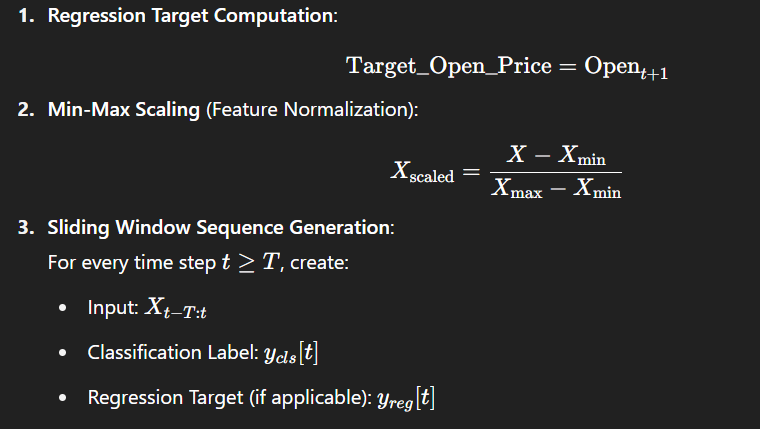

It prepares data ready for LSTM or ML modeling in a supervised learning pipeline.

In [ ]:
import pandas as pd
import numpy as np
from typing import Optional, List, Tuple
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.utils import to_categorical

def prepare_data_for_lstm(
    df: pd.DataFrame,
    time_steps: int = 10,
    features: Optional[List[str]] = None,
    target_col: str = 'Target',
    regression_cols: Optional[List[str]] = None,
    label_encoder: Optional[LabelEncoder] = None,
    flatten: bool = False,
    verbose: bool = True,
    allow_partial: bool = True,
    use_sparse_labels: bool = True
) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray], LabelEncoder, List, List[str], List[float]]:
    """
    Prepares time-series sequences for LSTM or tabular models.

    Args:
        df: Input DataFrame with stock data.
        time_steps: Number of time steps for sequences.
        features: List of feature columns.
        target_col: Classification target column.
        regression_cols: Regression target columns.
        label_encoder: Pre-trained LabelEncoder.
        flatten: Whether to flatten sequences.
        verbose: Print progress logs.
        allow_partial: Allow sequences with NaNs.
        use_sparse_labels: Use integer labels (True) or one-hot encoded (False).

    Returns:
        X_seq: Input sequences.
        y_cls_seq: Encoded classification labels.
        y_reg_seq: Regression targets.
        final_label_encoder: Trained LabelEncoder.
        date_seq: Corresponding dates.
        stock_seq: Corresponding stock names.
        prev_close_seq: Previous close prices.
    """
    if features is None:
        features = [
            'Open', 'High', 'Low', 'Close', 'Volume',
            'RSI_5', 'RSI_14', 'ROC', 'TSI', 'MACD', 'MACD_signal',
            'SMA_5', 'SMA_10', 'EMA_10', 'EMA_21',
            'BB_High', 'BB_Low', 'BB_Mid', 'BB_Width',
            'ATR_7', 'ATR_14', 'OBV', 'CMF', 'MFI', 'ADX',
            'Stoch_%K', 'Stoch_%D', 'Williams_%R',
            'Donchian_High', 'Donchian_Low', 'Donchian_Mid',
            'Donchian_High_Distance', 'Donchian_Low_Distance',
            'VWAP_Deviation', 'High_VWAP_Deviation', 'Low_VWAP_Deviation',
            'Volatility', 'LogVolume', 'High_Low_Range_5', 'High_Low_Range_10',
            'Avg_Daily_Range', 'Parkinson_Vol', 'BB_High_Distance', 'BB_Low_Distance',
            'BB_High_Proximity', 'BB_Low_Proximity', 'High_Lag1', 'Low_Lag1',
            'High_Lag2', 'Low_Lag2', 'High_Low_Range_Lag1', 'Fib_0.382', 'Fib_0.618',
            'Fib_High_Proximity', 'Fib_Low_Proximity'
        ]

    df = df.copy()

    # Validate required columns
    for col in ['STOCK_NAME', 'Close']:
        if col not in df.columns:
            if verbose:
                print(f"Missing required column: '{col}'")
            return np.array([]), np.array([]), None, LabelEncoder(), [], [], []

    # Ensure datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        if 'Date' in df.columns:
            df.set_index('Date', inplace=True)
        if not isinstance(df.index, pd.DatetimeIndex):
            if verbose:
                print("Index is not a datetime index. Time-series preparation aborted.")
            return np.array([]), np.array([]), None, LabelEncoder(), [], [], []

    # Filter missing features
    missing_features = [f for f in features if f not in df.columns or df[f].isnull().all()]
    if missing_features:
        if allow_partial:
            features = [f for f in features if f not in missing_features]
            if verbose:
                print(f"Ignoring missing features: {missing_features}")
        else:
            if verbose:
                print(f"Missing features: {missing_features}")
            return np.array([]), np.array([]), None, LabelEncoder(), [], [], []

    # Check target columns
    if target_col not in df.columns:
        if verbose:
            print(f"Missing classification target column: '{target_col}'")
        return np.array([]), np.array([]), None, LabelEncoder(), [], [], []

    target_columns = [target_col]
    regression_cols = regression_cols or ['Target_Open_Price', 'Target_Close_Price', 'Target_High_Price', 'Target_Low_Price']
    valid_regression_cols = []

    for reg_col in regression_cols:
        if reg_col not in df.columns:
            if reg_col == 'Target_Open_Price' and 'Open' in df.columns:
                if verbose:
                    print(f"'{reg_col}' not found. Computing as next day's 'Open'.")
                df['Target_Open_Price'] = df['Open'].shift(-1)
                valid_regression_cols.append('Target_Open_Price')
            elif reg_col == 'Target_High_Price' and 'High' in df.columns:
                if verbose:
                    print(f"'{reg_col}' not found. Computing as next day's 'High'.")
                df['Target_High_Price'] = df['High'].shift(-1)
                valid_regression_cols.append('Target_High_Price')
            elif reg_col == 'Target_Low_Price' and 'Low' in df.columns:
                if verbose:
                    print(f"'{reg_col}' not found. Computing as next day's 'Low'.")
                df['Target_Low_Price'] = df['Low'].shift(-1)
                valid_regression_cols.append('Target_Low_Price')
            else:
                if verbose:
                    print(f"Regression column '{reg_col}' not found. Ignoring.")
        else:
            valid_regression_cols.append(reg_col)

    target_columns.extend(valid_regression_cols)

    # Fill NaNs in features and target columns
    for col in features + target_columns:
        if col in df.columns:
            if col in valid_regression_cols:
                df[col] = df[col].fillna(method='ffill').fillna(df['Close'])
            elif col == target_col:
                df[col] = df[col].fillna('NEUTRAL')
            else:
                df[col] = df[col].fillna(0.0)

    # Log NaN counts after filling
    if verbose:
        nan_counts = df[features + target_columns].isna().sum()
        if nan_counts.sum() > 0:
            print(f"NaN counts after filling: {nan_counts[nan_counts > 0].to_dict()}")

    if len(df) < time_steps + 1:
        if verbose:
            print(f"Insufficient rows after filtering. Found {len(df)}, required {time_steps + 1}.")
        return np.array([]), np.array([]), None, LabelEncoder(), [], [], []

    try:
        X_raw = df[features].values
        y_cls_raw = df[target_col].values
        y_reg_raw = df[valid_regression_cols].values if valid_regression_cols else None
    except Exception as e:
        if verbose:
            print(f"Error extracting features or targets: {e}")
        return np.array([]), np.array([]), None, LabelEncoder(), [], [], []

    # Metadata
    dates = df.index.to_list()
    stock_names = df['STOCK_NAME'].astype(str).values
    close_prices = df['Close'].values

    # Normalize features
    scaler = MinMaxScaler()
    try:
        X_scaled = scaler.fit_transform(X_raw)
        X_scaled = np.nan_to_num(X_scaled, nan=0.0)
    except Exception as e:
        if verbose:
            print(f"Error normalizing features: {e}")
        return np.array([]), np.array([]), None, LabelEncoder(), [], [], []

    # Encode classification target
    final_label_encoder = label_encoder or LabelEncoder()
    try:
        final_label_encoder.fit(['DOWN', 'NEUTRAL', 'UP'])
        y_cls_encoded = final_label_encoder.transform(y_cls_raw)
        if verbose:
            print(f"Unique classes: {final_label_encoder.classes_}")
    except Exception as e:
        if verbose:
            print(f"Label encoding failed: {e}")
        return np.array([]), np.array([]), None, LabelEncoder(), [], [], []

    # Sequence creation
    X_seq, y_cls_seq, y_reg_seq_list = [], [], []
    date_seq, stock_seq, prev_close_seq = [], [], []

    for i in range(time_steps, len(X_scaled)):
        window = X_scaled[i - time_steps:i]
        if not allow_partial and np.isnan(window).any():
            continue
        if flatten:
            window = window.flatten()
        X_seq.append(window)
        y_cls_seq.append(y_cls_encoded[i])
        if y_reg_raw is not None:
            y_reg_seq_list.append(y_reg_raw[i])
        date_seq.append(dates[i])
        stock_seq.append(stock_names[i])
        prev_close_seq.append(close_prices[i - 1])

    if not X_seq:
        if verbose:
            print("No valid sequences generated after filtering.")
        return np.array([]), np.array([]), None, LabelEncoder(), [], [], []

    if verbose:
        print(f"Prepared {len(X_seq)} samples. Input shape: {np.array(X_seq).shape}")

    X_seq = np.array(X_seq, dtype=np.float32)
    y_cls_seq = np.array(y_cls_seq, dtype=np.int32)
    if not use_sparse_labels:
        y_cls_seq = to_categorical(y_cls_seq, num_classes=len(final_label_encoder.classes_))
    y_reg_seq = np.array(y_reg_seq_list, dtype=np.float32) if y_reg_raw is not None else None

    return X_seq, y_cls_seq, y_reg_seq, final_label_encoder, date_seq, stock_seq, prev_close_seq

This is the Mathematical Logic of this Function to prepare the Information for smote to help LSTM

Let:

  - xₜ ∈ ℝᵈ be the feature vector at time t
  - T = sequence length
  - Xᵢ = [xᵢ, xᵢ₊₁, ..., xᵢ₊ₜ₋₁] ∈ ℝᵀˣᵈ (LSTM input sequence)
  - yᵢ ∈ {0, 1, 2} be the class label at time i + T

Then:

  D_raw = { (Xᵢ, yᵢ) | i ∈ [1, N − T] }

After applying SMOTE on flattened sequences:

  D_balanced = SMOTE({ (vec(Xᵢ), yᵢ) ∈ ℝᵀ·ᵈ × {0, 1, 2} })

Where:

  - vec(Xᵢ) flattens the T × d matrix into a T·d vector
  - SMOTE generates synthetic samples to balance class distributions


In [ ]:
def prepare_data_with_smote(
    df: pd.DataFrame,
    features: List[str],
    target: str = 'True_Label',
    regression_cols: Optional[List[str]] = None,  # Changed to support multiple regression targets
    sequence_length: int = 30,
    allow_partial: bool = True,
    verbose: bool = True
) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray], Dict[str, int], List, List, List]:
    """
    Prepares LSTM-style sequences with SMOTE class balancing for classification (UP/DOWN/NEUTRAL)
    and returns original (unbalanced) regression targets and metadata.
    """
    df = df.copy()
    label_map = {'DOWN': 0, 'NEUTRAL': 1, 'UP': 2}
    regression_cols = regression_cols or ['Target_Open_Price', 'Target_Close_Price', 'Target_High_Price', 'Target_Low_Price']

    # Basic column checks
    if target not in df.columns:
        raise ValueError(f"Target column '{target}' not found.")
    if 'STOCK_NAME' not in df.columns or 'Date' not in df.columns:
        raise ValueError("Both 'STOCK_NAME' and 'Date' columns are required.")

    for reg_col in regression_cols:
        if reg_col not in df.columns:
            if reg_col == 'Target_Open_Price' and 'Open' in df.columns:
                if verbose:
                    print(f"'{reg_col}' not found. Creating it using next day's 'Open'.")
                df[reg_col] = df['Open'].shift(-1)
            elif reg_col == 'Target_High_Price' and 'High' in df.columns:
                if verbose:
                    print(f"'{reg_col}' not found. Creating it using next day's 'High'.")
                df[reg_col] = df['High'].shift(-1)
            elif reg_col == 'Target_Low_Price' and 'Low' in df.columns:
                if verbose:
                    print(f"'{reg_col}' not found. Creating it using next day's 'Low'.")
                df[reg_col] = df['Low'].shift(-1)
            else:
                raise ValueError(f"Regression column '{reg_col}' not found and cannot be computed.")

    missing_feats = [f for f in features if f not in df.columns]
    if missing_feats:
        raise ValueError(f"Missing features in DataFrame: {missing_feats}")

    # Encode labels
    if not pd.api.types.is_numeric_dtype(df[target]):
        df['encoded_label'] = df[target].map(label_map)
        if df['encoded_label'].isnull().any():
            raise ValueError(f"Some labels in '{target}' could not be mapped. Check your label values.")
    else:
        df['encoded_label'] = df[target]
        if verbose:
            print(f"Target column '{target}' is numeric. Using directly.")

    stocks = df['STOCK_NAME'].unique()

    X_all, y_all = [], []
    y_reg_all = {reg_col: [] for reg_col in regression_cols}
    date_seq_original, stock_seq_original, prev_close_seq_original = [], [], []

    scaler = MinMaxScaler()
    is_scaler_fitted = False

    for stock in stocks:
        stock_df = df[df['STOCK_NAME'] == stock].sort_values('Date')

        required_cols = features + ['encoded_label'] + regression_cols
        stock_df.dropna(subset=required_cols, inplace=True)
        if len(stock_df) < sequence_length + 1:
            if verbose:
                print(f"Stock '{stock}': insufficient data after cleaning ({len(stock_df)} rows), skipping.")
            continue

        X_stock_raw = stock_df[features].values
        if not is_scaler_fitted:
            scaler.fit(X_stock_raw)
            is_scaler_fitted = True
        X_stock_scaled = scaler.transform(X_stock_raw)

        if allow_partial:
            X_stock_scaled = np.nan_to_num(X_stock_scaled, nan=0.0)

        y_stock_cls = stock_df['encoded_label'].values
        y_stock_reg = {reg_col: stock_df[reg_col].values for reg_col in regression_cols}

        dates_stock = stock_df['Date'].values
        close_prices_stock = stock_df['Close'].values

        for i in range(len(X_stock_scaled) - sequence_length):
            seq = X_stock_scaled[i:i + sequence_length]
            if not allow_partial and np.any(np.isnan(seq)):
                continue

            X_all.append(seq)
            y_all.append(y_stock_cls[i + sequence_length])
            for reg_col in regression_cols:
                y_reg_all[reg_col].append(y_stock_reg[reg_col][i + sequence_length])

            date_seq_original.append(dates_stock[i + sequence_length])
            stock_seq_original.append(stock)
            prev_close_seq_original.append(close_prices_stock[i + sequence_length - 1])

    X_all_arr = np.array(X_all)
    y_all_arr = np.array(y_all)
    y_reg_original = {reg_col: np.array(y_reg_all[reg_col]) for reg_col in regression_cols}

    if verbose:
        print(f"\nSample distribution before SMOTE: {dict(pd.Series(y_all_arr).value_counts())}")
        print(f"Total sequences before SMOTE: {X_all_arr.shape[0]}")

    if len(X_all_arr) < 5:
        raise ValueError("Too few samples to apply SMOTE. Please reduce sequence length or check data quality.")

    unique_classes, class_counts = np.unique(y_all_arr, return_counts=True)
    if len(unique_classes) < 2:
        if verbose:
            print("Only one class present. Skipping SMOTE.")
        return (
            X_all_arr, y_all_arr,
            np.column_stack([y_reg_original[reg_col] for reg_col in regression_cols]) if regression_cols else None,
            label_map, date_seq_original, stock_seq_original, prev_close_seq_original
        )

    min_class_size = class_counts.min()
    smote_k_neighbors = min(3, max(1, min_class_size - 1))

    try:
        X_flat = X_all_arr.reshape(X_all_arr.shape[0], -1)
        smote = SMOTE(random_state=42, k_neighbors=smote_k_neighbors)
        X_resampled, y_resampled = smote.fit_resample(X_flat, y_all_arr)
        X_balanced = X_resampled.reshape(-1, sequence_length, len(features))
    except Exception as e:
        raise RuntimeError(f"SMOTE failed: {e}. Consider reducing k_neighbors or ensuring more data per class.")

    if verbose:
        print(f"Sample distribution after SMOTE: {dict(pd.Series(y_resampled).value_counts())}")
        print(f"Balanced sequence shape: {X_balanced.shape}")

    return (
        X_balanced, y_resampled,
        np.column_stack([y_reg_original[reg_col] for reg_col in regression_cols]) if regression_cols else None,
        label_map, date_seq_original, stock_seq_original, prev_close_seq_original
    )

1. predict_prices()

Purpose: Estimate next-day open and close prices using classification probabilities.
Let:

•	  - p_up: Probability of UP class

•	  - p_down: Probability of DOWN class

•	  - c_prev: Previous day's close price

•	  - α (alpha): Assumed change factor (default: 0.01)

Then the expected price change is:

    Δp = (p_up - p_down) × α

Predicted prices:

    predicted_close = c_prev × (1 + Δp)
    predicted_open  = c_prev × (1 + 0.5 × Δp)

2. weighted_ensemble_predict()

Purpose: Combine predictions from multiple models using weighted averaging for both classification and regression.

Let:

•	  - M: Number of models

•	  - wᵢ: Weight of model i, where ∑wᵢ = 1

•	  - Pᵢ ∈ ℝᴺˣᶜ: Probability matrix from model i

•	  - R_open⁽ⁱ⁾, R_close⁽ⁱ⁾ ∈ ℝᴺ: Regression open/close outputs from model i

Weighted classification ensemble:

    P_ensemble = ∑ (wᵢ × Pᵢ)
    y_pred = argmax(P_ensemble, axis=1)
Weighted regression (if available):

    R_open = ∑ (wᵢ × R_open⁽ⁱ⁾)  for models with valid open regression
    R_close = ∑ (wᵢ × R_close⁽ⁱ⁾)  for models with valid close regression
Fallback (if regression unavailable):

    R_open, R_close = predict_prices(c_prev, P_ensemble)


In [ ]:
def predict_prices(
    prev_close: np.ndarray,
    pred_probs: np.ndarray,
    change_factor: float = 0.01
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Estimate next day's open, close, high, and low prices from classification probabilities.

    Args:
        prev_close (np.ndarray): Previous day's closing prices (1D array).
        pred_probs (np.ndarray): Class probabilities [samples, classes].
        change_factor (float): Assumed price change magnitude (default: 1%).

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: Predicted (open, close, high, low) prices.
    """
    if pred_probs.shape[1] < 3:
        if pred_probs.shape[1] == 2:
            up_prob = pred_probs[:, 1]
            down_prob = pred_probs[:, 0]
            print("predict_prices: Binary classification detected. Using second column as UP probability.")
        else:
            up_prob = pred_probs[:, 0]
            down_prob = 1.0 - up_prob
            print("predict_prices: Single-column probability detected. Estimating DOWN as 1 - UP.")
    else:
        up_prob = pred_probs[:, 2]
        down_prob = pred_probs[:, 0]

    expected_change = (up_prob - down_prob) * change_factor
    pred_close = prev_close * (1 + expected_change)
    pred_open = prev_close * (1 + 0.5 * expected_change)  # Open assumes half the movement
    pred_high = prev_close * (1 + 1.5 * expected_change)  # High assumes larger upward movement
    pred_low = prev_close * (1 - 1.5 * expected_change)   # Low assumes larger downward movement
    return pred_open, pred_close, pred_high, pred_low

def weighted_ensemble_predict(
    models: List[Tuple[Any, str]],
    X: np.ndarray,
    weights: Optional[List[float]] = None,
    include_regression: bool = True,
    prev_close: Optional[np.ndarray] = None
) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Generates ensemble predictions using weighted probabilities from multiple models.
    Handles both classification and regression outputs (open, close, high, low), with fallback to classification-based
    price estimation when regression outputs are missing.

    Args:
        models (List[Tuple[Any, str]]): List of (model, model_type) tuples.
        X (np.ndarray): Input data (3D for deep models, 2D for traditional).
        weights (Optional[List[float]]): Optional weights for each model.
        include_regression (bool): Whether to compute regression predictions.
        prev_close (Optional[np.ndarray]): Required if regression fallback is needed.

    Returns:
        Tuple containing:
        - predictions (np.ndarray): Final predicted class labels
        - weighted_probs (np.ndarray): Averaged softmax probabilities
        - regression_open_preds (Optional[np.ndarray]): Predicted open prices
        - regression_close_preds (Optional[np.ndarray]): Predicted close prices
        - regression_high_preds (Optional[np.ndarray]): Predicted high prices
        - regression_low_preds (Optional[np.ndarray]): Predicted low prices
    """
    classification_contributions = []
    regression_open_contributions = []
    regression_close_contributions = []
    regression_high_contributions = []
    regression_low_contributions = []

    # Initialize weights (equal if none provided)
    model_weights = weights if weights and len(weights) == len(models) else [1.0 / len(models)] * len(models)
    num_classes = None

    for idx, (model, model_type) in enumerate(models):
        try:
            prob, reg_open, reg_close, reg_high, reg_low = None, None, None, None, None

            if model_type in ['LSTM', 'Hybrid']:
                pred = model.predict(X, verbose=0)
                if isinstance(pred, tuple):
                    prob = pred[0]
                    if include_regression and len(pred) > 1:
                        reg_output = pred[1]
                        if reg_output is not None:
                            if reg_output.shape[-1] == 4:  # Open, close, high, low predictions
                                reg_open, reg_close, reg_high, reg_low = reg_output[:, 0], reg_output[:, 1], reg_output[:, 2], reg_output[:, 3]
                            elif reg_output.shape[-1] == 2:  # Only open and close
                                reg_open, reg_close = reg_output[:, 0], reg_output[:, 1]
                            elif reg_output.shape[-1] == 1:  # Only close
                                reg_close = reg_output.flatten()
                else:
                    prob = pred

            else:  # Traditional ML models
                X_flat = X.reshape(X.shape[0], -1)
                if hasattr(model, 'predict_proba'):
                    prob = model.predict_proba(X_flat)
                else:
                    raise AttributeError(f"Model {idx} ({model_type}) lacks predict_proba()")

            # Validate and normalize probabilities
            if prob is None:
                raise ValueError("No classification output from model")

            if prob.ndim == 1:
                prob = np.expand_dims(prob, axis=1)

            # Check for consistent number of classes
            if num_classes is None:
                num_classes = prob.shape[1]
            elif prob.shape[1] != num_classes:
                raise ValueError(f"Model {idx} class mismatch: expected {num_classes}, got {prob.shape[1]}")

            classification_contributions.append((prob, model_weights[idx]))

            if include_regression:
                if reg_open is not None:
                    regression_open_contributions.append((reg_open, model_weights[idx]))
                if reg_close is not None:
                    regression_close_contributions.append((reg_close, model_weights[idx]))
                if reg_high is not None:
                    regression_high_contributions.append((reg_high, model_weights[idx]))
                if reg_low is not None:
                    regression_low_contributions.append((reg_low, model_weights[idx]))

        except Exception as e:
            print(f"Warning: Model {idx} ({model_type}) failed: {str(e)}")

    if not classification_contributions:
        raise ValueError("No valid classification outputs from any model")

    # Calculate weighted classification probabilities
    prob_list = [p for p, _ in classification_contributions]
    weight_array = np.array([w for _, w in classification_contributions])
    weight_array /= weight_array.sum()  # Normalize weights

    stacked_probs = np.stack(prob_list)
    weighted_probs = np.tensordot(weight_array, stacked_probs, axes=([0], [0]))
    predictions = np.argmax(weighted_probs, axis=1)

    # Calculate weighted regression predictions if available
    regression_open_preds, regression_close_preds, regression_high_preds, regression_low_preds = None, None, None, None

    if include_regression:
        if regression_open_contributions:
            open_preds = np.stack([r for r, _ in regression_open_contributions])
            open_weights = np.array([w for _, w in regression_open_contributions])
            open_weights /= open_weights.sum()
            regression_open_preds = np.tensordot(open_weights, open_preds, axes=([0], [0]))

        if regression_close_contributions:
            close_preds = np.stack([r for r, _ in regression_close_contributions])
            close_weights = np.array([w for _, w in regression_close_contributions])
            close_weights /= close_weights.sum()
            regression_close_preds = np.tensordot(close_weights, close_preds, axes=([0], [0]))

        if regression_high_contributions:
            high_preds = np.stack([r for r, _ in regression_high_contributions])
            high_weights = np.array([w for _, w in regression_high_contributions])
            high_weights /= high_weights.sum()
            regression_high_preds = np.tensordot(high_weights, high_preds, axes=([0], [0]))

        if regression_low_contributions:
            low_preds = np.stack([r for r, _ in regression_low_contributions])
            low_weights = np.array([w for _, w in regression_low_contributions])
            low_weights /= low_weights.sum()
            regression_low_preds = np.tensordot(low_weights, low_preds, axes=([0], [0]))

    # Fallback to classification-based estimation if regression outputs are missing
    if include_regression and (regression_open_preds is None or regression_close_preds is None or
                              regression_high_preds is None or regression_low_preds is None):
        if prev_close is not None:
            if prev_close.ndim == 2 and prev_close.shape[1] == 1:
                prev_close = prev_close.flatten()
            est_open, est_close, est_high, est_low = predict_prices(prev_close, weighted_probs)
            if regression_open_preds is None:
                regression_open_preds = est_open
                print("Using classification-based open price estimation")
            if regression_close_preds is None:
                regression_close_preds = est_close
                print("Using classification-based close price estimation")
            if regression_high_preds is None:
                regression_high_preds = est_high
                print("Using classification-based high price estimation")
            if regression_low_preds is None:
                regression_low_preds = est_low
                print("Using classification-based low price estimation")

    return predictions, weighted_probs, regression_open_preds, regression_close_preds, regression_high_preds, regression_low_preds

In [ ]:
def calculate_model_weights(
    models: List[Tuple[Any, str]],
    X_val: np.ndarray,
    y_val: np.ndarray,
    regression_vals: Optional[Dict[str, np.ndarray]] = None,  # Changed to support multiple regression targets
    use_regression: bool = False,
    verbose: bool = True
) -> np.ndarray:
    """
    Calculates optimal weights for model ensemble based on validation performance.
    Combines classification accuracy with regression RMSE (if enabled) to determine weights.

    Args:
        models: List of (model, model_type) tuples where model_type is one of:
                'LSTM', 'Hybrid', 'XGB', 'RF', etc.
        X_val: Validation features (3D array for LSTM/Hybrid, 2D for others)
        y_val: True classification labels for validation set
        regression_vals: Dictionary of true regression targets (e.g., {'Target_Open_Price': ..., 'Target_Close_Price': ..., ...})
        use_regression: Whether to incorporate regression performance in weighting
        verbose: Whether to print detailed evaluation metrics

    Returns:
        Normalized weights array (sums to 1) with same length as input models list.
        Failed models receive zero weight.
    """
    weights = []
    valid_indices = []

    for idx, (model, model_type) in enumerate(models):
        try:
            # Initialize outputs
            y_prob, y_reg = None, None

            # Get predictions based on model type
            if model_type in ['LSTM', 'Hybrid']:
                pred = model.predict(X_val, verbose=0)
                if isinstance(pred, tuple):  # Hybrid model with multiple outputs
                    y_prob = pred[0]
                    if use_regression and len(pred) > 1:
                        y_reg = pred[1]
                else:  # Pure classification model
                    y_prob = pred

            else:  # Traditional ML models
                X_flat = X_val.reshape(X_val.shape[0], -1)
                if hasattr(model, 'predict_proba'):
                    y_prob = model.predict_proba(X_flat)
                else:
                    raise AttributeError(f"Model {idx+1} lacks predict_proba() method")

            # Validate classification outputs
            if y_prob is None:
                raise ValueError("No classification probabilities returned")

            if y_prob.ndim == 1:  # Handle binary classification case
                y_prob = np.expand_dims(y_prob, axis=1)

            # Calculate classification accuracy
            y_pred = np.argmax(y_prob, axis=1)
            acc = accuracy_score(y_val, y_pred)
            score = acc  # Base score is accuracy

            # Calculate regression metrics if enabled
            if use_regression and regression_vals is not None and y_reg is not None:
                rmse_scores = []

                for reg_col, reg_true in regression_vals.items():
                    if reg_true is not None and y_reg.shape[-1] >= len(regression_vals):
                        reg_pred = y_reg[:, list(regression_vals.keys()).index(reg_col)]
                        if len(reg_pred) != len(reg_true):
                            raise ValueError(f"Model {idx+1} {reg_col} prediction length mismatch")
                        rmse = mean_squared_error(reg_true, reg_pred, squared=False)
                        rmse_scores.append(rmse)

                if rmse_scores:
                    avg_rmse = np.mean(rmse_scores)
                    score = acc * (1.0 / (avg_rmse + 1e-6))  # Inverse relationship, small epsilon avoids division by zero

            weights.append(score)
            valid_indices.append(idx)

            if verbose:
                log_msg = f"Model {idx+1} [{model_type:>6}] Accuracy: {acc:.4f}"
                if use_regression and rmse_scores:
                    for reg_col, rmse in zip(regression_vals.keys(), rmse_scores):
                        log_msg += f" | {reg_col} RMSE: {rmse:.4f}"
                print(log_msg)

        except Exception as e:
            print(f"Model {idx+1} [{model_type:>6}] evaluation failed: {str(e)}")
            continue

    # Handle cases where all models failed or produced zero scores
    if not weights or sum(weights) == 0:
        if verbose:
            print("Warning: All models failed or produced zero weights. Using uniform weights as fallback.")
        return np.ones(len(models)) / len(models)

    # Normalize weights to sum to 1
    weights = np.array(weights, dtype=np.float32)
    weights /= weights.sum()

    # Create final weights array (preserving original model order)
    final_weights = np.zeros(len(models), dtype=np.float32)
    for i, idx in enumerate(valid_indices):
        final_weights[idx] = weights[i]

    return final_weights

In [ ]:
def apply_confidence_threshold(
    probs: np.ndarray,
    margin: float = 0.1,
    neutral_class: Optional[int] = None,
    class_names: Optional[List[str]] = None,
    label_map: Optional[Union[LabelEncoder, Dict[str, int]]] = None,
    return_confidences: bool = False,
    verbose: bool = False
) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
    """
    Applies a confidence margin threshold to class probabilities.
    Only accepts the predicted class if it's clearly more probable than the runner-up.

    Args:
        probs (np.ndarray): Class probabilities [n_samples, n_classes].
        margin (float): Minimum difference between top two probabilities (default: 0.1).
        neutral_class (Optional[int]): Class index for low-confidence predictions (default: None, inferred from label_map).
        class_names (Optional[List[str]]): Class names for verbose logging (default: None).
        label_map (Optional[Union[LabelEncoder, Dict[str, int]]]): Label encoder or mapping to determine neutral class (default: None).
        return_confidences (bool): If True, returns per-class probabilities (default: False).
        verbose (bool): Print low-confidence cases (default: False).

    Returns:
        Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
            - Predicted class indices (with low-confidence predictions mapped to `neutral_class`).
            - If return_confidences=True, also returns per-class probabilities.
    """
    if probs.ndim != 2 or probs.shape[1] < 2:
        raise ValueError("`probs` must be 2D array of shape (n_samples, n_classes)")

    n_samples, n_classes = probs.shape

    # Infer NEUTRAL class index
    if neutral_class is None:
        if isinstance(label_map, LabelEncoder):
            try:
                neutral_class = np.where(label_map.classes_ == 'NEUTRAL')[0][0]
            except IndexError:
                raise ValueError("NEUTRAL not found in LabelEncoder classes.")
        elif isinstance(label_map, dict):
            if 'NEUTRAL' in label_map:
                neutral_class = label_map['NEUTRAL']
            else:
                raise ValueError("NEUTRAL not found in label_map.")
        else:
            neutral_class = 2  # Default fallback
        if verbose:
            print(f"Using neutral_class={neutral_class} for low-confidence predictions.")

    predictions = np.full(n_samples, neutral_class, dtype=int)

    for i, prob_vector in enumerate(probs):
        sorted_indices = np.argsort(prob_vector)[::-1]
        top1_idx, top2_idx = sorted_indices[0], sorted_indices[1]
        top1_prob, top2_prob = prob_vector[top1_idx], prob_vector[top2_idx]

        if top1_prob - top2_prob >= margin:
            predictions[i] = top1_idx
        else:
            predictions[i] = neutral_class
            if verbose:
                class_labels = class_names if class_names else list(range(n_classes))
                probs_str = ", ".join([f"{class_labels[j]}: {prob_vector[j]:.2f}" for j in range(n_classes)])
                print(f"Row {i}: Low confidence → Defaulted to NEUTRAL | Probs = [{probs_str}]")

    return (predictions, probs) if return_confidences else predictions

In [ ]:
def calculate_financial_metrics(
    predictions: np.ndarray,
    true_labels: np.ndarray,
    close_prices: np.ndarray,
    predicted_probs: Optional[np.ndarray] = None,
    regression_preds: Optional[Dict[str, np.ndarray]] = None,  # Changed to support multiple regression targets
    true_prices: Optional[Dict[str, np.ndarray]] = None,  # Added for true high/low prices
    label_map: Optional[Union[LabelEncoder, Dict[str, int]]] = None,
    initial_capital: float = 10000,
    transaction_cost: float = 0.001,
    return_curve: bool = False,
    decode_labels: bool = False,
    export_csv_path: Optional[str] = None,
    verbose: bool = False
) -> Union[Dict[str, Union[float, str, List]], Tuple[Dict[str, Union[float, str, List]], np.ndarray]]:
    """
    Calculates comprehensive financial performance metrics and predicted price movements.

    Args:
        predictions (np.ndarray): Predicted class labels (encoded).
        true_labels (np.ndarray): True encoded labels.
        close_prices (np.ndarray): Previous day's closing prices aligned with predictions.
        predicted_probs (Optional[np.ndarray]): Predicted class probabilities for price calculation.
        regression_preds (Optional[Dict[str, np.ndarray]]): Predicted prices (e.g., {'Target_Open_Price': ..., ...}).
        true_prices (Optional[Dict[str, np.ndarray]]): True prices for error calculation (e.g., {'Target_High_Price': ..., ...}).
        label_map (Optional[Union[LabelEncoder, Dict[str, int]]]): Label encoder or mapping for decoding labels.
        initial_capital (float): Starting capital for simulated strategy (default: 10000).
        transaction_cost (float): Fractional cost per trade (default: 0.001 = 0.1%).
        return_curve (bool): Whether to return full equity curve (default: False).
        decode_labels (bool): Whether to include decoded labels in output (default: False).
        export_csv_path (Optional[str]): Path to export prediction details as CSV (default: None).
        verbose (bool): Print additional information during execution (default: False).

    Returns:
        metrics (Dict): Financial metrics including:
            - P&L, CAGR, Sharpe Ratio, Max Drawdown
            - Win Rate, Avg Trade Return, Profit Factor
            - Direction Accuracy, Predicted Price Changes, Error Metrics
            - (Optional) Decoded predictions and true labels
        (optional) equity_curve (np.ndarray): Portfolio value over time if return_curve=True.
    """
    # Input validation
    if len(predictions) != len(close_prices):
        raise ValueError("Length of predictions and close_prices must match.")
    if len(true_labels) != len(predictions):
        raise ValueError("Length of true_labels and predictions must match.")
    if predicted_probs is not None and len(predicted_probs) != len(predictions):
        raise ValueError("Length of predicted_probs and predictions must match.")
    regression_preds = regression_preds or {}
    true_prices = true_prices or {}
    for key, pred in regression_preds.items():
        if pred is not None and len(pred) != len(predictions):
            raise ValueError(f"Length of {key} predictions and predictions must match.")
    for key, true in true_prices.items():
        if true is not None and len(true) != len(predictions):
            raise ValueError(f"Length of {key} true prices and predictions must match.")

    # Label decoding setup
    if isinstance(label_map, LabelEncoder):
        class_names = list(label_map.classes_)
        decode_label = lambda l: label_map.inverse_transform([l])[0]
    elif isinstance(label_map, dict):
        class_names = [k for k, v in sorted(label_map.items(), key=lambda x: x[1])]
        decode_label = lambda l: next(k for k, v in label_map.items() if v == l)
    else:
        class_names = ['UP', 'DOWN', 'NEUTRAL']
        decode_label = lambda l: class_names[l]

    # Initialize trading simulation
    capital = initial_capital
    returns, trades, portfolio_values = [], [], [capital]
    win_trades = total_trades = consecutive_losses = max_consec_losses = 0

    # Price prediction containers
    predicted_prices = {key: [] for key in ['Target_Open_Price', 'Target_Close_Price', 'Target_High_Price', 'Target_Low_Price']}
    predicted_pct_changes = {key: [] for key in ['Target_Open_Price', 'Target_Close_Price', 'Target_High_Price', 'Target_Low_Price']}
    error_pcts = {key: [] for key in ['Target_Open_Price', 'Target_Close_Price', 'Target_High_Price', 'Target_Low_Price']}
    predicted_directions = []

    for i in range(1, len(predictions)):
        current_price = close_prices[i - 1]
        price_change = (close_prices[i] - current_price) / current_price
        trade_return = 0

        # Predict prices (regression > probability > fallback)
        for key in predicted_prices:
            if regression_preds.get(key) is not None:
                pred_price = regression_preds[key][i - 1]
                pred_pct = ((pred_price - current_price) / current_price) * 100
            elif predicted_probs is not None:
                expected_return = (
                    predicted_probs[i - 1][class_names.index('UP')] * 0.01 +
                    predicted_probs[i - 1][class_names.index('DOWN')] * -0.01
                )
                if key == 'Target_Open_Price':
                    pred_price = current_price * (1 + 0.5 * expected_return)
                    pred_pct = expected_return * 0.5 * 100
                elif key == 'Target_Close_Price':
                    pred_price = current_price * (1 + expected_return)
                    pred_pct = expected_return * 100
                elif key == 'Target_High_Price':
                    pred_price = current_price * (1 + 1.5 * expected_return)
                    pred_pct = expected_return * 1.5 * 100
                elif key == 'Target_Low_Price':
                    pred_price = current_price * (1 - 1.5 * expected_return)
                    pred_pct = -expected_return * 1.5 * 100
            else:
                pred_label = decode_label(predictions[i - 1])
                change = {'UP': 0.01, 'DOWN': -0.01, 'NEUTRAL': 0.0}[pred_label]
                if key == 'Target_Open_Price':
                    pred_price = current_price * (1 + 0.5 * change)
                    pred_pct = 0.5 * change * 100
                elif key == 'Target_Close_Price':
                    pred_price = current_price * (1 + change)
                    pred_pct = change * 100
                elif key == 'Target_High_Price':
                    pred_price = current_price * (1 + 1.5 * change)
                    pred_pct = 1.5 * change * 100
                elif key == 'Target_Low_Price':
                    pred_price = current_price * (1 - 1.5 * change)
                    pred_pct = -1.5 * change * 100

            predicted_prices[key].append(round(pred_price, 2))
            predicted_pct_changes[key].append(round(pred_pct, 4))

            # Calculate error percentages
            if true_prices.get(key) is not None:
                true_price = true_prices[key][i - 1]
                error_pct = abs((pred_price - true_price) / true_price) * 100 if true_price != 0 else 0
                error_pcts[key].append(round(error_pct, 4))

        # Store direction based on close price
        predicted_directions.append(
            "UP" if predicted_pct_changes['Target_Close_Price'][-1] > 0
            else "DOWN" if predicted_pct_changes['Target_Close_Price'][-1] < 0
            else "NEUTRAL"
        )

        # Execute trading strategy
        pred_label = decode_label(predictions[i - 1])
        if pred_label == 'UP':
            trade_return = price_change - transaction_cost
        elif pred_label == 'DOWN':
            trade_return = -price_change - transaction_cost
        else:
            trade_return = 0

        # Track trade performance
        if pred_label in ['UP', 'DOWN']:
            total_trades += 1
            if trade_return > 0:
                win_trades += 1
                consecutive_losses = 0
            else:
                consecutive_losses += 1
                max_consec_losses = max(max_consec_losses, consecutive_losses)
            trades.append(trade_return)

        # Update portfolio
        capital *= (1 + trade_return)
        returns.append(trade_return)
        portfolio_values.append(capital)

    # Convert to numpy arrays
    returns = np.array(returns)
    trades = np.array(trades)
    portfolio_values = np.array(portfolio_values)

    # Calculate performance metrics
    total_pnl = capital - initial_capital
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = np.max(drawdown) * 100

    mean_return = np.mean(returns) * 252
    std_return = np.std(returns) * np.sqrt(252)
    sharpe = min(mean_return / std_return if std_return > 0 else 0, 10)  # Cap Sharpe at 10

    win_rate = (win_trades / total_trades * 100) if total_trades else 0
    avg_trade_return = np.mean(trades) * 100 if total_trades else 0

    years = len(portfolio_values) / 252
    cagr = ((capital / initial_capital) ** (1 / years) - 1) * 100 if years > 0 else 0

    gross_profit = np.sum(trades[trades > 0])
    gross_loss = np.abs(np.sum(trades[trades < 0]))
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.nan

    # Calculate direction accuracy
    correct_directions = sum(
        predicted_directions[i - 1] == (
            "UP" if close_prices[i] > close_prices[i - 1]
            else "DOWN" if close_prices[i] < close_prices[i - 1]
            else "NEUTRAL"
        ) for i in range(1, len(predictions))
    )
    direction_accuracy = correct_directions / (len(predictions) - 1)

    # Prepare decoded labels if requested
    decoded_preds = [decode_label(l) for l in predictions] if decode_labels else None
    decoded_true = [decode_label(l) for l in true_labels] if decode_labels else None

    # Compile all metrics
    metrics = {
        'P&L': round(total_pnl, 2),
        'CAGR (%)': round(cagr, 2),
        'Sharpe Ratio': round(sharpe, 3),
        'Max Drawdown (%)': round(max_drawdown, 2),
        'Win Rate (%)': round(win_rate, 2),
        'Avg Trade Return (%)': round(avg_trade_return, 2),
        'Total Trades': total_trades,
        'Max Consecutive Losses': max_consec_losses,
        'Profit Factor': round(profit_factor, 2) if not np.isnan(profit_factor) else 'N/A',
        'Direction_Accuracy': round(direction_accuracy, 4),
        'Avg_Predicted_Open_Change_Pct': round(np.mean(predicted_pct_changes['Target_Open_Price']), 4),
        'Avg_Predicted_Close_Change_Pct': round(np.mean(predicted_pct_changes['Target_Close_Price']), 4),
        'Avg_Predicted_High_Change_Pct': round(np.mean(predicted_pct_changes['Target_High_Price']), 4),
        'Avg_Predicted_Low_Change_Pct': round(np.mean(predicted_pct_changes['Target_Low_Price']), 4),
        'Avg_Open_Error_Pct': round(np.mean(error_pcts['Target_Open_Price']), 4) if error_pcts['Target_Open_Price'] else 'N/A',
        'Avg_Close_Error_Pct': round(np.mean(error_pcts['Target_Close_Price']), 4) if error_pcts['Target_Close_Price'] else 'N/A',
        'Avg_High_Error_Pct': round(np.mean(error_pcts['Target_High_Price']), 4) if error_pcts['Target_High_Price'] else 'N/A',
        'Avg_Low_Error_Pct': round(np.mean(error_pcts['Target_Low_Price']), 4) if error_pcts['Target_Low_Price'] else 'N/A',
        'Predicted_Open_Prices': predicted_prices['Target_Open_Price'],
        'Predicted_Close_Prices': predicted_prices['Target_Close_Price'],
        'Predicted_High_Prices': predicted_prices['Target_High_Price'],
        'Predicted_Low_Prices': predicted_prices['Target_Low_Price'],
        'Predicted_Open_Pct_Changes': predicted_pct_changes['Target_Open_Price'],
        'Predicted_Close_Pct_Changes': predicted_pct_changes['Target_Close_Price'],
        'Predicted_High_Pct_Changes': predicted_pct_changes['Target_High_Price'],
        'Predicted_Low_Pct_Changes': predicted_pct_changes['Target_Low_Price'],
        'Predicted_Directions': predicted_directions
    }

    # Add decoded labels if requested
    if decode_labels:
        metrics['Decoded_Predictions'] = decoded_preds
        metrics['Decoded_True_Labels'] = decoded_true

    # Export predictions if path provided
    if export_csv_path:
        df_out = pd.DataFrame({
            'Prev_Close': close_prices[:-1],
            'Pred_Open': predicted_prices['Target_Open_Price'],
            'Pred_Close': predicted_prices['Target_Close_Price'],
            'Pred_High': predicted_prices['Target_High_Price'],
            'Pred_Low': predicted_prices['Target_Low_Price'],
            'Pred_Direction': predicted_directions,
            'Pred_Open_Pct': predicted_pct_changes['Target_Open_Price'],
            'Pred_Close_Pct': predicted_pct_changes['Target_Close_Price'],
            'Pred_High_Pct': predicted_pct_changes['Target_High_Price'],
            'Pred_Low_Pct': predicted_pct_changes['Target_Low_Price'],
            'Open_Error_Pct': error_pcts['Target_Open_Price'],
            'Close_Error_Pct': error_pcts['Target_Close_Price'],
            'High_Error_Pct': error_pcts['Target_High_Price'],
            'Low_Error_Pct': error_pcts['Target_Low_Price']
        })
        df_out.to_csv(export_csv_path, index=False)
        if verbose:
            print(f"Metrics exported to: {export_csv_path}")

    return (metrics, portfolio_values) if return_curve else metrics

In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
from typing import Optional, List, Union, Dict
from sklearn.preprocessing import LabelEncoder

def generate_excel_output(
    df: pd.DataFrame,
    predictions: np.ndarray,
    probs: np.ndarray,
    metrics: dict,
    date_seq: Optional[List[Union[str, datetime]]] = None,
    stock_seq: Optional[List[str]] = None,
    prev_close_seq: Optional[np.ndarray] = None,
    filename: str = '/content/drive/MyDrive/predictions_output.xlsx',
    label_map: Optional[Union[dict, LabelEncoder]] = {0: 'UP', 1: 'DOWN', 2: 'NEUTRAL'},
    predicted_open_prices: Optional[np.ndarray] = None,
    predicted_close_prices: Optional[np.ndarray] = None,
    auto_download: bool = True
) -> str:
    """
    Generates comprehensive Excel report with predictions, price forecasts, and performance metrics.

    Args:
        df: Input DataFrame containing original data
        predictions: Array of predicted class labels
        probs: Array of predicted class probabilities
        metrics: Dictionary of performance metrics
        date_seq: Optional list of dates (default: None, extracted from df)
        stock_seq: Optional list of stock names (default: None, extracted from df)
        prev_close_seq: Optional array of previous close prices (default: None, extracted from df)
        filename: Output Excel file path (default: '/content/drive/MyDrive/predictions_output.xlsx')
        label_map: Mapping for decoding labels (default: {0: 'UP', 1: 'DOWN', 2: 'NEUTRAL'})
        predicted_open_prices: Optional array of predicted open prices (default: None)
        predicted_close_prices: Optional array of predicted close prices (default: None)
        auto_download: Whether to auto-download in Colab (default: True)

    Returns:
        Path to generated Excel file
    """
    # Label decoding setup
    if isinstance(label_map, LabelEncoder):
        class_names = list(label_map.classes_)
        decode_label = lambda label: label_map.inverse_transform([label])[0]
    elif isinstance(label_map, dict):
        class_names = [label for _, label in sorted(label_map.items(), key=lambda x: x[1])]
        reverse_map = {v: k for k, v in label_map.items()}
        decode_label = lambda label: reverse_map.get(label, 'UNKNOWN')
    else:
        class_names = ['UP', 'DOWN', 'NEUTRAL']
        label_map = {0: 'UP', 1: 'DOWN', 2: 'NEUTRAL'}
        decode_label = lambda label: label_map.get(label, 'UNKNOWN')

    output_df = pd.DataFrame()

    # Stock Column
    if stock_seq is not None and len(stock_seq) == len(df):
        output_df['Stock'] = stock_seq
    else:
        stock_col = 'Stock' if 'Stock' in df.columns else 'STOCK_NAME'
        output_df['Stock'] = df[stock_col].values if stock_col in df.columns else 'UNKNOWN'

    # Date Column
    if date_seq is not None and len(date_seq) == len(df):
        output_df['Date'] = pd.to_datetime(date_seq, errors='coerce')
    else:
        date_col = 'Date' if 'Date' in df.columns else df.index.name or 'Date'
        output_df['Date'] = pd.to_datetime(df[date_col].values if date_col in df.columns else df.index, errors='coerce')

    # Previous Close Price
    if prev_close_seq is not None and len(prev_close_seq) == len(df):
        output_df['Previous_Close'] = np.round(prev_close_seq, 1)
    elif 'Previous_Close' in df.columns:
        output_df['Previous_Close'] = df['Previous_Close'].round(1)
    elif 'Close' in df.columns:
        output_df['Previous_Close'] = df['Close'].round(1)

    # True Labels
    if 'True_Label' in df.columns:
        output_df['True_Label'] = df['True_Label'].values
    elif 'Target' in df.columns:
        output_df['True_Label'] = df['Target'].values

    # Predicted Labels
    if predictions is not None:
        output_df['Predicted_Label'] = [decode_label(p) for p in predictions]

    # Confidence and Probabilities
    if probs is not None:
        output_df['Max_Confidence_PCT'] = (np.max(probs, axis=1) * 100).round(1)
        output_df['Risk_Level'] = np.where(
            output_df['Max_Confidence_PCT'] >= 70, 'LOW',
            np.where(output_df['Max_Confidence_PCT'] >= 50, 'MEDIUM', 'HIGH')
        )
        for idx, name in enumerate(class_names):
            if idx < probs.shape[1]:
                output_df[f'{name}_PCT'] = (probs[:, idx] * 100).round(1)

    # Predicted Prices
    open_prices = df['Predicted_Open_Price'] if 'Predicted_Open_Price' in df.columns else metrics.get('Predicted_Open_Prices', predicted_open_prices)
    close_prices = df['Predicted_Close_Price'] if 'Predicted_Close_Price' in df.columns else metrics.get('Predicted_Close_Prices', predicted_close_prices)

    output_df['Predicted_Open_Price'] = np.round(open_prices, 1) if open_prices is not None else output_df['Previous_Close']
    output_df['Predicted_Close_Price'] = np.round(close_prices, 1) if close_prices is not None else output_df['Previous_Close']

    # Predicted Percentage Change
    output_df['Predicted_Change_Pct'] = (
        (output_df['Predicted_Close_Price'] - output_df['Previous_Close']) / output_df['Previous_Close'] * 100
    ).round(1)

    # Actual Prices
    if 'Open' in df.columns:
        output_df['Actual_Open'] = df['Open'].round(1)
    if 'Close' in df.columns:
        output_df['Actual_Close'] = df['Close'].round(1)

    # Direction Accuracy
    if 'Direction_Accuracy' in metrics:
        output_df['Direction_Accuracy'] = round(metrics['Direction_Accuracy'], 4)

    # Column Ordering
    final_cols = [
        'Stock', 'Date', 'Previous_Close', 'True_Label', 'Predicted_Label',
        'Max_Confidence_PCT', 'Risk_Level'
    ]
    prob_cols = [f'{name}_PCT' for name in class_names if f'{name}_PCT' in output_df.columns]
    final_cols.extend(prob_cols)
    final_cols.extend([
        'Predicted_Open_Price', 'Predicted_Close_Price', 'Predicted_Change_Pct',
        'Actual_Open', 'Actual_Close', 'Direction_Accuracy'
    ])
    final_cols = [col for col in final_cols if col in output_df.columns]
    output_df = output_df[final_cols]

    # Excel Export
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        output_df.to_excel(writer, sheet_name='Predictions', index=False)

        # Format metrics sheet
        metrics_df = pd.DataFrame([metrics], index=['Summary'])
        metrics_df.to_excel(writer, sheet_name='Metrics')

        # Auto-adjust column widths
        for sheet in writer.sheets:
            worksheet = writer.sheets[sheet]
            for column in worksheet.columns:
                max_length = max(len(str(cell.value)) for cell in column)
                worksheet.column_dimensions[column[0].column_letter].width = min(max_length + 2, 30)

    print(f"Excel report successfully generated: {filename}")

    # Colab Auto-download
    if auto_download:
        try:
            from google.colab import files
            files.download(filename)
            print(f"File downloaded to local machine: {filename}")
        except ImportError:
            print("Not running in Colab - file saved to specified path only")
        except Exception as e:
            print(f"Download failed (file still saved to path): {str(e)}")

    return filename

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, BatchNormalization, Dropout, Dense, Attention, LayerNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from typing import Tuple, Optional, List

def build_lstm_model(
    input_shape: Tuple[int, int],
    num_classes: int = 3,
    dropout_rates: Tuple[float, float] = (0.3, 0.2),
    learning_rate: float = 0.001,
    l2_reg: float = 0.0,
    use_attention: bool = False,
    batch_norm: bool = True,
    lstm_units: Tuple[int, int] = (128, 64),
    recurrent_dropout: float = 0.0,
    output_activation: str = 'softmax',
    metrics: Optional[List[str]] = None,
    final_dense_units: int = 32,
    name: str = "LSTM_Model",
    verbose: bool = False
) -> Model:
    """
    Builds a customizable LSTM model for classification, optionally with attention.

    Args:
        input_shape: Tuple of (timesteps, features).
        num_classes: Number of output classes.
        dropout_rates: Dropout rates after each LSTM layer.
        learning_rate: Learning rate for Adam optimizer.
        l2_reg: L2 regularization weight.
        use_attention: Apply attention after LSTM layers.
        batch_norm: Apply BatchNormalization after LSTM layers.
        lstm_units: Units for first and second LSTM layers.
        recurrent_dropout: Recurrent dropout rate in LSTM layers.
        output_activation: Final activation function.
        metrics: List of evaluation metrics.
        final_dense_units: Hidden Dense units before output.
        name: Model name.
        verbose: Print model summary.

    Returns:
        Compiled Keras Model.
    """
    if not input_shape or len(input_shape) != 2:
        raise ValueError("input_shape must be a tuple (timesteps, features)")
    if num_classes < 1:
        raise ValueError(f"num_classes must be positive, got {num_classes}")

    # Set default metrics
    if metrics is None:
        metrics = ['accuracy']

    # Input layer
    inputs = Input(shape=input_shape, name="Input")

    # First LSTM Layer
    x = LSTM(
        units=lstm_units[0],
        return_sequences=True,
        recurrent_dropout=recurrent_dropout,
        kernel_initializer='glorot_uniform',
        name="LSTM_1"
    )(inputs)

    if batch_norm:
        x = BatchNormalization(name="BN_1")(x)

    x = Dropout(dropout_rates[0], name="Dropout_1")(x)

    # Second LSTM Layer
    x = LSTM(
        units=lstm_units[1],
        return_sequences=use_attention,
        recurrent_dropout=recurrent_dropout,
        kernel_initializer='glorot_uniform',
        name="LSTM_2"
    )(x)

    if batch_norm:
        x = BatchNormalization(name="BN_2")(x)

    x = Dropout(dropout_rates[1], name="Dropout_2")(x)

    # Attention Mechanism
    if use_attention:
        attn_output = Attention(name="Attention")([x, x])
        x = LayerNormalization(name="Attn_LN")(attn_output)
        x = Flatten(name="Attn_Flatten")(x)
    else:
        x = Flatten(name="Flatten")(x)

    # Dense Layers
    dense_kwargs = {
        "units": final_dense_units,
        "activation": "relu",
        "kernel_initializer": "glorot_uniform",
        "name": "Dense_Hidden"
    }
    if l2_reg > 0:
        dense_kwargs["kernel_regularizer"] = l2(l2_reg)

    x = Dense(**dense_kwargs)(x)

    # Output Layer
    output = Dense(
        units=num_classes,
        activation=output_activation,
        name="Classification"
    )(x)

    # Create model
    model = Model(inputs=inputs, outputs=output, name=name)

    # Use sparse_categorical_crossentropy for integer labels
    loss = 'sparse_categorical_crossentropy'

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    if verbose:
        print(f"\n✅ Built model: {name} | Output classes: {num_classes}\n")
        model.summary()

    return model

In [ ]:
def train_model(
    model: Model,
    X_train: Any,
    y_train: Any,
    X_val: Any,
    y_val: Any,
    epochs: int = 50,
    batch_size: int = 32,
    callbacks: Optional[List[Callback]] = None,
    monitor_metric: str = 'val_Classification_loss',  # Default unchanged
    patience: int = 5,
    verbose: int = 1,
    checkpoint_path: str = 'best_model.h5',
    reduce_lr_factor: float = 0.5,
    reduce_lr_patience: int = 3,
    min_lr: float = 1e-6,
    tensorboard_log_dir: Optional[str] = None,
    save_weights_only: bool = False,
    initial_epoch: int = 0
) -> Tuple[Any, Optional[float], int, Optional[str], List[Callback]]:
    """
    Trains a Keras model with checkpointing, early stopping, learning rate reduction,
    and optional TensorBoard logging.

    Returns:
        history (History): Keras training history
        best_val_metric (float): Best value of monitored metric
        best_epoch (int): Epoch at which best metric was achieved
        saved_model_path (str): Path to best saved model file
        used_callbacks (list): List of all used callbacks
    """
    import os, glob, datetime
    from tensorflow.keras.callbacks import (
        EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
    )

    base_prefix = checkpoint_path.replace(".h5", "")
    old_checkpoints = glob.glob(base_prefix + "_*.h5")
    for old in old_checkpoints:
        try:
            os.remove(old)
            if verbose:
                print(f"Removed old checkpoint: {old}")
        except Exception as e:
            print(f"Could not delete {old}: {e}")

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    final_checkpoint_path = checkpoint_path.replace(".h5", f"_{timestamp}.h5")

    if tensorboard_log_dir:
        os.makedirs(tensorboard_log_dir, exist_ok=True)

    generated_callbacks = [
        EarlyStopping(
            monitor=monitor_metric,
            patience=patience,
            restore_best_weights=True,
            verbose=verbose
        ),
        ReduceLROnPlateau(
            monitor=monitor_metric,
            factor=reduce_lr_factor,
            patience=reduce_lr_patience,
            min_lr=min_lr,
            verbose=verbose
        ),
        ModelCheckpoint(
            filepath=final_checkpoint_path,
            monitor=monitor_metric,
            save_best_only=True,
            save_weights_only=save_weights_only,
            verbose=verbose
        )
    ]

    if tensorboard_log_dir:
        generated_callbacks.append(TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1))

    used_callbacks = (callbacks or []) + generated_callbacks

    # Handle multi-output training data
    if isinstance(y_train, dict):
        y_train_dict = y_train
    elif isinstance(y_train, list) and len(y_train) == 2:
        y_train_dict = {"Classification": y_train[0], "Regression": y_train[1]}
    else:
        y_train_dict = {"Classification": y_train}

    if isinstance(y_val, dict):
        y_val_dict = y_val
    elif isinstance(y_val, list) and len(y_val) == 2:
        y_val_dict = {"Classification": y_val[0], "Regression": y_val[1]}
    else:
        y_val_dict = {"Classification": y_val}

    # Start training
    history = model.fit(
        X_train,
        y_train_dict,
        validation_data=(X_val, y_val_dict),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=used_callbacks,
        verbose=verbose,
        initial_epoch=initial_epoch
    )

    # Extract best monitored metric
    metric_history = history.history.get(monitor_metric, [])
    best_val_metric, best_epoch = None, -1

    if not metric_history:
        if verbose:
            print(f"Monitor metric '{monitor_metric}' not found in history.")
    else:
        is_loss = 'loss' in monitor_metric.lower()
        best_val_metric = min(metric_history) if is_loss else max(metric_history)
        best_epoch = metric_history.index(best_val_metric) + 1
        if verbose:
            print(f" Best {monitor_metric} at epoch {best_epoch}: {best_val_metric:.5f}")

    return history, best_val_metric, best_epoch, final_checkpoint_path, used_callbacks

In [ ]:
def evaluate_and_predict(
    model: Model,
    X_test: np.ndarray,
    y_test: Union[np.ndarray, Dict[str, np.ndarray]],
    dates: List[str],
    label_enc: LabelEncoder,
    stock_seq: List[str],
    prev_close_seq: List[float],
    df_stock: pd.DataFrame,
    display: bool = True,
    sort_by_date: bool = True,
    save_cm_path: Optional[str] = None,
    save_csv_path: Optional[str] = None,
    top_k_preds: int = 1,
    model_name: Optional[str] = None,
    verbose: bool = True,
    return_probs_only: bool = False
) -> pd.DataFrame:
    """
    Evaluates a classification or multi-output model, generates predictions and report.
    """
    if len(X_test) == 0 or model is None:
        raise ValueError("Model or test data missing.")
    if label_enc is None or not hasattr(label_enc, 'classes_'):
        raise ValueError("LabelEncoder must be provided and fitted.")

    # Predict
    raw_output = model.predict(X_test, verbose=0)

    # Split outputs if multi-output model
    if isinstance(raw_output, dict):  # Functional multi-output Keras model
        y_probs = raw_output.get("Classification")
        y_reg = raw_output.get("Regression")
    elif isinstance(raw_output, list) and len(raw_output) == 2:
        y_probs, y_reg = raw_output
    else:
        y_probs = raw_output
        y_reg = None

    y_pred = np.argmax(y_probs, axis=1)
    y_true = y_test["Classification"] if isinstance(y_test, dict) else np.asarray(y_test)

    if return_probs_only:
        return y_probs

    class_names = label_enc.classes_
    unique_labels = np.unique(np.concatenate([y_true, y_pred]))

    if display and verbose:
        print(f"\nClassification Report for {model_name or 'Model'}:")
        try:
            report = classification_report(
                y_true,
                y_pred,
                labels=unique_labels,
                target_names=label_enc.inverse_transform(unique_labels)
            )
            print(report)
        except Exception as e:
            print(f"Could not print classification report: {e}")

        try:
            cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
            plt.figure(figsize=(7, 5))
            sns.heatmap(
                cm, annot=True, fmt='d',
                xticklabels=label_enc.inverse_transform(unique_labels),
                yticklabels=label_enc.inverse_transform(unique_labels),
                cmap='Blues', cbar=True
            )
            plt.title(f"Confusion Matrix: {model_name or 'Model'}")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.tight_layout()
            if save_cm_path:
                plt.savefig(save_cm_path)
                if verbose:
                    print(f"Confusion matrix saved to: {save_cm_path}")
            plt.show()
        except Exception as e:
            print(f"Error generating confusion matrix: {e}")

    # Ensure df_stock index is datetime
    if not isinstance(df_stock.index, pd.DatetimeIndex):
        if 'Date' in df_stock.columns:
            df_stock = df_stock.set_index(pd.to_datetime(df_stock['Date']))
        else:
            df_stock.index = pd.to_datetime(df_stock.index)

    # Results DataFrame
    results = pd.DataFrame({
        'Model': model_name or 'Model',
        'Date': pd.to_datetime(dates),
        'Stock': stock_seq,
        'Previous_Close': prev_close_seq,
        'True_Label': label_enc.inverse_transform(y_true),
        'Predicted_Label': label_enc.inverse_transform(y_pred),
        'Max_Confidence_PCT': (np.max(y_probs, axis=1) * 100).round(2)
    })

    # Per-class confidence
    for class_idx in unique_labels:
        try:
            label = label_enc.inverse_transform([class_idx])[0].upper()
            results[f"{label}_PCT"] = (y_probs[:, class_idx] * 100).round(2)
        except Exception as e:
            print(f"Failed to decode class {class_idx}: {e}")

    # Predicted prices from regression output
    if y_reg is not None and isinstance(y_reg, np.ndarray) and y_reg.shape[1] >= 4:
        results["Predicted_Open_Price"] = y_reg[:, 0].round(2)
        results["Predicted_Close_Price"] = y_reg[:, 1].round(2)
        results["Predicted_High_Price"] = y_reg[:, 2].round(2)
        results["Predicted_Low_Price"] = y_reg[:, 3].round(2)
    else:
        # Fallback using confidence-weighted change
        est_open, est_close, est_high, est_low = predict_prices(prev_close_seq, y_probs)
        results["Predicted_Open_Price"] = est_open.round(2)
        results["Predicted_Close_Price"] = est_close.round(2)
        results["Predicted_High_Price"] = est_high.round(2)
        results["Predicted_Low_Price"] = est_low.round(2)

    # Percentage changes
    results["Predicted_Open_Pct"] = (
        (results["Predicted_Open_Price"] - results["Previous_Close"]) / results["Previous_Close"] * 100
    ).round(2)
    results["Predicted_Close_Pct"] = (
        (results["Predicted_Close_Price"] - results["Previous_Close"]) / results["Previous_Close"] * 100
    ).round(2)
    results["Predicted_High_Pct"] = (
        (results["Predicted_High_Price"] - results["Previous_Close"]) / results["Previous_Close"] * 100
    ).round(2)
    results["Predicted_Low_Pct"] = (
        (results["Predicted_Low_Price"] - results["Previous_Close"]) / results["Previous_Close"] * 100
    ).round(2)

    # Actual prices
    actual_opens, actual_closes, actual_highs, actual_lows = [], [], [], []
    for dt in results['Date']:
        if dt in df_stock.index:
            actual_opens.append(df_stock.loc[dt]['Open'])
            actual_closes.append(df_stock.loc[dt]['Close'])
            actual_highs.append(df_stock.loc[dt]['High'])
            actual_lows.append(df_stock.loc[dt]['Low'])
        else:
            actual_opens.append(None)
            actual_closes.append(None)
            actual_highs.append(None)
            actual_lows.append(None)
    results['Actual_Open'] = actual_opens
    results['Actual_Close'] = actual_closes
    results['Actual_High'] = actual_highs
    results['Actual_Low'] = actual_lows

    # Error percentages
    results["Open_Error_%"] = (
        100 * abs(results["Actual_Open"] - results["Predicted_Open_Price"]) / results["Actual_Open"]
    ).round(6)
    results["Close_Error_%"] = (
        100 * abs(results["Actual_Close"] - results["Predicted_Close_Price"]) / results["Actual_Close"]
    ).round(6)
    results["High_Error_%"] = (
        100 * abs(results["Actual_High"] - results["Predicted_High_Price"]) / results["Actual_High"]
    ).round(6)
    results["Low_Error_%"] = (
        100 * abs(results["Actual_Low"] - results["Predicted_Low_Price"]) / results["Actual_Low"]
    ).round(6)

    results["Predicted_Direction"] = np.where(
        results["Predicted_Close_Pct"] > 0, "UP",
        np.where(results["Predicted_Close_Pct"] < 0, "DOWN", "NEUTRAL")
    )

    # Top-k predictions
    if top_k_preds > 1:
        try:
            top_k_indices = np.argsort(-y_probs, axis=1)[:, :top_k_preds]
            for k in range(top_k_preds):
                label_indices_k = top_k_indices[:, k]
                top_labels = label_enc.inverse_transform(label_indices_k)
                top_confs = (
                    np.take_along_axis(y_probs, label_indices_k[:, np.newaxis], axis=1).flatten() * 100
                ).round(2)
                results[f"Top{k+1}_Label"] = top_labels
                results[f"Top{k+1}_Confidence"] = top_confs
        except Exception as e:
            print(f"Failed to generate top-{top_k_preds} predictions: {e}")

    if sort_by_date:
        try:
            results.sort_values(by=["Date", "Stock"], inplace=True)
            results.reset_index(drop=True, inplace=True)
        except Exception as e:
            print(f"Failed to sort results by date: {e}")

    if save_csv_path:
        try:
            os.makedirs(os.path.dirname(save_csv_path), exist_ok=True)
            results.to_csv(save_csv_path, index=False)
            if verbose:
                print(f"Results saved to: {save_csv_path}")
        except Exception as e:
            print(f"Failed to save CSV: {e}")

    return results

In [ ]:
def evaluate_and_predict_wrapper(
    y_pred: np.ndarray,
    y_probs: Optional[np.ndarray],
    y_true: Union[np.ndarray, Dict[str, np.ndarray]],
    dates: List[str],
    label_enc: LabelEncoder,
    stock_seq: List[str],
    prev_close_seq: List[float],
    df_stock: pd.DataFrame,
    model_name: str = "Model",
    verbose: bool = True,
    predicted_open_prices: Optional[np.ndarray] = None,
    predicted_close_prices: Optional[np.ndarray] = None,
    predicted_high_prices: Optional[np.ndarray] = None,  # Added
    predicted_low_prices: Optional[np.ndarray] = None,   # Added
    future_prediction: bool = True
) -> pd.DataFrame:
    """Final evaluation wrapper: supports classification+regression, label decoding, risk + price analysis."""

    if isinstance(y_true, dict):
        y_true_cls = y_true.get("Classification", y_pred)
        y_true_reg = y_true.get("Regression", None)
    else:
        y_true_cls = y_true
        y_true_reg = None

    if label_enc is None or not hasattr(label_enc, 'classes_'):
        raise ValueError("LabelEncoder must be provided and fitted.")
    if len(prev_close_seq) != len(y_pred):
        raise ValueError("Mismatch between price sequence length and predictions")

    try:
        true_labels = label_enc.inverse_transform(y_true_cls)
        pred_labels = label_enc.inverse_transform(y_pred)
    except Exception as e:
        if verbose:
            print(f"Error decoding labels: {e}")
        true_labels, pred_labels = y_true_cls, y_pred

    results = pd.DataFrame({
        "Model": model_name,
        "Date": pd.to_datetime(dates),
        "Stock": stock_seq,
        "Previous_Close": prev_close_seq,
        "True_Label": true_labels,
        "Predicted_Label": pred_labels,
    })

    if y_probs is not None and y_probs.shape[1] == len(label_enc.classes_):
        results["Max_Confidence_PCT"] = (np.max(y_probs, axis=1) * 100).round(2)
        for i, label in enumerate(label_enc.classes_):
            results[f"{label.upper()}_PCT"] = (y_probs[:, i] * 100).round(2)
    else:
        results["Max_Confidence_PCT"] = np.nan
        if verbose and y_probs is not None:
            print("⚠️ y_probs shape mismatch. Skipping per-class probabilities.")

    # Fallback price predictions
    if (predicted_open_prices is None or predicted_close_prices is None or
        predicted_high_prices is None or predicted_low_prices is None):
        est_open, est_close, est_high, est_low = predict_prices(prev_close_seq, y_probs)
        predicted_open_prices = predicted_open_prices if predicted_open_prices is not None else est_open
        predicted_close_prices = predicted_close_prices if predicted_close_prices is not None else est_close
        predicted_high_prices = predicted_high_prices if predicted_high_prices is not None else est_high
        predicted_low_prices = predicted_low_prices if predicted_low_prices is not None else est_low
        if verbose:
            if predicted_open_prices is est_open:
                print("⚠️ 'Predicted_Open_Price' fallback to classification-derived price")
            if predicted_close_prices is est_close:
                print("⚠️ 'Predicted_Close_Price' fallback to classification-derived price")
            if predicted_high_prices is est_high:
                print("⚠️ 'Predicted_High_Price' fallback to classification-derived price")
            if predicted_low_prices is est_low:
                print("⚠️ 'Predicted_Low_Price' fallback to classification-derived price")

    results["Predicted_Open_Price"] = predicted_open_prices.round(2)
    results["Predicted_Close_Price"] = predicted_close_prices.round(2)
    results["Predicted_High_Price"] = predicted_high_prices.round(2)
    results["Predicted_Low_Price"] = predicted_low_prices.round(2)

    results["Predicted_Change_Pct"] = (
        (results["Predicted_Close_Price"] - results["Previous_Close"]) / results["Previous_Close"] * 100
    ).round(2)
    results["Predicted_High_Pct"] = (
        (results["Predicted_High_Price"] - results["Previous_Close"]) / results["Previous_Close"] * 100
    ).round(2)
    results["Predicted_Low_Pct"] = (
        (results["Predicted_Low_Price"] - results["Previous_Close"]) / results["Previous_Close"] * 100
    ).round(2)

    results["Predicted_Direction"] = np.where(
        results["Predicted_Change_Pct"] > 0, "UP",
        np.where(results["Predicted_Change_Pct"] < 0, "DOWN", "NEUTRAL")
    )

    results["Risk_Level"] = np.where(
        results["Max_Confidence_PCT"] >= 70, "🟢 Low",
        np.where(results["Max_Confidence_PCT"] >= 50, "🟡 Medium", "🔴 High")
    )

    results["Consistency_Flag"] = np.where(
        results["Predicted_Label"] == results["Predicted_Direction"], 'CONSISTENT', 'INCONSISTENT'
    )

    if not future_prediction:
        if not isinstance(df_stock.index, pd.DatetimeIndex):
            df_stock = df_stock.set_index(pd.to_datetime(df_stock['Date'] if 'Date' in df_stock.columns else df_stock.index))

        if df_stock.index.duplicated().any() and verbose:
            print("⚠️ Warning: df_stock has duplicate timestamps. Using first row by default.")

        actual_opens, actual_closes, actual_highs, actual_lows = [], [], [], []
        for dt in results["Date"]:
            try:
                row = df_stock.loc[dt]
                if isinstance(row, pd.Series):
                    row = row.to_frame().T
                actual_opens.append(row["Open"].iloc[0])
                actual_closes.append(row["Close"].iloc[0])
                actual_highs.append(row["High"].iloc[0])
                actual_lows.append(row["Low"].iloc[0])
            except Exception:
                actual_opens.append(np.nan)
                actual_closes.append(np.nan)
                actual_highs.append(np.nan)
                actual_lows.append(np.nan)

        results["Actual_Open"] = actual_opens
        results["Actual_Close"] = actual_closes
        results["Actual_High"] = actual_highs
        results["Actual_Low"] = actual_lows

        results["Open_Error_%"] = (
            100 * abs(results["Actual_Open"] - results["Predicted_Open_Price"]) / results["Actual_Open"]
        ).round(6)
        results["Close_Error_%"] = (
            100 * abs(results["Actual_Close"] - results["Predicted_Close_Price"]) / results["Actual_Close"]
        ).round(6)
        results["High_Error_%"] = (
            100 * abs(results["Actual_High"] - results["Predicted_High_Price"]) / results["Actual_High"]
        ).round(6)
        results["Low_Error_%"] = (
            100 * abs(results["Actual_Low"] - results["Predicted_Low_Price"]) / results["Actual_Low"]
        ).round(6)

        try:
            acc = accuracy_score(y_true_cls, y_pred)
            results["Accuracy"] = acc
            results["Notes"] = "" if acc >= 0.5 else "⚠️ Low accuracy - consider retraining or tuning"
        except Exception as e:
            if verbose:
                print(f"⚠️ Could not calculate accuracy: {e}")
            results["Accuracy"] = np.nan

        open_mask = results["Actual_Open"].notnull()
        close_mask = results["Actual_Close"].notnull()
        high_mask = results["Actual_High"].notnull()
        low_mask = results["Actual_Low"].notnull()

        results["Open_MAE"] = np.nan
        results["Open_RMSE"] = np.nan
        results["Close_MAE"] = np.nan
        results["Close_RMSE"] = np.nan
        results["High_MAE"] = np.nan
        results["High_RMSE"] = np.nan
        results["Low_MAE"] = np.nan
        results["Low_RMSE"] = np.nan

        if open_mask.sum() > 0:
            mae_open = mean_absolute_error(results.loc[open_mask, "Actual_Open"], results.loc[open_mask, "Predicted_Open_Price"])
            rmse_open = mean_squared_error(results.loc[open_mask, "Actual_Open"], results.loc[open_mask, "Predicted_Open_Price"], squared=False)
            results["Open_MAE"] = mae_open
            results["Open_RMSE"] = rmse_open

        if close_mask.sum() > 0:
            mae_close = mean_absolute_error(results.loc[close_mask, "Actual_Close"], results.loc[close_mask, "Predicted_Close_Price"])
            rmse_close = mean_squared_error(results.loc[close_mask, "Actual_Close"], results.loc[close_mask, "Predicted_Close_Price"], squared=False)
            results["Close_MAE"] = mae_close
            results["Close_RMSE"] = rmse_close

        if high_mask.sum() > 0:
            mae_high = mean_absolute_error(results.loc[high_mask, "Actual_High"], results.loc[high_mask, "Predicted_High_Price"])
            rmse_high = mean_squared_error(results.loc[high_mask, "Actual_High"], results.loc[high_mask, "Predicted_High_Price"], squared=False)
            results["High_MAE"] = mae_high
            results["High_RMSE"] = rmse_high

        if low_mask.sum() > 0:
            mae_low = mean_absolute_error(results.loc[low_mask, "Actual_Low"], results.loc[low_mask, "Predicted_Low_Price"])
            rmse_low = mean_squared_error(results.loc[low_mask, "Actual_Low"], results.loc[low_mask, "Predicted_Low_Price"], squared=False)
            results["Low_MAE"] = mae_low
            results["Low_RMSE"] = rmse_low

        if verbose:
            try:
                print(f"\n📊 Classification Report: {model_name}")
                target_names = label_enc.classes_[np.unique(np.concatenate([y_true_cls, y_pred]))]
                print(classification_report(y_true_cls, y_pred, target_names=target_names))

                print(f"\n📈 Price Prediction Summary:")
                print(f"   • Mean Absolute Diff (Close): ₹{abs(results['Predicted_Close_Price'] - results['Previous_Close']).mean():.2f}")
                print(f"   • Consistency: {sum(results['Consistency_Flag'] == 'CONSISTENT')}/{len(results)}")

                print(f"\n📉 Risk Breakdown:")
                risk_stats = results.groupby('Risk_Level').agg({
                    'Predicted_Change_Pct': 'mean',
                    'Accuracy': 'mean',
                    'Consistency_Flag': lambda x: sum(x == 'CONSISTENT') / len(x)
                }).rename(columns={'Predicted_Change_Pct': 'Avg_Return_Pct', 'Consistency_Flag': 'Consistency_Rate'})
                print(risk_stats.round(2))

                print(f"\n📏 Regression Metrics (Open/Close/High/Low Prices):")
                if open_mask.sum() > 0:
                    print(f"   • Open  → MAE: ₹{mae_open:.2f}, RMSE: ₹{rmse_open:.2f}")
                else:
                    print("   • Open  → No actual data available.")
                if close_mask.sum() > 0:
                    print(f"   • Close → MAE: ₹{mae_close:.2f}, RMSE: ₹{rmse_close:.2f}")
                else:
                    print("   • Close → No actual data available.")
                if high_mask.sum() > 0:
                    print(f"   • High  → MAE: ₹{mae_high:.2f}, RMSE: ₹{rmse_high:.2f}")
                else:
                    print("   • High  → No actual data available.")
                if low_mask.sum() > 0:
                    print(f"   • Low   → MAE: ₹{mae_low:.2f}, RMSE: ₹{rmse_low:.2f}")
                else:
                    print("   • Low   → No actual data available.")
            except Exception as e:
                print(f"⚠️ Reporting failed: {e}")

    results.sort_values(by=["Date", "Stock"], inplace=True)
    results.reset_index(drop=True, inplace=True)

    return results

In [ ]:
import pandas as pd
import numpy as np
from typing import Optional, Dict, Union, Tuple
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Model, load_model
from concurrent.futures import ThreadPoolExecutor, as_completed
import datetime

def train_model(
    model: Model,
    X_train: Any,
    y_train: Any,
    X_val: Any,
    y_val: Any,
    stock_name: str = "",
    epochs: int = 50,
    batch_size: int = 32,
    callbacks: Optional[list] = None,
    monitor_metric: str = 'val_loss',
    patience: int = 5,
    verbose: int = 1,
    reduce_lr_factor: float = 0.5,
    reduce_lr_patience: int = 3,
    min_lr: float = 1e-6,
    tensorboard_log_dir: Optional[str] = None,
    checkpoint_path: Optional[str] = None,
    initial_epoch: int = 0
) -> Model:
    """
    Trains a Keras model with early stopping, learning rate reduction,
    model checkpointing, and optional TensorBoard logging.

    Args:
        model: Keras model to train
        X_train: Training features
        y_train: Training labels (numerical array for single-output, dict/list for multi-output)
        X_val: Validation features
        y_val: Validation labels (numerical array for single-output, dict/list for multi-output)
        stock_name: Stock name for logging
        epochs: Maximum number of epochs
        batch_size: Batch size for training
        callbacks: Optional list of custom callbacks
        monitor_metric: Metric to monitor for early stopping and LR reduction
        patience: Patience for early stopping
        verbose: Whether to show training progress
        reduce_lr_factor: Factor to reduce learning rate
        reduce_lr_patience: Patience for learning rate reduction
        min_lr: Minimum learning rate
        tensorboard_log_dir: Directory for TensorBoard logs
        checkpoint_path: Path to save the best model weights
        initial_epoch: Starting epoch for training

    Returns:
        Trained Keras model with best weights restored
    """
    # Define callbacks
    generated_callbacks = [
        EarlyStopping(
            monitor=monitor_metric,
            patience=patience,
            restore_best_weights=True,
            mode='min',
            verbose=verbose
        ),
        ReduceLROnPlateau(
            monitor=monitor_metric,
            factor=reduce_lr_factor,
            patience=reduce_lr_patience,
            min_lr=min_lr,
            mode='min',
            verbose=verbose
        )
    ]

    if checkpoint_path:
        os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
        generated_callbacks.append(ModelCheckpoint(
            checkpoint_path,
            monitor=monitor_metric,
            save_best_only=True,
            mode='min',
            verbose=verbose
        ))

    if tensorboard_log_dir:
        os.makedirs(tensorboard_log_dir, exist_ok=True)
        generated_callbacks.append(TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1))

    used_callbacks = (callbacks or []) + generated_callbacks

    # Handle single-output vs multi-output training data
    if isinstance(y_train, dict):
        y_train_dict = y_train
        monitor = 'val_Classification_loss' if 'Classification' in y_train else 'val_loss'
    elif isinstance(y_train, list) and len(y_train) == 2:
        y_train_dict = {"Classification": y_train[0], "Regression": y_train[1]}
        monitor = 'val_Classification_loss'
    else:
        y_train_dict = y_train
        monitor = 'val_loss'

    if isinstance(y_val, dict):
        y_val_dict = y_val
    elif isinstance(y_val, list) and len(y_val) == 2:
        y_val_dict = {"Classification": y_val[0], "Regression": y_val[1]}
    else:
        y_val_dict = y_val

    monitor_metric = monitor if monitor_metric == 'val_loss' else monitor_metric

    # Start training with retry logic
    for attempt in range(3):
        try:
            model.fit(
                X_train,
                y_train_dict,
                validation_data=(X_val, y_val_dict),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=used_callbacks,
                verbose=verbose,
                initial_epoch=initial_epoch
            )
            break
        except Exception as e:
            if attempt < 2 and "unable to truncate a file" in str(e).lower():
                time.sleep(0.2)
                continue
            print(f"[{stock_name}] ❌ Training failed: {str(e)}")
            raise

    return model

def run_pipeline_for_stock(
    df_stock: pd.DataFrame,
    stock_name: str,
    model_type: str = 'lstm',
    time_steps: int = 10,
    test_size: float = 0.2,
    val_size: float = 0.5,
    epochs: int = 50,
    batch_size: int = 32,
    verbose: bool = True,
    output_excel_path: Optional[str] = None,
    future_prediction: bool = False,
    checkpoint_dir: Optional[str] = None,
    monitor_metric: str = 'val_loss',
    patience: int = 5,
    reduce_lr_factor: float = 0.5,
    reduce_lr_patience: int = 3,
    min_lr: float = 1e-6,
    tensorboard_log_dir: Optional[str] = None,
    min_required_rows: int = 24
) -> pd.DataFrame:
    """
    Runs the complete pipeline for a single stock, including prediction for 30-07-2025.

    Args:
        df_stock: Input DataFrame with stock data.
        stock_name: Name of the stock.
        model_type: Model type (fixed to 'lstm').
        time_steps: Number of time steps for LSTM input.
        test_size: Proportion of data for testing.
        val_size: Proportion of test data for validation.
        epochs: Number of training epochs.
        batch_size: Batch size for training.
        verbose: Print progress.
        output_excel_path: Path to save results.
        future_prediction: Train on historical data and predict on recent sequences.
        checkpoint_dir: Directory for model weights.
        monitor_metric: Metric for callbacks.
        patience: Patience for early stopping.
        reduce_lr_factor: Factor for learning rate reduction.
        reduce_lr_patience: Patience for learning rate reduction.
        min_lr: Minimum learning rate.
        tensorboard_log_dir: Directory for TensorBoard logs.
        min_required_rows: Minimum number of rows required.

    Returns:
        DataFrame with results, including prediction for 30-07-2025 if future_prediction=True.
    """
    if model_type != 'lstm':
        print(f"[{stock_name}] ⚠️ Only 'lstm' model_type is supported. Using 'lstm'.")
        model_type = 'lstm'

    # Ensure DatetimeIndex
    try:
        if 'Date' in df_stock.columns:
            df_stock['Date'] = pd.to_datetime(df_stock['Date'])
            df_stock.set_index('Date', inplace=True)
        elif not isinstance(df_stock.index, pd.DatetimeIndex):
            df_stock.index = pd.to_datetime(df_stock.index)
        df_stock = df_stock.sort_index()
        if verbose:
            print(f"[{stock_name}] ✅ Set DatetimeIndex. Index range: {df_stock.index.min()} to {df_stock.index.max()}")
    except Exception as e:
        print(f"[{stock_name}] ❌ Failed to set DatetimeIndex: {str(e)}")
        return pd.DataFrame()

    # Data validation
    if len(df_stock) < min_required_rows:
        print(f"[{stock_name}] ⚠️ Insufficient data ({len(df_stock)} rows). Need at least {min_required_rows}.")
        return pd.DataFrame()

    # Check and handle NaNs in critical columns
    critical_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    nan_counts = df_stock[critical_cols].isna().sum()
    if nan_counts.sum() > 0:
        if verbose:
            print(f"[{stock_name}] ⚠️ NaN counts in critical columns: {nan_counts[nan_counts > 0].to_dict()}")
        df_stock[critical_cols] = df_stock[critical_cols].fillna(method='ffill').fillna(method='bfill')

    try:
        # Feature engineering
        df_stock = add_technical_indicators(df_stock, verbose=verbose)
        threshold = 0.001 if stock_name.upper() in ['NIFTY', 'BANKNIFTY'] else 0.003
        result = label_target(df_stock, threshold=threshold, encode=True, verbose=verbose)
        df_stock, encoded_labels, label_enc, label_map = result
        if verbose:
            print(f"[{stock_name}] ✅ Technical indicators added. Shape: {df_stock.shape}, Features: {df_stock.shape[1]}")
        if 'Close' not in df_stock.columns:
            raise ValueError("Missing required 'Close' column")
        # Check NaNs in technical indicators
        nan_counts = df_stock.isna().sum()
        if nan_counts.sum() > 0:
            if verbose:
                print(f"[{stock_name}] ⚠️ NaN counts after technical indicators: {nan_counts[nan_counts > 0].to_dict()}")
            df_stock = df_stock.fillna(method='ffill').fillna(method='bfill')
    except Exception as e:
        print(f"[{stock_name}] ❌ Feature generation failed: {str(e)}")
        return pd.DataFrame()

    try:
        # Data preparation
        X_seq, y_cls, y_reg, label_enc, dates, stock_seq, prev_close_seq = prepare_data_for_lstm(
            df_stock, time_steps=time_steps, allow_partial=True, verbose=verbose, use_sparse_labels=True, label_encoder=label_enc
        )

        if X_seq.size == 0 or y_cls.size == 0:
            print(f"[{stock_name}] ❌ Invalid sequences after preparation. Checking data...")
            nan_counts = df_stock.isna().sum()
            if nan_counts.sum() > 0:
                print(f"[{stock_name}] NaN counts: {nan_counts[nan_counts > 0].to_dict()}")
            print(f"[{stock_name}] Rows after filtering: {len(df_stock)}")
            return pd.DataFrame()

        # Align dates
        expected_dates = df_stock.index[time_steps:].to_list() if len(df_stock) > time_steps else df_stock.index.to_list()
        if len(dates) != len(expected_dates):
            print(f"[{stock_name}] ⚠️ Date length mismatch: {len(dates)} vs {len(expected_dates)}. Adjusting...")
            min_len = min(len(dates), len(expected_dates))
            dates = expected_dates[-min_len:]
            X_seq = X_seq[-min_len:]
            y_cls = y_cls[-min_len:]
            y_reg = y_reg[-min_len:] if y_reg is not None else None
            stock_seq = stock_seq[-min_len:]
            prev_close_seq = prev_close_seq[-min_len:]
            if verbose:
                print(f"[{stock_name}] Adjusted to {len(dates)} samples")
    except Exception as e:
        print(f"[{stock_name}] ❌ Data preparation failed: {str(e)}")
        return pd.DataFrame()

    try:
        # Train-test split
        X_train, X_temp, y_train_cls, y_temp_cls = train_test_split(
            X_seq, y_cls, test_size=test_size, shuffle=False
        )
        X_val, X_test, y_val_cls, y_test_cls = train_test_split(
            X_temp, y_temp_cls, test_size=1 - val_size, shuffle=False
        )

        test_indices = range(len(X_train) + len(X_val), len(X_seq))
        dates_test_final = [dates[i] for i in test_indices]
        stock_test_final = [stock_seq[i] for i in test_indices]
        prev_close_test_final = [prev_close_seq[i] for i in test_indices]

        # Validate test dates
        valid_dates = [d for d in dates_test_final if d in df_stock.index]
        if len(valid_dates) != len(dates_test_final):
            print(f"[{stock_name}] ⚠️ {len(dates_test_final) - len(valid_dates)} test dates not in df_stock index")
            if len(valid_dates) == 0:
                print(f"[{stock_name}] ❌ No valid test dates")
                return pd.DataFrame()
            valid_indices = [i for i, d in enumerate(dates_test_final) if d in valid_dates]
            X_test = X_test[valid_indices]
            y_test_cls = y_test_cls[valid_indices]
            stock_test_final = [stock_test_final[i] for i in valid_indices]
            prev_close_test_final = [prev_close_test_final[i] for i in valid_indices]
            dates_test_final = valid_dates

        df_stock['Previous_Close'] = df_stock['Close'].shift(1)
    except Exception as e:
        print(f"[{stock_name}] ❌ Data splitting failed: {str(e)}")
        return pd.DataFrame()

    # Model training and evaluation
    results_df = pd.DataFrame()
    saved_models = []

    try:
        # Define checkpoint path
        checkpoint_path = None
        if checkpoint_dir:
            os.makedirs(checkpoint_dir, exist_ok=True)
            checkpoint_path = os.path.join(checkpoint_dir, f"{stock_name}_lstm_model.h5")

        # Build and train LSTM model
        try:
            lstm = build_lstm_model(
                X_seq.shape[1:],
                num_classes=len(label_enc.classes_),
                verbose=verbose
            )
            train_model(
                lstm,
                X_train,
                y_train_cls,
                X_val,
                y_val_cls,
                stock_name=stock_name,
                epochs=epochs,
                batch_size=batch_size,
                verbose=verbose,
                monitor_metric=monitor_metric,
                patience=patience,
                reduce_lr_factor=reduce_lr_factor,
                reduce_lr_patience=reduce_lr_patience,
                min_lr=min_lr,
                tensorboard_log_dir=tensorboard_log_dir,
                checkpoint_path=checkpoint_path
            )
            saved_models.append((lstm, 'LSTM'))
            if verbose:
                print(f"[{stock_name}] ✅ LSTM model trained")
        except Exception as e:
            print(f"[{stock_name}] ⚠️ LSTM training failed: {str(e)}")
            return pd.DataFrame()

        # Evaluation or prediction
        try:
            if future_prediction:
                # Prepare data for future prediction
                X_future, y_future_cls, _, _, dates_future, stock_future, prev_close_future = prepare_data_for_lstm(
                    df_stock, time_steps=time_steps, allow_partial=True, verbose=verbose, use_sparse_labels=True, label_encoder=label_enc
                )

                # Align future dates
                expected_future_dates = df_stock.index[time_steps:].to_list() if len(df_stock) > time_steps else df_stock.index.to_list()
                if len(dates_future) != len(expected_future_dates):
                    min_len = min(len(dates_future), len(expected_future_dates))
                    dates_future = expected_future_dates[-min_len:]
                    X_future = X_future[-min_len:]
                    y_future_cls = y_future_cls[-min_len:] if y_future_cls.size > 0 else [None] * min_len
                    stock_future = stock_future[-min_len:]
                    prev_close_future = prev_close_future[-min_len:]
                    if verbose:
                        print(f"[{stock_name}] Adjusted future prediction to {len(dates_future)} samples")

                # Add one-step-ahead prediction for 30-07-2025
                if len(df_stock) >= time_steps:
                    last_sequence = df_stock.iloc[-time_steps:][['Open', 'High', 'Low', 'Close', 'Volume'] +
                        [col for col in df_stock.columns if col not in ['Open', 'High', 'Low', 'Close', 'Volume', 'Date', 'STOCK_NAME', 'Target', 'Encoded_Target']]].copy()
                    last_sequence = last_sequence.fillna(method='ffill').fillna(method='bfill')
                    last_sequence['Target'] = 'NEUTRAL'  # Dummy target for 30-07-2025
                    last_sequence['STOCK_NAME'] = stock_name
                    last_sequence['Close'] = df_stock['Close'].iloc[-1]  # Ensure Close is present
                    if verbose:
                        nan_counts = last_sequence.isna().sum()
                        if nan_counts.sum() > 0:
                            print(f"[{stock_name}] ⚠️ NaN counts in last sequence for 30-07-2025: {nan_counts[nan_counts > 0].to_dict()}")

                    # Prepare sequence manually to bypass time_steps + 1 check
                    features = [
                        'Open', 'High', 'Low', 'Close', 'Volume',
                        'RSI_5', 'RSI_14', 'ROC', 'TSI', 'MACD', 'MACD_signal',
                        'SMA_5', 'SMA_10', 'EMA_10', 'EMA_21',
                        'BB_High', 'BB_Low', 'BB_Mid', 'BB_Width',
                        'ATR_7', 'ATR_14', 'OBV', 'CMF', 'MFI', 'ADX',
                        'Stoch_%K', 'Stoch_%D', 'Williams_%R',
                        'Donchian_High', 'Donchian_Low', 'Donchian_Mid',
                        'Donchian_High_Distance', 'Donchian_Low_Distance',
                        'VWAP_Deviation', 'High_VWAP_Deviation', 'Low_VWAP_Deviation',
                        'Volatility', 'LogVolume', 'High_Low_Range_5', 'High_Low_Range_10',
                        'Avg_Daily_Range', 'Parkinson_Vol', 'BB_High_Distance', 'BB_Low_Distance',
                        'BB_High_Proximity', 'BB_Low_Proximity', 'High_Lag1', 'Low_Lag1',
                        'High_Lag2', 'Low_Lag2', 'High_Low_Range_Lag1', 'Fib_0.382', 'Fib_0.618',
                        'Fib_High_Proximity', 'Fib_Low_Proximity'
                    ]
                    valid_features = [f for f in features if f in last_sequence.columns]
                    if not valid_features:
                        print(f"[{stock_name}] ❌ No valid features for 30-07-2025 sequence")
                        return pd.DataFrame()
                    last_sequence = last_sequence[valid_features]
                    last_sequence = last_sequence.fillna(0.0)  # Final NaN fill
                    scaler = MinMaxScaler()
                    X_last = scaler.fit_transform(last_sequence.values)
                    X_last = np.nan_to_num(X_last, nan=0.0)
                    X_last = X_last.reshape(1, time_steps, X_last.shape[1])
                    if X_last.size > 0:
                        X_future = np.vstack([X_future, X_last]) if X_future.size > 0 else X_last
                        dates_future.append(pd.Timestamp('2025-07-30'))
                        stock_future.append(stock_name)
                        prev_close_future.append(df_stock['Close'].iloc[-1])
                        # Use encoded 'NEUTRAL' instead of None to avoid comparison errors
                        neutral_label = label_enc.transform(['NEUTRAL'])[0]
                        y_future_cls = np.append(y_future_cls, [neutral_label]) if y_future_cls.size > 0 else np.array([neutral_label], dtype=np.int32)
                        if verbose:
                            print(f"[{stock_name}] Added sequence for 30-07-2025 prediction. X_future shape: {X_future.shape}, y_future_cls: {y_future_cls}")

                model = saved_models[0][0]
                if checkpoint_path and os.path.exists(checkpoint_path):
                    model = load_model(checkpoint_path)
                    if verbose:
                        print(f"[{stock_name}] ✅ Loaded best model from {checkpoint_path}")

                # Predict
                X_future = np.asarray(X_future, dtype=np.float32)
                if verbose:
                    print(f"[{stock_name}] Predicting for {len(dates_future)} dates, including 30-07-2025")
                y_probs = model.predict(X_future, verbose=0)
                y_pred = np.argmax(y_probs, axis=1)
                if verbose:
                    print(f"[{stock_name}] Predictions generated. y_pred length: {len(y_pred)}, dates_future length: {len(dates_future)}")

                # Evaluate and predict
                results_df = evaluate_and_predict(
                    model=model,
                    X_test=X_future,
                    y_test=y_future_cls,
                    dates=dates_future,
                    label_enc=label_enc,
                    stock_seq=stock_future,
                    prev_close_seq=prev_close_future,
                    df_stock=df_stock,
                    display=verbose,
                    model_name='LSTM',
                    verbose=verbose,
                    sort_by_date=True,
                    return_probs_only=False
                )
                if verbose:
                    print(f"[{stock_name}] Results DataFrame shape: {results_df.shape}")
                    if 'Date' in results_df.columns:
                        print(f"[{stock_name}] Prediction dates: {results_df['Date'].tolist()}")
            else:
                model = saved_models[0][0]
                X_test = np.asarray(X_test, dtype=np.float32)
                y_probs = model.predict(X_test, verbose=0)
                y_pred = np.argmax(y_probs, axis=1)
                regression_preds = {}
                try:
                    true_prices = {
                        'Target_Open_Price': df_stock.loc[dates_test_final, 'Open'].values,
                        'Target_Close_Price': df_stock.loc[dates_test_final, 'Close'].values,
                        'Target_High_Price': df_stock.loc[dates_test_final, 'High'].values,
                        'Target_Low_Price': df_stock.loc[dates_test_final, 'Low'].values
                    }
                except Exception as e:
                    print(f"[{stock_name}] ⚠️ Failed to extract true prices: {str(e)}")
                    true_prices = {}
                results_df = evaluate_and_predict(
                    model=model,
                    X_test=X_test,
                    y_test=y_test_cls,
                    dates=dates_test_final,
                    label_enc=label_enc,
                    stock_seq=stock_test_final,
                    prev_close_seq=prev_close_test_final,
                    df_stock=df_stock,
                    display=verbose,
                    model_name='LSTM',
                    verbose=verbose,
                    sort_by_date=True,
                    return_probs_only=False
                )
                y_pred = label_enc.transform(results_df['Predicted_Label'])
                fin_metrics = calculate_financial_metrics(
                    predictions=y_pred,
                    true_labels=y_test_cls,
                    close_prices=np.array(prev_close_test_final),
                    predicted_probs=y_probs,
                    regression_preds=regression_preds,
                    true_prices=true_prices,
                    label_map=label_enc,
                    verbose=verbose
                )
                if verbose:
                    print(f"[{stock_name}] 📊 LSTM Financial Metrics:")
                    for k, v in fin_metrics.items():
                        if not isinstance(v, (list, dict)):
                            print(f"    {k}: {v}")

            if not results_df.empty:
                acc = accuracy_score(y_test_cls, label_enc.transform(results_df['Predicted_Label'])) if not future_prediction else np.nan
                results_df['Stock'] = stock_name
                results_df['Accuracy'] = acc
                results_df['Notes'] = '' if (pd.isna(acc) or acc >= 0.5) else "⚠️ Low accuracy - consider feature tuning"
                if verbose and not future_prediction:
                    print(f"[{stock_name}] ✅ Final Accuracy: {acc:.2%}")
                if output_excel_path:
                    try:
                        os.makedirs(os.path.dirname(output_excel_path), exist_ok=True)
                        metrics_dict = {'Accuracy': acc}
                        if not future_prediction and fin_metrics is not None:
                            metrics_dict.update({
                                k: v for k, v in fin_metrics.items()
                                if not isinstance(v, (list, dict))
                            })
                        generate_excel_output(
                            results_df,
                            y_pred,
                            y_probs,
                            metrics_dict,
                            dates_test_final if not future_prediction else dates_future,
                            stock_test_final if not future_prediction else stock_future,
                            prev_close_test_final if not future_prediction else prev_close_future,
                            filename=output_excel_path,
                            predicted_open_prices=None,
                            predicted_close_prices=None
                        )
                        if verbose:
                            print(f"[{stock_name}] 💾 Saved results to {output_excel_path}")
                    except Exception as e:
                        print(f"[{stock_name}] ⚠️ Failed to save Excel: {str(e)}")
                return results_df.reset_index(drop=True)
            else:
                print(f"[{stock_name}] ⚠️ No results generated")
                return pd.DataFrame()
        except Exception as e:
            print(f"[{stock_name}] ⚠️ LSTM evaluation failed: {str(e)}")
            return pd.DataFrame()
    except Exception as e:
        print(f"[{stock_name}] ❌ Fatal error in pipeline: {str(e)}")
        return pd.DataFrame()

def run_pipeline_parallel(
    stock_data_dict: Dict[str, pd.DataFrame],
    model_type: str = 'lstm',
    time_steps: int = 10,
    test_size: float = 0.2,
    val_size: float = 0.5,
    epochs: int = 50,
    batch_size: int = 32,
    verbose: bool = True,
    output_dir: Optional[str] = None,
    max_workers: int = 4,
    monitor_metric: str = 'val_loss',
    patience: int = 5,
    reduce_lr_factor: float = 0.5,
    reduce_lr_patience: int = 3,
    min_lr: float = 1e-6,
    tensorboard_log_dir: Optional[str] = None,
    checkpoint_dir: Optional[str] = None,
    future_prediction: bool = False,
    min_required_rows: int = 24
) -> pd.DataFrame:
    """
    Runs the pipeline for multiple stocks in parallel using LSTM and combines the results.

    Args:
        stock_data_dict: Dictionary with stock_name as key and its DataFrame as value
        model_type: Model type to use (fixed to 'lstm')
        time_steps: Number of time steps for LSTM input
        test_size: Proportion of data for testing
        val_size: Proportion of test data for validation
        epochs: Number of training epochs
        batch_size: Batch size for training
        verbose: Whether to print progress
        output_dir: Directory to save individual stock results
        max_workers: Maximum number of parallel workers
        monitor_metric: Metric to monitor for callbacks
        patience: Patience for early stopping
        reduce_lr_factor: Factor for learning rate reduction
        reduce_lr_patience: Patience for learning rate reduction
        min_lr: Minimum learning rate
        tensorboard_log_dir: Directory for TensorBoard logs
        checkpoint_dir: Directory to save/load model weights
        future_prediction: If True, train on historical data and predict on most recent sequences
        min_required_rows: Minimum number of rows required for processing

    Returns:
        Combined DataFrame containing results from all stocks
    """
    if model_type != 'lstm':
        print(f"⚠️ Only 'lstm' model_type is supported. Ignoring provided model_type '{model_type}' and using 'lstm'.")
        model_type = 'lstm'

    all_results = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for stock_name, df_stock in stock_data_dict.items():
            excel_path = None
            if output_dir:
                os.makedirs(output_dir, exist_ok=True)
                excel_path = os.path.join(output_dir, f"{stock_name}_results.xlsx")

            stock_tensorboard_dir = None
            if tensorboard_log_dir:
                stock_tensorboard_dir = os.path.join(tensorboard_log_dir, stock_name)

            stock_checkpoint_dir = None
            if checkpoint_dir:
                stock_checkpoint_dir = os.path.join(checkpoint_dir, stock_name)

            futures.append(executor.submit(
                run_pipeline_for_stock,
                df_stock.copy(),
                stock_name,
                model_type,
                time_steps,
                test_size,
                val_size,
                epochs,
                batch_size,
                verbose,
                excel_path,
                future_prediction,
                stock_checkpoint_dir,
                monitor_metric,
                patience,
                reduce_lr_factor,
                reduce_lr_patience,
                min_lr,
                stock_tensorboard_dir,
                min_required_rows
            ))

        for future in as_completed(futures):
            try:
                result = future.result()
                if not result.empty:
                    all_results.append(result)
                    if verbose:
                        print(f"✅ Completed processing for {result['Stock'].iloc[0]}")
                else:
                    print(f"⚠️ No results for {stock_name}")
            except Exception as e:
                print(f"❌ Error in processing {stock_name}: {str(e)}")

    if all_results:
        combined_df = pd.concat(all_results, ignore_index=True)
        combined_df.sort_values(by=['Stock', 'Date'], inplace=True)

        # Calculate overall metrics (only for historical evaluation)
        if not future_prediction and 'Accuracy' in combined_df.columns:
            avg_accuracy = combined_df['Accuracy'].mean()
            if verbose:
                print(f"\n🔍 Overall Average Accuracy: {avg_accuracy:.2%}")

        return combined_df.reset_index(drop=True)
    else:
        print("⚠️ No results generated for any stocks")
        return pd.DataFrame()

In [ ]:
import pandas as pd
import numpy as np
from typing import Union, Tuple, Dict
from sklearn.preprocessing import LabelEncoder

def label_target(
    df: pd.DataFrame,
    threshold: float = 0.003,
    encode: bool = True,
    one_hot: bool = False,
    binary: bool = False,
    include_high_low: bool = False,
    drop_last: bool = True,
    verbose: bool = True
) -> Union[
    pd.DataFrame,
    Tuple[pd.DataFrame, Union[pd.Series, pd.DataFrame], LabelEncoder, Dict[str, int]]
]:
    """
    Labels stock data based on % change in closing price, optionally for high/low prices.

    Args:
        df: Input DataFrame with 'Close', optionally 'High', 'Low' columns.
        threshold: Minimum % change to label as UP or DOWN.
        encode: Return encoded labels via LabelEncoder.
        one_hot: Return one-hot encoded labels (requires encode=True).
        binary: Return binary labels (UP/DOWN only).
        include_high_low: Include classification for high/low price movements.
        drop_last: Drop the last row to avoid NaN due to shifting.
        verbose: Print labeling summary.

    Returns:
        DataFrame or tuple with DataFrame, encoded labels, LabelEncoder, and label map.
    """
    df = df.copy()
    required_cols = ['Close']
    if include_high_low:
        required_cols.extend(['High', 'Low'])
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Calculate future prices and percentage changes
    if 'Future_Close' not in df.columns:
        df['Future_Close'] = df['Close'].shift(-1)
    df['Pct_Change'] = (df['Future_Close'] - df['Close']) / df['Close']

    if include_high_low:
        if 'Future_High' not in df.columns:
            df['Future_High'] = df['High'].shift(-1)
        if 'Future_Low' not in df.columns:
            df['Future_Low'] = df['Low'].shift(-1)
        df['High_Pct_Change'] = (df['Future_High'] - df['High']) / df['High']
        df['Low_Pct_Change'] = (df['Future_Low'] - df['Low']) / df['Low']

    if verbose:
        print(f"Labeling target with threshold = {threshold:.4%} | Binary: {binary} | High/Low: {include_high_low}")

    def classify(x):
        if pd.isna(x):
            return 'NEUTRAL'
        if binary:
            return 'UP' if x > 0 else 'DOWN'
        if x > threshold:
            return 'UP'
        elif x < -threshold:
            return 'DOWN'
        else:
            return 'NEUTRAL'

    # Apply classification
    df['Target'] = df['Pct_Change'].apply(classify)
    if include_high_low:
        df['High_Target'] = df['High_Pct_Change'].apply(classify)
        df['Low_Target'] = df['Low_Pct_Change'].apply(classify)
    df['THRESH_USED'] = threshold

    # Drop rows with NaN values
    before = len(df)
    drop_cols = ['Future_Close', 'Pct_Change', 'Target']
    if include_high_low:
        drop_cols.extend(['Future_High', 'High_Pct_Change', 'High_Target', 'Future_Low', 'Low_Pct_Change', 'Low_Target'])
    if drop_last:
        df.dropna(subset=drop_cols, inplace=True)
    after = len(df)
    if verbose and (before - after) > 0:
        print(f"Dropped {before - after} rows due to NaNs in target labeling.")

    if encode:
        label_encoder = LabelEncoder()
        label_classes = ['DOWN', 'UP'] if binary else ['DOWN', 'NEUTRAL', 'UP']
        label_encoder.fit(label_classes)
        label_map = {label: idx for idx, label in enumerate(label_encoder.classes_)}

        df['Encoded_Target'] = label_encoder.transform(df['Target'])
        if include_high_low:
            df['High_Encoded_Target'] = label_encoder.transform(df['High_Target'])
            df['Low_Encoded_Target'] = label_encoder.transform(df['Low_Target'])

        if one_hot:
            one_hot_df = pd.get_dummies(df['Target'], prefix='Class')
            if include_high_low:
                one_hot_high = pd.get_dummies(df['High_Target'], prefix='High_Class')
                one_hot_low = pd.get_dummies(df['Low_Target'], prefix='Low_Class')
                one_hot_df = pd.concat([one_hot_df, one_hot_high, one_hot_low], axis=1)

            for c in label_encoder.classes_:
                col_name = f'Class_{c}'
                if col_name not in one_hot_df.columns:
                    one_hot_df[col_name] = 0
                if include_high_low:
                    for prefix in ['High_Class', 'Low_Class']:
                        col_name = f'{prefix}_{c}'
                        if col_name not in one_hot_df.columns:
                            one_hot_df[col_name] = 0

            one_hot_df = one_hot_df[[f'Class_{c}' for c in label_encoder.classes_] +
                                   ([f'High_Class_{c}' for c in label_encoder.classes_] if include_high_low else []) +
                                   ([f'Low_Class_{c}' for c in label_encoder.classes_] if include_high_low else [])]
            df = pd.concat([df, one_hot_df], axis=1)
            return df, one_hot_df, label_encoder, label_map

        return df, df['Encoded_Target'], label_encoder, label_map

    return df

📤 Upload your Excel file containing stock data:


Saving excel_dataset.xlsx to excel_dataset.xlsx

⏳ Loading and processing dataset...
Available stocks: ['ACC', 'ADANIENT', 'ADANIPORTS', 'AMBUJACEM', 'APOLLOHOSP', 'APOLLOTYRE', 'ASHOKLEY', 'ASIANPAINT', 'AUROPHARMA', 'AXISBANK', 'BAJAJ-AUTO', 'BAJAJFINSV', 'BAJFINANCE', 'BALKRISIND', 'BANKBARODA', 'BATAINDIA', 'BEL', 'BERGEPAINT', 'BHARATFORG', 'BHARTIARTL', 'BHEL', 'BIOCON', 'BOSCHLTD', 'BPCL', 'BRITANNIA', 'BSOFT', 'CANBK', 'CHOLAFIN', 'CIPLA', 'COALINDIA', 'COLPAL', 'CONCOR', 'CUMMINSIND', 'DABUR', 'DIVISLAB', 'DLF', 'DRREDDY', 'EICHERMOT', 'ESCORTS', 'EXIDEIND', 'FEDERALBNK', 'GAIL', 'GLENMARK', 'GMRINFRA', 'GODREJCP', 'GRASIM', 'HAVELLS', 'HCLTECH', 'HDFCBANK', 'HEROMOTOCO', 'HINDALCO', 'HINDPETRO', 'HINDUNILVR', 'ICICIBANK', 'ICICIPRULI', 'IDEA', 'IDFCFIRSTB', 'IGL', 'INDIGO', 'INDUSINDBK', 'INFY', 'INFY24OCTFUT', 'IOC', 'ITC', 'JINDALSTEL', 'JSWSTEEL', 'JUBLFOOD', 'KOTAKBANK', 'LICHSGFIN', 'LT', 'LUPIN', 'M&M', 'M&MFIN', 'MANAPPURAM', 'MARICO', 'MARUTI', 'MCX', 'MFSL', 'MGL', '

Model: "LSTM_Model"

Model: "LSTM_Model"


✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Non-trainable params: 384 (1.50 KB)

 Non-trainable params: 384 (1.50 KB)

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.4545 - loss: 1.0285


Epoch 1: val_loss improved from inf to 1.14349, saving model to /content/checkpoints/LT/LT_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.03535, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.05843, saving model to /content/checkpoints/SRF/SRF_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.09252, saving model to /content/checkpoints/ADANIPORTS/ADANIPORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.4545 - loss: 1.0285 - val_accuracy: 1.0000 - val_loss: 1.0584 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.3636 - loss: 1.2803 - val_accuracy: 1.0000 - val_loss: 1.0354 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.3636 - loss: 1.6540 - val_accuracy: 0.0000e+00 - val_loss: 1.1435 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.1818 - loss: 1.7006 - val_accuracy: 0.0000e+00 - val_loss: 1.0925 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.1818 - loss: 1.5262
Epoch 2: val_loss improved from 1.03535 to 1.03000, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5



Epoch 2: val_loss improved from 1.09252 to 1.07322, saving model to /content/checkpoints/ADANIPORTS/ADANIPORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step - accuracy: 0.1818 - loss: 1.5262 - val_accuracy: 1.0000 - val_loss: 1.0732 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step - accuracy: 0.8182 - loss: 0.5886 - val_accuracy: 1.0000 - val_loss: 1.0300 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6364 - loss: 0.6423
Epoch 3: val_loss improved from 1.03000 to 1.02410, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5



Epoch 3: val_loss improved from 1.07322 to 1.06504, saving model to /content/checkpoints/ADANIPORTS/ADANIPORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step - accuracy: 0.6364 - loss: 0.6423 - val_accuracy: 1.0000 - val_loss: 1.0241 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step - accuracy: 0.3636 - loss: 1.4260 - val_accuracy: 1.0000 - val_loss: 1.0650 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9091 - loss: 0.3147
Epoch 4: val_loss did not improve from 1.06504

Epoch 4: val_loss improved from 1.02410 to 1.01540, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.3636 - loss: 1.2689 - val_accuracy: 0.0000e+00 - val_loss: 1.0719 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step - accuracy: 0.9091 - loss: 0.3147 - val_accuracy: 1.0000 - val_loss: 1.0154 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7273 - loss: 0.5435
Epoch 5: val_loss did not improve from 1.06504

Epoch 5: val_loss did not improve from 1.01540
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4545 - loss: 1.0248
Epoch 2: val_loss did not improve from 1.05843
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step - accuracy: 0.5455 - loss: 0.9555 - val_accuracy: 0.0000e+00 - val_loss: 1.0850 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step - accuracy: 0.7273 - loss: 0.5435 - val_accuracy: 0.0000e+00 - val_loss: 1.0210 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4545 - loss: 1.0248 - val_accuracy: 1.0000 - val_loss:


Epoch 8: val_loss improved from 1.01540 to 1.01105, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5


[ADANIPORTS] ✅ Loaded best model from /content/checkpoints/ADANIPORTS/ADANIPORTS_lstm_model.h5
[ADANIPORTS] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.3636 - loss: 1.0858
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.14349
[ADANIPORTS] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step - accuracy: 0.8182 - loss: 0.7047 - val_accuracy: 0.0000e+00 - val_loss: 1.0928 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
[SRF] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[SRF] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[SRF] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10

[SRF] ✅ Loaded best model from /content/checkpoints/SRF/SRF_lstm_model.h5
[SRF] Predicting for 15 dates, including 30-07-2025


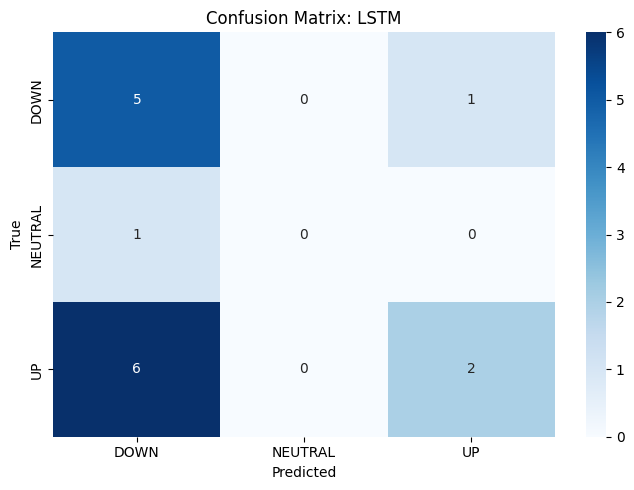

[ADANIPORTS] Results DataFrame shape: (15, 27)
[ADANIPORTS] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/ADANIPORTS_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/ADANIPORTS_results.xlsx
[ADANIPORTS] 💾 Saved results to /content/output/ADANIPORTS_results.xlsx
✅ Completed processing for ADANIPORTS
[LICHSGFIN] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[LICHSGFIN] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[LICHSGFIN] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3483 - val_accuracy: 0.0000e+00 - val_loss: 1.0110 - learning_rate: 5.0000e-04
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 -

Model: "LSTM_Model"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9091 - loss: 0.2179

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

[SRF] Predictions generated. y_pred length: 15, dates_future length: 15
Epoch 1/50

Epoch 9: val_loss improved from 1.01105 to 1.00674, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.67      1.00      0.80        10
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         4

    accuracy                           0.67        15
   macro avg       0.22      0.33      0.27        15
weighted avg       0.44      0.67      0.53        15



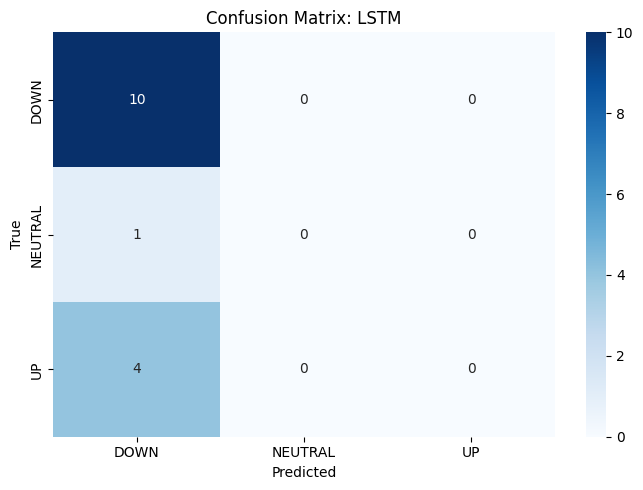

[SRF] Results DataFrame shape: (15, 27)
[SRF] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/SRF_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/SRF_results.xlsx
[SRF] 💾 Saved results to /content/output/SRF_results.xlsx
✅ Completed processing for SRF
[KOTAKBANK] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[KOTAKBANK] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[KOTAKBANK] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.8334
Epoch 5: val_loss improved from 1.14349 to 1.14269, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2179 - val_accuracy: 0.0000e+00 - val_loss: 1.0067 - learning_rate: 5.0000e-04
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.2417
Epoch 10: val_loss improved from 1.00674 to 1.00217, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.8334 - val_accuracy: 0.0000e+00 - val_loss: 1.1427 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2417 - val_accuracy: 0.0000e+00 - val_loss: 1.0022 - learning_rate: 5.0000e-04
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8182 - loss: 0.3080
Epoch 11: val_loss improved from 1.00217 to 0.99339, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.6843
Epoch 6: val_loss improved from 1.14269 to 1.13915, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3080 - val_accuracy: 0.0000e+00 - val_loss: 0.9934 - learning_rate: 5.0000e-04
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.6843 - val_accuracy: 0.0000e+00 - val_loss: 1.1392 - learning_rate: 5.0000e-04
Epoch 7/50

Epoch 12: val_loss improved from 0.99339 to 0.98152, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.6364 - loss: 0.8036
Epoch 7: val_loss improved from 1.13915 to 1.13693, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2638 - val_accuracy: 1.0000 - val_loss: 0.9815 - learning_rate: 5.0000e-04
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.8036 - val_accuracy: 0.0000e+00 - val_loss: 1.1369 - learning_rate: 5.0000e-04
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1818 - loss: 1.5755
Epoch 8: val_loss improved from 1.13693 to 1.13235, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 1.0000 - loss: 0.1613
Epoch 13: val_loss improved from 0.98152 to 0.96912, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.7085 - val_accuracy: 0.0000e+00 - val_loss: 1.1324 - learning_rate: 5.0000e-04
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3636 - loss: 1.5028
Epoch 9: val_loss improved from 1.13235 to 1.12631, saving model to /content/checkpoints/LT/LT_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.13984, saving model to /content/checkpoints/LICHSGFIN/LICHSGFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1613 - val_accuracy: 1.0000 - val_loss: 0.9691 - learning_rate: 5.0000e-04
Epoch 14/50

Epoch 1: val_loss improved from inf to 1.07259, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6069 - val_accuracy: 0.0000e+00 - val_loss: 1.1263 - learning_rate: 5.0000e-04
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.1818 - loss: 1.5755 - val_accuracy: 0.0000e+00 - val_loss: 1.1398 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2727 - loss: 1.3537
Epoch 10: val_loss improved from 1.12631 to 1.12000, saving model to /content/checkpoints/LT/LT_lstm_model.h5



Epoch 2: val_loss improved from 1.13984 to 1.13714, saving model to /content/checkpoints/LICHSGFIN/LICHSGFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.3636 - loss: 1.5028 - val_accuracy: 0.0000e+00 - val_loss: 1.0726 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5455 - loss: 0.9659
Epoch 2: val_loss improved from 1.07259 to 1.05147, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3514
Epoch 14: val_loss improved from 0.96912 to 0.95432, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step - accuracy: 0.4545 - loss: 0.8073 - val_accuracy: 0.0000e+00 - val_loss: 1.1200 - learning_rate: 5.0000e-04
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.3537 - val_accuracy: 0.0000e+00 - val_loss: 1.1371 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4545 - loss: 1.2929
Epoch 3: val_loss did not improve from 1.13714
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.9659 - val_accuracy: 1.0000 - val_loss: 1.0515 - learning_rate: 0.0010
Epoch 3/50

Epoch 11: val_loss improved from 1.12000 to 1.11329, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3514 - val_accuracy: 1.0000 - val_loss: 0.9543 - learning_rate: 5.0000e-04
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.6364 - loss: 0.7649
Epoch 15: val_loss improved from 0.95432 to 0.94075, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5



Epoch 3: val_loss improved from 1.05147 to 1.02727, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step - accuracy: 0.4545 - loss: 1.2929 - val_accuracy: 0.0000e+00 - val_loss: 1.1523 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.5314 - val_accuracy: 0.0000e+00 - val_loss: 1.1133 - learning_rate: 5.0000e-04
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step - accuracy: 1.0000 - loss: 0.0913 - val_accuracy: 1.0000 - val_loss: 0.9407 - learning_rate: 5.0000e-04
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.7649 - val_accuracy: 1.0000 - val_loss: 1.0273 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.8182 - loss: 0.5103
Epoch 4: val_loss did not improve from 1.13714

Epoch 16: val_loss improved from 0.94075 to 0.92789, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5



Epoch 12: val_loss improved from 1.11329 to 1.10520, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.8182 - loss: 0.5584
Epoch 4: val_loss improved from 1.02727 to 1.01303, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.9748 - val_accuracy: 0.0000e+00 - val_loss: 1.1869 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9091 - loss: 0.5419
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_loss did not improve from 1.13714
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1527 - val_accuracy: 1.0000 - val_loss: 0.9279 - learning_rate: 5.0000e-04
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9091 - loss: 0.1768
Epoch 17: val_loss improved from 0.92789 to 0.91715, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5103 - val_accuracy: 0.0000e+00 - val_loss: 1.1052 - learning_rate: 5.0000e-04
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.4300
Epoch 13: val_loss improved from 1.10520 to 1.09825, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step - accuracy: 0.9091 - loss: 0.5419 - val_accuracy: 0.0000e+00 - val_loss: 1.2271 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5584 - val_accuracy: 1.0000 - val_loss: 1.0130 - learning_rate: 0.0010
Epoch 5/50
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8182 - loss: 0.5979
Epoch 5: val_loss improved from 1.01303 to 0.99951, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5



Epoch 6: val_loss did not improve from 1.13714
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1768 - val_accuracy: 1.0000 - val_loss: 0.9171 - learning_rate: 5.0000e-04
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.4300 - val_accuracy: 0.0000e+00 - val_loss: 1.0982 - learning_rate: 5.0000e-04
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step - accuracy: 0.8182 - loss: 0.5979 - val_accuracy: 0.0000e+00 - val_loss: 1.2435 - learning_rate: 5.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8182 - loss: 0.4967
Epoch 18: val_loss improved from 0.91715 to 0.90606, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6277 - val_accuracy: 1.0000 - val_loss: 0.9995 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7273 - loss: 0.6094
Epoch 14: val_loss improved from 1.09825 to 1.09100, saving model to /content/checkpoints/LT/LT_lstm_model.h5



Epoch 6: val_loss improved from 0.99951 to 0.99474, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5



Epoch 7: val_loss did not improve from 1.13714
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1420 - val_accuracy: 1.0000 - val_loss: 0.9061 - learning_rate: 5.0000e-04
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4967 - val_accuracy: 0.0000e+00 - val_loss: 1.0910 - learning_rate: 5.0000e-04
Epoch 15/50

Epoch 19: val_loss improved from 0.90606 to 0.89613, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6094 - val_accuracy: 0.0000e+00 - val_loss: 1.2572 - learning_rate: 5.0000e-04
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6191 - val_accuracy: 1.0000 - val_loss: 0.9947 - learning_rate: 0.0010
Epoch 7/50
[LICHSGFIN] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8182 - loss: 0.6507Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[LICHSGFIN] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[LICHSGFIN] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 2 2 2 2 2 2 0 0 2 0 1]

Epoch 7: val_loss improved from 0.99474 to 0.98744, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


[LICHSGFIN] ✅ Loaded best model from /content/checkpoints/LICHSGFIN/LICHSGFIN_lstm_model.h5
[LICHSGFIN] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0980 - val_accuracy: 1.0000 - val_loss: 0.8961 - learning_rate: 5.0000e-04
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0718
Epoch 20: val_loss improved from 0.89613 to 0.88646, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6507 - val_accuracy: 1.0000 - val_loss: 0.9874 - learning_rate: 0.0010
Epoch 8/50

Epoch 15: val_loss improved from 1.09100 to 1.08341, saving model to /content/checkpoints/LT/LT_lstm_model.h5


[LICHSGFIN] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         3
     NEUTRAL       0.11      1.00      0.20         1
          UP       0.50      0.27      0.35        11

    accuracy                           0.27        15
   macro avg       0.20      0.42      0.18        15
weighted avg       0.37      0.27      0.27        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.7273 - loss: 0.8387
Epoch 8: val_loss improved from 0.98744 to 0.98573, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


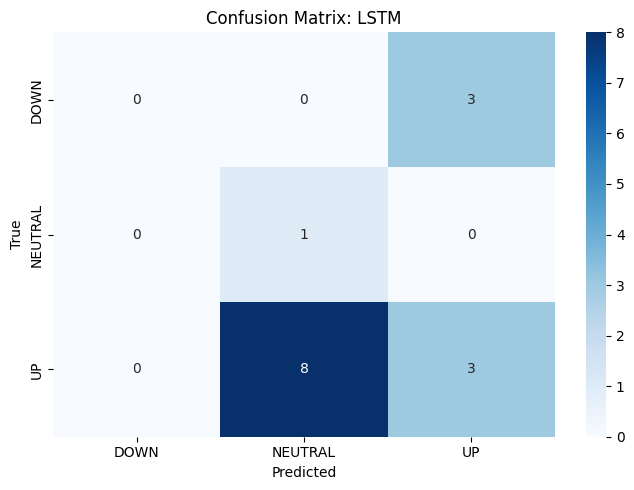

[LICHSGFIN] Results DataFrame shape: (15, 27)
[LICHSGFIN] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/LICHSGFIN_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/LICHSGFIN_results.xlsx
[LICHSGFIN] 💾 Saved results to /content/output/LICHSGFIN_results.xlsx
✅ Completed processing for LICHSGFIN
[JUBLFOOD] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[JUBLFOOD] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[JUBLFOOD] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0718 - val_accuracy: 1.0000 - val_loss: 0.8865 - learning_rate: 5.0000e-04
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 21: val_loss improved from 0.88646 to 0.87565, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.3835 - val_accuracy: 0.0000e+00 - val_loss: 1.0834 - learning_rate: 5.0000e-04
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.8387 - val_accuracy: 1.0000 - val_loss: 0.9857 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7273 - loss: 0.5699
Epoch 9: val_loss improved from 0.98573 to 0.97845, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1094 - val_accuracy: 1.0000 - val_loss: 0.8757 - learning_rate: 5.0000e-04
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.1028
Epoch 22: val_loss improved from 0.87565 to 0.86662, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4723
Epoch 16: val_loss improved from 1.08341 to 1.07615, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5699 - val_accuracy: 1.0000 - val_loss: 0.9785 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1028 - val_accuracy: 1.0000 - val_loss: 0.8666 - learning_rate: 5.0000e-04
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4723 - val_accuracy: 0.0000e+00 - val_loss: 1.0761 - learning_rate: 5.0000e-04
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - accuracy: 0.9091 - loss: 0.1491
Epoch 10: val_loss improved from 0.97845 to 0.96779, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5



Epoch 23: val_loss improved from 0.86662 to 0.85925, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.3273
Epoch 17: val_loss improved from 1.07615 to 1.06899, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.8653 - val_accuracy: 1.0000 - val_loss: 0.9678 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1491 - val_accuracy: 1.0000 - val_loss: 0.8593 - learning_rate: 5.0000e-04
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9091 - loss: 0.5692
Epoch 11: val_loss improved from 0.96779 to 0.95638, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 1.0000 - loss: 0.0597
Epoch 24: val_loss improved from 0.85925 to 0.85300, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.3273 - val_accuracy: 0.0000e+00 - val_loss: 1.0690 - learning_rate: 5.0000e-04
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9091 - loss: 0.4177
Epoch 18: val_loss improved from 1.06899 to 1.06207, saving model to /content/checkpoints/LT/LT_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.08394, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.5692 - val_accuracy: 1.0000 - val_loss: 0.9564 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0597 - val_accuracy: 1.0000 - val_loss: 0.8530 - learning_rate: 5.0000e-04
Epoch 25/50

Epoch 12: val_loss improved from 0.95638 to 0.94367, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.3636 - loss: 1.3262 - val_accuracy: 0.0000e+00 - val_loss: 1.0839 - learning_rate: 0.0010
Epoch 2/50

Epoch 25: val_loss improved from 0.85300 to 0.84757, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4177 - val_accuracy: 0.0000e+00 - val_loss: 1.0621 - learning_rate: 5.0000e-04
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.2990
Epoch 19: val_loss improved from 1.06207 to 1.05595, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step - accuracy: 0.8182 - loss: 0.5409 - val_accuracy: 1.0000 - val_loss: 0.9437 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8182 - loss: 0.6270
Epoch 13: val_loss improved from 0.94367 to 0.93846, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0595 - val_accuracy: 1.0000 - val_loss: 0.8476 - learning_rate: 5.0000e-04
Epoch 26/50

Epoch 2: val_loss improved from 1.08394 to 1.06887, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.1096
Epoch 26: val_loss improved from 0.84757 to 0.84461, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step - accuracy: 1.0000 - loss: 0.2990 - val_accuracy: 1.0000 - val_loss: 1.0559 - learning_rate: 5.0000e-04
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.3895
Epoch 20: val_loss improved from 1.05595 to 1.04947, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6270 - val_accuracy: 1.0000 - val_loss: 0.9385 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8182 - loss: 0.5417
Epoch 14: val_loss improved from 0.93846 to 0.93399, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.8644 - val_accuracy: 0.0000e+00 - val_loss: 1.0689 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1096 - val_accuracy: 1.0000 - val_loss: 0.8446 - learning_rate: 5.0000e-04
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.3895 - val_accuracy: 1.0000 - val_loss: 1.0495 - learning_rate: 5.0000e-04
Epoch 21/50

Epoch 3: val_loss improved from 1.06887 to 1.04654, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5



Epoch 27: val_loss improved from 0.84461 to 0.84108, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.2315


Epoch 21: val_loss improved from 1.04947 to 1.04365, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5417 - val_accuracy: 1.0000 - val_loss: 0.9340 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6622 - val_accuracy: 0.0000e+00 - val_loss: 1.0465 - learning_rate: 0.0010
Epoch 4/50

Epoch 15: val_loss improved from 0.93399 to 0.91531, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0907 - val_accuracy: 1.0000 - val_loss: 0.8411 - learning_rate: 5.0000e-04
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2315 - val_accuracy: 1.0000 - val_loss: 1.0437 - learning_rate: 5.0000e-04
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.2810
Epoch 28: val_loss improved from 0.84108 to 0.83883, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5



Epoch 22: val_loss improved from 1.04365 to 1.03766, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6201 - val_accuracy: 1.0000 - val_loss: 0.9153 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0493 - val_accuracy: 1.0000 - val_loss: 0.8388 - learning_rate: 5.0000e-04
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step - accuracy: 1.0000 - loss: 0.2810 - val_accuracy: 1.0000 - val_loss: 1.0377 - learning_rate: 5.0000e-04
Epoch 23/50

Epoch 4: val_loss improved from 1.04654 to 1.01923, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.3388
Epoch 29: val_loss improved from 0.83883 to 0.83797, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5



Epoch 23: val_loss improved from 1.03766 to 1.03115, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.8578 - val_accuracy: 1.0000 - val_loss: 1.0192 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step - accuracy: 1.0000 - loss: 0.0606 - val_accuracy: 1.0000 - val_loss: 0.8380 - learning_rate: 5.0000e-04
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step - accuracy: 1.0000 - loss: 0.3388 - val_accuracy: 1.0000 - val_loss: 1.0312 - learning_rate: 5.0000e-04
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3928
Epoch 16: val_loss improved from 0.91531 to 0.89446, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5



Epoch 24: val_loss improved from 1.03115 to 1.02585, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9091 - loss: 0.1007
Epoch 5: val_loss improved from 1.01923 to 0.99723, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5



Epoch 30: val_loss improved from 0.83797 to 0.83691, saving model to /content/checkpoints/ACC/ACC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3928 - val_accuracy: 1.0000 - val_loss: 0.8945 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step - accuracy: 1.0000 - loss: 0.2306 - val_accuracy: 1.0000 - val_loss: 1.0259 - learning_rate: 5.0000e-04
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.2640
Epoch 25: val_loss improved from 1.02585 to 1.02019, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5659 - val_accuracy: 1.0000 - val_loss: 0.9972 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1007 - val_accuracy: 1.0000 - val_loss: 0.8369 - learning_rate: 5.0000e-04
Epoch 31/50

Epoch 17: val_loss improved from 0.89446 to 0.87492, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5



Epoch 6: val_loss improved from 0.99723 to 0.97702, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 1.0000 - loss: 0.0673
Epoch 31: val_loss did not improve from 0.83691
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step - accuracy: 1.0000 - loss: 0.2640 - val_accuracy: 1.0000 - val_loss: 1.0202 - learning_rate: 5.0000e-04
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 1.0000 - loss: 0.2840
Epoch 26: val_loss improved from 1.02019 to 1.01554, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.6620 - val_accuracy: 1.0000 - val_loss: 0.8749 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step - accuracy: 1.0000 - loss: 0.0673 - val_accuracy: 1.0000 - val_loss: 0.8374 - learning_rate: 5.0000e-04
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6383 - val_accuracy: 1.0000 - val_loss: 0.9770 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7273 - loss: 0.6001
Epoch 32: val_loss did not improve from 0.83691

Epoch 7: val_loss improved from 0.97702 to 0.95759, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5



Epoch 18: val_loss improved from 0.87492 to 0.85722, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2840 - val_accuracy: 1.0000 - val_loss: 1.0155 - learning_rate: 5.0000e-04
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step - accuracy: 1.0000 - loss: 0.0603 - val_accuracy: 1.0000 - val_loss: 0.8395 - learning_rate: 5.0000e-04
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0718
Epoch 27: val_loss improved from 1.01554 to 1.01176, saving model to /content/checkpoints/LT/LT_lstm_model.h5



Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 33: val_loss did not improve from 0.83691
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3556 - val_accuracy: 1.0000 - val_loss: 0.9576 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6001 - val_accuracy: 1.0000 - val_loss: 0.8572 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9091 - loss: 0.3990
Epoch 8: val_loss improved from 0.95759 to 0.93908, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5



Epoch 19: val_loss improved from 0.85722 to 0.84152, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step - accuracy: 1.0000 - loss: 0.0718 - val_accuracy: 1.0000 - val_loss: 0.8430 - learning_rate: 5.0000e-04
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2419 - val_accuracy: 1.0000 - val_loss: 1.0118 - learning_rate: 5.0000e-04
Epoch 28/50

Epoch 34: val_loss did not improve from 0.83691
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.2459
Epoch 28: val_loss improved from 1.01176 to 1.00729, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1980 - val_accuracy: 1.0000 - val_loss: 0.9391 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3990 - val_accuracy: 1.0000 - val_loss: 0.8415 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step - accuracy: 1.0000 - loss: 0.0665 - val_accuracy: 1.0000 - val_loss: 0.8442 - learning_rate: 2.5000e-04
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0891
Epoch 9: val_loss improved from 0.93908 to 0.91798, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5



Epoch 20: val_loss improved from 0.84152 to 0.82677, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5



Epoch 35: val_loss did not improve from 0.83691
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2459 - val_accuracy: 1.0000 - val_loss: 1.0073 - learning_rate: 5.0000e-04
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.2211
Epoch 29: val_loss improved from 1.00729 to 1.00328, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step - accuracy: 1.0000 - loss: 0.0891 - val_accuracy: 1.0000 - val_loss: 0.8452 - learning_rate: 2.5000e-04
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 30.
[ACC] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[ACC] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[ACC] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 2 0 0 0 0 0 2 2 0 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3720 - val_accuracy: 1.0000 - val_loss: 0.9180 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9091 - loss: 0.2889

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5219 - val_accuracy: 1.0000 - val_loss: 0.8268 - learning_rate: 0.0010
[ACC] ✅ Loaded best model from /content/checkpoints/ACC/ACC_lstm_model.h5
[ACC] Predicting for 15 dates, including 30-07-2025
Epoch 21/50

Epoch 10: val_loss improved from 0.91798 to 0.90178, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


[ACC] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2211 - val_accuracy: 1.0000 - val_loss: 1.0033 - learning_rate: 5.0000e-04
Epoch 30/50

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         7
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.47      1.00      0.64         7

    accuracy                           0.47        15
   macro avg       0.16      0.33      0.21        15
weighted avg       0.22      0.47      0.30        15



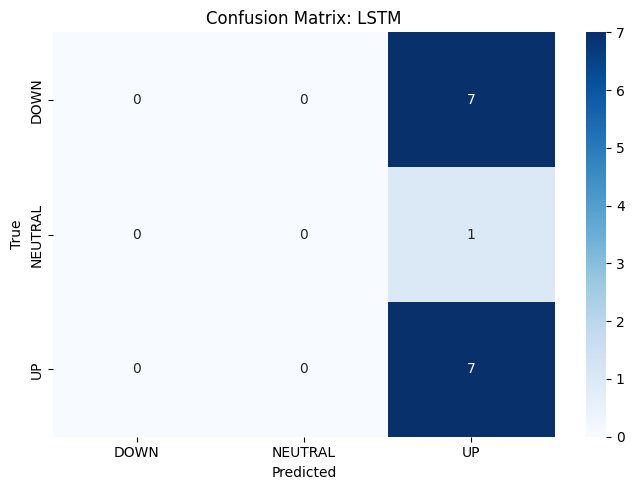

[ACC] Results DataFrame shape: (15, 27)
[ACC] Prediction dates: [Timestamp('2025-07-10 00:00:00'), Timestamp('2025-07-11 00:00:00'), Timestamp('2025-07-14 00:00:00'), Timestamp('2025-07-15 00:00:00'), Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4855Excel report successfully generated: /content/output/ACC_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/ACC_results.xlsx
[ACC] 💾 Saved results to /content/output/ACC_results.xlsx
✅ Completed processing for ACC
[SUNPHARMA] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2889 - val_accuracy: 1.0000 - val_loss: 0.9018 - learning_rate: 0.0010
Epoch 11/50
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[SUNPHARMA] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[SUNPHARMA] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9091 - loss: 0.3089Unique classes: ['DOWN' 'NEUTRAL' 'UP']

Epoch 21: val_loss improved from 0.82677 to 0.81249, saving model 

Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 11: val_loss improved from 0.90178 to 0.88810, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1928
Epoch 30: val_loss improved from 1.00328 to 1.00022, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4855 - val_accuracy: 1.0000 - val_loss: 0.8125 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3089 - val_accuracy: 1.0000 - val_loss: 0.8881 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1928 - val_accuracy: 1.0000 - val_loss: 1.0002 - learning_rate: 5.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 0.1957Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.1840
Epoch 12: val_loss improved from 0.88810 to 0.87654, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5



Epoch 31: val_loss improved from 1.00022 to 0.99799, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.5128
Epoch 22: val_loss improved from 0.81249 to 0.79336, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1957 - val_accuracy: 1.0000 - val_loss: 0.8765 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1840 - val_accuracy: 1.0000 - val_loss: 0.9980 - learning_rate: 5.0000e-04
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.1668
Epoch 32: val_loss improved from 0.99799 to 0.99677, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5128 - val_accuracy: 1.0000 - val_loss: 0.7934 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8182 - loss: 0.4768
Epoch 23: val_loss improved from 0.79336 to 0.77408, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4820
Epoch 13: val_loss improved from 0.87654 to 0.86698, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1668 - val_accuracy: 1.0000 - val_loss: 0.9968 - learning_rate: 5.0000e-04
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.1285
Epoch 33: val_loss improved from 0.99677 to 0.99496, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4768 - val_accuracy: 1.0000 - val_loss: 0.7741 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8182 - loss: 0.3982
Epoch 24: val_loss improved from 0.77408 to 0.75515, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4820 - val_accuracy: 1.0000 - val_loss: 0.8670 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1285 - val_accuracy: 1.0000 - val_loss: 0.9950 - learning_rate: 5.0000e-04
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.1778
Epoch 34: val_loss improved from 0.99496 to 0.99331, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3982 - val_accuracy: 1.0000 - val_loss: 0.7552 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 1.0000 - loss: 0.1554
Epoch 25: val_loss improved from 0.75515 to 0.74245, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5



Epoch 14: val_loss improved from 0.86698 to 0.85667, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1778 - val_accuracy: 1.0000 - val_loss: 0.9933 - learning_rate: 5.0000e-04
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 1.0000 - loss: 0.1265
Epoch 35: val_loss improved from 0.99331 to 0.99035, saving model to /content/checkpoints/LT/LT_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.10271, saving model to /content/checkpoints/SUNPHARMA/SUNPHARMA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3964 - val_accuracy: 1.0000 - val_loss: 0.7424 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1554 - val_accuracy: 1.0000 - val_loss: 0.8567 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1265 - val_accuracy: 1.0000 - val_loss: 0.9904 - learning_rate: 5.0000e-04
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.6364 - loss: 0.8858 - val_accuracy: 0.0000e+00 - val_loss: 1.1027 - learning_rate: 0.0010
Epoch 2/50

Epoch 36: val_loss improved from 0.99035 to 0.98753, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 1.0000 - loss: 0.1230 - val_accuracy: 1.0000 - val_loss: 0.9875 - learning_rate: 5.0000e-04
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 1.0000 - loss: 0.1211
Epoch 37: val_loss improved from 0.98753 to 0.98522, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3237
Epoch 26: val_loss improved from 0.74245 to 0.72506, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5



Epoch 15: val_loss improved from 0.85667 to 0.85114, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.7308
Epoch 2: val_loss improved from 1.10271 to 1.07488, saving model to /content/checkpoints/SUNPHARMA/SUNPHARMA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1211 - val_accuracy: 1.0000 - val_loss: 0.9852 - learning_rate: 5.0000e-04
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4714 - val_accuracy: 1.0000 - val_loss: 0.7251 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3237 - val_accuracy: 1.0000 - val_loss: 0.8511 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7308 - val_accuracy: 0.0000e+00 - val_loss: 1.0749 - learning_rate: 0.0010
Epoch 3/50

Epoch 16: val_loss improved from 0.85114 to 0.84751, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9091 - loss: 0.4936
Epoch 38: val_loss improved from 0.98522 to 0.98136, saving model to /content/checkpoints/LT/LT_lstm_model.h5



Epoch 27: val_loss improved from 0.72506 to 0.71209, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.6364 - loss: 0.7472
Epoch 3: val_loss improved from 1.07488 to 1.06108, saving model to /content/checkpoints/SUNPHARMA/SUNPHARMA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step - accuracy: 1.0000 - loss: 0.1481 - val_accuracy: 1.0000 - val_loss: 0.8475 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8182 - loss: 0.3032
Epoch 17: val_loss improved from 0.84751 to 0.84440, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1638 - val_accuracy: 1.0000 - val_loss: 0.9814 - learning_rate: 5.0000e-04
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4936 - val_accuracy: 1.0000 - val_loss: 0.7121 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8182 - loss: 0.4497
Epoch 39: val_loss improved from 0.98136 to 0.97686, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.7472 - val_accuracy: 1.0000 - val_loss: 1.0611 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8182 - loss: 0.4814
Epoch 28: val_loss improved from 0.71209 to 0.70581, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5



Epoch 4: val_loss improved from 1.06108 to 1.04829, saving model to /content/checkpoints/SUNPHARMA/SUNPHARMA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step - accuracy: 0.8182 - loss: 0.3032 - val_accuracy: 1.0000 - val_loss: 0.8444 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8182 - loss: 0.2890
Epoch 18: val_loss improved from 0.84440 to 0.84181, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0957 - val_accuracy: 1.0000 - val_loss: 0.9769 - learning_rate: 5.0000e-04
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.1278
Epoch 40: val_loss improved from 0.97686 to 0.97231, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4814 - val_accuracy: 1.0000 - val_loss: 1.0483 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4497 - val_accuracy: 1.0000 - val_loss: 0.7058 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8182 - loss: 0.4398
Epoch 5: val_loss improved from 1.04829 to 1.03542, saving model to /content/checkpoints/SUNPHARMA/SUNPHARMA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.2890 - val_accuracy: 1.0000 - val_loss: 0.8418 - learning_rate: 0.0010
Epoch 19/50

Epoch 29: val_loss improved from 0.70581 to 0.70499, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8182 - loss: 0.2598
Epoch 19: val_loss improved from 0.84181 to 0.83082, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1278 - val_accuracy: 1.0000 - val_loss: 0.9723 - learning_rate: 5.0000e-04
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4442 - val_accuracy: 1.0000 - val_loss: 1.0354 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4398 - val_accuracy: 1.0000 - val_loss: 0.7050 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9091 - loss: 0.3836
Epoch 41: val_loss improved from 0.97231 to 0.96826, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.2598 - val_accuracy: 1.0000 - val_loss: 0.8308 - learning_rate: 0.0010
Epoch 20/50

Epoch 30: val_loss did not improve from 0.70499

Epoch 6: val_loss improved from 1.03542 to 1.02618, saving model to /content/checkpoints/SUNPHARMA/SUNPHARMA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3836 - val_accuracy: 1.0000 - val_loss: 0.7062 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0959 - val_accuracy: 1.0000 - val_loss: 0.9683 - learning_rate: 5.0000e-04
Epoch 31/50
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4658 - val_accuracy: 1.0000 - val_loss: 1.0262 - learning_rate: 0.0010
Epoch 7/50

Epoch 42: val_loss improved from 0.96826 to 0.96394, saving model to /content/checkpoints/LT/LT_lstm_model.h5



Epoch 31: val_loss improved from 0.70499 to 0.70397, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step - accuracy: 1.0000 - loss: 0.0668 - val_accuracy: 1.0000 - val_loss: 0.9639 - learning_rate: 5.0000e-04
Epoch 43/50

Epoch 20: val_loss improved from 0.83082 to 0.82134, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2725 - val_accuracy: 1.0000 - val_loss: 0.7040 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8182 - loss: 0.3624
Epoch 43: val_loss improved from 0.96394 to 0.95969, saving model to /content/checkpoints/LT/LT_lstm_model.h5



Epoch 32: val_loss improved from 0.70397 to 0.69555, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2543 - val_accuracy: 1.0000 - val_loss: 0.8213 - learning_rate: 0.0010
Epoch 21/50

Epoch 7: val_loss improved from 1.02618 to 1.01349, saving model to /content/checkpoints/SUNPHARMA/SUNPHARMA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step - accuracy: 1.0000 - loss: 0.0814 - val_accuracy: 1.0000 - val_loss: 0.9597 - learning_rate: 5.0000e-04
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step - accuracy: 0.8182 - loss: 0.3624 - val_accuracy: 1.0000 - val_loss: 0.6956 - learning_rate: 0.0010
Epoch 33/50

Epoch 44: val_loss improved from 0.95969 to 0.95526, saving model to /content/checkpoints/LT/LT_lstm_model.h5



Epoch 21: val_loss improved from 0.82134 to 0.81219, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3858 - val_accuracy: 1.0000 - val_loss: 1.0135 - learning_rate: 0.0010
Epoch 8/50

Epoch 33: val_loss improved from 0.69555 to 0.68488, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1173 - val_accuracy: 1.0000 - val_loss: 0.9553 - learning_rate: 5.0000e-04
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.1229
Epoch 8: val_loss improved from 1.01349 to 0.99704, saving model to /content/checkpoints/SUNPHARMA/SUNPHARMA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2611 - val_accuracy: 1.0000 - val_loss: 0.8122 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9091 - loss: 0.2846
Epoch 45: val_loss improved from 0.95526 to 0.95143, saving model to /content/checkpoints/LT/LT_lstm_model.h5



Epoch 22: val_loss improved from 0.81219 to 0.80144, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3422 - val_accuracy: 1.0000 - val_loss: 0.6849 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8182 - loss: 0.4627
Epoch 34: val_loss improved from 0.68488 to 0.67745, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1229 - val_accuracy: 1.0000 - val_loss: 0.9514 - learning_rate: 5.0000e-04
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3378 - val_accuracy: 1.0000 - val_loss: 0.9970 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2846 - val_accuracy: 1.0000 - val_loss: 0.8014 - learning_rate: 0.0010
Epoch 23/50

Epoch 9: val_loss improved from 0.99704 to 0.97889, saving model to /content/checkpoints/SUNPHARMA/SUNPHARMA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9091 - loss: 0.2083
Epoch 46: val_loss improved from 0.95143 to 0.94661, saving model to /content/checkpoints/LT/LT_lstm_model.h5



Epoch 23: val_loss improved from 0.80144 to 0.79115, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4627 - val_accuracy: 1.0000 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8182 - loss: 0.3461
Epoch 35: val_loss improved from 0.67745 to 0.66136, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3910 - val_accuracy: 1.0000 - val_loss: 0.9789 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1049 - val_accuracy: 1.0000 - val_loss: 0.9466 - learning_rate: 5.0000e-04
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2083 - val_accuracy: 1.0000 - val_loss: 0.7912 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 0.1336
Epoch 10: val_loss improved from 0.97889 to 0.95682, saving model to /content/checkpoints/SUNPHARMA/SUNPHARMA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3461 - val_accuracy: 1.0000 - val_loss: 0.6614 - learning_rate: 0.0010

Epoch 24: val_loss improved from 0.79115 to 0.77839, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


Epoch 36/50

Epoch 47: val_loss improved from 0.94661 to 0.94151, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8182 - loss: 0.3223
Epoch 36: val_loss improved from 0.66136 to 0.64132, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2299 - val_accuracy: 1.0000 - val_loss: 0.9568 - learning_rate: 0.0010
Epoch 11/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1336 - val_accuracy: 1.0000 - val_loss: 0.7784 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0744 - val_accuracy: 1.0000 - val_loss: 0.9415 - learning_rate: 5.0000e-04
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0806
Epoch 25: val_loss improved from 0.77839 to 0.76516, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5



Epoch 11: val_loss improved from 0.95682 to 0.93870, saving model to /content/checkpoints/SUNPHARMA/SUNPHARMA_lstm_model.h5



Epoch 48: val_loss improved from 0.94151 to 0.93648, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3223 - val_accuracy: 1.0000 - val_loss: 0.6413 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 1.0000 - loss: 0.2240
Epoch 37: val_loss improved from 0.64132 to 0.62538, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1038 - val_accuracy: 1.0000 - val_loss: 0.7652 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2227 - val_accuracy: 1.0000 - val_loss: 0.9387 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0806 - val_accuracy: 1.0000 - val_loss: 0.9365 - learning_rate: 5.0000e-04
Epoch 49/50

Epoch 26: val_loss improved from 0.76516 to 0.75412, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 0.0644
Epoch 12: val_loss improved from 0.93870 to 0.92519, saving model to /content/checkpoints/SUNPHARMA/SUNPHARMA_lstm_model.h5



Epoch 49: val_loss improved from 0.93648 to 0.93083, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2240 - val_accuracy: 1.0000 - val_loss: 0.6254 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9091 - loss: 0.2341
Epoch 38: val_loss improved from 0.62538 to 0.60984, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1059 - val_accuracy: 1.0000 - val_loss: 0.7541 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9091 - loss: 0.1647
Epoch 27: val_loss improved from 0.75412 to 0.74408, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1703 - val_accuracy: 1.0000 - val_loss: 0.9252 - learning_rate: 0.0010
Epoch 13/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0644 - val_accuracy: 1.0000 - val_loss: 0.9308 - learning_rate: 5.0000e-04
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9091 - loss: 0.2026
Epoch 13: val_loss improved from 0.92519 to 0.91601, saving model to /content/checkpoints/SUNPHARMA/SUNPHARMA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 1.0000 - loss: 0.0745
Epoch 50: val_loss improved from 0.93083 to 0.92481, saving model to /content/checkpoints/LT/LT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2341 - val_accuracy: 1.0000 - val_loss: 0.6098 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9091 - loss: 0.2192
Epoch 39: val_loss improved from 0.60984 to 0.59477, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1647 - val_accuracy: 1.0000 - val_loss: 0.7441 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2026 - val_accuracy: 1.0000 - val_loss: 0.9160 - learning_rate: 0.0010
Epoch 14/50

Epoch 28: val_loss improved from 0.74408 to 0.73411, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0745 - val_accuracy: 1.0000 - val_loss: 0.9248 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 50.
[LT] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[LT] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[LT] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]

Epoch 14: val_loss improved from 0.91601 to 0.91387, saving model to /content/checkpoints/SUNPHARMA/SUNPHARMA_lstm_model.h5


[LT] ✅ Loaded best model from /content/checkpoints/LT/LT_lstm_model.h5
[LT] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2192 - val_accuracy: 1.0000 - val_loss: 0.5948 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1657 - val_accuracy: 1.0000 - val_loss: 0.7341 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9091 - loss: 0.1592
Epoch 40: val_loss improved from 0.59477 to 0.58134, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.2895 - val_accuracy: 1.0000 - val_loss: 0.9139 - learning_rate: 0.0010
Epoch 15/50

Epoch 29: val_loss improved from 0.73411 to 0.72434, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9091 - loss: 0.1764[LT] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 15: val_loss improved from 0.91387 to 0.91382, saving model to /content/checkpoints/SUNPHARMA/SUNPHARMA_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.93      1.00      0.97        14
     NEUTRAL       0.00      0.00      0.00         1

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.2593 - val_accuracy: 1.0000 - val_loss: 0.5813 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1592 - val_accuracy: 1.0000 - val_loss: 0.7243 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.1247
Epoch 41: val_loss improved from 0.58134 to 0.56851, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5



Epoch 30: val_loss improved from 0.72434 to 0.71384, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1764 - val_accuracy: 1.0000 - val_loss: 0.9138 - learning_rate: 0.0010
Epoch 16/50


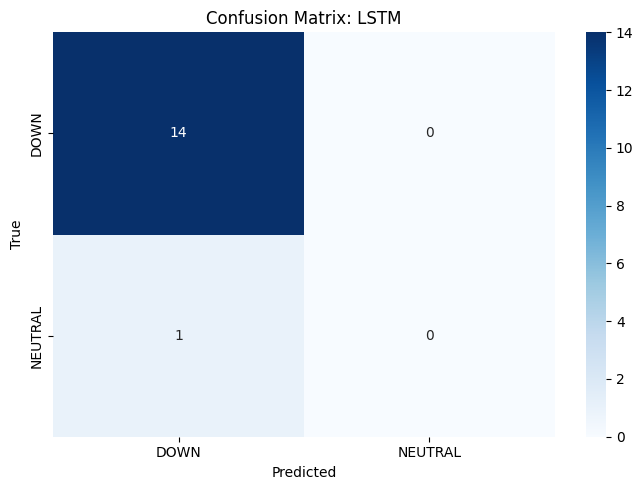

[LT] Results DataFrame shape: (15, 26)
[LT] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 1.0000 - loss: 0.1480Excel report successfully generated: /content/output/LT_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/LT_results.xlsx
[LT] 💾 Saved results to /content/output/LT_results.xlsx
[JSWSTEEL] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for LT
Adding technical indicators... Initial shape: (24, 25)

Epoch 16: val_loss did not improve from 0.91382
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[JSWSTEEL] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[JSWSTEEL] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1247 - val_accuracy: 1.0000 - val_loss: 0.7138 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3556 - val_accuracy: 1.0000 - val_loss: 0.5685 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1480 - val_accuracy: 1.0000 - val_loss: 0.9158 - learning_rate: 0.0010
Epoch 17/50

Epoch 31: val_loss improved from 0.71384 to 0.70299, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5



Epoch 42: val_loss improved from 0.56851 to 0.55705, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1404
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: val_loss did not improve from 0.91382
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.2715 - val_accuracy: 1.0000 - val_loss: 0.5571 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.2021 - val_accuracy: 1.0000 - val_loss: 0.7030 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9091 - loss: 0.3881
Epoch 43: val_loss improved from 0.55705 to 0.54856, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1404 - val_accuracy: 1.0000 - val_loss: 0.9190 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0938
Epoch 32: val_loss improved from 0.70299 to 0.69483, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5



Epoch 18: val_loss did not improve from 0.91382
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3881 - val_accuracy: 1.0000 - val_loss: 0.5486 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9091 - loss: 0.2094
Epoch 44: val_loss improved from 0.54856 to 0.53798, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0938 - val_accuracy: 1.0000 - val_loss: 0.9208 - learning_rate: 5.0000e-04
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.1348 - val_accuracy: 1.0000 - val_loss: 0.6948 - learning_rate: 0.0010
Epoch 33/50

Epoch 19: val_loss did not improve from 0.91382
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 0.1237
Epoch 33: val_loss improved from 0.69483 to 0.68322, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2094 - val_accuracy: 1.0000 - val_loss: 0.5380 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step - accuracy: 1.0000 - loss: 0.1100 - val_accuracy: 1.0000 - val_loss: 0.9188 - learning_rate: 5.0000e-04
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4545 - loss: 0.8890
Epoch 45: val_loss improved from 0.53798 to 0.52422, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 1.0000 - loss: 0.0961
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 20: val_loss did not improve from 0.91382
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1237 - val_accuracy: 1.0000 - val_loss: 0.6832 - learning_rate: 0.0010
Epoch 34/50

Epoch 1: val_loss improved from inf to 1.10026, saving model to /content/checkpoints/JSWSTEEL/JSWSTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2523 - val_accuracy: 1.0000 - val_loss: 0.5242 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0961 - val_accuracy: 1.0000 - val_loss: 0.9168 - learning_rate: 5.0000e-04
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 15.
[SUNPHARMA] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[SUNPHARMA] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[SUNPHARMA] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 0 2 2 2 0 0 0 0 2 2 1]


[SUNPHARMA] ✅ Loaded best model from /content/checkpoints/SUNPHARMA/SUNPHARMA_lstm_model.h5
[SUNPHARMA] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.4545 - loss: 0.8890 - val_accuracy: 0.0000e+00 - val_loss: 1.1003 - learning_rate: 0.0010
Epoch 2/50


[SUNPHARMA] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.70      0.78      0.74         9
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.60      0.60      0.60         5

    accuracy                           0.67        15
   macro avg       0.43      0.46      0.45        15
weighted avg       0.62      0.67      0.64        15



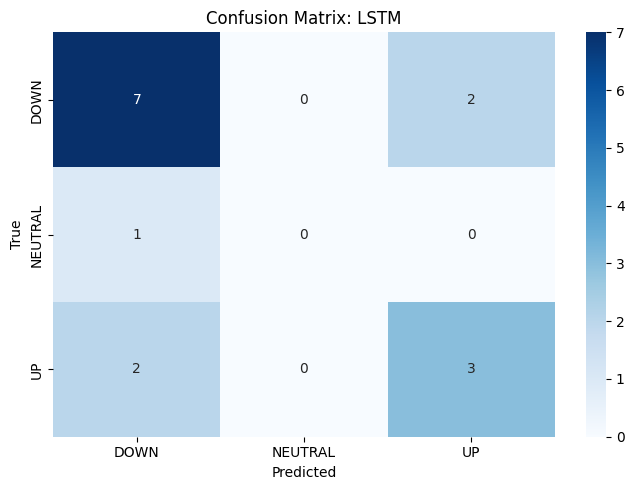

[SUNPHARMA] Results DataFrame shape: (15, 27)
[SUNPHARMA] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/SUNPHARMA_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/SUNPHARMA_results.xlsx
[SUNPHARMA] 💾 Saved results to /content/output/SUNPHARMA_results.xlsx
[JINDALSTEL] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for SUNPHARMA
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[JINDALSTEL] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[JINDALSTEL] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1702
✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 34: val_loss improved from 0.68322 to 0.67144, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.4545 - loss: 0.7729
Epoch 46: val_loss improved from 0.52422 to 0.51159, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5



Epoch 2: val_loss did not improve from 1.10026
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.1702 - val_accuracy: 1.0000 - val_loss: 0.6714 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8182 - loss: 0.2056
Epoch 35: val_loss improved from 0.67144 to 0.65642, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 0.7729 - val_accuracy: 0.0000e+00 - val_loss: 1.1073 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4510 - val_accuracy: 1.0000 - val_loss: 0.5116 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.2056 - val_accuracy: 1.0000 - val_loss: 0.6564 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.7096
Epoch 36: val_loss improved from 0.65642 to 0.63857, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5



Epoch 47: val_loss improved from 0.51159 to 0.50261, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5



Epoch 3: val_loss did not improve from 1.10026
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1603 - val_accuracy: 1.0000 - val_loss: 0.6386 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.7096 - val_accuracy: 0.0000e+00 - val_loss: 1.1146 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2190 - val_accuracy: 1.0000 - val_loss: 0.5026 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9091 - loss: 0.2079
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.10026

Epoch 48: val_loss improved from 0.50261 to 0.49521, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.7818 - val_accuracy: 0.0000e+00 - val_loss: 1.1243 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7273 - loss: 0.6151
Epoch 5: val_loss did not improve from 1.10026

Epoch 37: val_loss improved from 0.63857 to 0.62520, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2079 - val_accuracy: 1.0000 - val_loss: 0.4952 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step - accuracy: 0.7273 - loss: 0.6151 - val_accuracy: 0.0000e+00 - val_loss: 1.1276 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1450 - val_accuracy: 1.0000 - val_loss: 0.6252 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.7273 - loss: 0.6115
Epoch 38: val_loss improved from 0.62520 to 0.61196, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5



Epoch 6: val_loss did not improve from 1.10026
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.9091 - loss: 0.2407
Epoch 49: val_loss improved from 0.49521 to 0.49070, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5



Epoch 1: val_loss improved from inf to 0.85462, saving model to /content/checkpoints/JINDALSTEL/JINDALSTEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6115 - val_accuracy: 0.0000e+00 - val_loss: 1.1312 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1568 - val_accuracy: 1.0000 - val_loss: 0.6120 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9091 - loss: 0.1678[JSWSTEEL] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[JSWSTEEL] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[JSWSTEEL] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 0 2 2 2 0 2 2 2 2 0 2 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2407 - val_accuracy: 1.0000 - val_loss: 0.4907 - learning_rate: 0.0010
Epoch 50/5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9091 - loss: 0.2239
Epoch 50: val_loss improved from 0.49070 to 0.48342, saving model to /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.4545 - loss: 1.3825 - val_accuracy: 1.0000 - val_loss: 0.8546 - learning_rate: 0.0010
[JSWSTEEL] ✅ Loaded best model from /content/checkpoints/JSWSTEEL/JSWSTEEL_lstm_model.h5
[JSWSTEEL] Predicting for 15 dates, including 30-07-2025
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1678 - val_accuracy: 1.0000 - val_loss: 0.5982 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step - accuracy: 0.9091 - loss: 0.2239 - val_accuracy: 1.0000 - val_loss: 0.4834 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
[KOTAKBANK] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[KOTAKBANK] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[KOTAKBANK] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 

[KOTAKBANK] ✅ Loaded best model from /content/checkpoints/KOTAKBANK/KOTAKBANK_lstm_model.h5
[KOTAKBANK] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9091 - loss: 0.2214
Epoch 2: val_loss improved from 0.85462 to 0.80218, saving model to /content/checkpoints/JINDALSTEL/JINDALSTEL_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         5
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.60      1.00      0.75         9

    accuracy                           0.60        15
   macro avg       0.20      0.33      0.25        15
weighted avg       0.36      0.60      0.45        15


Epoch 40: val_loss improved from 0.59819 to 0.58586, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


[KOTAKBANK] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.73      0.89      0.80         9
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.75      0.60      0.67         5

    accuracy                           0.73        15
   macro avg       0.49      0.50      0.49        15
weighted avg       0.69      0.73      0.70        15



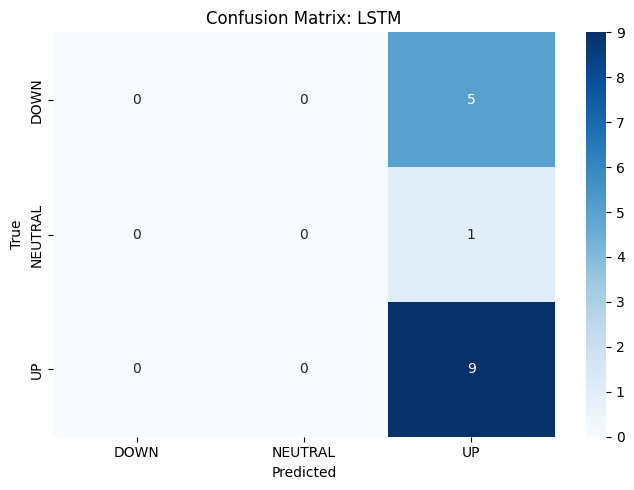

[JSWSTEEL] Results DataFrame shape: (15, 27)
[JSWSTEEL] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/JSWSTEEL_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/JSWSTEEL_results.xlsx
[JSWSTEEL] 💾 Saved results to /content/output/JSWSTEEL_results.xlsx
[ITC] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for JSWSTEEL
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[ITC] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[ITC] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)


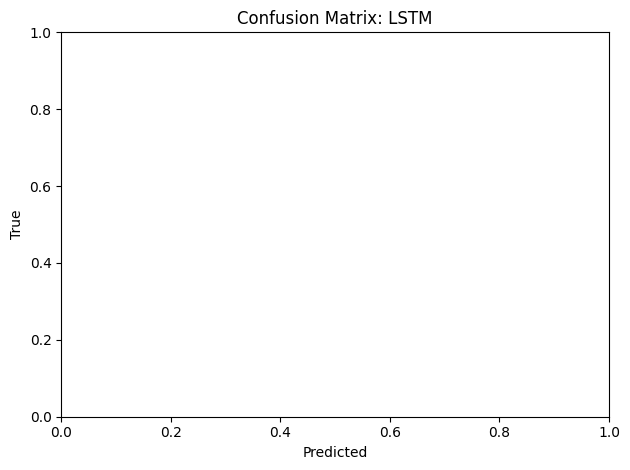

[KOTAKBANK] Results DataFrame shape: (15, 27)
[KOTAKBANK] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Excel report successfully generated: /content/output/KOTAKBANK_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/KOTAKBANK_results.xlsx
[KOTAKBANK] 💾 Saved results to /content/output/KOTAKBANK_results.xlsx
✅ Completed processing for KOTAKBANK
[IOC] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[IOC] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[IOC] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.0567 - val_accuracy: 1.0000 - val_loss: 0.8022 - learning_rate: 0.0010
Epoch 1/50
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2214 - val

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9091 - loss: 0.1890
Epoch 3: val_loss improved from 0.80218 to 0.76266, saving model to /content/checkpoints/JINDALSTEL/JINDALSTEL_lstm_model.h5


Epoch 1/50

Epoch 41: val_loss improved from 0.58586 to 0.57558, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.7004 - val_accuracy: 1.0000 - val_loss: 0.7627 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.1890 - val_accuracy: 1.0000 - val_loss: 0.5756 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - loss: 0.0728
Epoch 4: val_loss improved from 0.76266 to 0.72519, saving model to /content/checkpoints/JINDALSTEL/JINDALSTEL_lstm_model.h5



Epoch 42: val_loss improved from 0.57558 to 0.56537, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.0728 - val_accuracy: 1.0000 - val_loss: 0.5654 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5455 - loss: 0.7383 - val_accuracy: 1.0000 - val_loss: 0.7252 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 0.1024
Epoch 43: val_loss improved from 0.56537 to 0.55688, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.6364 - loss: 0.9179
Epoch 5: val_loss improved from 0.72519 to 0.69306, saving model to /content/checkpoints/JINDALSTEL/JINDALSTEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step - accuracy: 1.0000 - loss: 0.1024 - val_accuracy: 1.0000 - val_loss: 0.5569 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2727 - loss: 1.9457
Epoch 44: val_loss improved from 0.55688 to 0.55218, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.9179 - val_accuracy: 1.0000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6364 - loss: 0.5891
Epoch 1: val_loss improved from inf to 1.10058, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5



Epoch 6: val_loss improved from 0.69306 to 0.66836, saving model to /content/checkpoints/JINDALSTEL/JINDALSTEL_lstm_model.h5

Epoch 1: val_loss improved from inf to 1.15355, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1548 - val_accuracy: 1.0000 - val_loss: 0.5522 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.5455 - loss: 0.8725 - val_accuracy: 0.0000e+00 - val_loss: 1.1006 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.2727 - loss: 1.9457 - val_accuracy: 0.0000e+00 - val_loss: 1.1535 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.5891 - val_accuracy: 1.0000 - val_loss: 0.6684 - learning_rate: 0.0010
Epoch 2/50
Epoch 7/50

Epoch 2: val_loss improved from 1.10058 to 1.06809, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8182 - loss: 0.6646 - val_accuracy: 0.0000e+00 - val_loss: 1.0681 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8182 - loss: 0.4965
Epoch 7: val_loss improved from 0.66836 to 0.65377, saving model to /content/checkpoints/JINDALSTEL/JINDALSTEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0631
Epoch 3: val_loss improved from 1.06809 to 1.05627, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.1818 - loss: 1.4537
Epoch 45: val_loss improved from 0.55218 to 0.54695, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5



Epoch 2: val_loss improved from 1.15355 to 1.13585, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7399 - val_accuracy: 1.0000 - val_loss: 0.6538 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8182 - loss: 0.4880
Epoch 8: val_loss improved from 0.65377 to 0.64404, saving model to /content/checkpoints/JINDALSTEL/JINDALSTEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4965 - val_accuracy: 1.0000 - val_loss: 1.0563 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0631 - val_accuracy: 1.0000 - val_loss: 0.5469 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1818 - loss: 1.4537 - val_accuracy: 0.0000e+00 - val_loss: 1.1359 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.0869
Epoch 4: val_loss improved from 1.05627 to 1.04054, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5



Epoch 46: val_loss improved from 0.54695 to 0.54154, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5



Epoch 3: val_loss improved from 1.13585 to 1.11191, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4880 - val_accuracy: 1.0000 - val_loss: 0.6440 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8182 - loss: 0.4836
Epoch 9: val_loss did not improve from 0.64404
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.6524 - val_accuracy: 1.0000 - val_loss: 1.0405 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9091 - loss: 0.4723
Epoch 5: val_loss improved from 1.04054 to 1.02583, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0869 - val_accuracy: 1.0000 - val_loss: 0.5415 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.3459 - val_accuracy: 0.0000e+00 - val_loss: 1.1119 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5455 - loss: 1.0452
Epoch 4: val_loss improved from 1.11191 to 1.09678, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4836 - val_accuracy: 1.0000 - val_loss: 0.6450 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step - accuracy: 0.9091 - loss: 0.4723 - val_accuracy: 1.0000 - val_loss: 1.0258 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step - accuracy: 0.5455 - loss: 1.0452 - val_accuracy: 0.0000e+00 - val_loss: 1.0968 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2727 - loss: 1.4885
Epoch 5: val_loss improved from 1.09678 to 1.08517, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8182 - loss: 0.6995
Epoch 10: val_loss improved from 0.64404 to 0.64285, saving model to /content/checkpoints/JINDALSTEL/JINDALSTEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.2727 - loss: 1.4885 - val_accuracy: 0.0000e+00 - val_loss: 1.0852 - learning_rate: 0.0010
Epoch 6/50

Epoch 6: val_loss improved from 1.02583 to 1.00574, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6995 - val_accuracy: 1.0000 - val_loss: 0.6428 - learning_rate: 0.0010
Epoch 11/50

Epoch 6: val_loss improved from 1.08517 to 1.08410, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5



Epoch 47: val_loss improved from 0.54154 to 0.53780, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4934 - val_accuracy: 1.0000 - val_loss: 1.0057 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.8182 - loss: 0.4338
Epoch 11: val_loss did not improve from 0.64285
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.2241 - val_accuracy: 0.0000e+00 - val_loss: 1.0841 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1426 - val_accuracy: 1.0000 - val_loss: 0.5378 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8182 - loss: 0.3582
Epoch 48: val_loss improved from 0.53780 to 0.53256, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5



Epoch 7: val_loss improved from 1.00574 to 0.99097, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4338 - val_accuracy: 1.0000 - val_loss: 0.6463 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8182 - loss: 0.4160
Epoch 7: val_loss improved from 1.08410 to 1.08176, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5



Epoch 12: val_loss did not improve from 0.64285
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.1729 - val_accuracy: 1.0000 - val_loss: 0.5326 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3582 - val_accuracy: 1.0000 - val_loss: 0.9910 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4160 - val_accuracy: 1.0000 - val_loss: 0.6566 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.0634 - val_accuracy: 0.0000e+00 - val_loss: 1.0818 - learning_rate: 0.0010
Epoch 8/50

Epoch 49: val_loss improved from 0.53256 to 0.52643, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4545 - loss: 1.0470


Epoch 8: val_loss improved from 0.99097 to 0.97732, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7273 - loss: 0.5701
Epoch 8: val_loss improved from 1.08176 to 1.07491, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: val_loss did not improve from 0.64285
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3833 - val_accuracy: 1.0000 - val_loss: 0.9773 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1278 - val_accuracy: 1.0000 - val_loss: 0.5264 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5701 - val_accuracy: 1.0000 - val_loss: 0.6710 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.0470 - val_accuracy: 1.0000 - val_loss: 1.0749 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8182 - loss: 0.4615
Epoch 14: val_loss did not improve from 0.64285

Epoch 9: val_loss improved from 1.07491 to 1.07094, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step - accuracy: 0.8182 - loss: 0.4615 - val_accuracy: 1.0000 - val_loss: 0.6780 - learning_rate: 5.0000e-04
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step - accuracy: 0.5455 - loss: 0.7855 - val_accuracy: 1.0000 - val_loss: 1.0709 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3636 - loss: 0.9868
Epoch 15: val_loss did not improve from 0.64285
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1566
Epoch 10: val_loss improved from 1.07094 to 1.05862, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.5866
Epoch 50: val_loss improved from 0.52643 to 0.51756, saving model to /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5

Epoch 9: val_loss improved from 0.97732 to 0.95983, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step - accuracy: 0.8182 - loss: 0.4692 - val_accuracy: 1.0000 - val_loss: 0.6846 - learning_rate: 5.0000e-04
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step - accuracy: 0.3636 - loss: 0.9868 - val_accuracy: 1.0000 - val_loss: 1.0586 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3636 - loss: 0.9220
Epoch 11: val_loss improved from 1.05862 to 1.04584, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1566 - val_accuracy: 1.0000 - val_loss: 0.5176 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
[JINDALSTEL] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[JINDALSTEL] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[JUBLFOOD] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
[JINDALSTEL] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 2 0 2 2 0 2 2 2 2 0 2 1]
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[JUBLFOOD] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[JUBLFOOD] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 0 0 0

[JINDALSTEL] ✅ Loaded best model from /content/checkpoints/JINDALSTEL/JINDALSTEL_lstm_model.h5
[JINDALSTEL] Predicting for 15 dates, including 30-07-2025
[JUBLFOOD] ✅ Loaded best model from /content/checkpoints/JUBLFOOD/JUBLFOOD_lstm_model.h5
[JUBLFOOD] Predicting for 15 dates, including 30-07-2025
[JINDALSTEL] Predictions generated. y_pred length: 15, dates_future length: 15
[JUBLFOOD] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 0.9220 - val_accuracy: 1.0000 - val_loss: 1.0458 - learning_rate: 0.0010
Epoch 12/50

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       1.00      0.50      0.67         6
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.67      1.00      0.80         8

    accuracy                           0.73        15
   macro avg       0.56      0.50      0.49        15
weighted avg       0.76      0.73    

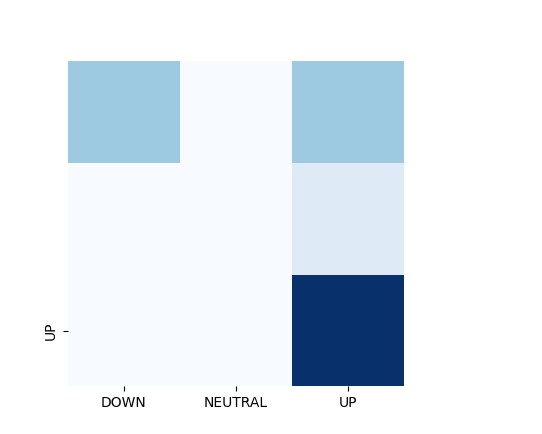

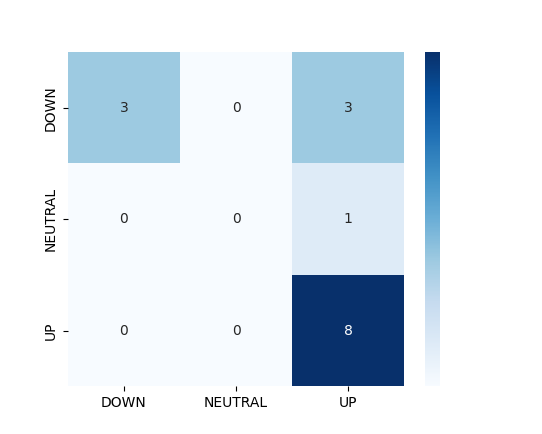

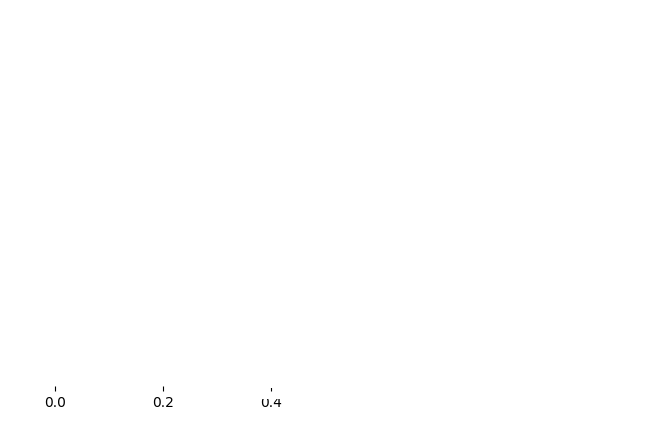

[JUBLFOOD] Results DataFrame shape: (15, 27)
[JUBLFOOD] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/JUBLFOOD_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/JUBLFOOD_results.xlsx
[JUBLFOOD] 💾 Saved results to /content/output/JUBLFOOD_results.xlsx
✅ Completed processing for JUBLFOOD
[SUNTV] ✅ Set DatetimeIndex. Index range: 2024-07-29 00:00:00 to 2024-08-30 00:00:00
Adding technical indicators... Initial shape: (24, 25)

Epoch 11: val_loss improved from 0.94148 to 0.92657, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


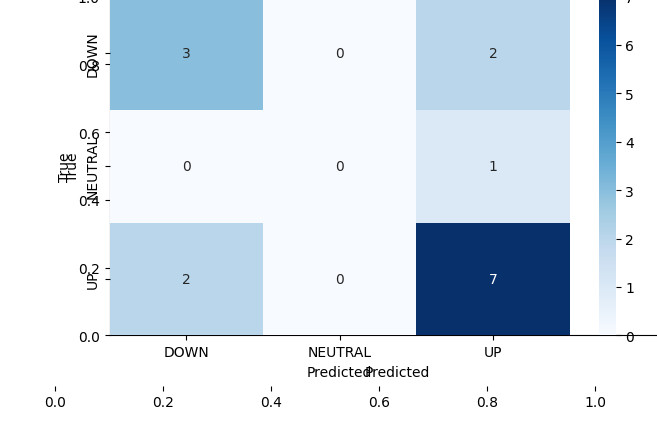

Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[SUNTV] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[JINDALSTEL] Results DataFrame shape: (15, 27)
[JINDALSTEL] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
Excel report successfu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/JINDALSTEL_results.xlsx
[JINDALSTEL] 💾 Saved results to /content/output/JINDALSTEL_results.xlsx
✅ Completed processing for JINDALSTEL
[INFY] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[INFY] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[INFY] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5455 - loss: 0.7226Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 12: val_loss improved from 1.04584 to 1.03336, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5



✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.2720 - val_accuracy: 1.0000 - val_loss: 0.9266 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.1446
Epoch 12: val_loss improved from 0.92657 to 0.91368, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5455 - loss: 0.7226 - val_accuracy: 1.0000 - val_loss: 1.0334 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.6364 - loss: 0.7449
Epoch 13: val_loss improved from 1.03336 to 1.01975, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1446 - val_accuracy: 1.0000 - val_loss: 0.9137 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9091 - loss: 0.2300
Epoch 13: val_loss improved from 0.91368 to 0.89971, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.7449 - val_accuracy: 1.0000 - val_loss: 1.0198 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6364 - loss: 0.7162
Epoch 14: val_loss improved from 1.01975 to 1.00966, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2300 - val_accuracy: 1.0000 - val_loss: 0.8997 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9091 - loss: 0.2273
Epoch 14: val_loss improved from 0.89971 to 0.88756, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7162 - val_accuracy: 1.0000 - val_loss: 1.0097 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 1.0000 - loss: 0.4875
Epoch 15: val_loss improved from 1.00966 to 0.99234, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2273 - val_accuracy: 1.0000 - val_loss: 0.8876 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.4875 - val_accuracy: 1.0000 - val_loss: 0.9923 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3636 - loss: 1.8734
Epoch 15: val_loss improved from 0.88756 to 0.87552, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.6029
Epoch 16: val_loss improved from 0.99234 to 0.97638, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.07407, saving model to /content/checkpoints/SUNTV/SUNTV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3665 - val_accuracy: 1.0000 - val_loss: 0.8755 - learning_rate: 0.0010
Epoch 16/50

Epoch 1: val_loss improved from inf to 1.11504, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.6029 - val_accuracy: 1.0000 - val_loss: 0.9764 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8182 - loss: 0.4998
Epoch 17: val_loss improved from 0.97638 to 0.95922, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.3636 - loss: 1.8734 - val_accuracy: 1.0000 - val_loss: 1.0741 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.4545 - loss: 1.5251 - val_accuracy: 0.0000e+00 - val_loss: 1.1150 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4545 - loss: 1.0520
Epoch 2: val_loss improved from 1.11504 to 1.10336, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step - accuracy: 0.8182 - loss: 0.4998 - val_accuracy: 1.0000 - val_loss: 0.9592 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8182 - loss: 0.3722
Epoch 18: val_loss improved from 0.95922 to 0.94370, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1534
Epoch 2: val_loss did not improve from 1.07407

Epoch 16: val_loss improved from 0.87552 to 0.86292, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step - accuracy: 0.4545 - loss: 1.0520 - val_accuracy: 0.0000e+00 - val_loss: 1.1034 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.3473 - val_accuracy: 1.0000 - val_loss: 1.0908 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step - accuracy: 0.8182 - loss: 0.3722 - val_accuracy: 1.0000 - val_loss: 0.9437 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1534 - val_accuracy: 1.0000 - val_loss: 0.8629 - learning_rate: 0.0010
Epoch 17/50

Epoch 3: val_loss did not improve from 1.07407

Epoch 3: val_loss improved from 1.10336 to 1.07537, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5



Epoch 19: val_loss improved from 0.94370 to 0.92815, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9091 - loss: 0.2312
Epoch 17: val_loss improved from 0.86292 to 0.85547, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step - accuracy: 0.4545 - loss: 1.1880 - val_accuracy: 1.0000 - val_loss: 1.0900 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3636 - loss: 1.0871
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.07407
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.8484 - val_accuracy: 0.0000e+00 - val_loss: 1.0754 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4145 - val_accuracy: 1.0000 - val_loss: 0.9282 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8182 - loss: 0.4723
Epoch 20: val_loss improved from 0.92815 to 0.91287, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2312 - val_accuracy: 1.0000 - val_loss: 0.8555 - learning_rate: 0.0010
Epoch 18/50

Epoch 4: val_loss improved from 1.07537 to 1.06544, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step - accuracy: 0.3636 - loss: 1.0871 - val_accuracy: 0.0000e+00 - val_loss: 1.0974 - learning_rate: 0.0010
Epoch 5/50

Epoch 18: val_loss improved from 0.85547 to 0.84702, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.4545 - loss: 1.0322
Epoch 5: val_loss did not improve from 1.07407
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4723 - val_accuracy: 1.0000 - val_loss: 0.9129 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.2914 - val_accuracy: 0.0000e+00 - val_loss: 1.0654 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2727 - loss: 1.2392
Epoch 21: val_loss improved from 0.91287 to 0.89974, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2175 - val_accuracy: 1.0000 - val_loss: 0.8470 - learning_rate: 0.0010
Epoch 19/50

Epoch 5: val_loss improved from 1.06544 to 1.06389, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.0322 - val_accuracy: 0.0000e+00 - val_loss: 1.0995 - learning_rate: 5.0000e-04
Epoch 6/50

Epoch 19: val_loss improved from 0.84702 to 0.84328, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7273 - loss: 0.7001
Epoch 6: val_loss did not improve from 1.07407
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4153 - val_accuracy: 1.0000 - val_loss: 0.8997 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.2392 - val_accuracy: 0.0000e+00 - val_loss: 1.0639 - learning_rate: 0.0010
Epoch 6/50

Epoch 22: val_loss improved from 0.89974 to 0.88739, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step - accuracy: 0.7273 - loss: 0.7001 - val_accuracy: 0.0000e+00 - val_loss: 1.0996 - learning_rate: 5.0000e-04

Epoch 6: val_loss improved from 1.06389 to 1.06024, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.2546 - val_accuracy: 1.0000 - val_loss: 0.8433 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.1388
Epoch 20: val_loss improved from 0.84328 to 0.84117, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


[SUNTV] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[SUNTV] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 0 2 2 0 2 2 0 2 2 2 0 0 1]


[SUNTV] ✅ Loaded best model from /content/checkpoints/SUNTV/SUNTV_lstm_model.h5
[SUNTV] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4413 - val_accuracy: 1.0000 - val_loss: 0.8874 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.9251 - val_accuracy: 0.0000e+00 - val_loss: 1.0602 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4545 - loss: 0.9564
Epoch 23: val_loss improved from 0.88739 to 0.87589, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5



Epoch 7: val_loss improved from 1.06024 to 1.05747, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1388 - val_accuracy: 1.0000 - val_loss: 0.8412 - learning_rate: 0.0010
Epoch 21/50
[SUNTV] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       1.00      0.40      0.57         5
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.69      1.00      0.82         9

    accuracy                           0.73        15
   macro avg       0.56      0.47      0.46        15
weighted avg       0.75      0.73      0.68        15



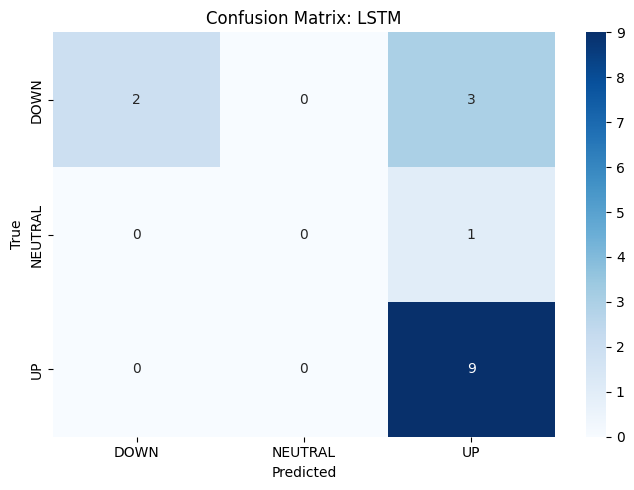

[SUNTV] Results DataFrame shape: (15, 27)
[SUNTV] Prediction dates: [Timestamp('2024-08-12 00:00:00'), Timestamp('2024-08-13 00:00:00'), Timestamp('2024-08-14 00:00:00'), Timestamp('2024-08-16 00:00:00'), Timestamp('2024-08-19 00:00:00'), Timestamp('2024-08-20 00:00:00'), Timestamp('2024-08-21 00:00:00'), Timestamp('2024-08-22 00:00:00'), Timestamp('2024-08-23 00:00:00'), Timestamp('2024-08-26 00:00:00'), Timestamp('2024-08-27 00:00:00'), Timestamp('2024-08-28 00:00:00'), Timestamp('2024-08-29 00:00:00'), Timestamp('2024-08-30 00:00:00'), Timestamp('2025-07-30 00:00:00')]
Excel report successfully generated: /content/output/SUNTV_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/SUNTV_results.xlsx
[SUNTV] 💾 Saved results to /content/output/SUNTV_results.xlsx
✅ Completed processing for SUNTV
[INDUSINDBK] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[INDUSINDBK] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[INDUSINDBK] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3103 - val_accuracy: 1.0000 - val_loss: 0.8759 - learning_rate: 0.0010
Epoch 24/50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 0.9564 - val_accuracy: 1.0000 - val_loss: 1.0575 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1442
Epoch 21: val_loss improved from 0.84117 to 0.83996, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1442 - val_accuracy: 1.0000 - val_loss: 0.8400 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5455 - loss: 0.8715
Epoch 24: val_loss improved from 0.87589 to 0.86444, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5



Epoch 8: val_loss improved from 1.05747 to 1.05609, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9091 - loss: 0.1314
Epoch 22: val_loss improved from 0.83996 to 0.83778, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.8715 - val_accuracy: 1.0000 - val_loss: 1.0561 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3664 - val_accuracy: 1.0000 - val_loss: 0.8644 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1314 - val_accuracy: 1.0000 - val_loss: 0.8378 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8182 - loss: 0.2776
Epoch 23: val_loss improved from 0.83778 to 0.83346, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.2329
Epoch 25: val_loss improved from 0.86444 to 0.85312, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.7779
Epoch 9: val_loss improved from 1.05609 to 1.05049, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.2776 - val_accuracy: 1.0000 - val_loss: 0.8335 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2329 - val_accuracy: 1.0000 - val_loss: 0.8531 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.7779 - val_accuracy: 1.0000 - val_loss: 1.0505 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1615
Epoch 24: val_loss improved from 0.83346 to 0.82968, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.38942, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1615 - val_accuracy: 1.0000 - val_loss: 0.8297 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9091 - loss: 0.2200
Epoch 25: val_loss improved from 0.82968 to 0.82636, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1689
Epoch 26: val_loss improved from 0.85312 to 0.84099, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5455 - loss: 0.9154
Epoch 10: val_loss improved from 1.05049 to 1.04648, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.3636 - loss: 1.8843 - val_accuracy: 0.0000e+00 - val_loss: 1.3894 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step - accuracy: 0.9091 - loss: 0.2200 - val_accuracy: 1.0000 - val_loss: 0.8264 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1689 - val_accuracy: 1.0000 - val_loss: 0.8410 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.9154 - val_accuracy: 1.0000 - val_loss: 1.0465 - learning_rate: 0.0010
Epoch 11/50

Epoch 27: val_loss improved from 0.84099 to 0.82835, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 1.0000 - loss: 0.1298
Epoch 26: val_loss improved from 0.82636 to 0.82300, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step - accuracy: 0.9091 - loss: 0.2647 - val_accuracy: 1.0000 - val_loss: 0.8283 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9091 - loss: 0.3562
Epoch 11: val_loss improved from 1.04648 to 1.04437, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0909 - loss: 2.1597
Epoch 28: val_loss improved from 0.82835 to 0.81602, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5



Epoch 2: val_loss improved from 1.38942 to 1.37513, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1298 - val_accuracy: 1.0000 - val_loss: 0.8230 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9091 - loss: 0.1661
Epoch 27: val_loss improved from 0.82300 to 0.81564, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7041 - val_accuracy: 1.0000 - val_loss: 1.0444 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3562 - val_accuracy: 1.0000 - val_loss: 0.8160 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9091 - loss: 0.2214
Epoch 12: val_loss improved from 1.04437 to 1.03456, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0909 - loss: 2.1597 - val_accuracy: 0.0000e+00 - val_loss: 1.3751 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2727 - loss: 1.0994
Epoch 29: val_loss improved from 0.81602 to 0.80220, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5



Epoch 3: val_loss improved from 1.37513 to 1.34315, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1661 - val_accuracy: 1.0000 - val_loss: 0.8156 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0806
Epoch 28: val_loss improved from 0.81564 to 0.80822, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7565 - val_accuracy: 1.0000 - val_loss: 1.0346 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.0994 - val_accuracy: 0.0000e+00 - val_loss: 1.3431 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2214 - val_accuracy: 1.0000 - val_loss: 0.8022 - learning_rate: 0.0010
Epoch 30/50

Epoch 13: val_loss improved from 1.03456 to 1.02938, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0806 - val_accuracy: 1.0000 - val_loss: 0.8082 - learning_rate: 0.0010
Epoch 29/50

Epoch 4: val_loss improved from 1.34315 to 1.32015, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9091 - loss: 0.1407
Epoch 29: val_loss improved from 0.80822 to 0.79972, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step - accuracy: 0.6364 - loss: 1.0163 - val_accuracy: 1.0000 - val_loss: 1.0294 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step - accuracy: 0.1818 - loss: 1.5894 - val_accuracy: 0.0000e+00 - val_loss: 1.3201 - learning_rate: 0.0010
Epoch 5/50

Epoch 14: val_loss improved from 1.02938 to 1.02184, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2727 - loss: 1.7351
Epoch 5: val_loss improved from 1.32015 to 1.30540, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step - accuracy: 0.9091 - loss: 0.1407 - val_accuracy: 1.0000 - val_loss: 0.7997 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3106
Epoch 30: val_loss improved from 0.80220 to 0.79099, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5



Epoch 30: val_loss improved from 0.79972 to 0.79292, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step - accuracy: 0.9091 - loss: 0.5411 - val_accuracy: 1.0000 - val_loss: 1.0218 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.7351 - val_accuracy: 0.0000e+00 - val_loss: 1.3054 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.5455 - loss: 0.8877
Epoch 15: val_loss improved from 1.02184 to 1.01760, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3106 - val_accuracy: 1.0000 - val_loss: 0.7910 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1262 - val_accuracy: 1.0000 - val_loss: 0.7929 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8182 - loss: 0.1629
Epoch 6: val_loss improved from 1.30540 to 1.28019, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9091 - loss: 0.2625
Epoch 31: val_loss improved from 0.79292 to 0.78756, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5



Epoch 31: val_loss improved from 0.79099 to 0.77973, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.8877 - val_accuracy: 1.0000 - val_loss: 1.0176 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 1.2016 - val_accuracy: 0.0000e+00 - val_loss: 1.2802 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.1629 - val_accuracy: 1.0000 - val_loss: 0.7876 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2625 - val_accuracy: 1.0000 - val_loss: 0.7797 - learning_rate: 0.0010
Epoch 32/50

Epoch 16: val_loss improved from 1.01760 to 1.01164, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5



Epoch 7: val_loss improved from 1.28019 to 1.27283, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9091 - loss: 0.3375
Epoch 32: val_loss improved from 0.77973 to 0.76816, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.0626 - val_accuracy: 0.0000e+00 - val_loss: 1.2728 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.6837 - val_accuracy: 1.0000 - val_loss: 1.0116 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7273 - loss: 0.7818
Epoch 8: val_loss improved from 1.27283 to 1.27108, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5



Epoch 17: val_loss improved from 1.01164 to 1.00738, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3375 - val_accuracy: 1.0000 - val_loss: 0.7682 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9091 - loss: 0.1960
Epoch 32: val_loss improved from 0.78756 to 0.78189, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5



Epoch 33: val_loss improved from 0.76816 to 0.75691, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.0026 - val_accuracy: 0.0000e+00 - val_loss: 1.2711 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7818 - val_accuracy: 1.0000 - val_loss: 1.0074 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7273 - loss: 0.6751
Epoch 18: val_loss improved from 1.00738 to 1.00148, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0759 - val_accuracy: 1.0000 - val_loss: 0.7819 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1960 - val_accuracy: 1.0000 - val_loss: 0.7569 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9091 - loss: 0.2829
Epoch 34: val_loss improved from 0.75691 to 0.74733, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step - accuracy: 0.7273 - loss: 0.6751 - val_accuracy: 1.0000 - val_loss: 1.0015 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5455 - loss: 0.6791
Epoch 19: val_loss improved from 1.00148 to 0.99450, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step - accuracy: 0.9091 - loss: 0.2829 - val_accuracy: 1.0000 - val_loss: 0.7473 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9091 - loss: 0.2253
Epoch 35: val_loss improved from 0.74733 to 0.73769, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step - accuracy: 0.5455 - loss: 0.6791 - val_accuracy: 1.0000 - val_loss: 0.9945 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.8024
Epoch 9: val_loss improved from 1.27108 to 1.26872, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1730
Epoch 20: val_loss improved from 0.99450 to 0.98775, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5



Epoch 33: val_loss improved from 0.78189 to 0.77857, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step - accuracy: 0.9091 - loss: 0.2253 - val_accuracy: 1.0000 - val_loss: 0.7377 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.8024 - val_accuracy: 0.0000e+00 - val_loss: 1.2687 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6715 - val_accuracy: 1.0000 - val_loss: 0.9878 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1730 - val_accuracy: 1.0000 - val_loss: 0.7786 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6364 - loss: 0.5408Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.6364 - loss: 0.8613
Epoch 36: val_loss improved from 0.73769 to 0.72899, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 1.0000 - loss: 0.0679
Epoch 21: val_loss improved from 0.98775 to 0.97923, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5



Epoch 10: val_loss improved from 1.26872 to 1.26259, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5



Epoch 34: val_loss improved from 0.77857 to 0.77523, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2199 - val_accuracy: 1.0000 - val_loss: 0.7290 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.5408 - val_accuracy: 1.0000 - val_loss: 0.9792 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.8613 - val_accuracy: 0.0000e+00 - val_loss: 1.2626 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0679 - val_accuracy: 1.0000 - val_loss: 0.7752 - learning_rate: 0.0010
Epoch 11/50
Epoch 35/50

Epoch 37: val_loss improved from 0.72899 to 0.72018, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.1092
Epoch 22: val_loss improved from 0.97923 to 0.97242, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5



Epoch 35: val_loss improved from 0.77523 to 0.77435, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step - accuracy: 1.0000 - loss: 0.1975 - val_accuracy: 1.0000 - val_loss: 0.7202 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step - accuracy: 0.8182 - loss: 0.4843 - val_accuracy: 1.0000 - val_loss: 0.9724 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step - accuracy: 1.0000 - loss: 0.1092 - val_accuracy: 1.0000 - val_loss: 0.7743 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9091 - loss: 0.1087
Epoch 36: val_loss improved from 0.77435 to 0.77159, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9091 - loss: 0.2230
Epoch 38: val_loss improved from 0.72018 to 0.71116, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.7217
Epoch 23: val_loss improved from 0.97242 to 0.96496, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5



Epoch 11: val_loss improved from 1.26259 to 1.25371, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step - accuracy: 0.9091 - loss: 0.1087 - val_accuracy: 1.0000 - val_loss: 0.7716 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2230 - val_accuracy: 1.0000 - val_loss: 0.7112 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.8208 - val_accuracy: 1.0000 - val_loss: 0.9650 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.7217 - val_accuracy: 0.0000e+00 - val_loss: 1.2537 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9091 - loss: 0.1730
Epoch 37: val_loss improved from 0.77159 to 0.76803, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5



Epoch 12: val_loss improved from 1.25371 to 1.24793, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5

Epoch 39: val_loss improved from 0.71116 to 0.69801, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5



Epoch 24: val_loss improved from 0.96496 to 0.95595, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1396 - val_accuracy: 1.0000 - val_loss: 0.7680 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.6890 - val_accuracy: 0.0000e+00 - val_loss: 1.2479 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4262 - val_accuracy: 1.0000 - val_loss: 0.9559 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1730 - val_accuracy: 1.0000 - val_loss: 0.6980 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.1960
Epoch 38: val_loss improved from 0.76803 to 0.76238, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5



Epoch 13: val_loss improved from 1.24793 to 1.23690, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5



Epoch 40: val_loss improved from 0.69801 to 0.68408, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1941 - val_accuracy: 1.0000 - val_loss: 0.7624 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step - accuracy: 1.0000 - loss: 0.1960 - val_accuracy: 1.0000 - val_loss: 0.6841 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step - accuracy: 0.8182 - loss: 0.6431 - val_accuracy: 0.0000e+00 - val_loss: 1.2369 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 1.0000 - loss: 0.0571
Epoch 39: val_loss improved from 0.76238 to 0.75512, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 1.0000 - loss: 0.1618
Epoch 25: val_loss improved from 0.95595 to 0.94838, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5



Epoch 14: val_loss improved from 1.23690 to 1.22694, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5



Epoch 41: val_loss improved from 0.68408 to 0.67140, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0571 - val_accuracy: 1.0000 - val_loss: 0.7551 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.1013
Epoch 40: val_loss improved from 0.75512 to 0.74815, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5623 - val_accuracy: 1.0000 - val_loss: 0.9484 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.5782 - val_accuracy: 0.0000e+00 - val_loss: 1.2269 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1618 - val_accuracy: 1.0000 - val_loss: 0.6714 - learning_rate: 0.0010
Epoch 42/50

Epoch 26: val_loss improved from 0.94838 to 0.93924, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.1548
Epoch 15: val_loss improved from 1.22694 to 1.22021, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5



Epoch 42: val_loss improved from 0.67140 to 0.65959, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1013 - val_accuracy: 1.0000 - val_loss: 0.7482 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.5293 - val_accuracy: 1.0000 - val_loss: 0.9392 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.6310 - val_accuracy: 0.0000e+00 - val_loss: 1.2202 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1548 - val_accuracy: 1.0000 - val_loss: 0.6596 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.1032
Epoch 43: val_loss improved from 0.65959 to 0.65036, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 1.0000 - loss: 0.1032 - val_accuracy: 1.0000 - val_loss: 0.6504 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9091 - loss: 0.2512
Epoch 44: val_loss improved from 0.65036 to 0.64092, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0971
Epoch 41: val_loss improved from 0.74815 to 0.74540, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step - accuracy: 0.9091 - loss: 0.2512 - val_accuracy: 1.0000 - val_loss: 0.6409 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.5333
Epoch 27: val_loss improved from 0.93924 to 0.93221, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5



Epoch 45: val_loss improved from 0.64092 to 0.63173, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5



Epoch 16: val_loss improved from 1.22021 to 1.21652, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0971 - val_accuracy: 1.0000 - val_loss: 0.7454 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 1.0000 - loss: 0.0829
Epoch 42: val_loss improved from 0.74540 to 0.74140, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.5464 - val_accuracy: 1.0000 - val_loss: 0.9322 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1875 - val_accuracy: 1.0000 - val_loss: 0.6317 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.5333 - val_accuracy: 0.0000e+00 - val_loss: 1.2165 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8182 - loss: 0.7347
Epoch 46: val_loss improved from 0.63173 to 0.62120, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5



Epoch 17: val_loss improved from 1.21652 to 1.20872, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0829 - val_accuracy: 1.0000 - val_loss: 0.7414 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step - accuracy: 0.9091 - loss: 0.1610 - val_accuracy: 1.0000 - val_loss: 0.6212 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step - accuracy: 0.8182 - loss: 0.7347 - val_accuracy: 0.0000e+00 - val_loss: 1.2087 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8182 - loss: 0.4740
Epoch 43: val_loss improved from 0.74140 to 0.73724, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5

Epoch 47: val_loss improved from 0.62120 to 0.61049, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5



Epoch 18: val_loss improved from 1.20872 to 1.19998, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.4541
Epoch 28: val_loss improved from 0.93221 to 0.92440, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0908 - val_accuracy: 1.0000 - val_loss: 0.7372 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0745 - val_accuracy: 1.0000 - val_loss: 0.6105 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4740 - val_accuracy: 0.0000e+00 - val_loss: 1.2000 - learning_rate: 0.0010
Epoch 19/50

Epoch 44: val_loss improved from 0.73724 to 0.73044, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.4541 - val_accuracy: 1.0000 - val_loss: 0.9244 - learning_rate: 0.0010


Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8182 - loss: 0.4079
Epoch 19: val_loss improved from 1.19998 to 1.19383, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5



Epoch 29: val_loss improved from 0.92440 to 0.91830, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step - accuracy: 1.0000 - loss: 0.1248 - val_accuracy: 1.0000 - val_loss: 0.7304 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step - accuracy: 0.8182 - loss: 0.5121 - val_accuracy: 0.0000e+00 - val_loss: 1.1938 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step - accuracy: 0.8182 - loss: 0.4079 - val_accuracy: 1.0000 - val_loss: 0.9183 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6364 - loss: 0.6511
Epoch 30: val_loss improved from 0.91830 to 0.91450, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2241
Epoch 45: val_loss improved from 0.73044 to 0.72595, saving model to /content/checkpoints/IOC/IOC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9091 - loss: 0.4685
Epoch 48: val_loss improved from 0.61049 to 0.59769, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5



Epoch 20: val_loss improved from 1.19383 to 1.19032, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step - accuracy: 0.6364 - loss: 0.6511 - val_accuracy: 1.0000 - val_loss: 0.9145 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5455 - loss: 0.5839
Epoch 31: val_loss improved from 0.91450 to 0.91091, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0778 - val_accuracy: 1.0000 - val_loss: 0.7260 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2241 - val_accuracy: 1.0000 - val_loss: 0.5977 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.4685 - val_accuracy: 0.0000e+00 - val_loss: 1.1903 - learning_rate: 0.0010
Epoch 21/50

Epoch 46: val_loss did not improve from 0.72595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7273 - loss: 0.6382
Epoch 49: val_loss improved from 0.59769 to 0.58437, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5



Epoch 21: val_loss improved from 1.19032 to 1.18303, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.5839 - val_accuracy: 1.0000 - val_loss: 0.9109 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7273 - loss: 0.4924
Epoch 32: val_loss improved from 0.91091 to 0.91071, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step - accuracy: 1.0000 - loss: 0.0796 - val_accuracy: 1.0000 - val_loss: 0.7287 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0745
Epoch 47: val_loss did not improve from 0.72595
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2386 - val_accuracy: 1.0000 - val_loss: 0.5844 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6382 - val_accuracy: 0.0000e+00 - val_loss: 1.1830 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8182 - loss: 0.5690
Epoch 50: val_loss improved from 0.58437 to 0.57336, saving model to /content/checkpoints/ITC/ITC_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4924 - val_accuracy: 1.0000 - val_loss: 0.9107 - learning_rate: 0.0010


Epoch 33/50

Epoch 22: val_loss improved from 1.18303 to 1.17424, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step - accuracy: 1.0000 - loss: 0.0745 - val_accuracy: 1.0000 - val_loss: 0.7311 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0888
Epoch 33: val_loss improved from 0.91071 to 0.90672, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5



Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 48: val_loss did not improve from 0.72595
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1341 - val_accuracy: 1.0000 - val_loss: 0.5734 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5690 - val_accuracy: 0.0000e+00 - val_loss: 1.1742 - learning_rate: 0.0010
[ITC] ✅ LSTM model trained
Epoch 23/50
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[ITC] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7273 - loss: 0.6575[ITC] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 0 2 2 2 2 2 0 2 2 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss

[ITC] ✅ Loaded best model from /content/checkpoints/ITC/ITC_lstm_model.h5
[ITC] Predicting for 15 dates, including 30-07-2025

Epoch 49: val_loss did not improve from 0.72595

Epoch 34: val_loss improved from 0.90672 to 0.90399, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


[ITC] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1157 - val_accuracy: 1.0000 - val_loss: 0.7310 - learning_rate: 5.0000e-04
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6575 - val_accuracy: 0.0000e+00 - val_loss: 1.1606 - learning_rate: 0.0010
Epoch 24/50

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         2
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.80      1.00      0.89        12

    accuracy                           0.80        15
   macro avg       0.27      0.33      0.30        15
weighted avg       0.64      0.80      0.71        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3612 - val_accuracy: 1.0000 - val_loss: 0.9040 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9091 - lo


Epoch 50: val_loss did not improve from 0.72595

Epoch 35: val_loss improved from 0.90399 to 0.90238, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


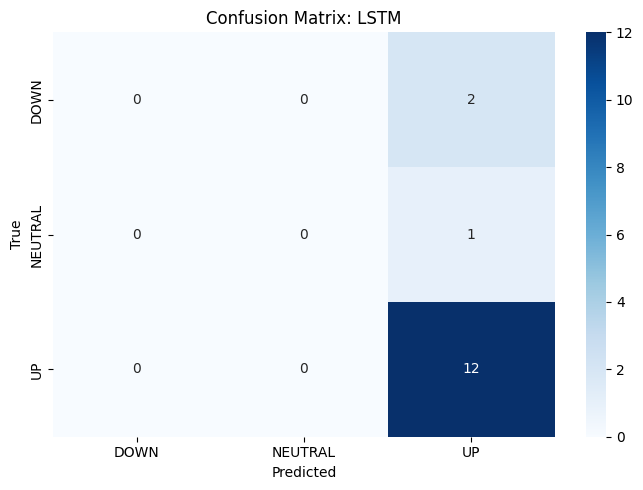

[ITC] Results DataFrame shape: (15, 27)
[ITC] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/ITC_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/ITC_results.xlsx
[ITC] 💾 Saved results to /content/output/ITC_results.xlsx
✅ Completed processing for ITC
[INDIGO] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[INDIGO] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[INDIGO] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0517 - val_accuracy: 1.0000 - val_loss: 0.7309 - learning_rate: 5.0000e-04
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 45.
1/1 ━━━━━━━━━━━━━━━━━━━

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3576 - val_accuracy: 1.0000 - val_loss: 0.9024 - learning_rate: 0.0010
Epoch 36/50


 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8182 - loss: 0.4624Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[IOC] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[IOC] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 2 2 2 2 2 2 2 2 2 2 2 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8182 - loss: 0.4134Epoch 1/50

Epoch 25: val_loss improved from 1.14729 to 1.12674, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


[IOC] ✅ Loaded best model from /content/checkpoints/IOC/IOC_lstm_model.h5
Epoch 36: val_loss improved from 0.90238 to 0.89936, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5



[IOC] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4624 - val_accuracy: 0.0000e+00 - val_loss: 1.1267 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4134 - val_accuracy: 1.0000 - val_loss: 0.8994 - learning_rate: 0.0010
Epoch 37/50
[IOC] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6364 - loss: 0.7234
Epoch 26: val_loss improved from 1.12674 to 1.10624, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         1
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.87      1.00      0.93        13

    accuracy                           0.87        15
   macro avg       0.29      0.33      0.31        15
weighted avg       0.75      0.87      0.80        15


Epoch 37: val_loss improved from 0.89936 to 0.89823, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


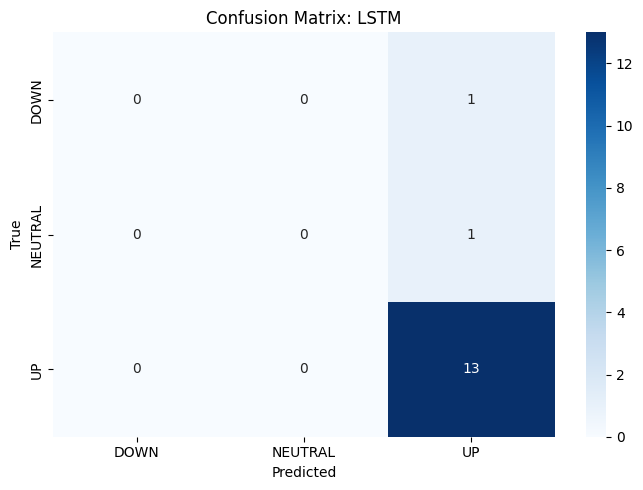

[IOC] Results DataFrame shape: (15, 27)
[IOC] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/IOC_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/IOC_results.xlsx
[IOC] 💾 Saved results to /content/output/IOC_results.xlsx
[TATACHEM] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for IOC
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[TATACHEM] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[TATACHEM] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3680 - val_accuracy: 0.0000e+00 - val_loss: 1.1062 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7234 - val_accuracy: 1.0000 - val_loss: 0.8982 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8182 - loss: 0.3811
Epoch 27: val_loss improved from 1.10624 to 1.09295, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5



Epoch 38: val_loss improved from 0.89823 to 0.89594, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9091 - loss: 0.2462 - val_accuracy: 0.0000e+00 - val_loss: 1.0930 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8182 - loss: 0.3811 - val_accuracy: 1.0000 - val_loss: 0.8959 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8182 - loss: 0.4108
Epoch 28: val_loss improved from 1.09295 to 1.08873, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5

Epoch 39: val_loss improved from 0.89594 to 0.89101, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4731 - val_accuracy: 0.0000e+00 - val_loss: 1.0887 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4108 - val_accuracy: 1.0000 - val_loss: 0.8910 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.0909 - loss: 2.2256
Epoch 29: val_loss improved from 1.08873 to 1.08802, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2848
Epoch 1: val_loss improved from inf to 1.27692, saving model to /content/checkpoints/INDIGO/INDIGO_lstm_model.h5



Epoch 40: val_loss improved from 0.89101 to 0.88776, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5215 - val_accuracy: 1.0000 - val_loss: 1.0880 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.0909 - loss: 2.2256 - val_accuracy: 0.0000e+00 - val_loss: 1.2769 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2848 - val_accuracy: 1.0000 - val_loss: 0.8878 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9091 - loss: 0.3811
Epoch 41: val_loss improved from 0.88776 to 0.88413, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.1818 - loss: 1.9208
Epoch 2: val_loss did not improve from 1.27692

Epoch 30: val_loss improved from 1.08802 to 1.08411, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.02499, saving model to /content/checkpoints/TATACHEM/TATACHEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3811 - val_accuracy: 1.0000 - val_loss: 0.8841 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1818 - loss: 1.9208 - val_accuracy: 0.0000e+00 - val_loss: 1.2785 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.4777 - val_accuracy: 1.0000 - val_loss: 1.0841 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.0000e+00 - loss: 2.3304 - val_accuracy: 1.0000 - val_loss: 1.0250 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9091 - loss: 0.4500
Epoch 42: val_loss improved from 0.88413 to 0.88256, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5



Epoch 3: val_loss did not improve from 1.27692

Epoch 31: val_loss improved from 1.08411 to 1.08114, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.6270 - val_accuracy: 0.0000e+00 - val_loss: 1.2873 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4083 - val_accuracy: 1.0000 - val_loss: 0.8826 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.2783
Epoch 2: val_loss improved from 1.02499 to 0.96233, saving model to /content/checkpoints/TATACHEM/TATACHEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.3636 - loss: 1.4721
Epoch 43: val_loss improved from 0.88256 to 0.88013, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4500 - val_accuracy: 1.0000 - val_loss: 1.0811 - learning_rate: 0.0010
Epoch 32/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.27692
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.4778 - val_accuracy: 1.0000 - val_loss: 0.9623 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.4721 - val_accuracy: 0.0000e+00 - val_loss: 1.2789 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2783 - val_accuracy: 1.0000 - val_loss: 0.8801 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9091 - loss: 0.3256
Epoch 5: val_loss improved from 1.27692 to 1.25300, saving model to /content/checkpoints/INDIGO/INDIGO_lstm_model.h5



Epoch 44: val_loss improved from 0.88013 to 0.87810, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step - accuracy: 0.1818 - loss: 1.5419 - val_accuracy: 0.0000e+00 - val_loss: 1.2530 - learning_rate: 5.0000e-04

Epoch 32: val_loss improved from 1.08114 to 1.07895, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step - accuracy: 0.9091 - loss: 0.3256 - val_accuracy: 1.0000 - val_loss: 0.8781 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4545 - loss: 1.0764
Epoch 6: val_loss improved from 1.25300 to 1.22391, saving model to /content/checkpoints/INDIGO/INDIGO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5406 - val_accuracy: 1.0000 - val_loss: 1.0789 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.9091 - loss: 0.2711
Epoch 3: val_loss improved from 0.96233 to 0.93327, saving model to /content/checkpoints/TATACHEM/TATACHEM_lstm_model.h5



Epoch 33: val_loss improved from 1.07895 to 1.06980, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step - accuracy: 0.4545 - loss: 1.0764 - val_accuracy: 0.0000e+00 - val_loss: 1.2239 - learning_rate: 5.0000e-04
Epoch 7/50

Epoch 45: val_loss improved from 0.87810 to 0.87708, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.5455 - loss: 1.2468
Epoch 7: val_loss improved from 1.22391 to 1.19854, saving model to /content/checkpoints/INDIGO/INDIGO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.4119 - val_accuracy: 1.0000 - val_loss: 0.9333 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2873 - val_accuracy: 1.0000 - val_loss: 1.0698 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2711 - val_accuracy: 1.0000 - val_loss: 0.8771 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7273 - loss: 0.4443
Epoch 46: val_loss improved from 0.87708 to 0.87694, saving model to /content/checkpoints/INFY/INFY_lstm_model.h5



Epoch 4: val_loss improved from 0.93327 to 0.91120, saving model to /content/checkpoints/TATACHEM/TATACHEM_lstm_model.h5



Epoch 34: val_loss improved from 1.06980 to 1.05993, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.2468 - val_accuracy: 0.0000e+00 - val_loss: 1.1985 - learning_rate: 5.0000e-04
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.3636 - loss: 0.9728
Epoch 8: val_loss improved from 1.19854 to 1.17828, saving model to /content/checkpoints/INDIGO/INDIGO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4440 - val_accuracy: 1.0000 - val_loss: 0.8769 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.2340 - val_accuracy: 1.0000 - val_loss: 0.9112 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4443 - val_accuracy: 1.0000 - val_loss: 1.0599 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9091 - loss: 0.3918
Epoch 5: val_loss improved from 0.91120 to 0.89589, saving model to /content/checkpoints/TATACHEM/TATACHEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 0.9728 - val_accuracy: 0.0000e+00 - val_loss: 1.1783 - learning_rate: 5.0000e-04
Epoch 9/50

Epoch 35: val_loss improved from 1.05993 to 1.04215, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4545 - loss: 1.0748
Epoch 9: val_loss improved from 1.17828 to 1.15647, saving model to /content/checkpoints/INDIGO/INDIGO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step - accuracy: 0.9091 - loss: 0.3918 - val_accuracy: 1.0000 - val_loss: 1.0422 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step - accuracy: 0.6364 - loss: 0.8634 - val_accuracy: 1.0000 - val_loss: 0.8959 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9091 - loss: 0.3562
Epoch 36: val_loss improved from 1.04215 to 1.02379, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step - accuracy: 0.4545 - loss: 1.0748 - val_accuracy: 0.0000e+00 - val_loss: 1.1565 - learning_rate: 5.0000e-04
Epoch 10/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.5455 - loss: 0.9086
Epoch 10: val_loss improved from 1.15647 to 1.13082, saving model to /content/checkpoints/INDIGO/INDIGO_lstm_model.h5



Epoch 47: val_loss did not improve from 0.87694

Epoch 6: val_loss improved from 0.89589 to 0.88255, saving model to /content/checkpoints/TATACHEM/TATACHEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step - accuracy: 0.9091 - loss: 0.3562 - val_accuracy: 1.0000 - val_loss: 1.0238 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9091 - loss: 0.2350
Epoch 37: val_loss improved from 1.02379 to 1.00624, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.2755 - val_accuracy: 1.0000 - val_loss: 0.8771 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 0.8570 - val_accuracy: 0.0000e+00 - val_loss: 1.1308 - learning_rate: 5.0000e-04
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5455 - loss: 0.9421
Epoch 48: val_loss did not improve from 0.87694
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.9086 - val_accuracy: 1.0000 - val_loss: 0.8825 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6364 - loss: 0.9285
Epoch 11: val_loss improved from 1.13082 to 1.10763, saving model to /content/checkpoints/INDIGO/INDIGO_lstm_model.h5



Epoch 7: val_loss improved from 0.88255 to 0.86635, saving model to /content/checkpoints/TATACHEM/TATACHEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2350 - val_accuracy: 1.0000 - val_loss: 1.0062 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8182 - loss: 0.4751
Epoch 38: val_loss improved from 1.00624 to 0.98810, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2826 - val_accuracy: 1.0000 - val_loss: 0.8777 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9091 - loss: 0.3622
Epoch 49: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 49: val_loss did not improve from 0.87694
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.9421 - val_accuracy: 0.0000e+00 - val_loss: 1.1076 - learning_rate: 5.0000e-04
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.9285 - val_accuracy: 1.0000 - val_loss: 0.8663 - learning_rate: 0.0010
Epoch 8/50

Epoch 12: val_loss improved from 1.10763 to 1.09335, saving model to /content/checkpoints/INDIGO/INDIGO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4751 - val_accuracy: 1.0000 - val_loss: 0.9881 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step - accuracy: 0.9091 - loss: 0.3622 - val_accuracy: 1.0000 - val_loss: 0.8785 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8182 - loss: 0.3068
Epoch 39: val_loss improved from 0.98810 to 0.96876, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step - accuracy: 0.4545 - loss: 1.0931 - val_accuracy: 0.0000e+00 - val_loss: 1.0934 - learning_rate: 5.0000e-04
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8182 - loss: 0.3293
Epoch 13: val_loss improved from 1.09335 to 1.08193, saving model to /content/checkpoints/INDIGO/INDIGO_lstm_model.h5



Epoch 50: val_loss did not improve from 0.87694
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step - accuracy: 0.8182 - loss: 0.3068 - val_accuracy: 1.0000 - val_loss: 0.9688 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.8044
Epoch 40: val_loss improved from 0.96876 to 0.95089, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5



Epoch 8: val_loss improved from 0.86635 to 0.85807, saving model to /content/checkpoints/TATACHEM/TATACHEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3293 - val_accuracy: 1.0000 - val_loss: 0.8806 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 46.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.9394 - val_accuracy: 0.0000e+00 - val_loss: 1.0819 - learning_rate: 5.0000e-04
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6364 - loss: 0.7912
Epoch 14: val_loss improved from 1.08193 to 1.06760, saving model to /content/checkpoints/INDIGO/INDIGO_lstm_model.h5


[INFY] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[INFY] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[INFY] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 2 0 0 2 0 0 2 2 0 0 0 2 1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2903 - val_accuracy: 1.0000 - val_loss: 0.9509 - learning_rate: 0.0010
Epoch 41/50
[INFY] ✅ Loaded best model from /content/checkpoints/INFY/INFY_lstm_model.h5
[INFY] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.8044 - val_accuracy: 1.0000 - val_loss: 0.8581 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.6364 - loss: 0.7574
Epoch 9: val_loss improved from 0.85807 to 0.85478, saving model to /content/checkpoints/TATACHEM/TATACHEM_lstm_model.h5



Epoch 41: val_loss improved from 0.95089 to 0.93739, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.7912 - val_accuracy: 1.0000 - val_loss: 1.0676 - learning_rate: 5.0000e-04
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6364 - loss: 1.0749
Epoch 15: val_loss improved from 1.06760 to 1.05513, saving model to /content/checkpoints/INDIGO/INDIGO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2070 - val_accuracy: 1.0000 - val_loss: 0.9374 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.7574 - val_accuracy: 1.0000 - val_loss: 0.8548 - learning_rate: 0.0010
Epoch 10/50
[INFY] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.4545 - loss: 0.8041
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.53      1.00      0.70         8
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         6

    accuracy                           0.53        15
   macro avg       0.18      0.33      0.23        15
weighted avg       0.28      0.53      0.37        15


Epoch 10: val_loss did not improve from 0.85478
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 1.0749 - val_accuracy: 1.0000 - v

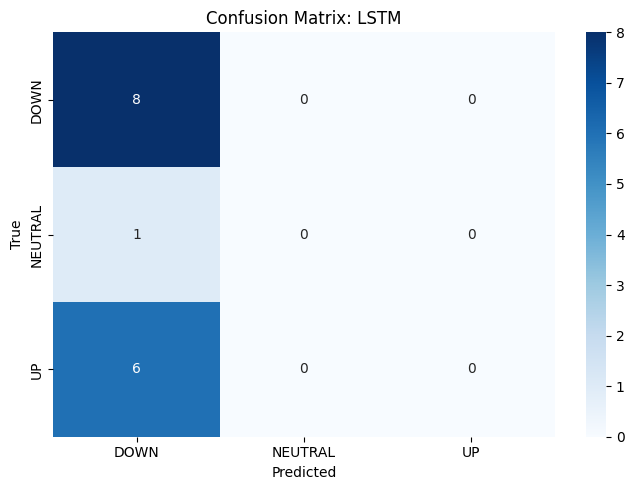

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step - accuracy: 0.4545 - loss: 0.8041 - val_accuracy: 1.0000 - val_loss: 0.8611 - learning_rate: 0.0010
Epoch 11/50
[INFY] Results DataFrame shape: (15, 27)
[INFY] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/INFY_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/INFY_results.xlsx
[INFY] 💾 Saved results to /content/output/INFY_results.xlsx
✅ Completed processing for INFY
[IGL] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4545 - loss: 0.7455Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[IGL] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[IGL] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

Epoch 11: val_loss did not improve from 0.85478
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3012
✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 42: val_loss improved from 0.93739 to 0.93237, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step - accuracy: 0.4545 - loss: 0.7455 - val_accuracy: 1.0000 - val_loss: 0.8651 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8182 - loss: 0.7751
Epoch 16: val_loss improved from 1.05513 to 1.04884, saving model to /content/checkpoints/INDIGO/INDIGO_lstm_model.h5



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: val_loss did not improve from 0.85478
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3012 - val_accuracy: 1.0000 - val_loss: 0.9324 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.7751 - val_accuracy: 1.0000 - val_loss: 0.8708 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.8786 - val_accuracy: 1.0000 - val_loss: 1.0488 - learning_rate: 5.0000e-04
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5455 - loss: 0.7077
Epoch 13: val_loss did not improve from 0.85478

Epoch 17: val_loss improved from 1.04884 to 1.04708, saving model to /content/checkpoints/INDIGO/INDIGO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2960
Epoch 43: val_loss improved from 0.93237 to 0.92955, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6927 - val_accuracy: 1.0000 - val_loss: 0.8725 - learning_rate: 5.0000e-04
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.7077 - val_accuracy: 1.0000 - val_loss: 1.0471 - learning_rate: 5.0000e-04
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2960 - val_accuracy: 1.0000 - val_loss: 0.9296 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9091 - loss: 0.3111
Epoch 44: val_loss improved from 0.92955 to 0.92823, saving model to /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.7224
Epoch 14: val_loss did not improve from 0.85478
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5455 - loss: 0.8628
Epoch 18: val_loss did not improve from 1.04708
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3111 - val_accuracy: 1.0000 - val_loss: 0.9282 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.7224 - val_accuracy: 1.0000 - val_loss: 0.8736 - learning_rate: 5.0000e-04
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.8628 - val_accuracy: 1.0000 - val_loss: 1.0489 - learning_rate: 5.0000e-04
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4545 - loss: 0.9676
Epoch 19: val_loss did not improve from 1.04708
[TATACHEM] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']


[TATACHEM] ✅ Loaded best model from /content/checkpoints/TATACHEM/TATACHEM_lstm_model.h5
[TATACHEM] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 0.9676 - val_accuracy: 1.0000 - val_loss: 1.0478 - learning_rate: 5.0000e-04
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3354
Epoch 1: val_loss improved from inf to 1.07939, saving model to /content/checkpoints/IGL/IGL_lstm_model.h5


[TATACHEM] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.6364 - loss: 0.8592
Epoch 45: val_loss did not improve from 0.92823

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Classification Report for LSTM:

Epoch 20: val_loss did not improve from 1.04708
              precision    recall  f1-score   support

        DOWN       0.40      1.00      0.57         6
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         8

    accuracy                           0.40        15
   macro avg       0.13      0.33      0.19        15
weighted avg       0.16      0.40      0.23        15



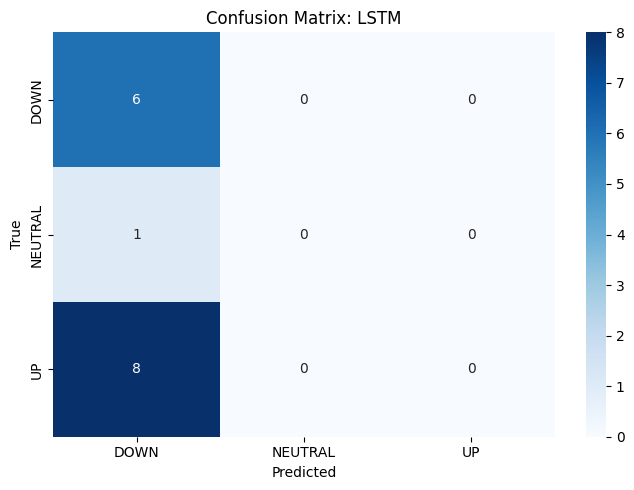

[TATACHEM] Results DataFrame shape: (15, 27)
[TATACHEM] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/TATACHEM_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/TATACHEM_results.xlsx
[TATACHEM] 💾 Saved results to /content/output/TATACHEM_results.xlsx
✅ Completed processing for TATACHEM
[IDFCFIRSTB] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[IDFCFIRSTB] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[IDFCFIRSTB] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.3354 - val_accuracy: 1.0000 - val_loss: 0.9352 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.0909 - loss: 2.1884 - val_accuracy: 0.0000e+00 - val_loss: 1.0794 - learning_rate: 0.0010
Epoch 2/50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.8592 - val_accuracy: 1.0000 - val_loss: 1.0530 - learning_rate: 5.0000e-04
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7273 - loss: 0.6611
Epoch 46: val_loss did not improve from 0.92823

Epoch 21: val_loss did not improve from 1.04708

Epoch 2: val_loss improved from 1.07939 to 1.07721, saving model to /content/checkpoints/IGL/IGL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2324 - val_accuracy: 1.0000 - val_loss: 0.9371 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6611 - val_accuracy: 1.0000 - val_loss: 1.0533 - learning_rate: 2.5000e-04
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6364 - loss: 0.6872
Epoch 22: val_loss did not improve from 1.04708
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2727 - loss: 1.3947 - val_accuracy: 0.0000e+00 - val_loss: 1.0772 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step - accuracy: 0.6364 - loss: 0.6872 - val_accuracy: 1.0000 - val_loss: 1.0540 - learning_rate: 2.5000e-04
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 17.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1620[INDIGO] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes

[INDIGO] ✅ Loaded best model from /content/checkpoints/INDIGO/INDIGO_lstm_model.h5
[INDIGO] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1620 - val_accuracy: 1.0000 - val_loss: 0.9367 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.2428 - val_accuracy: 0.0000e+00 - val_loss: 1.0881 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9091 - loss: 0.2250
Epoch 48: val_loss did not improve from 0.92823
[INDIGO] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.64      0.90      0.75        10
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         4

    accuracy                           0.60        15
   macro avg       0.21      0.30      0.25        15
weighted

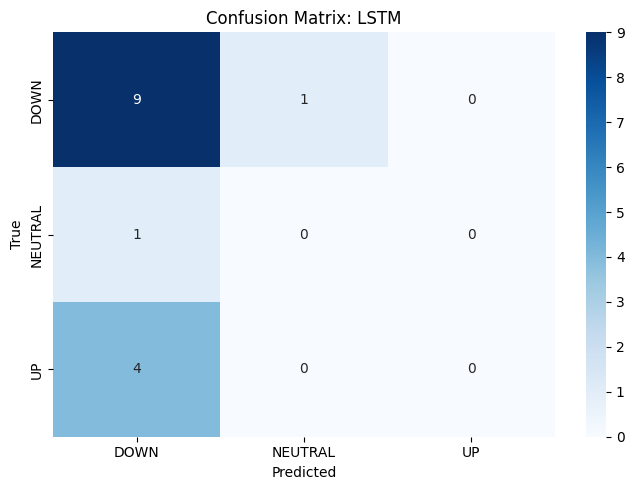

[INDIGO] Results DataFrame shape: (15, 27)
[INDIGO] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 1.0000 - loss: 0.1617Excel report successfully generated: /content/output/INDIGO_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/INDIGO_results.xlsx
[INDIGO] 💾 Saved results to /content/output/INDIGO_results.xlsx
✅ Completed processing for INDIGO
[IDEA] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4545 - loss: 1.0209Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[IDEA] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[IDEA] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 49: val_loss did not improve from 0.92823

Epoch 4: val_loss did not improve from 1.07721

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1617 - val_accuracy: 1.0000 - val_loss: 0.9338 - learning_rate: 5.0000e-04
Epoch 49: early stopping
Restoring model weights from the end of the best epoch: 44.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4545 - loss: 1.0209 - val_accuracy: 0.0000e+00 - val_loss: 1.0965 - learning_rate: 0.0010
Epoch 5/50
[INDUSINDBK] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6364 - loss: 0.8787Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[INDUSINDBK] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[INDUSINDBK] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 0 0 2 0 0 2 2 2 0 2 0 2 1]

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_loss did not improve from 1.07721


[INDUSINDBK] ✅ Loaded best model from /content/checkpoints/INDUSINDBK/INDUSINDBK_lstm_model.h5
[INDUSINDBK] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2727 - loss: 1.3716[INDUSINDBK] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.8787 - val_accuracy: 0.0000e+00 - val_loss: 1.1022 - learning_rate: 0.0010
Epoch 6/50

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.50      0.67      0.57         6
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.57      0.50      0.53         8

    accuracy                           0.53        15
   macro avg       0.36      0.39      0.37        15
weighted avg       0.50      0.53      0.51        15


Epoch 1: val_loss improved from inf to 1.04420, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


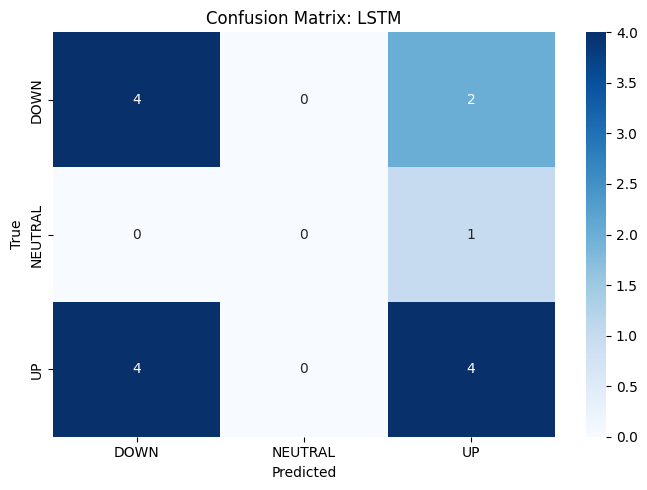

[INDUSINDBK] Results DataFrame shape: (15, 27)
[INDUSINDBK] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/INDUSINDBK_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/INDUSINDBK_results.xlsx
[INDUSINDBK] 💾 Saved results to /content/output/INDUSINDBK_results.xlsx
✅ Completed processing for INDUSINDBK
[TATAMOTORS] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[TATAMOTORS] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[TATAMOTORS] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.7250Epoch 1/50

Epoch 6: val_loss did not improve from 1.07721
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.2727 - loss: 1.3716 - val_accuracy: 1.0000 - val_loss: 1.0442 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3636 - loss: 1.0386
Epoch 2: val_loss improved from 1.04420 to 1.02657, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.7250 - val_accuracy: 0.0000e+00 - val_loss: 1.1022 - learning_rate: 5.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7273 - loss: 0.6484
Epoch 7: val_loss did not improve from 1.07721
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.0386 - val_accuracy: 1.0000 - val_loss: 1.0266 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6484 - val_accuracy: 0.0000e+00 - val_loss: 1.1001 - learning_rate: 5.0000e-04
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
[IGL] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[IGL] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[IGL] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_fut

[IGL] ✅ Loaded best model from /content/checkpoints/IGL/IGL_lstm_model.h5
[IGL] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.0909 - loss: 1.7852[IGL] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.8204 - val_accuracy: 1.0000 - val_loss: 1.0103 - learning_rate: 0.0010
Epoch 4/50

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.67      0.50      0.57         4
     NEUTRAL       1.00      1.00      1.00         1
          UP       0.82      0.90      0.86        10

    accuracy                           0.80        15
   macro avg       0.83      0.80      0.81        15
weighted avg       0.79      0.80      0.79        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7273 - loss: 0.7913
Epoch 4: val_loss improved from 1.01034 to 0.99992, saving model to /content/checkpoints/IDFCFIRSTB/

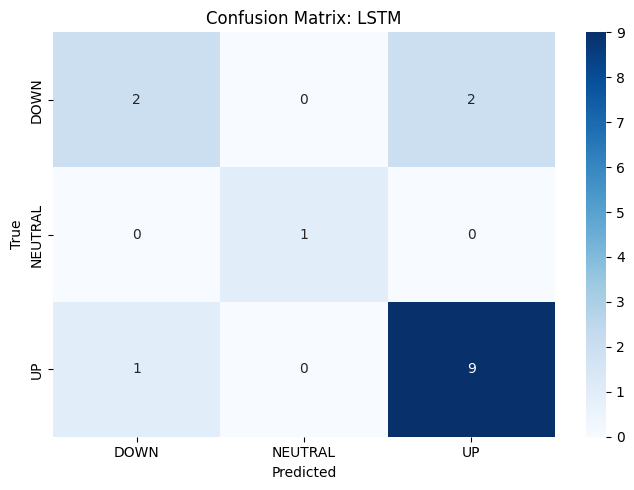

[IGL] Results DataFrame shape: (15, 27)
[IGL] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/IGL_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/IGL_results.xlsx
[IGL] 💾 Saved results to /content/output/IGL_results.xlsx
[AMBUJACEM] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for IGL
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[AMBUJACEM] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[AMBUJACEM] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

Epoch 1: val_loss improved from inf to 1.25906, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7913 - val_accuracy: 1.0000 - val_loss: 0.9999 - learning_rate: 0.0010
Epoch 5/50

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.0909 - loss: 1.7852 - val_accuracy: 0.0000e+00 - val_loss: 1.2591 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.4463
Epoch 5: val_loss improved from 0.99992 to 0.99633, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.4463 - val_accuracy: 1.0000 - val_loss: 0.9963 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.2821
Epoch 6: val_loss improved from 0.99633 to 0.99559, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3636 - loss: 2.3559
Epoch 2: val_loss improved from 1.25906 to 1.22251, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2821 - val_accuracy: 1.0000 - val_loss: 0.9956 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1818 - loss: 1.7038 - val_accuracy: 0.0000e+00 - val_loss: 1.2225 - learning_rate: 0.0010
Epoch 3/50

Epoch 1: val_loss improved from inf to 1.36915, saving model to /content/checkpoints/TATAMOTORS/TATAMOTORS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3776
Epoch 7: val_loss improved from 0.99559 to 0.99058, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.3636 - loss: 2.3559 - val_accuracy: 0.0000e+00 - val_loss: 1.3691 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.1818 - loss: 1.9484
Epoch 3: val_loss improved from 1.22251 to 1.17789, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5



Epoch 2: val_loss improved from 1.36915 to 1.35275, saving model to /content/checkpoints/TATAMOTORS/TATAMOTORS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3776 - val_accuracy: 1.0000 - val_loss: 0.9906 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2727 - loss: 1.3885 - val_accuracy: 0.0000e+00 - val_loss: 1.1779 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3636 - loss: 1.1082
Epoch 8: val_loss improved from 0.99058 to 0.97207, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1818 - loss: 1.9484 - val_accuracy: 0.0000e+00 - val_loss: 1.3527 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.0909 - loss: 1.3868Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.1818 - loss: 1.6306
Epoch 4: val_loss improved from 1.17789 to 1.13964, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5



Epoch 3: val_loss improved from 1.35275 to 1.33316, saving model to /content/checkpoints/TATAMOTORS/TATAMOTORS_lstm_model.h5



Epoch 1: val_loss improved from inf to 0.92988, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2411 - val_accuracy: 1.0000 - val_loss: 0.9721 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0909 - loss: 1.3868 - val_accuracy: 0.0000e+00 - val_loss: 1.1396 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1818 - loss: 1.6306 - val_accuracy: 0.0000e+00 - val_loss: 1.3332 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.3636 - loss: 1.6301
Epoch 5: val_loss improved from 1.13964 to 1.11892, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5



Epoch 4: val_loss improved from 1.33316 to 1.30496, saving model to /content/checkpoints/TATAMOTORS/TATAMOTORS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.3636 - loss: 1.1082 - val_accuracy: 1.0000 - val_loss: 0.9299 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8182 - loss: 0.6069
Epoch 2: val_loss did not improve from 0.92988
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.2092
Epoch 9: val_loss improved from 0.97207 to 0.95543, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.9196 - val_accuracy: 0.0000e+00 - val_loss: 1.1189 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.6301 - val_accuracy: 0.0000e+00 - val_loss: 1.3050 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step - accuracy: 0.8182 - loss: 0.6069 - val_accuracy: 1.0000 - val_loss: 0.9360 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.1818 - loss: 2.2536
Epoch 6: val_loss improved from 1.11892 to 1.09359, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5



Epoch 5: val_loss improved from 1.30496 to 1.28201, saving model to /content/checkpoints/TATAMOTORS/TATAMOTORS_lstm_model.h5

Epoch 3: val_loss did not improve from 0.92988


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2092 - val_accuracy: 1.0000 - val_loss: 0.9554 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 1.0000 - loss: 0.1599
Epoch 10: val_loss improved from 0.95543 to 0.94042, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6764 - val_accuracy: 1.0000 - val_loss: 0.9430 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.8277 - val_accuracy: 0.0000e+00 - val_loss: 1.0936 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1818 - loss: 2.2536 - val_accuracy: 0.0000e+00 - val_loss: 1.2820 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8182 - loss: 0.5417
Epoch 7: val_loss improved from 1.09359 to 1.07850, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5



Epoch 6: val_loss improved from 1.28201 to 1.26124, saving model to /content/checkpoints/TATAMOTORS/TATAMOTORS_lstm_model.h5



Epoch 4: val_loss improved from 0.92988 to 0.92925, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1599 - val_accuracy: 1.0000 - val_loss: 0.9404 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 1.0000 - loss: 0.1460
Epoch 11: val_loss improved from 0.94042 to 0.92608, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.8058 - val_accuracy: 1.0000 - val_loss: 1.0785 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.4967 - val_accuracy: 0.0000e+00 - val_loss: 1.2612 - learning_rate: 0.0010
Epoch 7/50

Epoch 8: val_loss improved from 1.07850 to 1.06712, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5417 - val_accuracy: 1.0000 - val_loss: 0.9292 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9091 - loss: 0.5160
Epoch 7: val_loss improved from 1.26124 to 1.24928, saving model to /content/checkpoints/TATAMOTORS/TATAMOTORS_lstm_model.h5



Epoch 5: val_loss improved from 0.92925 to 0.91282, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1460 - val_accuracy: 1.0000 - val_loss: 0.9261 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.7429 - val_accuracy: 1.0000 - val_loss: 1.0671 - learning_rate: 0.0010
Epoch 9/50

Epoch 12: val_loss improved from 0.92608 to 0.91023, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.5160 - val_accuracy: 1.0000 - val_loss: 0.9128 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.1523 - val_accuracy: 0.0000e+00 - val_loss: 1.2493 - learning_rate: 0.0010
Epoch 8/50

Epoch 9: val_loss improved from 1.06712 to 1.06118, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6364 - loss: 1.1143
Epoch 6: val_loss improved from 0.91282 to 0.90209, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5



Epoch 8: val_loss improved from 1.24928 to 1.24595, saving model to /content/checkpoints/TATAMOTORS/TATAMOTORS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1273 - val_accuracy: 1.0000 - val_loss: 0.9102 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6773 - val_accuracy: 1.0000 - val_loss: 1.0612 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4108 - val_accuracy: 1.0000 - val_loss: 0.9021 - learning_rate: 0.0010
Epoch 7/50

Epoch 13: val_loss improved from 0.91023 to 0.89217, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 1.1143 - val_accuracy: 0.0000e+00 - val_loss: 1.2459 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5455 - loss: 1.1503
Epoch 9: val_loss improved from 1.24595 to 1.24135, saving model to /content/checkpoints/TATAMOTORS/TATAMOTORS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0872 - val_accuracy: 1.0000 - val_loss: 0.8922 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step - accuracy: 0.5455 - loss: 1.1503 - val_accuracy: 0.0000e+00 - val_loss: 1.2414 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.5027
Epoch 14: val_loss improved from 0.89217 to 0.87634, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5



Epoch 10: val_loss improved from 1.06118 to 1.05385, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3560
Epoch 7: val_loss improved from 0.90209 to 0.89620, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step - accuracy: 1.0000 - loss: 0.1775 - val_accuracy: 1.0000 - val_loss: 0.8763 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5027 - val_accuracy: 1.0000 - val_loss: 1.0539 - learning_rate: 0.0010
Epoch 11/50

Epoch 10: val_loss improved from 1.24135 to 1.23575, saving model to /content/checkpoints/TATAMOTORS/TATAMOTORS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9091 - loss: 0.3729
Epoch 15: val_loss improved from 0.87634 to 0.86266, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5



Epoch 11: val_loss improved from 1.05385 to 1.04776, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3560 - val_accuracy: 1.0000 - val_loss: 0.8962 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 1.0353 - val_accuracy: 0.0000e+00 - val_loss: 1.2357 - learning_rate: 0.0010

Epoch 8: val_loss improved from 0.89620 to 0.88779, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5
Epoch 11/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0690 - val_accuracy: 1.0000 - val_loss: 0.8627 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3729 - val_accuracy: 1.0000 - val_loss: 1.0478 - learning_rate: 0.0010
Epoch 12/50

Epoch 16: val_loss improved from 0.86266 to 0.84915, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8182 - loss: 0.5165
Epoch 12: val_loss improved from 1.04776 to 1.04659, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step - accuracy: 0.9091 - loss: 0.3082 - val_accuracy: 1.0000 - val_loss: 0.8878 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7273 - loss: 0.4665
Epoch 9: val_loss improved from 0.88779 to 0.87849, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step - accuracy: 1.0000 - loss: 0.0766 - val_accuracy: 1.0000 - val_loss: 0.8492 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step - accuracy: 0.8182 - loss: 0.5165 - val_accuracy: 1.0000 - val_loss: 1.0466 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 1.0000 - loss: 0.0561
Epoch 11: val_loss improved from 1.23575 to 1.23510, saving model to /content/checkpoints/TATAMOTORS/TATAMOTORS_lstm_model.h5



Epoch 13: val_loss improved from 1.04659 to 1.04584, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step - accuracy: 0.7273 - loss: 0.4665 - val_accuracy: 1.0000 - val_loss: 0.8785 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9091 - loss: 0.3038
Epoch 17: val_loss improved from 0.84915 to 0.83629, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5



Epoch 10: val_loss improved from 0.87849 to 0.86560, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 1.2237 - val_accuracy: 0.0000e+00 - val_loss: 1.2351 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4314 - val_accuracy: 1.0000 - val_loss: 1.0458 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.3636 - loss: 1.2485
Epoch 14: val_loss improved from 1.04584 to 1.04429, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0561 - val_accuracy: 1.0000 - val_loss: 0.8363 - learning_rate: 0.0010
Epoch 18/50

Epoch 12: val_loss did not improve from 1.23510
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3038 - val_accuracy: 1.0000 - val_loss: 0.8656 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step - accuracy: 0.3636 - loss: 1.2485 - val_accuracy: 0.0000e+00 - val_loss: 1.2401 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step - accuracy: 1.0000 - loss: 0.3299 - val_accuracy: 1.0000 - val_loss: 1.0443 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.3022
Epoch 15: val_loss improved from 1.04429 to 1.04169, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 1.0000 - loss: 0.3022 - val_accuracy: 1.0000 - val_loss: 1.0417 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.2533
Epoch 16: val_loss improved from 1.04169 to 1.03280, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 1.0000 - loss: 0.2533 - val_accuracy: 1.0000 - val_loss: 1.0328 - learning_rate: 0.0010
Epoch 17/50

Epoch 13: val_loss did not improve from 1.23510
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0695
Epoch 18: val_loss improved from 0.83629 to 0.82461, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.0287 - val_accuracy: 0.0000e+00 - val_loss: 1.2448 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7273 - loss: 0.8668
Epoch 17: val_loss improved from 1.03280 to 1.02004, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5



Epoch 11: val_loss improved from 0.86560 to 0.85622, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: val_loss did not improve from 1.23510
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0695 - val_accuracy: 1.0000 - val_loss: 0.8246 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.8668 - val_accuracy: 0.0000e+00 - val_loss: 1.2483 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2157 - val_accuracy: 1.0000 - val_loss: 1.0200 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2454 - val_accuracy: 1.0000 - val_loss: 0.8562 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.2930
Epoch 18: val_loss improved from 1.02004 to 1.00098, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 1.0000 - loss: 0.2930 - val_accuracy: 1.0000 - val_loss: 1.0010 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 1.0000 - loss: 0.0512
Epoch 19: val_loss improved from 0.82461 to 0.81379, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.7273 - loss: 0.7094
Epoch 12: val_loss improved from 0.85622 to 0.84889, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5



Epoch 19: val_loss improved from 1.00098 to 0.98294, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0512 - val_accuracy: 1.0000 - val_loss: 0.8138 - learning_rate: 0.0010
Epoch 20/50

Epoch 15: val_loss did not improve from 1.23510
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.7094 - val_accuracy: 0.0000e+00 - val_loss: 1.2494 - learning_rate: 5.0000e-04
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3366 - val_accuracy: 1.0000 - val_loss: 0.8489 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1924 - val_accuracy: 1.0000 - val_loss: 0.9829 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 1.0000 - loss: 0.0360
Epoch 13: val_loss improved from 0.84889 to 0.83762, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5



Epoch 20: val_loss improved from 0.81379 to 0.80330, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.5455 - loss: 0.7538
Epoch 20: val_loss improved from 0.98294 to 0.96610, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5



Epoch 16: val_loss did not improve from 1.23510
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0360 - val_accuracy: 1.0000 - val_loss: 0.8033 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3190 - val_accuracy: 1.0000 - val_loss: 0.8376 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.7538 - val_accuracy: 0.0000e+00 - val_loss: 1.2510 - learning_rate: 5.0000e-04
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 11.
[TATAMOTORS] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

Epoch 21: val_loss improved from 0.80330 to 0.79438, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[TATAMOTORS] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1587 - val_accuracy: 1.0000 - val_loss: 0.9661 - learning_rate: 0.0010
Epoch 21/50
[TATAMOTORS] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 2 0 2 2 2 2 0 2 0 2 2 2 2 1]


[TATAMOTORS] ✅ Loaded best model from /content/checkpoints/TATAMOTORS/TATAMOTORS_lstm_model.h5
[TATAMOTORS] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0361 - val_accuracy: 1.0000 - val_loss: 0.7944 - learning_rate: 0.0010
Epoch 22/50
[TATAMOTORS] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.18      0.50      0.27         4
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00        10

    accuracy                           0.13        15
   macro avg       0.06      0.17      0.09        15
weighted avg       0.05      0.13      0.07        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1963
Epoch 22: val_loss improved from 0.79438 to 0.78555, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5



Epoch 14: val_loss improved from 0.83762 to 0.82702, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5



Epoch 21: val_loss improved from 0.96610 to 0.94993, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


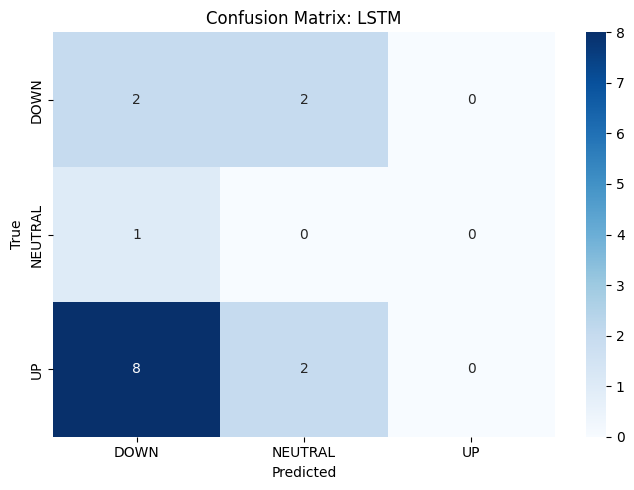

[TATAMOTORS] Results DataFrame shape: (15, 27)
[TATAMOTORS] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/TATAMOTORS_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/TATAMOTORS_results.xlsx
[TATAMOTORS] 💾 Saved results to /content/output/TATAMOTORS_results.xlsx
[ICICIPRULI] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for TATAMOTORS
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[ICICIPRULI] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[ICICIPRULI] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0458 - val_accuracy: 1.0000 - val_loss: 0.7855 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2045 - val_accuracy: 1.0000 - val_loss: 0.8270 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1963 - val_accuracy: 1.0000 - val_loss: 0.9499 - learning_rate: 0.0010
Epoch 22/50

Epoch 15: val_loss improved from 0.82702 to 0.81643, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 948ms/step - accuracy: 1.0000 - loss: 0.0233
Epoch 23: val_loss improved from 0.78555 to 0.77662, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1352 - val_accuracy: 1.0000 - val_loss: 0.8164 - learning_rate: 0.0010
Epoch 16/50

Epoch 22: val_loss improved from 0.94993 to 0.93399, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0233 - val_accuracy: 1.0000 - val_loss: 0.7766 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1607 - val_accuracy: 1.0000 - val_loss: 0.9340 - learning_rate: 0.0010
Epoch 23/50

Epoch 24: val_loss improved from 0.77662 to 0.76927, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5



Epoch 16: val_loss improved from 0.81643 to 0.80754, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.1404


Epoch 23: val_loss improved from 0.93399 to 0.91662, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0278 - val_accuracy: 1.0000 - val_loss: 0.7693 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2135 - val_accuracy: 1.0000 - val_loss: 0.8075 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1404 - val_accuracy: 1.0000 - val_loss: 0.9166 - learning_rate: 0.0010
Epoch 24/50

Epoch 17: val_loss improved from 0.80754 to 0.79669, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 1.0000 - loss: 0.0274
Epoch 25: val_loss improved from 0.76927 to 0.76223, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step - accuracy: 1.0000 - loss: 0.1802 - val_accuracy: 1.0000 - val_loss: 0.7967 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9091 - loss: 0.2233
Epoch 18: val_loss improved from 0.79669 to 0.78843, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5



Epoch 24: val_loss improved from 0.91662 to 0.89939, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0274 - val_accuracy: 1.0000 - val_loss: 0.7622 - learning_rate: 0.0010
Epoch 26/50

Epoch 1: val_loss improved from inf to 1.43978, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2233 - val_accuracy: 1.0000 - val_loss: 0.7884 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1726 - val_accuracy: 1.0000 - val_loss: 0.8994 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.1651
Epoch 19: val_loss improved from 0.78843 to 0.77946, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.0000e+00 - loss: 2.3206 - val_accuracy: 0.0000e+00 - val_loss: 1.4398 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 1.0000 - loss: 0.1651 - val_accuracy: 1.0000 - val_loss: 0.7795 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 1.0000 - loss: 0.1451
Epoch 20: val_loss improved from 0.77946 to 0.77039, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step - accuracy: 1.0000 - loss: 0.1451 - val_accuracy: 1.0000 - val_loss: 0.7704 - learning_rate: 0.0010
Epoch 21/50

Epoch 26: val_loss improved from 0.76223 to 0.75666, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1395
Epoch 2: val_loss improved from 1.43978 to 1.43388, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8182 - loss: 0.2786
Epoch 25: val_loss improved from 0.89939 to 0.88195, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5



Epoch 21: val_loss improved from 0.77039 to 0.76117, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0282 - val_accuracy: 1.0000 - val_loss: 0.7567 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 0.0280
Epoch 27: val_loss improved from 0.75666 to 0.75161, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.7179 - val_accuracy: 0.0000e+00 - val_loss: 1.4339 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1395 - val_accuracy: 1.0000 - val_loss: 0.8820 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.2786 - val_accuracy: 1.0000 - val_loss: 0.7612 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.1199
Epoch 3: val_loss improved from 1.43388 to 1.41248, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5



Epoch 22: val_loss improved from 0.76117 to 0.75168, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0280 - val_accuracy: 1.0000 - val_loss: 0.7516 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.7912 - val_accuracy: 0.0000e+00 - val_loss: 1.4125 - learning_rate: 0.0010
Epoch 4/50

Epoch 28: val_loss improved from 0.75161 to 0.74855, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1199 - val_accuracy: 1.0000 - val_loss: 0.7517 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 0.1369
Epoch 4: val_loss improved from 1.41248 to 1.37937, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5



Epoch 23: val_loss improved from 0.75168 to 0.74353, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5



Epoch 26: val_loss improved from 0.88195 to 0.86527, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0189 - val_accuracy: 1.0000 - val_loss: 0.7485 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 0.0167
Epoch 29: val_loss improved from 0.74855 to 0.74646, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.4934 - val_accuracy: 0.0000e+00 - val_loss: 1.3794 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1085 - val_accuracy: 1.0000 - val_loss: 0.8653 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1369 - val_accuracy: 1.0000 - val_loss: 0.7435 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0167 - val_accuracy: 1.0000 - val_loss: 0.7465 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0403
Epoch 30: val_loss improved from 0.74646 to 0.74553, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 1.0000 - loss: 0.0403 - val_accuracy: 1.0000 - val_loss: 0.7455 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3636 - loss: 1.4812
Epoch 31: val_loss improved from 0.74553 to 0.74414, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5



Epoch 5: val_loss improved from 1.37937 to 1.34003, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0875
Epoch 27: val_loss improved from 0.86527 to 0.84892, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5



Epoch 24: val_loss improved from 0.74353 to 0.73518, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 1.0000 - val_loss: 0.7441 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.0196
Epoch 32: val_loss did not improve from 0.74414
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.4812 - val_accuracy: 0.0000e+00 - val_loss: 1.3400 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4545 - loss: 1.3132
Epoch 6: val_loss improved from 1.34003 to 1.30539, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1317 - val_accuracy: 1.0000 - val_loss: 0.7352 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0875 - val_accuracy: 1.0000 - val_loss: 0.8489 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step - accuracy: 1.0000 - loss: 0.0196 - val_accuracy: 1.0000 - val_loss: 0.7444 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 0.1034
Epoch 28: val_loss improved from 0.84892 to 0.83156, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step - accuracy: 0.4545 - loss: 1.3132 - val_accuracy: 0.0000e+00 - val_loss: 1.3054 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.2727 - loss: 1.4896
Epoch 33: val_loss improved from 0.74414 to 0.74391, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5



Epoch 7: val_loss improved from 1.30539 to 1.27153, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step - accuracy: 1.0000 - loss: 0.1034 - val_accuracy: 1.0000 - val_loss: 0.8316 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0195 - val_accuracy: 1.0000 - val_loss: 0.7439 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step - accuracy: 0.2727 - loss: 1.4896 - val_accuracy: 0.0000e+00 - val_loss: 1.2715 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1270
Epoch 25: val_loss improved from 0.73518 to 0.72734, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 1.0000 - loss: 0.1038
Epoch 29: val_loss improved from 0.83156 to 0.81588, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.5455 - loss: 1.0982
Epoch 34: val_loss improved from 0.74391 to 0.74345, saving model to /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5



Epoch 8: val_loss improved from 1.27153 to 1.24496, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1270 - val_accuracy: 1.0000 - val_loss: 0.7273 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1038 - val_accuracy: 1.0000 - val_loss: 0.8159 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0833
Epoch 30: val_loss improved from 0.81588 to 0.80168, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 1.0000 - loss: 0.1421
Epoch 26: val_loss improved from 0.72734 to 0.72326, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.0982 - val_accuracy: 0.0000e+00 - val_loss: 1.2450 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 1.0000 - val_loss: 0.7435 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.3636 - loss: 1.0752
Epoch 35: val_loss did not improve from 0.74345

Epoch 9: val_loss improved from 1.24496 to 1.22606, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0833 - val_accuracy: 1.0000 - val_loss: 0.8017 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1421 - val_accuracy: 1.0000 - val_loss: 0.7233 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.1024
Epoch 31: val_loss improved from 0.80168 to 0.78858, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step - accuracy: 1.0000 - loss: 0.0360 - val_accuracy: 1.0000 - val_loss: 0.7444 - learning_rate: 0.0010
Epoch 36/50

Epoch 27: val_loss improved from 0.72326 to 0.71874, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.0752 - val_accuracy: 0.0000e+00 - val_loss: 1.2261 - learning_rate: 0.0010
Epoch 10/50

Epoch 36: val_loss did not improve from 0.74345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.5455 - loss: 1.0121
Epoch 10: val_loss improved from 1.22606 to 1.20267, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0858 - val_accuracy: 1.0000 - val_loss: 0.7886 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step - accuracy: 1.0000 - loss: 0.0144 - val_accuracy: 1.0000 - val_loss: 0.7460 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1024 - val_accuracy: 1.0000 - val_loss: 0.7187 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 0.1004
Epoch 32: val_loss improved from 0.78858 to 0.77635, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5



Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 37: val_loss did not improve from 0.74345

Epoch 28: val_loss improved from 0.71874 to 0.70463, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.0121 - val_accuracy: 0.0000e+00 - val_loss: 1.2027 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.4545 - loss: 1.1228
Epoch 11: val_loss improved from 1.20267 to 1.18381, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0154 - val_accuracy: 1.0000 - val_loss: 0.7476 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0895 - val_accuracy: 1.0000 - val_loss: 0.7763 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1004 - val_accuracy: 1.0000 - val_loss: 0.7046 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0787
Epoch 33: val_loss improved from 0.77635 to 0.76411, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5



Epoch 38: val_loss did not improve from 0.74345

Epoch 29: val_loss improved from 0.70463 to 0.69021, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.1228 - val_accuracy: 0.0000e+00 - val_loss: 1.1838 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5455 - loss: 0.7488
Epoch 12: val_loss improved from 1.18381 to 1.16662, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0261 - val_accuracy: 1.0000 - val_loss: 0.7493 - learning_rate: 5.0000e-04
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0619 - val_accuracy: 1.0000 - val_loss: 0.7641 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 0.0628
Epoch 39: val_loss did not improve from 0.74345
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0787 - val_accuracy: 1.0000 - val_loss: 0.6902 - learning_rate: 0.0010
Epoch 30/50

Epoch 34: val_loss improved from 0.76411 to 0.75269, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.7488 - val_accuracy: 0.0000e+00 - val_loss: 1.1666 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step - accuracy: 1.0000 - loss: 0.0116 - val_accuracy: 1.0000 - val_loss: 0.7509 - learning_rate: 5.0000e-04
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 34.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step - accuracy: 1.0000 - loss: 0.0628 - val_accuracy: 1.0000 - val_loss: 0.7527 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.5455 - loss: 0.9682
Epoch 35: val_loss improved from 0.75269 to 0.74127, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5



Epoch 13: val_loss improved from 1.16662 to 1.15450, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


[IDFCFIRSTB] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[IDFCFIRSTB] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[IDFCFIRSTB] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 2 2 2 2 2 2 2 2 0 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0906

[IDFCFIRSTB] ✅ Loaded best model from /content/checkpoints/IDFCFIRSTB/IDFCFIRSTB_lstm_model.h5
[IDFCFIRSTB] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0441 - val_accuracy: 1.0000 - val_loss: 0.7413 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.9682 - val_accuracy: 0.0000e+00 - val_loss: 1.1545 - learning_rate: 0.0010
Epoch 14/50

Epoch 30: val_loss improved from 0.69021 to 0.67610, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 1.0000 - loss: 0.0521
Epoch 36: val_loss improved from 0.74127 to 0.73110, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5

Epoch 14: val_loss improved from 1.15450 to 1.14250, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0906 - val_accuracy: 1.0000 - val_loss: 0.6761 - learning_rate: 0.0010
Epoch 31/50
[IDFCFIRSTB] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.1026
Classification Report for LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0521 - val_accuracy: 1.0000 - val_loss: 0.7311 - learning_rate: 0.0010
Epoch 37/50
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         2
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.80      1.00      0.89        12

    accuracy                           0.80        15
   macro avg       0.27      0.33      0.30        15
weighted avg       0.64      0.80      0.71        15


Epoch 31: val_loss improved from 0.67610 to 0.66057, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.8615 - val_accuracy: 0.0000e+00 - val_loss: 1.1425 - learning_rate: 0.0010
Epoch 15/50


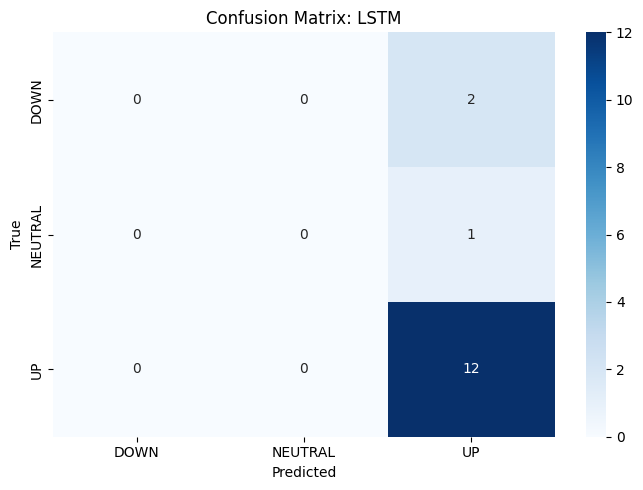

[IDFCFIRSTB] Results DataFrame shape: (15, 27)
[IDFCFIRSTB] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/IDFCFIRSTB_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/IDFCFIRSTB_results.xlsx
[IDFCFIRSTB] 💾 Saved results to /content/output/IDFCFIRSTB_results.xlsx
[ICICIBANK] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for IDFCFIRSTB
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[ICICIBANK] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[ICICIBANK] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1026 - val_accuracy: 1.0000 - val_loss: 0.6606 - learning_rate: 0.0010
Epoch 32/50

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 0.0510Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.5455 - loss: 0.7680
Epoch 32: val_loss improved from 0.66057 to 0.64809, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0491
Epoch 15: val_loss improved from 1.14250 to 1.12996, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5



Epoch 37: val_loss improved from 0.73110 to 0.72087, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0510 - val_accuracy: 1.0000 - val_loss: 0.6481 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0755
Epoch 33: val_loss improved from 0.64809 to 0.63865, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5455 - loss: 0.7680 - val_accuracy: 0.0000e+00 - val_loss: 1.1300 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0491 - val_accuracy: 1.0000 - val_loss: 0.7209 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.4545 - loss: 0.7696
Epoch 16: val_loss improved from 1.12996 to 1.11098, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 1.0000 - loss: 0.0312
Epoch 38: val_loss improved from 0.72087 to 0.71022, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0755 - val_accuracy: 1.0000 - val_loss: 0.6387 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 0.0970
Epoch 34: val_loss improved from 0.63865 to 0.63474, saving model to /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 0.7696 - val_accuracy: 0.0000e+00 - val_loss: 1.1110 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6364 - loss: 0.5701
Epoch 17: val_loss improved from 1.11098 to 1.09095, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0312 - val_accuracy: 1.0000 - val_loss: 0.7102 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0435
Epoch 39: val_loss improved from 0.71022 to 0.70099, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0970 - val_accuracy: 1.0000 - val_loss: 0.6347 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.5701 - val_accuracy: 1.0000 - val_loss: 1.0909 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0435 - val_accuracy: 1.0000 - val_loss: 0.7010 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0405
Epoch 40: val_loss improved from 0.70099 to 0.69148, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0647
Epoch 35: val_loss did not improve from 0.63474
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.8182 - loss: 0.5848
Epoch 18: val_loss improved from 1.09095 to 1.06881, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step - accuracy: 1.0000 - loss: 0.0405 - val_accuracy: 1.0000 - val_loss: 0.6915 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0647 - val_accuracy: 1.0000 - val_loss: 0.6356 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 0.0714
Epoch 41: val_loss improved from 0.69148 to 0.68224, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5



Epoch 36: val_loss did not improve from 0.63474

Epoch 1: val_loss improved from inf to 1.05150, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5848 - val_accuracy: 1.0000 - val_loss: 1.0688 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5455 - loss: 0.7105
Epoch 19: val_loss improved from 1.06881 to 1.05039, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0714 - val_accuracy: 1.0000 - val_loss: 0.6348 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0459 - val_accuracy: 1.0000 - val_loss: 0.6822 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 1.0000 - loss: 0.0554
Epoch 42: val_loss improved from 0.68224 to 0.67215, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5



Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 37: val_loss did not improve from 0.63474
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5455 - loss: 0.9432 - val_accuracy: 1.0000 - val_loss: 1.0515 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2727 - loss: 1.3183
Epoch 2: val_loss improved from 1.05150 to 1.04419, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.7105 - val_accuracy: 1.0000 - val_loss: 1.0504 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6364 - loss: 0.6880
Epoch 20: val_loss improved from 1.05039 to 1.03453, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0554 - val_accuracy: 1.0000 - val_loss: 0.6362 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0431 - val_accuracy: 1.0000 - val_loss: 0.6722 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 1.0000 - loss: 0.0830
Epoch 38: val_loss did not improve from 0.63474
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.3183 - val_accuracy: 1.0000 - val_loss: 1.0442 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step - accuracy: 0.6364 - loss: 0.6880 - val_accuracy: 1.0000 - val_loss: 1.0345 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6364 - loss: 0.7021
Epoch 3: val_loss improved from 1.04419 to 1.02472, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step - accuracy: 1.0000 - loss: 0.0830 - val_accuracy: 1.0000 - val_loss: 0.6403 - learning_rate: 5.0000e-04

Epoch 21: val_loss improved from 1.03453 to 1.02936, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5
Epoch 39/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 0.0986
Epoch 39: val_loss did not improve from 0.63474
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0321
Epoch 43: val_loss improved from 0.67215 to 0.66134, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.9344 - val_accuracy: 1.0000 - val_loss: 1.0247 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.7021 - val_accuracy: 1.0000 - val_loss: 1.0294 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0986 - val_accuracy: 1.0000 - val_loss: 0.6481 - learning_rate: 5.0000e-04
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 34.
[AMBUJACEM] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[AMBUJACEM] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[AMBUJACEM] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 0 2 2 2 2 2 2 2 1 2 2 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0321

[AMBUJACEM] ✅ Loaded best model from /content/checkpoints/AMBUJACEM/AMBUJACEM_lstm_model.h5
[AMBUJACEM] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0328
Epoch 44: val_loss improved from 0.66134 to 0.65064, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.7279[AMBUJACEM] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step - accuracy: 1.0000 - loss: 0.0328 - val_accuracy: 1.0000 - val_loss: 0.6506 - learning_rate: 0.0010
Epoch 45/50

Epoch 22: val_loss improved from 1.02936 to 1.02076, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5

Epoch 4: val_loss improved from 1.02472 to 1.00258, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5



Classification Report for LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 1.0000 - loss: 0.0284              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         1
     NEUTRAL       1.00      0.50      0.67         2
          UP       0.86      1.00      0.92        12

    accuracy                           0.87        15
   macro avg       0.62      0.50      0.53        15
weighted avg       0.82      0.87      0.83        15


Epoch 45: val_loss improved from 0.65064 to 0.64017, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


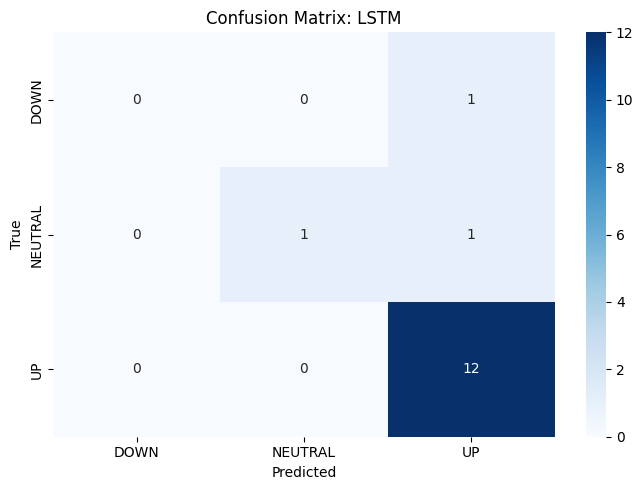

[AMBUJACEM] Results DataFrame shape: (15, 27)
[AMBUJACEM] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/AMBUJACEM_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/AMBUJACEM_results.xlsx
[AMBUJACEM] 💾 Saved results to /content/output/AMBUJACEM_results.xlsx
✅ Completed processing for AMBUJACEM
[HINDUNILVR] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[HINDUNILVR] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[HINDUNILVR] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4545 - loss: 1.0055 - val_accuracy: 1.0000 - val_loss: 1.0026 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 23: val_loss improved from 1.02076 to 1.01437, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


Epoch 1/50

Epoch 5: val_loss improved from 1.00258 to 0.98972, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0284 - val_accuracy: 1.0000 - val_loss: 0.6402 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5368 - val_accuracy: 1.0000 - val_loss: 1.0144 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.6639 - val_accuracy: 1.0000 - val_loss: 0.9897 - learning_rate: 0.0010
Epoch 6/50

Epoch 46: val_loss improved from 0.64017 to 0.62948, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5



Epoch 24: val_loss improved from 1.01437 to 1.00975, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.8182 - loss: 0.4903
Epoch 6: val_loss improved from 0.98972 to 0.96977, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0264 - val_accuracy: 1.0000 - val_loss: 0.6295 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5262 - val_accuracy: 1.0000 - val_loss: 1.0097 - learning_rate: 0.0010
Epoch 25/50

Epoch 47: val_loss improved from 0.62948 to 0.61926, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9091 - loss: 0.4748
Epoch 25: val_loss improved from 1.00975 to 1.00888, saving model to /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4903 - val_accuracy: 1.0000 - val_loss: 0.9698 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0270 - val_accuracy: 1.0000 - val_loss: 0.6193 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4748 - val_accuracy: 1.0000 - val_loss: 1.0089 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.8182 - loss: 0.5766
Epoch 7: val_loss improved from 0.96977 to 0.94319, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5766 - val_accuracy: 1.0000 - val_loss: 0.9432 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7273 - loss: 0.6550
Epoch 8: val_loss improved from 0.94319 to 0.91455, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 1.0000 - loss: 0.0289
Epoch 48: val_loss improved from 0.61926 to 0.61048, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.5079
Epoch 1: val_loss improved from inf to 1.20343, saving model to /content/checkpoints/HINDUNILVR/HINDUNILVR_lstm_model.h5



Epoch 26: val_loss did not improve from 1.00888
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6550 - val_accuracy: 1.0000 - val_loss: 0.9145 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0289 - val_accuracy: 1.0000 - val_loss: 0.6105 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 0.0259
Epoch 9: val_loss improved from 0.91455 to 0.89088, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5

Epoch 49: val_loss improved from 0.61048 to 0.60118, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5079 - val_accuracy: 1.0000 - val_loss: 1.0092 - learning_rate: 0.0010


Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.4545 - loss: 1.0592 - val_accuracy: 0.0000e+00 - val_loss: 1.2034 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.3636 - loss: 0.9691
Epoch 27: val_loss did not improve from 1.00888

Epoch 2: val_loss did not improve from 1.20343
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0259 - val_accuracy: 1.0000 - val_loss: 0.6012 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5057 - val_accuracy: 1.0000 - val_loss: 0.8909 - learning_rate: 0.0010
Epoch 50/50
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5153 - val_accuracy: 1.0000 - val_loss: 1.0151 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 0.9691 - val_accuracy: 0.0000e+00 - val_loss: 1.2504 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8182 - loss: 0.4630



Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 28: val_loss did not improve from 1.00888
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.5455 - loss: 0.8343
Epoch 3: val_loss did not improve from 1.20343
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step - accuracy: 0.8182 - loss: 0.4630 - val_accuracy: 1.0000 - val_loss: 1.0198 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4495 - val_accuracy: 1.0000 - val_loss: 0.8712 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.8343 - val_accuracy: 0.0000e+00 - val_loss: 1.2822 - learning_rate: 0.0010
Epoch 4/50

Epoch 29: val_loss did not improve from 1.00888
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0208
Epoch 11: val_loss improved from 0.87118 to 0.85614, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5



Epoch 50: val_loss improved from 0.60118 to 0.59192, saving model to /content/checkpoints/IDEA/IDEA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.5455 - loss: 1.1589
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.20343
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3359 - val_accuracy: 0.0000e+00 - val_loss: 1.0260 - learning_rate: 5.0000e-04
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4180 - val_accuracy: 1.0000 - val_loss: 0.8561 - learning_rate: 0.0010
Epoch 12/50

Epoch 30: val_loss did not improve from 1.00888
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0208 - val_accuracy: 1.0000 - val_loss: 0.5919 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
[IDEA] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 1.1589 - val_accuracy: 0.0000e+00 - val_loss: 1.3022 - learning_rate: 0.001

[ICICIPRULI] ✅ LSTM model trained[IDEA] ✅ Loaded best model from /content/checkpoints/IDEA/IDEA_lstm_model.h5
[IDEA] Predicting for 15 dates, including 30-07-2025

Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

Epoch 5: val_loss did not improve from 1.20343
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[ICICIPRULI] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[ICICIPRULI] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 2 2 2 2 2 0 2 2 2 2 2 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3017

[ICICIPRULI] ✅ Loaded best model from /content/checkpoints/ICICIPRULI/ICICIPRULI_lstm_model.h5
[ICICIPRULI] Predicting for 15 dates, including 30-07-2025

Epoch 12: val_loss improved from 0.85614 to 0.84320, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.8263 - val_accuracy: 0.0000e+00 - val_loss: 1.3093 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7273 - loss: 0.8112
Epoch 6: val_loss did not improve from 1.20343
[ICICIPRULI] Predictions generated. y_pred length: 15, dates_future length: 15
[IDEA] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         2
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.77      0.83      0.80        12

    accuracy                           0.67        15
   macro avg       0.26      0.28      0.27        15
weighted avg       0.62      0.67      0.64        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3017 - val_accuracy: 1.0000 - val_loss: 0.8432 - learning_rate: 0.0010
Epoch 13/50

Classifica

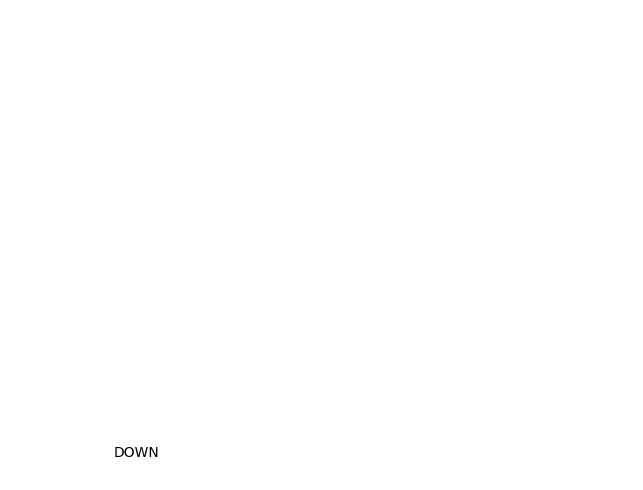

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.8112 - val_accuracy: 0.0000e+00 - val_loss: 1.3169 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 13: val_loss improved from 0.84320 to 0.83605, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5


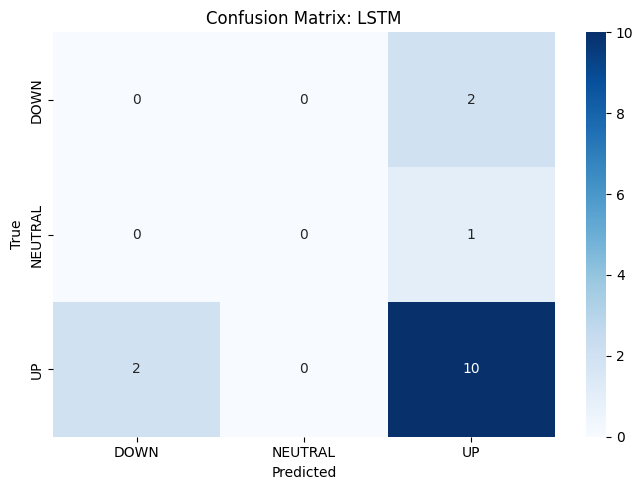

[HINDUNILVR] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[HINDUNILVR] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[HINDUNILVR] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 0 0 0 0 0 2 0 2 0 0 1]


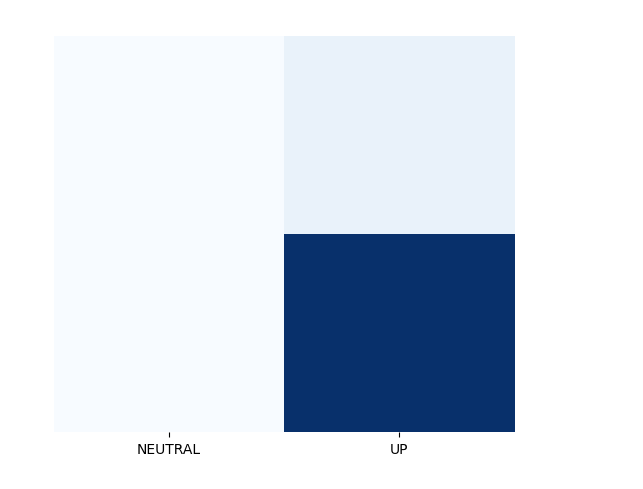

[ICICIPRULI] Results DataFrame shape: (15, 27)
[ICICIPRULI] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/ICICIPRULI_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/ICICIPRULI_results.xlsx
[ICICIPRULI] 💾 Saved results to /content/output/ICICIPRULI_results.xlsx
[TATAPOWER] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for ICICIPRULI


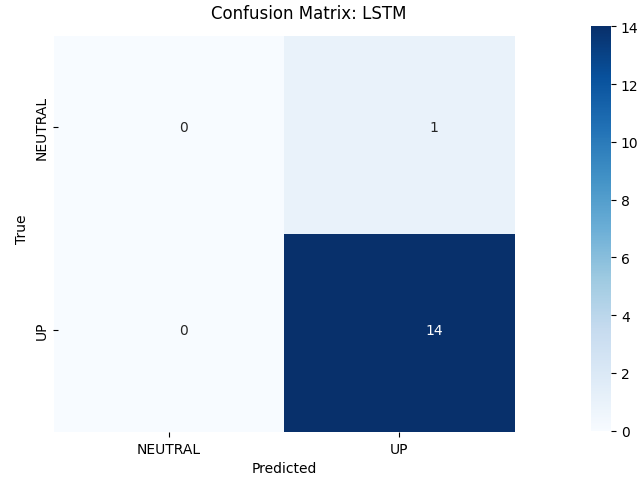

[HINDUNILVR] ✅ Loaded best model from /content/checkpoints/HINDUNILVR/HINDUNILVR_lstm_model.h5
[HINDUNILVR] Predicting for 15 dates, including 30-07-2025
[IDEA] Results DataFrame shape: (15, 26)
[IDEA] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[TATAPOWER] ✅ Technical indicators added. Shape: (24, 73), Features: 73
Excel report successfully generated: /content/outpu

<IPython.core.display.Javascript object>

[TATAPOWER] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/IDEA_results.xlsx
[IDEA] 💾 Saved results to /content/output/IDEA_results.xlsx
✅ Completed processing for IDEA

Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
[LUPIN] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[LUPIN] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[LUPIN] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.5925 - val_accuracy: 1.0000 - val_loss: 0.8361 - learning_rate: 0.0010
Epoch 14/50


 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9091 - loss: 0.3482Epoch 1/50
Epoch 1/50

Epoch 14: val_loss improved from 0.83605 to 0.82541, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5


[HINDUNILVR] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.80      1.00      0.89        12
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         2

    accuracy                           0.80        15
   macro avg       0.27      0.33      0.30        15
weighted avg       0.64      0.80      0.71        15



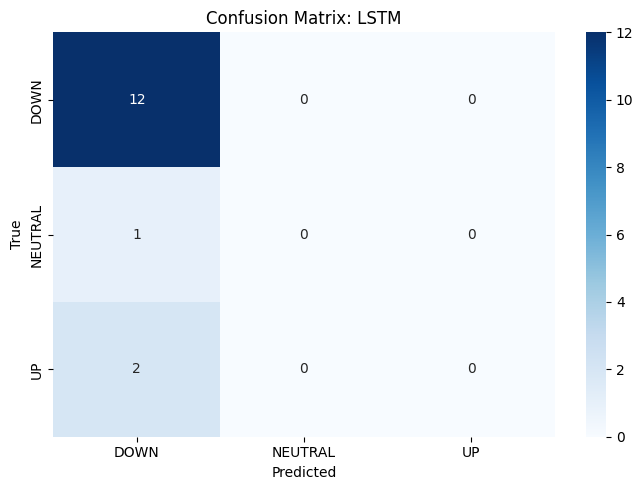

[HINDUNILVR] Results DataFrame shape: (15, 27)
[HINDUNILVR] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/HINDUNILVR_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/HINDUNILVR_results.xlsx
[HINDUNILVR] 💾 Saved results to /content/output/HINDUNILVR_results.xlsx
[HINDPETRO] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for HINDUNILVR
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[HINDPETRO] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[HINDPETRO] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3482 - val_accuracy: 1.0000 - val_loss: 0.8254 - learning_rate: 0.0010
Epoch 15/50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.8182 - loss: 0.5854
Epoch 15: val_loss improved from 0.82541 to 0.81782, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.5854 - val_accuracy: 1.0000 - val_loss: 0.8178 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9091 - loss: 0.5629
Epoch 16: val_loss did not improve from 0.81782
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.5629 - val_accuracy: 1.0000 - val_loss: 0.8182 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.5454
Epoch 17: val_loss did not improve from 0.81782
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5454 - val_accuracy: 1.0000 - val_loss: 0.8181 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.8182 - loss: 0.5742
Epoch 1: val_loss improved from inf to 1.11149, saving model to /content/checkpoints/LUPIN/LUPIN_lstm_model.h5



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 18: val_loss did not improve from 0.81782

Epoch 1: val_loss improved from inf to 1.01293, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.06281, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5742 - val_accuracy: 1.0000 - val_loss: 0.8202 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.3636 - loss: 1.2337 - val_accuracy: 0.0000e+00 - val_loss: 1.1115 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.5455 - loss: 1.2099 - val_accuracy: 1.0000 - val_loss: 1.0129 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6364 - loss: 0.8110
Epoch 19: val_loss did not improve from 0.81782

Epoch 2: val_loss did not improve from 1.11149
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.2727 - loss: 1.3108 - val_accuracy: 0.0000e+00 - val_loss: 1.0628 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5455 - loss: 1.1391
Epoch 2: val_loss improved from 1.06281 to 1.03510, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step - accuracy: 0.6364 - loss: 0.8110 - val_accuracy: 0.0000e+00 - val_loss: 1.1163 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step - accuracy: 0.7273 - loss: 0.6151 - val_accuracy: 1.0000 - val_loss: 0.8189 - learning_rate: 5.0000e-04
Epoch 3/50
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.3636 - loss: 1.1861
Epoch 3: val_loss improved from 1.11149 to 1.10541, saving model to /content/checkpoints/LUPIN/LUPIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step - accuracy: 0.5455 - loss: 1.1391 - val_accuracy: 1.0000 - val_loss: 1.0351 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 1.0000 - loss: 0.3596
Epoch 20: val_loss improved from 0.81782 to 0.81537, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step - accuracy: 0.3636 - loss: 1.1861 - val_accuracy: 0.0000e+00 - val_loss: 1.1054 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step - accuracy: 1.0000 - loss: 0.3596 - val_accuracy: 1.0000 - val_loss: 0.8154 - learning_rate: 5.0000e-04
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6364 - loss: 0.5086
Epoch 21: val_loss improved from 0.81537 to 0.81054, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.8182 - loss: 0.6851
Epoch 3: val_loss improved from 1.03510 to 0.99301, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.4545 - loss: 0.8775
Epoch 4: val_loss improved from 1.10541 to 1.10123, saving model to /content/checkpoints/LUPIN/LUPIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step - accuracy: 0.6364 - loss: 0.5086 - val_accuracy: 1.0000 - val_loss: 0.8105 - learning_rate: 5.0000e-04
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6364 - loss: 0.9273
Epoch 22: val_loss improved from 0.81054 to 0.80295, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6851 - val_accuracy: 1.0000 - val_loss: 0.9930 - learning_rate: 0.0010
Epoch 4/50

Epoch 2: val_loss improved from 1.01293 to 1.01149, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8182 - loss: 0.5776
Epoch 4: val_loss improved from 0.99301 to 0.96753, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 0.8775 - val_accuracy: 0.0000e+00 - val_loss: 1.1012 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3698 - val_accuracy: 1.0000 - val_loss: 0.8030 - learning_rate: 5.0000e-04

Epoch 5: val_loss improved from 1.10123 to 1.09483, saving model to /content/checkpoints/LUPIN/LUPIN_lstm_model.h5


Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6364 - loss: 0.9273 - val_accuracy: 1.0000 - val_loss: 1.0115 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5455 - loss: 1.0786
Epoch 23: val_loss improved from 0.80295 to 0.79523, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5776 - val_accuracy: 1.0000 - val_loss: 0.9675 - learning_rate: 0.0010
Epoch 5/50

Epoch 3: val_loss did not improve from 1.01149
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6364 - loss: 0.5989
Epoch 5: val_loss improved from 0.96753 to 0.94073, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.9416 - val_accuracy: 0.0000e+00 - val_loss: 1.0948 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5455 - loss: 0.8765
Epoch 6: val_loss did not improve from 1.09483
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3347 - val_accuracy: 1.0000 - val_loss: 0.7952 - learning_rate: 5.0000e-04
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.0786 - val_accuracy: 1.0000 - val_loss: 1.0144 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.5989 - val_accuracy: 1.0000 - val_loss: 0.9407 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step - accuracy: 0.5455 - loss: 0.8765 - val_accuracy: 0.0000e+00 - val_loss: 1.0954 - learning_rate: 0.0010
Epoch 7/50

Epoch 4: val_loss improved from 1.01149 to 1.00479, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9091 - loss: 0.4503
Epoch 6: val_loss improved from 0.94073 to 0.91492, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step - accuracy: 0.5455 - loss: 0.7878 - val_accuracy: 1.0000 - val_loss: 1.0048 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step - accuracy: 0.9091 - loss: 0.4503 - val_accuracy: 1.0000 - val_loss: 0.9149 - learning_rate: 0.0010
Epoch 7/50

Epoch 7: val_loss did not improve from 1.09483
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7273 - loss: 0.6643
Epoch 7: val_loss improved from 0.91492 to 0.89526, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.7343 - val_accuracy: 0.0000e+00 - val_loss: 1.0969 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7273 - loss: 0.8275
Epoch 24: val_loss improved from 0.79523 to 0.78846, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: val_loss did not improve from 1.09483

Epoch 5: val_loss improved from 1.00479 to 0.99460, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6643 - val_accuracy: 1.0000 - val_loss: 0.8953 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.8275 - val_accuracy: 0.0000e+00 - val_loss: 1.0967 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4980 - val_accuracy: 1.0000 - val_loss: 0.7885 - learning_rate: 5.0000e-04
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6364 - loss: 0.7936
Epoch 8: val_loss improved from 0.89526 to 0.87801, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.8869 - val_accuracy: 1.0000 - val_loss: 0.9946 - learning_rate: 0.0010
Epoch 6/50

Epoch 9: val_loss did not improve from 1.09483
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7273 - loss: 0.9006
Epoch 6: val_loss did not improve from 0.99460
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step - accuracy: 0.6364 - loss: 0.7936 - val_accuracy: 0.0000e+00 - val_loss: 1.0990 - learning_rate: 5.0000e-04
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6653 - val_accuracy: 1.0000 - val_loss: 0.8780 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.9006 - val_accuracy: 1.0000 - val_loss: 0.9947 - learning_rate: 0.0010
Epoch 7/50

Epoch 10: val_loss did not improve from 1.09483
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3702
Epoch 9: val_loss improved from 0.87801 to 0.86480, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm


Epoch 7: val_loss improved from 0.99460 to 0.98647, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5



Epoch 25: val_loss improved from 0.78846 to 0.78232, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5378 - val_accuracy: 0.0000e+00 - val_loss: 1.1003 - learning_rate: 5.0000e-04
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.
[LUPIN] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[LUPIN] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[LUPIN] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 2 0 2 0 0 2 0 0 2 0 2 0 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4427 - val_accuracy: 1.0000 - val_loss: 0.8648 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.3702 - val_accuracy: 1.0000 - val_loss: 0.7823 - learning_rate: 5.0000e-04
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.8069 - v

[LUPIN] ✅ Loaded best model from /content/checkpoints/LUPIN/LUPIN_lstm_model.h5
[LUPIN] Predicting for 15 dates, including 30-07-2025

Epoch 10: val_loss improved from 0.86480 to 0.85079, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


[LUPIN] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4268 - val_accuracy: 1.0000 - val_loss: 0.8508 - learning_rate: 0.0010
Epoch 11/50

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.53      1.00      0.70         8
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         6

    accuracy                           0.53        15
   macro avg       0.18      0.33      0.23        15
weighted avg       0.28      0.53      0.37        15



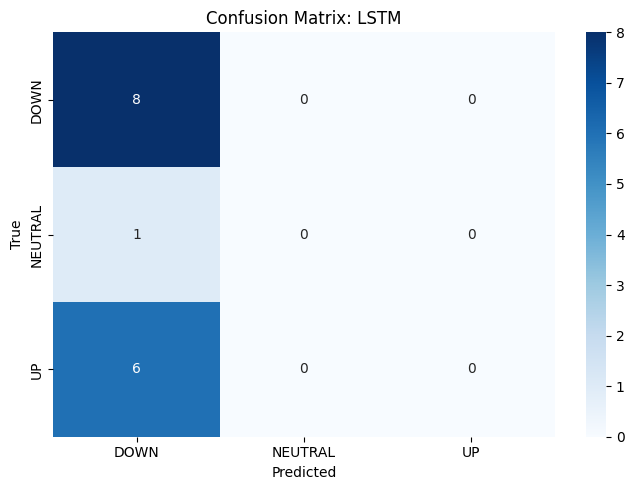

[LUPIN] Results DataFrame shape: (15, 27)
[LUPIN] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/LUPIN_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/LUPIN_results.xlsx
[LUPIN] 💾 Saved results to /content/output/LUPIN_results.xlsx
✅ Completed processing for LUPIN
[M&M] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[M&M] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[M&M] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.7769Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 11: val_loss improved from 0.85079 to 0.84038, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5



✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"


Epoch 8: val_loss improved from 0.98647 to 0.98180, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5

Epoch 26: val_loss improved from 0.78232 to 0.77822, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4404 - val_accuracy: 1.0000 - val_loss: 0.8404 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7273 - loss: 0.7769 - val_accuracy: 1.0000 - val_loss: 0.9818 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8182 - loss: 0.6124 - val_accuracy: 1.0000 - val_loss: 0.7782 - learning_rate: 5.0000e-04
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8182 - loss: 0.5826
Epoch 9: val_loss improved from 0.98180 to 0.97166, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5826 - val_accuracy: 1.0000 - val_loss: 0.9717 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8182 - loss: 0.2771
Epoch 27: val_loss improved from 0.77822 to 0.77632, saving model to /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5



Epoch 12: val_loss improved from 0.84038 to 0.82782, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - accuracy: 0.7273 - loss: 0.5724
Epoch 10: val_loss improved from 0.97166 to 0.95953, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.4120 - val_accuracy: 1.0000 - val_loss: 0.7763 - learning_rate: 5.0000e-04
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8182 - loss: 0.2771 - val_accuracy: 1.0000 - val_loss: 0.8278 - learning_rate: 0.0010
Epoch 13/50

Epoch 28: val_loss did not improve from 0.77632
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5724 - val_accuracy: 1.0000 - val_loss: 0.9595 - learning_rate: 0.0010
Epoch 11/50

Epoch 1: val_loss improved from inf to 1.12067, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step - accuracy: 0.9091 - loss: 0.2928 - val_accuracy: 1.0000 - val_loss: 0.7767 - learning_rate: 5.0000e-04
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9091 - loss: 0.3053
Epoch 29: val_loss did not improve from 0.77632
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.0909 - loss: 2.5154 - val_accuracy: 0.0000e+00 - val_loss: 1.1207 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step - accuracy: 0.9091 - loss: 0.3053 - val_accuracy: 1.0000 - val_loss: 0.7794 - learning_rate: 5.0000e-04
Epoch 30/50

Epoch 2: val_loss did not improve from 1.12067
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9091 - loss: 0.3556
Epoch 13: val_loss improved from 0.82782 to 0.81334, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5



Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 30: val_loss did not improve from 0.77632
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.5952
Epoch 11: val_loss improved from 0.95953 to 0.94182, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step - accuracy: 0.2727 - loss: 2.1366 - val_accuracy: 0.0000e+00 - val_loss: 1.1236 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.2727 - loss: 1.7886
Epoch 3: val_loss improved from 1.12067 to 1.09551, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3556 - val_accuracy: 1.0000 - val_loss: 0.7835 - learning_rate: 5.0000e-04
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2219 - val_accuracy: 1.0000 - val_loss: 0.8133 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9091 - loss: 0.3525Epoch 14/50

Epoch 31: val_loss did not improve from 0.77632
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5952 - val_accuracy: 1.0000 - val_loss: 0.9418 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7273 - loss: 0.6728
Epoch 12: val_loss improved from 0.94182 to 0.92647, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.7886 - val_accuracy: 0.0000e+00 - val_loss: 1.0955 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step - accuracy: 0.9091 - loss: 0.3525 - val_accuracy: 1.0000 - val_loss: 0.7840 - learning_rate: 2.5000e-04
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8182 - loss: 0.4638
Epoch 4: val_loss improved from 1.09551 to 1.06439, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5

Epoch 32: val_loss did not improve from 0.77632


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6728 - val_accuracy: 1.0000 - val_loss: 0.9265 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8182 - loss: 0.6736
Epoch 14: val_loss improved from 0.81334 to 0.79781, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4638 - val_accuracy: 1.0000 - val_loss: 0.7834 - learning_rate: 2.5000e-04
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 27.
[ICICIBANK] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

Epoch 13: val_loss improved from 0.92647 to 0.91392, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.5854 - val_accuracy: 0.0000e+00 - val_loss: 1.0644 - learning_rate: 0.0010


Epoch 5/50
[ICICIBANK] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[ICICIBANK] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 2 0 0 2 0 0 2 0 0 0 2 1]


[ICICIBANK] ✅ Loaded best model from /content/checkpoints/ICICIBANK/ICICIBANK_lstm_model.h5
[ICICIBANK] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.3250 - val_accuracy: 1.0000 - val_loss: 0.7978 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6736 - val_accuracy: 1.0000 - val_loss: 0.9139 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7273 - loss: 0.7443[ICICIBANK] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 14: val_loss improved from 0.91392 to 0.90367, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5455 - loss: 1.2618
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.67      1.00      0.80        10
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         4

    accuracy                           0.67        15
   macro avg       0.22      0.33      0.27        15
weighted avg       0.44      0.67      0.53        15


Epoch 5: val_loss improved from 1.06439 to 1.02950, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2052
Epoch 15: val_loss improved from 0.79781 to 0.78336, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7443 - val_accuracy: 1.0000 - val_loss: 0.9037 - learning_rate: 0.0010
Epoch 15/50


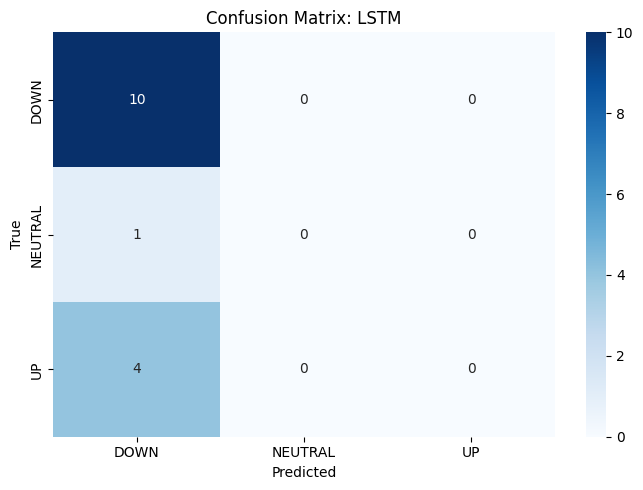

[ICICIBANK] Results DataFrame shape: (15, 27)
[ICICIBANK] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/ICICIBANK_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/ICICIBANK_results.xlsx
[ICICIBANK] 💾 Saved results to /content/output/ICICIBANK_results.xlsx
✅ Completed processing for ICICIBANK
[SIEMENS] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5455 - loss: 1.2618 - val_accuracy: 0.0000e+00 - val_loss: 1.0295 - learning_rate: 0.0010
Epoch 6/50
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[SIEMENS] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[SIEMENS] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2052 - val_accuracy: 1.0000 - val_loss: 0.7834 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9091 - loss: 0.3010
Epoch 16: val_loss improved from 0.78336 to 0.77251, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.6827
Epoch 15: val_loss improved from 0.90367 to 0.89320, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1818 - loss: 1.3386
Epoch 6: val_loss improved from 1.02950 to 1.00717, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3010 - val_accuracy: 1.0000 - val_loss: 0.7725 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.6827 - val_accuracy: 1.0000 - val_loss: 0.8932 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1818 - loss: 1.3386 - val_accuracy: 0.0000e+00 - val_loss: 1.0072 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.4545 - loss: 1.0862
Epoch 7: val_loss improved from 1.00717 to 0.98638, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.2973
Epoch 17: val_loss improved from 0.77251 to 0.76036, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4729
Epoch 16: val_loss improved from 0.89320 to 0.88179, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.0862 - val_accuracy: 0.0000e+00 - val_loss: 0.9864 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2727 - loss: 0.9712
Epoch 8: val_loss improved from 0.98638 to 0.96564, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.2973 - val_accuracy: 1.0000 - val_loss: 0.7604 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8182 - loss: 0.3670
Epoch 18: val_loss improved from 0.76036 to 0.75151, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4729 - val_accuracy: 1.0000 - val_loss: 0.8818 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8182 - loss: 0.4273
Epoch 17: val_loss improved from 0.88179 to 0.86947, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2727 - loss: 0.9712 - val_accuracy: 0.0000e+00 - val_loss: 0.9656 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3670 - val_accuracy: 1.0000 - val_loss: 0.7515 - learning_rate: 0.0010
Epoch 19/50

Epoch 9: val_loss improved from 0.96564 to 0.95095, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4273 - val_accuracy: 1.0000 - val_loss: 0.8695 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7273 - loss: 0.5633
Epoch 18: val_loss improved from 0.86947 to 0.85829, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step - accuracy: 0.4545 - loss: 1.0370 - val_accuracy: 1.0000 - val_loss: 0.9509 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.4545 - loss: 0.9459
Epoch 10: val_loss improved from 0.95095 to 0.93454, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2474
Epoch 19: val_loss improved from 0.75151 to 0.74371, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5633 - val_accuracy: 1.0000 - val_loss: 0.8583 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6364 - loss: 0.6052
Epoch 19: val_loss improved from 0.85829 to 0.84850, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.28928, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 0.9459 - val_accuracy: 1.0000 - val_loss: 0.9345 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2474 - val_accuracy: 1.0000 - val_loss: 0.7437 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.6052 - val_accuracy: 1.0000 - val_loss: 0.8485 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.4545 - loss: 1.4947 - val_accuracy: 0.0000e+00 - val_loss: 1.2893 - learning_rate: 0.0010
Epoch 2/50

Epoch 20: val_loss improved from 0.74371 to 0.73730, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8182 - loss: 0.5221
Epoch 20: val_loss improved from 0.84850 to 0.83998, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step - accuracy: 0.9091 - loss: 0.2205 - val_accuracy: 1.0000 - val_loss: 0.7373 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9091 - loss: 0.2115
Epoch 21: val_loss improved from 0.73730 to 0.73122, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.8292
Epoch 2: val_loss improved from 1.28928 to 1.24949, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step - accuracy: 0.8182 - loss: 0.5221 - val_accuracy: 1.0000 - val_loss: 0.8400 - learning_rate: 0.0010
Epoch 21/50

Epoch 11: val_loss improved from 0.93454 to 0.91967, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8182 - loss: 0.5134
Epoch 21: val_loss improved from 0.83998 to 0.83392, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2115 - val_accuracy: 1.0000 - val_loss: 0.7312 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.0919 - val_accuracy: 0.0000e+00 - val_loss: 1.2495 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.8292 - val_accuracy: 1.0000 - val_loss: 0.9197 - learning_rate: 0.0010
Epoch 12/50

Epoch 22: val_loss improved from 0.73122 to 0.72582, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5134 - val_accuracy: 1.0000 - val_loss: 0.8339 - learning_rate: 0.0010
Epoch 22/50

Epoch 12: val_loss improved from 0.91967 to 0.90588, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6364 - loss: 0.4904
Epoch 22: val_loss improved from 0.83392 to 0.83012, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2385 - val_accuracy: 1.0000 - val_loss: 0.7258 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.7545 - val_accuracy: 1.0000 - val_loss: 0.9059 - learning_rate: 0.0010
Epoch 13/50

Epoch 23: val_loss improved from 0.72582 to 0.71999, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5



Epoch 3: val_loss improved from 1.24949 to 1.21620, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.4904 - val_accuracy: 1.0000 - val_loss: 0.8301 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.1018 - val_accuracy: 0.0000e+00 - val_loss: 1.2162 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2226 - val_accuracy: 1.0000 - val_loss: 0.7200 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9091 - loss: 0.1820
Epoch 24: val_loss improved from 0.71999 to 0.71584, saving model to /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.8235
Epoch 4: val_loss improved from 1.21620 to 1.19772, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5



Epoch 13: val_loss improved from 0.90588 to 0.89125, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step - accuracy: 0.9091 - loss: 0.1820 - val_accuracy: 1.0000 - val_loss: 0.7158 - learning_rate: 0.0010
Epoch 25/50

Epoch 23: val_loss improved from 0.83012 to 0.82655, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6356 - val_accuracy: 0.0000e+00 - val_loss: 1.1977 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.8235 - val_accuracy: 1.0000 - val_loss: 0.8912 - learning_rate: 0.0010
Epoch 14/50

Epoch 25: val_loss did not improve from 0.71584
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.4880 - val_accuracy: 1.0000 - val_loss: 0.8265 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.7273 - loss: 0.7033
Epoch 5: val_loss improved from 1.19772 to 1.17962, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.8182 - loss: 0.4206
Epoch 14: val_loss improved from 0.89125 to 0.87592, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2413 - val_accuracy: 1.0000 - val_loss: 0.7185 - learning_rate: 0.0010
Epoch 26/50

Epoch 24: val_loss improved from 0.82655 to 0.82299, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.4198 - val_accuracy: 0.0000e+00 - val_loss: 1.1796 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7033 - val_accuracy: 1.0000 - val_loss: 0.8759 - learning_rate: 0.0010
Epoch 15/50

Epoch 26: val_loss did not improve from 0.71584
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8182 - loss: 0.5462
Epoch 6: val_loss improved from 1.17962 to 1.16630, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4206 - val_accuracy: 1.0000 - val_loss: 0.8230 - learning_rate: 0.0010

Epoch 15: val_loss improved from 0.87592 to 0.86136, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5
Epoch 25/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2269 - val_accuracy: 1.0000 - val_loss: 0.7195 - learning_rate: 0.0010
Epoch 27/50

Epoch 25: val_loss improved from 0.82299 to 0.82251, saving model to /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9091 - loss: 0.1980
Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 27: val_loss did not improve from 0.71584
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5462 - val_accuracy: 0.0000e+00 - val_loss: 1.1663 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.6433 - val_accuracy: 1.0000 - val_loss: 0.8614 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step - accuracy: 0.9091 - loss: 0.1980 - val_accuracy: 1.0000 - val_loss: 0.7221 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3721 - val_accuracy: 1.0000 - val_loss: 0.8225 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6364 - loss: 0.4644
Epoch 28: val_loss did not improve from 0.71584

Epoch 26: val_loss did not improve from 0.82251
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/


Epoch 16: val_loss improved from 0.86136 to 0.84570, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step - accuracy: 0.8182 - loss: 0.1912 - val_accuracy: 1.0000 - val_loss: 0.7271 - learning_rate: 5.0000e-04
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 24.
[HINDPETRO] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step - accuracy: 0.8182 - loss: 0.4772 - val_accuracy: 1.0000 - val_loss: 0.8266 - learning_rate: 0.0010
Epoch 28/50
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[HINDPETRO] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[HINDPETRO] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 2 2 2 2 2 2 2 0 2 0 2 2 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8182 - loss: 0.3975


Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 28: val_loss did not improve from 0.82251
[HINDPETRO] ✅ Loaded best model from /content/checkpoints/HINDPETRO/HINDPETRO_lstm_model.h5
[HINDPETRO] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.5558 - val_accuracy: 1.0000 - val_loss: 0.8457 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4289 - val_accuracy: 0.0000e+00 - val_loss: 1.1504 - learning_rate: 0.0010
Epoch 17/50
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3975 - val_accuracy: 1.0000 - val_loss: 0.8261 - learning_rate: 0.0010
Epoch 29/50

Epoch 8: val_loss improved from 1.15045 to 1.14156, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9091 - loss: 0.3649[HINDPETRO] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 29: val_loss did not improve from 0.82251

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         3
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.73      1.00      0.85        11

    accuracy                           0.73        15
   macro avg       0.24      0.33      0.28        15
weighted avg       0.54      0.73      0.62        15



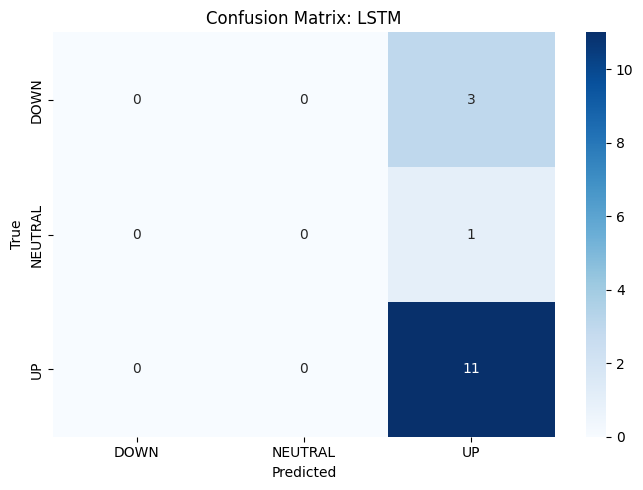

[HINDPETRO] Results DataFrame shape: (15, 27)
[HINDPETRO] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/HINDPETRO_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/HINDPETRO_results.xlsx
[HINDPETRO] 💾 Saved results to /content/output/HINDPETRO_results.xlsx
[POWERGRID] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for HINDPETRO
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[POWERGRID] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[POWERGRID] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5539 - val_accuracy: 0.0000e+00 - val_loss: 1.1416 - learning_rate: 0.0010
Epoch 9/50

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3649 - val_accuracy: 1.0000 - val_loss: 0.8254 - learning_rate: 5.0000e-04
Epoch 30/50


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9091 - loss: 0.2715
Epoch 17: val_loss improved from 0.84570 to 0.82995, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.7273 - loss: 0.5764
Epoch 9: val_loss improved from 1.14156 to 1.13463, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5



Epoch 30: val_loss did not improve from 0.82251
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.4395 - val_accuracy: 1.0000 - val_loss: 0.8299 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2715 - val_accuracy: 0.0000e+00 - val_loss: 1.1346 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5764 - val_accuracy: 1.0000 - val_loss: 0.8289 - learning_rate: 5.0000e-04
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 25.
[TATAPOWER] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

Epoch 18: val_loss improved from 0.82995 to 0.81420, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[TATAPOWER] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[TATAPOWER] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 0 2 0 2 2 2 2 0 2 2 2 0 1]

Epoch 10: val_loss improved from 1.13463 to 1.12555, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


[TATAPOWER] ✅ Loaded best model from /content/checkpoints/TATAPOWER/TATAPOWER_lstm_model.h5
[TATAPOWER] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5514 - val_accuracy: 1.0000 - val_loss: 0.8142 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2572 - val_accuracy: 0.0000e+00 - val_loss: 1.1255 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9091 - loss: 0.2018[TATAPOWER] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 11: val_loss improved from 1.12555 to 1.11604, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         4
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.67      1.00      0.80        10

    accuracy                           0.67        15
   macro avg       0.22      0.33      0.27        15
weighted avg       0.44      0.67      0.53        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4430
Epoch 19: val_loss improved from 0.81420 to 0.79592, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2018 - val_accuracy: 0.0000e+00 - val_loss: 1.1160 - learning_rate: 0.0010
Epoch 12/50


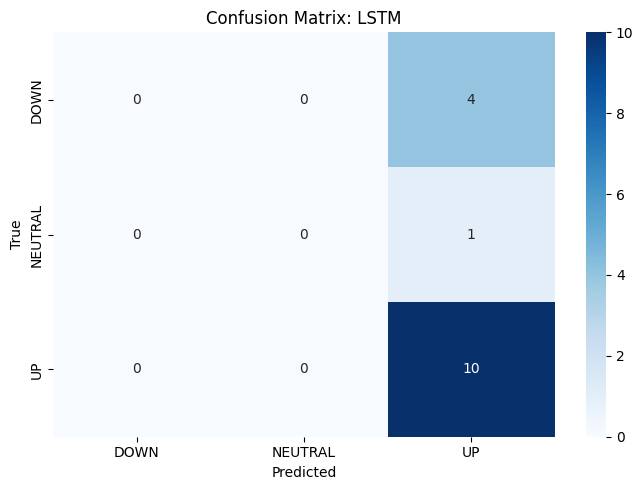

[TATAPOWER] Results DataFrame shape: (15, 27)
[TATAPOWER] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/TATAPOWER_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/TATAPOWER_results.xlsx
[TATAPOWER] 💾 Saved results to /content/output/TATAPOWER_results.xlsx
[PNB] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for TATAPOWER
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[PNB] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[PNB] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4430 - val_accuracy: 1.0000 - val_loss: 0.7959 - learning_rate: 0.0010
Epoch 20/50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2877
Epoch 12: val_loss improved from 1.11604 to 1.10418, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3568
Epoch 20: val_loss improved from 0.79592 to 0.77736, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2877 - val_accuracy: 0.0000e+00 - val_loss: 1.1042 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3568 - val_accuracy: 1.0000 - val_loss: 0.7774 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.9091 - loss: 0.3454
Epoch 13: val_loss improved from 1.10418 to 1.09556, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3764
Epoch 21: val_loss improved from 0.77736 to 0.76023, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5



Epoch 1: val_loss improved from inf to 0.82892, saving model to /content/checkpoints/POWERGRID/POWERGRID_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3454 - val_accuracy: 0.0000e+00 - val_loss: 1.0956 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9091 - loss: 0.2203
Epoch 14: val_loss improved from 1.09556 to 1.08723, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3764 - val_accuracy: 1.0000 - val_loss: 0.7602 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.6364 - loss: 1.1159 - val_accuracy: 1.0000 - val_loss: 0.8289 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6364 - loss: 0.7357
Epoch 2: val_loss improved from 0.82892 to 0.81949, saving model to /content/checkpoints/POWERGRID/POWERGRID_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2203 - val_accuracy: 0.0000e+00 - val_loss: 1.0872 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step - accuracy: 0.6364 - loss: 0.7357 - val_accuracy: 1.0000 - val_loss: 0.8195 - learning_rate: 0.0010
Epoch 3/50

Epoch 22: val_loss improved from 0.76023 to 0.74348, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6364 - loss: 0.9629
Epoch 3: val_loss improved from 0.81949 to 0.80710, saving model to /content/checkpoints/POWERGRID/POWERGRID_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2782 - val_accuracy: 1.0000 - val_loss: 0.7435 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1637
Epoch 15: val_loss improved from 1.08723 to 1.07849, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.9629 - val_accuracy: 1.0000 - val_loss: 0.8071 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8182 - loss: 0.3999
Epoch 23: val_loss improved from 0.74348 to 0.72465, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5



Epoch 4: val_loss improved from 0.80710 to 0.79658, saving model to /content/checkpoints/POWERGRID/POWERGRID_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.13620, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1637 - val_accuracy: 1.0000 - val_loss: 1.0785 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2488 - val_accuracy: 1.0000 - val_loss: 0.7247 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3999 - val_accuracy: 1.0000 - val_loss: 0.7966 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.1818 - loss: 1.7338 - val_accuracy: 0.0000e+00 - val_loss: 1.1362 - learning_rate: 0.0010
Epoch 2/50

Epoch 24: val_loss improved from 0.72465 to 0.70684, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6364 - loss: 0.6996
Epoch 5: val_loss improved from 0.79658 to 0.79212, saving model to /content/checkpoints/POWERGRID/POWERGRID_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step - accuracy: 1.0000 - loss: 0.2391 - val_accuracy: 1.0000 - val_loss: 0.7068 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step - accuracy: 0.6364 - loss: 0.6996 - val_accuracy: 1.0000 - val_loss: 0.7921 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2078
Epoch 2: val_loss did not improve from 1.13620

Epoch 25: val_loss improved from 0.70684 to 0.69006, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5



Epoch 16: val_loss improved from 1.07849 to 1.06831, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2727 - loss: 1.1752 - val_accuracy: 0.0000e+00 - val_loss: 1.1403 - learning_rate: 0.0010
Epoch 3/50

Epoch 6: val_loss improved from 0.79212 to 0.77955, saving model to /content/checkpoints/POWERGRID/POWERGRID_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2078 - val_accuracy: 1.0000 - val_loss: 1.0683 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2064 - val_accuracy: 1.0000 - val_loss: 0.6901 - learning_rate: 0.0010
Epoch 26/50
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 1.0000 - loss: 0.1442
Epoch 3: val_loss improved from 1.13620 to 1.12440, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5



Epoch 17: val_loss improved from 1.06831 to 1.05823, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.4170 - val_accuracy: 1.0000 - val_loss: 0.7796 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.4423 - val_accuracy: 0.0000e+00 - val_loss: 1.1244 - learning_rate: 0.0010
Epoch 4/50

Epoch 7: val_loss improved from 0.77955 to 0.77822, saving model to /content/checkpoints/POWERGRID/POWERGRID_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1442 - val_accuracy: 1.0000 - val_loss: 1.0582 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3177
Epoch 4: val_loss improved from 1.12440 to 1.09978, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5



Epoch 18: val_loss improved from 1.05823 to 1.04890, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5

Epoch 26: val_loss improved from 0.69006 to 0.67141, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5601 - val_accuracy: 1.0000 - val_loss: 0.7782 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.3177 - val_accuracy: 1.0000 - val_loss: 0.6714 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1317 - val_accuracy: 1.0000 - val_loss: 1.0489 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.0027 - val_accuracy: 0.0000e+00 - val_loss: 1.0998 - learning_rate: 0.0010
Epoch 5/50
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8182 - loss: 0.5811
Epoch 27: val_loss improved from 0.67141 to 0.65382, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5



Epoch 5: val_loss improved from 1.09978 to 1.07273, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step - accuracy: 1.0000 - loss: 0.2336 - val_accuracy: 1.0000 - val_loss: 0.6538 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step - accuracy: 0.8182 - loss: 0.5811 - val_accuracy: 0.0000e+00 - val_loss: 1.0727 - learning_rate: 0.0010
Epoch 6/50

Epoch 8: val_loss did not improve from 0.77822
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7273 - loss: 0.5749
Epoch 6: val_loss improved from 1.07273 to 1.05081, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6504 - val_accuracy: 1.0000 - val_loss: 0.7811 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.9091 - loss: 0.2206
Epoch 19: val_loss improved from 1.04890 to 1.03951, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5



Epoch 9: val_loss did not improve from 0.77822

Epoch 28: val_loss improved from 0.65382 to 0.63842, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5749 - val_accuracy: 0.0000e+00 - val_loss: 1.0508 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 0.5263
Epoch 7: val_loss improved from 1.05081 to 1.04056, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.5010 - val_accuracy: 1.0000 - val_loss: 0.7860 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1244 - val_accuracy: 1.0000 - val_loss: 1.0395 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 0.1294
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: val_loss did not improve from 0.77822
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2206 - val_accuracy: 1.0000 - val_loss: 0.6384 - learning_rate: 0.0010
Epoch 29/50

Epoch 20: val_loss improved from 1.03951 to 1.03260, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 1.0000 - loss: 0.1727
Epoch 29: val_loss improved from 0.63842 to 0.62386, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.5263 - val_accuracy: 0.0000e+00 - val_loss: 1.0406 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.4716 - val_accuracy: 1.0000 - val_loss: 0.7958 - learning_rate: 0.0010
Epoch 11/50

Epoch 8: val_loss improved from 1.04056 to 1.02780, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1294 - val_accuracy: 1.0000 - val_loss: 1.0326 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 1.0000 - loss: 0.0901
Epoch 11: val_loss did not improve from 0.77822

Epoch 21: val_loss improved from 1.03260 to 1.02567, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1727 - val_accuracy: 1.0000 - val_loss: 0.6239 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 0.2043
Epoch 30: val_loss improved from 0.62386 to 0.61063, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4676 - val_accuracy: 0.0000e+00 - val_loss: 1.0278 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4202 - val_accuracy: 1.0000 - val_loss: 0.7996 - learning_rate: 5.0000e-04
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8182 - loss: 0.4495
Epoch 9: val_loss improved from 1.02780 to 1.01884, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.7273 - loss: 0.4566

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0901 - val_accuracy: 1.0000 - val_loss: 1.0257 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9091 - loss: 0.1232
Epoch 12: val_loss did not improve from 0.77822

Epoch 22: val_loss improved from 1.02567 to 1.01895, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2043 - val_accuracy: 1.0000 - val_loss: 0.6106 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 0.1458
Epoch 31: val_loss improved from 0.61063 to 0.59816, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4495 - val_accuracy: 0.0000e+00 - val_loss: 1.0188 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4566 - val_accuracy: 1.0000 - val_loss: 0.8058 - learning_rate: 5.0000e-04
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
[POWERGRID] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[POWERGRID] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[POWERGRID] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 2 2 2 2 2 0 2 2 0 2 2 2 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1232 - val_accuracy: 1.0000 - val_loss: 1.0190 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9091 - loss: 

[POWERGRID] ✅ Loaded best model from /content/checkpoints/POWERGRID/POWERGRID_lstm_model.h5
[POWERGRID] Predicting for 15 dates, including 30-07-2025

Epoch 23: val_loss improved from 1.01895 to 1.01283, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1458 - val_accuracy: 1.0000 - val_loss: 0.5982 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 0.1041[POWERGRID] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 32: val_loss improved from 0.59816 to 0.58685, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         3
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.73      1.00      0.85        11

    accuracy                           0.73        15
   macro avg       0.24      0.33      0.28        15
weighted avg       0.54      0.73      0.62        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1323 - val_accuracy: 1.0000 - val_loss: 1.0128 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0501
Epoch 10: val_loss improved from 1.01884 to 1.01304, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5



Epoch 24: val_loss improved from 1.01283 to 1.00684, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


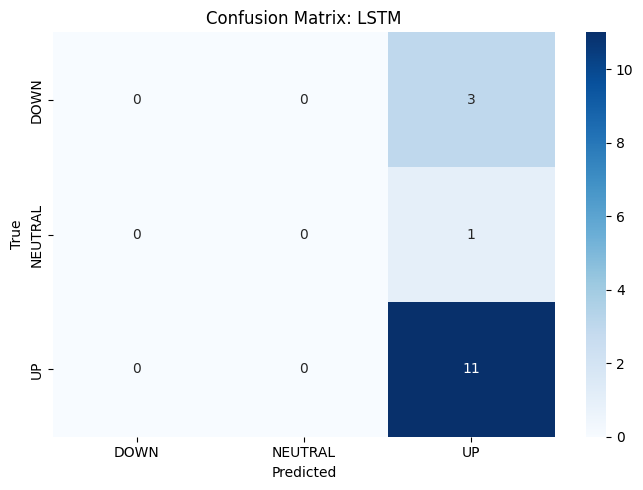

[POWERGRID] Results DataFrame shape: (15, 27)
[POWERGRID] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/POWERGRID_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/POWERGRID_results.xlsx
[POWERGRID] 💾 Saved results to /content/output/POWERGRID_results.xlsx
✅ Completed processing for POWERGRID
[PIDILITIND] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[PIDILITIND] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[PIDILITIND] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1041 - val_accuracy: 1.0000 - val_loss: 0.5868 - learning_rate: 0.0010
Epoch 33/50

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3269 - val_accuracy: 0.0000e+00 - val_loss: 1.0130 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0501 - val_accuracy: 1.0000 - val_loss: 1.0068 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1286
Epoch 33: val_loss improved from 0.58685 to 0.57607, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0681
Epoch 11: val_loss improved from 1.01304 to 1.00431, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5



Epoch 25: val_loss improved from 1.00684 to 1.00142, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1286 - val_accuracy: 1.0000 - val_loss: 0.5761 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3544 - val_accuracy: 0.0000e+00 - val_loss: 1.0043 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0681 - val_accuracy: 1.0000 - val_loss: 1.0014 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9091 - loss: 0.2976
Epoch 12: val_loss improved from 1.00431 to 0.98830, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 1.0000 - loss: 0.0319
Epoch 26: val_loss improved from 1.00142 to 0.99675, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2976 - val_accuracy: 1.0000 - val_loss: 0.9883 - learning_rate: 0.0010
Epoch 13/50

Epoch 34: val_loss improved from 0.57607 to 0.56647, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0319 - val_accuracy: 1.0000 - val_loss: 0.9968 - learning_rate: 0.0010
Epoch 27/50

Epoch 13: val_loss improved from 0.98830 to 0.97103, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1188 - val_accuracy: 1.0000 - val_loss: 0.5665 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3365 - val_accuracy: 1.0000 - val_loss: 0.9710 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.1773
Epoch 14: val_loss improved from 0.97103 to 0.95174, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0903
Epoch 27: val_loss improved from 0.99675 to 0.99408, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step - accuracy: 1.0000 - loss: 0.1773 - val_accuracy: 1.0000 - val_loss: 0.9517 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0903 - val_accuracy: 1.0000 - val_loss: 0.9941 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 0.0745
Epoch 35: val_loss improved from 0.56647 to 0.55775, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5



Epoch 15: val_loss improved from 0.95174 to 0.93040, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5



Epoch 28: val_loss improved from 0.99408 to 0.99245, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1015 - val_accuracy: 1.0000 - val_loss: 0.5578 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2950 - val_accuracy: 1.0000 - val_loss: 0.9304 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0745 - val_accuracy: 1.0000 - val_loss: 0.9924 - learning_rate: 0.0010
Epoch 29/50

Epoch 36: val_loss improved from 0.55775 to 0.54930, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.18668, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5



Epoch 16: val_loss improved from 0.93040 to 0.90717, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0981 - val_accuracy: 1.0000 - val_loss: 0.5493 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.0909 - loss: 2.0686 - val_accuracy: 0.0000e+00 - val_loss: 1.1867 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1900 - val_accuracy: 1.0000 - val_loss: 0.9072 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 0.1138
Epoch 2: val_loss did not improve from 1.18668
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0461
Epoch 37: val_loss improved from 0.54930 to 0.54107, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 1.0000 - loss: 0.1454
Epoch 17: val_loss improved from 0.90717 to 0.88396, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5

Epoch 29: val_loss improved from 0.99245 to 0.98981, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step - accuracy: 0.1818 - loss: 1.7948 - val_accuracy: 0.0000e+00 - val_loss: 1.1894 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1138 - val_accuracy: 1.0000 - val_loss: 0.5411 - learning_rate: 0.0010
Epoch 38/50

Epoch 3: val_loss improved from 1.18668 to 1.18440, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0461 - val_accuracy: 1.0000 - val_loss: 0.9898 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1454 - val_accuracy: 1.0000 - val_loss: 0.8840 - learning_rate: 0.0010
Epoch 30/50
Epoch 18/50

Epoch 38: val_loss improved from 0.54107 to 0.53391, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 0.0359
Epoch 30: val_loss improved from 0.98981 to 0.98697, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.2633 - val_accuracy: 0.0000e+00 - val_loss: 1.1844 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1032 - val_accuracy: 1.0000 - val_loss: 0.5339 - learning_rate: 0.0010
Epoch 39/50

Epoch 4: val_loss improved from 1.18440 to 1.16970, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 0.1177
Epoch 39: val_loss improved from 0.53391 to 0.52675, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0359 - val_accuracy: 1.0000 - val_loss: 0.9870 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1913
Epoch 18: val_loss improved from 0.88396 to 0.86155, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5



Epoch 31: val_loss improved from 0.98697 to 0.98304, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.4054 - val_accuracy: 0.0000e+00 - val_loss: 1.1697 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2727 - loss: 1.2508
Epoch 5: val_loss improved from 1.16970 to 1.15635, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1177 - val_accuracy: 1.0000 - val_loss: 0.5268 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.1139
Epoch 40: val_loss improved from 0.52675 to 0.51924, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0398 - val_accuracy: 1.0000 - val_loss: 0.9830 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1913 - val_accuracy: 1.0000 - val_loss: 0.8616 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.1346
Epoch 19: val_loss improved from 0.86155 to 0.83450, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.2508 - val_accuracy: 0.0000e+00 - val_loss: 1.1564 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1139 - val_accuracy: 1.0000 - val_loss: 0.5192 - learning_rate: 0.0010
Epoch 41/50

Epoch 6: val_loss improved from 1.15635 to 1.13692, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step - accuracy: 1.0000 - loss: 0.1346 - val_accuracy: 1.0000 - val_loss: 0.8345 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.1257
Epoch 41: val_loss improved from 0.51924 to 0.51341, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5



Epoch 20: val_loss improved from 0.83450 to 0.81122, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.9879 - val_accuracy: 0.0000e+00 - val_loss: 1.1369 - learning_rate: 0.0010
Epoch 7/50

Epoch 32: val_loss improved from 0.98304 to 0.97880, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.4545 - loss: 0.9012
Epoch 7: val_loss improved from 1.13692 to 1.11680, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1218 - val_accuracy: 1.0000 - val_loss: 0.5134 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1257 - val_accuracy: 1.0000 - val_loss: 0.8112 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0428 - val_accuracy: 1.0000 - val_loss: 0.9788 - learning_rate: 0.0010
Epoch 33/50

Epoch 42: val_loss improved from 0.51341 to 0.50725, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 0.9012 - val_accuracy: 0.0000e+00 - val_loss: 1.1168 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.2727 - loss: 1.1692
Epoch 33: val_loss improved from 0.97880 to 0.97472, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5



Epoch 8: val_loss improved from 1.11680 to 1.09216, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1540 - val_accuracy: 1.0000 - val_loss: 0.5073 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0279 - val_accuracy: 1.0000 - val_loss: 0.9747 - learning_rate: 0.0010
Epoch 34/50

Epoch 21: val_loss improved from 0.81122 to 0.78867, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.1692 - val_accuracy: 0.0000e+00 - val_loss: 1.0922 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6364 - loss: 0.9648
Epoch 34: val_loss improved from 0.97472 to 0.97018, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5



Epoch 9: val_loss improved from 1.09216 to 1.07067, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0741 - val_accuracy: 1.0000 - val_loss: 0.7887 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0236 - val_accuracy: 1.0000 - val_loss: 0.9702 - learning_rate: 0.0010
Epoch 35/50

Epoch 43: val_loss improved from 0.50725 to 0.50137, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5



Epoch 22: val_loss improved from 0.78867 to 0.76641, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.9648 - val_accuracy: 0.0000e+00 - val_loss: 1.0707 - learning_rate: 0.0010
Epoch 10/50

Epoch 35: val_loss improved from 0.97018 to 0.96443, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.5455 - loss: 0.9418
Epoch 10: val_loss improved from 1.07067 to 1.05292, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1327 - val_accuracy: 1.0000 - val_loss: 0.5014 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1381 - val_accuracy: 1.0000 - val_loss: 0.7664 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0459 - val_accuracy: 1.0000 - val_loss: 0.9644 - learning_rate: 0.0010
Epoch 36/50

Epoch 23: val_loss improved from 0.76641 to 0.74063, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.9418 - val_accuracy: 0.0000e+00 - val_loss: 1.0529 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step - accuracy: 1.0000 - loss: 0.0815 - val_accuracy: 1.0000 - val_loss: 0.7406 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0744
Epoch 44: val_loss improved from 0.50137 to 0.49583, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0744 - val_accuracy: 1.0000 - val_loss: 0.4958 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0269
Epoch 24: val_loss improved from 0.74063 to 0.71576, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5



Epoch 45: val_loss improved from 0.49583 to 0.48979, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5



Epoch 36: val_loss improved from 0.96443 to 0.95813, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4545 - loss: 1.0969
Epoch 11: val_loss improved from 1.05292 to 1.03778, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0726 - val_accuracy: 1.0000 - val_loss: 0.7158 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1031 - val_accuracy: 1.0000 - val_loss: 0.4898 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0269 - val_accuracy: 1.0000 - val_loss: 0.9581 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 0.0248
Epoch 46: val_loss improved from 0.48979 to 0.48422, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5



Epoch 25: val_loss improved from 0.71576 to 0.69210, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5



Epoch 37: val_loss improved from 0.95813 to 0.95028, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4545 - loss: 1.0969 - val_accuracy: 0.0000e+00 - val_loss: 1.0378 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0503 - val_accuracy: 1.0000 - val_loss: 0.4842 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0639 - val_accuracy: 1.0000 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0248 - val_accuracy: 1.0000 - val_loss: 0.9503 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 1.0000 - loss: 0.0885
Epoch 26: val_loss improved from 0.69210 to 0.66849, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 1.0000 - loss: 0.0285
Epoch 47: val_loss improved from 0.48422 to 0.47910, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5



Epoch 38: val_loss improved from 0.95028 to 0.94253, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.8083
Epoch 12: val_loss improved from 1.03778 to 1.02355, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0605 - val_accuracy: 1.0000 - val_loss: 0.6685 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0885 - val_accuracy: 1.0000 - val_loss: 0.4791 - learning_rate: 0.0010
Epoch 48/50

Epoch 27: val_loss improved from 0.66849 to 0.64552, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0285 - val_accuracy: 1.0000 - val_loss: 0.9425 - learning_rate: 0.0010

Epoch 48: val_loss improved from 0.47910 to 0.47343, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5


Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.8083 - val_accuracy: 1.0000 - val_loss: 1.0236 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0574 - val_accuracy: 1.0000 - val_loss: 0.6455 - learning_rate: 0.0010
Epoch 28/50

Epoch 13: val_loss improved from 1.02355 to 1.00886, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0409 - val_accuracy: 1.0000 - val_loss: 0.4734 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step - accuracy: 0.8182 - loss: 0.6523 - val_accuracy: 1.0000 - val_loss: 1.0089 - learning_rate: 0.0010
Epoch 14/50

Epoch 28: val_loss improved from 0.64552 to 0.62291, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0278
Epoch 14: val_loss improved from 1.00886 to 0.99609, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5



Epoch 49: val_loss improved from 0.47343 to 0.46732, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5



Epoch 39: val_loss improved from 0.94253 to 0.93365, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0415 - val_accuracy: 1.0000 - val_loss: 0.6229 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 1.0000 - loss: 0.0591
Epoch 29: val_loss improved from 0.62291 to 0.60059, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0866 - val_accuracy: 1.0000 - val_loss: 0.4673 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4682 - val_accuracy: 1.0000 - val_loss: 0.9961 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0278 - val_accuracy: 1.0000 - val_loss: 0.9337 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 0.0659
Epoch 15: val_loss improved from 0.99609 to 0.98684, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5



Epoch 50: val_loss improved from 0.46732 to 0.46160, saving model to /content/checkpoints/M&M/M&M_lstm_model.h5



Epoch 40: val_loss improved from 0.93365 to 0.91927, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0591 - val_accuracy: 1.0000 - val_loss: 0.6006 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7310 - val_accuracy: 1.0000 - val_loss: 0.9868 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0330 - val_accuracy: 1.0000 - val_loss: 0.4616 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
[M&M] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9091 - loss: 0.4802Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[M&M] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[M&M] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 2 0 0 0 0 0 0 0 0 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accur

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 1.0000 - loss: 0.0197[M&M] ✅ Loaded best model from /content/checkpoints/M&M/M&M_lstm_model.h5
[M&M] Predicting for 15 dates, including 30-07-2025

Epoch 41: val_loss improved from 0.91927 to 0.90355, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0519[M&M] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 30: val_loss improved from 0.60059 to 0.57843, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.87      1.00      0.93        13
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         1

    accuracy                           0.87        15
   macro avg       0.29      0.33      0.31        15
weighted avg       0.75      0.87      0.80        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4802 - val_accuracy: 1.0000 - val_loss: 0.9783 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0197 - val_accuracy: 1.0000 - val_loss: 0.9036 - learning_rate: 0.0010
Epoch 42/50

Epoch 17: val_loss improved from 0.97827 to 0.96944, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 1.0000 - loss: 0.0198

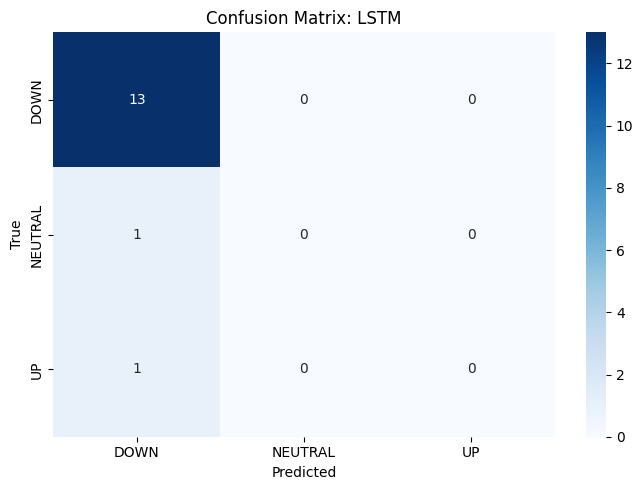


Epoch 42: val_loss improved from 0.90355 to 0.88833, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


[M&M] Results DataFrame shape: (15, 27)
[M&M] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0519 - val_accuracy: 1.0000 - val_loss: 0.5784 - learning_rate: 0.0010
Epoch 31/50
Excel report successfully generated: /content/output/M&M_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/M&M_results.xlsx
[M&M] 💾 Saved results to /content/output/M&M_results.xlsx
✅ Completed processing for M&M
[RECLTD] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[RECLTD] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[RECLTD] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4975 - val_accuracy: 1.0000 - val_loss: 0.9694 - learning_rate: 0.0010
Epoch 18/50

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0198 - val_accuracy: 1.0000 - val_loss: 0.8883 - learning_rate: 0.0010
Epoch 43/50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - accuracy: 1.0000 - loss: 0.0328
Epoch 43: val_loss improved from 0.88833 to 0.87319, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5



Epoch 31: val_loss improved from 0.57843 to 0.55804, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.5070
Epoch 18: val_loss improved from 0.96944 to 0.96110, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0258 - val_accuracy: 1.0000 - val_loss: 0.8732 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0328 - val_accuracy: 1.0000 - val_loss: 0.5580 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.0420
Epoch 32: val_loss improved from 0.55804 to 0.53977, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.5070 - val_accuracy: 1.0000 - val_loss: 0.9611 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0203
Epoch 44: val_loss improved from 0.87319 to 0.85773, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0420 - val_accuracy: 1.0000 - val_loss: 0.5398 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.5060
Epoch 19: val_loss improved from 0.96110 to 0.95406, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0203 - val_accuracy: 1.0000 - val_loss: 0.8577 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 0.0150
Epoch 45: val_loss improved from 0.85773 to 0.84353, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0354
Epoch 33: val_loss improved from 0.53977 to 0.52291, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.5060 - val_accuracy: 1.0000 - val_loss: 0.9541 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9091 - loss: 0.3977
Epoch 20: val_loss improved from 0.95406 to 0.94782, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0150 - val_accuracy: 1.0000 - val_loss: 0.8435 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 0.0200
Epoch 46: val_loss improved from 0.84353 to 0.82941, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0354 - val_accuracy: 1.0000 - val_loss: 0.5229 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3977 - val_accuracy: 1.0000 - val_loss: 0.9478 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.3939
Epoch 21: val_loss improved from 0.94782 to 0.94252, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step - accuracy: 1.0000 - loss: 0.0200 - val_accuracy: 1.0000 - val_loss: 0.8294 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.0294
Epoch 47: val_loss improved from 0.82941 to 0.81746, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0492
Epoch 34: val_loss improved from 0.52291 to 0.50753, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.3939 - val_accuracy: 1.0000 - val_loss: 0.9425 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 1.0000 - loss: 0.3126
Epoch 22: val_loss improved from 0.94252 to 0.93750, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0294 - val_accuracy: 1.0000 - val_loss: 0.8175 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0492 - val_accuracy: 1.0000 - val_loss: 0.5075 - learning_rate: 0.0010
Epoch 35/50

Epoch 1: val_loss improved from inf to 1.08182, saving model to /content/checkpoints/RECLTD/RECLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.3126 - val_accuracy: 1.0000 - val_loss: 0.9375 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9091 - loss: 0.3091
Epoch 35: val_loss improved from 0.50753 to 0.49332, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5



Epoch 23: val_loss improved from 0.93750 to 0.93308, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.1818 - loss: 1.2636 - val_accuracy: 1.0000 - val_loss: 1.0818 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5455 - loss: 0.8939
Epoch 2: val_loss did not improve from 1.08182
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0295 - val_accuracy: 1.0000 - val_loss: 0.4933 - learning_rate: 0.0010
Epoch 36/50

Epoch 48: val_loss improved from 0.81746 to 0.80665, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3091 - val_accuracy: 1.0000 - val_loss: 0.9331 - learning_rate: 0.0010
Epoch 24/50

Epoch 36: val_loss improved from 0.49332 to 0.48030, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step - accuracy: 0.5455 - loss: 0.8939 - val_accuracy: 0.0000e+00 - val_loss: 1.1122 - learning_rate: 0.0010
Epoch 3/50

Epoch 24: val_loss improved from 0.93308 to 0.92939, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0173 - val_accuracy: 1.0000 - val_loss: 0.8066 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0303
Epoch 3: val_loss did not improve from 1.08182

Epoch 49: val_loss improved from 0.80665 to 0.79837, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0346 - val_accuracy: 1.0000 - val_loss: 0.4803 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - loss: 0.0420
Epoch 37: val_loss improved from 0.48030 to 0.46858, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4242 - val_accuracy: 1.0000 - val_loss: 0.9294 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7580 - val_accuracy: 0.0000e+00 - val_loss: 1.1153 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0303 - val_accuracy: 1.0000 - val_loss: 0.7984 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8182 - loss: 0.6463
Epoch 50: val_loss improved from 0.79837 to 0.79501, saving model to /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step - accuracy: 1.0000 - loss: 0.0420 - val_accuracy: 1.0000 - val_loss: 0.4686 - learning_rate: 0.0010
Epoch 38/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.08182
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - loss: 0.0286
Epoch 38: val_loss improved from 0.46858 to 0.45880, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6463 - val_accuracy: 0.0000e+00 - val_loss: 1.0933 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0263 - val_accuracy: 1.0000 - val_loss: 0.7950 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
[SIEMENS] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0286 - val_accuracy: 1.0000 - val_loss: 0.4588 - learning_rate: 0.0010
Epoch 39/50

Epoch 25: val_loss improved from 0.92939 to 0.92582, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[SIEMENS] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.8182 - loss: 0.4335[SIEMENS] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 0 0 2 0 0 0 0 0 0 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 1.0000 - loss: 0.0229
Epoch 5: val_loss improved from 1.08182 to 1.07887, saving model to /content/checkpoints/RECLTD/RECLTD_lstm_model.h5



Epoch 39: val_loss improved from 0.45880 to 0.44910, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


[SIEMENS] ✅ Loaded best model from /content/checkpoints/SIEMENS/SIEMENS_lstm_model.h5
[SIEMENS] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3778 - val_accuracy: 1.0000 - val_loss: 0.9258 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4335 - val_accuracy: 0.0000e+00 - val_loss: 1.0789 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0229 - val_accuracy: 1.0000 - val_loss: 0.4491 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 0.0469
Epoch 6: val_loss improved from 1.07887 to 1.06473, saving model to /content/checkpoints/RECLTD/RECLTD_lstm_model.h5



Epoch 40: val_loss improved from 0.44910 to 0.44188, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 1.0000 - loss: 0.2710[SIEMENS] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 26: val_loss improved from 0.92582 to 0.92118, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.80      1.00      0.89        12
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         2

    accuracy                           0.80        15
   macro avg       0.27      0.33      0.30        15
weighted avg       0.64      0.80      0.71        15



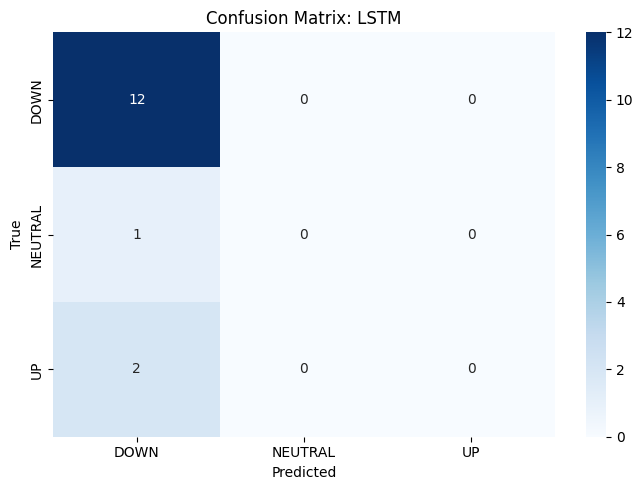

[SIEMENS] Results DataFrame shape: (15, 27)
[SIEMENS] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/SIEMENS_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/SIEMENS_results.xlsx
[SIEMENS] 💾 Saved results to /content/output/SIEMENS_results.xlsx
✅ Completed processing for SIEMENS
[PFC] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[PFC] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[PFC] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5402 - val_accuracy: 0.0000e+00 - val_loss: 1.0647 - learning_rate: 5.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0469 - val_accuracy: 

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2710 - val_accuracy: 1.0000 - val_loss: 0.9212 - learning_rate: 0.0010
Epoch 27/50

Epoch 7: val_loss improved from 1.06473 to 1.04667, saving model to /content/checkpoints/RECLTD/RECLTD_lstm_model.h5



Epoch 41: val_loss improved from 0.44188 to 0.43486, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0147 - val_accuracy: 1.0000 - val_loss: 0.4349 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5813 - val_accuracy: 0.0000e+00 - val_loss: 1.0467 - learning_rate: 5.0000e-04
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 1.0000 - loss: 0.0153
Epoch 27: val_loss improved from 0.92118 to 0.91932, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5



Epoch 42: val_loss improved from 0.43486 to 0.42793, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5



Epoch 8: val_loss improved from 1.04667 to 1.02772, saving model to /content/checkpoints/RECLTD/RECLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.3074 - val_accuracy: 1.0000 - val_loss: 0.9193 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.2518
Epoch 28: val_loss improved from 0.91932 to 0.91812, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 1.0000 - val_loss: 0.4279 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3026 - val_accuracy: 0.0000e+00 - val_loss: 1.0277 - learning_rate: 5.0000e-04
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2518 - val_accuracy: 1.0000 - val_loss: 0.9181 - learning_rate: 0.0010
Epoch 29/50

Epoch 43: val_loss improved from 0.42793 to 0.42096, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5



Epoch 9: val_loss improved from 1.02772 to 1.01026, saving model to /content/checkpoints/RECLTD/RECLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 1.0000 - loss: 0.3422
Epoch 29: val_loss improved from 0.91812 to 0.91609, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0307 - val_accuracy: 1.0000 - val_loss: 0.4210 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.4893 - val_accuracy: 0.0000e+00 - val_loss: 1.0103 - learning_rate: 5.0000e-04
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.3422 - val_accuracy: 1.0000 - val_loss: 0.9161 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.8182 - loss: 0.4283
Epoch 44: val_loss improved from 0.42096 to 0.41361, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5



Epoch 10: val_loss improved from 1.01026 to 0.99562, saving model to /content/checkpoints/RECLTD/RECLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 1.0000 - loss: 0.2384
Epoch 1: val_loss improved from inf to 1.00561, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5



Epoch 30: val_loss improved from 0.91609 to 0.91302, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4283 - val_accuracy: 1.0000 - val_loss: 0.9956 - learning_rate: 5.0000e-04
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0256 - val_accuracy: 1.0000 - val_loss: 0.4136 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.1818 - loss: 1.2740 - val_accuracy: 1.0000 - val_loss: 1.0056 - learning_rate: 0.0010
Epoch 2/50

Epoch 11: val_loss improved from 0.99562 to 0.98177, saving model to /content/checkpoints/RECLTD/RECLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2384 - val_accuracy: 1.0000 - val_loss: 0.9130 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step - accuracy: 0.9091 - loss: 0.2923 - val_accuracy: 1.0000 - val_loss: 0.9818 - learning_rate: 5.0000e-04
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7273 - loss: 0.4427
Epoch 12: val_loss improved from 0.98177 to 0.97005, saving model to /content/checkpoints/RECLTD/RECLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.7273 - loss: 0.4427 - val_accuracy: 1.0000 - val_loss: 0.9700 - learning_rate: 5.0000e-04
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.5455 - loss: 0.9002
Epoch 2: val_loss did not improve from 1.00561
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.9002 - val_accuracy: 0.0000e+00 - val_loss: 1.0099 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8182 - loss: 0.5127
Epoch 13: val_loss improved from 0.97005 to 0.96148, saving model to /content/checkpoints/RECLTD/RECLTD_lstm_model.h5



Epoch 3: val_loss improved from 1.00561 to 1.00247, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5



Epoch 45: val_loss improved from 0.41361 to 0.40669, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3555
Epoch 31: val_loss improved from 0.91302 to 0.90964, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5127 - val_accuracy: 1.0000 - val_loss: 0.9615 - learning_rate: 5.0000e-04
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.8394 - val_accuracy: 0.0000e+00 - val_loss: 1.0025 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0336 - val_accuracy: 1.0000 - val_loss: 0.4067 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7273 - loss: 0.6288
Epoch 14: val_loss improved from 0.96148 to 0.95448, saving model to /content/checkpoints/RECLTD/RECLTD_lstm_model.h5



Epoch 4: val_loss improved from 1.00247 to 0.99075, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.3555 - val_accuracy: 1.0000 - val_loss: 0.9096 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3496 - val_accuracy: 1.0000 - val_loss: 0.9545 - learning_rate: 5.0000e-04
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6288 - val_accuracy: 1.0000 - val_loss: 0.9908 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.7273 - loss: 0.4639
Epoch 46: val_loss improved from 0.40669 to 0.39972, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.9091 - loss: 0.2286
Epoch 5: val_loss improved from 0.99075 to 0.97948, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5



Epoch 15: val_loss improved from 0.95448 to 0.95042, saving model to /content/checkpoints/RECLTD/RECLTD_lstm_model.h5



Epoch 32: val_loss improved from 0.90964 to 0.90646, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0211 - val_accuracy: 1.0000 - val_loss: 0.3997 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.6120 - val_accuracy: 1.0000 - val_loss: 0.9795 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.4639 - val_accuracy: 1.0000 - val_loss: 0.9504 - learning_rate: 5.0000e-04
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2286 - val_accuracy: 1.0000 - val_loss: 0.9065 - learning_rate: 0.0010
Epoch 33/50

Epoch 16: val_loss improved from 0.95042 to 0.94947, saving model to /content/checkpoints/RECLTD/RECLTD_lstm_model.h5



Epoch 6: val_loss improved from 0.97948 to 0.96280, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step - accuracy: 0.8182 - loss: 0.3158 - val_accuracy: 1.0000 - val_loss: 0.9495 - learning_rate: 5.0000e-04
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step - accuracy: 0.7273 - loss: 0.4852 - val_accuracy: 1.0000 - val_loss: 0.9628 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0222
Epoch 17: val_loss improved from 0.94947 to 0.94690, saving model to /content/checkpoints/RECLTD/RECLTD_lstm_model.h5



Epoch 7: val_loss improved from 0.96280 to 0.95236, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5



Epoch 47: val_loss improved from 0.39972 to 0.39324, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.2089
Epoch 33: val_loss improved from 0.90646 to 0.90189, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4119 - val_accuracy: 1.0000 - val_loss: 0.9469 - learning_rate: 5.0000e-04
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3614 - val_accuracy: 1.0000 - val_loss: 0.9524 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0222 - val_accuracy: 1.0000 - val_loss: 0.3932 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 0.0170
Epoch 18: val_loss did not improve from 0.94690
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2089 - val_accuracy: 1.0000 - val_loss: 0.9019 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 0.2654
Epoch 48: val_loss improved from 0.39324 to 0.38585, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5



Epoch 34: val_loss improved from 0.90189 to 0.89447, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step - accuracy: 0.9091 - loss: 0.3029 - val_accuracy: 1.0000 - val_loss: 0.9471 - learning_rate: 5.0000e-04
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5455 - loss: 0.5767
Epoch 19: val_loss did not improve from 0.94690
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step - accuracy: 1.0000 - loss: 0.2654 - val_accuracy: 1.0000 - val_loss: 0.8945 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0170 - val_accuracy: 1.0000 - val_loss: 0.3859 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 1.0000 - loss: 0.0133
Epoch 8: val_loss improved from 0.95236 to 0.94423, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step - accuracy: 0.5455 - loss: 0.5767 - val_accuracy: 1.0000 - val_loss: 0.9502 - learning_rate: 5.0000e-04
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 1.0000 - loss: 0.2341
Epoch 49: val_loss improved from 0.38585 to 0.37841, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5



Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 20: val_loss did not improve from 0.94690

Epoch 35: val_loss improved from 0.89447 to 0.88703, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2766 - val_accuracy: 1.0000 - val_loss: 0.9442 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2947 - val_accuracy: 1.0000 - val_loss: 0.9562 - learning_rate: 5.0000e-04
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 1.0000 - val_loss: 0.3784 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0145
Epoch 9: val_loss improved from 0.94423 to 0.93850, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2341 - val_accuracy: 1.0000 - val_loss: 0.8870 - learning_rate: 0.0010
Epoch 36/50

Epoch 21: val_loss did not improve from 0.94690

Epoch 50: val_loss improved from 0.37841 to 0.37065, saving model to /content/checkpoints/PNB/PNB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step - accuracy: 0.8182 - loss: 0.3636 - val_accuracy: 0.0000e+00 - val_loss: 0.9604 - learning_rate: 2.5000e-04
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.5225 - val_accuracy: 1.0000 - val_loss: 0.9385 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 1.0000 - val_loss: 0.3707 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.

Epoch 10: val_loss improved from 0.93850 to 0.93013, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7273 - loss: 0.4891[PNB] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[PNB] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[PNB] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 1]

Epoch 22: val_loss did not improve from 0.94690
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.2042


Epoch 36: val_loss improved from 0.88703 to 0.87909, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


[PNB] ✅ Loaded best model from /content/checkpoints/PNB/PNB_lstm_model.h5
[PNB] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step - accuracy: 1.0000 - loss: 0.2293 - val_accuracy: 1.0000 - val_loss: 0.9301 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4891 - val_accuracy: 0.0000e+00 - val_loss: 0.9653 - learning_rate: 2.5000e-04
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 17.
[RECLTD] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
[PNB] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.9091 - loss: 0.2445Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[RECLTD] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[RECLTD] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.1957

[RECLTD] ✅ Loaded best model from /content/checkpoints/RECLTD/RECLTD_lstm_model.h5
[RECLTD] Predicting for 15 dates, including 30-07-2025

Epoch 37: val_loss improved from 0.87909 to 0.87219, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


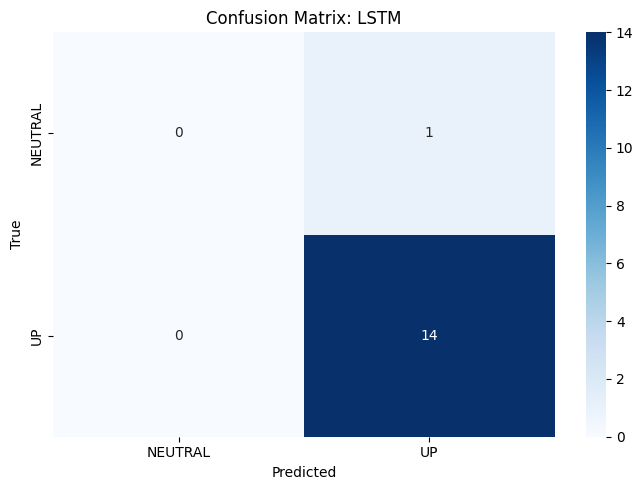

[PNB] Results DataFrame shape: (15, 26)
[PNB] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/PNB_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/PNB_results.xlsx
[PNB] 💾 Saved results to /content/output/PNB_results.xlsx
✅ Completed processing for PNB
[PETRONET] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[PETRONET] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[PETRONET] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2445 - val_accuracy: 1.0000 - val_loss: 0.9204 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 0.2069
✅ Built model: LSTM_M

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1957 - val_accuracy: 1.0000 - val_loss: 0.8722 - learning_rate: 0.0010
Epoch 38/50
Epoch 1/50

Epoch 12: val_loss improved from 0.92037 to 0.91112, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


[RECLTD] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         5
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.54      0.78      0.64         9

    accuracy                           0.47        15
   macro avg       0.18      0.26      0.21        15
weighted avg       0.32      0.47      0.38        15



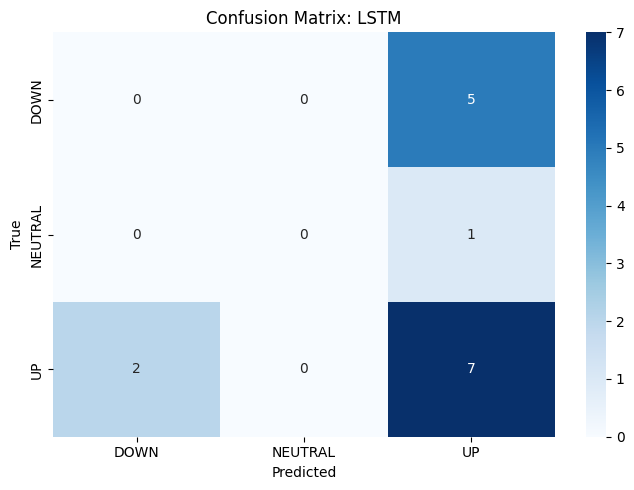

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2069 - val_accuracy: 1.0000 - val_loss: 0.9111 - learning_rate: 0.0010
Epoch 13/50
[RECLTD] Results DataFrame shape: (15, 27)
[RECLTD] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/RECLTD_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/RECLTD_results.xlsx
[RECLTD] 💾 Saved results to /content/output/RECLTD_results.xlsx
[PEL] ✅ Set DatetimeIndex. Index range: 2025-06-26 00:00:00 to 2025-07-29 00:00:00
✅ Completed processing for RECLTD
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.2414[PEL] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[PEL] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 38: val_loss improved from 0.87219 to 0.86767, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5



✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.0887Epoch 1/50

Epoch 13: val_loss improved from 0.91112 to 0.90193, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.2414 - val_accuracy: 1.0000 - val_loss: 0.8677 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.0887 - val_accuracy: 1.0000 - val_loss: 0.9019 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 0.1829
Epoch 14: val_loss improved from 0.90193 to 0.89143, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.1219
Epoch 39: val_loss improved from 0.86767 to 0.85950, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1829 - val_accuracy: 1.0000 - val_loss: 0.8914 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0830
Epoch 15: val_loss improved from 0.89143 to 0.88219, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.1219 - val_accuracy: 1.0000 - val_loss: 0.8595 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 1.0000 - loss: 0.1583
Epoch 40: val_loss improved from 0.85950 to 0.85440, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0830 - val_accuracy: 1.0000 - val_loss: 0.8822 - learning_rate: 0.0010


Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1583 - val_accuracy: 1.0000 - val_loss: 0.8544 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 0.1797
Epoch 16: val_loss improved from 0.88219 to 0.87465, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5



Epoch 41: val_loss improved from 0.85440 to 0.84958, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5



Epoch 1: val_loss improved from inf to 0.99619, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1095 - val_accuracy: 1.0000 - val_loss: 0.8747 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1797 - val_accuracy: 1.0000 - val_loss: 0.8496 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 0.1157
Epoch 42: val_loss improved from 0.84958 to 0.84645, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.5455 - loss: 1.1911 - val_accuracy: 0.0000e+00 - val_loss: 0.9962 - learning_rate: 0.0010
Epoch 2/50

Epoch 1: val_loss improved from inf to 1.11114, saving model to /content/checkpoints/PEL/PEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step - accuracy: 1.0000 - loss: 0.1157 - val_accuracy: 1.0000 - val_loss: 0.8465 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0535
Epoch 43: val_loss improved from 0.84645 to 0.84332, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5



Epoch 17: val_loss improved from 0.87465 to 0.86783, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.0000e+00 - loss: 1.6943 - val_accuracy: 0.0000e+00 - val_loss: 1.1111 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step - accuracy: 1.0000 - loss: 0.1253 - val_accuracy: 1.0000 - val_loss: 0.8433 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0535 - val_accuracy: 1.0000 - val_loss: 0.8678 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 1.0000 - loss: 0.0883
Epoch 44: val_loss improved from 0.84332 to 0.84256, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5



Epoch 2: val_loss improved from 1.11114 to 1.10027, saving model to /content/checkpoints/PEL/PEL_lstm_model.h5



Epoch 18: val_loss improved from 0.86783 to 0.86215, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1419 - val_accuracy: 1.0000 - val_loss: 0.8426 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 1.5417 - val_accuracy: 0.0000e+00 - val_loss: 1.1003 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0883 - val_accuracy: 1.0000 - val_loss: 0.8621 - learning_rate: 0.0010
Epoch 19/50

Epoch 2: val_loss improved from 0.99619 to 0.98472, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5



Epoch 3: val_loss did not improve from 1.10027

Epoch 45: val_loss improved from 0.84256 to 0.83739, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step - accuracy: 0.2727 - loss: 1.5643 - val_accuracy: 0.0000e+00 - val_loss: 1.1160 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4545 - loss: 1.0366 - val_accuracy: 1.0000 - val_loss: 0.9847 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1423 - val_accuracy: 1.0000 - val_loss: 0.8374 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.2727 - loss: 1.2377
Epoch 3: val_loss did not improve from 0.98472
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0911
Epoch 4: val_loss did not improve from 1.10027

Epoch 46: val_loss improved from 0.83739 to 0.83097, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5



Epoch 19: val_loss improved from 0.86215 to 0.85732, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.9505 - val_accuracy: 1.0000 - val_loss: 0.9855 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2727 - loss: 1.2377 - val_accuracy: 0.0000e+00 - val_loss: 1.1052 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1091 - val_accuracy: 1.0000 - val_loss: 0.8310 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0911 - val_accuracy: 1.0000 - val_loss: 0.8573 - learning_rate: 0.0010
Epoch 20/50

Epoch 5: val_loss improved from 1.10027 to 1.08950, saving model to /content/checkpoints/PEL/PEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step - accuracy: 0.5455 - loss: 1.1819 - val_accuracy: 0.0000e+00 - val_loss: 1.0895 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.8337
Epoch 4: val_loss improved from 0.98472 to 0.97738, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1359
Epoch 6: val_loss did not improve from 1.08950
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.8337 - val_accuracy: 1.0000 - val_loss: 0.9774 - learning_rate: 0.0010
Epoch 5/50

Epoch 47: val_loss improved from 0.83097 to 0.82601, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5455 - loss: 0.8186
Epoch 20: val_loss improved from 0.85732 to 0.85475, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5



Epoch 5: val_loss improved from 0.97738 to 0.96993, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.1464 - val_accuracy: 0.0000e+00 - val_loss: 1.0968 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6364 - loss: 0.7269
Epoch 7: val_loss did not improve from 1.08950
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1359 - val_accuracy: 1.0000 - val_loss: 0.8260 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.8186 - val_accuracy: 1.0000 - val_loss: 0.9699 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0814 - val_accuracy: 1.0000 - val_loss: 0.8547 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step - accuracy: 0.6364 - loss: 0.7269 - val_accuracy: 0.0000e+00 - val_loss: 1.1159 - learning_rate: 0.0010
Epoch 8/50

Epoch 6: val_loss improved from 0.96993 to 0.95033, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.6364 - loss: 0.8429 - val_accuracy: 1.0000 - val_loss: 0.9503 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.8182 - loss: 0.5630
Epoch 7: val_loss improved from 0.95033 to 0.93278, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: val_loss did not improve from 1.08950
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0574
Epoch 48: val_loss improved from 0.82601 to 0.82361, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5



Epoch 21: val_loss improved from 0.85475 to 0.85131, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6585 - val_accuracy: 0.0000e+00 - val_loss: 1.1286 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5630 - val_accuracy: 1.0000 - val_loss: 0.9328 - learning_rate: 0.0010
Epoch 8/50

Epoch 9: val_loss did not improve from 1.08950
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1496 - val_accuracy: 1.0000 - val_loss: 0.8236 - learning_rate: 0.0010
Epoch 49/50

Epoch 8: val_loss improved from 0.93278 to 0.92208, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0574 - val_accuracy: 1.0000 - val_loss: 0.8513 - learning_rate: 0.0010
Epoch 22/50

Epoch 49: val_loss improved from 0.82361 to 0.81945, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.7144 - val_accuracy: 0.0000e+00 - val_loss: 1.1274 - learning_rate: 5.0000e-04
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8182 - loss: 0.6710
Epoch 10: val_loss did not improve from 1.08950
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4823 - val_accuracy: 1.0000 - val_loss: 0.9221 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2329 - val_accuracy: 1.0000 - val_loss: 0.8194 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 0.1508
Epoch 9: val_loss improved from 0.92208 to 0.90892, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step - accuracy: 0.8182 - loss: 0.6710 - val_accuracy: 0.0000e+00 - val_loss: 1.1274 - learning_rate: 5.0000e-04
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.

Epoch 50: val_loss improved from 0.81945 to 0.81769, saving model to /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0568[PEL] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[PEL] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[PEL] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 2 0 0 0 0 0 0 2 0 2 2 2 1]

Epoch 22: val_loss improved from 0.85131 to 0.84899, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4060 - val_accuracy: 1.0000 - val_loss: 0.9089 - learning_rate: 0.0010


Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step - accuracy: 1.0000 - loss: 0.1508 - val_accuracy: 1.0000 - val_loss: 0.8177 - learning_rate: 0.0010

Restoring model weights from the end of the best epoch: 50.
[PEL] Predicting for 15 dates, including 30-07-2025
[PIDILITIND] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8182 - loss: 0.5022Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[PIDILITIND] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[PIDILITIND] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 2 0 0 0 0 0 0 0 2 0 1 0 1]

Epoch 10: val_loss improved from 0.90892 to 0.89158, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5


[PIDILITIND] ✅ Loaded best model from /content/checkpoints/PIDILITIND/PIDILITIND_lstm_model.h5
[PIDILITIND] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0568 - val_accuracy: 1.0000 - val_loss: 0.8490 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5022 - val_accuracy: 1.0000 - val_loss: 0.8916 - learning_rate: 0.0010
Epoch 11/50
[PIDILITIND] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.73      1.00      0.85        11
     NEUTRAL       0.00      0.00      0.00         2
          UP       0.00      0.00      0.00         2

    accuracy                           0.73        15
   macro avg       0.24      0.33      0.28        15
weighted avg       0.54      0.73      0.62        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7273

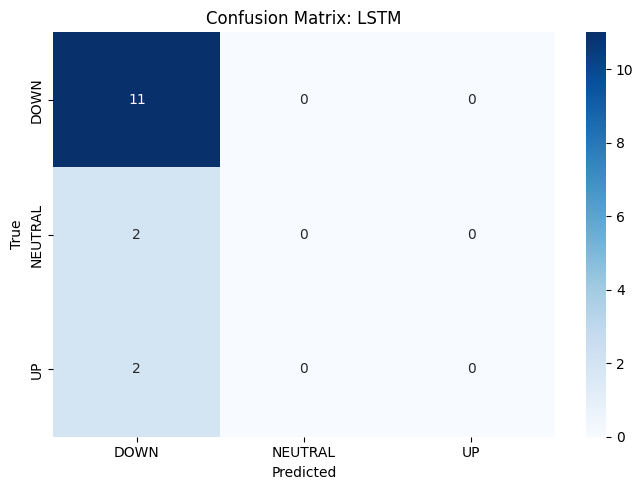

[PIDILITIND] Results DataFrame shape: (15, 27)
[PIDILITIND] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/PIDILITIND_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/PIDILITIND_results.xlsx
[PIDILITIND] 💾 Saved results to /content/output/PIDILITIND_results.xlsx
✅ Completed processing for PIDILITIND
[RELIANCE] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
[PEL] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 11: val_loss improved from 0.89158 to 0.87929, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5


Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[RELIANCE] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[RELIANCE] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.60      0.67      0.63         9
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         5

    accuracy                           0.40        15
   macro avg       0.20      0.22      0.21        15
weighted avg       0.36      0.40      0.38        15


✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0330Epoch 1/50

Epoch 23: val_loss improved from 0.84899 to 0.84590, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


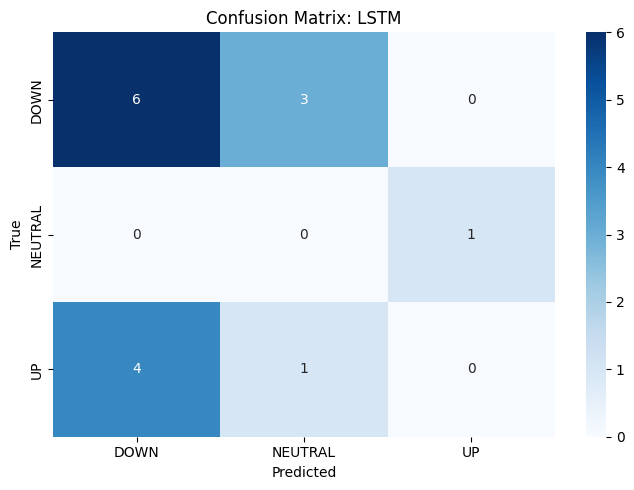

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5410 - val_accuracy: 1.0000 - val_loss: 0.8793 - learning_rate: 0.0010
Epoch 12/50
[PEL] Results DataFrame shape: (15, 27)
[PEL] Prediction dates: [Timestamp('2025-07-10 00:00:00'), Timestamp('2025-07-11 00:00:00'), Timestamp('2025-07-14 00:00:00'), Timestamp('2025-07-15 00:00:00'), Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00')]
Excel report successfully generated: /content/output/PEL_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/PEL_results.xlsx
[PEL] 💾 Saved results to /content/output/PEL_results.xlsx
[PAGEIND] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for PEL
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[PAGEIND] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[PAGEIND] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0330 - val_accuracy: 1.0000 - val_loss: 0.8459 - learning_rate: 0.0010
Epoch 24/50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3937
Epoch 12: val_loss improved from 0.87929 to 0.86309, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3937 - val_accuracy: 1.0000 - val_loss: 0.8631 - learning_rate: 0.0010
Epoch 13/50

Epoch 24: val_loss improved from 0.84590 to 0.83836, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7273 - loss: 0.6316
Epoch 13: val_loss improved from 0.86309 to 0.84743, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0606 - val_accuracy: 1.0000 - val_loss: 0.8384 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 1.0000 - loss: 0.0280
Epoch 25: val_loss improved from 0.83836 to 0.83155, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6316 - val_accuracy: 1.0000 - val_loss: 0.8474 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.8182 - loss: 0.3386
Epoch 14: val_loss improved from 0.84743 to 0.83117, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0280 - val_accuracy: 1.0000 - val_loss: 0.8316 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 1.0000 - loss: 0.0349
Epoch 26: val_loss improved from 0.83155 to 0.82427, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.3386 - val_accuracy: 1.0000 - val_loss: 0.8312 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9091 - loss: 0.3589
Epoch 15: val_loss improved from 0.83117 to 0.81487, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0349 - val_accuracy: 1.0000 - val_loss: 0.8243 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 0.0228
Epoch 27: val_loss improved from 0.82427 to 0.81715, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3589 - val_accuracy: 1.0000 - val_loss: 0.8149 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0228 - val_accuracy: 1.0000 - val_loss: 0.8172 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 1.0000 - loss: 0.0329
Epoch 28: val_loss improved from 0.81715 to 0.80941, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7273 - loss: 0.7499
Epoch 1: val_loss improved from inf to 1.09593, saving model to /content/checkpoints/RELIANCE/RELIANCE_lstm_model.h5



Epoch 16: val_loss improved from 0.81487 to 0.80029, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0329 - val_accuracy: 1.0000 - val_loss: 0.8094 - learning_rate: 0.0010
Epoch 29/50

Epoch 1: val_loss improved from inf to 1.04936, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.3636 - loss: 2.1947 - val_accuracy: 0.0000e+00 - val_loss: 1.0959 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.3784 - val_accuracy: 1.0000 - val_loss: 0.8003 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7273 - loss: 0.3725
Epoch 17: val_loss improved from 0.80029 to 0.78347, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5



Epoch 2: val_loss did not improve from 1.09593
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.7273 - loss: 0.7499 - val_accuracy: 1.0000 - val_loss: 1.0494 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5455 - loss: 0.7509
Epoch 2: val_loss did not improve from 1.04936
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.1928 - val_accuracy: 0.0000e+00 - val_loss: 1.1068 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.3725 - val_accuracy: 1.0000 - val_loss: 0.7835 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.4545 - loss: 1.3354
Epoch 29: val_loss improved from 0.80941 to 0.80269, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8182 - loss: 0.3407
Epoch 3: val_loss did not improve from 1.09593
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step - accuracy: 0.5455 - loss: 0.7509 - val_accuracy: 1.0000 - val_loss: 1.0518 - learning_rate: 0.0010
Epoch 3/50

Epoch 18: val_loss improved from 0.78347 to 0.77093, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0306 - val_accuracy: 1.0000 - val_loss: 0.8027 - learning_rate: 0.0010

Epoch 3: val_loss did not improve from 1.04936
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.3354 - val_accuracy: 0.0000e+00 - val_loss: 1.1091 - learning_rate: 0.0010
Epoch 30/50
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3407 - val_accuracy: 1.0000 - val_loss: 0.7709 - learning_rate: 0.0010
Epoch 19/50

Epoch 30: val_loss improved from 0.80269 to 0.79660, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.09593
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.5134 - val_accuracy: 1.0000 - val_loss: 1.0527 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step - accuracy: 0.4545 - loss: 1.3408 - val_accuracy: 0.0000e+00 - val_loss: 1.1106 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0366 - val_accuracy: 1.0000 - val_loss: 0.7966 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 1.0000 - loss: 0.3458
Epoch 4: val_loss improved from 1.04936 to 1.04788, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.4549
Epoch 5: val_loss did not improve from 1.09593

Epoch 31: val_loss improved from 0.79660 to 0.78977, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.3458 - val_accuracy: 1.0000 - val_loss: 1.0479 - learning_rate: 0.0010

Epoch 19: val_loss improved from 0.77093 to 0.76556, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5
Epoch 5/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 1.0000 - loss: 0.3773
Epoch 5: val_loss improved from 1.04788 to 1.03808, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 0.9417 - val_accuracy: 0.0000e+00 - val_loss: 1.1120 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0317 - val_accuracy: 1.0000 - val_loss: 0.7898 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.4549 - val_accuracy: 1.0000 - val_loss: 0.7656 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.3773 - val_accuracy: 1.0000 - val_loss: 1.0381 - learning_rate: 0.0010
Epoch 6/50

Epoch 32: val_loss improved from 0.78977 to 0.78241, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.3156
Epoch 6: val_loss improved from 1.03808 to 1.02776, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0300 - val_accuracy: 1.0000 - val_loss: 0.7824 - learning_rate: 0.0010
Epoch 33/50

Epoch 6: val_loss did not improve from 1.09593
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 1.0000 - loss: 0.0132
Epoch 20: val_loss improved from 0.76556 to 0.76444, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.3156 - val_accuracy: 1.0000 - val_loss: 1.0278 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 0.2257
Epoch 33: val_loss improved from 0.78241 to 0.77429, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5



Epoch 7: val_loss improved from 1.02776 to 1.01345, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 1.1243 - val_accuracy: 0.0000e+00 - val_loss: 1.1102 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
[RELIANCE] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[RELIANCE] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[RELIANCE] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 0 2 2 2 0 0 0 0 2 2 2 0 1]


[RELIANCE] ✅ Loaded best model from /content/checkpoints/RELIANCE/RELIANCE_lstm_model.h5
[RELIANCE] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2450 - val_accuracy: 1.0000 - val_loss: 0.7644 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.7743 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2257 - val_accuracy: 1.0000 - val_loss: 1.0135 - learning_rate: 0.0010
Epoch 8/50

Epoch 21: val_loss improved from 0.76444 to 0.76160, saving model to /content/checkpoints/PETRONET/PETRONET_lstm_model.h5


[RELIANCE] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step - accuracy: 0.8182 - loss: 0.3025 - val_accuracy: 1.0000 - val_loss: 0.7616 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7273 - loss: 0.3176
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         7
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.42      0.71      0.53         7

    accuracy                           0.33        15
   macro avg       0.14      0.24      0.18        15
weighted avg       0.19      0.33      0.25        15


Epoch 22: val_loss did not improve from 0.76160


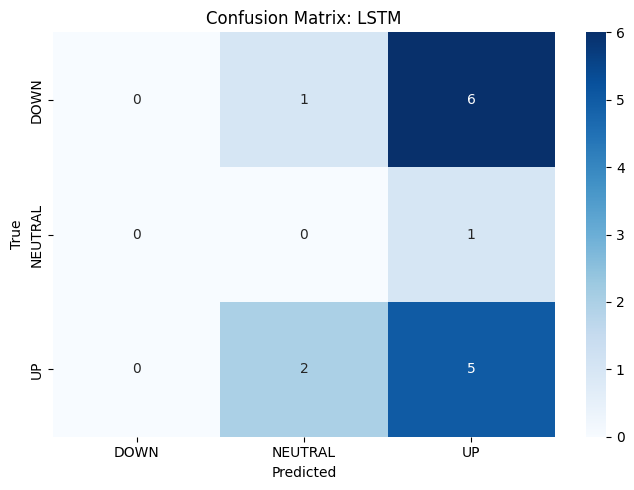

[RELIANCE] Results DataFrame shape: (15, 27)
[RELIANCE] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/RELIANCE_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/RELIANCE_results.xlsx
[RELIANCE] 💾 Saved results to /content/output/RELIANCE_results.xlsx
✅ Completed processing for RELIANCE
[ONGC] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0226Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[ONGC] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[ONGC] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step - accuracy: 0.7273 - loss: 0.3176 - val_accuracy: 1.0000 - val_loss: 0.7628 - learning_rate: 0.0010
Epoch 23/50

Epoch 34: val

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.1708
✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1498

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 23: val_loss did not improve from 0.76160
Epoch 1/50

Epoch 8: val_loss improved from 1.01345 to 1.00007, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0226 - val_accuracy: 1.0000 - val_loss: 0.7675 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1708 - val_accuracy: 1.0000 - val_loss: 0.7637 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1498 - val_accuracy: 1.0000 - val_loss: 1.0001 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0157
Epoch 35: val_loss improved from 0.76750 to 0.76100, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1396
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 24: val_loss did not improve from 0.76160

Epoch 9: val_loss improved from 1.00007 to 0.98670, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 1.0000 - val_loss: 0.7610 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.3072 - val_accuracy: 1.0000 - val_loss: 0.7647 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1396 - val_accuracy: 1.0000 - val_loss: 0.9867 - learning_rate: 0.0010
Epoch 10/50

Epoch 25: val_loss did not improve from 0.76160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.1249
Epoch 10: val_loss improved from 0.98670 to 0.97377, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3184 - val_accuracy: 1.0000 - val_loss: 0.7653 - learning_rate: 5.0000e-04
Epoch 26/50

Epoch 36: val_loss improved from 0.76100 to 0.75425, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1249 - val_accuracy: 1.0000 - val_loss: 0.9738 - learning_rate: 0.0010
Epoch 11/50

Epoch 26: val_loss did not improve from 0.76160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 1.0000 - loss: 0.0925
Epoch 11: val_loss improved from 0.97377 to 0.96143, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0249 - val_accuracy: 1.0000 - val_loss: 0.7542 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1818 - loss: 1.6038Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2182 - val_accuracy: 1.0000 - val_loss: 0.7642 - learning_rate: 5.0000e-04
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 21.
[PETRONET] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[PETRONET] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[PETRONET] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 2 2 2 2 2 2 0 2 2 2 2 2 1]


[PETRONET] ✅ Loaded best model from /content/checkpoints/PETRONET/PETRONET_lstm_model.h5
[PETRONET] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0925 - val_accuracy: 1.0000 - val_loss: 0.9614 - learning_rate: 0.0010
Epoch 12/50
[PETRONET] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 1: val_loss improved from inf to 1.03394, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         2
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.80      1.00      0.89        12

    accuracy                           0.80        15
   macro avg       0.27      0.33      0.30        15
weighted avg       0.64      0.80      0.71        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0238
Epoch 37: val_loss improved from 0.75425 to 0.74847, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


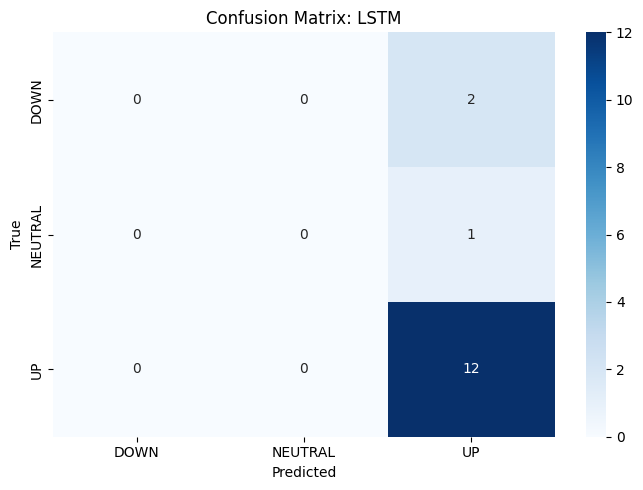

[PETRONET] Results DataFrame shape: (15, 27)
[PETRONET] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.1818 - loss: 1.6038 - val_accuracy: 1.0000 - val_loss: 1.0339 - learning_rate: 0.0010
Epoch 2/50
Excel report successfully generated: /content/output/PETRONET_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/PETRONET_results.xlsx
[PETRONET] 💾 Saved results to /content/output/PETRONET_results.xlsx
✅ Completed processing for PETRONET
[NTPC] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.2727 - loss: 1.7099Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[NTPC] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[NTPC] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 2: val_loss improved from 1.03394 to 1.02324, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 

Epoch 38/50

Epoch 12: val_loss improved from 0.96143 to 0.95065, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5



✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0802 - val_accuracy: 1.0000 - val_loss: 0.9506 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.7099 - val_accuracy: 1.0000 - val_loss: 1.0232 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0142
Epoch 3: val_loss improved from 1.02324 to 1.00512, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 13: val_loss improved from 0.95065 to 0.93974, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5



Epoch 38: val_loss improved from 0.74847 to 0.74212, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0953 - val_accuracy: 1.0000 - val_loss: 0.9397 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1818 - loss: 1.4197 - val_accuracy: 1.0000 - val_loss: 1.0051 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 1.0000 - val_loss: 0.7421 - learning_rate: 0.0010
Epoch 39/50

Epoch 4: val_loss improved from 1.00512 to 0.99148, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step - accuracy: 0.6364 - loss: 0.9733 - val_accuracy: 1.0000 - val_loss: 0.9915 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3636 - loss: 1.3141
Epoch 14: val_loss improved from 0.93974 to 0.92957, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0180
Epoch 5: val_loss improved from 0.99148 to 0.98248, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 39: val_loss improved from 0.74212 to 0.73605, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0857 - val_accuracy: 1.0000 - val_loss: 0.9296 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.3141 - val_accuracy: 1.0000 - val_loss: 0.9825 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0180 - val_accuracy: 1.0000 - val_loss: 0.7360 - learning_rate: 0.0010
Epoch 40/50

Epoch 15: val_loss improved from 0.92957 to 0.91963, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5



Epoch 6: val_loss improved from 0.98248 to 0.97067, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 1.0000 - loss: 0.0166
Epoch 40: val_loss improved from 0.73605 to 0.72861, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0562 - val_accuracy: 1.0000 - val_loss: 0.9196 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7029 - val_accuracy: 1.0000 - val_loss: 0.9707 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0166 - val_accuracy: 1.0000 - val_loss: 0.7286 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.0181
Epoch 41: val_loss improved from 0.72861 to 0.72178, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step - accuracy: 1.0000 - loss: 0.0181 - val_accuracy: 1.0000 - val_loss: 0.7218 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.5455 - loss: 0.7531
Epoch 42: val_loss improved from 0.72178 to 0.71340, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5



Epoch 16: val_loss improved from 0.91963 to 0.91132, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5



Epoch 7: val_loss improved from 0.97067 to 0.96079, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.13457, saving model to /content/checkpoints/NTPC/NTPC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 1.0000 - val_loss: 0.7134 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0393 - val_accuracy: 1.0000 - val_loss: 0.9113 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.7531 - val_accuracy: 1.0000 - val_loss: 0.9608 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.3636 - loss: 1.3546 - val_accuracy: 0.0000e+00 - val_loss: 1.1346 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4545 - loss: 1.2415
Epoch 2: val_loss improved from 1.13457 to 1.12831, saving model to /content/checkpoints/NTPC/NTPC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.4545 - loss: 1.2415 - val_accuracy: 0.0000e+00 - val_loss: 1.1283 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6364 - loss: 0.7854
Epoch 3: val_loss improved from 1.12831 to 1.11665, saving model to /content/checkpoints/NTPC/NTPC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.6364 - loss: 0.7854 - val_accuracy: 0.0000e+00 - val_loss: 1.1167 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.6364 - loss: 0.7483
Epoch 8: val_loss improved from 0.96079 to 0.94711, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 17: val_loss improved from 0.91132 to 0.90360, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5



Epoch 43: val_loss improved from 0.71340 to 0.70497, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5



Epoch 4: val_loss improved from 1.11665 to 1.10569, saving model to /content/checkpoints/NTPC/NTPC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0453 - val_accuracy: 1.0000 - val_loss: 0.9036 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 1.0000 - val_loss: 0.7050 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6293 - val_accuracy: 1.0000 - val_loss: 0.9471 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7483 - val_accuracy: 0.0000e+00 - val_loss: 1.1057 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4545 - loss: 0.8721
Epoch 18: val_loss improved from 0.90360 to 0.89810, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5



Epoch 9: val_loss improved from 0.94711 to 0.93742, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 5: val_loss improved from 1.10569 to 1.10295, saving model to /content/checkpoints/NTPC/NTPC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0591 - val_accuracy: 1.0000 - val_loss: 0.8981 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6228 - val_accuracy: 1.0000 - val_loss: 0.9374 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 0.8721 - val_accuracy: 0.0000e+00 - val_loss: 1.1030 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9091 - loss: 0.5645
Epoch 19: val_loss improved from 0.89810 to 0.89274, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6364 - loss: 0.7687
Epoch 44: val_loss improved from 0.70497 to 0.69576, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5



Epoch 10: val_loss improved from 0.93742 to 0.92654, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 6: val_loss improved from 1.10295 to 1.09384, saving model to /content/checkpoints/NTPC/NTPC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0385 - val_accuracy: 1.0000 - val_loss: 0.8927 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0300 - val_accuracy: 1.0000 - val_loss: 0.6958 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.5645 - val_accuracy: 1.0000 - val_loss: 0.9265 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7687 - val_accuracy: 0.0000e+00 - val_loss: 1.0938 - learning_rate: 0.0010
Epoch 7/50

Epoch 20: val_loss improved from 0.89274 to 0.88737, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6364 - loss: 0.7103
Epoch 7: val_loss improved from 1.09384 to 1.09169, saving model to /content/checkpoints/NTPC/NTPC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0377 - val_accuracy: 1.0000 - val_loss: 0.8874 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.7103 - val_accuracy: 1.0000 - val_loss: 1.0917 - learning_rate: 0.0010
Epoch 8/50

Epoch 21: val_loss improved from 0.88737 to 0.88406, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9091 - loss: 0.4185
Epoch 45: val_loss improved from 0.69576 to 0.68819, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5



Epoch 11: val_loss improved from 0.92654 to 0.90408, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 8: val_loss improved from 1.09169 to 1.08527, saving model to /content/checkpoints/NTPC/NTPC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0217 - val_accuracy: 1.0000 - val_loss: 0.8841 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0179 - val_accuracy: 1.0000 - val_loss: 0.6882 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.5863 - val_accuracy: 1.0000 - val_loss: 0.9041 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4185 - val_accuracy: 1.0000 - val_loss: 1.0853 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6364 - loss: 0.8128
Epoch 9: val_loss improved from 1.08527 to 1.07527, saving model to /content/checkpoints/NTPC/NTPC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.6364 - loss: 0.8128 - val_accuracy: 1.0000 - val_loss: 1.0753 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.7273 - loss: 0.8450
Epoch 10: val_loss improved from 1.07527 to 1.04878, saving model to /content/checkpoints/NTPC/NTPC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.5135
Epoch 22: val_loss improved from 0.88406 to 0.88201, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5



Epoch 12: val_loss improved from 0.90408 to 0.87634, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 46: val_loss improved from 0.68819 to 0.68063, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.8450 - val_accuracy: 1.0000 - val_loss: 1.0488 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0225 - val_accuracy: 1.0000 - val_loss: 0.8820 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.5135 - val_accuracy: 1.0000 - val_loss: 0.8763 - learning_rate: 0.0010
Epoch 13/50

Epoch 11: val_loss improved from 1.04878 to 1.02411, saving model to /content/checkpoints/NTPC/NTPC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0135 - val_accuracy: 1.0000 - val_loss: 0.6806 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0073
Epoch 13: val_loss improved from 0.87634 to 0.85177, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 47: val_loss improved from 0.68063 to 0.67325, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.5097 - val_accuracy: 1.0000 - val_loss: 1.0241 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6364 - loss: 0.8566
Epoch 12: val_loss improved from 1.02411 to 1.00946, saving model to /content/checkpoints/NTPC/NTPC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.5105 - val_accuracy: 1.0000 - val_loss: 0.8518 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 1.0000 - val_loss: 0.6733 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 1.0000 - loss: 0.3681
Epoch 48: val_loss improved from 0.67325 to 0.66595, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5



Epoch 14: val_loss improved from 0.85177 to 0.82448, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 23: val_loss improved from 0.88201 to 0.87896, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.8566 - val_accuracy: 1.0000 - val_loss: 1.0095 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8182 - loss: 0.5564
Epoch 13: val_loss improved from 1.00946 to 0.99914, saving model to /content/checkpoints/NTPC/NTPC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 1.0000 - val_loss: 0.6660 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.3681 - val_accuracy: 1.0000 - val_loss: 0.8245 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0221 - val_accuracy: 1.0000 - val_loss: 0.8790 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9091 - loss: 0.4598
Epoch 15: val_loss improved from 0.82448 to 0.79895, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 49: val_loss improved from 0.66595 to 0.65888, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5564 - val_accuracy: 1.0000 - val_loss: 0.9991 - learning_rate: 0.0010


Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7273 - loss: 0.6348
Epoch 14: val_loss did not improve from 0.99914
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0173 - val_accuracy: 1.0000 - val_loss: 0.6589 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4598 - val_accuracy: 1.0000 - val_loss: 0.7989 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step - accuracy: 0.7273 - loss: 0.6348 - val_accuracy: 1.0000 - val_loss: 1.0058 - learning_rate: 0.0010
Epoch 15/50

Epoch 24: val_loss improved from 0.87896 to 0.87585, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9091 - loss: 0.2653
Epoch 16: val_loss improved from 0.79895 to 0.77306, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 50: val_loss improved from 0.65888 to 0.65174, saving model to /content/checkpoints/PFC/PFC_lstm_model.h5

Epoch 15: val_loss did not improve from 0.99914


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0160 - val_accuracy: 1.0000 - val_loss: 0.8758 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2824 - val_accuracy: 1.0000 - val_loss: 0.7731 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2653 - val_accuracy: 1.0000 - val_loss: 1.0151 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0128 - val_accuracy: 1.0000 - val_loss: 0.6517 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
[PFC] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[PFC] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[PFC] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls:

[PFC] ✅ Loaded best model from /content/checkpoints/PFC/PFC_lstm_model.h5
[PFC] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step - accuracy: 0.8182 - loss: 0.4891 - val_accuracy: 1.0000 - val_loss: 1.0250 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.2273
Epoch 17: val_loss did not improve from 0.99914
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 1.0000 - loss: 0.2273 - val_accuracy: 1.0000 - val_loss: 1.0322 - learning_rate: 5.0000e-04
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0188[PFC] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.3049
Epoch 25: val_loss improved from 0.87585 to 0.87240, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8182 - loss: 0.3319
Classification Report for LSTM:
              precision    recall  f1-score   support

     NEUTRAL       0.00      0.00      0.00         1
          UP       0.93      1.00      0.97        14

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15


Epoch 17: val_loss improved from 0.77306 to 0.74841, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 18: val_loss did not improve from 0.99914


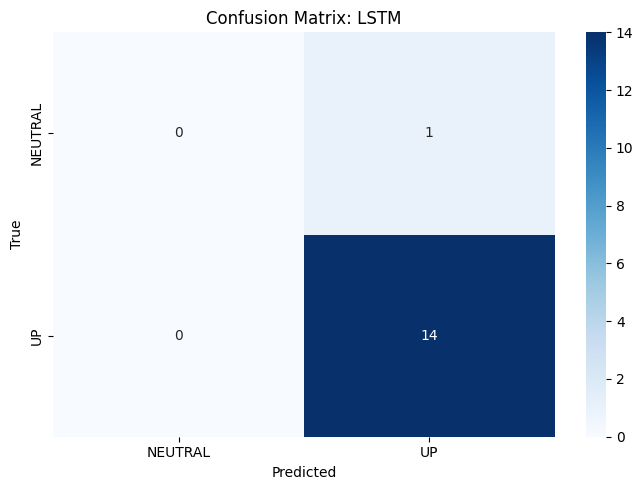

[PFC] Results DataFrame shape: (15, 26)
[PFC] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/PFC_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/PFC_results.xlsx
[PFC] 💾 Saved results to /content/output/PFC_results.xlsx
[SAIL] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for PFC
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[SAIL] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[SAIL] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0188 - val_accuracy: 1.0000 - val_loss: 0.8724 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3319 - val_accuracy: 1.0000 - val_loss: 1

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.3049 - val_accuracy: 1.0000 - val_loss: 0.7484 - learning_rate: 0.0010
Epoch 18/50

Epoch 26: val_loss improved from 0.87240 to 0.86837, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.2204Epoch 1/50

Epoch 18: val_loss improved from 0.74841 to 0.72668, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0205 - val_accuracy: 1.0000 - val_loss: 0.8684 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step - accuracy: 1.0000 - loss: 0.2204 - val_accuracy: 1.0000 - val_loss: 0.7267 - learning_rate: 0.0010
Epoch 19/50
[NTPC] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 1.0000 - loss: 0.0132Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[NTPC] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[NTPC] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 0 0 2 2 0 0 2 2 2 2 2 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9091 - loss: 0.3515
Epoch 27: val_loss improved from 0.86837 to 0.86536, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5



Epoch 19: val_loss improved from 0.72668 to 0.70792, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


[NTPC] ✅ Loaded best model from /content/checkpoints/NTPC/NTPC_lstm_model.h5
[NTPC] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.8654 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3515 - val_accuracy: 1.0000 - val_loss: 0.7079 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9091 - loss: 0.3280
Epoch 20: val_loss improved from 0.70792 to 0.68825, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


[NTPC] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         4
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.67      1.00      0.80        10

    accuracy                           0.67        15
   macro avg       0.22      0.33      0.27        15
weighted avg       0.44      0.67      0.53        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0118
Epoch 28: val_loss improved from 0.86536 to 0.86318, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


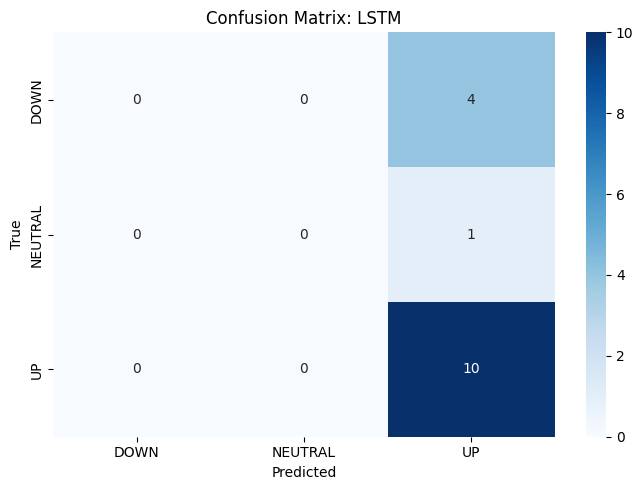

[NTPC] Results DataFrame shape: (15, 27)
[NTPC] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3280 - val_accuracy: 1.0000 - val_loss: 0.6882 - learning_rate: 0.0010
Epoch 21/50
Excel report successfully generated: /content/output/NTPC_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/NTPC_results.xlsx
[NTPC] 💾 Saved results to /content/output/NTPC_results.xlsx
✅ Completed processing for NTPC
[NMDC] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[NMDC] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[NMDC] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 1.0000 - val_loss: 0.8632 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1866
Epoch 21: val_loss improved from 0.68825 to 0.66817, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0163
Epoch 29: val_loss improved from 0.86318 to 0.85875, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1866 - val_accuracy: 1.0000 - val_loss: 0.6682 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.9091 - loss: 0.2928
Epoch 22: val_loss improved from 0.66817 to 0.64721, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0163 - val_accuracy: 1.0000 - val_loss: 0.8587 - learning_rate: 0.0010


Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2928 - val_accuracy: 1.0000 - val_loss: 0.6472 - learning_rate: 0.0010
Epoch 23/50

Epoch 30: val_loss improved from 0.85875 to 0.85231, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.1818 - loss: 1.3807
Epoch 23: val_loss improved from 0.64721 to 0.62822, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0206 - val_accuracy: 1.0000 - val_loss: 0.8523 - learning_rate: 0.0010
Epoch 31/50

Epoch 1: val_loss improved from inf to 1.04507, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1814 - val_accuracy: 1.0000 - val_loss: 0.6282 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.2649
Epoch 24: val_loss improved from 0.62822 to 0.61531, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.1818 - loss: 1.3807 - val_accuracy: 1.0000 - val_loss: 1.0451 - learning_rate: 0.0010
Epoch 2/50

Epoch 31: val_loss improved from 0.85231 to 0.84482, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.6364 - loss: 0.7227
Epoch 2: val_loss improved from 1.04507 to 1.03191, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2649 - val_accuracy: 1.0000 - val_loss: 0.6153 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 0.8448 - learning_rate: 0.0010
Epoch 32/50

Epoch 25: val_loss improved from 0.61531 to 0.60211, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.7227 - val_accuracy: 1.0000 - val_loss: 1.0319 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step - accuracy: 1.0000 - loss: 0.2006 - val_accuracy: 1.0000 - val_loss: 0.6021 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.1857
Epoch 3: val_loss did not improve from 1.03191
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3636 - loss: 1.4189
Epoch 26: val_loss improved from 0.60211 to 0.58748, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.8360 - val_accuracy: 1.0000 - val_loss: 1.0401 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6364 - loss: 0.7088
Epoch 32: val_loss improved from 0.84482 to 0.83676, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1857 - val_accuracy: 1.0000 - val_loss: 0.5875 - learning_rate: 0.0010
Epoch 27/50

Epoch 4: val_loss did not improve from 1.03191

Epoch 1: val_loss improved from inf to 0.95740, saving model to /content/checkpoints/NMDC/NMDC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.7088 - val_accuracy: 1.0000 - val_loss: 1.0378 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0174 - val_accuracy: 1.0000 - val_loss: 0.8368 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9091 - loss: 0.3931
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_loss did not improve from 1.03191

Epoch 33: val_loss improved from 0.83676 to 0.82899, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2116
Epoch 27: val_loss improved from 0.58748 to 0.57348, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.3636 - loss: 1.4189 - val_accuracy: 1.0000 - val_loss: 0.9574 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3931 - val_accuracy: 1.0000 - val_loss: 1.0345 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0180 - val_accuracy: 1.0000 - val_loss: 0.8290 - learning_rate: 0.0010
Epoch 34/50

Epoch 6: val_loss did not improve from 1.03191
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2116 - val_accuracy: 1.0000 - val_loss: 0.5735 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.1486
Epoch 28: val_loss improved from 0.57348 to 0.55859, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step - accuracy: 0.9091 - loss: 0.3713 - val_accuracy: 1.0000 - val_loss: 1.0339 - learning_rate: 5.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.2796
Epoch 7: val_loss improved from 1.03191 to 1.03034, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1486 - val_accuracy: 1.0000 - val_loss: 0.5586 - learning_rate: 0.0010
Epoch 29/50

Epoch 34: val_loss improved from 0.82899 to 0.82139, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step - accuracy: 1.0000 - loss: 0.2796 - val_accuracy: 1.0000 - val_loss: 1.0303 - learning_rate: 5.0000e-04
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5455 - loss: 0.7785
Epoch 29: val_loss improved from 0.55859 to 0.54371, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 8: val_loss improved from 1.03034 to 1.02622, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5



Epoch 2: val_loss did not improve from 0.95740
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 0.8214 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.0069
Epoch 35: val_loss improved from 0.82139 to 0.81376, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5455 - loss: 0.7785 - val_accuracy: 1.0000 - val_loss: 0.9667 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1342 - val_accuracy: 1.0000 - val_loss: 0.5437 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2998 - val_accuracy: 1.0000 - val_loss: 1.0262 - learning_rate: 5.0000e-04
Epoch 9/50

Epoch 3: val_loss did not improve from 0.95740
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 1.0000 - val_loss: 0.8138 - learning_rate: 0.0010
Epoch 36/50

Epoch 30: val_loss improved from 0.54371 to 0.52833, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step - accuracy: 0.8182 - loss: 0.7168 - val_accuracy: 1.0000 - val_loss: 0.9941 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7273 - loss: 0.4418
Epoch 36: val_loss improved from 0.81376 to 0.80590, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 0.95740
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1188 - val_accuracy: 1.0000 - val_loss: 0.5283 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 0.0946
Epoch 9: val_loss improved from 1.02622 to 1.01773, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5

Epoch 31: val_loss improved from 0.52833 to 0.51091, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step - accuracy: 0.7273 - loss: 0.4418 - val_accuracy: 1.0000 - val_loss: 1.0107 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 1.0000 - val_loss: 0.8059 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.9091 - loss: 0.4064
Epoch 37: val_loss improved from 0.80590 to 0.79790, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5



Epoch 5: val_loss did not improve from 0.95740
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0946 - val_accuracy: 1.0000 - val_loss: 0.5109 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1955 - val_accuracy: 1.0000 - val_loss: 1.0177 - learning_rate: 5.0000e-04
Epoch 10/50
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 1.0000 - loss: 0.2279
Epoch 32: val_loss improved from 0.51091 to 0.49270, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5

Epoch 10: val_loss improved from 1.01773 to 1.00590, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4064 - val_accuracy: 1.0000 - val_loss: 1.0115 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0088 - val_accuracy: 1.0000 - val_loss: 0.7979 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 1.0000 - loss: 0.0104
Epoch 6: val_loss did not improve from 0.95740

Epoch 38: val_loss improved from 0.79790 to 0.78994, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2279 - val_accuracy: 1.0000 - val_loss: 1.0059 - learning_rate: 5.0000e-04
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1074 - val_accuracy: 1.0000 - val_loss: 0.4927 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5024 - val_accuracy: 1.0000 - val_loss: 1.0099 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 33: val_loss improved from 0.49270 to 0.47600, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 11: val_loss improved from 1.00590 to 0.99421, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


[NMDC] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[NMDC] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[NMDC] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0104 - val_accuracy: 1.0000 - val_loss: 0.7899 - learning_rate: 0.0010
Epoch 39/50


[NMDC] ✅ Loaded best model from /content/checkpoints/NMDC/NMDC_lstm_model.h5
[NMDC] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1316 - val_accuracy: 1.0000 - val_loss: 0.4760 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2221 - val_accuracy: 1.0000 - val_loss: 0.9942 - learning_rate: 5.0000e-04
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 0.1535
Epoch 34: val_loss improved from 0.47600 to 0.45919, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 12: val_loss improved from 0.99421 to 0.98082, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step - accuracy: 1.0000 - loss: 0.1120 - val_accuracy: 1.0000 - val_loss: 0.4592 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.1186
Epoch 39: val_loss improved from 0.78994 to 0.78203, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


[NMDC] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1535 - val_accuracy: 1.0000 - val_loss: 0.9808 - learning_rate: 5.0000e-04
Epoch 13/50

Epoch 35: val_loss improved from 0.45919 to 0.44116, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         0
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.92      0.86      0.89        14

    accuracy                           0.80        15
   macro avg       0.31      0.29      0.30        15
weighted avg       0.86      0.80      0.83        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 1.0000 - loss: 0.1203
Epoch 13: val_loss improved from 0.98082 to 0.96769, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


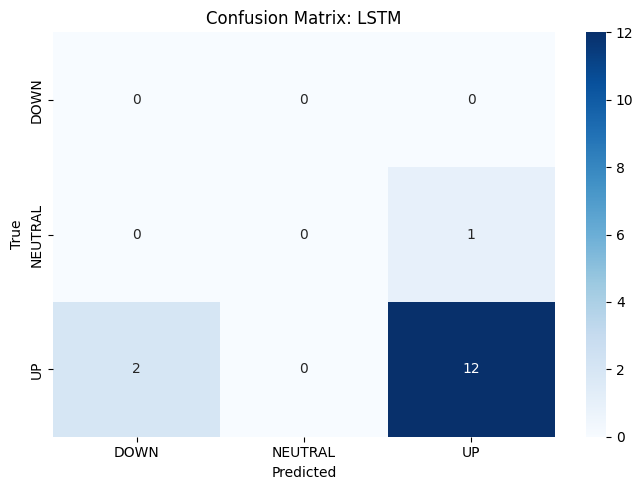

[NMDC] Results DataFrame shape: (15, 27)
[NMDC] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/NMDC_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/NMDC_results.xlsx
[NMDC] 💾 Saved results to /content/output/NMDC_results.xlsx
✅ Completed processing for NMDC
[NESTLEIND] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 0.7820 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 0.0096Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1186 - val_accuracy: 1.0000 - val_loss: 0.4412 - learning_rate: 0.0010
[NESTLEIND] ✅ Technical indicators added. Shape: (24, 73), Features: 73Epoch 36/50

[NESTLEIND] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Rang


✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1203 - val_accuracy: 1.0000 - val_loss: 0.9677 - learning_rate: 5.0000e-04
Epoch 14/50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 0.7739 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0879
Epoch 41: val_loss improved from 0.77389 to 0.76548, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5



Epoch 36: val_loss improved from 0.44116 to 0.42404, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.2460
Epoch 14: val_loss improved from 0.96769 to 0.95702, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 0.7655 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0879 - val_accuracy: 1.0000 - val_loss: 0.4240 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2460 - val_accuracy: 1.0000 - val_loss: 0.9570 - learning_rate: 5.0000e-04
Epoch 15/50

Epoch 37: val_loss improved from 0.42404 to 0.40655, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 0.1706
Epoch 15: val_loss improved from 0.95702 to 0.94666, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0066
Epoch 42: val_loss improved from 0.76548 to 0.75718, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1031 - val_accuracy: 1.0000 - val_loss: 0.4065 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1706 - val_accuracy: 1.0000 - val_loss: 0.9467 - learning_rate: 5.0000e-04
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 0.7572 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1009
Epoch 38: val_loss improved from 0.40655 to 0.39075, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1370
Epoch 16: val_loss improved from 0.94666 to 0.93699, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0062
Epoch 43: val_loss improved from 0.75718 to 0.74874, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1009 - val_accuracy: 1.0000 - val_loss: 0.3907 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 1.0000 - loss: 0.0541
Epoch 39: val_loss improved from 0.39075 to 0.37670, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1370 - val_accuracy: 1.0000 - val_loss: 0.9370 - learning_rate: 5.0000e-04
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 0.7487 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0541 - val_accuracy: 1.0000 - val_loss: 0.3767 - learning_rate: 0.0010
Epoch 40/50

Epoch 17: val_loss improved from 0.93699 to 0.92679, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1818 - loss: 1.7709
Epoch 40: val_loss improved from 0.37670 to 0.36419, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1212 - val_accuracy: 1.0000 - val_loss: 0.9268 - learning_rate: 5.0000e-04
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 0.1056
Epoch 18: val_loss improved from 0.92679 to 0.91673, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0083
Epoch 44: val_loss improved from 0.74874 to 0.74047, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0924 - val_accuracy: 1.0000 - val_loss: 0.3642 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 1.0000 - loss: 0.0663
Epoch 41: val_loss improved from 0.36419 to 0.35364, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.07727, saving model to /content/checkpoints/NESTLEIND/NESTLEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1056 - val_accuracy: 1.0000 - val_loss: 0.9167 - learning_rate: 5.0000e-04
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0083 - val_accuracy: 1.0000 - val_loss: 0.7405 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.0060
Epoch 45: val_loss improved from 0.74047 to 0.73185, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0663 - val_accuracy: 1.0000 - val_loss: 0.3536 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.1818 - loss: 1.7709 - val_accuracy: 1.0000 - val_loss: 1.0773 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 0.7319 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.1818 - loss: 1.5837
Epoch 42: val_loss improved from 0.35364 to 0.34509, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0879
Epoch 2: val_loss improved from 1.07727 to 1.06816, saving model to /content/checkpoints/NESTLEIND/NESTLEIND_lstm_model.h5



Epoch 46: val_loss improved from 0.73185 to 0.72217, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5



Epoch 19: val_loss improved from 0.91673 to 0.90600, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0718 - val_accuracy: 1.0000 - val_loss: 0.3451 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 1.0000 - val_loss: 0.7222 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1818 - loss: 1.5837 - val_accuracy: 0.0000e+00 - val_loss: 1.0682 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0879 - val_accuracy: 1.0000 - val_loss: 0.9060 - learning_rate: 5.0000e-04
Epoch 20/50

Epoch 47: val_loss improved from 0.72217 to 0.71310, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5



Epoch 3: val_loss improved from 1.06816 to 1.06292, saving model to /content/checkpoints/NESTLEIND/NESTLEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step - accuracy: 0.3636 - loss: 1.2249 - val_accuracy: 0.0000e+00 - val_loss: 1.0629 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 1.0000 - val_loss: 0.7131 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2727 - loss: 1.2035
Epoch 4: val_loss improved from 1.06292 to 1.05936, saving model to /content/checkpoints/NESTLEIND/NESTLEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0949
Epoch 43: val_loss improved from 0.34509 to 0.33949, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step - accuracy: 0.2727 - loss: 1.2035 - val_accuracy: 0.0000e+00 - val_loss: 1.0594 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.3636 - loss: 1.1036
Epoch 48: val_loss improved from 0.71310 to 0.70362, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5



Epoch 20: val_loss improved from 0.90600 to 0.89585, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5



Epoch 5: val_loss improved from 1.05936 to 1.05428, saving model to /content/checkpoints/NESTLEIND/NESTLEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0949 - val_accuracy: 1.0000 - val_loss: 0.3395 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 0.0629
Epoch 44: val_loss improved from 0.33949 to 0.33522, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 0.7036 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2132 - val_accuracy: 1.0000 - val_loss: 0.8959 - learning_rate: 5.0000e-04
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.1036 - val_accuracy: 0.0000e+00 - val_loss: 1.0543 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6364 - loss: 0.8436
Epoch 49: val_loss improved from 0.70362 to 0.69441, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5



Epoch 6: val_loss improved from 1.05428 to 1.05258, saving model to /content/checkpoints/NESTLEIND/NESTLEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0629 - val_accuracy: 1.0000 - val_loss: 0.3352 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.0492
Epoch 45: val_loss improved from 0.33522 to 0.33149, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 50/50

Epoch 21: val_loss improved from 0.89585 to 0.88566, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.8436 - val_accuracy: 0.0000e+00 - val_loss: 1.0526 - learning_rate: 0.0010
Epoch 7/50

Epoch 50: val_loss improved from 0.69441 to 0.68523, saving model to /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0492 - val_accuracy: 1.0000 - val_loss: 0.3315 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1049 - val_accuracy: 1.0000 - val_loss: 0.8857 - learning_rate: 5.0000e-04
Epoch 22/50

Epoch 46: val_loss improved from 0.33149 to 0.32909, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 0.6852 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
[PAGEIND] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5455 - loss: 0.9349Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[PAGEIND] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[PAGEIND] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]

Epoch 7: val_loss improved from 1.05258 to 1.04771, saving model to /content/checkpoints/NESTLEIND/NESTLEIND_lstm_model.h5


[PAGEIND] ✅ Loaded best model from /content/checkpoints/PAGEIND/PAGEIND_lstm_model.h5
[PAGEIND] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0441 - val_accuracy: 1.0000 - val_loss: 0.3291 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 1.0000 - loss: 0.0433
Epoch 47: val_loss improved from 0.32909 to 0.32679, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0920
Epoch 22: val_loss improved from 0.88566 to 0.87531, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.9349 - val_accuracy: 0.0000e+00 - val_loss: 1.0477 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0433 - val_accuracy: 1.0000 - val_loss: 0.3268 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0920 - val_accuracy: 1.0000 - val_loss: 0.8753 - learning_rate: 5.0000e-04
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.0854[PAGEIND] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 48: val_loss improved from 0.32679 to 0.32447, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 23: val_loss improved from 0.87531 to 0.86527, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.93      1.00      0.97        14
     NEUTRAL       0.00      0.00      0.00         1

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5455 - loss: 0.9109

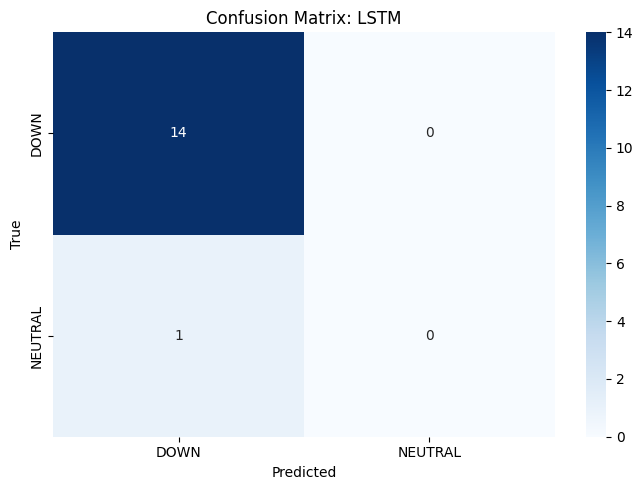

[PAGEIND] Results DataFrame shape: (15, 26)
[PAGEIND] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/PAGEIND_results.xlsx

Epoch 8: val_loss improved from 1.04771 to 1.04746, saving model to /content/checkpoints/NESTLEIND/NESTLEIND_lstm_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/PAGEIND_results.xlsx
[PAGEIND] 💾 Saved results to /content/output/PAGEIND_results.xlsx
✅ Completed processing for PAGEIND
[ADANIENT] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0459 - val_accuracy: 1.0000 - val_loss: 0.3245 - learning_rate: 0.0010
Epoch 49/50
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0854 - val_accuracy: 1.0000 - val_loss: 0.8653 - learning_rate: 5.0000e-04
[ADANIENT] ✅ Technical indicators added. Shape: (24, 73), Features: 73Epoch 24/50

[ADANIENT] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 49: val_loss improved from 0.32447 to 0.32265, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.9109 - val_accuracy: 0.0000e+00 - val_loss: 1.0475 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7273 - loss: 0.7631
Epoch 9: val_loss did not improve from 1.04746
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0499 - val_accuracy: 1.0000 - val_loss: 0.3226 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0768
Epoch 50: val_loss improved from 0.32265 to 0.32062, saving model to /content/checkpoints/ONGC/ONGC_lstm_model.h5



Epoch 24: val_loss improved from 0.86527 to 0.85539, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.7631 - val_accuracy: 0.0000e+00 - val_loss: 1.0528 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7273 - loss: 0.9901
Epoch 10: val_loss did not improve from 1.04746
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.0768 - val_accuracy: 1.0000 - val_loss: 0.8554 - learning_rate: 5.0000e-04
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0386 - val_accuracy: 1.0000 - val_loss: 0.3206 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
[ONGC] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[ONGC] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[ONGC] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 2 2 2 2 2 2 

[ONGC] ✅ Loaded best model from /content/checkpoints/ONGC/ONGC_lstm_model.h5
[ONGC] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7273 - loss: 0.7404
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: val_loss did not improve from 1.04746
[ONGC] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         1
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.87      1.00      0.93        13

    accuracy                           0.87        15
   macro avg       0.29      0.33      0.31        15
weighted avg       0.75      0.87      0.80        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7404 - val_accuracy: 0.0000e+00 - val_loss: 1.0773 - learning_rate: 0.0010
Epoch 12/50


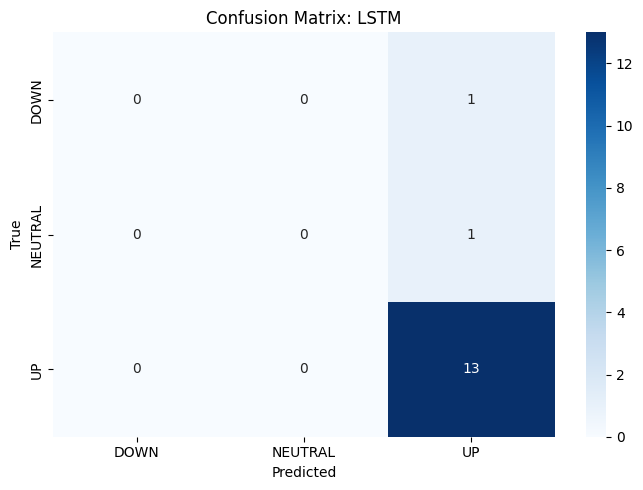

[ONGC] Results DataFrame shape: (15, 27)
[ONGC] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/ONGC_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/ONGC_results.xlsx
[ONGC] 💾 Saved results to /content/output/ONGC_results.xlsx
[NATIONALUM] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for ONGC
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[NATIONALUM] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[NATIONALUM] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - loss: 0.0477
Epoch 25: val_loss improved from 0.85539 to 0.84649, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.5415
Epoch 12: val_loss did not improve from 1.04746
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.0477 - val_accuracy: 1.0000 - val_loss: 0.8465 - learning_rate: 5.0000e-04
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.5415 - val_accuracy: 0.0000e+00 - val_loss: 1.0818 - learning_rate: 5.0000e-04
Epoch 13/50

Epoch 26: val_loss improved from 0.84649 to 0.83878, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0727 - val_accuracy: 1.0000 - val_loss: 0.8388 - learning_rate: 5.0000e-04
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5455 - loss: 0.8134
Epoch 27: val_loss improved from 0.83878 to 0.82914, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5



Epoch 13: val_loss did not improve from 1.04746
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.8134 - val_accuracy: 0.0000e+00 - val_loss: 1.0839 - learning_rate: 5.0000e-04
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.
[NESTLEIND] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0658 - val_accuracy: 1.0000 - val_loss: 0.8291 - learning_rate: 5.0000e-04
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.0909 - loss: 2.3825Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[NESTLEIND] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[NESTLEIND] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 2 0 0 0 2 0 0 0 0 2 2 0 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 0.0728
Epoch 28: val_los

[NESTLEIND] ✅ Loaded best model from /content/checkpoints/NESTLEIND/NESTLEIND_lstm_model.h5
[NESTLEIND] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0728 - val_accuracy: 1.0000 - val_loss: 0.8197 - learning_rate: 5.0000e-04
Epoch 29/50

Epoch 1: val_loss improved from inf to 1.16970, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.0538[NESTLEIND] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 29: val_loss improved from 0.81971 to 0.81026, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.67      1.00      0.80        10
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         4

    accuracy                           0.67        15
   macro avg       0.22      0.33      0.27        15
weighted avg       0.44      0.67      0.53        15



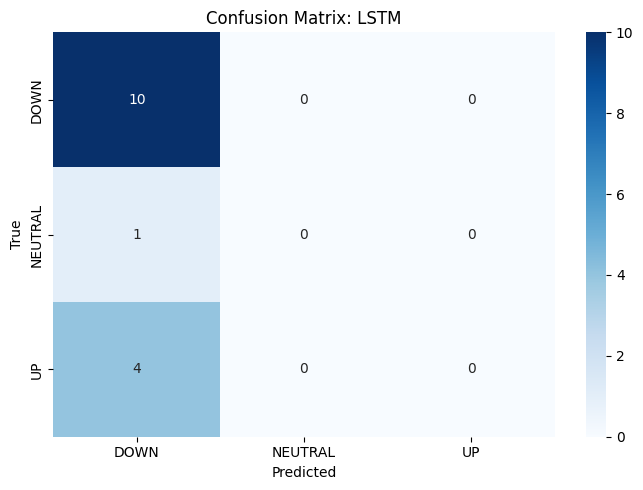

[NESTLEIND] Results DataFrame shape: (15, 27)
[NESTLEIND] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/NESTLEIND_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/NESTLEIND_results.xlsx
[NESTLEIND] 💾 Saved results to /content/output/NESTLEIND_results.xlsx
✅ Completed processing for NESTLEIND
[MUTHOOTFIN] ✅ Set DatetimeIndex. Index range: 2024-07-29 00:00:00 to 2024-08-30 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.0909 - loss: 2.3825 - val_accuracy: 0.0000e+00 - val_loss: 1.1697 - learning_rate: 0.0010
Epoch 2/50
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[MUTHOOTFIN] ✅ Technical indicators added. Shape: (24, 73), Features: 73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.1818 - loss: 2.0265Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 -

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1818 - loss: 2.0265 - val_accuracy: 0.0000e+00 - val_loss: 1.1792 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 969ms/step - accuracy: 1.0000 - loss: 0.0614
Epoch 3: val_loss did not improve from 1.16970

Epoch 30: val_loss improved from 0.81026 to 0.80061, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.6985 - val_accuracy: 0.0000e+00 - val_loss: 1.1812 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0614 - val_accuracy: 1.0000 - val_loss: 0.8006 - learning_rate: 5.0000e-04
Epoch 31/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.16970
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 1.0000 - loss: 0.0485
Epoch 31: val_loss improved from 0.80061 to 0.79172, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1818 - loss: 1.6932 - val_accuracy: 0.0000e+00 - val_loss: 1.1809 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3636 - loss: 1.5283
Epoch 5: val_loss did not improve from 1.16970

Epoch 1: val_loss improved from inf to 1.40497, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0485 - val_accuracy: 1.0000 - val_loss: 0.7917 - learning_rate: 5.0000e-04
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0841
Epoch 32: val_loss improved from 0.79172 to 0.78220, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.5283 - val_accuracy: 0.0000e+00 - val_loss: 1.1739 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.4545 - loss: 0.9933
Epoch 6: val_loss improved from 1.16970 to 1.15988, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.2727 - loss: 2.4107 - val_accuracy: 0.0000e+00 - val_loss: 1.4050 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.1818 - loss: 2.0628
Epoch 2: val_loss improved from 1.40497 to 1.37955, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0841 - val_accuracy: 1.0000 - val_loss: 0.7822 - learning_rate: 5.0000e-04
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 0.9933 - val_accuracy: 0.0000e+00 - val_loss: 1.1599 - learning_rate: 5.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.3636 - loss: 1.4728
Epoch 7: val_loss improved from 1.15988 to 1.13808, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1818 - loss: 2.0628 - val_accuracy: 0.0000e+00 - val_loss: 1.3796 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0513
Epoch 33: val_loss improved from 0.78220 to 0.77200, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.4728 - val_accuracy: 0.0000e+00 - val_loss: 1.1381 - learning_rate: 5.0000e-04
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0513 - val_accuracy: 1.0000 - val_loss: 0.7720 - learning_rate: 5.0000e-04
Epoch 34/50

Epoch 3: val_loss improved from 1.37955 to 1.36093, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 1.8033 - val_accuracy: 0.0000e+00 - val_loss: 1.3609 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3636 - loss: 1.6056
Epoch 4: val_loss improved from 1.36093 to 1.35471, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5



Epoch 8: val_loss improved from 1.13808 to 1.12370, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3636 - loss: 1.6860
Epoch 34: val_loss improved from 0.77200 to 0.76195, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3636 - loss: 1.6056 - val_accuracy: 0.0000e+00 - val_loss: 1.1237 - learning_rate: 5.0000e-04
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.5990 - val_accuracy: 0.0000e+00 - val_loss: 1.3547 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4545 - loss: 1.4353
Epoch 9: val_loss improved from 1.12370 to 1.11310, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5



Epoch 5: val_loss improved from 1.35471 to 1.33203, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0475 - val_accuracy: 1.0000 - val_loss: 0.7620 - learning_rate: 5.0000e-04
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 1.0000 - loss: 0.0372
Epoch 35: val_loss improved from 0.76195 to 0.75260, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.11792, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 1.0970 - val_accuracy: 0.0000e+00 - val_loss: 1.1131 - learning_rate: 5.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.4353 - val_accuracy: 0.0000e+00 - val_loss: 1.3320 - learning_rate: 0.0010
Epoch 10/50
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0372 - val_accuracy: 1.0000 - val_loss: 0.7526 - learning_rate: 5.0000e-04
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.3636 - loss: 1.6860 - val_accuracy: 0.0000e+00 - val_loss: 1.1179 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0588
Epoch 36: val_loss improved from 0.75260 to 0.74192, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5



Epoch 2: val_loss improved from 1.11792 to 1.09552, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step - accuracy: 1.0000 - loss: 0.0588 - val_accuracy: 1.0000 - val_loss: 0.7419 - learning_rate: 5.0000e-04
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step - accuracy: 0.2727 - loss: 1.1560 - val_accuracy: 0.0000e+00 - val_loss: 1.0955 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 0.0375
Epoch 10: val_loss improved from 1.11310 to 1.10106, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5



Epoch 37: val_loss improved from 0.74192 to 0.73189, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5



Epoch 6: val_loss improved from 1.33203 to 1.32127, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.3636 - loss: 1.3105
Epoch 3: val_loss improved from 1.09552 to 1.07403, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0375 - val_accuracy: 1.0000 - val_loss: 0.7319 - learning_rate: 5.0000e-04
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.2880 - val_accuracy: 0.0000e+00 - val_loss: 1.1011 - learning_rate: 5.0000e-04
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5455 - loss: 1.4172 - val_accuracy: 0.0000e+00 - val_loss: 1.3213 - learning_rate: 0.0010
Epoch 7/50

Epoch 11: val_loss improved from 1.10106 to 1.08910, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5

Epoch 38: val_loss improved from 0.73189 to 0.72255, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.3105 - val_accuracy: 0.0000e+00 - val_loss: 1.0740 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.3636 - loss: 1.1574
Epoch 4: val_loss improved from 1.07403 to 1.04956, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.4440 - val_accuracy: 0.0000e+00 - val_loss: 1.0891 - learning_rate: 5.0000e-04
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0467 - val_accuracy: 1.0000 - val_loss: 0.7225 - learning_rate: 5.0000e-04
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.3636 - loss: 1.3522
Epoch 39: val_loss improved from 0.72255 to 0.71288, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5



Epoch 12: val_loss improved from 1.08910 to 1.07909, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.1574 - val_accuracy: 1.0000 - val_loss: 1.0496 - learning_rate: 0.0010
Epoch 5/50

Epoch 7: val_loss improved from 1.32127 to 1.31070, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7273 - loss: 0.7150
Epoch 5: val_loss improved from 1.04956 to 1.01961, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0455 - val_accuracy: 1.0000 - val_loss: 0.7129 - learning_rate: 5.0000e-04
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.3522 - val_accuracy: 0.0000e+00 - val_loss: 1.0791 - learning_rate: 5.0000e-04
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.9047 - val_accuracy: 0.0000e+00 - val_loss: 1.3107 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7150 - val_accuracy: 1.0000 - val_loss: 1.0196 - learning_rate: 0.0010
Epoch 6/50

Epoch 40: val_loss improved from 0.71288 to 0.70335, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step - accuracy: 1.0000 - loss: 0.0340 - val_accuracy: 1.0000 - val_loss: 0.7033 - learning_rate: 5.0000e-04
Epoch 41/50

Epoch 6: val_loss improved from 1.01961 to 0.99190, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0571
Epoch 41: val_loss improved from 0.70335 to 0.69470, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step - accuracy: 0.9091 - loss: 0.5279 - val_accuracy: 1.0000 - val_loss: 0.9919 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step - accuracy: 1.0000 - loss: 0.0571 - val_accuracy: 1.0000 - val_loss: 0.6947 - learning_rate: 5.0000e-04
Epoch 42/50

Epoch 13: val_loss improved from 1.07909 to 1.06927, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5



Epoch 8: val_loss improved from 1.31070 to 1.29830, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 1.0000 - loss: 0.4834
Epoch 7: val_loss improved from 0.99190 to 0.96369, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.1981 - val_accuracy: 0.0000e+00 - val_loss: 1.0693 - learning_rate: 5.0000e-04
Epoch 14/50

Epoch 42: val_loss improved from 0.69470 to 0.68658, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 1.1181 - val_accuracy: 0.0000e+00 - val_loss: 1.2983 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4545 - loss: 1.1650
Epoch 9: val_loss improved from 1.29830 to 1.28056, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5



Epoch 14: val_loss improved from 1.06927 to 1.06020, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.4834 - val_accuracy: 1.0000 - val_loss: 0.9637 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0291 - val_accuracy: 1.0000 - val_loss: 0.6866 - learning_rate: 5.0000e-04
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 0.8647 - val_accuracy: 0.0000e+00 - val_loss: 1.0602 - learning_rate: 5.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.1650 - val_accuracy: 0.0000e+00 - val_loss: 1.2806 - learning_rate: 0.0010
Epoch 15/50
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4545 - loss: 1.0018
Epoch 15: val_loss improved from 1.06020 to 1.05159, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5



Epoch 10: val_loss improved from 1.28056 to 1.25916, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step - accuracy: 0.4545 - loss: 1.0018 - val_accuracy: 0.0000e+00 - val_loss: 1.0516 - learning_rate: 5.0000e-04
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step - accuracy: 0.7273 - loss: 0.9628 - val_accuracy: 0.0000e+00 - val_loss: 1.2592 - learning_rate: 0.0010
Epoch 11/50

Epoch 8: val_loss improved from 0.96369 to 0.93099, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0247
Epoch 43: val_loss improved from 0.68658 to 0.67946, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.6364 - loss: 0.7800
Epoch 16: val_loss improved from 1.05159 to 1.04384, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5



Epoch 11: val_loss improved from 1.25916 to 1.24567, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.5088 - val_accuracy: 1.0000 - val_loss: 0.9310 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9091 - loss: 0.3953
Epoch 9: val_loss improved from 0.93099 to 0.89860, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0247 - val_accuracy: 1.0000 - val_loss: 0.6795 - learning_rate: 5.0000e-04
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.8887 - val_accuracy: 0.0000e+00 - val_loss: 1.2457 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7800 - val_accuracy: 0.0000e+00 - val_loss: 1.0438 - learning_rate: 5.0000e-04
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7273 - loss: 0.7540
Epoch 12: val_loss improved from 1.24567 to 1.23627, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3953 - val_accuracy: 1.0000 - val_loss: 0.8986 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 1.0000 - loss: 0.0281
Epoch 10: val_loss improved from 0.89860 to 0.87076, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.4545 - loss: 1.0909
Epoch 44: val_loss improved from 0.67946 to 0.67194, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7540 - val_accuracy: 0.0000e+00 - val_loss: 1.2363 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.4545 - loss: 0.9954
Epoch 17: val_loss improved from 1.04384 to 1.03452, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5



Epoch 13: val_loss improved from 1.23627 to 1.22374, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3162 - val_accuracy: 1.0000 - val_loss: 0.8708 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0281 - val_accuracy: 1.0000 - val_loss: 0.6719 - learning_rate: 5.0000e-04
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.0909 - val_accuracy: 0.0000e+00 - val_loss: 1.0345 - learning_rate: 5.0000e-04
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 0.9954 - val_accuracy: 0.0000e+00 - val_loss: 1.2237 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7273 - loss: 0.9603
Epoch 18: val_loss improved from 1.03452 to 1.02504, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5



Epoch 14: val_loss improved from 1.22374 to 1.20823, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step - accuracy: 0.5455 - loss: 1.0026 - val_accuracy: 0.0000e+00 - val_loss: 1.0250 - learning_rate: 5.0000e-04
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step - accuracy: 0.7273 - loss: 0.9603 - val_accuracy: 0.0000e+00 - val_loss: 1.2082 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0273
Epoch 11: val_loss improved from 0.87076 to 0.84294, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5



Epoch 45: val_loss improved from 0.67194 to 0.66508, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5



Epoch 19: val_loss improved from 1.02504 to 1.01647, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.8182 - loss: 0.6938
Epoch 15: val_loss improved from 1.20823 to 1.19396, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2693 - val_accuracy: 1.0000 - val_loss: 0.8429 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.0134 - val_accuracy: 0.0000e+00 - val_loss: 1.0165 - learning_rate: 5.0000e-04
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0273 - val_accuracy: 1.0000 - val_loss: 0.6651 - learning_rate: 5.0000e-04
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6938 - val_accuracy: 0.0000e+00 - val_loss: 1.1940 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7273 - loss: 0.6972
Epoch 16: val_loss improved from 1.19396 to 1.18155, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step - accuracy: 0.7273 - loss: 0.6972 - val_accuracy: 0.0000e+00 - val_loss: 1.1815 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6364 - loss: 0.9139
Epoch 17: val_loss improved from 1.18155 to 1.16939, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1672
Epoch 12: val_loss improved from 0.84294 to 0.81876, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step - accuracy: 0.6364 - loss: 0.9139 - val_accuracy: 0.0000e+00 - val_loss: 1.1694 - learning_rate: 0.0010
Epoch 18/50

Epoch 20: val_loss improved from 1.01647 to 1.00470, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5



Epoch 46: val_loss improved from 0.66508 to 0.65886, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1672 - val_accuracy: 1.0000 - val_loss: 0.8188 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 1.0000 - loss: 0.1875
Epoch 18: val_loss improved from 1.16939 to 1.15227, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0325 - val_accuracy: 1.0000 - val_loss: 0.6589 - learning_rate: 5.0000e-04
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.8133 - val_accuracy: 1.0000 - val_loss: 1.0047 - learning_rate: 5.0000e-04
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 1.0000 - loss: 0.0188
Epoch 13: val_loss improved from 0.81876 to 0.79890, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5



Epoch 21: val_loss improved from 1.00470 to 0.99472, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5

Epoch 47: val_loss improved from 0.65886 to 0.65277, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6420 - val_accuracy: 0.0000e+00 - val_loss: 1.1523 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1875 - val_accuracy: 1.0000 - val_loss: 0.7989 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.2268
Epoch 19: val_loss improved from 1.15227 to 1.13865, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.7875 - val_accuracy: 1.0000 - val_loss: 0.9947 - learning_rate: 5.0000e-04
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0188 - val_accuracy: 1.0000 - val_loss: 0.6528 - learning_rate: 5.0000e-04
Epoch 48/50

Epoch 14: val_loss improved from 0.79890 to 0.78130, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5455 - loss: 0.9980
Epoch 22: val_loss improved from 0.99472 to 0.98301, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6406 - val_accuracy: 0.0000e+00 - val_loss: 1.1387 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2268 - val_accuracy: 1.0000 - val_loss: 0.7813 - learning_rate: 0.0010
Epoch 15/50

Epoch 20: val_loss improved from 1.13865 to 1.12412, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.9980 - val_accuracy: 1.0000 - val_loss: 0.9830 - learning_rate: 5.0000e-04
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0273
Epoch 15: val_loss improved from 0.78130 to 0.76440, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5



Epoch 23: val_loss improved from 0.98301 to 0.97077, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5



Epoch 48: val_loss improved from 0.65277 to 0.64774, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6038 - val_accuracy: 0.0000e+00 - val_loss: 1.1241 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8182 - loss: 0.4963
Epoch 21: val_loss improved from 1.12412 to 1.10889, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0999 - val_accuracy: 1.0000 - val_loss: 0.7644 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.8901 - val_accuracy: 1.0000 - val_loss: 0.9708 - learning_rate: 5.0000e-04
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0273 - val_accuracy: 1.0000 - val_loss: 0.6477 - learning_rate: 5.0000e-04
Epoch 49/50

Epoch 24: val_loss improved from 0.97077 to 0.95941, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4963 - val_accuracy: 0.0000e+00 - val_loss: 1.1089 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step - accuracy: 0.9091 - loss: 0.6513 - val_accuracy: 1.0000 - val_loss: 0.9594 - learning_rate: 5.0000e-04
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6364 - loss: 0.6257
Epoch 22: val_loss improved from 1.10889 to 1.09522, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5



Epoch 25: val_loss improved from 0.95941 to 0.94894, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0279
Epoch 16: val_loss improved from 0.76440 to 0.74434, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4382 - val_accuracy: 0.0000e+00 - val_loss: 1.0952 - learning_rate: 0.0010
Epoch 23/50

Epoch 49: val_loss improved from 0.64774 to 0.64227, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.6257 - val_accuracy: 1.0000 - val_loss: 0.9489 - learning_rate: 5.0000e-04
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7273 - loss: 0.5685
Epoch 26: val_loss improved from 0.94894 to 0.93906, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1746 - val_accuracy: 1.0000 - val_loss: 0.7443 - learning_rate: 0.0010
Epoch 17/50

Epoch 23: val_loss improved from 1.09522 to 1.07469, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0279 - val_accuracy: 1.0000 - val_loss: 0.6423 - learning_rate: 5.0000e-04
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 0.9174 - val_accuracy: 1.0000 - val_loss: 0.9391 - learning_rate: 5.0000e-04
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5685 - val_accuracy: 0.0000e+00 - val_loss: 1.0747 - learning_rate: 0.0010
Epoch 24/50

Epoch 27: val_loss improved from 0.93906 to 0.92688, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step - accuracy: 0.7273 - loss: 0.6365 - val_accuracy: 1.0000 - val_loss: 0.9269 - learning_rate: 5.0000e-04
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0268
Epoch 17: val_loss improved from 0.74434 to 0.72738, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5



Epoch 28: val_loss improved from 0.92688 to 0.91684, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5



Epoch 50: val_loss improved from 0.64227 to 0.63646, saving model to /content/checkpoints/SAIL/SAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1205 - val_accuracy: 1.0000 - val_loss: 0.7274 - learning_rate: 0.0010
Epoch 18/50

Epoch 24: val_loss improved from 1.07469 to 1.05584, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6054 - val_accuracy: 1.0000 - val_loss: 0.9168 - learning_rate: 5.0000e-04
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0268 - val_accuracy: 1.0000 - val_loss: 0.6365 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 50.

Epoch 18: val_loss improved from 0.72738 to 0.71041, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5



Epoch 29: val_loss improved from 0.91684 to 0.91035, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4751 - val_accuracy: 1.0000 - val_loss: 1.0558 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1242 - val_accuracy: 1.0000 - val_loss: 0.7104 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6474 - val_accuracy: 1.0000 - val_loss: 0.9104 - learning_rate: 5.0000e-04
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6364 - loss: 0.6595
Epoch 30: val_loss improved from 0.91035 to 0.90467, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 1.0000 - loss: 0.0581[SAIL] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[SAIL] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[SAIL] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 1]

Epoch 19: val_loss improved from 0.71041 to 0.69446, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


[SAIL] ✅ Loaded best model from /content/checkpoints/SAIL/SAIL_lstm_model.h5
[SAIL] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step - accuracy: 0.6364 - loss: 0.6595 - val_accuracy: 1.0000 - val_loss: 0.9047 - learning_rate: 5.0000e-04
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0581 - val_accuracy: 1.0000 - val_loss: 0.6945 - learning_rate: 0.0010
Epoch 20/50

Epoch 31: val_loss improved from 0.90467 to 0.89964, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5



Epoch 25: val_loss improved from 1.05584 to 1.03731, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 1.0000 - loss: 0.1066
Epoch 20: val_loss improved from 0.69446 to 0.67798, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


[SAIL] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

     NEUTRAL       0.00      0.00      0.00         1
          UP       0.93      1.00      0.97        14

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6787 - val_accuracy: 1.0000 - val_loss: 0.8996 - learning_rate: 5.0000e-04
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3871 - val_accuracy: 1.0000 - val_loss: 1.0373 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1066 - val_accuracy: 1.0000 - val_loss: 0.6780 - learning_rate: 0.0010
Epoch 21/50


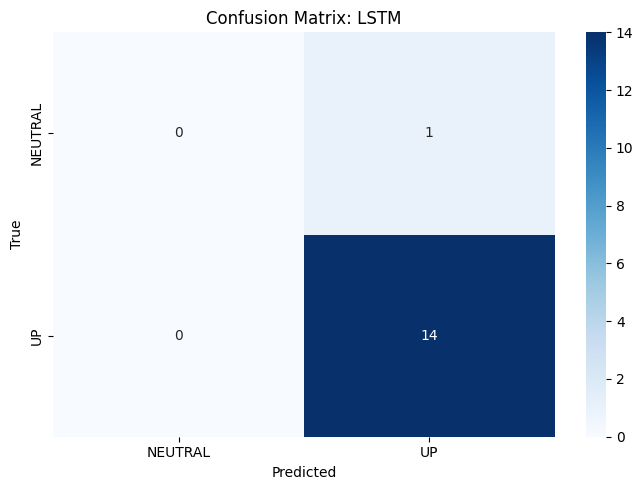

[SAIL] Results DataFrame shape: (15, 26)
[SAIL] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/SAIL_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/SAIL_results.xlsx
[SAIL] 💾 Saved results to /content/output/SAIL_results.xlsx
[MRF] ✅ Set DatetimeIndex. Index range: 2024-07-29 00:00:00 to 2024-08-30 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for SAIL

Epoch 26: val_loss improved from 1.03731 to 1.02084, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[MRF] ✅ Technical indicators added. Shape: (24, 73), Features: 73
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4594 - val_accuracy: 1.0000 - val_loss: 1.0208 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.6198
Epoch 27: val_loss improved from 1.02084 to 1.00965, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5



Epoch 32: val_loss improved from 0.89964 to 0.89551, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0877


Epoch 21: val_loss improved from 0.67798 to 0.66331, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4907 - val_accuracy: 1.0000 - val_loss: 1.0096 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.6198 - val_accuracy: 1.0000 - val_loss: 0.8955 - learning_rate: 5.0000e-04
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0877 - val_accuracy: 1.0000 - val_loss: 0.6633 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5455 - loss: 0.6761
Epoch 28: val_loss improved from 1.00965 to 0.99971, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5



Epoch 33: val_loss improved from 0.89551 to 0.89459, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1006
Epoch 22: val_loss improved from 0.66331 to 0.64997, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2861 - val_accuracy: 1.0000 - val_loss: 0.9997 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5455 - loss: 0.6761 - val_accuracy: 1.0000 - val_loss: 0.8946 - learning_rate: 5.0000e-04
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1006 - val_accuracy: 1.0000 - val_loss: 0.6500 - learning_rate: 0.0010
Epoch 23/50

Epoch 34: val_loss improved from 0.89459 to 0.89346, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 0.0719
Epoch 23: val_loss improved from 0.64997 to 0.63638, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.8182 - loss: 0.6028
Epoch 29: val_loss improved from 0.99971 to 0.99010, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.7306 - val_accuracy: 1.0000 - val_loss: 0.8935 - learning_rate: 5.0000e-04
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6364 - loss: 0.6800
Epoch 35: val_loss improved from 0.89346 to 0.89208, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0719 - val_accuracy: 1.0000 - val_loss: 0.6364 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.6028 - val_accuracy: 1.0000 - val_loss: 0.9901 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8182 - loss: 0.5357
Epoch 30: val_loss improved from 0.99010 to 0.98127, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.6800 - val_accuracy: 1.0000 - val_loss: 0.8921 - learning_rate: 5.0000e-04
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7273 - loss: 0.4488
Epoch 24: val_loss improved from 0.63638 to 0.62317, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5



Epoch 36: val_loss improved from 0.89208 to 0.89200, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5357 - val_accuracy: 1.0000 - val_loss: 0.9813 - learning_rate: 0.0010
Epoch 31/50

Epoch 1: val_loss improved from inf to 1.02512, saving model to /content/checkpoints/MRF/MRF_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0615 - val_accuracy: 1.0000 - val_loss: 0.6232 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4488 - val_accuracy: 1.0000 - val_loss: 0.8920 - learning_rate: 5.0000e-04
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.2727 - loss: 1.3750 - val_accuracy: 1.0000 - val_loss: 1.0251 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9091 - loss: 0.6254
Epoch 2: val_loss improved from 1.02512 to 1.01467, saving model to /content/checkpoints/MRF/MRF_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3468
Epoch 31: val_loss improved from 0.98127 to 0.97343, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step - accuracy: 0.9091 - loss: 0.6254 - val_accuracy: 1.0000 - val_loss: 1.0147 - learning_rate: 0.0010
Epoch 3/50

Epoch 25: val_loss improved from 0.62317 to 0.60816, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3468 - val_accuracy: 1.0000 - val_loss: 0.9734 - learning_rate: 0.0010
Epoch 32/50

Epoch 37: val_loss improved from 0.89200 to 0.89030, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0653 - val_accuracy: 1.0000 - val_loss: 0.6082 - learning_rate: 0.0010
Epoch 26/50

Epoch 3: val_loss improved from 1.01467 to 0.98965, saving model to /content/checkpoints/MRF/MRF_lstm_model.h5



Epoch 32: val_loss improved from 0.97343 to 0.96677, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5300 - val_accuracy: 1.0000 - val_loss: 0.8903 - learning_rate: 5.0000e-04
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.7273 - loss: 0.6672
Epoch 26: val_loss improved from 0.60816 to 0.59333, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.4782 - val_accuracy: 1.0000 - val_loss: 0.9897 - learning_rate: 0.0010
Epoch 4/50

Epoch 38: val_loss improved from 0.89030 to 0.88865, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4597 - val_accuracy: 1.0000 - val_loss: 0.9668 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9091 - loss: 0.3283
Epoch 4: val_loss improved from 0.98965 to 0.98118, saving model to /content/checkpoints/MRF/MRF_lstm_model.h5



Epoch 33: val_loss improved from 0.96677 to 0.95943, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0597 - val_accuracy: 1.0000 - val_loss: 0.5933 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6672 - val_accuracy: 1.0000 - val_loss: 0.8887 - learning_rate: 5.0000e-04
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2880 - val_accuracy: 1.0000 - val_loss: 0.9812 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3283 - val_accuracy: 1.0000 - val_loss: 0.9594 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8182 - loss: 0.2768
Epoch 5: val_loss improved from 0.98118 to 0.97741, saving model to /content/checkpoints/MRF/MRF_lstm_model.h5



Epoch 34: val_loss improved from 0.95943 to 0.95087, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step - accuracy: 0.8182 - loss: 0.5020 - val_accuracy: 1.0000 - val_loss: 0.9774 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step - accuracy: 0.8182 - loss: 0.2768 - val_accuracy: 1.0000 - val_loss: 0.9509 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9091 - loss: 0.2887
Epoch 6: val_loss improved from 0.97741 to 0.97413, saving model to /content/checkpoints/MRF/MRF_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.5516
Epoch 27: val_loss improved from 0.59333 to 0.57776, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5



Epoch 39: val_loss improved from 0.88865 to 0.88489, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step - accuracy: 0.9091 - loss: 0.2887 - val_accuracy: 1.0000 - val_loss: 0.9741 - learning_rate: 0.0010
Epoch 7/50

Epoch 35: val_loss improved from 0.95087 to 0.94255, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0641 - val_accuracy: 1.0000 - val_loss: 0.5778 - learning_rate: 0.0010
Epoch 28/50

Epoch 7: val_loss did not improve from 0.97413
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.5516 - val_accuracy: 1.0000 - val_loss: 0.8849 - learning_rate: 5.0000e-04
Epoch 40/50

Epoch 28: val_loss improved from 0.57776 to 0.56307, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2968 - val_accuracy: 1.0000 - val_loss: 0.9425 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step - accuracy: 1.0000 - loss: 0.1494 - val_accuracy: 1.0000 - val_loss: 0.9754 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0711 - val_accuracy: 1.0000 - val_loss: 0.5631 - learning_rate: 0.0010
Epoch 29/50

Epoch 8: val_loss did not improve from 0.97413

Epoch 36: val_loss improved from 0.94255 to 0.93503, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step - accuracy: 1.0000 - loss: 0.1065 - val_accuracy: 1.0000 - val_loss: 0.9759 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.4727
Epoch 29: val_loss improved from 0.56307 to 0.54960, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step - accuracy: 0.9091 - loss: 0.2154 - val_accuracy: 1.0000 - val_loss: 0.9350 - learning_rate: 0.0010


Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9091 - loss: 0.3006
Epoch 40: val_loss improved from 0.88489 to 0.88298, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5



Epoch 37: val_loss improved from 0.93503 to 0.92819, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 1.0000 - loss: 0.1252
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: val_loss did not improve from 0.97413
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0327 - val_accuracy: 1.0000 - val_loss: 0.5496 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.4727 - val_accuracy: 1.0000 - val_loss: 0.8830 - learning_rate: 5.0000e-04
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3006 - val_accuracy: 1.0000 - val_loss: 0.9282 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1252 - val_accuracy: 1.0000 - val_loss: 0.9758 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 0.2489
Epoch 38: val_loss improved from 0.92819 to 0.92109, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 1.0000 - loss: 0.2489 - val_accuracy: 1.0000 - val_loss: 0.9211 - learning_rate: 0.0010
Epoch 39/50

Epoch 10: val_loss did not improve from 0.97413
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9091 - loss: 0.1733
Epoch 39: val_loss improved from 0.92109 to 0.91436, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step - accuracy: 1.0000 - loss: 0.1016 - val_accuracy: 1.0000 - val_loss: 0.9771 - learning_rate: 5.0000e-04
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5455 - loss: 0.6440
Epoch 11: val_loss did not improve from 0.97413

Epoch 30: val_loss improved from 0.54960 to 0.53688, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step - accuracy: 0.9091 - loss: 0.1733 - val_accuracy: 1.0000 - val_loss: 0.9144 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8182 - loss: 0.3889
Epoch 41: val_loss improved from 0.88298 to 0.87978, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5



Epoch 40: val_loss improved from 0.91436 to 0.90757, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0882 - val_accuracy: 1.0000 - val_loss: 0.9769 - learning_rate: 5.0000e-04
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.
[MRF] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[MRF] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0815 - val_accuracy: 1.0000 - val_loss: 0.5369 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 0.0284

[MRF] ✅ Loaded best model from /content/checkpoints/MRF/MRF_lstm_model.h5
[MRF] Predicting for 15 dates, including 30-07-2025

Epoch 31: val_loss improved from 0.53688 to 0.52507, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5455 - loss: 0.6440 - val_accuracy: 1.0000 - val_loss: 0.8798 - learning_rate: 5.0000e-04
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3889 - val_accuracy: 1.0000 - val_loss: 0.9076 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0284 - val_accuracy: 1.0000 - val_loss: 0.5251 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.8182 - loss: 0.4821[MRF] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 1.0000 - loss: 0.0338
Epoch 42: val_loss improved from 0.87978 to 0.87475, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.9091 - loss: 0.2153
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.93      1.00      0.97        14
     NEUTRAL       0.00      0.00      0.00         1

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15


Epoch 32: val_loss improved from 0.52507 to 0.51335, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5



Epoch 41: val_loss improved from 0.90757 to 0.90108, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


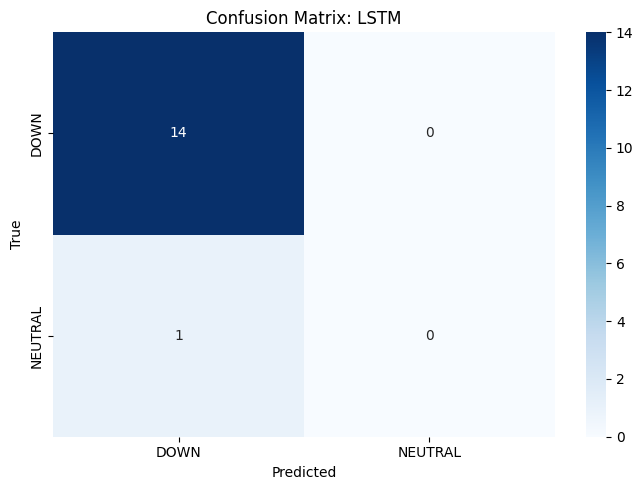

[MRF] Results DataFrame shape: (15, 26)
[MRF] Prediction dates: [Timestamp('2024-08-12 00:00:00'), Timestamp('2024-08-13 00:00:00'), Timestamp('2024-08-14 00:00:00'), Timestamp('2024-08-16 00:00:00'), Timestamp('2024-08-19 00:00:00'), Timestamp('2024-08-20 00:00:00'), Timestamp('2024-08-21 00:00:00'), Timestamp('2024-08-22 00:00:00'), Timestamp('2024-08-23 00:00:00'), Timestamp('2024-08-26 00:00:00'), Timestamp('2024-08-27 00:00:00'), Timestamp('2024-08-28 00:00:00'), Timestamp('2024-08-29 00:00:00'), Timestamp('2024-08-30 00:00:00'), Timestamp('2025-07-30 00:00:00')]
Excel report successfully generated: /content/output/MRF_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/MRF_results.xlsx
[MRF] 💾 Saved results to /content/output/MRF_results.xlsx
✅ Completed processing for MRF
[SBIN] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4821 - val_accuracy: 1.0000 - val_loss: 0.8748 - learning_rate: 5.0000e-04
Epoch 43/50
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[SBIN] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[SBIN] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0338 - val_accuracy: 1.0000 - val_loss: 0.5134 - learning_rate: 0.0010
Epoch 33/50
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
P

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50

Epoch 43: val_loss improved from 0.87475 to 0.87215, saving model to /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step - accuracy: 0.9091 - loss: 0.4350 - val_accuracy: 1.0000 - val_loss: 0.8722 - learning_rate: 5.0000e-04
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 948ms/step - accuracy: 0.8182 - loss: 0.3198
Epoch 33: val_loss improved from 0.51335 to 0.50247, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5



Epoch 44: val_loss did not improve from 0.87215

Epoch 42: val_loss improved from 0.90108 to 0.89325, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4725 - val_accuracy: 1.0000 - val_loss: 0.8724 - learning_rate: 5.0000e-04
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0295 - val_accuracy: 1.0000 - val_loss: 0.5025 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3198 - val_accuracy: 1.0000 - val_loss: 0.8932 - learning_rate: 0.0010
Epoch 43/50

Epoch 45: val_loss did not improve from 0.87215
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4763 - val_accuracy: 1.0000 - val_loss: 0.8763 - learning_rate: 5.0000e-04
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2371
Epoch 34: val_loss improved from 0.50247 to 0.49107, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5



Epoch 43: val_loss improved from 0.89325 to 0.88673, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0511 - val_accuracy: 1.0000 - val_loss: 0.4911 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2371 - val_accuracy: 1.0000 - val_loss: 0.8867 - learning_rate: 0.0010
Epoch 44/50

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 46: val_loss did not improve from 0.87215

Epoch 35: val_loss improved from 0.49107 to 0.48151, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.4348 - val_accuracy: 1.0000 - val_loss: 0.8769 - learning_rate: 5.0000e-04
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1816
Epoch 47: val_loss did not improve from 0.87215
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0520 - val_accuracy: 1.0000 - val_loss: 0.4815 - learning_rate: 0.0010
Epoch 36/50

Epoch 44: val_loss improved from 0.88673 to 0.88021, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step - accuracy: 0.9091 - loss: 0.4085 - val_accuracy: 1.0000 - val_loss: 0.8762 - learning_rate: 2.5000e-04
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1816 - val_accuracy: 1.0000 - val_loss: 0.8802 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9091 - loss: 0.3807
Epoch 48: val_loss did not improve from 0.87215
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0238
Epoch 36: val_loss improved from 0.48151 to 0.47190, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5



Epoch 45: val_loss improved from 0.88021 to 0.87338, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.02458, saving model to /content/checkpoints/SBIN/SBIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3807 - val_accuracy: 1.0000 - val_loss: 0.8750 - learning_rate: 2.5000e-04
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 43.
[ADANIENT] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[ADANIENT] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[ADANIENT] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 2 0 0 0 2 0 0 0 0 0 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0238 - val_accuracy: 1.0000 - val_loss: 0.4719 - learning_rate: 0.0010
Epoch 37/50


[ADANIENT] ✅ Loaded best model from /content/checkpoints/ADANIENT/ADANIENT_lstm_model.h5
[ADANIENT] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3246 - val_accuracy: 1.0000 - val_loss: 0.8734 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.4545 - loss: 1.0301 - val_accuracy: 1.0000 - val_loss: 1.0246 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6364 - loss: 0.7424
Epoch 2: val_loss improved from 1.02458 to 0.98442, saving model to /content/checkpoints/SBIN/SBIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step - accuracy: 0.6364 - loss: 0.7424 - val_accuracy: 1.0000 - val_loss: 0.9844 - learning_rate: 0.0010
Epoch 3/50
[ADANIENT] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.80      1.00      0.89        12
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         2

    accuracy                           0.80        15
   macro avg       0.27      0.33      0.30        15
weighted avg       0.64      0.80      0.71        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.3636 - loss: 0.8787

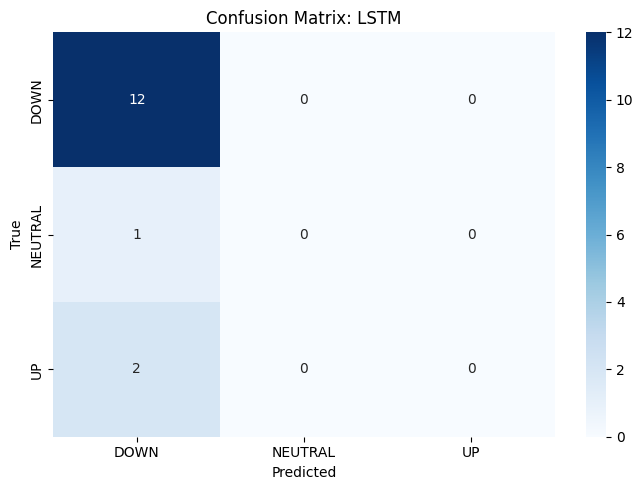

[ADANIENT] Results DataFrame shape: (15, 27)
[ADANIENT] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]

Epoch 3: val_loss improved from 0.98442 to 0.94700, saving model to /content/checkpoints/SBIN/SBIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0257Excel report successfully generated: /content/output/ADANIENT_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/ADANIENT_results.xlsx
[ADANIENT] 💾 Saved results to /content/output/ADANIENT_results.xlsx
[MGL] ✅ Set DatetimeIndex. Index range: 2025-06-26 00:00:00 to 2025-07-29 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for ADANIENT
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[MGL] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[MGL] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

Epoch 46: val_loss improved from 0.87338 to 0.86778, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5

Epoch 37: val_loss improved from 0.47190 to 0.46304, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 0.8787 - val_accuracy: 1.0000 - val_loss: 0.9470 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2561 - val_accuracy: 1.0000 - val_loss: 0.8678 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0257 - val_accuracy: 1.0000 - val_loss: 0.4630 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.0285
Epoch 38: val_loss improved from 0.46304 to 0.45455, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.7273 - loss: 0.5815
Epoch 4: val_loss improved from 0.94700 to 0.90521, saving model to /content/checkpoints/SBIN/SBIN_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 1.0000 - loss: 0.2201


Epoch 47: val_loss improved from 0.86778 to 0.86327, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0285 - val_accuracy: 1.0000 - val_loss: 0.4546 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5815 - val_accuracy: 1.0000 - val_loss: 0.9052 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7273 - loss: 0.6428
Epoch 39: val_loss improved from 0.45455 to 0.44565, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5



Epoch 5: val_loss improved from 0.90521 to 0.86739, saving model to /content/checkpoints/SBIN/SBIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2201 - val_accuracy: 1.0000 - val_loss: 0.8633 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9091 - loss: 0.1657
Epoch 48: val_loss improved from 0.86327 to 0.85836, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0172 - val_accuracy: 1.0000 - val_loss: 0.4456 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6428 - val_accuracy: 1.0000 - val_loss: 0.8674 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8182 - loss: 0.5328
Epoch 6: val_loss improved from 0.86739 to 0.83705, saving model to /content/checkpoints/SBIN/SBIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1657 - val_accuracy: 1.0000 - val_loss: 0.8584 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 1.0000 - loss: 0.0205
Epoch 40: val_loss improved from 0.44565 to 0.43732, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5328 - val_accuracy: 1.0000 - val_loss: 0.8371 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.2927
Epoch 49: val_loss improved from 0.85836 to 0.85418, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0205 - val_accuracy: 1.0000 - val_loss: 0.4373 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.2927 - val_accuracy: 1.0000 - val_loss: 0.8542 - learning_rate: 0.0010
Epoch 50/50

Epoch 7: val_loss improved from 0.83705 to 0.81970, saving model to /content/checkpoints/SBIN/SBIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0339
Epoch 41: val_loss improved from 0.43732 to 0.42852, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5



Epoch 50: val_loss improved from 0.85418 to 0.84978, saving model to /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.4723 - val_accuracy: 1.0000 - val_loss: 0.8197 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5455 - loss: 1.0347
Epoch 8: val_loss improved from 0.81970 to 0.80877, saving model to /content/checkpoints/SBIN/SBIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0339 - val_accuracy: 1.0000 - val_loss: 0.4285 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1541 - val_accuracy: 1.0000 - val_loss: 0.8498 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 1.0000 - loss: 0.0164Restoring model weights from the end of the best epoch: 50.

Epoch 42: val_loss improved from 0.42852 to 0.42033, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.5759 - val_accuracy: 1.0000 - val_loss: 0.8088 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.4545 - loss: 0.8096[NATIONALUM] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[NATIONALUM] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}

Epoch 9: val_loss improved from 0.80877 to 0.79848, saving model to /content/checkpoints/SBIN/SBIN_lstm_model.h5


[NATIONALUM] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 0 0 2 0 0 2 2 2 2 2 1]

Epoch 1: val_loss improved from inf to 1.23981, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0164 - val_accuracy: 1.0000 - val_loss: 0.4203 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 1.0000 - loss: 0.0150

[NATIONALUM] ✅ Loaded best model from /content/checkpoints/NATIONALUM/NATIONALUM_lstm_model.h5
[NATIONALUM] Predicting for 15 dates, including 30-07-2025

Epoch 43: val_loss improved from 0.42033 to 0.41259, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 0.8096 - val_accuracy: 1.0000 - val_loss: 0.7985 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.5455 - loss: 1.0347 - val_accuracy: 0.0000e+00 - val_loss: 1.2398 - learning_rate: 0.0010
Epoch 2/50
[NATIONALUM] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0150 - val_accuracy: 1.0000 - val_loss: 0.4126 - learning_rate: 0.0010
Epoch 44/50

Classification Report for LSTM:

Epoch 2: val_loss improved from 1.23981 to 1.20258, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         4
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.67      1.00      0.80        10

    accuracy                           0.67        15
   macro avg       0.22      0.33      0.27        15
w

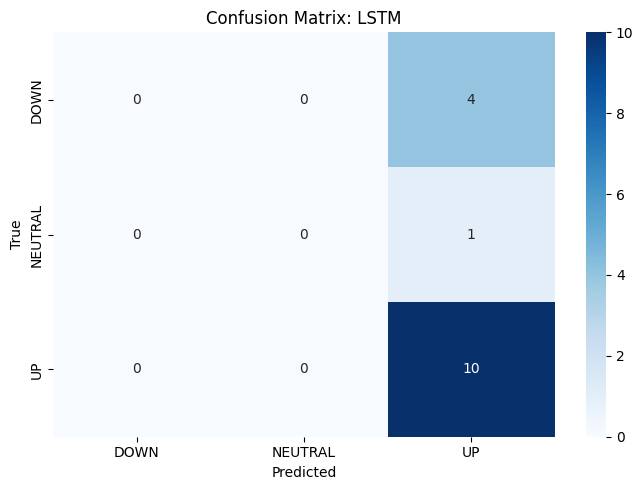

[NATIONALUM] Results DataFrame shape: (15, 27)
[NATIONALUM] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/NATIONALUM_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/NATIONALUM_results.xlsx
[NATIONALUM] 💾 Saved results to /content/output/NATIONALUM_results.xlsx
✅ Completed processing for NATIONALUM
[MFSL] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[MFSL] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[MFSL] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step - accuracy: 0.8182 - loss: 0.7590 - val_accuracy: 0.0000e+00 - val_loss: 1.2026 - learning_rate: 0.0010
Epoch 3/50
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4545 - loss: 0.7878
✅ 

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 10: val_loss improved from 0.79848 to 0.78093, saving model to /content/checkpoints/SBIN/SBIN_lstm_model.h5

Epoch 3: val_loss improved from 1.20258 to 1.17555, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0130
Epoch 44: val_loss improved from 0.41259 to 0.40508, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 0.7878 - val_accuracy: 1.0000 - val_loss: 0.7809 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6044 - val_accuracy: 0.0000e+00 - val_loss: 1.1755 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8182 - loss: 0.4494
Epoch 11: val_loss improved from 0.78093 to 0.76648, saving model to /content/checkpoints/SBIN/SBIN_lstm_model.h5



Epoch 4: val_loss improved from 1.17555 to 1.14495, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.4051 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4494 - val_accuracy: 0.0000e+00 - val_loss: 1.1449 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.6275 - val_accuracy: 1.0000 - val_loss: 0.7665 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 1.0000 - loss: 0.0214
Epoch 12: val_loss improved from 0.76648 to 0.76010, saving model to /content/checkpoints/SBIN/SBIN_lstm_model.h5



Epoch 45: val_loss improved from 0.40508 to 0.39752, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.6817 - val_accuracy: 1.0000 - val_loss: 0.7601 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0214 - val_accuracy: 1.0000 - val_loss: 0.3975 - learning_rate: 0.0010
Epoch 46/50

Epoch 5: val_loss improved from 1.14495 to 1.11800, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5



Epoch 13: val_loss did not improve from 0.76010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5705 - val_accuracy: 1.0000 - val_loss: 0.7640 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.4502 - val_accuracy: 0.0000e+00 - val_loss: 1.1180 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0228
Epoch 14: val_loss did not improve from 0.76010

Epoch 6: val_loss improved from 1.11800 to 1.08174, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5



Epoch 46: val_loss improved from 0.39752 to 0.39019, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.3572 - val_accuracy: 1.0000 - val_loss: 0.7654 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3414 - val_accuracy: 0.0000e+00 - val_loss: 1.0817 - learning_rate: 0.0010
Epoch 7/50

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: val_loss did not improve from 0.76010
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0228 - val_accuracy: 1.0000 - val_loss: 0.3902 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step - accuracy: 0.6364 - loss: 0.6738 - val_accuracy: 1.0000 - val_loss: 0.7645 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8182 - loss: 0.4229
Epoch 16: val_loss did not improve from 0.76010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 1.0000 - loss: 0.0297
Epoch 7: val_loss improved from 1.08174 to 1.04706, saving model to /content/check


Epoch 47: val_loss improved from 0.39019 to 0.38331, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4229 - val_accuracy: 1.0000 - val_loss: 0.7633 - learning_rate: 5.0000e-04
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.7564 - val_accuracy: 1.0000 - val_loss: 1.0471 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0297 - val_accuracy: 1.0000 - val_loss: 0.3833 - learning_rate: 0.0010
Epoch 48/50

Epoch 17: val_loss did not improve from 0.76010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step - accuracy: 0.9091 - loss: 0.3585 - val_accuracy: 1.0000 - val_loss: 0.7618 - learning_rate: 5.0000e-04
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 12.
[SBIN] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[SBIN] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[SBIN

[SBIN] ✅ Loaded best model from /content/checkpoints/SBIN/SBIN_lstm_model.h5
[SBIN] Predicting for 15 dates, including 30-07-2025

Epoch 1: val_loss improved from inf to 1.06154, saving model to /content/checkpoints/MFSL/MFSL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0168[SBIN] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 8: val_loss improved from 1.04706 to 1.01342, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5



Epoch 48: val_loss improved from 0.38331 to 0.37605, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.47      1.00      0.64         7
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         7

    accuracy                           0.47        15
   macro avg       0.16      0.33      0.21        15
weighted avg       0.22      0.47      0.30        15



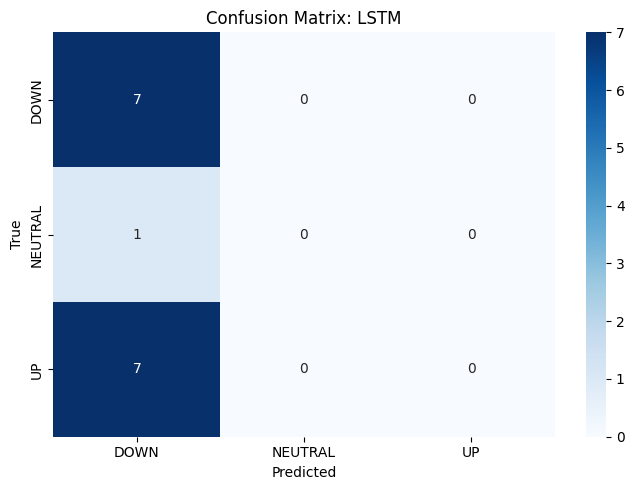

[SBIN] Results DataFrame shape: (15, 27)
[SBIN] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/SBIN_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/SBIN_results.xlsx
[SBIN] 💾 Saved results to /content/output/SBIN_results.xlsx
✅ Completed processing for SBIN
[SHREECEM] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.4545 - loss: 1.6734 - val_accuracy: 1.0000 - val_loss: 1.0615 - learning_rate: 0.0010
Epoch 2/50
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[SHREECEM] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[SHREECEM] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4422 - val_accuracy: 1.0

Model: "LSTM_Model"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 0.0133

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 9: val_loss improved from 1.01342 to 0.98720, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5

Epoch 2: val_loss did not improve from 1.06154


Epoch 1/50

Epoch 49: val_loss improved from 0.37605 to 0.36954, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 1.1498 - val_accuracy: 0.0000e+00 - val_loss: 1.0858 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2990 - val_accuracy: 1.0000 - val_loss: 0.9872 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 1.0000 - val_loss: 0.3695 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8182 - loss: 0.4924
Epoch 3: val_loss did not improve from 1.06154
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 1.0000 - loss: 0.0199
Epoch 10: val_loss improved from 0.98720 to 0.95861, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5



Epoch 50: val_loss improved from 0.36954 to 0.36318, saving model to /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 0.9745 - val_accuracy: 0.0000e+00 - val_loss: 1.1010 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7273 - loss: 0.7810
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.06154
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4924 - val_accuracy: 1.0000 - val_loss: 0.9586 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0199 - val_accuracy: 1.0000 - val_loss: 0.3632 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step - accuracy: 0.7273 - loss: 0.7810 - val_accuracy: 0.0000e+00 - val_loss: 1.1124 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7273 - loss: 0.7948
Epoch 5: val_loss did not improve from 1.06154
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.4545 - loss: 0.8186

[MUTHOOTFIN] ✅ Loaded best model from /content/checkpoints/MUTHOOTFIN/MUTHOOTFIN_lstm_model.h5
[MUTHOOTFIN] Predicting for 15 dates, including 30-07-2025

Epoch 6: val_loss did not improve from 1.06154
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1459 - val_accuracy: 1.0000 - val_loss: 0.9324 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 0.8186 - val_accuracy: 0.0000e+00 - val_loss: 1.1071 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
[MFSL] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[MFSL] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[MFSL] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 2 2 2 0 2 0 2 0 0 2 2 1]


[MUTHOOTFIN] Predictions generated. y_pred length: 15, dates_future length: 15
[MFSL] ✅ Loaded best model from /content/checkpoints/MFSL/MFSL_lstm_model.h5
[MFSL] Predicting for 15 dates, including 30-07-2025

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.93      1.00      0.97        14
     NEUTRAL       0.00      0.00      0.00         1

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 1.0000 - loss: 0.1914
Epoch 12: val_loss improved from 0.93243 to 0.90706, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


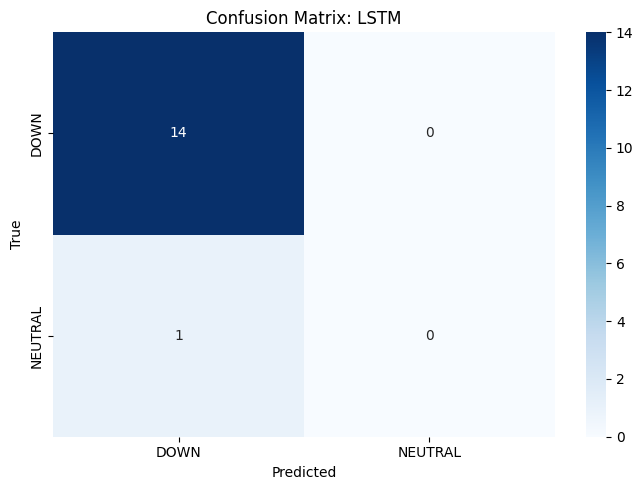

[MUTHOOTFIN] Results DataFrame shape: (15, 26)
[MUTHOOTFIN] Prediction dates: [Timestamp('2024-08-12 00:00:00'), Timestamp('2024-08-13 00:00:00'), Timestamp('2024-08-14 00:00:00'), Timestamp('2024-08-16 00:00:00'), Timestamp('2024-08-19 00:00:00'), Timestamp('2024-08-20 00:00:00'), Timestamp('2024-08-21 00:00:00'), Timestamp('2024-08-22 00:00:00'), Timestamp('2024-08-23 00:00:00'), Timestamp('2024-08-26 00:00:00'), Timestamp('2024-08-27 00:00:00'), Timestamp('2024-08-28 00:00:00'), Timestamp('2024-08-29 00:00:00'), Timestamp('2024-08-30 00:00:00'), Timestamp('2025-07-30 00:00:00')]
Excel report successfully generated: /content/output/MUTHOOTFIN_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/MUTHOOTFIN_results.xlsx
[MUTHOOTFIN] 💾 Saved results to /content/output/MUTHOOTFIN_results.xlsx
[MARUTI] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for MUTHOOTFIN
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[MARUTI] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[MARUTI] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[MFSL] Predictions generated. y_pred length: 15, dates_future length: 15

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1914 - val_accuracy: 1.0000 - val_loss: 0.9071 - learning_rate: 0.0010
Epoch 13/50
Epoch 1/50

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.47      1.00      0.64         7
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         7

    accuracy                           0.47        15
   macro avg       0.16      0.33      0.21        15
weighted avg       0.22      0.47      0.30        15



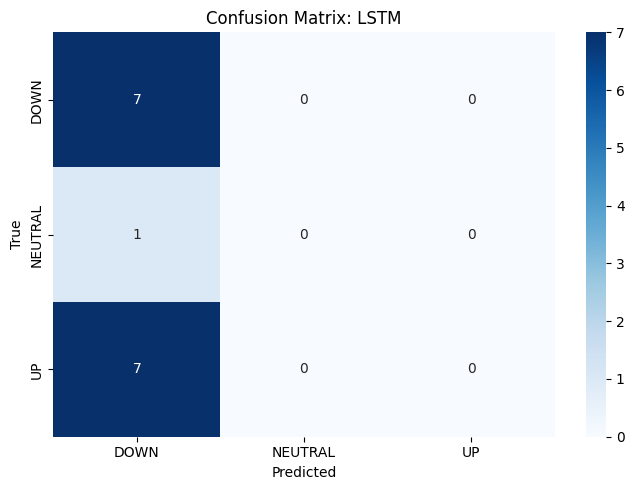

[MFSL] Results DataFrame shape: (15, 27)
[MFSL] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/MFSL_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/MFSL_results.xlsx
[MFSL] 💾 Saved results to /content/output/MFSL_results.xlsx
✅ Completed processing for MFSL
[MARICO] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1957Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[MARICO] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[MARICO] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 13: val_loss improved from 0.90706 to 0.88315, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5



✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1957 - val_accuracy: 1.0000 - val_loss: 0.8832 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9091 - loss: 0.2133
Epoch 14: val_loss improved from 0.88315 to 0.85771, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.0000e+00 - loss: 1.9960
Epoch 1: val_loss improved from inf to 1.19147, saving model to /content/checkpoints/SHREECEM/SHREECEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2133 - val_accuracy: 1.0000 - val_loss: 0.8577 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 1.0000 - loss: 0.1971
Epoch 15: val_loss improved from 0.85771 to 0.83164, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.0000e+00 - loss: 1.9960 - val_accuracy: 0.0000e+00 - val_loss: 1.1915 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1971 - val_accuracy: 1.0000 - val_loss: 0.8316 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8182 - loss: 0.3336
Epoch 16: val_loss improved from 0.83164 to 0.81056, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3336 - val_accuracy: 1.0000 - val_loss: 0.8106 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9091 - loss: 0.1872
Epoch 2: val_loss did not improve from 1.19147

Epoch 17: val_loss improved from 0.81056 to 0.79170, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1818 - loss: 1.6535 - val_accuracy: 0.0000e+00 - val_loss: 1.2077 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.4545 - loss: 1.1109
Epoch 3: val_loss did not improve from 1.19147
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1872 - val_accuracy: 1.0000 - val_loss: 0.7917 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.1109 - val_accuracy: 0.0000e+00 - val_loss: 1.2145 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.9091 - loss: 0.2787
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.19147

Epoch 18: val_loss improved from 0.79170 to 0.77090, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5



Epoch 1: val_loss improved from inf to 0.86305, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.1104 - val_accuracy: 0.0000e+00 - val_loss: 1.2270 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2787 - val_accuracy: 1.0000 - val_loss: 0.7709 - learning_rate: 0.0010
Epoch 19/50

Epoch 5: val_loss did not improve from 1.19147
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.8182 - loss: 0.4373 - val_accuracy: 1.0000 - val_loss: 0.8630 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9091 - loss: 0.4738
Epoch 2: val_loss did not improve from 0.86305
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.8087 - val_accuracy: 0.0000e+00 - val_loss: 1.2198 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.5455 - loss: 0.7823
Epoch 1: val_loss improved from inf to 1.09338, saving model to /content/checkpoints/MARICO/MARICO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step - accuracy: 0.9091 - loss: 0.4738 - val_accuracy: 1.0000 - val_loss: 0.8691 - learning_rate: 0.0010
Epoch 3/50

Epoch 19: val_loss improved from 0.77090 to 0.75389, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9091 - loss: 0.3578
Epoch 6: val_loss did not improve from 1.19147

Epoch 3: val_loss did not improve from 0.86305
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.0909 - loss: 2.1431 - val_accuracy: 0.0000e+00 - val_loss: 1.0934 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1217 - val_accuracy: 1.0000 - val_loss: 0.7539 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.7823 - val_accuracy: 0.0000e+00 - val_loss: 1.2160 - learning_rate: 5.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3578 - val_accuracy: 1.0000 - val_loss: 0.8650 - learning_rate: 0.0010
Epoch 4/50
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
[SHREECEM] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/ste


Epoch 20: val_loss improved from 0.75389 to 0.73911, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


[SHREECEM] ✅ Loaded best model from /content/checkpoints/SHREECEM/SHREECEM_lstm_model.h5
[SHREECEM] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3636 - loss: 1.6949 - val_accuracy: 0.0000e+00 - val_loss: 1.1012 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2462 - val_accuracy: 1.0000 - val_loss: 0.8591 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1195 - val_accuracy: 1.0000 - val_loss: 0.7391 - learning_rate: 0.0010
Epoch 21/50
[SHREECEM] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 5: val_loss improved from 0.85913 to 0.84815, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00      14.0
     NEUTRAL       0.00      0.00      0.00       1.0
          UP       0.00      0.00      0.00       0.0

    accuracy                           0.00      15.0
   macro avg       0.00      0.00      0.00      15.0
weighted avg       0.00      0.00      0.00      15.0



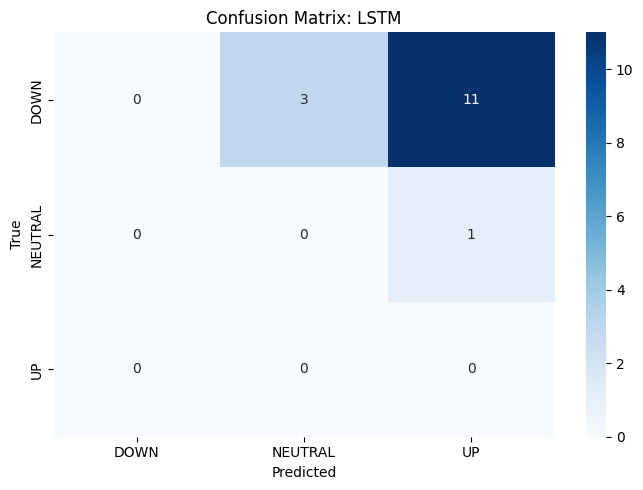

[SHREECEM] Results DataFrame shape: (15, 27)
[SHREECEM] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step - accuracy: 1.0000 - loss: 0.2290 - val_accuracy: 1.0000 - val_loss: 0.8482 - learning_rate: 0.0010
Epoch 6/50
Excel report successfully generated: /content/output/SHREECEM_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/SHREECEM_results.xlsx
[SHREECEM] 💾 Saved results to /content/output/SHREECEM_results.xlsx
[MANAPPURAM] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for SHREECEM
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[MANAPPURAM] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[MANAPPURAM] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.9091 - loss: 0.2106
Epoch 21: val_loss improved from 0.73911 to 0.72240, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5



Epoch 6: val_loss improved from 0.84815 to 0.83367, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3636 - loss: 1.2949
Epoch 3: val_loss did not improve from 1.09338
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0889 - val_accuracy: 1.0000 - val_loss: 0.7224 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2106 - val_accuracy: 1.0000 - val_loss: 0.8337 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.3636 - loss: 1.2949 - val_accuracy: 0.0000e+00 - val_loss: 1.1093 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5455 - loss: 1.1894
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.09338
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1392
Epoch 22: val_loss improved from 0.72240 to 0.70727, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5



Epoch 7: val_loss improved from 0.83367 to 0.81997, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.1894 - val_accuracy: 0.0000e+00 - val_loss: 1.1209 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.4545 - loss: 1.0242
Epoch 5: val_loss did not improve from 1.09338
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1425 - val_accuracy: 1.0000 - val_loss: 0.7073 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1392 - val_accuracy: 1.0000 - val_loss: 0.8200 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.0242 - val_accuracy: 0.0000e+00 - val_loss: 1.1262 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6364 - loss: 0.7791
Epoch 8: val_loss improved from 0.81997 to 0.80298, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5



Epoch 6: val_loss did not improve from 1.09338
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 1.0000 - loss: 0.1422
Epoch 23: val_loss improved from 0.70727 to 0.69551, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1945 - val_accuracy: 1.0000 - val_loss: 0.8030 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.7791 - val_accuracy: 0.0000e+00 - val_loss: 1.1359 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
[MARICO] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[MARICO] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[MARICO] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 0 2 2 2 2 2 0 0 2 2 1]

Epoch 9: val_loss improved from 0.80298 to 0.78635, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


[MARICO] ✅ Loaded best model from /content/checkpoints/MARICO/MARICO_lstm_model.h5
[MARICO] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1422 - val_accuracy: 1.0000 - val_loss: 0.6955 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1457 - val_accuracy: 1.0000 - val_loss: 0.7864 - learning_rate: 0.0010
Epoch 10/50

Epoch 24: val_loss improved from 0.69551 to 0.68550, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.1391
Epoch 10: val_loss improved from 0.78635 to 0.77182, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


[MARICO] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0810 - val_accuracy: 1.0000 - val_loss: 0.6855 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 0.0917
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.11      0.33      0.17         3
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.50      0.27      0.35        11

    accuracy                           0.27        15
   macro avg       0.20      0.20      0.17        15
weighted avg       0.39      0.27      0.29        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1391 - val_accuracy: 1.0000 - val_loss: 0.7718 - learning_rate: 0.0010
Epoch 11/50

Epoch 25: val_loss improved from 0.68550 to 0.67348, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.1430
Epoch 11: val_loss improved from 0.77182 to 0.76174, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


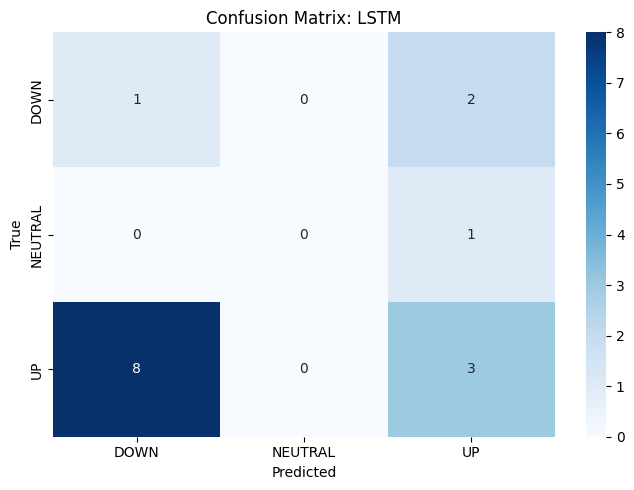

[MARICO] Results DataFrame shape: (15, 27)
[MARICO] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/MARICO_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/MARICO_results.xlsx
[MARICO] 💾 Saved results to /content/output/MARICO_results.xlsx
✅ Completed processing for MARICO
[M&MFIN] ✅ Set DatetimeIndex. Index range: 2025-06-26 00:00:00 to 2025-07-29 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[M&MFIN] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[M&MFIN] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0917 - val_accuracy: 1.0000 - val_loss: 0.6735 - learning_rate: 0.0010
Epoch 26/50

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 1.0000 - loss: 0.0977

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1430 - val_accuracy: 1.0000 - val_loss: 0.7617 - learning_rate: 0.0010
Epoch 12/50
Epoch 1/50

Epoch 26: val_loss improved from 0.67348 to 0.65858, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5



Epoch 1: val_loss improved from inf to 0.99624, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0977 - val_accuracy: 1.0000 - val_loss: 0.6586 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0785
Epoch 12: val_loss improved from 0.76174 to 0.75180, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.6364 - loss: 0.8822 - val_accuracy: 1.0000 - val_loss: 0.9962 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7273 - loss: 0.8024
Epoch 2: val_loss improved from 0.99624 to 0.96442, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0785 - val_accuracy: 1.0000 - val_loss: 0.7518 - learning_rate: 0.0010
Epoch 13/50

Epoch 27: val_loss improved from 0.65858 to 0.64770, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.8024 - val_accuracy: 1.0000 - val_loss: 0.9644 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1019 - val_accuracy: 1.0000 - val_loss: 0.6477 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 0.0654
Epoch 13: val_loss improved from 0.75180 to 0.74136, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5



Epoch 28: val_loss improved from 0.64770 to 0.63838, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4783
Epoch 3: val_loss improved from 0.96442 to 0.94587, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1030 - val_accuracy: 1.0000 - val_loss: 0.7414 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0654 - val_accuracy: 1.0000 - val_loss: 0.6384 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4783 - val_accuracy: 1.0000 - val_loss: 0.9459 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.2885
Epoch 4: val_loss improved from 0.94587 to 0.93570, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step - accuracy: 1.0000 - loss: 0.2885 - val_accuracy: 1.0000 - val_loss: 0.9357 - learning_rate: 0.0010
Epoch 5/50

Epoch 14: val_loss improved from 0.74136 to 0.73147, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5



Epoch 29: val_loss improved from 0.63838 to 0.62494, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 1.0000 - loss: 0.1322
Epoch 5: val_loss improved from 0.93570 to 0.93123, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0721 - val_accuracy: 1.0000 - val_loss: 0.7315 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.1140 - val_accuracy: 1.0000 - val_loss: 0.6249 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1322 - val_accuracy: 1.0000 - val_loss: 0.9312 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9091 - loss: 0.1856
Epoch 6: val_loss improved from 0.93123 to 0.92674, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.06169, saving model to /content/checkpoints/M&MFIN/M&MFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0698
Epoch 30: val_loss improved from 0.62494 to 0.61563, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5



Epoch 15: val_loss improved from 0.73147 to 0.72196, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1856 - val_accuracy: 1.0000 - val_loss: 0.9267 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.4545 - loss: 1.1681 - val_accuracy: 1.0000 - val_loss: 1.0617 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5455 - loss: 1.0170
Epoch 7: val_loss improved from 0.92674 to 0.91825, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5



Epoch 2: val_loss improved from 1.06169 to 1.06039, saving model to /content/checkpoints/M&MFIN/M&MFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0698 - val_accuracy: 1.0000 - val_loss: 0.6156 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1074 - val_accuracy: 1.0000 - val_loss: 0.7220 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1417 - val_accuracy: 1.0000 - val_loss: 0.9183 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.0170 - val_accuracy: 1.0000 - val_loss: 1.0604 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3636 - loss: 0.9075
Epoch 8: val_loss improved from 0.91825 to 0.90682, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 1.0000 - loss: 0.0845
Epoch 3: val_loss did not improve from 1.06039
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 1.0000 - loss: 0.0509
Epoch 16: val_loss improved from 0.72196 to 0.71457, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5



Epoch 31: val_loss improved from 0.61563 to 0.60729, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 0.9075 - val_accuracy: 1.0000 - val_loss: 1.0607 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1354 - val_accuracy: 1.0000 - val_loss: 0.9068 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0845 - val_accuracy: 1.0000 - val_loss: 0.7146 - learning_rate: 0.0010
Epoch 17/50

Epoch 9: val_loss improved from 0.90682 to 0.89070, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0509 - val_accuracy: 1.0000 - val_loss: 0.6073 - learning_rate: 0.0010
Epoch 32/50

Epoch 4: val_loss improved from 1.06039 to 1.05037, saving model to /content/checkpoints/M&MFIN/M&MFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 1.0000 - loss: 0.0682
Epoch 17: val_loss improved from 0.71457 to 0.70659, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1586 - val_accuracy: 1.0000 - val_loss: 0.8907 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7961 - val_accuracy: 1.0000 - val_loss: 1.0504 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5455 - loss: 0.8362
Epoch 10: val_loss improved from 0.89070 to 0.87543, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0682 - val_accuracy: 1.0000 - val_loss: 0.7066 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0850Epoch 18/50

Epoch 5: val_loss improved from 1.05037 to 1.04168, saving model to /content/checkpoints/M&MFIN/M&MFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 1.0000 - loss: 0.0872
Epoch 32: val_loss improved from 0.60729 to 0.60350, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5



Epoch 18: val_loss improved from 0.70659 to 0.70137, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1191 - val_accuracy: 1.0000 - val_loss: 0.8754 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.8362 - val_accuracy: 1.0000 - val_loss: 1.0417 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0850 - val_accuracy: 1.0000 - val_loss: 0.6035 - learning_rate: 0.0010
Epoch 33/50

Epoch 11: val_loss improved from 0.87543 to 0.86248, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5



Epoch 6: val_loss improved from 1.04168 to 1.03313, saving model to /content/checkpoints/M&MFIN/M&MFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0872 - val_accuracy: 1.0000 - val_loss: 0.7014 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.1014
Epoch 19: val_loss improved from 0.70137 to 0.69517, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1289 - val_accuracy: 1.0000 - val_loss: 0.8625 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.5606 - val_accuracy: 1.0000 - val_loss: 1.0331 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0679
Epoch 12: val_loss improved from 0.86248 to 0.85003, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5



Epoch 33: val_loss improved from 0.60350 to 0.59777, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1014 - val_accuracy: 1.0000 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0486
Epoch 20: val_loss improved from 0.69517 to 0.69009, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0894 - val_accuracy: 1.0000 - val_loss: 0.8500 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0679 - val_accuracy: 1.0000 - val_loss: 0.5978 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.7253
Epoch 13: val_loss improved from 0.85003 to 0.83768, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5



Epoch 34: val_loss improved from 0.59777 to 0.59262, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5

Epoch 7: val_loss improved from 1.03313 to 1.02222, saving model to /content/checkpoints/M&MFIN/M&MFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0486 - val_accuracy: 1.0000 - val_loss: 0.6901 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.7253 - val_accuracy: 1.0000 - val_loss: 1.0222 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0481 - val_accuracy: 1.0000 - val_loss: 0.5926 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0729 - val_accuracy: 1.0000 - val_loss: 0.8377 - learning_rate: 0.0010
Epoch 35/50
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8182 - loss: 0.4956
Epoch 8: val_loss improved from 1.02222 to 1.01093, saving model to /content/checkpoints/M&MFIN/M&MFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8182 - loss: 0.4956 - val_accuracy: 1.0000 - val_loss: 1.0109 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0574
Epoch 21: val_loss improved from 0.69009 to 0.68586, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8182 - loss: 0.4662
Epoch 9: val_loss improved from 1.01093 to 0.99944, saving model to /content/checkpoints/M&MFIN/M&MFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0574 - val_accuracy: 1.0000 - val_loss: 0.6859 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0767
Epoch 22: val_loss improved from 0.68586 to 0.68254, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5



Epoch 35: val_loss improved from 0.59262 to 0.58923, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5



Epoch 14: val_loss improved from 0.83768 to 0.82657, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4662 - val_accuracy: 1.0000 - val_loss: 0.9994 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 1.0000 - loss: 0.4047
Epoch 10: val_loss improved from 0.99944 to 0.98743, saving model to /content/checkpoints/M&MFIN/M&MFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0767 - val_accuracy: 1.0000 - val_loss: 0.5892 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0348 - val_accuracy: 1.0000 - val_loss: 0.6825 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0418 - val_accuracy: 1.0000 - val_loss: 0.8266 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 0.0330
Epoch 23: val_loss improved from 0.68254 to 0.67956, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.4047 - val_accuracy: 1.0000 - val_loss: 0.9874 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step - accuracy: 1.0000 - loss: 0.0330 - val_accuracy: 1.0000 - val_loss: 0.6796 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9091 - loss: 0.0976
Epoch 24: val_loss improved from 0.67956 to 0.67641, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0475
Epoch 36: val_loss improved from 0.58923 to 0.58846, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5



Epoch 15: val_loss improved from 0.82657 to 0.81303, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.0976 - val_accuracy: 1.0000 - val_loss: 0.6764 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 1.0000 - loss: 0.0459
Epoch 11: val_loss improved from 0.98743 to 0.97160, saving model to /content/checkpoints/M&MFIN/M&MFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0475 - val_accuracy: 1.0000 - val_loss: 0.5885 - learning_rate: 0.0010
Epoch 37/50

Epoch 25: val_loss improved from 0.67641 to 0.67332, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1012 - val_accuracy: 1.0000 - val_loss: 0.8130 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 0.0335
Epoch 37: val_loss improved from 0.58846 to 0.58840, saving model to /content/checkpoints/MGL/MGL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3551 - val_accuracy: 1.0000 - val_loss: 0.9716 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0459 - val_accuracy: 1.0000 - val_loss: 0.6733 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0335 - val_accuracy: 1.0000 - val_loss: 0.5884 - learning_rate: 0.0010
Epoch 38/50

Epoch 16: val_loss improved from 0.81303 to 0.80082, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0563
Epoch 26: val_loss improved from 0.67332 to 0.67093, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5



Epoch 38: val_loss did not improve from 0.58840
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.5154
Epoch 12: val_loss improved from 0.97160 to 0.96611, saving model to /content/checkpoints/M&MFIN/M&MFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1093 - val_accuracy: 1.0000 - val_loss: 0.8008 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0448 - val_accuracy: 1.0000 - val_loss: 0.6709 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0563 - val_accuracy: 1.0000 - val_loss: 0.5884 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 0.0397
Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 39: val_loss did not improve from 0.58840

Epoch 27: val_loss improved from 0.67093 to 0.66956, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5154 - val_accuracy: 1.0000 - val_loss: 0.9661 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step - accuracy: 1.0000 - loss: 0.0397 - val_accuracy: 1.0000 - val_loss: 0.5903 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0303 - val_accuracy: 1.0000 - val_loss: 0.6696 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0325
Epoch 40: val_loss did not improve from 0.58840
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0344
Epoch 28: val_loss improved from 0.66956 to 0.66717, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5



Epoch 17: val_loss improved from 0.80082 to 0.78718, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step - accuracy: 1.0000 - loss: 0.0571 - val_accuracy: 1.0000 - val_loss: 0.5931 - learning_rate: 5.0000e-04
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step - accuracy: 1.0000 - loss: 0.0325 - val_accuracy: 1.0000 - val_loss: 0.6672 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.5263Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0344 - val_accuracy: 1.0000 - val_loss: 0.7872 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 1.0000 - loss: 0.0318
Epoch 13: val_loss improved from 0.96611 to 0.96597, saving model to /content/checkpoints/M&MFIN/M&MFIN_lstm_model.h5



Epoch 29: val_loss improved from 0.66717 to 0.66383, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5



Epoch 41: val_loss did not improve from 0.58840
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 1.0000 - loss: 0.1214
Epoch 18: val_loss improved from 0.78718 to 0.78150, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0318 - val_accuracy: 1.0000 - val_loss: 0.5961 - learning_rate: 5.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.5263 - val_accuracy: 1.0000 - val_loss: 0.9660 - learning_rate: 0.0010
Epoch 42/50
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0268 - val_accuracy: 1.0000 - val_loss: 0.6638 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1214 - val_accuracy: 1.0000 - val_loss: 0.7815 - learning_rate: 0.0010
Epoch 19/50

Epoch 14: val_loss did not improve from 0.96597

Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 42: val_loss did not improve from 0.58840
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step - accuracy: 0.8182 - loss: 0.4400 - val_accuracy: 1.0000 - val_loss: 0.9755 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step - accuracy: 1.0000 - loss: 0.0220 - va

[MGL] ✅ Loaded best model from /content/checkpoints/MGL/MGL_lstm_model.h5
[MGL] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0218
Epoch 30: val_loss improved from 0.66383 to 0.66037, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step - accuracy: 0.8182 - loss: 0.3317 - val_accuracy: 1.0000 - val_loss: 0.9857 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0562
Epoch 19: val_loss improved from 0.78150 to 0.77269, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0218 - val_accuracy: 1.0000 - val_loss: 0.6604 - learning_rate: 0.0010
Epoch 31/50

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: val_loss did not improve from 0.96597
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 1.0000 - loss: 0.0327[MGL] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0562 - val_accuracy: 1.0000 - val_loss: 0.7727 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0277
Epoch 31: val_loss improved from 0.66037 to 0.65692, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.80      1.00      0.89        12
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         2

    accuracy                           0.80        15
   macro avg       0.27      0.33      0.30        15
weighted avg       0.64      0.80      0.71        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3046 - val_accuracy: 1.0000 - val_loss: 0.9973 - learning_rate: 0.0010
Epoch 17/50

Epoch 20: val_loss improved from 0.77269 to 0.76168, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9091 - loss: 0.3434
Epoch 17: val_loss did not improve from 0.96597


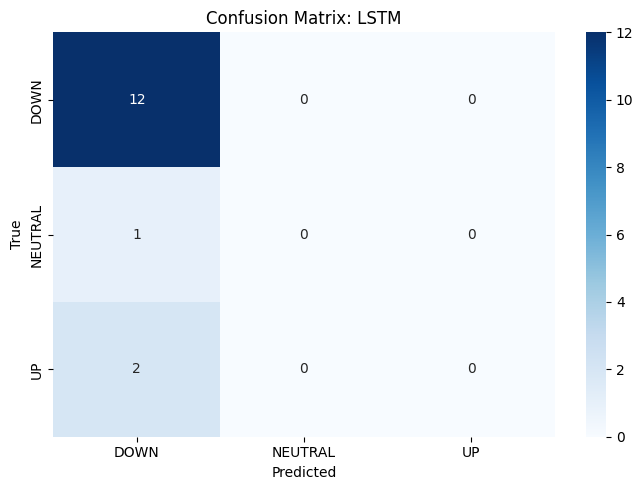

[MGL] Results DataFrame shape: (15, 27)
[MGL] Prediction dates: [Timestamp('2025-07-10 00:00:00'), Timestamp('2025-07-11 00:00:00'), Timestamp('2025-07-14 00:00:00'), Timestamp('2025-07-15 00:00:00'), Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00')]
Excel report successfully generated: /content/output/MGL_results.xlsx


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0327 - val_accuracy: 1.0000 - val_loss: 0.6569 - learning_rate: 0.0010


<IPython.core.display.Javascript object>

Epoch 32/50
File downloaded to local machine: /content/output/MGL_results.xlsx
[MGL] 💾 Saved results to /content/output/MGL_results.xlsx
✅ Completed processing for MGL
[HINDALCO] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0277 - val_accuracy: 1.0000 - val_loss: 0.7617 - learning_rate: 0.0010
Epoch 21/50
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[HINDALCO] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[HINDALCO] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3434 - val_accura

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50

Epoch 18: val_loss did not improve from 0.96597
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step - accuracy: 1.0000 - loss: 0.2054 - val_accuracy: 1.0000 - val_loss: 1.0008 - learning_rate: 5.0000e-04
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 13.

Epoch 32: val_loss improved from 0.65692 to 0.65446, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0417[M&MFIN] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

Epoch 21: val_loss improved from 0.76168 to 0.74370, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)


[M&MFIN] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[M&MFIN] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 0 0 2 0 0 2 2 2 2 2 1]


[M&MFIN] ✅ Loaded best model from /content/checkpoints/M&MFIN/M&MFIN_lstm_model.h5
[M&MFIN] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0450 - val_accuracy: 1.0000 - val_loss: 0.6545 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 1.0000 - loss: 0.0215
Epoch 33: val_loss improved from 0.65446 to 0.65300, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0417 - val_accuracy: 1.0000 - val_loss: 0.7437 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0215 - val_accuracy: 1.0000 - val_loss: 0.6530 - learning_rate: 0.0010
Epoch 34/50
[M&MFIN] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 1.0000 - loss: 0.0167
Classification Report for LSTM:

Epoch 22: val_loss improved from 0.74370 to 0.72542, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


              precision    recall  f1-score   support

        DOWN       0.75      0.75      0.75         4
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.82      0.90      0.86        10

    accuracy                           0.80        15
   macro avg       0.52      0.55      0.54        15
weighted avg       0.75      0.80      0.77        15


Epoch 34: val_loss improved from 0.65300 to 0.65156, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


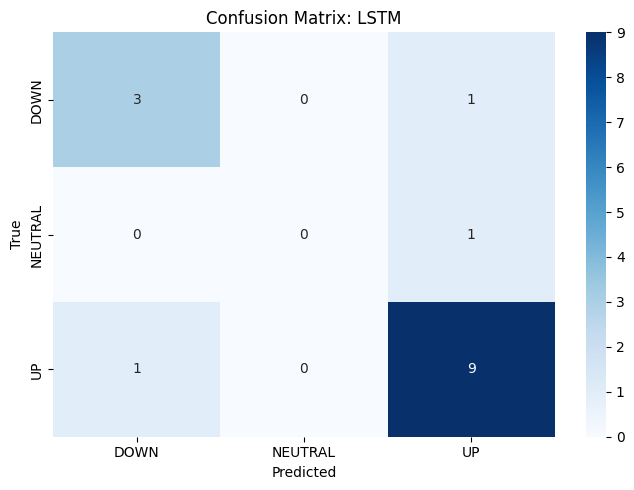

[M&MFIN] Results DataFrame shape: (15, 27)
[M&MFIN] Prediction dates: [Timestamp('2025-07-10 00:00:00'), Timestamp('2025-07-11 00:00:00'), Timestamp('2025-07-14 00:00:00'), Timestamp('2025-07-15 00:00:00'), Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0380 - val_accuracy: 1.0000 - val_loss: 0.7254 - learning_rate: 0.0010
Epoch 23/50
Excel report successfully generated: /content/output/M&MFIN_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/M&MFIN_results.xlsx
[M&MFIN] 💾 Saved results to /content/output/M&MFIN_results.xlsx
✅ Completed processing for M&MFIN
[HEROMOTOCO] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0167 - val_accuracy: 1.0000 - val_loss: 0.6516 - learning_rate: 0.0010
Epoch 35/50
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[HEROMOTOCO] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[HEROMOTOCO] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 1.0000 - loss: 0.0128
Epoch 23: val_loss improved from 0.72542 to 0.70772, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5



Epoch 35: val_loss improved from 0.65156 to 0.64965, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.7077 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0128 - val_accuracy: 1.0000 - val_loss: 0.6496 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 1.0000 - loss: 0.0132
Epoch 36: val_loss improved from 0.64965 to 0.64885, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5



Epoch 24: val_loss improved from 0.70772 to 0.68844, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.6489 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0364 - val_accuracy: 1.0000 - val_loss: 0.6884 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4545 - loss: 1.1600
Epoch 37: val_loss improved from 0.64885 to 0.64803, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0226
Epoch 1: val_loss improved from inf to 0.99166, saving model to /content/checkpoints/HINDALCO/HINDALCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0191 - val_accuracy: 1.0000 - val_loss: 0.6480 - learning_rate: 0.0010
Epoch 38/50

Epoch 25: val_loss improved from 0.68844 to 0.67054, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.4545 - loss: 1.1600 - val_accuracy: 1.0000 - val_loss: 0.9917 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0226 - val_accuracy: 1.0000 - val_loss: 0.6705 - learning_rate: 0.0010
Epoch 26/50

Epoch 38: val_loss improved from 0.64803 to 0.64758, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0122 - val_accuracy: 1.0000 - val_loss: 0.6476 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0123
Epoch 39: val_loss did not improve from 0.64758
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step - accuracy: 1.0000 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.6479 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.0909 - loss: 2.2309
Epoch 26: val_loss improved from 0.67054 to 0.65037, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5



Epoch 40: val_loss did not improve from 0.64758
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0212 - val_accuracy: 1.0000 - val_loss: 0.6479 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0326 - val_accuracy: 1.0000 - val_loss: 0.6504 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 1.0000 - loss: 0.0233
Epoch 2: val_loss did not improve from 0.99166

Epoch 1: val_loss improved from inf to 1.16917, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5



Epoch 41: val_loss improved from 0.64758 to 0.64717, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5455 - loss: 1.3417 - val_accuracy: 1.0000 - val_loss: 1.0088 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.0909 - loss: 2.2309 - val_accuracy: 0.0000e+00 - val_loss: 1.1692 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0233 - val_accuracy: 1.0000 - val_loss: 0.6472 - learning_rate: 0.0010
Epoch 42/50

Epoch 3: val_loss did not improve from 0.99166

Epoch 27: val_loss improved from 0.65037 to 0.63102, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step - accuracy: 0.6364 - loss: 0.9366 - val_accuracy: 1.0000 - val_loss: 1.0416 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0179 - val_accuracy: 1.0000 - val_loss: 0.6310 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0117
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 0.99166

Epoch 28: val_loss improved from 0.63102 to 0.61355, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5



Epoch 42: val_loss did not improve from 0.64717
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.3324 - val_accuracy: 1.0000 - val_loss: 1.0574 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0117 - val_accuracy: 1.0000 - val_loss: 0.6473 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 1.0000 - val_loss: 0.6135 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.7273 - loss: 0.7826
Epoch 43: val_loss improved from 0.64717 to 0.64647, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5



Epoch 29: val_loss improved from 0.61355 to 0.59642, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5



Epoch 5: val_loss did not improve from 0.99166
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3636 - loss: 1.5376
Epoch 2: val_loss improved from 1.16917 to 1.14334, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7826 - val_accuracy: 1.0000 - val_loss: 1.0622 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 1.0000 - val_loss: 0.6465 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 1.0000 - val_loss: 0.5964 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 0.0133
Epoch 6: val_loss did not improve from 0.99166
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.3636 - loss: 1.5376 - val_accuracy: 0.0000e+00 - val_loss: 1.1433 - learning_rate: 0.0010
Epoch 3/50

Epoch 30: val_loss improved from 0.59642 to 0.58204, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3636 - loss: 1.3680
Epoch 3: val_loss improved from 1.14334 to 1.12420, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step - accuracy: 0.8182 - loss: 0.7842 - val_accuracy: 1.0000 - val_loss: 1.0640 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 1.0000 - val_loss: 0.5820 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0197[HINDALCO] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[HINDALCO] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[HINDALCO] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 0 0 2 2 0 2 2 0 0 2 2 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.3680 - val_accuracy: 0.0000e+00 - val_loss: 1.1242 - learning_rate: 0.0010
Epoch 4/5

[HINDALCO] ✅ Loaded best model from /content/checkpoints/HINDALCO/HINDALCO_lstm_model.h5
[HINDALCO] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.2727 - loss: 1.3907
Epoch 44: val_loss improved from 0.64647 to 0.64459, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5



Epoch 4: val_loss improved from 1.12420 to 1.10927, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 1.0000 - val_loss: 0.5689 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0197 - val_accuracy: 1.0000 - val_loss: 0.6446 - learning_rate: 0.0010
Epoch 45/50
[HINDALCO] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         6
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.53      1.00      0.70         8

    accuracy                           0.53        15
   macro avg       0.18      0.33      0.23        15
weighted avg       0.28      0.53      0.37        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2727 - loss: 1.3907 - val_accuracy: 0.0000e+00 - val_loss: 1.1093 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5455 - lo

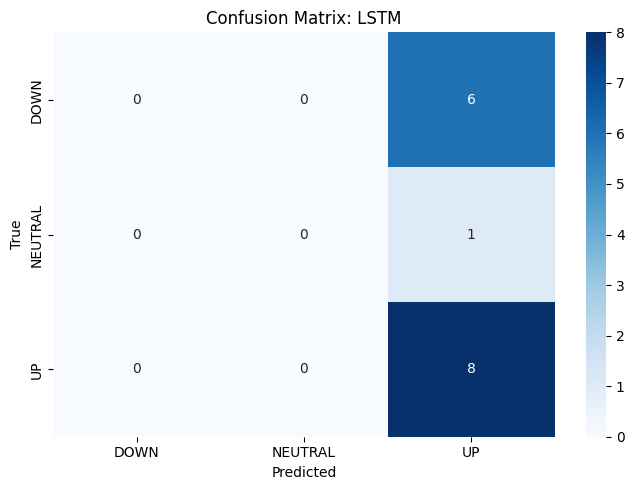


Epoch 5: val_loss improved from 1.10927 to 1.09408, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


[HINDALCO] Results DataFrame shape: (15, 27)
[HINDALCO] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/HINDALCO_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/HINDALCO_results.xlsx
[HINDALCO] 💾 Saved results to /content/output/HINDALCO_results.xlsx
✅ Completed processing for HINDALCO
[HDFCBANK] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[HDFCBANK] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[HDFCBANK] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0070Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.1383 - val_accuracy: 0.0000e+00 - val_loss: 1.0941 - learning_rate: 0.0010
Epoch 6/50

Epoch 32: val_loss improved from 0.56886 to 0.55717, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5



Epoch 45: val_loss improved from 0.64459 to 0.64331, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.6364 - loss: 0.8471
Epoch 6: val_loss improved from 1.09408 to 1.08177, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 1.0000 - val_loss: 0.5572 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 0.6433 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.8471 - val_accuracy: 1.0000 - val_loss: 1.0818 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5455 - loss: 0.9303
Epoch 7: val_loss improved from 1.08177 to 1.07018, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step - accuracy: 0.5455 - loss: 0.9303 - val_accuracy: 1.0000 - val_loss: 1.0702 - learning_rate: 0.0010
Epoch 8/50

Epoch 33: val_loss improved from 0.55717 to 0.54618, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5



Epoch 46: val_loss improved from 0.64331 to 0.64149, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.4545 - loss: 1.1365
Epoch 8: val_loss improved from 1.07018 to 1.06421, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 1.0000 - val_loss: 0.5462 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 0.6415 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.1365 - val_accuracy: 1.0000 - val_loss: 1.0642 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0259
Epoch 34: val_loss improved from 0.54618 to 0.53405, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5



Epoch 47: val_loss improved from 0.64149 to 0.63954, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.6946
Epoch 9: val_loss improved from 1.06421 to 1.06077, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0202 - val_accuracy: 1.0000 - val_loss: 0.5341 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0259 - val_accuracy: 1.0000 - val_loss: 0.6395 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.6946 - val_accuracy: 1.0000 - val_loss: 1.0608 - learning_rate: 0.0010
Epoch 10/50

Epoch 48: val_loss improved from 0.63954 to 0.63746, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6364 - loss: 0.8055
Epoch 10: val_loss improved from 1.06077 to 1.05017, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0132
Epoch 35: val_loss improved from 0.53405 to 0.52307, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0094 - val_accuracy: 1.0000 - val_loss: 0.6375 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.8055 - val_accuracy: 1.0000 - val_loss: 1.0502 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6364 - loss: 0.7959
Epoch 11: val_loss improved from 1.05017 to 1.04075, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.5231 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5455 - loss: 1.2710
Epoch 49: val_loss improved from 0.63746 to 0.63643, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5



Epoch 36: val_loss improved from 0.52307 to 0.51315, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.7959 - val_accuracy: 1.0000 - val_loss: 1.0407 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.5455 - loss: 0.8568
Epoch 12: val_loss improved from 1.04075 to 1.02998, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0143 - val_accuracy: 1.0000 - val_loss: 0.6364 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.5132 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 0.0039
Epoch 1: val_loss improved from inf to 1.00245, saving model to /content/checkpoints/HDFCBANK/HDFCBANK_lstm_model.h5



Epoch 50: val_loss improved from 0.63643 to 0.63494, saving model to /content/checkpoints/MARUTI/MARUTI_lstm_model.h5



Epoch 37: val_loss improved from 0.51315 to 0.50358, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.8568 - val_accuracy: 1.0000 - val_loss: 1.0300 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7273 - loss: 0.6876
Epoch 13: val_loss improved from 1.02998 to 1.02247, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.5455 - loss: 1.2710 - val_accuracy: 1.0000 - val_loss: 1.0025 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.5036 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 1.0000 - val_loss: 0.6349 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
[MARUTI] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 1.0000 - loss: 0.0096
Epoch 2: val_loss did not improve from 1.00245
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[MARUTI] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[MARUTI] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 0 0 0 0 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6876 - val_accuracy: 1.0000 - val_loss: 1.0225 - learning_rate: 0.0010
Epoch 14/50
[MARUTI] ✅ Loaded best model from /content/checkpoints/MARUTI/MARUTI_lstm_model.h5
[MARUTI] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6492 - val_accuracy: 1.0000 - val_loss: 1.0307 - learning_rate: 0.0010
Epoch 3/50

Epoch 14: val_loss improved from 1.02247 to 1.01383, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 0.4943 - learning_rate: 0.0010
Epoch 39/50
[MARUTI] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5982 - val_accuracy: 1.0000 - val_loss: 1.0138 - learning_rate: 0.0010
Epoch 15/50

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.87      1.00      0.93        13
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         1

    accuracy                           0.87        15
   macro avg       0.29      0.33      0.31        15
weighted avg       0.75      0.87      0.80        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6364 - loss: 0.6634
Epoch 15: val_loss improved from 1.01383 to 1.00773, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


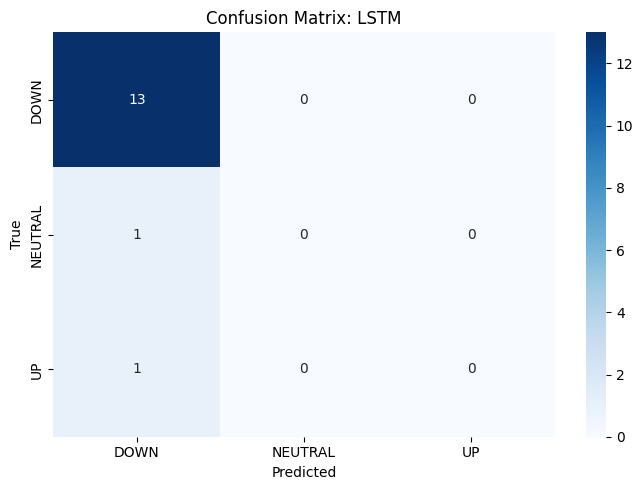

[MARUTI] Results DataFrame shape: (15, 27)
[MARUTI] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/MARUTI_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/MARUTI_results.xlsx
[MARUTI] 💾 Saved results to /content/output/MARUTI_results.xlsx
✅ Completed processing for MARUTI
[CANBK] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.8794Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[CANBK] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[CANBK] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0062
Epoch 3: val_loss did not improve from 1.00245

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.6634 - val_accuracy: 1.0000 - val_loss: 1.0077 - learning_rate: 0.0010
Epoch 16/50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7273 - loss: 0.5661
Epoch 39: val_loss improved from 0.49434 to 0.48680, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.8794 - val_accuracy: 0.0000e+00 - val_loss: 1.0651 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7273 - loss: 0.6599
Epoch 16: val_loss improved from 1.00773 to 1.00013, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.00245
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 0.4868 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5661 - val_accuracy: 1.0000 - val_loss: 1.0001 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6599 - val_accuracy: 0.0000e+00 - val_loss: 1.0921 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7273 - loss: 0.6657
Epoch 5: val_loss did not improve from 1.00245
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step - accuracy: 0.7273 - loss: 0.6657 - val_accuracy: 0.0000e+00 - val_loss: 1.1028 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6364 - loss: 0.6462
Epoch 40: val_loss improved from 0.48680 to 0.47943, saving model to /content

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.6280
Epoch 6: val_loss did not improve from 1.00245

Epoch 17: val_loss improved from 1.00013 to 0.98970, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 0.4794 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.6462 - val_accuracy: 0.0000e+00 - val_loss: 1.1112 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 41: val_loss improved from 0.47943 to 0.47645, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.6280 - val_accuracy: 1.0000 - val_loss: 0.9897 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0229 - val_accuracy: 1.0000 - val_loss: 0.4765 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 0.0083[HDFCBANK] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[HDFCBANK] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[HDFCBANK] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 2 2 0 0 0 0 1 2 2 2 0 2 2 1]

Epoch 42: val_loss improved from 0.47645 to 0.47372, saving model to /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.6413

[HDFCBANK] ✅ Loaded best model from /content/checkpoints/HDFCBANK/HDFCBANK_lstm_model.h5
[HDFCBANK] Predicting for 15 dates, including 30-07-2025

Epoch 18: val_loss improved from 0.98970 to 0.97595, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0083 - val_accuracy: 1.0000 - val_loss: 0.4737 - learning_rate: 0.0010
Epoch 43/50
[HDFCBANK] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.6413 - val_accuracy: 1.0000 - val_loss: 0.9759 - learning_rate: 0.0010
Epoch 19/50

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.40      1.00      0.57         6
     NEUTRAL       0.00      0.00      0.00         2
          UP       0.00      0.00      0.00         7

    accuracy                           0.40        15
   macro avg       0.13      0.33      0.19        15
weighted avg       0.16      0.40      0.23        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 1.0000 - loss: 0.0082

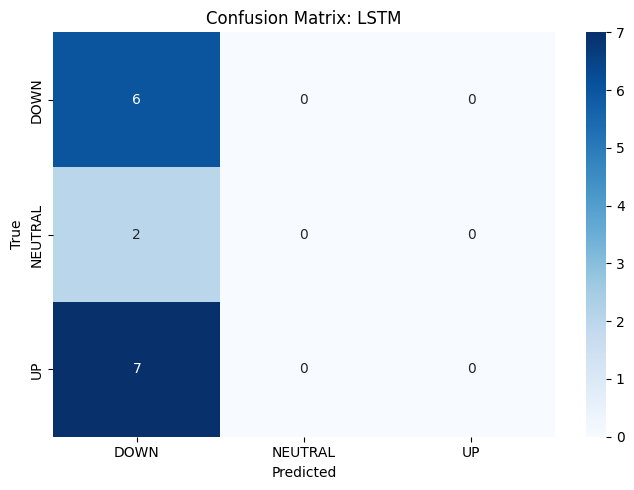

[HDFCBANK] Results DataFrame shape: (15, 27)
[HDFCBANK] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/HDFCBANK_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/HDFCBANK_results.xlsx
[HDFCBANK] 💾 Saved results to /content/output/HDFCBANK_results.xlsx
[UBL] ✅ Set DatetimeIndex. Index range: 2024-08-14 00:00:00 to 2024-08-30 00:00:00
✅ Completed processing for HDFCBANK
Adding technical indicators... Initial shape: (24, 25)

Epoch 43: val_loss did not improve from 0.47372
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - accuracy: 0.8182 - loss: 0.5191[UBL] ✅ Technical indicators added. Shape: (24, 73), Features: 73
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 19: val_loss improved from 0.97595 to 0.96292, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5



✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 0.4748 - learning_rate: 0.0010
Epoch 44/50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 1.0000 - loss: 0.0188
Epoch 44: val_loss did not improve from 0.47372
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5191 - val_accuracy: 1.0000 - val_loss: 0.9629 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0188 - val_accuracy: 1.0000 - val_loss: 0.4775 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 1.0000 - loss: 0.0053
Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 45: val_loss did not improve from 0.47372
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.0000e+00 - loss: 2.6488
Epoch 20: val_loss improved from 0.96292 to 0.95234, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 0.4782 - learning_rate: 0.0010
Epoch 46/50

Epoch 1: val_loss improved from inf to 1.04602, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5148 - val_accuracy: 1.0000 - val_loss: 0.9523 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.0000e+00 - loss: 2.6488 - val_accuracy: 0.0000e+00 - val_loss: 1.0460 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.0000e+00 - loss: 2.1942
Epoch 46: val_loss did not improve from 0.47372

Epoch 2: val_loss improved from 1.04602 to 1.02895, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.5734
Epoch 21: val_loss improved from 0.95234 to 0.93862, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 0.4775 - learning_rate: 5.0000e-04
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 1.0000 - loss: 0.0055
Epoch 47: val_loss did not improve from 0.47372
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 2.1942 - val_accuracy: 0.0000e+00 - val_loss: 1.0289 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.5734 - val_accuracy: 1.0000 - val_loss: 0.9386 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 0.4758 - learning_rate: 5.0000e-04
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 42.
[MANAPPURAM] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14

[MANAPPURAM] ✅ Loaded best model from /content/checkpoints/MANAPPURAM/MANAPPURAM_lstm_model.h5
[MANAPPURAM] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0000e+00 - loss: 1.8155
Epoch 3: val_loss improved from 1.02895 to 1.01538, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3858
Epoch 22: val_loss improved from 0.93862 to 0.92527, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


[MANAPPURAM] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         4
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.67      1.00      0.80        10

    accuracy                           0.67        15
   macro avg       0.22      0.33      0.27        15
weighted avg       0.44      0.67      0.53        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 1.8155 - val_accuracy: 1.0000 - val_loss: 1.0154 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2727 - loss: 1.3684

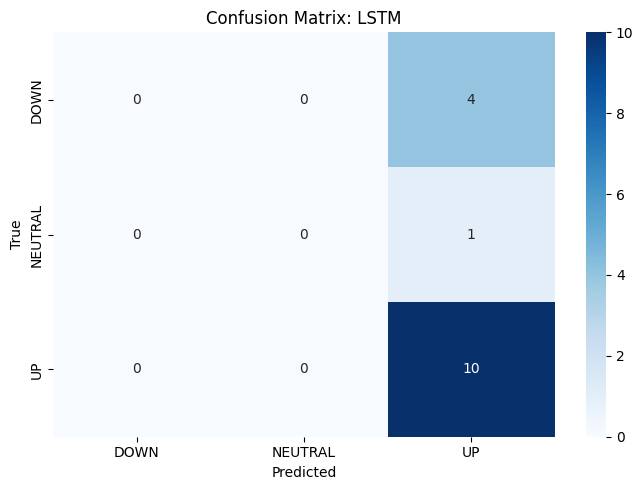

[MANAPPURAM] Results DataFrame shape: (15, 27)
[MANAPPURAM] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/MANAPPURAM_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/MANAPPURAM_results.xlsx
[MANAPPURAM] 💾 Saved results to /content/output/MANAPPURAM_results.xlsx
✅ Completed processing for MANAPPURAM
[BRITANNIA] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.3858 - val_accuracy: 1.0000 - val_loss: 0.9253 - learning_rate: 0.0010
Epoch 23/50
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[BRITANNIA] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[BRITANNIA] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 4: val_loss improved from 1.01538 to 0.99775, saving mod


✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 978ms/step - accuracy: 0.7273 - loss: 0.4962
Epoch 1: val_loss improved from inf to 1.19497, saving model to /content/checkpoints/UBL/UBL_lstm_model.h5



Epoch 23: val_loss improved from 0.92527 to 0.90950, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2727 - loss: 1.3684 - val_accuracy: 1.0000 - val_loss: 0.9978 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.1818 - loss: 1.7734 - val_accuracy: 0.0000e+00 - val_loss: 1.1950 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.4962 - val_accuracy: 1.0000 - val_loss: 0.9095 - learning_rate: 0.0010
Epoch 24/50

Epoch 5: val_loss improved from 0.99775 to 0.97879, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2727 - loss: 1.3291 - val_accuracy: 1.0000 - val_loss: 0.9788 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.4545 - loss: 1.1093
Epoch 6: val_loss improved from 0.97879 to 0.96479, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4640
Epoch 24: val_loss improved from 0.90950 to 0.89347, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.1093 - val_accuracy: 1.0000 - val_loss: 0.9648 - learning_rate: 0.0010
Epoch 7/50

Epoch 2: val_loss improved from 1.19497 to 1.08590, saving model to /content/checkpoints/UBL/UBL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4640 - val_accuracy: 1.0000 - val_loss: 0.8935 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3636 - loss: 1.2638 - val_accuracy: 0.0000e+00 - val_loss: 1.0859 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5455 - loss: 0.9295
Epoch 3: val_loss improved from 1.08590 to 0.96828, saving model to /content/checkpoints/UBL/UBL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4545 - loss: 1.2113
Epoch 7: val_loss improved from 0.96479 to 0.94786, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step - accuracy: 0.5455 - loss: 0.9295 - val_accuracy: 1.0000 - val_loss: 0.9683 - learning_rate: 0.0010
Epoch 4/50

Epoch 25: val_loss improved from 0.89347 to 0.87540, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.4545 - loss: 0.8403
Epoch 4: val_loss improved from 0.96828 to 0.89454, saving model to /content/checkpoints/UBL/UBL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4545 - loss: 1.2113 - val_accuracy: 1.0000 - val_loss: 0.9479 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.7273 - loss: 0.6835
Epoch 8: val_loss improved from 0.94786 to 0.92868, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.3554 - val_accuracy: 1.0000 - val_loss: 0.8754 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 0.8403 - val_accuracy: 1.0000 - val_loss: 0.8945 - learning_rate: 0.0010
Epoch 5/50

Epoch 26: val_loss improved from 0.87540 to 0.85975, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6835 - val_accuracy: 1.0000 - val_loss: 0.9287 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6364 - loss: 0.6884
Epoch 9: val_loss improved from 0.92868 to 0.91129, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3880 - val_accuracy: 1.0000 - val_loss: 0.8597 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.6896
Epoch 27: val_loss improved from 0.85975 to 0.84490, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5



Epoch 5: val_loss improved from 0.89454 to 0.86278, saving model to /content/checkpoints/UBL/UBL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.6884 - val_accuracy: 1.0000 - val_loss: 0.9113 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3210 - val_accuracy: 1.0000 - val_loss: 0.8449 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.6896 - val_accuracy: 1.0000 - val_loss: 0.8628 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6364 - loss: 0.7841
Epoch 6: val_loss improved from 0.86278 to 0.84573, saving model to /content/checkpoints/UBL/UBL_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.03813, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step - accuracy: 0.6364 - loss: 0.7841 - val_accuracy: 1.0000 - val_loss: 0.8457 - learning_rate: 0.0010

Epoch 10: val_loss improved from 0.91129 to 0.89132, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5
Epoch 7/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.4545 - loss: 1.4781 - val_accuracy: 0.0000e+00 - val_loss: 1.0381 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3191
Epoch 28: val_loss improved from 0.84490 to 0.83194, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.8350 - val_accuracy: 1.0000 - val_loss: 0.8913 - learning_rate: 0.0010
Epoch 11/50

Epoch 7: val_loss improved from 0.84573 to 0.84065, saving model to /content/checkpoints/UBL/UBL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5455 - loss: 0.8697
Epoch 11: val_loss improved from 0.89132 to 0.87685, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.4545 - loss: 1.0391

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3191 - val_accuracy: 1.0000 - val_loss: 0.8319 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9091 - loss: 0.3178
Epoch 2: val_loss did not improve from 1.03813

Epoch 29: val_loss improved from 0.83194 to 0.82154, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5954 - val_accuracy: 1.0000 - val_loss: 0.8407 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.8697 - val_accuracy: 1.0000 - val_loss: 0.8768 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.0391 - val_accuracy: 0.0000e+00 - val_loss: 1.0381 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3178 - val_accuracy: 1.0000 - val_loss: 0.8215 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.4545 - loss: 1.0779
Epoch 3: val_loss did not improve from 1.03813

Epoch 30: val_loss improved from 0.82154 to 0.81093, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step - accuracy: 0.4545 - loss: 1.0779 - val_accuracy: 0.0000e+00 - val_loss: 1.0445 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step - accuracy: 0.9091 - loss: 0.3827 - val_accuracy: 1.0000 - val_loss: 0.8109 - learning_rate: 0.0010
Epoch 31/50

Epoch 8: val_loss improved from 0.84065 to 0.83791, saving model to /content/checkpoints/UBL/UBL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.5455 - loss: 0.7638
Epoch 12: val_loss improved from 0.87685 to 0.86260, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5



Epoch 31: val_loss improved from 0.81093 to 0.80263, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.03813
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.8470 - val_accuracy: 1.0000 - val_loss: 0.8379 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.5455 - loss: 0.8278
Epoch 9: val_loss improved from 0.83791 to 0.82515, saving model to /content/checkpoints/UBL/UBL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4545 - loss: 0.9451 - val_accuracy: 1.0000 - val_loss: 0.8626 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.7638 - val_accuracy: 0.0000e+00 - val_loss: 1.0429 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2676 - val_accuracy: 1.0000 - val_loss: 0.8026 - learning_rate: 0.0010
Epoch 32/50

Epoch 5: val_loss did not improve from 1.03813
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.8278 - val_accuracy: 1.0000 - val_loss: 0.8251 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step - accuracy: 0.6364 - loss: 0.7123 - val_accuracy: 0.0000e+00 - val_loss: 1.0391 - learning_rate: 5.0000e-04
Epoch 6/50

Epoch 10: val_loss improved from 0.82515 to 0.82034, saving model to /content/checkpoints/UBL/UBL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 1.0000 - loss: 0.2711
Epoch 13: val_loss improved from 0.86260 to 0.84534, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5



Epoch 32: val_loss improved from 0.80263 to 0.79628, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.8182 - loss: 0.4394
Epoch 6: val_loss improved from 1.03813 to 1.03179, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5709 - val_accuracy: 1.0000 - val_loss: 0.8203 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5435 - val_accuracy: 1.0000 - val_loss: 0.8453 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2711 - val_accuracy: 1.0000 - val_loss: 0.7963 - learning_rate: 0.0010
Epoch 33/50

Epoch 14: val_loss improved from 0.84534 to 0.82558, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4394 - val_accuracy: 0.0000e+00 - val_loss: 1.0318 - learning_rate: 5.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step - accuracy: 0.6364 - loss: 0.6452 - val_accuracy: 1.0000 - val_loss: 0.8256 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8182 - loss: 0.6480
Epoch 15: val_loss improved from 0.82558 to 0.80949, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4292
Epoch 11: val_loss improved from 0.82034 to 0.81853, saving model to /content/checkpoints/UBL/UBL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - accuracy: 0.8182 - loss: 0.6480 - val_accuracy: 1.0000 - val_loss: 0.8095 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.2395
Epoch 16: val_loss improved from 0.80949 to 0.79935, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5



Epoch 33: val_loss improved from 0.79628 to 0.79077, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4292 - val_accuracy: 1.0000 - val_loss: 0.8185 - learning_rate: 0.0010
Epoch 12/50

Epoch 7: val_loss improved from 1.03179 to 1.02530, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6364 - loss: 0.6749
Epoch 12: val_loss did not improve from 0.81853
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6009 - val_accuracy: 1.0000 - val_loss: 0.7994 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2395 - val_accuracy: 1.0000 - val_loss: 0.7908 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.5216 - val_accuracy: 0.0000e+00 - val_loss: 1.0253 - learning_rate: 5.0000e-04
Epoch 8/50

Epoch 17: val_loss improved from 0.79935 to 0.79053, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.6749 - val_accuracy: 1.0000 - val_loss: 0.8249 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8182 - loss: 0.4831
Epoch 8: val_loss improved from 1.02530 to 1.01975, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5



Epoch 13: val_loss did not improve from 0.81853
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3973 - val_accuracy: 1.0000 - val_loss: 0.7905 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.3347
Epoch 34: val_loss improved from 0.79077 to 0.78768, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4831 - val_accuracy: 1.0000 - val_loss: 0.8293 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.3951 - val_accuracy: 0.0000e+00 - val_loss: 1.0197 - learning_rate: 5.0000e-04
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.3636 - loss: 0.8684
Epoch 9: val_loss improved from 1.01975 to 1.01527, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: val_loss did not improve from 0.81853
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.3347 - val_accuracy: 1.0000 - val_loss: 0.7877 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.5849
Epoch 35: val_loss improved from 0.78768 to 0.78747, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3941 - val_accuracy: 0.0000e+00 - val_loss: 1.0153 - learning_rate: 5.0000e-04
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 0.8684 - val_accuracy: 1.0000 - val_loss: 0.8363 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 0.3714
Epoch 18: val_loss improved from 0.79053 to 0.78127, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9091 - loss: 0.5135
Epoch 10: val_loss improved from 1.01527 to 1.01247, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5



Epoch 15: val_loss did not improve from 0.81853
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5166 - val_accuracy: 1.0000 - val_loss: 0.7875 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.5849 - val_accuracy: 1.0000 - val_loss: 0.7813 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.5135 - val_accuracy: 1.0000 - val_loss: 0.8353 - learning_rate: 5.0000e-04
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.3714 - val_accuracy: 0.0000e+00 - val_loss: 1.0125 - learning_rate: 5.0000e-04
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.8182 - loss: 0.5637
Epoch 16: val_loss did not improve from 0.81853
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step - accuracy: 0.8182 - loss: 0.5637 - val_accuracy: 1.0000 - val_loss: 0.8339 - learning_rate: 5.0000e-04
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 11

[UBL] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [1 2 1 2 1 2 2 0 1 0 0 0 0 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.7046

[UBL] ✅ Loaded best model from /content/checkpoints/UBL/UBL_lstm_model.h5
[UBL] Predicting for 15 dates, including 30-07-2025

Epoch 19: val_loss improved from 0.78127 to 0.77397, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3843
Epoch 11: val_loss improved from 1.01247 to 1.01059, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2761 - val_accuracy: 1.0000 - val_loss: 0.7867 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.2319
Epoch 37: val_loss improved from 0.78675 to 0.78563, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.7046 - val_accuracy: 1.0000 - val_loss: 0.7740 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3843 - val_accuracy: 0.0000e+00 - val_loss: 1.0106 - learning_rate: 5.0000e-04
Epoch 12/50
[UBL] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2319 - val_accuracy: 1.0000 - val_loss: 0.7856 - learning_rate: 0.0010
Epoch 38/50

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.71      0.83      0.77         6
     NEUTRAL       0.00      0.00      0.00         5
          UP       0.50      1.00      0.67         4

    accuracy                           0.60        15
   macro avg       0.40      0.61      0.48        15
weighted avg       0.42      0.60      0.49        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - los

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.4522

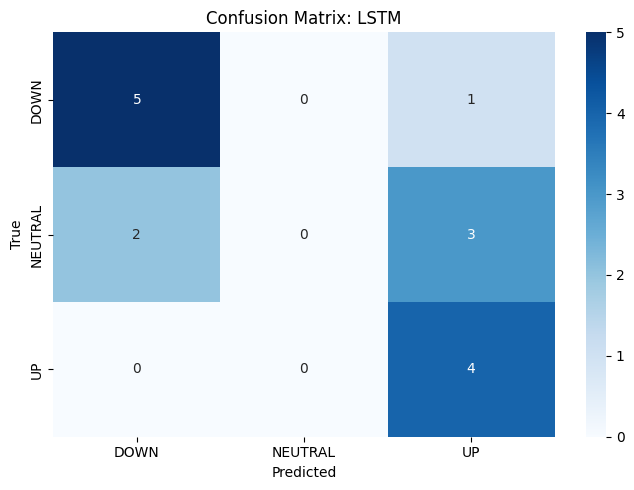


Epoch 20: val_loss improved from 0.77397 to 0.77073, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


[UBL] Results DataFrame shape: (15, 27)
[UBL] Prediction dates: [Timestamp('2024-08-22 00:00:00'), Timestamp('2024-08-22 00:00:00'), Timestamp('2024-08-23 00:00:00'), Timestamp('2024-08-23 00:00:00'), Timestamp('2024-08-26 00:00:00'), Timestamp('2024-08-26 00:00:00'), Timestamp('2024-08-27 00:00:00'), Timestamp('2024-08-27 00:00:00'), Timestamp('2024-08-28 00:00:00'), Timestamp('2024-08-28 00:00:00'), Timestamp('2024-08-29 00:00:00'), Timestamp('2024-08-29 00:00:00'), Timestamp('2024-08-30 00:00:00'), Timestamp('2024-08-30 00:00:00'), Timestamp('2025-07-30 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.2840Excel report successfully generated: /content/output/UBL_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/UBL_results.xlsx
[UBL] 💾 Saved results to /content/output/UBL_results.xlsx
✅ Completed processing for UBL
[BPCL] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[BPCL] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[BPCL] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

Epoch 12: val_loss improved from 1.01059 to 1.00724, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1908 - val_accuracy: 1.0000 - val_loss: 0.7842 - learning_rate: 0.0010
Epoch 39/50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.4522 - val_accuracy: 1.0000 - val_loss: 0.7707 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8182 - loss: 0.4310
Epoch 39: val_loss improved from 0.78418 to 0.78078, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2840 - val_accuracy: 0.0000e+00 - val_loss: 1.0072 - learning_rate: 5.0000e-04
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9091 - loss: 0.3778
Epoch 21: val_loss improved from 0.77073 to 0.76296, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5



Epoch 13: val_loss improved from 1.00724 to 1.00696, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2873 - val_accuracy: 1.0000 - val_loss: 0.7808 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4310 - val_accuracy: 1.0000 - val_loss: 0.7630 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3778 - val_accuracy: 0.0000e+00 - val_loss: 1.0070 - learning_rate: 5.0000e-04
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8182 - loss: 0.3728
Epoch 22: val_loss improved from 0.76296 to 0.75580, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.9091 - loss: 0.2818
Epoch 40: val_loss improved from 0.78078 to 0.77076, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3728 - val_accuracy: 1.0000 - val_loss: 0.7558 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2716
Epoch 23: val_loss improved from 0.75580 to 0.74796, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5



Epoch 14: val_loss improved from 1.00696 to 1.00557, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2818 - val_accuracy: 1.0000 - val_loss: 0.7708 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2716 - val_accuracy: 0.0000e+00 - val_loss: 1.0056 - learning_rate: 5.0000e-04
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5792 - val_accuracy: 1.0000 - val_loss: 0.7480 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.2372
Epoch 24: val_loss improved from 0.74796 to 0.74090, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1946
Epoch 41: val_loss improved from 0.77076 to 0.76000, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2372 - val_accuracy: 1.0000 - val_loss: 0.7409 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9091 - loss: 0.4153
Epoch 15: val_loss improved from 1.00557 to 1.00305, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5



Epoch 25: val_loss improved from 0.74090 to 0.73310, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1946 - val_accuracy: 1.0000 - val_loss: 0.7600 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 1.0000 - loss: 0.2362
Epoch 42: val_loss improved from 0.76000 to 0.75101, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2679 - val_accuracy: 0.0000e+00 - val_loss: 1.0031 - learning_rate: 5.0000e-04
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.4153 - val_accuracy: 1.0000 - val_loss: 0.7331 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2362 - val_accuracy: 1.0000 - val_loss: 0.7510 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9091 - loss: 0.2453
Epoch 43: val_loss improved from 0.75101 to 0.74096, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3927
Epoch 26: val_loss improved from 0.73310 to 0.72574, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5



Epoch 16: val_loss improved from 1.00305 to 0.99711, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step - accuracy: 0.9091 - loss: 0.2453 - val_accuracy: 1.0000 - val_loss: 0.7410 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2196 - val_accuracy: 0.0000e+00 - val_loss: 0.9971 - learning_rate: 5.0000e-04
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7273 - loss: 0.8123
Epoch 44: val_loss improved from 0.74096 to 0.72984, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3927 - val_accuracy: 1.0000 - val_loss: 0.7257 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 0.1879
Epoch 17: val_loss improved from 0.99711 to 0.98986, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5



Epoch 27: val_loss improved from 0.72574 to 0.71709, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.2619 - val_accuracy: 1.0000 - val_loss: 0.7298 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1187 - val_accuracy: 1.0000 - val_loss: 0.9899 - learning_rate: 5.0000e-04
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1879 - val_accuracy: 1.0000 - val_loss: 0.7171 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8182 - loss: 0.4178
Epoch 1: val_loss improved from inf to 1.11396, saving model to /content/checkpoints/BPCL/BPCL_lstm_model.h5



Epoch 28: val_loss improved from 0.71709 to 0.70651, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.7273 - loss: 0.8123 - val_accuracy: 0.0000e+00 - val_loss: 1.1140 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step - accuracy: 0.8182 - loss: 0.4178 - val_accuracy: 1.0000 - val_loss: 0.7065 - learning_rate: 0.0010
Epoch 29/50

Epoch 45: val_loss improved from 0.72984 to 0.72057, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1469
Epoch 2: val_loss improved from 1.11396 to 1.08234, saving model to /content/checkpoints/BPCL/BPCL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.9091 - loss: 0.2419
Epoch 18: val_loss improved from 0.98986 to 0.98313, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5



Epoch 29: val_loss improved from 0.70651 to 0.69487, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1687 - val_accuracy: 1.0000 - val_loss: 0.7206 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.4673 - val_accuracy: 0.0000e+00 - val_loss: 1.0823 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1469 - val_accuracy: 1.0000 - val_loss: 0.9831 - learning_rate: 5.0000e-04
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2419 - val_accuracy: 1.0000 - val_loss: 0.6949 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1695
Epoch 46: val_loss improved from 0.72057 to 0.71168, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1148
Epoch 3: val_loss improved from 1.08234 to 1.04484, saving model to /content/checkpoints/BPCL/BPCL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.2594
Epoch 19: val_loss improved from 0.98313 to 0.97627, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5



Epoch 30: val_loss improved from 0.69487 to 0.68184, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1695 - val_accuracy: 1.0000 - val_loss: 0.7117 - learning_rate: 0.0010


Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.5798 - val_accuracy: 1.0000 - val_loss: 1.0448 - learning_rate: 0.0010
Epoch 4/50

Epoch 47: val_loss improved from 0.71168 to 0.70710, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1148 - val_accuracy: 1.0000 - val_loss: 0.9763 - learning_rate: 5.0000e-04
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2594 - val_accuracy: 1.0000 - val_loss: 0.6818 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.1469Epoch 31/50

Epoch 4: val_loss improved from 1.04484 to 1.01540, saving model to /content/checkpoints/BPCL/BPCL_lstm_model.h5



Epoch 20: val_loss improved from 0.97627 to 0.96839, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2329 - val_accuracy: 1.0000 - val_loss: 0.7071 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5182 - val_accuracy: 1.0000 - val_loss: 1.0154 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step - accuracy: 1.0000 - loss: 0.1469 - val_accuracy: 1.0000 - val_loss: 0.9684 - learning_rate: 5.0000e-04
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7273 - loss: 0.4127
Epoch 5: val_loss improved from 1.01540 to 0.97719, saving model to /content/checkpoints/BPCL/BPCL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 1.0000 - loss: 0.1588
Epoch 31: val_loss improved from 0.68184 to 0.67025, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5



Epoch 21: val_loss improved from 0.96839 to 0.96134, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step - accuracy: 0.7273 - loss: 0.4127 - val_accuracy: 1.0000 - val_loss: 0.9772 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3008
Epoch 48: val_loss improved from 0.70710 to 0.70526, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2984 - val_accuracy: 1.0000 - val_loss: 0.6703 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1588 - val_accuracy: 1.0000 - val_loss: 0.9613 - learning_rate: 5.0000e-04
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.0922
Epoch 6: val_loss improved from 0.97719 to 0.93687, saving model to /content/checkpoints/BPCL/BPCL_lstm_model.h5



Epoch 32: val_loss improved from 0.67025 to 0.66084, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5



Epoch 22: val_loss improved from 0.96134 to 0.95459, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3008 - val_accuracy: 1.0000 - val_loss: 0.7053 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.2119
Epoch 49: val_loss improved from 0.70526 to 0.69942, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.4636 - val_accuracy: 1.0000 - val_loss: 0.9369 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2238 - val_accuracy: 1.0000 - val_loss: 0.6608 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0922 - val_accuracy: 1.0000 - val_loss: 0.9546 - learning_rate: 5.0000e-04
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 0.0766
Epoch 33: val_loss improved from 0.66084 to 0.65238, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5



Epoch 23: val_loss improved from 0.95459 to 0.94798, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2119 - val_accuracy: 1.0000 - val_loss: 0.6994 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2338 - val_accuracy: 1.0000 - val_loss: 0.6524 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0766 - val_accuracy: 1.0000 - val_loss: 0.9480 - learning_rate: 5.0000e-04
Epoch 24/50

Epoch 7: val_loss improved from 0.93687 to 0.89977, saving model to /content/checkpoints/BPCL/BPCL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8182 - loss: 0.2618
Epoch 24: val_loss improved from 0.94798 to 0.94120, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5



Epoch 34: val_loss improved from 0.65238 to 0.64309, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5725 - val_accuracy: 1.0000 - val_loss: 0.8998 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8182 - loss: 0.3855
Epoch 50: val_loss improved from 0.69942 to 0.69353, saving model to /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0755 - val_accuracy: 1.0000 - val_loss: 0.9412 - learning_rate: 5.0000e-04
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.2618 - val_accuracy: 1.0000 - val_loss: 0.6431 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 1.0000 - loss: 0.0630
Epoch 8: val_loss improved from 0.89977 to 0.86406, saving model to /content/checkpoints/BPCL/BPCL_lstm_model.h5



Epoch 25: val_loss improved from 0.94120 to 0.93490, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1621 - val_accuracy: 1.0000 - val_loss: 0.6935 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
[HEROMOTOCO] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[HEROMOTOCO] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[HEROMOTOCO] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 2 0 0 2 2 0 0 0 0 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3855 - val_accuracy: 1.0000 - val_loss: 0.8641 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8182 - loss: 0.3007

[HEROMOTOCO] ✅ Loaded best model from /content/checkpoints/HEROMOTOCO/HEROMOTOCO_lstm_model.h5
[HEROMOTOCO] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0630 - val_accuracy: 1.0000 - val_loss: 0.9349 - learning_rate: 5.0000e-04
Epoch 26/50

Epoch 9: val_loss improved from 0.86406 to 0.83056, saving model to /content/checkpoints/BPCL/BPCL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4073
Epoch 35: val_loss improved from 0.64309 to 0.63503, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5



Epoch 26: val_loss improved from 0.93490 to 0.92836, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3007 - val_accuracy: 1.0000 - val_loss: 0.8306 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4073 - val_accuracy: 1.0000 - val_loss: 0.6350 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1103 - val_accuracy: 1.0000 - val_loss: 0.9284 - learning_rate: 5.0000e-04
Epoch 27/50
[HEROMOTOCO] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 0.2753
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.73      1.00      0.85        11
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         3

    accuracy                           0.73        15
   macro avg       0.24      0.33      0.28        15
weighted avg       0.54      0.73      0.6

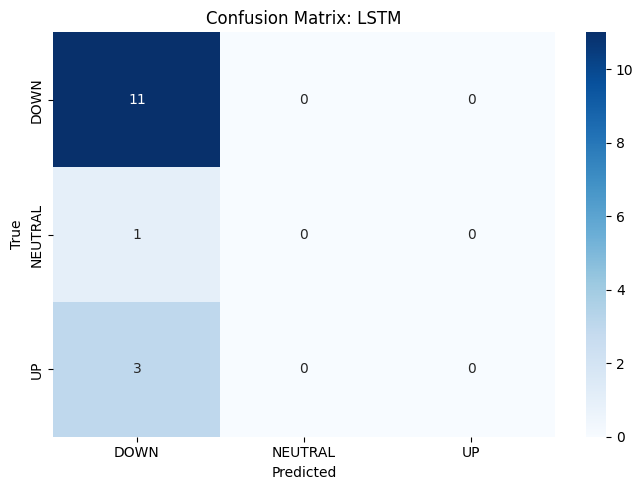

[HEROMOTOCO] Results DataFrame shape: (15, 27)
[HEROMOTOCO] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/HEROMOTOCO_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/HEROMOTOCO_results.xlsx
[HEROMOTOCO] 💾 Saved results to /content/output/HEROMOTOCO_results.xlsx
[BOSCHLTD] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for HEROMOTOCO
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.4958Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[BOSCHLTD] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[BOSCHLTD] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2753 - val_accuracy: 1.0000 - val_loss: 0.6266 - learning_rate: 0.0010
Epoch 37/50

Epoch 10: val_loss improved from 0.83056 to 0.81435, saving model to /content/check

Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 1.0000 - loss: 0.2166
✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"


Epoch 27: val_loss improved from 0.92836 to 0.92133, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 37: val_loss improved from 0.62658 to 0.61862, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.4958 - val_accuracy: 1.0000 - val_loss: 0.8143 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1103 - val_accuracy: 1.0000 - val_loss: 0.9213 - learning_rate: 5.0000e-04
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2166 - val_accuracy: 1.0000 - val_loss: 0.6186 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 1.0000 - loss: 0.0719
Epoch 28: val_loss improved from 0.92133 to 0.91501, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - accuracy: 0.8182 - loss: 0.5554
Epoch 11: val_loss improved from 0.81435 to 0.81153, saving model to /content/checkpoints/BPCL/BPCL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0719 - val_accuracy: 1.0000 - val_loss: 0.9150 - learning_rate: 5.0000e-04
Epoch 29/50

Epoch 38: val_loss improved from 0.61862 to 0.60967, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5554 - val_accuracy: 1.0000 - val_loss: 0.8115 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2004 - val_accuracy: 1.0000 - val_loss: 0.6097 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.1819
Epoch 39: val_loss improved from 0.60967 to 0.60085, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0884
Epoch 29: val_loss improved from 0.91501 to 0.91044, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3522
Epoch 12: val_loss did not improve from 0.81153
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1819 - val_accuracy: 1.0000 - val_loss: 0.6008 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0884 - val_accuracy: 1.0000 - val_loss: 0.9104 - learning_rate: 5.0000e-04
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3522 - val_accuracy: 1.0000 - val_loss: 0.8185 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8182 - loss: 0.3337
Epoch 30: val_loss improved from 0.91044 to 0.90482, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5



Epoch 13: val_loss did not improve from 0.81153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2063
Epoch 40: val_loss improved from 0.60085 to 0.59252, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3337 - val_accuracy: 1.0000 - val_loss: 0.8224 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1185 - val_accuracy: 1.0000 - val_loss: 0.9048 - learning_rate: 5.0000e-04
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 0.1028
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: val_loss did not improve from 0.81153

Epoch 31: val_loss improved from 0.90482 to 0.90127, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2063 - val_accuracy: 1.0000 - val_loss: 0.5925 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4559 - val_accuracy: 1.0000 - val_loss: 0.8256 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8182 - loss: 0.2456
Epoch 41: val_loss improved from 0.59252 to 0.58327, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1028 - val_accuracy: 1.0000 - val_loss: 0.9013 - learning_rate: 5.0000e-04
Epoch 32/50

Epoch 15: val_loss did not improve from 0.81153
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2247 - val_accuracy: 1.0000 - val_loss: 0.5833 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.2456 - val_accuracy: 1.0000 - val_loss: 0.8312 - learning_rate: 5.0000e-04
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0804
Epoch 16: val_loss did not improve from 0.81153

Epoch 42: val_loss improved from 0.58327 to 0.57394, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5



Epoch 32: val_loss improved from 0.90127 to 0.89719, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4691 - val_accuracy: 1.0000 - val_loss: 0.8372 - learning_rate: 5.0000e-04
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 11.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9091 - loss: 0.2975[BPCL] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[BPCL] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[BPCL] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 2 0 2 0 2 2 0 2 2 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.2724 - val_accuracy: 1.0000 - val_loss: 0.5739 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0804 - val_accuracy: 1.0000 - val_loss: 0.8972 - learning_rate: 5.0000e-04
Epoch 33/50
1/1 ━━━━━

[BPCL] ✅ Loaded best model from /content/checkpoints/BPCL/BPCL_lstm_model.h5
[BPCL] Predicting for 15 dates, including 30-07-2025

Epoch 43: val_loss improved from 0.57394 to 0.56231, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5



Epoch 33: val_loss improved from 0.89719 to 0.89338, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2301 - val_accuracy: 1.0000 - val_loss: 0.5623 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0255 - val_accuracy: 1.0000 - val_loss: 0.8934 - learning_rate: 5.0000e-04
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7273 - loss: 0.2673
Epoch 1: val_loss improved from inf to 1.02766, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5



Epoch 44: val_loss improved from 0.56231 to 0.55105, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


[BPCL] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.9091 - loss: 0.2975 - val_accuracy: 1.0000 - val_loss: 1.0277 - learning_rate: 0.0010
Epoch 2/50
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         3
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.73      1.00      0.85        11

    accuracy                           0.73        15
   macro avg       0.24      0.33      0.28        15
weighted avg       0.54      0.73      0.62        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.2673 - val_accuracy: 1.0000 - val_loss: 0.5511 - learning_rate: 0.0010
Epoch 45/50

Epoch 2: val_loss improved from 1.02766 to 0.99310, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9091 - loss: 0.1714

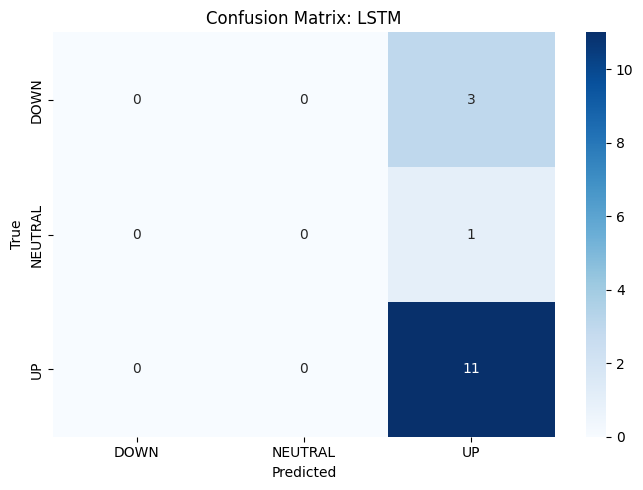

[BPCL] Results DataFrame shape: (15, 27)
[BPCL] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/BPCL_results.xlsx
Epoch 34: val_loss improved from 0.89338 to 0.88807, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/BPCL_results.xlsx
[BPCL] 💾 Saved results to /content/output/BPCL_results.xlsx
✅ Completed processing for BPCL
[BIOCON] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)

Epoch 45: val_loss improved from 0.55105 to 0.54048, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[BIOCON] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[BIOCON] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2450 - val_accuracy: 1.0000 - val_loss: 0.9931 - learning_rate: 0.0010
Epoch 3/50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0466 - val_accuracy: 1.0000 - val_loss: 0.8881 - learning_rate: 5.0000e-04
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1714 - val_accuracy: 1.0000 - val_loss: 0.5405 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.1473
Epoch 46: val_loss improved from 0.54048 to 0.53160, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0518
Epoch 3: val_loss improved from 0.99310 to 0.96732, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1473 - val_accuracy: 1.0000 - val_loss: 0.5316 - learning_rate: 0.0010
Epoch 47/50

Epoch 35: val_loss improved from 0.88807 to 0.88112, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1521 - val_accuracy: 1.0000 - val_loss: 0.9673 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0518 - val_accuracy: 1.0000 - val_loss: 0.8811 - learning_rate: 5.0000e-04
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.0529
Epoch 4: val_loss improved from 0.96732 to 0.94176, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2126
Epoch 36: val_loss improved from 0.88112 to 0.87508, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5



Epoch 47: val_loss improved from 0.53160 to 0.52256, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0711 - val_accuracy: 1.0000 - val_loss: 0.9418 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0529 - val_accuracy: 1.0000 - val_loss: 0.8751 - learning_rate: 5.0000e-04
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2126 - val_accuracy: 1.0000 - val_loss: 0.5226 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9091 - loss: 0.2562
Epoch 48: val_loss improved from 0.52256 to 0.51419, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step - accuracy: 0.9091 - loss: 0.2562 - val_accuracy: 1.0000 - val_loss: 0.5142 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0962
Epoch 5: val_loss improved from 0.94176 to 0.90737, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5



Epoch 37: val_loss improved from 0.87508 to 0.86992, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9091 - loss: 0.2275
Epoch 49: val_loss improved from 0.51419 to 0.50699, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0723 - val_accuracy: 1.0000 - val_loss: 0.9074 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0962 - val_accuracy: 1.0000 - val_loss: 0.8699 - learning_rate: 5.0000e-04
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2275 - val_accuracy: 1.0000 - val_loss: 0.5070 - learning_rate: 0.0010
Epoch 50/50

Epoch 6: val_loss improved from 0.90737 to 0.87659, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5



Epoch 38: val_loss improved from 0.86992 to 0.86437, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 1.0000 - loss: 0.1169
Epoch 50: val_loss improved from 0.50699 to 0.50019, saving model to /content/checkpoints/CANBK/CANBK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0467 - val_accuracy: 1.0000 - val_loss: 0.8766 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0328 - val_accuracy: 1.0000 - val_loss: 0.8644 - learning_rate: 5.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 0.0532Epoch 39/50

Epoch 7: val_loss improved from 0.87659 to 0.85338, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1169 - val_accuracy: 1.0000 - val_loss: 0.5002 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
[CANBK] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[CANBK] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[CANBK] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 0 2 2 2 2 2 2 2 2 2 0 2 1]


[CANBK] ✅ Loaded best model from /content/checkpoints/CANBK/CANBK_lstm_model.h5
[CANBK] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0532 - val_accuracy: 1.0000 - val_loss: 0.8534 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 0.0192
Epoch 8: val_loss improved from 0.85338 to 0.83428, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5



Epoch 39: val_loss improved from 0.86437 to 0.85899, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


[CANBK] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.0909 - loss: 1.9025
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         2
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.80      1.00      0.89        12

    accuracy                           0.80        15
   macro avg       0.27      0.33      0.30        15
weighted avg       0.64      0.80      0.71        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0192 - val_accuracy: 1.0000 - val_loss: 0.8343 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.0402 - val_accuracy: 1.0000 - val_loss: 0.8590 - learning_rate: 5.0000e-04
Epoch 9/50
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 1.0000 - loss: 0.0279

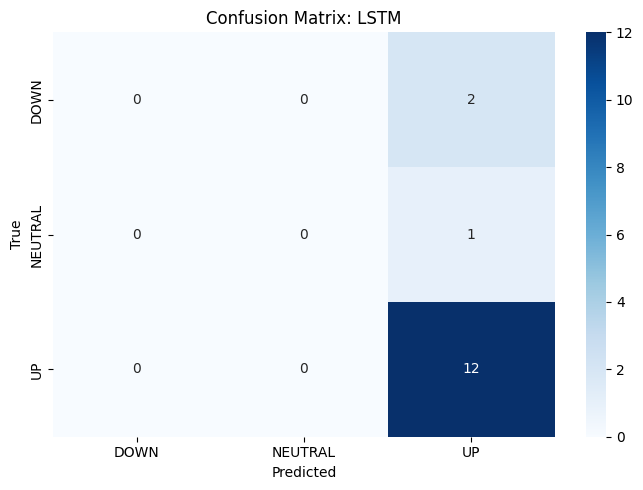

[CANBK] Results DataFrame shape: (15, 27)
[CANBK] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/CANBK_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/CANBK_results.xlsx
[CANBK] 💾 Saved results to /content/output/CANBK_results.xlsx
[BHEL] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for CANBK
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[BHEL] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[BHEL] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}

Epoch 9: val_loss improved from 0.83428 to 0.80735, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0279 - val_accuracy: 1.0000 - val_loss: 0.8074 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.1001Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 1.0000 - loss: 0.0221
Epoch 40: val_loss improved from 0.85899 to 0.85380, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5



Epoch 10: val_loss improved from 0.80735 to 0.78285, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.20382, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.1001 - val_accuracy: 1.0000 - val_loss: 0.8538 - learning_rate: 5.0000e-04
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0221 - val_accuracy: 1.0000 - val_loss: 0.7829 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.0909 - loss: 1.9025 - val_accuracy: 0.0000e+00 - val_loss: 1.2038 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.2727 - loss: 1.6727
Epoch 11: val_loss improved from 0.78285 to 0.76090, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5



Epoch 2: val_loss did not improve from 1.20382
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 1.0000 - loss: 0.0396
Epoch 41: val_loss improved from 0.85380 to 0.85075, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.6727 - val_accuracy: 0.0000e+00 - val_loss: 1.2057 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0226 - val_accuracy: 1.0000 - val_loss: 0.7609 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.3636 - loss: 1.3906
Epoch 3: val_loss improved from 1.20382 to 1.17860, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0396 - val_accuracy: 1.0000 - val_loss: 0.8508 - learning_rate: 5.0000e-04
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.3906 - val_accuracy: 0.0000e+00 - val_loss: 1.1786 - learning_rate: 0.0010
Epoch 4/50

Epoch 12: val_loss improved from 0.76090 to 0.74246, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0249
Epoch 42: val_loss improved from 0.85075 to 0.84784, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.7425 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4545 - loss: 1.2233
Epoch 13: val_loss improved from 0.74246 to 0.72632, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0249 - val_accuracy: 1.0000 - val_loss: 0.8478 - learning_rate: 5.0000e-04
Epoch 43/50

Epoch 4: val_loss improved from 1.17860 to 1.14308, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 1.0000 - loss: 0.0266
Epoch 43: val_loss improved from 0.84784 to 0.84550, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0122 - val_accuracy: 1.0000 - val_loss: 0.7263 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4545 - loss: 1.2233 - val_accuracy: 0.0000e+00 - val_loss: 1.1431 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0266 - val_accuracy: 1.0000 - val_loss: 0.8455 - learning_rate: 5.0000e-04
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.6364 - loss: 0.9253
Epoch 14: val_loss improved from 0.72632 to 0.71126, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5



Epoch 5: val_loss improved from 1.14308 to 1.11574, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0401
Epoch 44: val_loss improved from 0.84550 to 0.84264, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5



Epoch 1: val_loss improved from inf to 0.96870, saving model to /content/checkpoints/BHEL/BHEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 1.0000 - val_loss: 0.7113 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.9253 - val_accuracy: 0.0000e+00 - val_loss: 1.1157 - learning_rate: 0.0010
Epoch 6/50

Epoch 15: val_loss improved from 0.71126 to 0.69574, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0401 - val_accuracy: 1.0000 - val_loss: 0.8426 - learning_rate: 5.0000e-04
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.0000e+00 - loss: 2.1750 - val_accuracy: 1.0000 - val_loss: 0.9687 - learning_rate: 0.0010
Epoch 2/50

Epoch 6: val_loss improved from 1.11574 to 1.09521, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0201 - val_accuracy: 1.0000 - val_loss: 0.6957 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.0337 - val_accuracy: 0.0000e+00 - val_loss: 1.0952 - learning_rate: 0.0010
Epoch 7/50

Epoch 2: val_loss improved from 0.96870 to 0.96759, saving model to /content/checkpoints/BHEL/BHEL_lstm_model.h5



Epoch 16: val_loss improved from 0.69574 to 0.68265, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0240
Epoch 7: val_loss improved from 1.09521 to 1.07161, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5



Epoch 45: val_loss improved from 0.84264 to 0.84040, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 1.9195 - val_accuracy: 1.0000 - val_loss: 0.9676 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 17/50

Epoch 3: val_loss did not improve from 0.96759
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7937 - val_accuracy: 0.0000e+00 - val_loss: 1.0716 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0240 - val_accuracy: 1.0000 - val_loss: 0.8404 - learning_rate: 5.0000e-04
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0909 - loss: 1.6947 - val_accuracy: 1.0000 - val_loss: 0.9717 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0079
Epoch 4: val_loss did not improve from 0.96759

Epoch 17: val_loss improved from 0.68265 to 0.66908, saving model to /content/checkpo

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.2245 - val_accuracy: 1.0000 - val_loss: 0.9778 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5455 - loss: 1.0312
Epoch 8: val_loss improved from 1.07161 to 1.05024, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5



Epoch 46: val_loss improved from 0.84040 to 0.83530, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_loss did not improve from 0.96759
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 1.0000 - val_loss: 0.6691 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.0312 - val_accuracy: 1.0000 - val_loss: 0.9833 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.6819 - val_accuracy: 1.0000 - val_loss: 1.0502 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0341 - val_accuracy: 1.0000 - val_loss: 0.8353 - learning_rate: 5.0000e-04
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.4545 - loss: 1.0762
Epoch 9: val_loss improved from 1.05024 to 1.01899, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5



Epoch 6: val_loss did not improve from 0.96759
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step - accuracy: 0.4545 - loss: 1.0762 - val_accuracy: 1.0000 - val_loss: 0.9839 - learning_rate: 5.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step - accuracy: 0.4545 - loss: 0.7829 - val_accuracy: 1.0000 - val_loss: 1.0190 - learning_rate: 0.0010
Epoch 10/50

Epoch 18: val_loss improved from 0.66908 to 0.65401, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 0.6540 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0068
Epoch 19: val_loss improved from 0.65401 to 0.64038, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.4545 - loss: 1.0645
Epoch 10: val_loss improved from 1.01899 to 0.98440, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5



Epoch 7: val_loss did not improve from 0.96759

Epoch 47: val_loss improved from 0.83530 to 0.83032, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 0.6404 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.0645 - val_accuracy: 1.0000 - val_loss: 0.9833 - learning_rate: 5.0000e-04
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.5185 - val_accuracy: 1.0000 - val_loss: 0.9844 - learning_rate: 0.0010
Epoch 11/50
[BHEL] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0357 - val_accuracy: 1.0000 - val_loss: 0.8303 - learning_rate: 5.0000e-04
Epoch 48/50

Epoch 20: val_loss improved from 0.64038 to 0.62549, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[BHEL] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[BHEL] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 2 2 2 2 2 2 2 0 2 2 1]


[BHEL] ✅ Loaded best model from /content/checkpoints/BHEL/BHEL_lstm_model.h5
[BHEL] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.6255 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 0.0062[BHEL] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 21: val_loss improved from 0.62549 to 0.61173, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.07      1.00      0.12         1
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00        13

    accuracy                           0.07        15
   macro avg       0.02      0.33      0.04        15
weighted avg       0.00      0.07      0.01        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.4464
Epoch 11: val_loss improved from 0.98440 to 0.94640, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5



Epoch 48: val_loss improved from 0.83032 to 0.82510, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 0.6117 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 1.0000 - loss: 0.0042

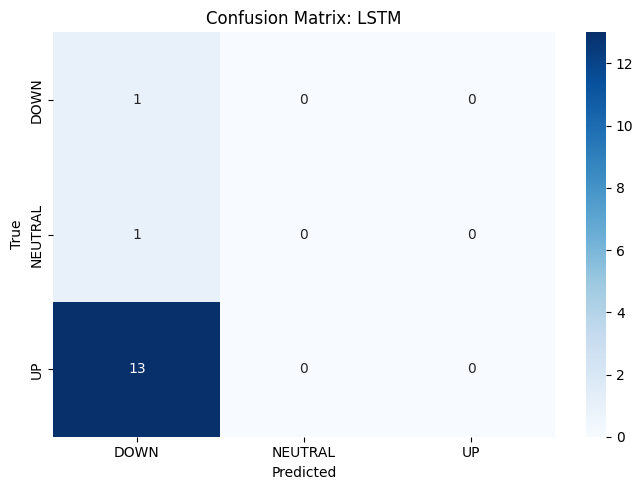

[BHEL] Results DataFrame shape: (15, 27)
[BHEL] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/BHEL_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/BHEL_results.xlsx
[BHEL] 💾 Saved results to /content/output/BHEL_results.xlsx
[ULTRACEMCO] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for BHEL

Epoch 22: val_loss improved from 0.61173 to 0.59846, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[ULTRACEMCO] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[ULTRACEMCO] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0265 - val_accuracy: 1.0000 - val_loss: 0.8251 - learning_rate: 5.0000e-04
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.4464 - val_accuracy: 1.0000 - val_loss: 0.9464 - learning_rate: 0.0010
Epoch 12/50

✅ Built model: LSTM_Model | Output classes: 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9091 - loss: 0.3873

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50

Epoch 12: val_loss improved from 0.94640 to 0.90692, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 1.0000 - val_loss: 0.5985 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3873 - val_accuracy: 1.0000 - val_loss: 0.9069 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 0.2827
Epoch 13: val_loss improved from 0.90692 to 0.87175, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5



Epoch 49: val_loss improved from 0.82510 to 0.82118, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0055
Epoch 23: val_loss improved from 0.59846 to 0.58612, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2827 - val_accuracy: 1.0000 - val_loss: 0.8718 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0308 - val_accuracy: 1.0000 - val_loss: 0.8212 - learning_rate: 5.0000e-04
Epoch 50/50

Epoch 14: val_loss improved from 0.87175 to 0.83558, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 0.5861 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0059
Epoch 24: val_loss improved from 0.58612 to 0.57382, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.3137 - val_accuracy: 1.0000 - val_loss: 0.8356 - learning_rate: 0.0010
Epoch 15/50

Epoch 50: val_loss improved from 0.82118 to 0.81632, saving model to /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 0.5738 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0022
Epoch 25: val_loss improved from 0.57382 to 0.56222, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0339 - val_accuracy: 1.0000 - val_loss: 0.8163 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 50.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.3116
Epoch 15: val_loss improved from 0.83558 to 0.80068, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 0.5622 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.3116 - val_accuracy: 1.0000 - val_loss: 0.8007 - learning_rate: 0.0010
Epoch 16/50

Epoch 26: val_loss improved from 0.56222 to 0.55113, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 0.2233[BRITANNIA] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[BRITANNIA] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[BRITANNIA] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]

Epoch 16: val_loss improved from 0.80068 to 0.76810, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


[BRITANNIA] ✅ Loaded best model from /content/checkpoints/BRITANNIA/BRITANNIA_lstm_model.h5
[BRITANNIA] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.5511 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2233 - val_accuracy: 1.0000 - val_loss: 0.7681 - learning_rate: 0.0010
Epoch 17/50

Epoch 27: val_loss improved from 0.55113 to 0.54189, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 0.1189
Epoch 17: val_loss improved from 0.76810 to 0.73639, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


[BRITANNIA] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 0.5419 - learning_rate: 0.0010
Epoch 28/50
              precision    recall  f1-score   support

        DOWN       0.93      1.00      0.97        14
     NEUTRAL       0.00      0.00      0.00         1

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1189 - val_accuracy: 1.0000 - val_loss: 0.7364 - learning_rate: 0.0010
Epoch 18/50

Epoch 28: val_loss improved from 0.54189 to 0.53210, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


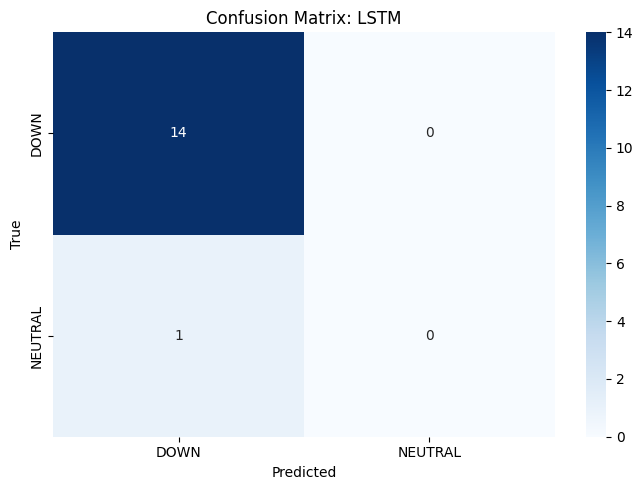

[BRITANNIA] Results DataFrame shape: (15, 26)
[BRITANNIA] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/BRITANNIA_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/BRITANNIA_results.xlsx
[BRITANNIA] 💾 Saved results to /content/output/BRITANNIA_results.xlsx
✅ Completed processing for BRITANNIA
[BHARTIARTL] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[BHARTIARTL] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[BHARTIARTL] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.5321 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1869Epoch 1/50

Epoch 29: val_loss improved from 0.53210 to 0.52258, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5



Epoch 18: val_loss improved from 0.73639 to 0.70790, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 0.5226 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1869 - val_accuracy: 1.0000 - val_loss: 0.7079 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1614
Epoch 30: val_loss improved from 0.52258 to 0.51346, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5



Epoch 19: val_loss improved from 0.70790 to 0.68037, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5



Epoch 1: val_loss improved from inf to 0.89447, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 0.5135 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1614 - val_accuracy: 1.0000 - val_loss: 0.6804 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 1.0000 - loss: 0.0033
Epoch 31: val_loss improved from 0.51346 to 0.50518, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.1818 - loss: 1.5320 - val_accuracy: 1.0000 - val_loss: 0.8945 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 0.5052 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 0.0031
Epoch 20: val_loss improved from 0.68037 to 0.65657, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5



Epoch 32: val_loss improved from 0.50518 to 0.49831, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1937 - val_accuracy: 1.0000 - val_loss: 0.6566 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 0.4983 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4545 - loss: 1.0411
Epoch 2: val_loss improved from 0.89447 to 0.87424, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4545 - loss: 1.0411 - val_accuracy: 1.0000 - val_loss: 0.8742 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0017
Epoch 3: val_loss improved from 0.87424 to 0.85807, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5



Epoch 21: val_loss improved from 0.65657 to 0.63189, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5



Epoch 33: val_loss improved from 0.49831 to 0.49128, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.7657 - val_accuracy: 1.0000 - val_loss: 0.8581 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.1912 - val_accuracy: 1.0000 - val_loss: 0.6319 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.4913 - learning_rate: 0.0010
Epoch 34/50

Epoch 4: val_loss improved from 0.85807 to 0.84724, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.21466, saving model to /content/checkpoints/BHARTIARTL/BHARTIARTL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7573 - val_accuracy: 1.0000 - val_loss: 0.8472 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.0000e+00 - loss: 1.4193 - val_accuracy: 0.0000e+00 - val_loss: 1.2147 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9091 - loss: 0.5267
Epoch 5: val_loss improved from 0.84724 to 0.84092, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5



Epoch 22: val_loss improved from 0.63189 to 0.60955, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5



Epoch 34: val_loss improved from 0.49128 to 0.48468, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.5267 - val_accuracy: 1.0000 - val_loss: 0.8409 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1157 - val_accuracy: 1.0000 - val_loss: 0.6096 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.4847 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8182 - loss: 0.5140
Epoch 6: val_loss improved from 0.84092 to 0.82829, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step - accuracy: 0.8182 - loss: 0.5140 - val_accuracy: 1.0000 - val_loss: 0.8283 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 1.0000 - loss: 0.3790
Epoch 7: val_loss improved from 0.82829 to 0.81457, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step - accuracy: 1.0000 - loss: 0.3790 - val_accuracy: 1.0000 - val_loss: 0.8146 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9091 - loss: 0.3430
Epoch 2: val_loss did not improve from 1.21466
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0012
Epoch 23: val_loss improved from 0.60955 to 0.59007, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5



Epoch 8: val_loss improved from 0.81457 to 0.79716, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5



Epoch 35: val_loss improved from 0.48468 to 0.47900, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5455 - loss: 1.0120 - val_accuracy: 0.0000e+00 - val_loss: 1.2233 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1579 - val_accuracy: 1.0000 - val_loss: 0.5901 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3430 - val_accuracy: 1.0000 - val_loss: 0.7972 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.4790 - learning_rate: 0.0010
Epoch 36/50

Epoch 3: val_loss did not improve from 1.21466
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9091 - loss: 0.3493
Epoch 9: val_loss improved from 0.79716 to 0.78010, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step - accuracy: 0.6364 - loss: 0.7691 - val_accuracy: 0.0000e+00 - val_loss: 1.2324 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step - accuracy: 0.9091 - loss: 0.3493 - val_accuracy: 1.0000 - val_loss: 0.7801 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 0.3004
Epoch 10: val_loss improved from 0.78010 to 0.76307, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1184
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.21466
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step - accuracy: 1.0000 - loss: 0.3004 - val_accuracy: 1.0000 - val_loss: 0.7631 - learning_rate: 0.0010
Epoch 11/50

Epoch 24: val_loss improved from 0.59007 to 0.57327, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9091 - loss: 0.3705
Epoch 36: val_loss improved from 0.47900 to 0.47343, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5



Epoch 11: val_loss improved from 0.76307 to 0.74546, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7203 - val_accuracy: 0.0000e+00 - val_loss: 1.2424 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1184 - val_accuracy: 1.0000 - val_loss: 0.5733 - learning_rate: 0.0010
Epoch 25/50

Epoch 5: val_loss did not improve from 1.21466
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.4734 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3705 - val_accuracy: 1.0000 - val_loss: 0.7455 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step - accuracy: 0.6364 - loss: 0.9183 - val_accuracy: 0.0000e+00 - val_loss: 1.2491 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.6364 - loss: 0.7878
Epoch 6: val_loss did not improve from 1.21466
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0026
Epoch 25:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.7878 - val_accuracy: 0.0000e+00 - val_loss: 1.2538 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3299
Epoch 37: val_loss improved from 0.47343 to 0.46779, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


[BHARTIARTL] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[BHARTIARTL] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[BHARTIARTL] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 0 0 0 2 2 0 0 2 0 2 0 0 1]

Epoch 12: val_loss improved from 0.74546 to 0.72788, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


[BHARTIARTL] ✅ Loaded best model from /content/checkpoints/BHARTIARTL/BHARTIARTL_lstm_model.h5
[BHARTIARTL] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0686 - val_accuracy: 1.0000 - val_loss: 0.5576 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.4678 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3299 - val_accuracy: 1.0000 - val_loss: 0.7279 - learning_rate: 0.0010
Epoch 13/50
[BHARTIARTL] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.60      0.67      0.63         9
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         5

    accuracy                           0.40        15
   macro avg      

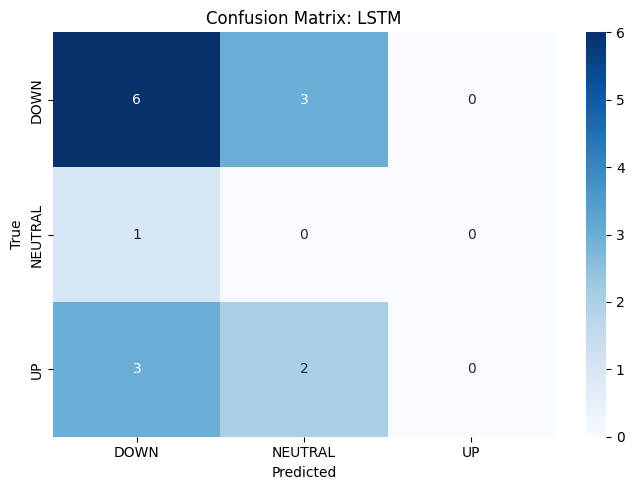

[BHARTIARTL] Results DataFrame shape: (15, 27)
[BHARTIARTL] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/BHARTIARTL_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/BHARTIARTL_results.xlsx
[BHARTIARTL] 💾 Saved results to /content/output/BHARTIARTL_results.xlsx
✅ Completed processing for BHARTIARTL
[ASHOKLEY] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[ASHOKLEY] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[ASHOKLEY] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0019
Epoch 26: val_loss improved from 0.55757 to 0.54283, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1286
Epoch 38: val_loss improved from 0.46779 to 0.46209, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5



Epoch 13: val_loss improved from 0.72788 to 0.71050, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0759 - val_accuracy: 1.0000 - val_loss: 0.5428 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.4621 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1286 - val_accuracy: 1.0000 - val_loss: 0.7105 - learning_rate: 0.0010
Epoch 14/50

Epoch 27: val_loss improved from 0.54283 to 0.52937, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0728 - val_accuracy: 1.0000 - val_loss: 0.5294 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0014
Epoch 28: val_loss improved from 0.52937 to 0.51472, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1885
Epoch 39: val_loss improved from 0.46209 to 0.45673, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5



Epoch 14: val_loss improved from 0.71050 to 0.69499, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0638 - val_accuracy: 1.0000 - val_loss: 0.5147 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.4567 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.1885 - val_accuracy: 1.0000 - val_loss: 0.6950 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9091 - loss: 0.3562
Epoch 15: val_loss improved from 0.69499 to 0.67558, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 29: val_loss improved from 0.51472 to 0.50205, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5



Epoch 40: val_loss improved from 0.45673 to 0.45164, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3562 - val_accuracy: 1.0000 - val_loss: 0.6756 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0824 - val_accuracy: 1.0000 - val_loss: 0.5020 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.4516 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 41: val_loss improved from 0.45164 to 0.44726, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1452
Epoch 16: val_loss improved from 0.67558 to 0.65870, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.4473 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 42: val_loss improved from 0.44726 to 0.44255, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5



Epoch 30: val_loss improved from 0.50205 to 0.49087, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1452 - val_accuracy: 1.0000 - val_loss: 0.6587 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.4426 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0567 - val_accuracy: 1.0000 - val_loss: 0.4909 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1938
Epoch 17: val_loss improved from 0.65870 to 0.64134, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0015
Epoch 31: val_loss improved from 0.49087 to 0.47985, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5



Epoch 1: val_loss improved from inf to 0.92875, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1938 - val_accuracy: 1.0000 - val_loss: 0.6413 - learning_rate: 0.0010
Epoch 18/50

Epoch 43: val_loss improved from 0.44255 to 0.43799, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 1.0000 - loss: 0.2112
Epoch 18: val_loss improved from 0.64134 to 0.62583, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0313 - val_accuracy: 1.0000 - val_loss: 0.4799 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.9091 - loss: 0.3811 - val_accuracy: 1.0000 - val_loss: 0.9287 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.4380 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 9.1581e-04
Epoch 2: val_loss improved from 0.92875 to 0.91543, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5



Epoch 44: val_loss improved from 0.43799 to 0.43363, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2112 - val_accuracy: 1.0000 - val_loss: 0.6258 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.1515
Epoch 19: val_loss improved from 0.62583 to 0.60992, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5830 - val_accuracy: 1.0000 - val_loss: 0.9154 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 9.1581e-04 - val_accuracy: 1.0000 - val_loss: 0.4336 - learning_rate: 0.0010
Epoch 45/50

Epoch 32: val_loss improved from 0.47985 to 0.46987, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1515 - val_accuracy: 1.0000 - val_loss: 0.6099 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0722 - val_accuracy: 1.0000 - val_loss: 0.4699 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0254
Epoch 20: val_loss improved from 0.60992 to 0.59850, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5



Epoch 33: val_loss improved from 0.46987 to 0.45991, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step - accuracy: 0.8182 - loss: 0.5364 - val_accuracy: 1.0000 - val_loss: 0.5985 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step - accuracy: 1.0000 - loss: 0.0254 - val_accuracy: 1.0000 - val_loss: 0.4599 - learning_rate: 0.0010
Epoch 21/50
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0011
Epoch 3: val_loss improved from 0.91543 to 0.89878, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5



Epoch 45: val_loss improved from 0.43363 to 0.42928, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2457 - val_accuracy: 1.0000 - val_loss: 0.8988 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9091 - loss: 0.2617
Epoch 21: val_loss improved from 0.59850 to 0.58941, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5



Epoch 34: val_loss improved from 0.45991 to 0.45086, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5



Epoch 4: val_loss improved from 0.89878 to 0.88899, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.4293 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1069 - val_accuracy: 1.0000 - val_loss: 0.5894 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0387 - val_accuracy: 1.0000 - val_loss: 0.4509 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2617 - val_accuracy: 1.0000 - val_loss: 0.8890 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9091 - loss: 0.2302
Epoch 35: val_loss improved from 0.45086 to 0.44112, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5



Epoch 5: val_loss improved from 0.88899 to 0.88533, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0011
Epoch 46: val_loss improved from 0.42928 to 0.42543, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0432 - val_accuracy: 1.0000 - val_loss: 0.4411 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2302 - val_accuracy: 1.0000 - val_loss: 0.8853 - learning_rate: 0.0010
Epoch 6/50

Epoch 22: val_loss improved from 0.58941 to 0.58227, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 0.0439
Epoch 36: val_loss improved from 0.44112 to 0.43198, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.4254 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2258 - val_accuracy: 1.0000 - val_loss: 0.5823 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0439 - val_accuracy: 1.0000 - val_loss: 0.4320 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1778
Epoch 37: val_loss improved from 0.43198 to 0.42257, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5



Epoch 6: val_loss improved from 0.88533 to 0.87822, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0014
Epoch 47: val_loss improved from 0.42543 to 0.42148, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0337 - val_accuracy: 1.0000 - val_loss: 0.4226 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1778 - val_accuracy: 1.0000 - val_loss: 0.8782 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 1.0000 - loss: 0.0341
Epoch 23: val_loss improved from 0.58227 to 0.57553, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8182 - loss: 0.3018
Epoch 38: val_loss improved from 0.42257 to 0.41329, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.4215 - learning_rate: 0.0010
Epoch 48/50

Epoch 7: val_loss improved from 0.87822 to 0.87146, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0771 - val_accuracy: 1.0000 - val_loss: 0.5755 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0341 - val_accuracy: 1.0000 - val_loss: 0.4133 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3018 - val_accuracy: 1.0000 - val_loss: 0.8715 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 0.0380
Epoch 39: val_loss improved from 0.41329 to 0.40353, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8182 - loss: 0.3197
Epoch 8: val_loss improved from 0.87146 to 0.85908, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step - accuracy: 1.0000 - loss: 0.0380 - val_accuracy: 1.0000 - val_loss: 0.4035 - learning_rate: 0.0010
Epoch 40/50

Epoch 48: val_loss improved from 0.42148 to 0.41766, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3197 - val_accuracy: 1.0000 - val_loss: 0.8591 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9091 - loss: 0.1511
Epoch 40: val_loss improved from 0.40353 to 0.39468, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5



Epoch 24: val_loss improved from 0.57553 to 0.57066, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5



Epoch 9: val_loss improved from 0.85908 to 0.84995, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 7.7086e-04 - val_accuracy: 1.0000 - val_loss: 0.4177 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0400 - val_accuracy: 1.0000 - val_loss: 0.3947 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1204 - val_accuracy: 1.0000 - val_loss: 0.5707 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1511 - val_accuracy: 1.0000 - val_loss: 0.8499 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9091 - loss: 0.2840
Epoch 10: val_loss improved from 0.84995 to 0.84075, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5



Epoch 25: val_loss improved from 0.57066 to 0.56831, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step - accuracy: 0.9091 - loss: 0.2840 - val_accuracy: 1.0000 - val_loss: 0.8408 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step - accuracy: 1.0000 - loss: 0.2007 - val_accuracy: 1.0000 - val_loss: 0.5683 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0357
Epoch 49: val_loss improved from 0.41766 to 0.41413, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5



Epoch 11: val_loss improved from 0.84075 to 0.83180, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5



Epoch 26: val_loss improved from 0.56831 to 0.56731, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5



Epoch 41: val_loss improved from 0.39468 to 0.38608, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.4141 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0570 - val_accuracy: 1.0000 - val_loss: 0.5673 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2699 - val_accuracy: 1.0000 - val_loss: 0.8318 - learning_rate: 0.0010
Epoch 27/50
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0357 - val_accuracy: 1.0000 - val_loss: 0.3861 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9091 - loss: 0.1163
Epoch 12: val_loss improved from 0.83180 to 0.82450, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step - accuracy: 0.9091 - loss: 0.1163 - val_accuracy: 1.0000 - val_loss: 0.8245 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9091 - loss: 0.1364
Epoch 13: val_loss improved from 0.82450 to 0.81296, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9091 - loss: 0.1364 - val_accuracy: 1.0000 - val_loss: 0.8130 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 9.1354e-04
Epoch 14: val_loss improved from 0.81296 to 0.80125, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0784
Epoch 50: val_loss improved from 0.41413 to 0.41064, saving model to /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0282
Epoch 27: val_loss improved from 0.56731 to 0.56569, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5



Epoch 42: val_loss improved from 0.38608 to 0.37817, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0690 - val_accuracy: 1.0000 - val_loss: 0.8012 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 9.1354e-04 - val_accuracy: 1.0000 - val_loss: 0.4106 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.

Epoch 15: val_loss improved from 0.80125 to 0.78912, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0784 - val_accuracy: 1.0000 - val_loss: 0.5657 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0282 - val_accuracy: 1.0000 - val_loss: 0.3782 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0209
Epoch 43: val_loss improved from 0.37817 to 0.37021, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2539 - val_accuracy: 1.0000 - val_loss: 0.7891 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9091 - loss: 0.1186
Epoch 16: val_loss improved from 0.78912 to 0.77655, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5


[BOSCHLTD] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step - accuracy: 1.0000 - loss: 0.0209 - val_accuracy: 1.0000 - val_loss: 0.3702 - learning_rate: 0.0010
Epoch 44/50
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[BOSCHLTD] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[BOSCHLTD] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0766


Epoch 28: val_loss improved from 0.56569 to 0.56421, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


[BOSCHLTD] ✅ Loaded best model from /content/checkpoints/BOSCHLTD/BOSCHLTD_lstm_model.h5
[BOSCHLTD] Predicting for 15 dates, including 30-07-2025

Epoch 44: val_loss improved from 0.37021 to 0.36506, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1186 - val_accuracy: 1.0000 - val_loss: 0.7766 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9091 - loss: 0.1497
Epoch 17: val_loss improved from 0.77655 to 0.76338, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0766 - val_accuracy: 1.0000 - val_loss: 0.5642 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1705 - val_accuracy: 1.0000 - val_loss: 0.3651 - learning_rate: 0.0010
Epoch 45/50
[BOSCHLTD] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1497 - val_accuracy: 1.0000 - val_loss: 0.7634 - learning_rate: 0.0010
Epoch 18/50

Classification Report for LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9091 - loss: 0.2125              precision    recall  f1-score   support

        DOWN       0.93      1.00      0.97        14
     NEUTRAL       0.00      0.00      0.00         1

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15


Epoch 29: val_loss improved from 0.56421 to 0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 1.0000 - loss: 0.0242
Epoch 18: val_loss improved from 0.76338 to 0.75223, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5



Epoch 45: val_loss improved from 0.36506 to 0.36009, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


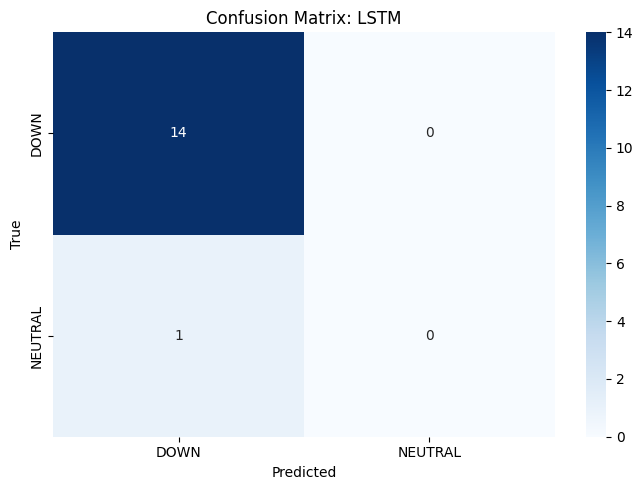

[BOSCHLTD] Results DataFrame shape: (15, 26)
[BOSCHLTD] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/BOSCHLTD_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/BOSCHLTD_results.xlsx
[BOSCHLTD] 💾 Saved results to /content/output/BOSCHLTD_results.xlsx
[BHARATFORG] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for BOSCHLTD
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.1718 - val_accuracy: 1.0000 - val_loss: 0.5619 - learning_rate: 0.0010
Epoch 30/50
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[BHARATFORG] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[BHARATFORG] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.212

Model: "LSTM_Model"

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0242 - val_accuracy: 1.0000 - val_loss: 0.3601 - learning_rate: 0.0010


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

Epoch 46/50


 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.0153Epoch 1/50

Epoch 46: val_loss improved from 0.36009 to 0.35606, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.9091 - loss: 0.2310
Epoch 30: val_loss improved from 0.56186 to 0.55878, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.9091 - loss: 0.1215
Epoch 19: val_loss improved from 0.75223 to 0.74492, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 1.0000 - val_loss: 0.3561 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 1.0000 - loss: 0.0159
Epoch 47: val_loss improved from 0.35606 to 0.35260, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2310 - val_accuracy: 1.0000 - val_loss: 0.5588 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1215 - val_accuracy: 1.0000 - val_loss: 0.7449 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 0.0517
Epoch 20: val_loss improved from 0.74492 to 0.73868, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0159 - val_accuracy: 1.0000 - val_loss: 0.3526 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0517 - val_accuracy: 1.0000 - val_loss: 0.7387 - learning_rate: 0.0010
Epoch 21/50

Epoch 31: val_loss improved from 0.55878 to 0.55570, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9091 - loss: 0.1575
Epoch 21: val_loss did not improve from 0.73868
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0969 - val_accuracy: 1.0000 - val_loss: 0.5557 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0192Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1575 - val_accuracy: 1.0000 - val_loss: 0.7391 - learning_rate: 0.0010
Epoch 22/50

Epoch 48: val_loss improved from 0.35260 to 0.34881, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 0.1043
Epoch 32: val_loss improved from 0.55570 to 0.54937, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5



Epoch 22: val_loss improved from 0.73868 to 0.73860, saving model to /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0192 - val_accuracy: 1.0000 - val_loss: 0.3488 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1622 - val_accuracy: 1.0000 - val_loss: 0.5494 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1043 - val_accuracy: 1.0000 - val_loss: 0.7386 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2371
Epoch 49: val_loss improved from 0.34881 to 0.34514, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1374
Epoch 33: val_loss improved from 0.54937 to 0.54156, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5



Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 23: val_loss did not improve from 0.73860
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0270 - val_accuracy: 1.0000 - val_loss: 0.3451 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1374 - val_accuracy: 1.0000 - val_loss: 0.7401 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2371 - val_accuracy: 1.0000 - val_loss: 0.5416 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9091 - loss: 0.2114
Epoch 50: val_loss improved from 0.34514 to 0.34071, saving model to /content/checkpoints/BIOCON/BIOCON_lstm_model.h5



Epoch 24: val_loss did not improve from 0.73860
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2114 - val_accuracy: 1.0000 - val_loss: 0.7417 - learning_rate: 5.0000e-04
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0264 - val_accuracy: 1.0000 - val_loss: 0.3407 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
[BIOCON] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[BIOCON] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[BIOCON] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 2 2 2 2 2 2 2 2 2 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0609

[BIOCON] ✅ Loaded best model from /content/checkpoints/BIOCON/BIOCON_lstm_model.h5
[BIOCON] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9091 - loss: 0.1153
Epoch 34: val_loss improved from 0.54156 to 0.53510, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5



Epoch 25: val_loss did not improve from 0.73860
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1153 - val_accuracy: 1.0000 - val_loss: 0.7446 - learning_rate: 5.0000e-04
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0609 - val_accuracy: 1.0000 - val_loss: 0.5351 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 0.0768[BIOCON] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 26: val_loss did not improve from 0.73860

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         1
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.87      1.00      0.93        13

    accuracy                           0.87        15
   macro avg       0.29      0.33      0.31        15
weighted avg      

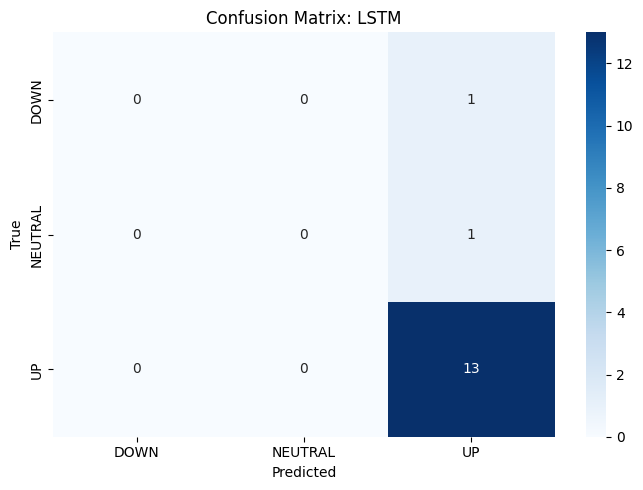

[BIOCON] Results DataFrame shape: (15, 27)
[BIOCON] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/BIOCON_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/BIOCON_results.xlsx
[BIOCON] 💾 Saved results to /content/output/BIOCON_results.xlsx
✅ Completed processing for BIOCON
[BERGEPAINT] ✅ Set DatetimeIndex. Index range: 2024-07-29 00:00:00 to 2024-08-30 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[BERGEPAINT] ✅ Technical indicators added. Shape: (24, 73), Features: 73
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 1: val_loss improved from inf to 0.99845, saving model to /content/checkpoints/BHARATFORG/BHARATFORG_lstm_model.h5



✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1599 - val_accuracy: 1.0000 - val_loss: 0.5299 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.2727 - loss: 1.2271 - val_accuracy: 1.0000 - val_loss: 0.9985 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5455 - loss: 0.9564
Epoch 27: val_loss did not improve from 0.73860

Epoch 2: val_loss improved from 0.99845 to 0.99352, saving model to /content/checkpoints/BHARATFORG/BHARATFORG_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1244 - val_accuracy: 1.0000 - val_loss: 0.7481 - learning_rate: 2.5000e-04
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 22.

Epoch 36: val_loss improved from 0.52994 to 0.52120, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


[ASHOKLEY] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[ASHOKLEY] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[ASHOKLEY] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 0 2 2 2 2 2 2 2 2 2 2 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.9564 - val_accuracy: 1.0000 - val_loss: 0.9935 - learning_rate: 0.0010
Epoch 3/50


[ASHOKLEY] ✅ Loaded best model from /content/checkpoints/ASHOKLEY/ASHOKLEY_lstm_model.h5
[ASHOKLEY] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1943 - val_accuracy: 1.0000 - val_loss: 0.5212 - learning_rate: 0.0010
Epoch 37/50
[ASHOKLEY] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.7850
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         1
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.87      1.00      0.93        13

    accuracy                           0.87        15
   macro avg       0.29      0.33      0.31        15
weighted avg       0.75      0.87      0.80        15


Epoch 3: val_loss did not improve from 0.99352
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0579

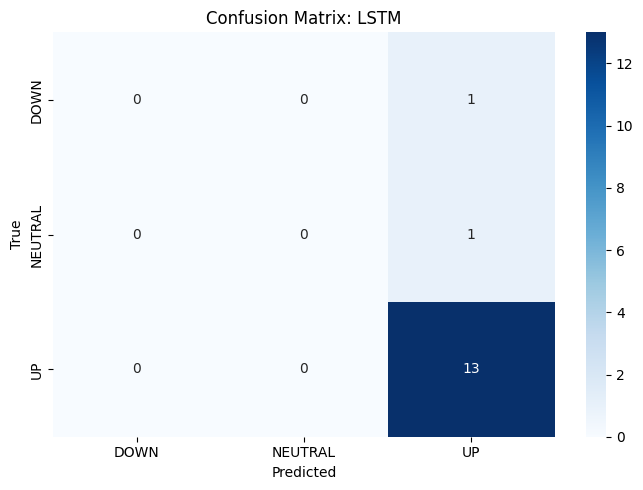

[ASHOKLEY] Results DataFrame shape: (15, 27)
[ASHOKLEY] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]

Epoch 37: val_loss improved from 0.52120 to 0.51196, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.7850 - val_accuracy: 1.0000 - val_loss: 0.9997 - learning_rate: 0.0010
Epoch 4/50
Excel report successfully generated: /content/output/ASHOKLEY_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/ASHOKLEY_results.xlsx
[ASHOKLEY] 💾 Saved results to /content/output/ASHOKLEY_results.xlsx
✅ Completed processing for ASHOKLEY
[BEL] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7273 - loss: 0.8999Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[BEL] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[BEL] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 4: val_loss did not improve from 0.99352

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0579 - val_accuracy: 1.0000 - val_loss: 0.5120 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.8999 - val_accuracy: 1.0000 - val_loss: 0.9985 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8182 - loss: 0.6671
Epoch 5: val_loss improved from 0.99352 to 0.99129, saving model to /content/checkpoints/BHARATFORG/BHARATFORG_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0508
Epoch 38: val_loss improved from 0.51196 to 0.50400, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6671 - val_accuracy: 1.0000 - val_loss: 0.9913 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0508 - val_accuracy: 1.0000 - val_loss: 0.5040 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.7195
Epoch 6: val_loss improved from 0.99129 to 0.98513, saving model to /content/checkpoints/BHARATFORG/BHARATFORG_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1487
Epoch 39: val_loss improved from 0.50400 to 0.49983, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.7195 - val_accuracy: 1.0000 - val_loss: 0.9851 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1487 - val_accuracy: 1.0000 - val_loss: 0.4998 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.4545 - loss: 1.0356
Epoch 7: val_loss improved from 0.98513 to 0.97871, saving model to /content/checkpoints/BHARATFORG/BHARATFORG_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.2609
Epoch 40: val_loss improved from 0.49983 to 0.49933, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.5377 - val_accuracy: 1.0000 - val_loss: 0.9787 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.2609 - val_accuracy: 1.0000 - val_loss: 0.4993 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 1.0000 - loss: 0.1024
Epoch 1: val_loss improved from inf to 1.03427, saving model to /content/checkpoints/BERGEPAINT/BERGEPAINT_lstm_model.h5



Epoch 41: val_loss improved from 0.49933 to 0.49875, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.6962
Epoch 8: val_loss improved from 0.97871 to 0.97526, saving model to /content/checkpoints/BHARATFORG/BHARATFORG_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.4545 - loss: 1.0356 - val_accuracy: 1.0000 - val_loss: 1.0343 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1024 - val_accuracy: 1.0000 - val_loss: 0.4987 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.6962 - val_accuracy: 1.0000 - val_loss: 0.9753 - learning_rate: 0.0010
Epoch 9/50

Epoch 2: val_loss improved from 1.03427 to 1.02097, saving model to /content/checkpoints/BERGEPAINT/BERGEPAINT_lstm_model.h5



Epoch 42: val_loss improved from 0.49875 to 0.49818, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.6724 - val_accuracy: 1.0000 - val_loss: 1.0210 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0515 - val_accuracy: 1.0000 - val_loss: 0.4982 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 0.0466
Epoch 3: val_loss did not improve from 1.02097

Epoch 9: val_loss improved from 0.97526 to 0.97294, saving model to /content/checkpoints/BHARATFORG/BHARATFORG_lstm_model.h5



Epoch 43: val_loss improved from 0.49818 to 0.49668, saving model to /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6233 - val_accuracy: 1.0000 - val_loss: 1.0274 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4545 - loss: 1.0862 - val_accuracy: 1.0000 - val_loss: 0.9729 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0466 - val_accuracy: 1.0000 - val_loss: 0.4967 - learning_rate: 0.0010
Epoch 44/50

Epoch 4: val_loss did not improve from 1.02097
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step - accuracy: 0.6364 - loss: 0.6620 - val_accuracy: 1.0000 - val_loss: 1.0346 - learning_rate: 0.0010
Epoch 5/50

Epoch 1: val_loss improved from inf to 0.99727, saving model to /content/checkpoints/BEL/BEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0871
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_loss did not improve from 1.02097

Epoch 10: val_loss improved from 0.97294 to 0.97095, saving model to /content/checkpoints/BHARATFORG/BHARATFORG_lstm_model.h5



Epoch 44: val_loss did not improve from 0.49668
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.2727 - loss: 1.1286 - val_accuracy: 1.0000 - val_loss: 0.9973 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3589 - val_accuracy: 1.0000 - val_loss: 1.0295 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0871 - val_accuracy: 1.0000 - val_loss: 0.4971 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.7008 - val_accuracy: 1.0000 - val_loss: 0.9709 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.7273 - loss: 0.7719
Epoch 45: val_loss did not improve from 0.49668

Epoch 11: val_loss improved from 0.97095 to 0.96962, saving model to /content/checkpoints/BHARATFORG/BHARATFORG_lstm_model.h5



Epoch 6: val_loss did not improve from 1.02097

Epoch 2: val_loss did not improve from 0.99727
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0855 - val_accuracy: 1.0000 - val_loss: 0.5005 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2293 - val_accuracy: 1.0000 - val_loss: 1.0267 - learning_rate: 5.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.7719 - val_accuracy: 1.0000 - val_loss: 0.9987 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4907 - val_accuracy: 1.0000 - val_loss: 0.9696 - learning_rate: 0.0010
Epoch 12/50

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 46: val_loss did not improve from 0.49668
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step - accuracy: 1.0000 - loss: 0.0827 - val_accuracy: 1.0000 - val_loss: 0.5093 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms

[ULTRACEMCO] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[ULTRACEMCO] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[ULTRACEMCO] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 0 0 0 0 0 2 0 0 0 0 1]
[ULTRACEMCO] ✅ Loaded best model from /content/checkpoints/ULTRACEMCO/ULTRACEMCO_lstm_model.h5
[ULTRACEMCO] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.6375
Epoch 7: val_loss did not improve from 1.02097

Epoch 3: val_loss did not improve from 0.99727

Epoch 12: val_loss improved from 0.96962 to 0.96930, saving model to /content/checkpoints/BHARATFORG/BHARATFORG_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.6375 - val_accuracy: 1.0000 - val_loss: 0.9975 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1992 - val_accuracy: 1.0000 - val_loss: 1.0231 - learning_rate: 5.0000e-04
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5237 - val_accuracy: 1.0000 - val_loss: 0.9693 - learning_rate: 0.0010
Epoch 13/50
[ULTRACEMCO] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8182 - loss: 0.4167[BERGEPAINT] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6364 - loss: 0.6458Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[BERGEPAINT] Added sequence for 30-07-2025 predicti

              precision    recall  f1-score   support

        DOWN       0.87      1.00      0.93        13
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         1

    accuracy                           0.87        15
   macro avg       0.29      0.33      0.31        15
weighted avg       0.75      0.87      0.80        15


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 0.99727


[BERGEPAINT] ✅ Loaded best model from /content/checkpoints/BERGEPAINT/BERGEPAINT_lstm_model.h5
[BERGEPAINT] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.6458 - val_accuracy: 1.0000 - val_loss: 0.9977 - learning_rate: 0.0010
Epoch 5/50


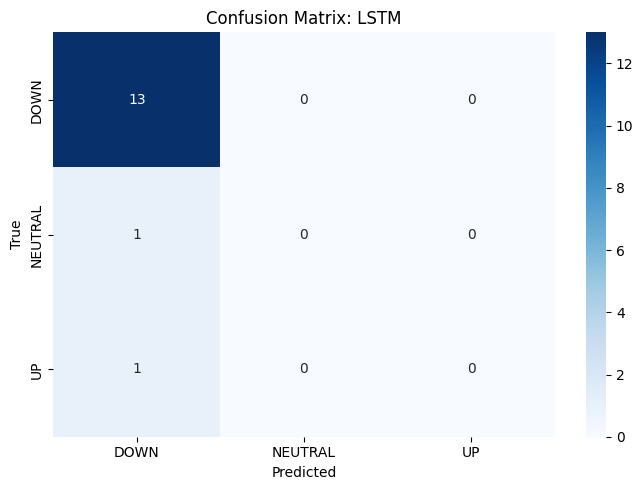

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4167 - val_accuracy: 1.0000 - val_loss: 0.9682 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5455 - loss: 0.6039
[ULTRACEMCO] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/ULTRACEMCO_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/ULTRACEMCO_results.xlsx
[ULTRACEMCO] 💾 Saved results to /content/output/ULTRACEMCO_results.xlsx
✅ Completed processing for ULTRACEMCO
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8182 - loss: 0.4747[BATAINDIA] ✅ Set DatetimeIndex. Index range: 2024-07-29 00:00:00 to 2024-08-30 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Epoch 5: val_loss did not improve from 0.99727

Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[BATAINDIA] ✅ Technical indicators added. Shape: (24, 73), Features: 73
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

Epoch 14: val_loss improved from 0.96824 to 0.96817, saving model to /content/checkpoints/BHARATFORG/BHARATFORG_lstm_model.h5


Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[BERGEPAINT] Predictions generated. y_pred length: 15, dates_future length: 15

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50

Classification Report for LSTM:
              precision    recall  f1-score   support

     NEUTRAL       0.00      0.00      0.00         1
          UP       0.93      1.00      0.97        14

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.6039 - val_accuracy: 1.0000 - val_loss: 1.0001 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9091 - loss: 0.4597
Epoch 6: val_loss did not improve from 0.99727
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4747 - val_accuracy: 1.0000 - val_loss: 0.9682 - learning_rate: 0.0010
Epoch 15/50


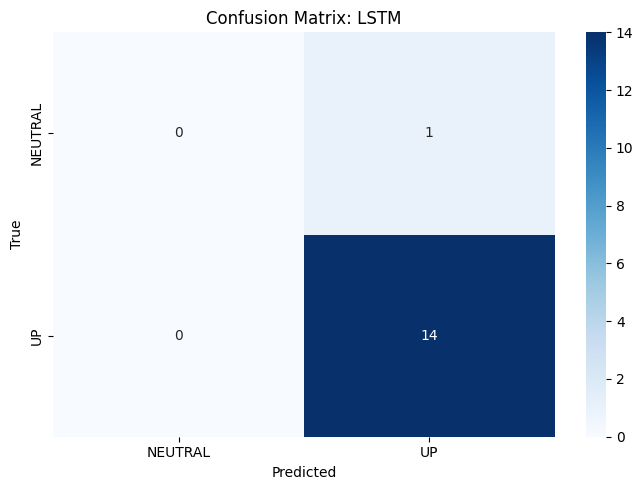

[BERGEPAINT] Results DataFrame shape: (15, 26)
[BERGEPAINT] Prediction dates: [Timestamp('2024-08-12 00:00:00'), Timestamp('2024-08-13 00:00:00'), Timestamp('2024-08-14 00:00:00'), Timestamp('2024-08-16 00:00:00'), Timestamp('2024-08-19 00:00:00'), Timestamp('2024-08-20 00:00:00'), Timestamp('2024-08-21 00:00:00'), Timestamp('2024-08-22 00:00:00'), Timestamp('2024-08-23 00:00:00'), Timestamp('2024-08-26 00:00:00'), Timestamp('2024-08-27 00:00:00'), Timestamp('2024-08-28 00:00:00'), Timestamp('2024-08-29 00:00:00'), Timestamp('2024-08-30 00:00:00'), Timestamp('2025-07-30 00:00:00')]
Excel report successfully generated: /content/output/BERGEPAINT_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/BERGEPAINT_results.xlsx
[BERGEPAINT] 💾 Saved results to /content/output/BERGEPAINT_results.xlsx
[UPL] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for BERGEPAINT
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[UPL] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[UPL] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4597 - val_accuracy: 1.0000 - val_loss: 1.0023 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
[BEL] 

Model: "LSTM_Model"

[BEL] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[BEL] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 0 2 2 2 2 2 2 0 2 2 1]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50


[BEL] ✅ Loaded best model from /content/checkpoints/BEL/BEL_lstm_model.h5
[BEL] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.7013 - val_accuracy: 1.0000 - val_loss: 0.9689 - learning_rate: 0.0010
Epoch 16/50
[BEL] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.5656
Classification Report for LSTM:

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: val_loss did not improve from 0.96817
              precision    recall  f1-score   support

        DOWN       0.13      1.00      0.24         2
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00        12

    accuracy                           0.13        15
   macro avg       0.04      0.33      0.08        15
weighted avg       0.02      0.13      0.03        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accura

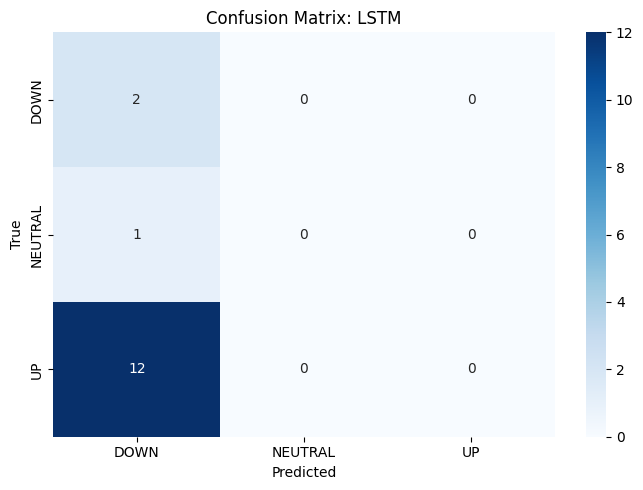

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8182 - loss: 0.5309[BEL] Results DataFrame shape: (15, 27)
[BEL] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/BEL_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/BEL_results.xlsx
[BEL] 💾 Saved results to /content/output/BEL_results.xlsx
[BANKBARODA] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for BEL

Epoch 17: val_loss did not improve from 0.96817
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[BANKBARODA] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[BANKBARODA] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5309 - val_accuracy: 1.0000 - val_loss: 0.9771 - learning_rate: 5.0000e-04
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7273 - loss: 0.5396
Epoch 18: val_loss did not improve from 0.96817
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5396 - val_accuracy: 1.0000 - val_loss: 0.9802 - learning_rate: 5.0000e-04
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6364 - loss: 0.4763
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 19: val_loss did not improve from 0.96817
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.4763 - val_accuracy: 1.0000 - val_loss: 0.9844 - learning_rate: 5.0000e-04
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 14.
[BHARATFORG] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['

[BHARATFORG] ✅ Loaded best model from /content/checkpoints/BHARATFORG/BHARATFORG_lstm_model.h5
[BHARATFORG] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.1818 - loss: 2.4608[BHARATFORG] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         7
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.47      1.00      0.64         7

    accuracy                           0.47        15
   macro avg       0.16      0.33      0.21        15
weighted avg       0.22      0.47      0.30        15



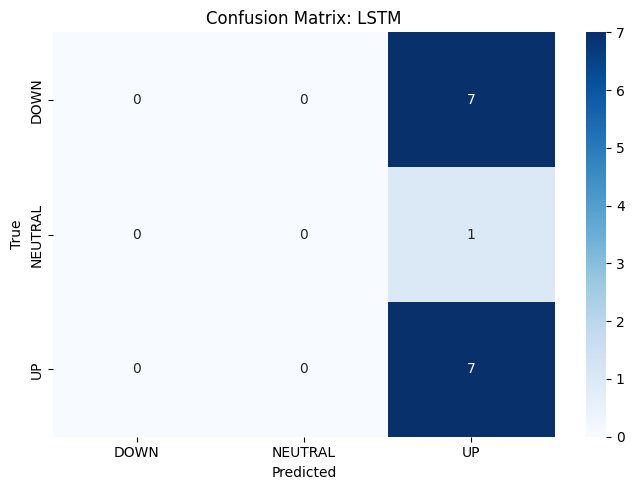

[BHARATFORG] Results DataFrame shape: (15, 27)
[BHARATFORG] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/BHARATFORG_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/BHARATFORG_results.xlsx
[BHARATFORG] 💾 Saved results to /content/output/BHARATFORG_results.xlsx
✅ Completed processing for BHARATFORG
[BALKRISIND] ✅ Set DatetimeIndex. Index range: 2025-06-26 00:00:00 to 2025-07-29 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[BALKRISIND] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[BALKRISIND] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 1: val_loss improved from inf to 0.98859, saving model to /content/checkpoints/BATAINDIA/BATAINDIA_lstm_model.h5



✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.1818 - loss: 2.4608 - val_accuracy: 1.0000 - val_loss: 0.9886 - learning_rate: 0.0010
Epoch 2/50

Epoch 1: val_loss improved from inf to 1.20688, saving model to /content/checkpoints/UPL/UPL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3636 - loss: 1.3453
Epoch 2: val_loss improved from 0.98859 to 0.98251, saving model to /content/checkpoints/BATAINDIA/BATAINDIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.0000e+00 - loss: 2.0878 - val_accuracy: 0.0000e+00 - val_loss: 1.2069 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.1818 - loss: 1.8304
Epoch 2: val_loss did not improve from 1.20688
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3636 - loss: 1.3453 - val_accuracy: 1.0000 - val_loss: 0.9825 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.1818 - loss: 2.0058
Epoch 3: val_loss improved from 0.98251 to 0.98012, saving model to /content/checkpoints/BATAINDIA/BATAINDIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1818 - loss: 1.8304 - val_accuracy: 0.0000e+00 - val_loss: 1.2104 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.1818 - loss: 1.6942
Epoch 3: val_loss improved from 1.20688 to 1.20538, saving model to /content/checkpoints/UPL/UPL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.2966 - val_accuracy: 1.0000 - val_loss: 0.9801 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4545 - loss: 1.0432
Epoch 4: val_loss did not improve from 0.98012

Epoch 1: val_loss improved from inf to 1.03434, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1818 - loss: 1.6942 - val_accuracy: 0.0000e+00 - val_loss: 1.2054 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.2727 - loss: 1.3040
Epoch 4: val_loss did not improve from 1.20538
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.0432 - val_accuracy: 1.0000 - val_loss: 0.9829 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.1818 - loss: 2.0058 - val_accuracy: 1.0000 - val_loss: 1.0343 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.3040 - val_accuracy: 0.0000e+00 - val_loss: 1.2060 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.2727 - loss: 1.3122
Epoch 2: val_loss improved from 1.03434 to 0.96540, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5



Epoch 5: val_loss did not improve from 1.20538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5455 - loss: 0.8992
Epoch 5: val_loss did not improve from 0.98012
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.3122 - val_accuracy: 0.0000e+00 - val_loss: 1.2097 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.2971 - val_accuracy: 1.0000 - val_loss: 0.9654 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3636 - loss: 1.1656
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_loss did not improve from 1.20538
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.8992 - val_accuracy: 1.0000 - val_loss: 0.9861 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7273 - loss: 0.6799
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_loss did not improve from 0.98


Epoch 7: val_loss did not improve from 1.20538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.7273 - loss: 0.7415
Epoch 7: val_loss did not improve from 0.98012
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4545 - loss: 1.1367 - val_accuracy: 1.0000 - val_loss: 0.8986 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.2965 - val_accuracy: 0.0000e+00 - val_loss: 1.2093 - learning_rate: 5.0000e-04
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.7415 - val_accuracy: 1.0000 - val_loss: 0.9947 - learning_rate: 5.0000e-04
Epoch 8/50

Epoch 8: val_loss did not improve from 1.20538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7273 - loss: 0.7681
Epoch 8: val_loss did not improve from 0.98012
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step - accuracy: 0.2727 - loss: 1.3693 - val_accuracy: 0.0000e+00 - val_loss: 1.2065 - learning_rate: 5.0000e-04
Epoch 8: early stopping
Restoring model weights from the end of t

[BATAINDIA] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

Epoch 4: val_loss improved from 0.89859 to 0.85356, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[BATAINDIA] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 0 0 0 0 2 2 0 2 2 2 2 0 1]


[UPL] ✅ Loaded best model from /content/checkpoints/UPL/UPL_lstm_model.h5
[UPL] Predicting for 15 dates, including 30-07-2025


[BATAINDIA] ✅ Loaded best model from /content/checkpoints/BATAINDIA/BATAINDIA_lstm_model.h5
[BATAINDIA] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.5455 - loss: 0.9719 - val_accuracy: 1.0000 - val_loss: 0.9616 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.7423 - val_accuracy: 1.0000 - val_loss: 0.8536 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6364 - loss: 0.8099
Epoch 5: val_loss improved from 0.85356 to 0.82017, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step - accuracy: 0.6364 - loss: 0.8099 - val_accuracy: 1.0000 - val_loss: 0.8202 - learning_rate: 0.0010
Epoch 6/50
[UPL] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         6
     NEUTRAL       0.07      1.00      0.12         1
          UP       0.00      0.00      0.00         8

    accuracy                           0.07        15
   macro avg       0.02      0.33      0.04        15
weighted avg       0.00      0.07      0.01        15

[BATAINDIA] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.40      0.33      0.36         6
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.60      0.75      0.67         8

    accuracy                       

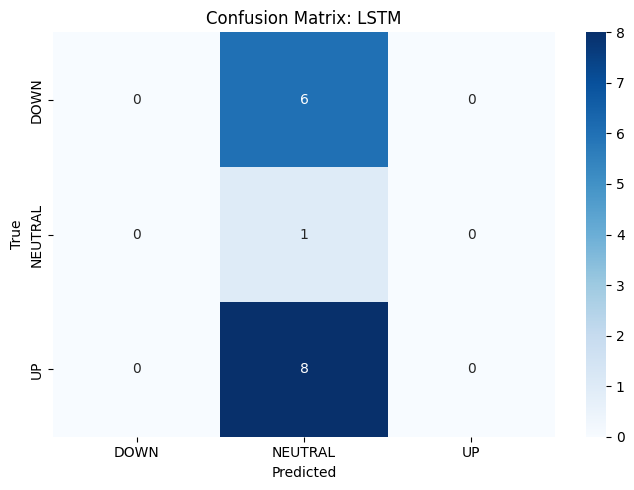

[UPL] Results DataFrame shape: (15, 27)
[UPL] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/UPL_results.xlsx


<IPython.core.display.Javascript object>

[BATAINDIA] Results DataFrame shape: (15, 27)

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/UPL_results.xlsx
[UPL] 💾 Saved results to /content/output/UPL_results.xlsx
[BAJFINANCE] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00

[BATAINDIA] Prediction dates: [Timestamp('2024-08-12 00:00:00'), Timestamp('2024-08-13 00:00:00'), Timestamp('2024-08-14 00:00:00'), Timestamp('2024-08-16 00:00:00'), Timestamp('2024-08-19 00:00:00'), Timestamp('2024-08-20 00:00:00'), Timestamp('2024-08-21 00:00:00'), Timestamp('2024-08-22 00:00:00'), Timestamp('2024-08-23 00:00:00'), Timestamp('2024-08-26 00:00:00'), Timestamp('2024-08-27 00:00:00'), Timestamp('2024-08-28 00:00:00'), Timestamp('2024-08-29 00:00:00'), Timestamp('2024-08-30 00:00:00'), Timestamp('2025-07-30 00:00:00')]
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.6364 - loss: 0.6993✅ Completed processing for UPL
Excel report successfully generated: /content/output/BATAINDIA_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/BATAINDIA_results.xlsx
[BATAINDIA] 💾 Saved results to /content/output/BATAINDIA_results.xlsx
[BAJAJFINSV] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for BATAINDIA
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[BAJFINANCE] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[BAJFINANCE] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[BAJAJFINSV] ✅ Technical indicators added. Shape: (24, 73), Featur

Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9091 - loss: 0.5247Epoch 1/50

Epoch 2: val_loss improved from 0.96161 to 0.93214, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.6993 - val_accuracy: 1.0000 - val_loss: 0.7974 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9091 - loss: 0.5247 - val_accuracy: 1.0000 - val_loss: 0.9321 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.5497
Epoch 7: val_loss improved from 0.79736 to 0.78425, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3635
Epoch 3: val_loss improved from 0.93214 to 0.89580, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5497 - val_accuracy: 1.0000 - val_loss: 0.7843 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5455 - loss: 0.6482
Epoch 8: val_loss improved from 0.78425 to 0.76265, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3635 - val_accuracy: 1.0000 - val_loss: 0.8958 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.6482 - val_accuracy: 1.0000 - val_loss: 0.7626 - learning_rate: 0.0010
Epoch 9/50

Epoch 4: val_loss improved from 0.89580 to 0.85827, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4245 - val_accuracy: 1.0000 - val_loss: 0.8583 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.5778
Epoch 5: val_loss improved from 0.85827 to 0.82456, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5



Epoch 9: val_loss improved from 0.76265 to 0.73763, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5522 - val_accuracy: 1.0000 - val_loss: 0.8246 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5778 - val_accuracy: 1.0000 - val_loss: 0.7376 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8182 - loss: 0.6844
Epoch 10: val_loss improved from 0.73763 to 0.72277, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6844 - val_accuracy: 1.0000 - val_loss: 0.7228 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7273 - loss: 0.5199
Epoch 6: val_loss improved from 0.82456 to 0.79127, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5



Epoch 11: val_loss improved from 0.72277 to 0.70043, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4762 - val_accuracy: 1.0000 - val_loss: 0.7913 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7273 - loss: 0.5199 - val_accuracy: 1.0000 - val_loss: 0.7004 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.7273 - loss: 0.6016
Epoch 12: val_loss improved from 0.70043 to 0.67587, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.4254
Epoch 7: val_loss improved from 0.79127 to 0.75777, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6016 - val_accuracy: 1.0000 - val_loss: 0.6759 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.4254 - val_accuracy: 1.0000 - val_loss: 0.7578 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.3636 - loss: 1.1094
Epoch 13: val_loss improved from 0.67587 to 0.65143, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3057
Epoch 8: val_loss improved from 0.75777 to 0.73001, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.04035, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.3291 - val_accuracy: 1.0000 - val_loss: 0.6514 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3057 - val_accuracy: 1.0000 - val_loss: 0.7300 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.4545 - loss: 0.9695 - val_accuracy: 1.0000 - val_loss: 1.0403 - learning_rate: 0.0010
Epoch 2/50

Epoch 1: val_loss improved from inf to 1.09815, saving model to /content/checkpoints/BAJFINANCE/BAJFINANCE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6364 - loss: 0.5795
Epoch 2: val_loss improved from 1.04035 to 1.03477, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5

Epoch 9: val_loss improved from 0.73001 to 0.70530, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3456
Epoch 14: val_loss improved from 0.65143 to 0.63044, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.3636 - loss: 1.1094 - val_accuracy: 0.0000e+00 - val_loss: 1.0982 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.5455 - loss: 0.7509
Epoch 2: val_loss did not improve from 1.09815
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3414 - val_accuracy: 1.0000 - val_loss: 0.7053 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.5795 - val_accuracy: 1.0000 - val_loss: 1.0348 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3456 - val_accuracy: 1.0000 - val_loss: 0.6304 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9091 - loss: 0.3640
Epoch 10: val_loss improved from 0.70530 to 0.67970, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.7509 - val_accuracy: 0.0000e+00 - val_loss: 1.1247 - learning_rate: 0.0010
Epoch 3/50

Epoch 15: val_loss improved from 0.63044 to 0.61352, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8182 - loss: 0.4852
Epoch 3: val_loss did not improve from 1.09815
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3020 - val_accuracy: 1.0000 - val_loss: 0.6797 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9091 - loss: 0.2211
Epoch 3: val_loss did not improve from 1.03477
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3640 - val_accuracy: 1.0000 - val_loss: 0.6135 - learning_rate: 0.0010
Epoch 16/50

Epoch 11: val_loss improved from 0.67970 to 0.65812, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4852 - val_accuracy: 0.0000e+00 - val_loss: 1.1413 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9091 - loss: 0.4347
Epoch 16: val_loss improved from 0.61352 to 0.59665, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.5338 - val_accuracy: 1.0000 - val_loss: 1.0375 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.09815
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2211 - val_accuracy: 1.0000 - val_loss: 0.6581 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step - accuracy: 0.9091 - loss: 0.4347 - val_accuracy: 0.0000e+00 - val_loss: 1.1672 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4324 - val_accuracy: 1.0000 - val_loss: 0.5967 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7273 - loss: 0.6403
Epoch 5: val_loss did not improve from 1.09815

Epoch 17: val_loss improved from 0.59665 to 0.57864, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step - accuracy: 0.9091 - loss: 0.3582 - val_accuracy: 0.0000e+00 - val_loss: 1.1773 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.5203
Epoch 6: val_loss did not improve from 1.09815
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step - accuracy: 0.7273 - loss: 0.6403 - val_accuracy: 1.0000 - val_loss: 0.5786 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1481
Epoch 4: val_loss improved from 1.03477 to 1.03177, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8182 - loss: 0.3825
Epoch 12: val_loss improved from 0.65812 to 0.63990, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5

Epoch 18: val_loss improved from 0.57864 to 0.56704, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2992 - val_accuracy: 0.0000e+00 - val_loss: 1.1869 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
[BAJFINANCE] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[BAJFINANCE] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[BAJFINANCE] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 2 0 2 0 0 0 2 2 2 0 2 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.5203 - val_accuracy: 1.0000 - val_loss: 1.0318 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9091 - loss: 0.4781

[BAJFINANCE] ✅ Loaded best model from /content/checkpoints/BAJFINANCE/BAJFINANCE_lstm_model.h5
[BAJFINANCE] Predicting for 15 dates, including 30-07-2025

Epoch 5: val_loss improved from 1.03177 to 1.02075, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.1481 - val_accuracy: 1.0000 - val_loss: 0.6399 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3825 - val_accuracy: 1.0000 - val_loss: 0.5670 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4781 - val_accuracy: 1.0000 - val_loss: 1.0208 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9091 - loss: 0.4076
Epoch 6: val_loss improved from 1.02075 to 1.01716, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step - accuracy: 0.9091 - loss: 0.4076 - val_accuracy: 1.0000 - val_loss: 1.0172 - learning_rate: 0.0010
Epoch 7/50

Epoch 13: val_loss improved from 0.63990 to 0.62025, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


[BAJFINANCE] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9091 - loss: 0.4290
Epoch 19: val_loss improved from 0.56704 to 0.55630, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5



Classification Report for LSTM:

Epoch 7: val_loss improved from 1.01716 to 1.01373, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         7
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.47      1.00      0.64         7

    accuracy                           0.47        15
   macro avg       0.16      0.33      0.21        15
weighted avg       0.22      0.47      0.30        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3836 - val_accuracy: 1.0000 - val_loss: 0.6202 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.4241 - val_accuracy: 1.0000 - val_loss: 0.5563 - learning_rate: 0.0010
Epoch 20/50


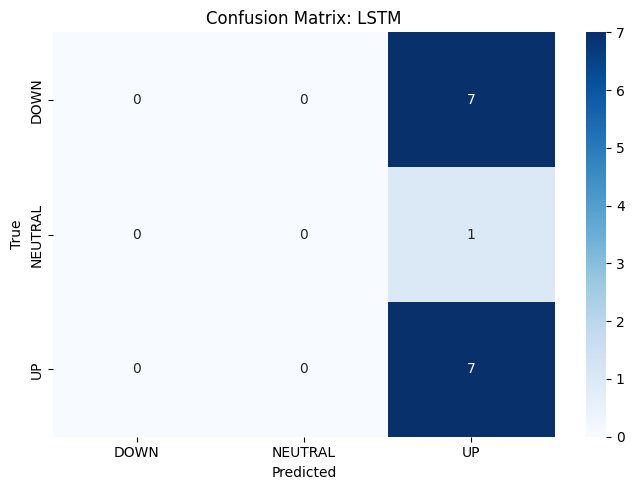

[BAJFINANCE] Results DataFrame shape: (15, 27)
[BAJFINANCE] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.4290 - val_accuracy: 1.0000 - val_loss: 1.0137 - learning_rate: 0.0010
Epoch 8/50
Excel report successfully generated: /content/output/BAJFINANCE_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/BAJFINANCE_results.xlsx
[BAJFINANCE] 💾 Saved results to /content/output/BAJFINANCE_results.xlsx
[VEDL] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for BAJFINANCE
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9091 - loss: 0.3293Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[VEDL] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[VEDL] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 8: val_loss improved from 1.01373 to 1.00696, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5



✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3293 - val_accuracy: 1.0000 - val_loss: 1.0070 - learning_rate: 0.0010
Epoch 9/50

Epoch 14: val_loss improved from 0.62025 to 0.60216, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9091 - loss: 0.3520
Epoch 20: val_loss improved from 0.55630 to 0.54737, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5



Epoch 9: val_loss improved from 1.00696 to 0.99606, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2726 - val_accuracy: 1.0000 - val_loss: 0.5474 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1053 - val_accuracy: 1.0000 - val_loss: 0.6022 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3520 - val_accuracy: 1.0000 - val_loss: 0.9961 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 1.0000 - loss: 0.2285
Epoch 15: val_loss improved from 0.60216 to 0.58448, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5



Epoch 10: val_loss improved from 0.99606 to 0.97787, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.8182 - loss: 0.3121
Epoch 21: val_loss improved from 0.54737 to 0.53818, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1846 - val_accuracy: 1.0000 - val_loss: 0.5845 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2285 - val_accuracy: 1.0000 - val_loss: 0.9779 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3121 - val_accuracy: 1.0000 - val_loss: 0.5382 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3235
Epoch 16: val_loss improved from 0.58448 to 0.56813, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5



Epoch 11: val_loss improved from 0.97787 to 0.95786, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3001
Epoch 22: val_loss improved from 0.53818 to 0.52720, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1722 - val_accuracy: 1.0000 - val_loss: 0.5681 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3235 - val_accuracy: 1.0000 - val_loss: 0.9579 - learning_rate: 0.0010
Epoch 12/50

Epoch 17: val_loss improved from 0.56813 to 0.55071, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.3001 - val_accuracy: 1.0000 - val_loss: 0.5272 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3498 - val_accuracy: 1.0000 - val_loss: 0.5507 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2900
Epoch 18: val_loss improved from 0.55071 to 0.53337, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5



Epoch 12: val_loss improved from 0.95786 to 0.94040, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.4046
Epoch 23: val_loss improved from 0.52720 to 0.51409, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2626 - val_accuracy: 1.0000 - val_loss: 0.5334 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2900 - val_accuracy: 1.0000 - val_loss: 0.9404 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9091 - loss: 0.2784
Epoch 13: val_loss improved from 0.94040 to 0.92529, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.4046 - val_accuracy: 1.0000 - val_loss: 0.5141 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step - accuracy: 0.9091 - loss: 0.2784 - val_accuracy: 1.0000 - val_loss: 0.9253 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1466
Epoch 14: val_loss improved from 0.92529 to 0.91063, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5



Epoch 19: val_loss improved from 0.53337 to 0.51718, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.5414
Epoch 24: val_loss improved from 0.51409 to 0.49910, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2613 - val_accuracy: 1.0000 - val_loss: 0.9106 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1466 - val_accuracy: 1.0000 - val_loss: 0.5172 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5414 - val_accuracy: 1.0000 - val_loss: 0.4991 - learning_rate: 0.0010
Epoch 25/50

Epoch 1: val_loss improved from inf to 1.13556, saving model to /content/checkpoints/VEDL/VEDL_lstm_model.h5



Epoch 20: val_loss improved from 0.51718 to 0.50239, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.0909 - loss: 1.5537 - val_accuracy: 0.0000e+00 - val_loss: 1.1356 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1414Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1840 - val_accuracy: 1.0000 - val_loss: 0.5024 - learning_rate: 0.0010
Epoch 21/50

Epoch 15: val_loss improved from 0.91063 to 0.89116, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1720
Epoch 21: val_loss improved from 0.50239 to 0.48779, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1414 - val_accuracy: 1.0000 - val_loss: 0.8912 - learning_rate: 0.0010
Epoch 16/50

Epoch 25: val_loss improved from 0.49910 to 0.48580, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2492 - val_accuracy: 1.0000 - val_loss: 0.4878 - learning_rate: 0.0010
Epoch 22/50

Epoch 16: val_loss improved from 0.89116 to 0.86683, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1720 - val_accuracy: 1.0000 - val_loss: 0.4858 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9091 - loss: 0.1760
Epoch 22: val_loss improved from 0.48779 to 0.47499, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5



Epoch 26: val_loss improved from 0.48580 to 0.47520, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1644 - val_accuracy: 1.0000 - val_loss: 0.8668 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9091 - loss: 0.2571
Epoch 2: val_loss improved from 1.13556 to 1.12323, saving model to /content/checkpoints/VEDL/VEDL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1922 - val_accuracy: 1.0000 - val_loss: 0.4750 - learning_rate: 0.0010
Epoch 23/50

Epoch 17: val_loss improved from 0.86683 to 0.83245, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1760 - val_accuracy: 1.0000 - val_loss: 0.4752 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2727 - loss: 1.5071 - val_accuracy: 0.0000e+00 - val_loss: 1.1232 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2571 - val_accuracy: 1.0000 - val_loss: 0.8325 - learning_rate: 0.0010
Epoch 18/50

Epoch 3: val_loss did not improve from 1.12323
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.8182 - loss: 0.3311
Epoch 18: val_loss improved from 0.83245 to 0.80009, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step - accuracy: 0.1818 - loss: 1.4523 - val_accuracy: 0.0000e+00 - val_loss: 1.1353 - learning_rate: 0.0010
Epoch 4/50

Epoch 23: val_loss improved from 0.47499 to 0.46278, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5



Epoch 27: val_loss improved from 0.47520 to 0.46420, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2871 - val_accuracy: 1.0000 - val_loss: 0.8001 - learning_rate: 0.0010
Epoch 19/50

Epoch 4: val_loss did not improve from 1.12323
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1999 - val_accuracy: 1.0000 - val_loss: 0.4628 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3311 - val_accuracy: 1.0000 - val_loss: 0.4642 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9091 - loss: 0.1884
Epoch 24: val_loss improved from 0.46278 to 0.44949, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5



Epoch 19: val_loss improved from 0.80009 to 0.76830, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2727 - loss: 1.2500 - val_accuracy: 0.0000e+00 - val_loss: 1.1563 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1884 - val_accuracy: 1.0000 - val_loss: 0.4495 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3042 - val_accuracy: 1.0000 - val_loss: 0.7683 - learning_rate: 0.0010
Epoch 20/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_loss did not improve from 1.12323
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9091 - loss: 0.1491
Epoch 20: val_loss improved from 0.76830 to 0.74302, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.1452 - val_accuracy: 0.0000e+00 - val_loss: 1.1809 - learning_rate: 0.0010
Epoch 6/50

Epoch 28: val_loss improved from 0.46420 to 0.45498, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5



Epoch 25: val_loss improved from 0.44949 to 0.43581, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3636 - loss: 1.0682
Epoch 6: val_loss did not improve from 1.12323
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1518 - val_accuracy: 1.0000 - val_loss: 0.7430 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3061 - val_accuracy: 1.0000 - val_loss: 0.4550 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1491 - val_accuracy: 1.0000 - val_loss: 0.4358 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.0682 - val_accuracy: 0.0000e+00 - val_loss: 1.1901 - learning_rate: 5.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4545 - loss: 1.1260
Epoch 21: val_loss improved from 0.74302 to 0.71688, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5

Epoch 7: val_loss did not improve from 1.12323



Epoch 29: val_loss improved from 0.45498 to 0.44518, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step - accuracy: 0.4545 - loss: 1.1260 - val_accuracy: 0.0000e+00 - val_loss: 1.1954 - learning_rate: 5.0000e-04
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2384 - val_accuracy: 1.0000 - val_loss: 0.7169 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1768 - val_accuracy: 1.0000 - val_loss: 0.4452 - learning_rate: 0.0010
Epoch 30/50

Epoch 26: val_loss improved from 0.43581 to 0.42303, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


[VEDL] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[VEDL] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[VEDL] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 2 2 0 0 2 0 2 0 2 0 0 0 1]


[VEDL] ✅ Loaded best model from /content/checkpoints/VEDL/VEDL_lstm_model.h5
[VEDL] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1516 - val_accuracy: 1.0000 - val_loss: 0.4230 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9091 - loss: 0.2661
Epoch 27: val_loss improved from 0.42303 to 0.41112, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


[VEDL] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step - accuracy: 0.9091 - loss: 0.2661 - val_accuracy: 1.0000 - val_loss: 0.4111 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.2046
Classification Report for LSTM:

Epoch 22: val_loss improved from 0.71688 to 0.70171, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         8
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.40      1.00      0.57         6

    accuracy                           0.40        15
   macro avg       0.13      0.33      0.19        15
weighted avg       0.16      0.40      0.23        15


Epoch 30: val_loss improved from 0.44518 to 0.43783, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.9091 - loss: 0.2286
Epoch 28: val_loss improved from 0.41112 to 0.40105, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


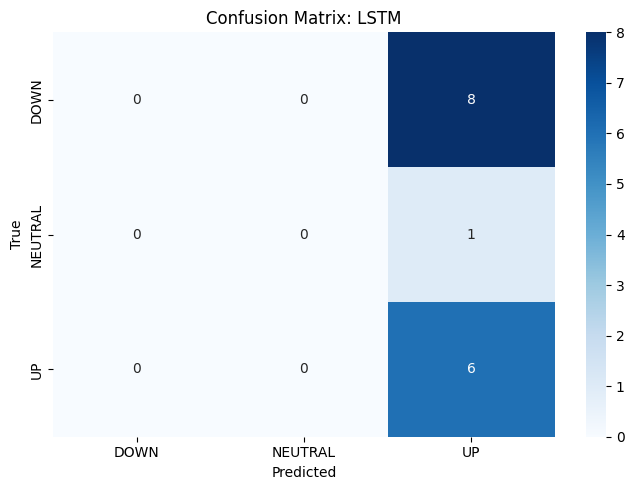

[VEDL] Results DataFrame shape: (15, 27)
[VEDL] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1226 - val_accuracy: 1.0000 - val_loss: 0.7017 - learning_rate: 0.0010
Epoch 23/50
Excel report successfully generated: /content/output/VEDL_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/VEDL_results.xlsx
[VEDL] 💾 Saved results to /content/output/VEDL_results.xlsx
✅ Completed processing for VEDL
[BAJAJ-AUTO] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2046 - val_accuracy: 1.0000 - val_loss: 0.4378 - learning_rate: 0.0010
Epoch 31/50
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[BAJAJ-AUTO] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[BAJAJ-AUTO] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2286 - val_accuracy: 1.0000 - val_loss: 0.4011 - learning_rate: 0.0010
Epoch 29/50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9091 - loss: 0.2097
Epoch 29: val_loss improved from 0.40105 to 0.39049, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step - accuracy: 0.9091 - loss: 0.2097 - val_accuracy: 1.0000 - val_loss: 0.3905 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9091 - loss: 0.2711
Epoch 23: val_loss improved from 0.70171 to 0.68485, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5



Epoch 31: val_loss improved from 0.43783 to 0.43251, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5



Epoch 30: val_loss improved from 0.39049 to 0.38252, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2416 - val_accuracy: 1.0000 - val_loss: 0.6849 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3199 - val_accuracy: 1.0000 - val_loss: 0.4325 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2711 - val_accuracy: 1.0000 - val_loss: 0.3825 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 0.1264
Epoch 32: val_loss improved from 0.43251 to 0.42875, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5



Epoch 31: val_loss improved from 0.38252 to 0.37444, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 1.0000 - loss: 0.1153
Epoch 24: val_loss improved from 0.68485 to 0.66730, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2423 - val_accuracy: 1.0000 - val_loss: 0.4287 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1264 - val_accuracy: 1.0000 - val_loss: 0.3744 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1153 - val_accuracy: 1.0000 - val_loss: 0.6673 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 1.0000 - loss: 0.1505
Epoch 33: val_loss improved from 0.42875 to 0.42463, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5



Epoch 32: val_loss improved from 0.37444 to 0.36619, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1086
Epoch 25: val_loss improved from 0.66730 to 0.64987, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1760 - val_accuracy: 1.0000 - val_loss: 0.4246 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1505 - val_accuracy: 1.0000 - val_loss: 0.3662 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1086 - val_accuracy: 1.0000 - val_loss: 0.6499 - learning_rate: 0.0010
Epoch 26/50

Epoch 33: val_loss improved from 0.36619 to 0.35977, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8182 - loss: 0.2551
Epoch 26: val_loss improved from 0.64987 to 0.63060, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3103
Epoch 34: val_loss improved from 0.42463 to 0.41933, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1178 - val_accuracy: 1.0000 - val_loss: 0.3598 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.2551 - val_accuracy: 1.0000 - val_loss: 0.6306 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.1099
Epoch 27: val_loss improved from 0.63060 to 0.61507, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3103 - val_accuracy: 1.0000 - val_loss: 0.4193 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1099 - val_accuracy: 1.0000 - val_loss: 0.6151 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9091 - loss: 0.1749
Epoch 34: val_loss improved from 0.35977 to 0.35277, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5



Epoch 28: val_loss improved from 0.61507 to 0.59968, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.1549 - val_accuracy: 1.0000 - val_loss: 0.3528 - learning_rate: 0.0010
Epoch 35/50

Epoch 35: val_loss improved from 0.41933 to 0.41437, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1749 - val_accuracy: 1.0000 - val_loss: 0.5997 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1876 - val_accuracy: 1.0000 - val_loss: 0.4144 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9091 - loss: 0.1863
Epoch 36: val_loss improved from 0.41437 to 0.40935, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1664
Epoch 1: val_loss improved from inf to 1.07125, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5



Epoch 35: val_loss improved from 0.35277 to 0.34729, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1863 - val_accuracy: 1.0000 - val_loss: 0.4093 - learning_rate: 0.0010
Epoch 37/50

Epoch 29: val_loss improved from 0.59968 to 0.58501, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9091 - loss: 0.2221
Epoch 37: val_loss improved from 0.40935 to 0.40335, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.5455 - loss: 1.4308 - val_accuracy: 0.0000e+00 - val_loss: 1.0712 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.1740 - val_accuracy: 1.0000 - val_loss: 0.3473 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.1664 - val_accuracy: 1.0000 - val_loss: 0.5850 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2221 - val_accuracy: 1.0000 - val_loss: 0.4033 - learning_rate: 0.0010
Epoch 38/50

Epoch 2: val_loss improved from 1.07125 to 1.05690, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5



Epoch 30: val_loss improved from 0.58501 to 0.57634, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.9540 - val_accuracy: 0.0000e+00 - val_loss: 1.0569 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step - accuracy: 0.9091 - loss: 0.1273 - val_accuracy: 1.0000 - val_loss: 0.5763 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1847
Epoch 36: val_loss improved from 0.34729 to 0.34275, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1847 - val_accuracy: 1.0000 - val_loss: 0.3428 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1946
Epoch 31: val_loss improved from 0.57634 to 0.57165, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5



Epoch 3: val_loss improved from 1.05690 to 1.04036, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 1.0000 - loss: 0.1006
Epoch 38: val_loss improved from 0.40335 to 0.39820, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5



Epoch 37: val_loss improved from 0.34275 to 0.33800, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2202 - val_accuracy: 1.0000 - val_loss: 0.5717 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.7679 - val_accuracy: 1.0000 - val_loss: 1.0404 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9091 - loss: 0.5297
Epoch 4: val_loss improved from 1.04036 to 1.02546, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1946 - val_accuracy: 1.0000 - val_loss: 0.3982 - learning_rate: 0.0010
Epoch 39/50

Epoch 32: val_loss improved from 0.57165 to 0.57118, saving model to /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1006 - val_accuracy: 1.0000 - val_loss: 0.3380 - learning_rate: 0.0010


Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0877 - val_accuracy: 1.0000 - val_loss: 0.5712 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.5297 - val_accuracy: 1.0000 - val_loss: 1.0255 - learning_rate: 0.0010
Epoch 5/50
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 1.0000 - loss: 0.2968
Epoch 39: val_loss improved from 0.39820 to 0.39309, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5



Epoch 38: val_loss improved from 0.33800 to 0.33267, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5



Epoch 5: val_loss improved from 1.02546 to 1.00979, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5



Epoch 33: val_loss did not improve from 0.57118
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0457 - val_accuracy: 1.0000 - val_loss: 0.5716 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2354 - val_accuracy: 1.0000 - val_loss: 0.3931 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1086 - val_accuracy: 1.0000 - val_loss: 0.3327 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2968 - val_accuracy: 1.0000 - val_loss: 1.0098 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9091 - loss: 0.3779
Epoch 39: val_loss improved from 0.33267 to 0.32844, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5



Epoch 34: val_loss did not improve from 0.57118

Epoch 6: val_loss improved from 1.00979 to 0.99817, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0560 - val_accuracy: 1.0000 - val_loss: 0.5737 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1315 - val_accuracy: 1.0000 - val_loss: 0.3284 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3779 - val_accuracy: 1.0000 - val_loss: 0.9982 - learning_rate: 0.0010
Epoch 7/50

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8182 - loss: 0.2612
Epoch 35: val_loss did not improve from 0.57118

Epoch 40: val_loss improved from 0.39309 to 0.38933, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9091 - loss: 0.3055
Epoch 40: val_loss improved from 0.32844 to 0.32468, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5



Epoch 7: val_loss improved from 0.99817 to 0.99046, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1409 - val_accuracy: 1.0000 - val_loss: 0.5752 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.1640 - val_accuracy: 1.0000 - val_loss: 0.3893 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.2612 - val_accuracy: 1.0000 - val_loss: 0.3247 - learning_rate: 0.0010
Epoch 41/50

Epoch 36: val_loss did not improve from 0.57118
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3055 - val_accuracy: 1.0000 - val_loss: 0.9905 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step - accuracy: 1.0000 - loss: 0.0791 - val_accuracy: 1.0000 - val_loss: 0.5750 - learning_rate: 5.0000e-04
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 1.0000 - loss: 0.1586
Epoch 41: val_loss improved from 0.38933 to 0.38468, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 1.0000 - loss: 0.0854
Epoch 37: val_loss did not improve from 0.57118
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1586 - val_accuracy: 1.0000 - val_loss: 0.3847 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1711
Epoch 41: val_loss improved from 0.32468 to 0.32179, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5



Epoch 8: val_loss improved from 0.99046 to 0.98381, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0854 - val_accuracy: 1.0000 - val_loss: 0.5744 - learning_rate: 5.0000e-04
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 32.
[BAJAJFINSV] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[BAJAJFINSV] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[BAJAJFINSV] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 2 0 0 0 0 0 0 0 0 0 0 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 1.0000 - loss: 0.1855

[BAJAJFINSV] ✅ Loaded best model from /content/checkpoints/BAJAJFINSV/BAJAJFINSV_lstm_model.h5
[BAJAJFINSV] Predicting for 15 dates, including 30-07-2025

Epoch 42: val_loss improved from 0.38468 to 0.38110, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1124 - val_accuracy: 1.0000 - val_loss: 0.3218 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1711 - val_accuracy: 1.0000 - val_loss: 0.9838 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9091 - loss: 0.1027
Epoch 42: val_loss improved from 0.32179 to 0.31792, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


[BAJAJFINSV] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1855 - val_accuracy: 1.0000 - val_loss: 0.3811 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 0.1485
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.80      1.00      0.89        12
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         2

    accuracy                           0.80        15
   macro avg       0.27      0.33      0.30        15
weighted avg       0.64      0.80      0.71        15


Epoch 43: val_loss improved from 0.38110 to 0.37635, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1027 - val_accuracy: 1.0000 - val_loss: 0.3179 - learning_rate: 0.0010
Epoch 43/50

Epoch 9: val_loss improved from 0.98381 to 0.97791, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


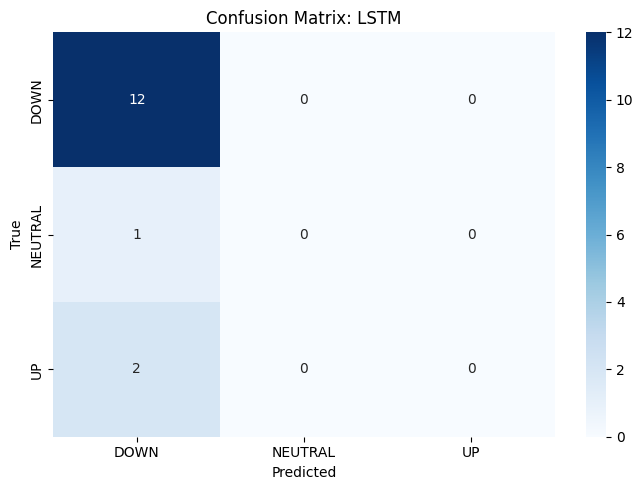

[BAJAJFINSV] Results DataFrame shape: (15, 27)
[BAJAJFINSV] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/BAJAJFINSV_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/BAJAJFINSV_results.xlsx
[BAJAJFINSV] 💾 Saved results to /content/output/BAJAJFINSV_results.xlsx
✅ Completed processing for BAJAJFINSV
[AXISBANK] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[AXISBANK] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[AXISBANK] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1485 - val_accuracy: 1.0000 - val_loss: 0.3763 - learning_rate: 0.0010
Epoch 44/50
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9091 - loss: 

Model: "LSTM_Model"

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1723 - val_accuracy: 1.0000 - val_loss: 0.9779 - learning_rate: 0.0010


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 10/50

Epoch 44: val_loss improved from 0.37635 to 0.36939, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 0.1409
Epoch 10: val_loss improved from 0.97791 to 0.97438, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5



Epoch 43: val_loss improved from 0.31792 to 0.31299, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2052 - val_accuracy: 1.0000 - val_loss: 0.3694 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1044 - val_accuracy: 1.0000 - val_loss: 0.3130 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1409 - val_accuracy: 1.0000 - val_loss: 0.9744 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 1.0000 - loss: 0.1101
Epoch 11: val_loss improved from 0.97438 to 0.97072, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5



Epoch 44: val_loss improved from 0.31299 to 0.30642, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0745
Epoch 45: val_loss improved from 0.36939 to 0.36278, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1101 - val_accuracy: 1.0000 - val_loss: 0.9707 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2043 - val_accuracy: 1.0000 - val_loss: 0.3064 - learning_rate: 0.0010
Epoch 12/50
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0745 - val_accuracy: 1.0000 - val_loss: 0.3628 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 0.1518
Epoch 46: val_loss improved from 0.36278 to 0.35661, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 1.0000 - loss: 0.0747
Epoch 12: val_loss improved from 0.97072 to 0.96729, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5



Epoch 45: val_loss improved from 0.30642 to 0.29899, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1518 - val_accuracy: 1.0000 - val_loss: 0.3566 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0747 - val_accuracy: 1.0000 - val_loss: 0.9673 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1088 - val_accuracy: 1.0000 - val_loss: 0.2990 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 1.0000 - loss: 0.1436
Epoch 47: val_loss improved from 0.35661 to 0.34941, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1183
Epoch 13: val_loss improved from 0.96729 to 0.96282, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5



Epoch 46: val_loss improved from 0.29899 to 0.28992, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1436 - val_accuracy: 1.0000 - val_loss: 0.3494 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1183 - val_accuracy: 1.0000 - val_loss: 0.9628 - learning_rate: 0.0010
Epoch 14/50

Epoch 48: val_loss improved from 0.34941 to 0.34576, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0933 - val_accuracy: 1.0000 - val_loss: 0.2899 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.0987
Epoch 47: val_loss improved from 0.28992 to 0.28448, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1895 - val_accuracy: 1.0000 - val_loss: 0.3458 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0987 - val_accuracy: 1.0000 - val_loss: 0.2845 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 0.0527
Epoch 14: val_loss improved from 0.96282 to 0.95663, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5



Epoch 48: val_loss improved from 0.28448 to 0.28020, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1272 - val_accuracy: 1.0000 - val_loss: 0.9566 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0527 - val_accuracy: 1.0000 - val_loss: 0.2802 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 1.0000 - loss: 0.1953
Epoch 15: val_loss improved from 0.95663 to 0.94986, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5

Epoch 49: val_loss improved from 0.34576 to 0.34107, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6364 - loss: 0.9881
Epoch 49: val_loss improved from 0.28020 to 0.27579, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1720 - val_accuracy: 1.0000 - val_loss: 0.3411 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0972 - val_accuracy: 1.0000 - val_loss: 0.9499 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1953 - val_accuracy: 1.0000 - val_loss: 0.2758 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 0.0985
Epoch 50: val_loss improved from 0.27579 to 0.27150, saving model to /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.18681, saving model to /content/checkpoints/AXISBANK/AXISBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step - accuracy: 1.0000 - loss: 0.0985 - val_accuracy: 1.0000 - val_loss: 0.2715 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1339
Epoch 16: val_loss improved from 0.94986 to 0.94151, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5



Epoch 50: val_loss improved from 0.34107 to 0.33786, saving model to /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.6364 - loss: 0.9881 - val_accuracy: 0.0000e+00 - val_loss: 1.1868 - learning_rate: 0.0010
Epoch 2/50
[BALKRISIND] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6364 - loss: 0.9286Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[BALKRISIND] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[BALKRISIND] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 2 0 0 0 0 0 0 0 0 0 0 2 1]

Epoch 2: val_loss did not improve from 1.18681


[BALKRISIND] ✅ Loaded best model from /content/checkpoints/BALKRISIND/BALKRISIND_lstm_model.h5
[BALKRISIND] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0835 - val_accuracy: 1.0000 - val_loss: 0.9415 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1339 - val_accuracy: 1.0000 - val_loss: 0.3379 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.9286 - val_accuracy: 0.0000e+00 - val_loss: 1.1870 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4545 - loss: 1.2428
Epoch 3: val_loss did not improve from 1.18681
[BALKRISIND] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.73      1.00      0.85        11
     NEUTRA

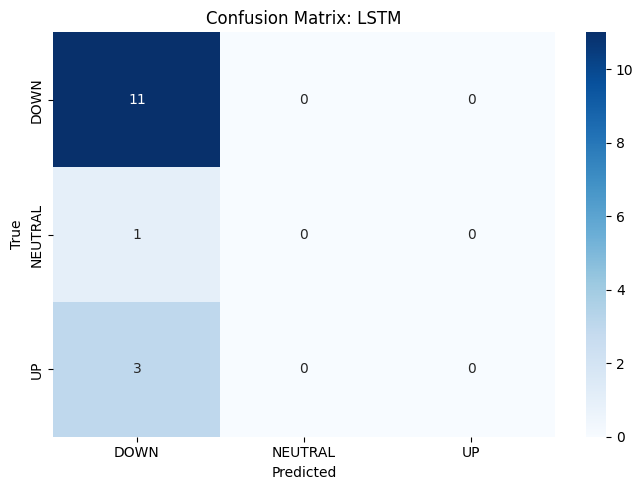


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.18681
[BALKRISIND] Results DataFrame shape: (15, 27)[BANKBARODA] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

[BALKRISIND] Prediction dates: [Timestamp('2025-07-10 00:00:00'), Timestamp('2025-07-11 00:00:00'), Timestamp('2025-07-14 00:00:00'), Timestamp('2025-07-15 00:00:00'), Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0643Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[BANKBAR

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[BANKBARODA] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 0 2 2 2 2 2 0 2 2 0 2 1]File downloaded to local machine: /content/output/BALKRISIND_results.xlsx
[BALKRISIND] 💾 Saved results to /content/output/BALKRISIND_results.xlsx
✅ Completed processing for BALKRISIND
[AUROPHARMA] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)



Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[AUROPHARMA] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[AUROPHARMA] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[BANKBARODA] ✅ Loaded best model from /content/checkpoints/BANKBARODA/BANKBARODA_lstm_model.h5
[BANKBARODA] Predicting for 15 dates, including 30-07-2025

Epoch 17: val_loss improved from 0.94151 to 0.93287, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5



✅ Built model: LSTM_Model | Output classes: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.9308 - val_accuracy: 0.0000e+00 - val_loss: 1.2125 - learning_rate: 0.0010
Epoch 5/50



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7273 - loss: 0.5972Epoch 1/50

Epoch 5: val_loss did not improve from 1.18681
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0643 - val_accuracy: 1.0000 - val_loss: 0.9329 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 0.0720[BANKBARODA] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5972 - val_accuracy: 0.0000e+00 - val_loss: 1.2146 - learning_rate: 5.0000e-04
Epoch 6/50

Epoch 18: val_loss improved from 0.93287 to 0.92516, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         3
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.73      1.00      0.85        11

    accuracy                           0.73        15
   macro avg       0.24      0.33      0.28        15
weighted avg       0.54      0.73      0.62        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0720 - val_accuracy: 1.0000 - val_loss: 0.9252 - learning_rate: 0.0010
Epoch 19/50


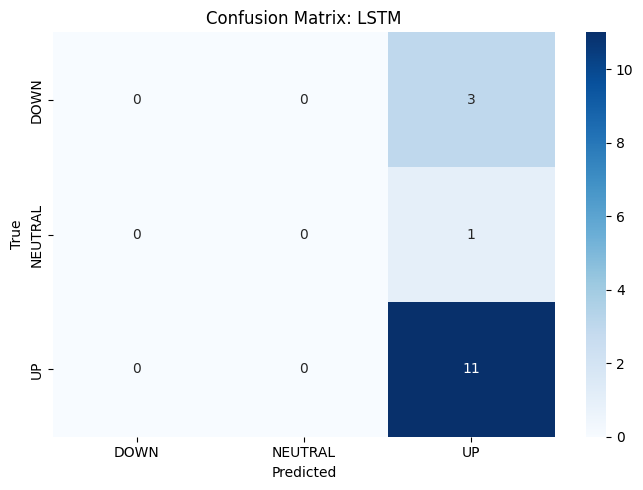

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 0.0922[BANKBARODA] Results DataFrame shape: (15, 27)
[BANKBARODA] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/BANKBARODA_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/BANKBARODA_results.xlsx
[BANKBARODA] 💾 Saved results to /content/output/BANKBARODA_results.xlsx
✅ Completed processing for BANKBARODA
[VOLTAS] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5455 - loss: 0.7121
Epoch 19: val_loss improved from 0.92516 to 0.91362, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[VOLTAS] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[VOLTAS] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 6: val_loss did not improve from 1.18681

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0922 - val_accuracy: 1.0000 - val_loss: 0.9136 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5455 - loss: 0.7121 - val_accuracy: 0.0000e+00 - val_loss: 1.2105 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
[AXISBANK] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[AXISBANK] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[AXISBANK] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 2 2 2 2 0 2 0 2 0 0 0 0 2 1]


[AXISBANK] ✅ Loaded best model from /content/checkpoints/AXISBANK/AXISBANK_lstm_model.h5
[AXISBANK] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0684
Epoch 20: val_loss improved from 0.91362 to 0.90040, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


[AXISBANK] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0684 - val_accuracy: 1.0000 - val_loss: 0.9004 - learning_rate: 0.0010
Epoch 21/50

Classification Report for LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 0.0690              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         7
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.50      0.86      0.63         7

    accuracy                           0.40        15
   macro avg       0.17      0.29      0.21        15
weighted avg       0.23      0.40      0.29        15


Epoch 21: val_loss improved from 0.90040 to 0.88630, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


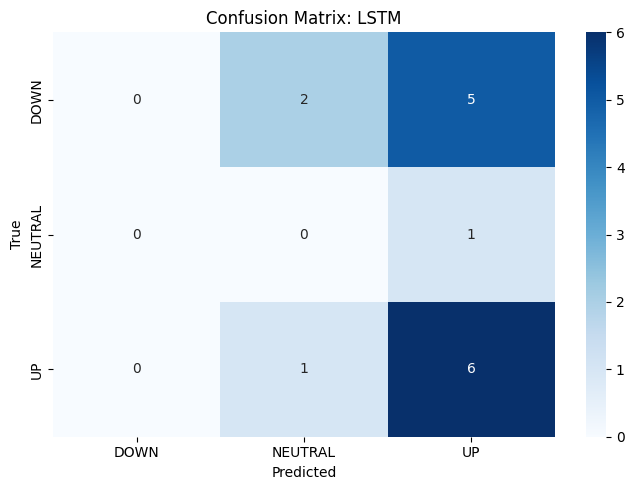

[AXISBANK] Results DataFrame shape: (15, 27)
[AXISBANK] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/AXISBANK_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/AXISBANK_results.xlsx
[AXISBANK] 💾 Saved results to /content/output/AXISBANK_results.xlsx
[CHOLAFIN] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for AXISBANK
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0690 - val_accuracy: 1.0000 - val_loss: 0.8863 - learning_rate: 0.0010
Epoch 22/50
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[CHOLAFIN] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[CHOLAFIN] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0254
Epoch 22: val_loss improved from 0.88630 to 0.87332, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0254 - val_accuracy: 1.0000 - val_loss: 0.8733 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0576
Epoch 23: val_loss improved from 0.87332 to 0.86147, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0576 - val_accuracy: 1.0000 - val_loss: 0.8615 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0306
Epoch 24: val_loss improved from 0.86147 to 0.84946, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.04446, saving model to /content/checkpoints/AUROPHARMA/AUROPHARMA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0306 - val_accuracy: 1.0000 - val_loss: 0.8495 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.0000e+00 - loss: 1.7495 - val_accuracy: 0.0000e+00 - val_loss: 1.0445 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - accuracy: 1.0000 - loss: 0.0329
Epoch 2: val_loss did not improve from 1.04446

Epoch 25: val_loss improved from 0.84946 to 0.83790, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.5180 - val_accuracy: 0.0000e+00 - val_loss: 1.0474 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0329 - val_accuracy: 1.0000 - val_loss: 0.8379 - learning_rate: 0.0010
Epoch 26/50

Epoch 3: val_loss did not improve from 1.04446
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 1.0000 - loss: 0.0355
Epoch 26: val_loss improved from 0.83790 to 0.82636, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.16439, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.2561 - val_accuracy: 0.0000e+00 - val_loss: 1.0497 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0355 - val_accuracy: 1.0000 - val_loss: 0.8264 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.3636 - loss: 1.5494 - val_accuracy: 0.0000e+00 - val_loss: 1.1644 - learning_rate: 0.0010
Epoch 2/50

Epoch 27: val_loss improved from 0.82636 to 0.81554, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step - accuracy: 1.0000 - loss: 0.0330 - val_accuracy: 1.0000 - val_loss: 0.8155 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2727 - loss: 1.1692
Epoch 28: val_loss improved from 0.81554 to 0.80438, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.04446
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0379 - val_accuracy: 1.0000 - val_loss: 0.8044 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 1.0000 - loss: 0.0243
Epoch 2: val_loss improved from 1.16439 to 1.12574, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2727 - loss: 1.1692 - val_accuracy: 0.0000e+00 - val_loss: 1.0548 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.3636 - loss: 1.0621
Epoch 29: val_loss improved from 0.80438 to 0.79419, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5



Epoch 5: val_loss did not improve from 1.04446
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2727 - loss: 1.1165 - val_accuracy: 0.0000e+00 - val_loss: 1.1257 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0243 - val_accuracy: 1.0000 - val_loss: 0.7942 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.0621 - val_accuracy: 0.0000e+00 - val_loss: 1.0564 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.3636 - loss: 1.4667
Epoch 3: val_loss improved from 1.12574 to 1.07765, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5



Epoch 6: val_loss did not improve from 1.04446

Epoch 1: val_loss improved from inf to 0.95656, saving model to /content/checkpoints/CHOLAFIN/CHOLAFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 0.9370 - val_accuracy: 1.0000 - val_loss: 1.0776 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step - accuracy: 0.3636 - loss: 1.4667 - val_accuracy: 0.0000e+00 - val_loss: 1.0583 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.0909 - loss: 1.9693 - val_accuracy: 1.0000 - val_loss: 0.9566 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0282
Epoch 4: val_loss improved from 1.07765 to 1.03620, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5


[AUROPHARMA] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

Epoch 30: val_loss improved from 0.79419 to 0.78394, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[AUROPHARMA] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[AUROPHARMA] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 2 0 2 0 2 0 2 2 0 0 0 0 2 1]


[AUROPHARMA] ✅ Loaded best model from /content/checkpoints/AUROPHARMA/AUROPHARMA_lstm_model.h5
[AUROPHARMA] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.8273 - val_accuracy: 1.0000 - val_loss: 1.0362 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0282 - val_accuracy: 1.0000 - val_loss: 0.7839 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 0.0166
Epoch 5: val_loss improved from 1.03620 to 1.01558, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5



Epoch 31: val_loss improved from 0.78394 to 0.77357, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


[AUROPHARMA] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       1.00      0.12      0.22         8
     NEUTRAL       0.07      1.00      0.13         1
          UP       0.00      0.00      0.00         6

    accuracy                           0.13        15
   macro avg       0.36      0.38      0.12        15
weighted avg       0.54      0.13      0.13        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.8666 - val_accuracy: 1.0000 - val_loss: 1.0156 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0166 - val_accuracy: 1.0000 - val_loss: 0.7736 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 1.0000 - loss: 0.0289
Epoch 2: val_loss improved from 0.95656 to 0.94885, saving model to /content/checkpoints/CHOLAFIN/CHOLAFIN_lstm_model.h5



Epoch 6: val_loss improved from 1.01558 to 0.99400, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5



Epoch 32: val_loss improved from 0.77357 to 0.76389, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


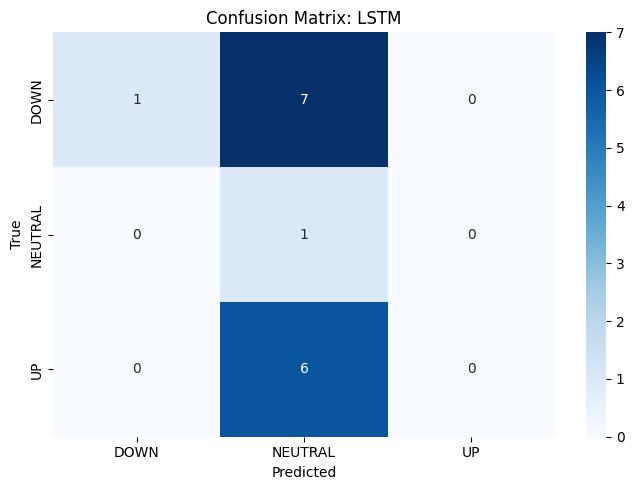

[AUROPHARMA] Results DataFrame shape: (15, 27)
[AUROPHARMA] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/AUROPHARMA_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/AUROPHARMA_results.xlsx
[AUROPHARMA] 💾 Saved results to /content/output/AUROPHARMA_results.xlsx
[CIPLA] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for AUROPHARMA
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[CIPLA] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[CIPLA] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2727 - loss: 1.3280 - val_accuracy: 1.0000 - val_loss: 0.9488 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.8202 - val_

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0289 - val_accuracy: 1.0000 - val_loss: 0.7639 - learning_rate: 0.0010
Epoch 33/50
Epoch 1/50

Epoch 7: val_loss improved from 0.99400 to 0.96688, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step - accuracy: 0.5455 - loss: 0.7652 - val_accuracy: 1.0000 - val_loss: 0.9669 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3636 - loss: 1.3699
Epoch 8: val_loss improved from 0.96688 to 0.93942, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0178
Epoch 3: val_loss improved from 0.94885 to 0.94246, saving model to /content/checkpoints/CHOLAFIN/CHOLAFIN_lstm_model.h5



Epoch 33: val_loss improved from 0.76389 to 0.75482, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7825 - val_accuracy: 1.0000 - val_loss: 0.9394 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3636 - loss: 1.3699 - val_accuracy: 1.0000 - val_loss: 0.9425 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0178 - val_accuracy: 1.0000 - val_loss: 0.7548 - learning_rate: 0.0010
Epoch 34/50

Epoch 4: val_loss improved from 0.94246 to 0.94076, saving model to /content/checkpoints/CHOLAFIN/CHOLAFIN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step - accuracy: 0.3636 - loss: 1.2192 - val_accuracy: 1.0000 - val_loss: 0.9408 - learning_rate: 0.0010
Epoch 5/50

Epoch 9: val_loss improved from 0.93942 to 0.91471, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.7273 - loss: 0.7884
Epoch 34: val_loss improved from 0.75482 to 0.74616, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5



Epoch 5: val_loss did not improve from 0.94076
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.8280 - val_accuracy: 1.0000 - val_loss: 0.9147 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.7884 - val_accuracy: 1.0000 - val_loss: 0.9454 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0335 - val_accuracy: 1.0000 - val_loss: 0.7462 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 0.0131
Epoch 10: val_loss improved from 0.91471 to 0.89648, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5



Epoch 35: val_loss improved from 0.74616 to 0.73807, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5



Epoch 6: val_loss did not improve from 0.94076
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5846 - val_accuracy: 1.0000 - val_loss: 0.8965 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.1299 - val_accuracy: 1.0000 - val_loss: 0.9556 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 0.7381 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.0154
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: val_loss did not improve from 0.94076

Epoch 36: val_loss improved from 0.73807 to 0.72985, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step - accuracy: 0.4545 - loss: 1.0254 - val_accuracy: 1.0000 - val_loss: 0.9618 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0154 - val_accuracy: 1.0000 - val_loss: 0.7298 - learning_rate: 0.0010
Epoch 37/50

Epoch 11: val_loss improved from 0.89648 to 0.87290, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 0.0178
Epoch 8: val_loss did not improve from 0.94076

Epoch 37: val_loss improved from 0.72985 to 0.72241, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.8734 - val_accuracy: 1.0000 - val_loss: 0.8729 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.0453 - val_accuracy: 1.0000 - val_loss: 0.9625 - learning_rate: 5.0000e-04
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0178 - val_accuracy: 1.0000 - val_loss: 0.7224 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 0.0244
Epoch 9: val_loss did not improve from 0.94076

Epoch 38: val_loss improved from 0.72241 to 0.71510, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step - accuracy: 0.8182 - loss: 0.6406 - val_accuracy: 1.0000 - val_loss: 0.9603 - learning_rate: 5.0000e-04
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.
[CHOLAFIN] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[CHOLAFIN] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[CHOLAFIN] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 2 0 0 2 0 0 0 2 2 0 0 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0244 - val_accuracy: 1.0000 - val_loss: 0.7151 - learning_rate: 0.0010
Epoch 39/50

Epoch 12: val_loss improved from 0.87290 to 0.84460, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5


[CHOLAFIN] ✅ Loaded best model from /content/checkpoints/CHOLAFIN/CHOLAFIN_lstm_model.h5
[CHOLAFIN] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 1.0000 - loss: 0.0167
Epoch 39: val_loss improved from 0.71510 to 0.70837, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.5271 - val_accuracy: 1.0000 - val_loss: 0.8446 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0167 - val_accuracy: 1.0000 - val_loss: 0.7084 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.5455 - loss: 0.8856[CHOLAFIN] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.60      1.00      0.75         9
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         5

    accuracy                           0.60        15
   macro avg       0.20      0.33      0.25        15
weighted avg       0.36      0.60      0.45        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4979

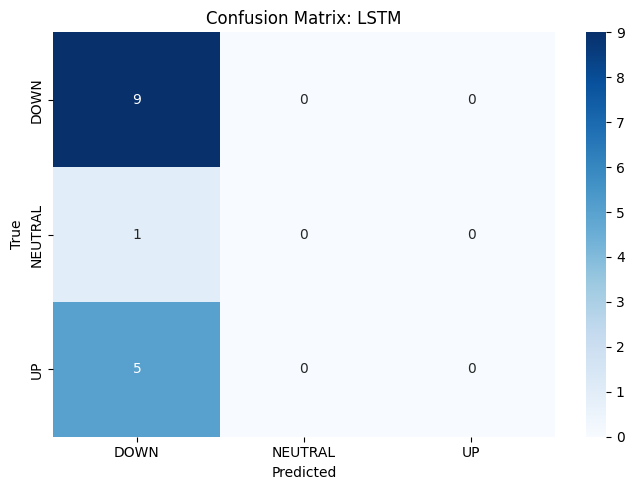

[CHOLAFIN] Results DataFrame shape: (15, 27)
[CHOLAFIN] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/CHOLAFIN_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/CHOLAFIN_results.xlsx
[CHOLAFIN] 💾 Saved results to /content/output/CHOLAFIN_results.xlsx
✅ Completed processing for CHOLAFIN
[COALINDIA] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)

Epoch 13: val_loss improved from 0.84460 to 0.81967, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.09432, saving model to /content/checkpoints/CIPLA/CIPLA_lstm_model.h5


Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[COALINDIA] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[COALINDIA] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0179Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 40: val_loss improved from 0.70837 to 0.70147, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5



✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.5455 - loss: 0.8856 - val_accuracy: 0.0000e+00 - val_loss: 1.0943 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4979 - val_accuracy: 1.0000 - val_loss: 0.8197 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0179 - val_accuracy: 1.0000 - val_loss: 0.7015 - learning_rate: 0.0010
Epoch 41/50

Epoch 2: val_loss did not improve from 1.09432
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step - accuracy: 0.8182 - loss: 0.7281 - val_accuracy: 0.0000e+00 - val_loss: 1.0946 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6364 - loss: 0.8519
Epoch 3: val_loss improved from 1.09432 to 1.09303, saving model to /content/checkpoints/CIPLA/CIPLA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.6175
Epoch 14: val_loss improved from 0.81967 to 0.80002, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0121
Epoch 41: val_loss improved from 0.70147 to 0.69438, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.8519 - val_accuracy: 0.0000e+00 - val_loss: 1.0930 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8182 - loss: 0.4433
Epoch 4: val_loss did not improve from 1.09303
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.6175 - val_accuracy: 1.0000 - val_loss: 0.8000 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0121 - val_accuracy: 1.0000 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4433 - val_accuracy: 0.0000e+00 - val_loss: 1.0942 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8182 - loss: 0.5420
Epoch 42: val_loss improved from 0.69438 to 0.68713, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.8182 - loss: 0.5229
Epoch 5: val_loss did not improve from 1.09303

Epoch 15: val_loss improved from 0.80002 to 0.78310, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5420 - val_accuracy: 0.0000e+00 - val_loss: 1.1011 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0158 - val_accuracy: 1.0000 - val_loss: 0.6871 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5229 - val_accuracy: 1.0000 - val_loss: 0.7831 - learning_rate: 0.0010
Epoch 16/50

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_loss did not improve from 1.09303
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step - accuracy: 0.7273 - loss: 0.5671 - val_accuracy: 0.0000e+00 - val_loss: 1.1071 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8182 - loss: 0.4561
Epoch 7: val_loss did not improve from 1.09303
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0137
Epoch 43: val_loss improved from 0.68713 to 0.68056, saving model to /content/checkpo

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step - accuracy: 0.8182 - loss: 0.4561 - val_accuracy: 0.0000e+00 - val_loss: 1.1090 - learning_rate: 5.0000e-04
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.2664
Epoch 16: val_loss improved from 0.78310 to 0.77174, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5



Epoch 8: val_loss did not improve from 1.09303
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0137 - val_accuracy: 1.0000 - val_loss: 0.6806 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.0116
Epoch 44: val_loss improved from 0.68056 to 0.67400, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2664 - val_accuracy: 0.0000e+00 - val_loss: 1.1097 - learning_rate: 5.0000e-04
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.5037 - val_accuracy: 1.0000 - val_loss: 0.7717 - learning_rate: 0.0010
Epoch 17/50
[CIPLA] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[CIPLA] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[CIPLA] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 2 0 0 0 0 2 0 0 0 0 0 1]


[CIPLA] ✅ Loaded best model from /content/checkpoints/CIPLA/CIPLA_lstm_model.h5
[CIPLA] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0116 - val_accuracy: 1.0000 - val_loss: 0.6740 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 0.0131
Epoch 45: val_loss improved from 0.67400 to 0.66679, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3973
Epoch 17: val_loss improved from 0.77174 to 0.76029, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 0.6668 - learning_rate: 0.0010
Epoch 46/50
[CIPLA] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 0.0159
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.80      0.33      0.47        12
     NEUTRAL       0.10      1.00      0.18         1
          UP       0.00      0.00      0.00         2

    accuracy                           0.33        15
   macro avg       0.30      0.44      0.22        15
weighted avg       0.65      0.33      0.39        15


Epoch 46: val_loss improved from 0.66679 to 0.65881, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3973 - val_accuracy: 1.0000 - val_loss: 0.7603 - learning_rate: 0.0010
Epoch 18/50


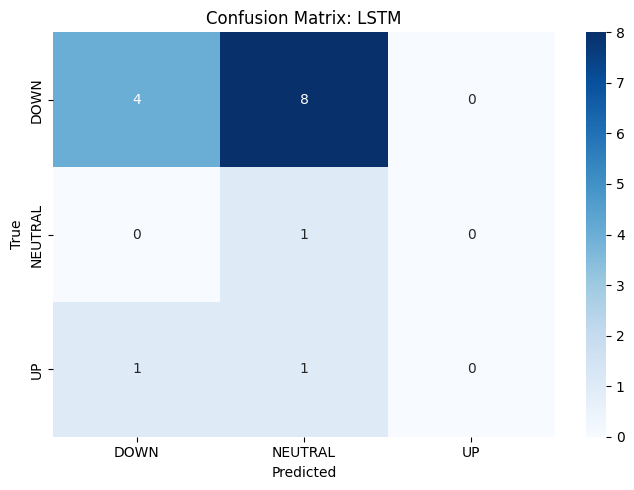

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0159 - val_accuracy: 1.0000 - val_loss: 0.6588 - learning_rate: 0.0010
Epoch 47/50
[CIPLA] Results DataFrame shape: (15, 27)
[CIPLA] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/CIPLA_results.xlsx
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 0.0134

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/CIPLA_results.xlsx
[CIPLA] 💾 Saved results to /content/output/CIPLA_results.xlsx
✅ Completed processing for CIPLA
[APOLLOTYRE] ✅ Set DatetimeIndex. Index range: 2024-07-29 00:00:00 to 2024-08-30 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[APOLLOTYRE] ✅ Technical indicators added. Shape: (24, 73), Features: 73
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

Epoch 47: val_loss improved from 0.65881 to 0.65172, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4215
✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6364 - loss: 0.9486
Epoch 18: val_loss improved from 0.76029 to 0.75212, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.6517 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4215 - val_accuracy: 1.0000 - val_loss: 0.7521 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9091 - loss: 0.3368
Epoch 19: val_loss improved from 0.75212 to 0.74668, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0100
Epoch 1: val_loss improved from inf to 0.95169, saving model to /content/checkpoints/COALINDIA/COALINDIA_lstm_model.h5



Epoch 48: val_loss improved from 0.65172 to 0.64463, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3368 - val_accuracy: 1.0000 - val_loss: 0.7467 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.6364 - loss: 0.9486 - val_accuracy: 1.0000 - val_loss: 0.9517 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 1.0000 - val_loss: 0.6446 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0095
Epoch 49: val_loss improved from 0.64463 to 0.63810, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4858
Epoch 20: val_loss improved from 0.74668 to 0.73687, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 0.6381 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 0.0095
Epoch 50: val_loss improved from 0.63810 to 0.63153, saving model to /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4858 - val_accuracy: 1.0000 - val_loss: 0.7369 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7273 - loss: 0.7466
Epoch 2: val_loss improved from 0.95169 to 0.88755, saving model to /content/checkpoints/COALINDIA/COALINDIA_lstm_model.h5



Epoch 21: val_loss improved from 0.73687 to 0.72476, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 0.6315 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
[BAJAJ-AUTO] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[BAJAJ-AUTO] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[BAJAJ-AUTO] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4616 - val_accuracy: 1.0000 - val_loss: 0.7248 - learning_rate: 0.0010
Epoch 22/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7273 - loss: 0.7466 - val_accuracy: 1.0000 - val_loss: 0.8875 - learning_rate: 0.0010
Epoch 3/50
[BAJAJ-AUTO] ✅ Loaded best model from /content/checkpoints/BAJAJ-AUTO/BAJAJ-AUTO_lstm_model.h5
[BAJAJ-AUTO] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.4545 - loss: 1.0121
Epoch 3: val_loss improved from 0.88755 to 0.84810, saving model to /content/checkpoints/COALINDIA/COALINDIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4533[BAJAJ-AUTO] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.0121 - val_accuracy: 1.0000 - val_loss: 0.8481 - learning_rate: 0.0010
Epoch 4/50

Epoch 22: val_loss improved from 0.72476 to 0.71851, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5



Classification Report for LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9091 - loss: 0.5526              precision    recall  f1-score   support

        DOWN       0.93      1.00      0.97        14
     NEUTRAL       0.00      0.00      0.00         1

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15


Epoch 4: val_loss improved from 0.84810 to 0.80578, saving model to /content/checkpoints/COALINDIA/COALINDIA_lstm_model.h5


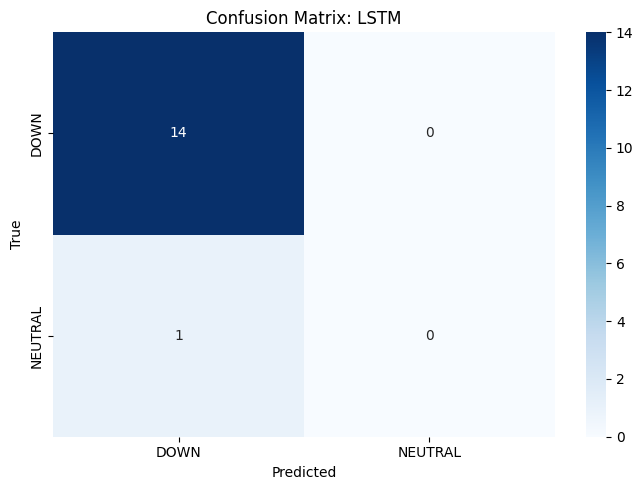

[BAJAJ-AUTO] Results DataFrame shape: (15, 26)
[BAJAJ-AUTO] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/BAJAJ-AUTO_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/BAJAJ-AUTO_results.xlsx
[BAJAJ-AUTO] 💾 Saved results to /content/output/BAJAJ-AUTO_results.xlsx
✅ Completed processing for BAJAJ-AUTO
[TATASTEEL] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4533 - val_accuracy: 1.0000 - val_loss: 0.7185 - learning_rate: 0.0010
Epoch 23/50
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[TATASTEEL] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[TATASTEEL] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50

Epoch 5: val_loss improved from 0.80578 to 0.78402, saving model to /content/checkpoints/COALINDIA/COALINDIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3615
Epoch 23: val_loss improved from 0.71851 to 0.71227, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6236 - val_accuracy: 1.0000 - val_loss: 0.7840 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8182 - loss: 0.6224
Epoch 6: val_loss improved from 0.78402 to 0.77088, saving model to /content/checkpoints/COALINDIA/COALINDIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3615 - val_accuracy: 1.0000 - val_loss: 0.7123 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7273 - loss: 0.4335
Epoch 24: val_loss improved from 0.71227 to 0.70658, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6224 - val_accuracy: 1.0000 - val_loss: 0.7709 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4335 - val_accuracy: 1.0000 - val_loss: 0.7066 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7273 - loss: 0.3726
Epoch 25: val_loss improved from 0.70658 to 0.70439, saving model to /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.7505
Epoch 7: val_loss improved from 0.77088 to 0.76428, saving model to /content/checkpoints/COALINDIA/COALINDIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.3726 - val_accuracy: 1.0000 - val_loss: 0.7044 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 0.2960
Epoch 1: val_loss improved from inf to 1.04059, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5



Epoch 26: val_loss did not improve from 0.70439
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.7505 - val_accuracy: 1.0000 - val_loss: 0.7643 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6364 - loss: 0.6265
Epoch 8: val_loss improved from 0.76428 to 0.75431, saving model to /content/checkpoints/COALINDIA/COALINDIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2960 - val_accuracy: 1.0000 - val_loss: 0.7091 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.5455 - loss: 1.0769 - val_accuracy: 0.0000e+00 - val_loss: 1.0406 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.6265 - val_accuracy: 1.0000 - val_loss: 0.7543 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7273 - loss: 0.6169
Epoch 9: val_loss improved from 0.75431 to 0.74108, saving model to /content/checkpoints/COALINDIA/COALINDIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step - accuracy: 0.7273 - loss: 0.6169 - val_accuracy: 1.0000 - val_loss: 0.7411 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3703
Epoch 27: val_loss did not improve from 0.70439
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.8182 - loss: 0.4422
Epoch 10: val_loss improved from 0.74108 to 0.73388, saving model to /content/checkpoints/COALINDIA/COALINDIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3703 - val_accuracy: 1.0000 - val_loss: 0.7157 - learning_rate: 0.0010
Epoch 28/50

Epoch 2: val_loss did not improve from 1.04059
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.8182 - loss: 0.4427
Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 28: val_loss did not improve from 0.70439
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4422 - val_accuracy: 1.0000 - val_loss: 0.7339 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3636 - loss: 0.9828 - val_accuracy: 0.0000e+00 - val_loss: 1.0477 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4427 - val_accuracy: 1.0000 - val_loss: 0.7255 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.8182 - loss: 0.3934
Epoch 11: val_loss improved from 0.73388 to 0.72700, saving model to /content/checkpo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.7697
Epoch 3: val_loss did not improve from 1.04059
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3934 - val_accuracy: 1.0000 - val_loss: 0.7270 - learning_rate: 0.0010
Epoch 12/50

Epoch 29: val_loss did not improve from 0.70439
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.7697 - val_accuracy: 0.0000e+00 - val_loss: 1.0432 - learning_rate: 0.0010
Epoch 4/50

Epoch 12: val_loss improved from 0.72700 to 0.72330, saving model to /content/checkpoints/COALINDIA/COALINDIA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.4545 - loss: 0.9273
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.04059
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3094 - val_accuracy: 1.0000 - val_loss: 0.7355 - learning_rate: 5.0000e-04
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8182 - loss: 0.3008
Epoch 30: val_loss did not improve from 0.70439

Epoch 1: val_loss improved from inf to 1.21416, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4422 - val_accuracy: 1.0000 - val_loss: 0.7233 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 0.9273 - val_accuracy: 0.0000e+00 - val_loss: 1.0425 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5455 - loss: 0.8636
Epoch 13: val_loss improved from 0.72330 to 0.72156, saving model to /content/checkpoints/COALINDIA/COALINDIA_lstm_model.h5



Epoch 5: val_loss improved from 1.04059 to 1.04040, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3008 - val_accuracy: 1.0000 - val_loss: 0.7483 - learning_rate: 5.0000e-04
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 25.
[VOLTAS] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[VOLTAS] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[VOLTAS] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 2 2 0 2 2 0 0 0 2 2 0 0 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.1818 - loss: 1.7324 - val_accuracy: 0.0000e+00 - val_loss: 1.2142 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.2727 - loss: 1.2682

[VOLTAS] ✅ Loaded best model from /content/checkpoints/VOLTAS/VOLTAS_lstm_model.h5
[VOLTAS] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3990 - val_accuracy: 1.0000 - val_loss: 0.7216 - learning_rate: 0.0010
Epoch 14/50

Epoch 2: val_loss improved from 1.21416 to 1.18638, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.8636 - val_accuracy: 0.0000e+00 - val_loss: 1.0404 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.2682 - val_accuracy: 0.0000e+00 - val_loss: 1.1864 - learning_rate: 0.0010
Epoch 3/50
[VOLTAS] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.47      1.00      0.64         7
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         7

    accuracy                           0.47        15
   macro avg       0.16      0.33      0.21        15
weighted avg       0.22      0.47      0.30        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.3636 - loss: 1.2802

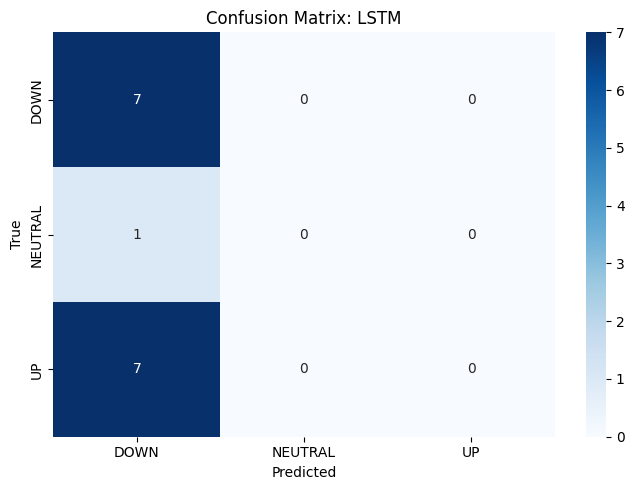

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3510
Epoch 3: val_loss improved from 1.18638 to 1.16217, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


[VOLTAS] Results DataFrame shape: (15, 27)
[VOLTAS] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.7522Excel report successfully generated: /content/output/VOLTAS_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/VOLTAS_results.xlsx
[VOLTAS] 💾 Saved results to /content/output/VOLTAS_results.xlsx
✅ Completed processing for VOLTAS
[HCLTECH] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)

Epoch 14: val_loss improved from 0.72156 to 0.72153, saving model to /content/checkpoints/COALINDIA/COALINDIA_lstm_model.h5


Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[HCLTECH] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[HCLTECH] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}

Epoch 6: val_loss improved from 1.04040 to 1.03904, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.2802 - val_accuracy: 0.0000e+00 - val_loss: 1.1622 - learning_rate: 0.0010
Epoch 4/50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3510 - val_accuracy: 1.0000 - val_loss: 0.7215 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.7522 - val_accuracy: 0.0000e+00 - val_loss: 1.0390 - learning_rate: 5.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8182 - loss: 0.4392
Epoch 4: val_loss improved from 1.16217 to 1.14646, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 15: val_loss did not improve from 0.72153
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step - accuracy: 0.8182 - loss: 0.4392 - val_accuracy: 1.0000 - val_loss: 0.7234 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 0.9771 - val_accuracy: 0.0000e+00 - val_loss: 1.1465 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.6214
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: val_loss did not improve from 0.72153

Epoch 5: val_loss improved from 1.14646 to 1.13361, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 7: val_loss improved from 1.03904 to 1.03575, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4296 - val_accuracy: 1.0000 - val_loss: 0.7242 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 0.9583 - val_accuracy: 0.0000e+00 - val_loss: 1.1336 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6214 - val_accuracy: 0.0000e+00 - val_loss: 1.0357 - learning_rate: 5.0000e-04
Epoch 8/50

Epoch 17: val_loss did not improve from 0.72153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5455 - loss: 0.7882
Epoch 8: val_loss improved from 1.03575 to 1.03250, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5149 - val_accuracy: 1.0000 - val_loss: 0.7257 - learning_rate: 5.0000e-04
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9091 - loss: 0.3467
Epoch 18: val_loss did not improve from 0.72153
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.7882 - val_accuracy: 0.0000e+00 - val_loss: 1.0325 - learning_rate: 5.0000e-04
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.7273 - loss: 0.6814
Epoch 6: val_loss improved from 1.13361 to 1.12415, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3467 - val_accuracy: 1.0000 - val_loss: 0.7286 - learning_rate: 5.0000e-04
Epoch 19/50

Epoch 9: val_loss improved from 1.03250 to 1.03042, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8182 - loss: 0.4119
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 19: val_loss did not improve from 0.72153
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4545 - loss: 0.8610 - val_accuracy: 0.0000e+00 - val_loss: 1.1241 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6814 - val_accuracy: 0.0000e+00 - val_loss: 1.0304 - learning_rate: 5.0000e-04
Epoch 10/50

Epoch 7: val_loss improved from 1.12415 to 1.11295, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4119 - val_accuracy: 1.0000 - val_loss: 0.7297 - learning_rate: 5.0000e-04
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 14.
[COALINDIA] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[COALINDIA] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[COALINDIA] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 2 0 2 2 0 2 2 2 0 2 1]

Epoch 10: val_loss improved from 1.03042 to 1.02802, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


[COALINDIA] ✅ Loaded best model from /content/checkpoints/COALINDIA/COALINDIA_lstm_model.h5
[COALINDIA] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5920 - val_accuracy: 0.0000e+00 - val_loss: 1.1129 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6555 - val_accuracy: 0.0000e+00 - val_loss: 1.0280 - learning_rate: 5.0000e-04
Epoch 11/50

Epoch 8: val_loss improved from 1.11295 to 1.09699, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


[COALINDIA] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5969 - val_accuracy: 0.0000e+00 - val_loss: 1.0970 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.7972
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         3
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.73      1.00      0.85        11

    accuracy                           0.73        15
   macro avg       0.24      0.33      0.28        15
weighted avg       0.54      0.73      0.62        15


Epoch 11: val_loss improved from 1.02802 to 1.02567, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


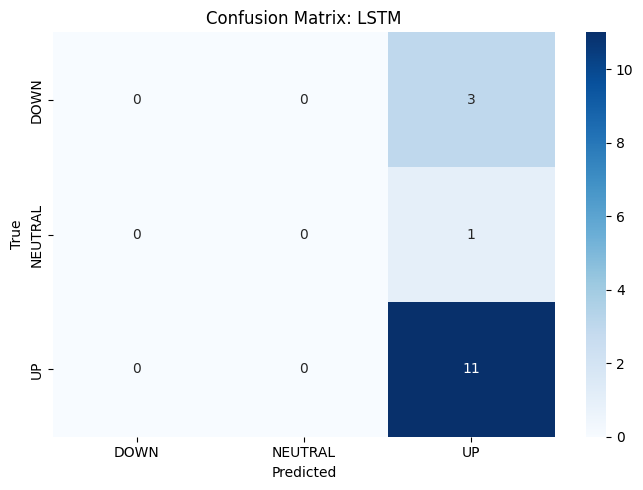

[COALINDIA] Results DataFrame shape: (15, 27)
[COALINDIA] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/COALINDIA_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/COALINDIA_results.xlsx
[COALINDIA] 💾 Saved results to /content/output/COALINDIA_results.xlsx
[HAVELLS] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for COALINDIA
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[HAVELLS] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[HAVELLS] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7972 - val_accuracy: 0.0000e+00 - val_loss: 1.0257 - learning_rate: 5.0000e-04
Epoch 12/50
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8182 - loss:

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 9: val_loss improved from 1.09699 to 1.08367, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 12: val_loss improved from 1.02567 to 1.02218, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5202 - val_accuracy: 0.0000e+00 - val_loss: 1.0222 - learning_rate: 5.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.5447 - val_accuracy: 0.0000e+00 - val_loss: 1.0837 - learning_rate: 0.0010
Epoch 13/50
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5455 - loss: 0.8228
Epoch 10: val_loss improved from 1.08367 to 1.07289, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 13: val_loss improved from 1.02218 to 1.01824, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.8228 - val_accuracy: 0.0000e+00 - val_loss: 1.0182 - learning_rate: 5.0000e-04
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5930 - val_accuracy: 0.0000e+00 - val_loss: 1.0729 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.5314
Epoch 11: val_loss improved from 1.07289 to 1.05937, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.14312, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 14: val_loss improved from 1.01824 to 1.01283, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4117 - val_accuracy: 0.0000e+00 - val_loss: 1.0594 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.0909 - loss: 2.3934 - val_accuracy: 0.0000e+00 - val_loss: 1.1431 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5314 - val_accuracy: 0.0000e+00 - val_loss: 1.0128 - learning_rate: 5.0000e-04
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.1818 - loss: 1.4583
Epoch 2: val_loss did not improve from 1.14312
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step - accuracy: 0.1818 - loss: 1.4583 - val_accuracy: 0.0000e+00 - val_loss: 1.1446 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2727 - loss: 1.6291
Epoch 3: val_loss improved from 1.14312 to 1.14197, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.7525
Epoch 12: val_loss improved from 1.05937 to 1.05080, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5

Epoch 15: val_loss improved from 1.01283 to 1.00703, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.6291 - val_accuracy: 0.0000e+00 - val_loss: 1.1420 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.3636 - loss: 1.1759
Epoch 4: val_loss did not improve from 1.14197
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.7525 - val_accuracy: 0.0000e+00 - val_loss: 1.0070 - learning_rate: 5.0000e-04
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3590 - val_accuracy: 0.0000e+00 - val_loss: 1.0508 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.1759 - val_accuracy: 0.0000e+00 - val_loss: 1.1424 - learning_rate: 0.0010

Epoch 16: val_loss improved from 1.00703 to 1.00031, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5
Epoch 5/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.2727 - loss: 1.1823
Epoch 5: val_loss improved from 1.14197 to 1.13985, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4694 - val_accuracy: 0.0000e+00 - val_loss: 1.0003 - learning_rate: 5.0000e-04
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.3636 - loss: 1.2673
Epoch 13: val_loss improved from 1.05080 to 1.04346, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.1823 - val_accuracy: 0.0000e+00 - val_loss: 1.1399 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.3636 - loss: 0.9618
Epoch 17: val_loss improved from 1.00031 to 0.99342, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5



Epoch 6: val_loss improved from 1.13985 to 1.13095, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3876 - val_accuracy: 0.0000e+00 - val_loss: 1.0435 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.2673 - val_accuracy: 1.0000 - val_loss: 0.9934 - learning_rate: 5.0000e-04
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 0.9618 - val_accuracy: 0.0000e+00 - val_loss: 1.1309 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.8182 - loss: 0.5307
Epoch 14: val_loss improved from 1.04346 to 1.03873, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 18: val_loss improved from 0.99342 to 0.98455, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3636 - loss: 1.3403
Epoch 1: val_loss improved from inf to 1.53309, saving model to /content/checkpoints/HAVELLS/HAVELLS_lstm_model.h5



Epoch 7: val_loss improved from 1.13095 to 1.12255, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3040 - val_accuracy: 0.0000e+00 - val_loss: 1.0387 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5307 - val_accuracy: 1.0000 - val_loss: 0.9845 - learning_rate: 5.0000e-04
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.5455 - loss: 2.2803 - val_accuracy: 0.0000e+00 - val_loss: 1.5331 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5455 - loss: 1.9121
Epoch 19: val_loss improved from 0.98455 to 0.97809, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3636 - loss: 1.3403 - val_accuracy: 0.0000e+00 - val_loss: 1.1225 - learning_rate: 0.0010
Epoch 8/50

Epoch 2: val_loss did not improve from 1.53309
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step - accuracy: 0.5455 - loss: 1.9121 - val_accuracy: 0.0000e+00 - val_loss: 1.5661 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step - accuracy: 0.7273 - loss: 0.5150 - val_accuracy: 1.0000 - val_loss: 0.9781 - learning_rate: 5.0000e-04
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8182 - loss: 0.6125
Epoch 15: val_loss improved from 1.03873 to 1.03536, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 3: val_loss did not improve from 1.53309

Epoch 20: val_loss improved from 0.97809 to 0.97024, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5455 - loss: 0.9161
Epoch 8: val_loss improved from 1.12255 to 1.11529, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4308 - val_accuracy: 0.0000e+00 - val_loss: 1.0354 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 1.0007 - val_accuracy: 0.0000e+00 - val_loss: 1.5767 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6125 - val_accuracy: 1.0000 - val_loss: 0.9702 - learning_rate: 5.0000e-04
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.9161 - val_accuracy: 0.0000e+00 - val_loss: 1.1153 - learning_rate: 0.0010
Epoch 9/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.53309
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5455 - loss: 0.8635
Epoch 21: val_loss improved from 0.97024 to 0.96334, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5



Epoch 9: val_loss improved from 1.11529 to 1.11102, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.9583 - val_accuracy: 0.0000e+00 - val_loss: 1.6005 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3765 - val_accuracy: 1.0000 - val_loss: 0.9633 - learning_rate: 5.0000e-04
Epoch 22/50

Epoch 5: val_loss did not improve from 1.53309
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9091 - loss: 0.3644
Epoch 16: val_loss improved from 1.03536 to 1.03109, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.8635 - val_accuracy: 0.0000e+00 - val_loss: 1.1110 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6364 - loss: 0.8514
Epoch 22: val_loss improved from 0.96334 to 0.95744, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5



Epoch 10: val_loss improved from 1.11102 to 1.10687, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.7856 - val_accuracy: 0.0000e+00 - val_loss: 1.6134 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2622 - val_accuracy: 1.0000 - val_loss: 1.0311 - learning_rate: 0.0010
Epoch 17/50

Epoch 6: val_loss did not improve from 1.53309
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3644 - val_accuracy: 1.0000 - val_loss: 0.9574 - learning_rate: 5.0000e-04
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.8514 - val_accuracy: 0.0000e+00 - val_loss: 1.1069 - learning_rate: 0.0010
Epoch 11/50

Epoch 23: val_loss improved from 0.95744 to 0.95198, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step - accuracy: 0.5455 - loss: 0.8176 - val_accuracy: 0.0000e+00 - val_loss: 1.6236 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step - accuracy: 0.8182 - loss: 0.5376 - val_accuracy: 1.0000 - val_loss: 0.9520 - learning_rate: 5.0000e-04
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9091 - loss: 0.5034
Epoch 24: val_loss improved from 0.95198 to 0.94758, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


[HAVELLS] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[HAVELLS] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[HAVELLS] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 0 0 2 2 0 0 2 0 0 0 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.2086
Epoch 17: val_loss improved from 1.03109 to 1.02679, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


[HAVELLS] ✅ Loaded best model from /content/checkpoints/HAVELLS/HAVELLS_lstm_model.h5
[HAVELLS] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step - accuracy: 0.9091 - loss: 0.5034 - val_accuracy: 1.0000 - val_loss: 0.9476 - learning_rate: 5.0000e-04
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8182 - loss: 0.5588
Epoch 11: val_loss improved from 1.10687 to 1.10051, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 25: val_loss improved from 0.94758 to 0.94040, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2086 - val_accuracy: 1.0000 - val_loss: 1.0268 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.2538[HAVELLS] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 18: val_loss improved from 1.02679 to 1.02428, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.9806 - val_accuracy: 0.0000e+00 - val_loss: 1.1005 - learning_rate: 0.0010
Epoch 12/50

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         7
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.47      1.00      0.64         7

    accuracy                           0.47        15
   macro avg       0.16      0.33      0.21        15
weighted avg       0.22      0.47      0.30        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5588 - val_accuracy: 1.0000 - val_loss: 0.9404 - learning_rate: 5.0000e-04
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8182 - loss: 0.4381
Epoch 12: val_loss improved from 1.10051 to 1.09444, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 26: val_loss improved from 0.94040 to 0.93204, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2538 - val_accuracy: 1.0000 - val_loss: 1.0243 - learning_rate: 0.0010
Epoch 19/50


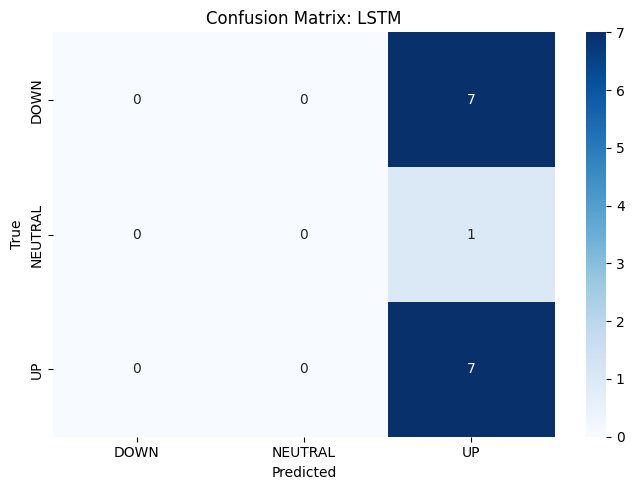

[HAVELLS] Results DataFrame shape: (15, 27)
[HAVELLS] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/HAVELLS_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/HAVELLS_results.xlsx
[HAVELLS] 💾 Saved results to /content/output/HAVELLS_results.xlsx
✅ Completed processing for HAVELLS
[GRASIM] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[GRASIM] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[GRASIM] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.8120 - val_accuracy: 0.0000e+00 - val_loss: 1.0944 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4381 - val_accuracy: 1.0000 - val_loss: 0.9320 - learning_rate: 5.0000e-04
Epoch 27/50
Unique classes:

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1928
Epoch 19: val_loss improved from 1.02428 to 1.02116, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1928 - val_accuracy: 1.0000 - val_loss: 1.0212 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.3313
Epoch 20: val_loss improved from 1.02116 to 1.01743, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 13: val_loss improved from 1.09444 to 1.08923, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 27: val_loss improved from 0.93204 to 0.92416, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1621 - val_accuracy: 1.0000 - val_loss: 1.0174 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.8837 - val_accuracy: 0.0000e+00 - val_loss: 1.0892 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.3313 - val_accuracy: 1.0000 - val_loss: 0.9242 - learning_rate: 5.0000e-04
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4588
Epoch 21: val_loss improved from 1.01743 to 1.01306, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 14: val_loss improved from 1.08923 to 1.08282, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 28: val_loss improved from 0.92416 to 0.91694, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1196 - val_accuracy: 1.0000 - val_loss: 1.0131 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.8673 - val_accuracy: 0.0000e+00 - val_loss: 1.0828 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4588 - val_accuracy: 1.0000 - val_loss: 0.9169 - learning_rate: 5.0000e-04
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8182 - loss: 0.5487
Epoch 22: val_loss improved from 1.01306 to 1.00896, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 29: val_loss improved from 0.91694 to 0.90832, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1024 - val_accuracy: 1.0000 - val_loss: 1.0090 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5487 - val_accuracy: 1.0000 - val_loss: 0.9083 - learning_rate: 5.0000e-04
Epoch 30/50

Epoch 15: val_loss improved from 1.08282 to 1.07615, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 23: val_loss improved from 1.00896 to 1.00471, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.9509 - val_accuracy: 0.0000e+00 - val_loss: 1.0762 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1471 - val_accuracy: 1.0000 - val_loss: 1.0047 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 1.0000 - loss: 0.1329
Epoch 16: val_loss improved from 1.07615 to 1.06957, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3441
Epoch 24: val_loss improved from 1.00471 to 1.00082, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 30: val_loss improved from 0.90832 to 0.90006, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6975 - val_accuracy: 1.0000 - val_loss: 1.0696 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1329 - val_accuracy: 1.0000 - val_loss: 1.0008 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3441 - val_accuracy: 1.0000 - val_loss: 0.9001 - learning_rate: 5.0000e-04
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9091 - loss: 0.4292
Epoch 31: val_loss improved from 0.90006 to 0.89171, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step - accuracy: 0.9091 - loss: 0.4292 - val_accuracy: 1.0000 - val_loss: 0.8917 - learning_rate: 5.0000e-04
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.6365
Epoch 17: val_loss improved from 1.06957 to 1.06140, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.06354, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8182 - loss: 0.4256
Epoch 25: val_loss improved from 1.00082 to 0.99635, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 32: val_loss improved from 0.89171 to 0.88323, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6365 - val_accuracy: 1.0000 - val_loss: 1.0614 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.0909 - loss: 2.0956 - val_accuracy: 1.0000 - val_loss: 1.0635 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1145 - val_accuracy: 1.0000 - val_loss: 0.9964 - learning_rate: 0.0010
Epoch 26/50

Epoch 18: val_loss improved from 1.06140 to 1.05529, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4256 - val_accuracy: 1.0000 - val_loss: 0.8832 - learning_rate: 5.0000e-04
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9091 - loss: 0.3903
Epoch 26: val_loss improved from 0.99635 to 0.99295, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 2: val_loss improved from 1.06354 to 1.06212, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5



Epoch 33: val_loss improved from 0.88323 to 0.87379, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 0.9152 - val_accuracy: 1.0000 - val_loss: 1.0553 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0909 - loss: 1.7938 - val_accuracy: 1.0000 - val_loss: 1.0621 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1148 - val_accuracy: 1.0000 - val_loss: 0.9929 - learning_rate: 0.0010
Epoch 27/50

Epoch 19: val_loss improved from 1.05529 to 1.05036, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3903 - val_accuracy: 1.0000 - val_loss: 0.8738 - learning_rate: 5.0000e-04
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8182 - loss: 0.3529
Epoch 34: val_loss improved from 0.87379 to 0.86558, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5971 - val_accuracy: 1.0000 - val_loss: 1.0504 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7273 - loss: 0.5491
Epoch 20: val_loss improved from 1.05036 to 1.04662, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step - accuracy: 0.8182 - loss: 0.3529 - val_accuracy: 1.0000 - val_loss: 0.8656 - learning_rate: 5.0000e-04
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1818 - loss: 1.3079
Epoch 35: val_loss improved from 0.86558 to 0.85856, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5



Epoch 27: val_loss improved from 0.99295 to 0.98932, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 3: val_loss did not improve from 1.06212
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5491 - val_accuracy: 1.0000 - val_loss: 1.0466 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7273 - loss: 0.5514
Epoch 21: val_loss improved from 1.04662 to 1.04208, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1818 - loss: 1.3079 - val_accuracy: 1.0000 - val_loss: 1.0622 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3354 - val_accuracy: 1.0000 - val_loss: 0.8586 - learning_rate: 5.0000e-04
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0771 - val_accuracy: 1.0000 - val_loss: 0.9893 - learning_rate: 0.0010
Epoch 28/50

Epoch 4: val_loss improved from 1.06212 to 1.05945, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5



Epoch 36: val_loss improved from 0.85856 to 0.85110, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5514 - val_accuracy: 1.0000 - val_loss: 1.0421 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.0716 - val_accuracy: 0.0000e+00 - val_loss: 1.0595 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4689 - val_accuracy: 1.0000 - val_loss: 0.8511 - learning_rate: 5.0000e-04
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0712
Epoch 37: val_loss improved from 0.85110 to 0.84230, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5



Epoch 28: val_loss improved from 0.98932 to 0.98559, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 5: val_loss improved from 1.05945 to 1.05440, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4981
Epoch 22: val_loss improved from 1.04208 to 1.03901, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3982 - val_accuracy: 1.0000 - val_loss: 0.8423 - learning_rate: 5.0000e-04
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2727 - loss: 1.5074 - val_accuracy: 0.0000e+00 - val_loss: 1.0544 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0712 - val_accuracy: 1.0000 - val_loss: 0.9856 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.3636 - loss: 1.1612
Epoch 38: val_loss improved from 0.84230 to 0.83341, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5



Epoch 29: val_loss improved from 0.98559 to 0.98054, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 6: val_loss improved from 1.05440 to 1.05163, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4981 - val_accuracy: 1.0000 - val_loss: 1.0390 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2813 - val_accuracy: 1.0000 - val_loss: 0.8334 - learning_rate: 5.0000e-04
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1056 - val_accuracy: 1.0000 - val_loss: 0.9805 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.1612 - val_accuracy: 1.0000 - val_loss: 1.0516 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.7273 - loss: 0.5674
Epoch 23: val_loss improved from 1.03901 to 1.03767, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5674 - val_accuracy: 1.0000 - val_loss: 1.0377 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8182 - loss: 0.5688
Epoch 24: val_loss improved from 1.03767 to 1.03382, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3636 - loss: 1.1464
Epoch 39: val_loss improved from 0.83341 to 0.82502, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5



Epoch 30: val_loss improved from 0.98054 to 0.97540, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 7: val_loss improved from 1.05163 to 1.04600, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5688 - val_accuracy: 1.0000 - val_loss: 1.0338 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.7273 - loss: 0.7618
Epoch 25: val_loss improved from 1.03382 to 1.02824, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4258 - val_accuracy: 1.0000 - val_loss: 0.8250 - learning_rate: 5.0000e-04
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3636 - loss: 1.1464 - val_accuracy: 1.0000 - val_loss: 1.0460 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0602 - val_accuracy: 1.0000 - val_loss: 0.9754 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8182 - loss: 0.3596
Epoch 40: val_loss improved from 0.82502 to 0.81514, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7618 - val_accuracy: 1.0000 - val_loss: 1.0282 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7273 - loss: 0.7062
Epoch 26: val_loss improved from 1.02824 to 1.02025, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step - accuracy: 0.8182 - loss: 0.3596 - val_accuracy: 1.0000 - val_loss: 0.8151 - learning_rate: 5.0000e-04
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step - accuracy: 0.7273 - loss: 0.7062 - val_accuracy: 1.0000 - val_loss: 1.0203 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4545 - loss: 0.9377
Epoch 27: val_loss improved from 1.02025 to 1.00984, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.9091 - loss: 0.3825
Epoch 31: val_loss improved from 0.97540 to 0.96928, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 8: val_loss improved from 1.04600 to 1.04411, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5



Epoch 41: val_loss improved from 0.81514 to 0.80610, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4914 - val_accuracy: 1.0000 - val_loss: 1.0098 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0632 - val_accuracy: 1.0000 - val_loss: 0.9693 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4545 - loss: 0.9377 - val_accuracy: 1.0000 - val_loss: 1.0441 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3825 - val_accuracy: 1.0000 - val_loss: 0.8061 - learning_rate: 5.0000e-04
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.4146
Epoch 28: val_loss improved from 1.00984 to 1.00019, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 32: val_loss improved from 0.96928 to 0.96231, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 9: val_loss improved from 1.04411 to 1.04110, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5



Epoch 42: val_loss improved from 0.80610 to 0.79645, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0803 - val_accuracy: 1.0000 - val_loss: 0.9623 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.6628 - val_accuracy: 1.0000 - val_loss: 1.0002 - learning_rate: 0.0010
Epoch 29/50
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7095 - val_accuracy: 1.0000 - val_loss: 1.0411 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.4146 - val_accuracy: 1.0000 - val_loss: 0.7964 - learning_rate: 5.0000e-04
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9091 - loss: 0.2286
Epoch 29: val_loss improved from 1.00019 to 0.98878, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 43: val_loss improved from 0.79645 to 0.78695, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step - accuracy: 0.5455 - loss: 0.7107 - val_accuracy: 1.0000 - val_loss: 0.9888 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step - accuracy: 0.9091 - loss: 0.2286 - val_accuracy: 1.0000 - val_loss: 0.7870 - learning_rate: 5.0000e-04
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.7273 - loss: 0.5625
Epoch 10: val_loss improved from 1.04110 to 1.03774, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.8182 - loss: 0.2948
Epoch 33: val_loss improved from 0.96231 to 0.95539, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 30: val_loss improved from 0.98878 to 0.97863, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 44: val_loss improved from 0.78695 to 0.77987, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0486 - val_accuracy: 1.0000 - val_loss: 0.9554 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.9007 - val_accuracy: 1.0000 - val_loss: 1.0377 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5625 - val_accuracy: 1.0000 - val_loss: 0.9786 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.2948 - val_accuracy: 1.0000 - val_loss: 0.7799 - learning_rate: 5.0000e-04
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.5648
Epoch 34: val_loss improved from 0.95539 to 0.94814, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.4852
Epoch 11: val_loss improved from 1.03774 to 1.03554, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5



Epoch 31: val_loss improved from 0.97863 to 0.96823, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 45: val_loss improved from 0.77987 to 0.77081, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0478 - val_accuracy: 1.0000 - val_loss: 0.9481 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4545 - loss: 1.0621 - val_accuracy: 1.0000 - val_loss: 1.0355 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.5648 - val_accuracy: 1.0000 - val_loss: 0.9682 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.4852 - val_accuracy: 1.0000 - val_loss: 0.7708 - learning_rate: 5.0000e-04
Epoch 46/50

Epoch 35: val_loss improved from 0.94814 to 0.94029, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step - accuracy: 1.0000 - loss: 0.0529 - val_accuracy: 1.0000 - val_loss: 0.9403 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0504
Epoch 36: val_loss improved from 0.94029 to 0.93225, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 1.0000 - loss: 0.0504 - val_accuracy: 1.0000 - val_loss: 0.9322 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.2272
Epoch 12: val_loss improved from 1.03554 to 1.03326, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5



Epoch 37: val_loss improved from 0.93225 to 0.92491, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5

Epoch 32: val_loss improved from 0.96823 to 0.95749, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 46: val_loss improved from 0.77081 to 0.76319, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7266 - val_accuracy: 1.0000 - val_loss: 1.0333 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.4362 - val_accuracy: 1.0000 - val_loss: 0.9575 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0423 - val_accuracy: 1.0000 - val_loss: 0.9249 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2272 - val_accuracy: 1.0000 - val_loss: 0.7632 - learning_rate: 5.0000e-04
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 0.0519
Epoch 38: val_loss improved from 0.92491 to 0.91784, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 1.0000 - loss: 0.0519 - val_accuracy: 1.0000 - val_loss: 0.9178 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0404
Epoch 39: val_loss improved from 0.91784 to 0.91047, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 1.0000 - loss: 0.0404 - val_accuracy: 1.0000 - val_loss: 0.9105 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0381
Epoch 40: val_loss improved from 0.91047 to 0.90280, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.2343
Epoch 13: val_loss improved from 1.03326 to 1.03195, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5



Epoch 33: val_loss improved from 0.95749 to 0.94740, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 47: val_loss improved from 0.76319 to 0.75616, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step - accuracy: 1.0000 - loss: 0.0381 - val_accuracy: 1.0000 - val_loss: 0.9028 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.0274
Epoch 41: val_loss improved from 0.90280 to 0.89390, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 0.8457 - val_accuracy: 1.0000 - val_loss: 1.0319 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4084 - val_accuracy: 1.0000 - val_loss: 0.9474 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2343 - val_accuracy: 1.0000 - val_loss: 0.7562 - learning_rate: 5.0000e-04
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step - accuracy: 1.0000 - loss: 0.0274 - val_accuracy: 1.0000 - val_loss: 0.8939 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 1.0000 - loss: 0.0416
Epoch 42: val_loss improved from 0.89390 to 0.88451, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step - accuracy: 1.0000 - loss: 0.0416 - val_accuracy: 1.0000 - val_loss: 0.8845 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.6188
Epoch 14: val_loss improved from 1.03195 to 1.03114, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3260
Epoch 34: val_loss improved from 0.94740 to 0.93866, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 43: val_loss improved from 0.88451 to 0.87538, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 48: val_loss improved from 0.75616 to 0.75162, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6188 - val_accuracy: 1.0000 - val_loss: 1.0311 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5527 - val_accuracy: 1.0000 - val_loss: 0.9387 - learning_rate: 0.0010
Epoch 35/50

Epoch 15: val_loss improved from 1.03114 to 1.02653, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0317 - val_accuracy: 1.0000 - val_loss: 0.8754 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.3260 - val_accuracy: 1.0000 - val_loss: 0.7516 - learning_rate: 5.0000e-04
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step - accuracy: 0.8182 - loss: 0.6043 - val_accuracy: 1.0000 - val_loss: 1.0265 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.8182 - loss: 0.5506
Epoch 16: val_loss improved from 1.02653 to 1.02154, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5506 - val_accuracy: 1.0000 - val_loss: 1.0215 - learning_rate: 0.0010
Epoch 17/50

Epoch 35: val_loss improved from 0.93866 to 0.92959, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 44: val_loss improved from 0.87538 to 0.86655, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 49: val_loss improved from 0.75162 to 0.74683, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4468 - val_accuracy: 1.0000 - val_loss: 0.9296 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0360 - val_accuracy: 1.0000 - val_loss: 0.8665 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2624 - val_accuracy: 1.0000 - val_loss: 0.7468 - learning_rate: 5.0000e-04
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6364 - loss: 0.6591
Epoch 17: val_loss improved from 1.02154 to 1.01724, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8182 - loss: 0.4569
Epoch 36: val_loss improved from 0.92959 to 0.92244, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 45: val_loss improved from 0.86655 to 0.85670, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 50: val_loss improved from 0.74683 to 0.74209, saving model to /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.5912 - val_accuracy: 1.0000 - val_loss: 1.0172 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.6591 - val_accuracy: 1.0000 - val_loss: 0.9224 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0428 - val_accuracy: 1.0000 - val_loss: 0.8567 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4569 - val_accuracy: 1.0000 - val_loss: 0.7421 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 50.

Epoch 18: val_loss improved from 1.01724 to 1.01331, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step - accuracy: 0.8182 - loss: 0.4959 - val_accuracy: 1.0000 - val_loss: 1.0133 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8182 - loss: 0.6518
Epoch 19: val_loss improved from 1.01331 to 1.00929, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step - accuracy: 0.8182 - loss: 0.6518 - val_accuracy: 1.0000 - val_loss: 1.0093 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.7346[APOLLOTYRE] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7273 - loss: 0.6815Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[APOLLOTYRE] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 0 2 0 0 2 2 0 0 2 2 2 0 1]

Epoch 37: val_loss improved from 0.92244 to 0.91659, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 46: val_loss improved from 0.85670 to 0.84643, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 20: val_loss improved from 1.00929 to 1.00410, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


[APOLLOTYRE] ✅ Loaded best model from /content/checkpoints/APOLLOTYRE/APOLLOTYRE_lstm_model.h5
[APOLLOTYRE] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.7346 - val_accuracy: 1.0000 - val_loss: 0.9166 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0208 - val_accuracy: 1.0000 - val_loss: 0.8464 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6815 - val_accuracy: 1.0000 - val_loss: 1.0041 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.0192
Epoch 47: val_loss improved from 0.84643 to 0.83621, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step - accuracy: 1.0000 - loss: 0.0192 - val_accuracy: 1.0000 - val_loss: 0.8362 - learning_rate: 0.0010
Epoch 48/50
[APOLLOTYRE] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 1.0000 - loss: 0.0332
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.40      0.29      0.33         7
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.40      0.57      0.47         7

    accuracy                           0.40        15
   macro avg       0.27      0.29      0.27        15
weighted avg       0.37      0.40      0.38        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.8182 - loss: 0.5731
Epoch 48: val_loss improved from 0.83621 to 0.82676, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 38: val_loss improved from 0.91659 to 0.91242, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 21: val_loss improved from 1.00410 to 0.99978, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


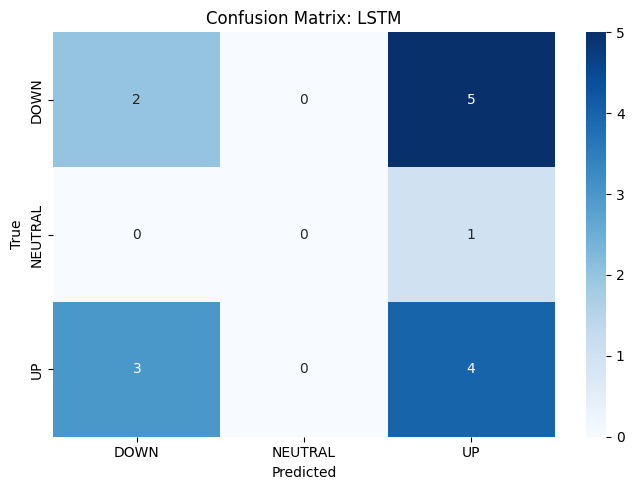

[APOLLOTYRE] Results DataFrame shape: (15, 27)
[APOLLOTYRE] Prediction dates: [Timestamp('2024-08-12 00:00:00'), Timestamp('2024-08-13 00:00:00'), Timestamp('2024-08-14 00:00:00'), Timestamp('2024-08-16 00:00:00'), Timestamp('2024-08-19 00:00:00'), Timestamp('2024-08-20 00:00:00'), Timestamp('2024-08-21 00:00:00'), Timestamp('2024-08-22 00:00:00'), Timestamp('2024-08-23 00:00:00'), Timestamp('2024-08-26 00:00:00'), Timestamp('2024-08-27 00:00:00'), Timestamp('2024-08-28 00:00:00'), Timestamp('2024-08-29 00:00:00'), Timestamp('2024-08-30 00:00:00'), Timestamp('2025-07-30 00:00:00')]
Excel report successfully generated: /content/output/APOLLOTYRE_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/APOLLOTYRE_results.xlsx
[APOLLOTYRE] 💾 Saved results to /content/output/APOLLOTYRE_results.xlsx
✅ Completed processing for APOLLOTYRE
[TCS] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0332 - val_accuracy: 1.0000 - val_loss: 0.8268 - learning_rate: 0.0010
Epoch 49/50
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[TCS] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[TCS] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.4874 - val_accur

Model: "LSTM_Model"


Epoch 49: val_loss improved from 0.82676 to 0.81701, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 22: val_loss improved from 0.99978 to 0.99614, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0234 - val_accuracy: 1.0000 - val_loss: 0.8170 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4057 - val_accuracy: 1.0000 - val_loss: 0.9961 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8182 - loss: 0.5748
Epoch 50: val_loss improved from 0.81701 to 0.80820, saving model to /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5



Epoch 39: val_loss improved from 0.91242 to 0.90853, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 23: val_loss improved from 0.99614 to 0.99059, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0269 - val_accuracy: 1.0000 - val_loss: 0.8082 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5748 - val_accuracy: 1.0000 - val_loss: 0.9906 - learning_rate: 0.0010
Epoch 24/50
[TATASTEEL] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4546 - val_accuracy: 1.0000 - val_loss: 0.9085 - learning_rate: 0.0010
Epoch 40/50
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[TATASTEEL] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7273 - loss: 0.4651[TATASTEEL] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 1]

Epoch 24: val_loss impro

[TATASTEEL] ✅ Loaded best model from /content/checkpoints/TATASTEEL/TATASTEEL_lstm_model.h5
[TATASTEEL] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4651 - val_accuracy: 1.0000 - val_loss: 0.9845 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8182 - loss: 0.4975
Epoch 40: val_loss improved from 0.90853 to 0.90716, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 25: val_loss improved from 0.98446 to 0.97801, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


[TATASTEEL] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4711 - val_accuracy: 1.0000 - val_loss: 0.9072 - learning_rate: 0.0010
Epoch 41/50
              precision    recall  f1-score   support

     NEUTRAL       0.00      0.00      0.00         1
          UP       0.93      1.00      0.97        14

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4975 - val_accuracy: 1.0000 - val_loss: 0.9780 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8182 - loss: 0.4586
Epoch 41: val_loss improved from 0.90716 to 0.90642, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


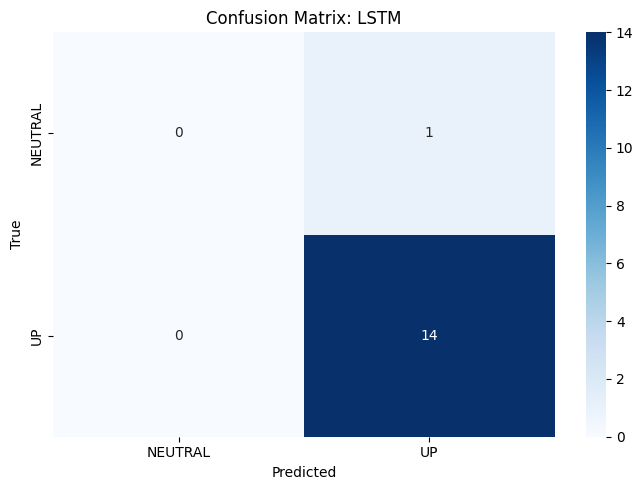

[TATASTEEL] Results DataFrame shape: (15, 26)
[TATASTEEL] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/TATASTEEL_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/TATASTEEL_results.xlsx
[TATASTEEL] 💾 Saved results to /content/output/TATASTEEL_results.xlsx
[WIPRO] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for TATASTEEL
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
Dropped 1 rows due to NaNs in target labeling.
[WIPRO] ✅ Technical indicators added. Shape: (23, 73), Features: 73
[WIPRO] ⚠️ NaN counts after technical indicators: {'AVWAP': 23}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 13 samples. Input shape: (13, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4586 - val_accuracy: 1.0000 - val_loss: 0.9064 - learning_rate: 0.0010
Epoch 42/50

✅ Built model: LSTM_Model | Out

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3600Epoch 1/50

Epoch 42: val_loss improved from 0.90642 to 0.90393, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 26: val_loss improved from 0.97801 to 0.97125, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3405 - val_accuracy: 1.0000 - val_loss: 0.9039 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.3600 - val_accuracy: 1.0000 - val_loss: 0.9713 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9091 - loss: 0.3802
Epoch 27: val_loss improved from 0.97125 to 0.96432, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.4740
Epoch 43: val_loss improved from 0.90393 to 0.89883, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3802 - val_accuracy: 1.0000 - val_loss: 0.9643 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.4740 - val_accuracy: 1.0000 - val_loss: 0.8988 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.4314
Epoch 44: val_loss improved from 0.89883 to 0.88922, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 28: val_loss improved from 0.96432 to 0.95736, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7273 - loss: 0.5660 - val_accuracy: 1.0000 - val_loss: 0.8892 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.9091 - loss: 0.4314 - val_accuracy: 1.0000 - val_loss: 0.9574 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.8182 - loss: 0.2971
Epoch 45: val_loss improved from 0.88922 to 0.87301, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 29: val_loss improved from 0.95736 to 0.95008, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.11583, saving model to /content/checkpoints/TCS/TCS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4251 - val_accuracy: 1.0000 - val_loss: 0.8730 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.2971 - val_accuracy: 1.0000 - val_loss: 0.9501 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.2727 - loss: 1.5505 - val_accuracy: 0.0000e+00 - val_loss: 1.1158 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3612
Epoch 46: val_loss improved from 0.87301 to 0.86004, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 30: val_loss improved from 0.95008 to 0.94271, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4240 - val_accuracy: 1.0000 - val_loss: 0.8600 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3612 - val_accuracy: 1.0000 - val_loss: 0.9427 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 1.0000 - loss: 0.2931
Epoch 47: val_loss improved from 0.86004 to 0.84429, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 31: val_loss improved from 0.94271 to 0.93447, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4779 - val_accuracy: 1.0000 - val_loss: 0.8443 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2931 - val_accuracy: 1.0000 - val_loss: 0.9345 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.2549
Epoch 48: val_loss improved from 0.84429 to 0.82918, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 32: val_loss improved from 0.93447 to 0.92696, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3901 - val_accuracy: 1.0000 - val_loss: 0.8292 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2549 - val_accuracy: 1.0000 - val_loss: 0.9270 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.1000 - loss: 1.8823
Epoch 49: val_loss improved from 0.82918 to 0.81861, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9091 - loss: 0.3265
Epoch 33: val_loss improved from 0.92696 to 0.92160, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4245 - val_accuracy: 1.0000 - val_loss: 0.8186 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7273 - loss: 0.4519
Epoch 2: val_loss improved from 1.11583 to 1.11406, saving model to /content/checkpoints/TCS/TCS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3265 - val_accuracy: 1.0000 - val_loss: 0.9216 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 1.0000 - loss: 0.2744
Epoch 50: val_loss improved from 0.81861 to 0.81261, saving model to /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.08396, saving model to /content/checkpoints/WIPRO/WIPRO_lstm_model.h5



Epoch 34: val_loss improved from 0.92160 to 0.91595, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2727 - loss: 1.1016 - val_accuracy: 0.0000e+00 - val_loss: 1.1141 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.4519 - val_accuracy: 1.0000 - val_loss: 0.8126 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.

Epoch 3: val_loss did not improve from 1.11406
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.1000 - loss: 1.8823 - val_accuracy: 0.0000e+00 - val_loss: 1.0840 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2744 - val_accuracy: 1.0000 - val_loss: 0.9159 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 1.0000 - loss: 0.1614
Epoch 2: val_loss improved from 1.08396 to 1.07311, saving model to /content/checkpoints/WIPRO/WIPRO_lstm_model.h5


[HCLTECH] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

Epoch 35: val_loss improved from 0.91595 to 0.91126, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.9931 - val_accuracy: 0.0000e+00 - val_loss: 1.1205 - learning_rate: 0.0010
Epoch 4/50
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[HCLTECH] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[HCLTECH] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 0 2 0 2 2 0 2 0 0 0 0 2 1]


[HCLTECH] ✅ Loaded best model from /content/checkpoints/HCLTECH/HCLTECH_lstm_model.h5
[HCLTECH] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2000 - loss: 1.4756 - val_accuracy: 1.0000 - val_loss: 1.0731 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1614 - val_accuracy: 1.0000 - val_loss: 0.9113 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.2297
Epoch 3: val_loss improved from 1.07311 to 1.06731, saving model to /content/checkpoints/WIPRO/WIPRO_lstm_model.h5



Epoch 36: val_loss improved from 0.91126 to 0.90719, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.7619
Epoch 4: val_loss did not improve from 1.11406
[HCLTECH] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4000 - loss: 1.3516 - val_accuracy: 1.0000 - val_loss: 1.0673 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2297 - val_accuracy: 1.0000 - val_loss: 0.9072 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 1.0000 - loss: 0.2360
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.60      0.75      0.67         8
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.60      0.50      0.55         6

    accuracy                           0.60        15
   macro avg       0.40      0.42      0.40        15
weighted avg       0.56      0.60      0.57        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5455 - loss: 0.7510
Epoch 37: val_loss improved from 0.90719 to 0.90138, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_loss did not improve from 1.11406


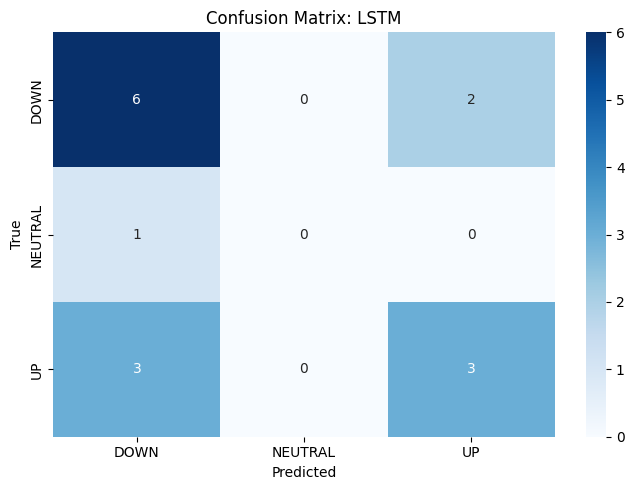

[HCLTECH] Results DataFrame shape: (15, 27)
[HCLTECH] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3000 - loss: 1.3370 - val_accuracy: 1.0000 - val_loss: 1.0658 - learning_rate: 0.0010
Epoch 5/50
Excel report successfully generated: /content/output/HCLTECH_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/HCLTECH_results.xlsx
[HCLTECH] 💾 Saved results to /content/output/HCLTECH_results.xlsx
✅ Completed processing for HCLTECH
[GODREJCP] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5000 - loss: 0.9889Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.7510 - val_accuracy: 0.0000e+00 - val_loss: 1.1353 - learning_rate: 0.0010
[GODREJCP] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[GODREJCP] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Epoch 6/50
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 6: val_loss did not improve from 1.11406
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.9889 - val_accuracy: 1.0000 - val_loss: 1.0673 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.5028 - val_accuracy: 0.0000e+00 - val_loss: 1.1364 - learning_rate: 5.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8182 - loss: 0.4914
Epoch 6: val_loss did not improve from 1.06585

Epoch 38: val_loss improved from 0.90138 to 0.89577, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5



Epoch 7: val_loss did not improve from 1.11406
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7000 - loss: 0.9216 - val_accuracy: 1.0000 - val_loss: 1.0672 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4914 - val_accuracy: 0.0000e+00 - val_loss: 1.1355 - learning_rate: 5.0000e-04
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
[TCS] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2434 - val_accuracy: 1.0000 - val_loss: 0.8958 - learning_rate: 0.0010
Epoch 39/50
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[TCS] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[TCS] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 2 0 0 0 0 0 0 0 0 2 0 1]

Epoch 7: val_loss improved from 1.06

[TCS] ✅ Loaded best model from /content/checkpoints/TCS/TCS_lstm_model.h5
[TCS] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6000 - loss: 0.8387 - val_accuracy: 1.0000 - val_loss: 1.0649 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3864[TCS] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 8: val_loss did not improve from 1.06489

Epoch 39: val_loss improved from 0.89577 to 0.89458, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00        12
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.13      1.00      0.24         2

    accuracy                           0.13        15
   macro avg       0.04      0.33      0.08        15
weighted avg       0.02      0.13      0.03        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8000 - loss: 0.5853 - val_accuracy: 1.0000 - val_loss: 1.0656 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3864 - val_accuracy: 1.0000 - val_loss: 0.8946 - learning_rate: 0.0010
Epoch 40/50


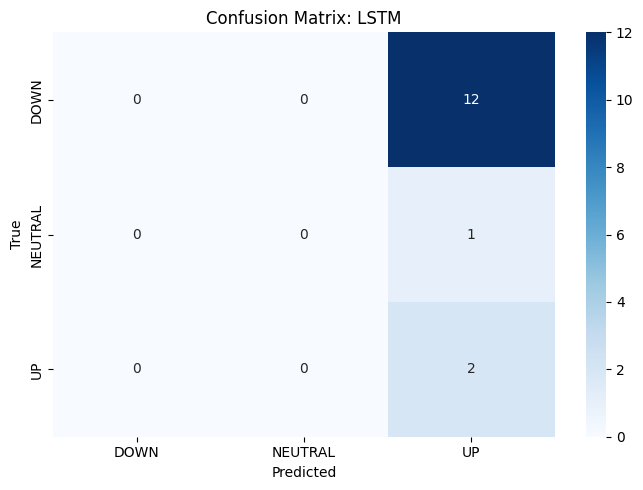

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9091 - loss: 0.3412[TCS] Results DataFrame shape: (15, 27)
[TCS] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/TCS_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/TCS_results.xlsx
[TCS] 💾 Saved results to /content/output/TCS_results.xlsx
[GMRINFRA] ✅ Set DatetimeIndex. Index range: 2024-07-29 00:00:00 to 2024-08-30 00:00:00
✅ Completed processing for TCS
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[GMRINFRA] ✅ Technical indicators added. Shape: (24, 73), Features: 73
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

Epoch 40: val_loss improved from 0.89458 to 0.89290, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3412 - val_accuracy: 1.0000 - val_loss: 0.8929 - learning_rate: 0.0010
Epoch 41/50

Epoch 9: val_loss improved from 1.06489 to 1.05934, saving model to /content/checkpoints/WIPRO/WIPRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7000 - loss: 0.5593 - val_accuracy: 1.0000 - val_loss: 1.0593 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.2189
Epoch 10: val_loss improved from 1.05934 to 1.04491, saving model to /content/checkpoints/WIPRO/WIPRO_lstm_model.h5



Epoch 41: val_loss improved from 0.89290 to 0.88993, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.3976 - val_accuracy: 1.0000 - val_loss: 1.0449 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2189 - val_accuracy: 1.0000 - val_loss: 0.8899 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.1951
Epoch 42: val_loss improved from 0.88993 to 0.88582, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1951 - val_accuracy: 1.0000 - val_loss: 0.8858 - learning_rate: 0.0010
Epoch 43/50

Epoch 11: val_loss improved from 1.04491 to 1.02916, saving model to /content/checkpoints/WIPRO/WIPRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9000 - loss: 0.4221 - val_accuracy: 1.0000 - val_loss: 1.0292 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.2388
Epoch 12: val_loss improved from 1.02916 to 1.01594, saving model to /content/checkpoints/WIPRO/WIPRO_lstm_model.h5



Epoch 43: val_loss improved from 0.88582 to 0.87924, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8000 - loss: 0.3991 - val_accuracy: 1.0000 - val_loss: 1.0159 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2388 - val_accuracy: 1.0000 - val_loss: 0.8792 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9091 - loss: 0.2303
Epoch 44: val_loss improved from 0.87924 to 0.87347, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2303 - val_accuracy: 1.0000 - val_loss: 0.8735 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9091 - loss: 0.2226
Epoch 1: val_loss improved from inf to 1.15151, saving model to /content/checkpoints/GODREJCP/GODREJCP_lstm_model.h5



Epoch 13: val_loss improved from 1.01594 to 1.00429, saving model to /content/checkpoints/WIPRO/WIPRO_lstm_model.h5



Epoch 45: val_loss improved from 0.87347 to 0.86929, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.0909 - loss: 2.4473 - val_accuracy: 0.0000e+00 - val_loss: 1.1515 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.3923 - val_accuracy: 1.0000 - val_loss: 1.0043 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2226 - val_accuracy: 1.0000 - val_loss: 0.8693 - learning_rate: 0.0010
Epoch 46/50

Epoch 14: val_loss improved from 1.00429 to 0.99712, saving model to /content/checkpoints/WIPRO/WIPRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step - accuracy: 0.9000 - loss: 0.3806 - val_accuracy: 1.0000 - val_loss: 0.9971 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.2217
Epoch 15: val_loss improved from 0.99712 to 0.98953, saving model to /content/checkpoints/WIPRO/WIPRO_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step - accuracy: 1.0000 - loss: 0.2217 - val_accuracy: 1.0000 - val_loss: 0.9895 - learning_rate: 0.0010
Epoch 16/50

Epoch 46: val_loss improved from 0.86929 to 0.86752, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0000e+00 - loss: 1.9557
Epoch 16: val_loss improved from 0.98953 to 0.98327, saving model to /content/checkpoints/WIPRO/WIPRO_lstm_model.h5



Epoch 2: val_loss did not improve from 1.15151
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1089 - val_accuracy: 1.0000 - val_loss: 0.8675 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0000e+00 - loss: 1.9557 - val_accuracy: 0.0000e+00 - val_loss: 1.1522 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2658 - val_accuracy: 1.0000 - val_loss: 0.9833 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2727 - loss: 1.3760
Epoch 3: val_loss improved from 1.15151 to 1.13858, saving model to /content/checkpoints/GODREJCP/GODREJCP_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.18046, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step - accuracy: 0.2727 - loss: 1.3760 - val_accuracy: 0.0000e+00 - val_loss: 1.1386 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.1818 - loss: 1.0949 - val_accuracy: 0.0000e+00 - val_loss: 1.1805 - learning_rate: 0.0010
Epoch 2/50

Epoch 47: val_loss improved from 0.86752 to 0.86446, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.2727 - loss: 1.2711
Epoch 17: val_loss improved from 0.98327 to 0.98203, saving model to /content/checkpoints/WIPRO/WIPRO_lstm_model.h5



Epoch 4: val_loss improved from 1.13858 to 1.11485, saving model to /content/checkpoints/GODREJCP/GODREJCP_lstm_model.h5



Epoch 2: val_loss improved from 1.18046 to 1.16023, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1496 - val_accuracy: 1.0000 - val_loss: 0.8645 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9091 - loss: 0.1998
Epoch 48: val_loss improved from 0.86446 to 0.86241, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9000 - loss: 0.2785 - val_accuracy: 1.0000 - val_loss: 0.9820 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2727 - loss: 1.4587 - val_accuracy: 0.0000e+00 - val_loss: 1.1148 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2727 - loss: 1.2711 - val_accuracy: 0.0000e+00 - val_loss: 1.1602 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4545 - loss: 0.8562
Epoch 18: val_loss did not improve from 0.98203
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1998 - val_accuracy: 1.0000 - val_loss: 0.8624 - learning_rate: 0.0010

Epoch 3: val_loss improved from 1.16023 to 1.13943, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5
Epoch 49/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step - accuracy: 1.0000 - loss: 0.2021 - val_accuracy: 1.0000 - val_loss: 0.9826 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step - accuracy: 0.4545 - loss: 0.8562 - val_accuracy: 0.0000e+00 - val_loss: 1.1394 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4545 - loss: 1.1507
Epoch 5: val_loss improved from 1.11485 to 1.09809, saving model to /content/checkpoints/GODREJCP/GODREJCP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.6364 - loss: 0.7712
Epoch 19: val_loss did not improve from 0.98203
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1923
Epoch 4: val_loss improved from 1.13943 to 1.12075, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.1507 - val_accuracy: 0.0000e+00 - val_loss: 1.0981 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5455 - loss: 1.0838
Epoch 49: val_loss improved from 0.86241 to 0.85558, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5



Epoch 6: val_loss improved from 1.09809 to 1.07149, saving model to /content/checkpoints/GODREJCP/GODREJCP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9000 - loss: 0.2211 - val_accuracy: 1.0000 - val_loss: 0.9845 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7712 - val_accuracy: 0.0000e+00 - val_loss: 1.1207 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1923 - val_accuracy: 1.0000 - val_loss: 0.8556 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.0838 - val_accuracy: 1.0000 - val_loss: 1.0715 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5455 - loss: 0.9818
Epoch 7: val_loss improved from 1.07149 to 1.04546, saving model to /content/checkpoints/GODREJCP/GODREJCP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - accuracy: 0.5455 - loss: 0.9818 - val_accuracy: 1.0000 - val_loss: 1.0455 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.5455 - loss: 1.2219
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 20: val_loss did not improve from 0.98203
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.7309
Epoch 8: val_loss improved from 1.04546 to 1.02614, saving model to /content/checkpoints/GODREJCP/GODREJCP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1750
Epoch 5: val_loss improved from 1.12075 to 1.10756, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5



Epoch 50: val_loss improved from 0.85558 to 0.84494, saving model to /content/checkpoints/GRASIM/GRASIM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9000 - loss: 0.2344 - val_accuracy: 1.0000 - val_loss: 0.9885 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.2219 - val_accuracy: 1.0000 - val_loss: 1.0261 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7309 - val_accuracy: 0.0000e+00 - val_loss: 1.1076 - learning_rate: 0.0010
Epoch 6/50

Epoch 21: val_loss did not improve from 0.98203
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1750 - val_accuracy: 1.0000 - val_loss: 0.8449 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step - accuracy: 1.0000 - loss: 0.2245 - val_accuracy: 1.0000 - val_loss: 0.9940 - learning_rate: 5.0000e-04
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0975
Epoch 22: val_loss did not improve from 0.98203
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/

[WIPRO] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 13 samples. Input shape: (13, 10, 52)
[WIPRO] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[WIPRO] Added sequence for 30-07-2025 prediction. X_future shape: (14, 10, 52), y_future_cls: [0 2 2 2 2 2 2 2 2 2 2 2 2 1]
[WIPRO] ✅ Loaded best model from /content/checkpoints/WIPRO/WIPRO_lstm_model.h5
[WIPRO] Predicting for 14 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.6240[GRASIM] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

Epoch 9: val_loss improved from 1.02614 to 1.01430, saving model to /content/checkpoints/GODREJCP/GODREJCP_lstm_model.h5


Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 6: val_loss improved from 1.10756 to 1.09318, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


[GRASIM] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[GRASIM] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 2 0 0 0 2 0 0 0 0 2 0 0 0 1]


[GRASIM] ✅ Loaded best model from /content/checkpoints/GRASIM/GRASIM_lstm_model.h5
[GRASIM] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.6240 - val_accuracy: 0.0000e+00 - val_loss: 1.0932 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5455 - loss: 0.9301 - val_accuracy: 1.0000 - val_loss: 1.0143 - learning_rate: 0.0010
Epoch 10/50
[WIPRO] Predictions generated. y_pred length: 14, dates_future length: 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8182 - loss: 0.6440
Epoch 7: val_loss improved from 1.09318 to 1.08392, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5



Epoch 10: val_loss improved from 1.01430 to 1.00537, saving model to /content/checkpoints/GODREJCP/GODREJCP_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         1
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.86      1.00      0.92        12

    accuracy                           0.86        14
   macro avg       0.29      0.33      0.31        14
weighted avg       0.73      0.86      0.79        14

[GRASIM] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.3386 - val_accuracy: 0.0000e+00 - val_loss: 1.0839 - learning_rate: 0.0010
Epoch 8/50


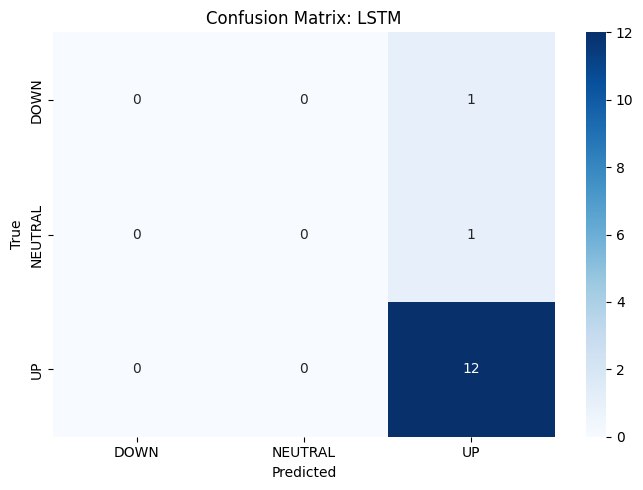

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6440 - val_accuracy: 1.0000 - val_loss: 1.0054 - learning_rate: 0.0010
Epoch 11/50

Classification Report for LSTM:
[WIPRO] Results DataFrame shape: (14, 27)
[WIPRO] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00')]
              precision    recall  f1-score   support

        DOWN       0.67      0.73      0.70        11
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         3

    accuracy                           0.53        15
  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/WIPRO_results.xlsx
[WIPRO] 💾 Saved results to /content/output/WIPRO_results.xlsx
[APOLLOHOSP] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for WIPRO
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[APOLLOHOSP] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[APOLLOHOSP] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 11: val_loss improved from 1.00537 to 0.99921, saving model to /content/checkpoints/GODREJCP/GODREJCP_lstm_model.h5



✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

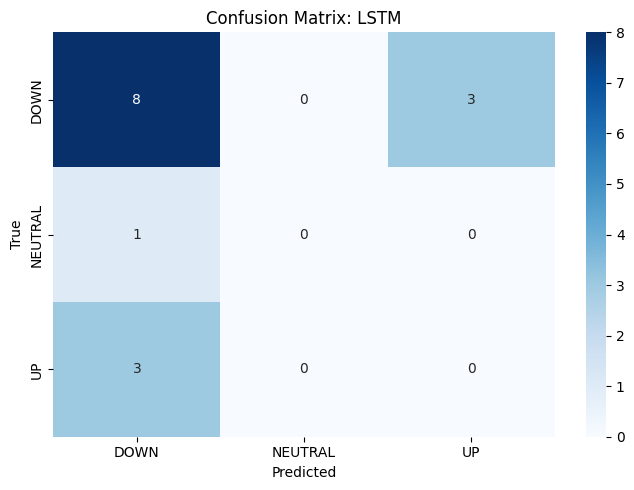

Epoch 1/50
[GRASIM] Results DataFrame shape: (15, 27)
[GRASIM] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/GRASIM_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/GRASIM_results.xlsx
[GRASIM] 💾 Saved results to /content/output/GRASIM_results.xlsx
✅ Completed processing for GRASIM
[GLENMARK] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[GLENMARK] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[GLENMARK] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6714 - val_accuracy: 1.0000 - val_loss: 0.9992 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.3816Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 8: val_loss improved from 1.08392 to 1.07827, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5



Epoch 12: val_loss improved from 0.99921 to 0.99832, saving model to /content/checkpoints/GODREJCP/GODREJCP_lstm_model.h5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.3816 - val_accuracy: 0.0000e+00 - val_loss: 1.0783 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5182 - val_accuracy: 1.0000 - val_loss: 0.9983 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9091 - loss: 0.3546
Epoch 9: val_loss improved from 1.07827 to 1.06971, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3546 - val_accuracy: 0.0000e+00 - val_loss: 1.0697 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 0.1668
Epoch 13: val_loss did not improve from 0.99832

Epoch 10: val_loss improved from 1.06971 to 1.06036, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.8880 - val_accuracy: 1.0000 - val_loss: 1.0009 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1668 - val_accuracy: 0.0000e+00 - val_loss: 1.0604 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.2852
Epoch 14: val_loss did not improve from 0.99832

Epoch 11: val_loss improved from 1.06036 to 1.04925, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.4862 - val_accuracy: 1.0000 - val_loss: 1.0000 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2852 - val_accuracy: 0.0000e+00 - val_loss: 1.0493 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 0.1883
Epoch 12: val_loss improved from 1.04925 to 1.03318, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1883 - val_accuracy: 0.0000e+00 - val_loss: 1.0332 - learning_rate: 0.0010
Epoch 13/50

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: val_loss did not improve from 0.99832
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5177 - val_accuracy: 1.0000 - val_loss: 1.0004 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8182 - loss: 0.4629
Epoch 16: val_loss did not improve from 0.99832
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1721
Epoch 13: val_loss improved from 1.03318 to 1.01596, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4629 - val_accuracy: 1.0000 - val_loss: 1.0031 - learning_rate: 5.0000e-04
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9091 - loss: 0.3225
Epoch 17: val_loss did not improve from 0.99832
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1721 - val_accuracy: 0.0000e+00 - val_loss: 1.0160 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3225 - val_accuracy: 1.0000 - val_loss: 1.0070 - learning_rate: 5.0000e-04
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 12.
[GODREJCP] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[GODREJCP] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[GODREJCP] Added sequence for 30-07-2025 prediction. X_future shape: (1

[GODREJCP] ✅ Loaded best model from /content/checkpoints/GODREJCP/GODREJCP_lstm_model.h5
[GODREJCP] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.5455 - loss: 1.0108
Epoch 14: val_loss improved from 1.01596 to 1.00353, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


[GODREJCP] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         7
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.47      1.00      0.64         7

    accuracy                           0.47        15
   macro avg       0.16      0.33      0.21        15
weighted avg       0.22      0.47      0.30        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2645 - val_accuracy: 0.0000e+00 - val_loss: 1.0035 - learning_rate: 0.0010
Epoch 15/50

Epoch 1: val_loss improved from inf to 1.11802, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 0.1134
Epoch 15: val_loss improved from 1.00353 to 0.99102, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


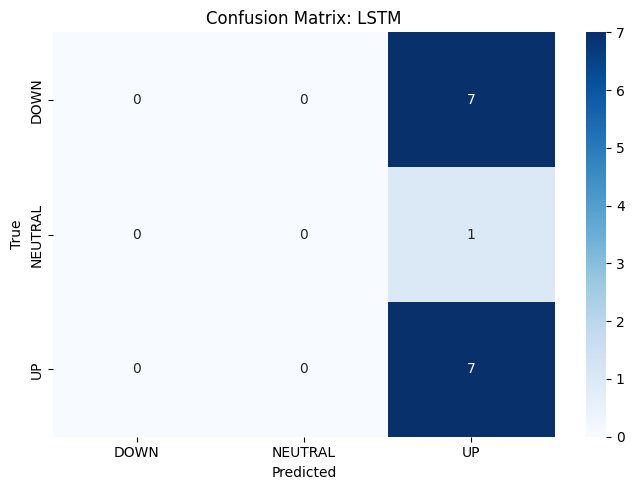

[GODREJCP] Results DataFrame shape: (15, 27)
[GODREJCP] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/GODREJCP_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/GODREJCP_results.xlsx
[GODREJCP] 💾 Saved results to /content/output/GODREJCP_results.xlsx
✅ Completed processing for GODREJCP
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.3636 - loss: 0.9983 - val_accuracy: 0.0000e+00 - val_loss: 1.1180 - learning_rate: 0.0010
Epoch 2/50
[GAIL] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[GAIL] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[GAIL] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5455 - loss: 0.9142Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━


Epoch 2: val_loss did not improve from 1.11802

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.9142 - val_accuracy: 0.0000e+00 - val_loss: 1.1235 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.5455 - loss: 1.0108 - val_accuracy: 0.0000e+00 - val_loss: 1.0977 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8182 - loss: 0.6346
Epoch 2: val_loss did not improve from 1.09766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1588
Epoch 3: val_loss did not improve from 1.11802

Epoch 16: val_loss improved from 0.99102 to 0.98024, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step - accuracy: 0.8182 - loss: 0.6346 - val_accuracy: 0.0000e+00 - val_loss: 1.1206 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.7696 - val_accuracy: 0.0000e+00 - val_loss: 1.1220 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_loss did not improve from 1.09766
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1588 - val_accuracy: 1.0000 - val_loss: 0.9802 - learning_rate: 0.0010
Epoch 17/50

Epoch 4: val_loss improved from 1.11802 to 1.11544, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4988 - val_accuracy: 0.0000e+00 - val_loss: 1.1491 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9091 - loss: 0.5206
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.09766
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6000 - val_accuracy: 0.0000e+00 - val_loss: 1.1154 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.5206 - val_accuracy: 0.0000e+00 - val_loss: 1.1754 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9091 - loss: 0.2741
Epoch 17: val_loss improved from 0.98024 to 0.97025, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5



Epoch 5: val_loss did not improve from 1.09766
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2741 - val_accuracy: 0.0000e+00 - val_loss: 1.1951 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1198 - val_accuracy: 1.0000 - val_loss: 0.9702 - learning_rate: 0.0010
Epoch 18/50

Epoch 5: val_loss improved from 1.11544 to 1.11116, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 6: val_loss did not improve from 1.09766
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2016 - val_accuracy: 0.0000e+00 - val_loss: 1.2132 - learning_rate: 5.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.5414 - val_accuracy: 0.0000e+00 - val_loss: 1.1112 - learning_rate: 0.0010
Epoch 6/50
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
[GLENMARK] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[GLENMARK] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[GLENMARK] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 0 0 0 0 0 0 0 0 0 2 0 0 1]

Epoch 18: val_loss improved from 0.97025 to 0.95979, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


[GLENMARK] ✅ Loaded best model from /content/checkpoints/GLENMARK/GLENMARK_lstm_model.h5
[GLENMARK] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0778 - val_accuracy: 1.0000 - val_loss: 0.9598 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 1.0000 - loss: 0.0886
Epoch 6: val_loss improved from 1.11116 to 1.10574, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 19: val_loss improved from 0.95979 to 0.94902, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


[GLENMARK] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.80      1.00      0.89        12
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         2

    accuracy                           0.80        15
   macro avg       0.27      0.33      0.30        15
weighted avg       0.64      0.80      0.71        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5500 - val_accuracy: 0.0000e+00 - val_loss: 1.1057 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0886 - val_accuracy: 1.0000 - val_loss: 0.9490 - learning_rate: 0.0010
Epoch 20/50

Epoch 7: val_loss improved from 1.10574 to 1.09685, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


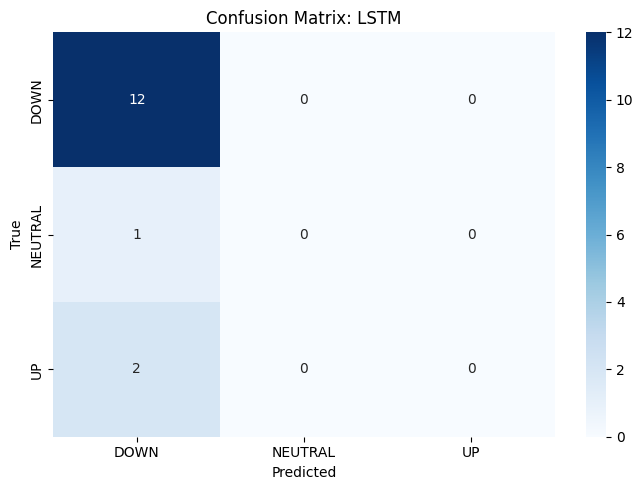

[GLENMARK] Results DataFrame shape: (15, 27)
[GLENMARK] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/GLENMARK_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/GLENMARK_results.xlsx
[GLENMARK] 💾 Saved results to /content/output/GLENMARK_results.xlsx
✅ Completed processing for GLENMARK
[TECHM] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[TECHM] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[TECHM] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5130 - val_accuracy: 0.0000e+00 - val_loss: 1.0969 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9091 - loss: 0.3047
✅ Built 

Model: "LSTM_Model"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1266

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50

Epoch 8: val_loss improved from 1.09685 to 1.08224, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 20: val_loss improved from 0.94902 to 0.94009, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3047 - val_accuracy: 0.0000e+00 - val_loss: 1.0822 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1266 - val_accuracy: 1.0000 - val_loss: 0.9401 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0638
Epoch 21: val_loss improved from 0.94009 to 0.93113, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5



Epoch 9: val_loss improved from 1.08224 to 1.06579, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.3470 - val_accuracy: 0.0000e+00 - val_loss: 1.0658 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0638 - val_accuracy: 1.0000 - val_loss: 0.9311 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9091 - loss: 0.3871
Epoch 1: val_loss improved from inf to 1.15079, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5



Epoch 10: val_loss improved from 1.06579 to 1.04882, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.3636 - loss: 1.3748 - val_accuracy: 0.0000e+00 - val_loss: 1.1508 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3871 - val_accuracy: 0.0000e+00 - val_loss: 1.0488 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0417
Epoch 11: val_loss improved from 1.04882 to 1.03135, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 22: val_loss improved from 0.93113 to 0.92223, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2640 - val_accuracy: 0.0000e+00 - val_loss: 1.0314 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0417 - val_accuracy: 1.0000 - val_loss: 0.9222 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 0.0535
Epoch 12: val_loss improved from 1.03135 to 1.01600, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 23: val_loss improved from 0.92223 to 0.91386, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4545 - loss: 0.9892
Epoch 2: val_loss improved from 1.15079 to 1.13965, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2237 - val_accuracy: 1.0000 - val_loss: 1.0160 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0535 - val_accuracy: 1.0000 - val_loss: 0.9139 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4545 - loss: 0.9892 - val_accuracy: 0.0000e+00 - val_loss: 1.1396 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7273 - loss: 0.8184
Epoch 3: val_loss improved from 1.13965 to 1.12145, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0620
Epoch 24: val_loss improved from 0.91386 to 0.90493, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5

Epoch 13: val_loss improved from 1.01600 to 1.00223, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.8184 - val_accuracy: 0.0000e+00 - val_loss: 1.1215 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0620 - val_accuracy: 1.0000 - val_loss: 0.9049 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2496 - val_accuracy: 1.0000 - val_loss: 1.0022 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9091 - loss: 0.1973
Epoch 14: val_loss improved from 1.00223 to 0.99078, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step - accuracy: 0.9091 - loss: 0.1973 - val_accuracy: 1.0000 - val_loss: 0.9908 - learning_rate: 0.0010
Epoch 15/50

Epoch 4: val_loss improved from 1.12145 to 1.10015, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0685
Epoch 25: val_loss improved from 0.90493 to 0.89555, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9091 - loss: 0.2458
Epoch 15: val_loss improved from 0.99078 to 0.97793, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.7872 - val_accuracy: 0.0000e+00 - val_loss: 1.1002 - learning_rate: 0.0010
Epoch 5/50

Epoch 1: val_loss improved from inf to 0.87505, saving model to /content/checkpoints/TECHM/TECHM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0685 - val_accuracy: 1.0000 - val_loss: 0.8956 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2458 - val_accuracy: 1.0000 - val_loss: 0.9779 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.2727 - loss: 1.6649 - val_accuracy: 1.0000 - val_loss: 0.8750 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4545 - loss: 1.3361
Epoch 16: val_loss improved from 0.97793 to 0.96954, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 2: val_loss improved from 0.87505 to 0.85740, saving model to /content/checkpoints/TECHM/TECHM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step - accuracy: 1.0000 - loss: 0.1961 - val_accuracy: 1.0000 - val_loss: 0.9695 - learning_rate: 0.0010
Epoch 17/50

Epoch 5: val_loss improved from 1.10015 to 1.08010, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step - accuracy: 0.4545 - loss: 1.3361 - val_accuracy: 1.0000 - val_loss: 0.8574 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.3636 - loss: 1.1188
Epoch 17: val_loss improved from 0.96954 to 0.96175, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 26: val_loss improved from 0.89555 to 0.88661, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5



Epoch 3: val_loss improved from 0.85740 to 0.84794, saving model to /content/checkpoints/TECHM/TECHM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.5686 - val_accuracy: 0.0000e+00 - val_loss: 1.0801 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1590 - val_accuracy: 1.0000 - val_loss: 0.9618 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0316 - val_accuracy: 1.0000 - val_loss: 0.8866 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.1188 - val_accuracy: 1.0000 - val_loss: 0.8479 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5455 - loss: 0.8870
Epoch 4: val_loss did not improve from 0.84794
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.5455 - loss: 0.8870 - val_accuracy: 1.0000 - val_loss: 0.8577 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8182 - loss: 0.7618
Epoch 5: val_loss did not improve from 0.84794
1/1 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step - accuracy: 0.8182 - loss: 0.7618 - val_accuracy: 1.0000 - val_loss: 0.8646 - learning_rate: 0.0010
Epoch 6/50

Epoch 18: val_loss improved from 0.96175 to 0.95537, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 27: val_loss improved from 0.88661 to 0.87751, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5301 - val_accuracy: 1.0000 - val_loss: 1.0563 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.7273 - loss: 0.7973
Epoch 7: val_loss improved from 1.05631 to 1.03413, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_loss did not improve from 0.84794
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1274 - val_accuracy: 1.0000 - val_loss: 0.9554 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0375 - val_accuracy: 1.0000 - val_loss: 0.8775 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3810 - val_accuracy: 1.0000 - val_loss: 1.0341 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7973 - val_accuracy: 1.0000 - val_loss: 0.8725 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7273 - loss: 0.4486
Epoch 8: val_loss improved from 1.03413 to 1.01472, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.7273 - loss: 0.4486 - val_accuracy: 1.0000 - val_loss: 1.0147 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9091 - loss: 0.3350
Epoch 7: val_loss did not improve from 0.84794

Epoch 9: val_loss improved from 1.01472 to 0.99317, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7933 - val_accuracy: 1.0000 - val_loss: 0.8759 - learning_rate: 5.0000e-04
Epoch 8/50

Epoch 28: val_loss improved from 0.87751 to 0.86868, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step - accuracy: 0.9091 - loss: 0.3350 - val_accuracy: 1.0000 - val_loss: 0.9932 - learning_rate: 0.0010
Epoch 10/50

Epoch 19: val_loss improved from 0.95537 to 0.94882, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8182 - loss: 0.4035
Epoch 10: val_loss improved from 0.99317 to 0.97887, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.8182 - loss: 0.6778
Epoch 8: val_loss did not improve from 0.84794
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0449 - val_accuracy: 1.0000 - val_loss: 0.8687 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1278 - val_accuracy: 1.0000 - val_loss: 0.9488 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4035 - val_accuracy: 1.0000 - val_loss: 0.9789 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.6778 - val_accuracy: 1.0000 - val_loss: 0.8772 - learning_rate: 5.0000e-04
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.
[TECHM] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[TECHM] ⚠

[TECHM] ✅ Loaded best model from /content/checkpoints/TECHM/TECHM_lstm_model.h5
[TECHM] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step - accuracy: 0.9091 - loss: 0.3404 - val_accuracy: 1.0000 - val_loss: 0.9659 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1589
Epoch 20: val_loss improved from 0.94882 to 0.94311, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 12: val_loss improved from 0.96591 to 0.95459, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5



Epoch 29: val_loss improved from 0.86868 to 0.85967, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


[TECHM] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.40      1.00      0.57         6
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         8

    accuracy                           0.40        15
   macro avg       0.13      0.33      0.19        15
weighted avg       0.16      0.40      0.23        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0398 - val_accuracy: 1.0000 - val_loss: 0.8597 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.1589 - val_accuracy: 1.0000 - val_loss: 0.9431 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3882 - val_accuracy: 1.0000 - val_loss: 0.9546 - learning_rate: 0.0010
Epoch 13/50


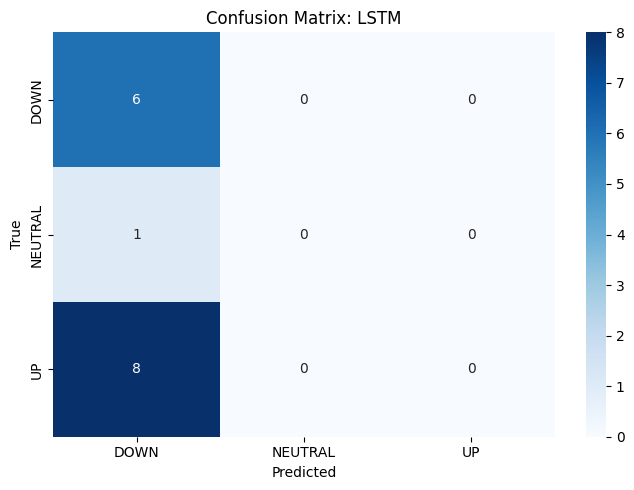

[TECHM] Results DataFrame shape: (15, 27)
[TECHM] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/TECHM_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/TECHM_results.xlsx
[TECHM] 💾 Saved results to /content/output/TECHM_results.xlsx
✅ Completed processing for TECHM
[RBLBANK] ✅ Set DatetimeIndex. Index range: 2024-07-29 00:00:00 to 2024-08-30 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[RBLBANK] ✅ Technical indicators added. Shape: (24, 73), Features: 73
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1458
Epoch 13: val_loss improved from 0.95459 to 0.94298, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5



Epoch 21: val_loss improved from 0.94311 to 0.93856, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 30: val_loss improved from 0.85967 to 0.85013, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3082 - val_accuracy: 1.0000 - val_loss: 0.9430 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1458 - val_accuracy: 1.0000 - val_loss: 0.9386 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0381 - val_accuracy: 1.0000 - val_loss: 0.8501 - learning_rate: 0.0010
Epoch 31/50

Epoch 14: val_loss improved from 0.94298 to 0.93146, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step - accuracy: 0.9091 - loss: 0.2698 - val_accuracy: 1.0000 - val_loss: 0.9315 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.8182 - loss: 0.4440
Epoch 22: val_loss improved from 0.93856 to 0.93433, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 31: val_loss improved from 0.85013 to 0.84037, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5



Epoch 15: val_loss improved from 0.93146 to 0.92350, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1256 - val_accuracy: 1.0000 - val_loss: 0.9343 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0318 - val_accuracy: 1.0000 - val_loss: 0.8404 - learning_rate: 0.0010
Epoch 23/50
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4440 - val_accuracy: 1.0000 - val_loss: 0.9235 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9091 - loss: 0.2499
Epoch 23: val_loss improved from 0.93433 to 0.92659, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 16: val_loss improved from 0.92350 to 0.91510, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0859 - val_accuracy: 1.0000 - val_loss: 0.9266 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2499 - val_accuracy: 1.0000 - val_loss: 0.9151 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9091 - loss: 0.2347
Epoch 32: val_loss improved from 0.84037 to 0.83075, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5



Epoch 24: val_loss improved from 0.92659 to 0.92195, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 17: val_loss improved from 0.91510 to 0.90943, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0295 - val_accuracy: 1.0000 - val_loss: 0.8307 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1322 - val_accuracy: 1.0000 - val_loss: 0.9219 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2347 - val_accuracy: 1.0000 - val_loss: 0.9094 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9091 - loss: 0.3087
Epoch 18: val_loss improved from 0.90943 to 0.90412, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step - accuracy: 0.9091 - loss: 0.3087 - val_accuracy: 1.0000 - val_loss: 0.9041 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0680
Epoch 19: val_loss improved from 0.90412 to 0.89898, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5



Epoch 33: val_loss improved from 0.83075 to 0.82141, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5



Epoch 25: val_loss improved from 0.92195 to 0.91834, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1646 - val_accuracy: 1.0000 - val_loss: 0.8990 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0446 - val_accuracy: 1.0000 - val_loss: 0.8214 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0680 - val_accuracy: 1.0000 - val_loss: 0.9183 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4545 - loss: 1.6271
Epoch 1: val_loss improved from inf to 1.08583, saving model to /content/checkpoints/RBLBANK/RBLBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.4545 - loss: 1.6271 - val_accuracy: 1.0000 - val_loss: 1.0858 - learning_rate: 0.0010
Epoch 2/50

Epoch 20: val_loss improved from 0.89898 to 0.89808, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.3636 - loss: 1.2442
Epoch 34: val_loss improved from 0.82141 to 0.81189, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5



Epoch 26: val_loss improved from 0.91834 to 0.91554, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 2: val_loss improved from 1.08583 to 1.07093, saving model to /content/checkpoints/RBLBANK/RBLBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2656 - val_accuracy: 1.0000 - val_loss: 0.8981 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0574 - val_accuracy: 1.0000 - val_loss: 0.9155 - learning_rate: 0.0010
Epoch 27/50

Epoch 21: val_loss improved from 0.89808 to 0.89321, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0174 - val_accuracy: 1.0000 - val_loss: 0.8119 - learning_rate: 0.0010
Epoch 35/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.2442 - val_accuracy: 1.0000 - val_loss: 1.0709 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7273 - loss: 0.8284
Epoch 3: val_loss improved from 1.07093 to 1.07000, saving model to /content/checkpoints/RBLBANK/RBLBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1375 - val_accuracy: 1.0000 - val_loss: 0.8932 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.8284 - val_accuracy: 1.0000 - val_loss: 1.0700 - learning_rate: 0.0010
Epoch 4/50

Epoch 35: val_loss improved from 0.81189 to 0.80203, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7273 - loss: 0.5153
Epoch 27: val_loss improved from 0.91554 to 0.91148, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 22: val_loss improved from 0.89321 to 0.88620, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5



Epoch 4: val_loss improved from 1.07000 to 1.06916, saving model to /content/checkpoints/RBLBANK/RBLBANK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0250 - val_accuracy: 1.0000 - val_loss: 0.8020 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0831 - val_accuracy: 1.0000 - val_loss: 0.9115 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.2290 - val_accuracy: 1.0000 - val_loss: 0.8862 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5153 - val_accuracy: 1.0000 - val_loss: 1.0692 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8182 - loss: 0.5652
Epoch 36: val_loss improved from 0.80203 to 0.79276, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5



Epoch 5: val_loss did not improve from 1.06916
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step - accuracy: 1.0000 - loss: 0.0266 - val_accuracy: 1.0000 - val_loss: 0.7928 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step - accuracy: 0.8182 - loss: 0.5652 - val_accuracy: 1.0000 - val_loss: 1.0702 - learning_rate: 0.0010
Epoch 6/50

Epoch 23: val_loss improved from 0.88620 to 0.87923, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5

Epoch 28: val_loss improved from 0.91148 to 0.90665, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 1.0000 - loss: 0.0212
Epoch 37: val_loss improved from 0.79276 to 0.78320, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.9091 - loss: 0.3843
Epoch 6: val_loss did not improve from 1.06916
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1539 - val_accuracy: 1.0000 - val_loss: 0.8792 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0836 - val_accuracy: 1.0000 - val_loss: 0.9066 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0212 - val_accuracy: 1.0000 - val_loss: 0.7832 - learning_rate: 0.0010
Epoch 38/50

Epoch 24: val_loss improved from 0.87923 to 0.87239, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3843 - val_accuracy: 1.0000 - val_loss: 1.0711 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9091 - loss: 0.2645
Epoch 38: val_loss improved from 0.78320 to 0.77381, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: val_loss did not improve from 1.06916
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1092 - val_accuracy: 1.0000 - val_loss: 0.8724 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0929
Epoch 25: val_loss improved from 0.87239 to 0.86410, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0220 - val_accuracy: 1.0000 - val_loss: 0.7738 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2645 - val_accuracy: 1.0000 - val_loss: 1.0758 - learning_rate: 0.0010
Epoch 8/50

Epoch 29: val_loss improved from 0.90665 to 0.90357, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9091 - loss: 0.4199
Epoch 8: val_loss did not improve from 1.06916

Epoch 39: val_loss improved from 0.77381 to 0.76381, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1776 - val_accuracy: 1.0000 - val_loss: 0.8641 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0929 - val_accuracy: 1.0000 - val_loss: 0.9036 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4199 - val_accuracy: 1.0000 - val_loss: 1.0765 - learning_rate: 5.0000e-04
Epoch 9/50

Epoch 26: val_loss improved from 0.86410 to 0.85582, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0176 - val_accuracy: 1.0000 - val_loss: 0.7638 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8182 - loss: 0.3416
Epoch 9: val_loss did not improve from 1.06916
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step - accuracy: 0.8182 - loss: 0.2276 - val_accuracy: 1.0000 - val_loss: 0.8558 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step - accuracy: 0.8182 - loss: 0.3416 - val_accuracy: 1.0000 - val_loss: 1.0775 - learning_rate: 5.0000e-04
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.
[RBLBANK] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[RBLBANK] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 0 2 2 2 2 0 2 2 2 2 1]

Epoch 27: val_loss i

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1201

[RBLBANK] ✅ Loaded best model from /content/checkpoints/RBLBANK/RBLBANK_lstm_model.h5
[RBLBANK] Predicting for 15 dates, including 30-07-2025

Epoch 30: val_loss improved from 0.90357 to 0.90304, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1671 - val_accuracy: 1.0000 - val_loss: 0.8508 - learning_rate: 0.0010
Epoch 28/50

Epoch 40: val_loss improved from 0.76381 to 0.75365, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9091 - loss: 0.2173
Epoch 28: val_loss improved from 0.85077 to 0.84932, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1201 - val_accuracy: 1.0000 - val_loss: 0.9030 - learning_rate: 0.0010
Epoch 31/50
[RBLBANK] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0136 - val_accuracy: 1.0000 - val_loss: 0.7536 - learning_rate: 0.0010
Epoch 41/50

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         2
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.80      1.00      0.89        12

    accuracy                           0.80        15
   macro avg       0.27      0.33      0.30        15
weighted avg       0.64      0.80      0.71        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2173 - val_accuracy: 1.0000 - val_loss: 0.8493 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 0

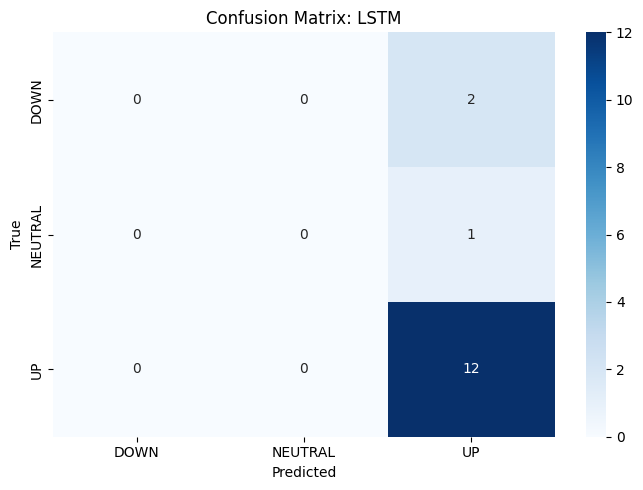

[RBLBANK] Results DataFrame shape: (15, 27)
[RBLBANK] Prediction dates: [Timestamp('2024-08-12 00:00:00'), Timestamp('2024-08-13 00:00:00'), Timestamp('2024-08-14 00:00:00'), Timestamp('2024-08-16 00:00:00'), Timestamp('2024-08-19 00:00:00'), Timestamp('2024-08-20 00:00:00'), Timestamp('2024-08-21 00:00:00'), Timestamp('2024-08-22 00:00:00'), Timestamp('2024-08-23 00:00:00'), Timestamp('2024-08-26 00:00:00'), Timestamp('2024-08-27 00:00:00'), Timestamp('2024-08-28 00:00:00'), Timestamp('2024-08-29 00:00:00'), Timestamp('2024-08-30 00:00:00'), Timestamp('2025-07-30 00:00:00')]
Excel report successfully generated: /content/output/RBLBANK_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/RBLBANK_results.xlsx
[RBLBANK] 💾 Saved results to /content/output/RBLBANK_results.xlsx
✅ Completed processing for RBLBANK
[FEDERALBNK] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[FEDERALBNK] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[FEDERALBNK] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step - accuracy: 1.0000 - loss: 0.1293 - val_accuracy: 1.0000 - val_loss: 0.8477 - learning_rate: 0.0010
Epoch 30/50

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.1552
Epoch 31: val_loss improved from 0.90304 to 0.90212, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0240
Epoch 30: val_loss improved from 0.84774 to 0.84676, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5



Epoch 41: val_loss improved from 0.75365 to 0.74313, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0748 - val_accuracy: 1.0000 - val_loss: 0.9021 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1552 - val_accuracy: 1.0000 - val_loss: 0.8468 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0240 - val_accuracy: 1.0000 - val_loss: 0.7431 - learning_rate: 0.0010
Epoch 42/50

Epoch 32: val_loss improved from 0.90212 to 0.90149, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 1.0000 - loss: 0.0153
Epoch 42: val_loss improved from 0.74313 to 0.73263, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0721 - val_accuracy: 1.0000 - val_loss: 0.9015 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1703
Epoch 33: val_loss improved from 0.90149 to 0.90075, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 31: val_loss improved from 0.84676 to 0.84418, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 1.0000 - val_loss: 0.7326 - learning_rate: 0.0010
Epoch 43/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0595 - val_accuracy: 1.0000 - val_loss: 0.9008 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.1703 - val_accuracy: 1.0000 - val_loss: 0.8442 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0146
Epoch 32: val_loss improved from 0.84418 to 0.83725, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5



Epoch 43: val_loss improved from 0.73263 to 0.72252, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0931
Epoch 34: val_loss improved from 0.90075 to 0.89972, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1554 - val_accuracy: 1.0000 - val_loss: 0.8372 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0146 - val_accuracy: 1.0000 - val_loss: 0.7225 - learning_rate: 0.0010
Epoch 44/50

Epoch 33: val_loss improved from 0.83725 to 0.83000, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0931 - val_accuracy: 1.0000 - val_loss: 0.8997 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1183 - val_accuracy: 1.0000 - val_loss: 0.8300 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9091 - loss: 0.2007
Epoch 34: val_loss improved from 0.83000 to 0.82459, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5



Epoch 44: val_loss improved from 0.72252 to 0.71173, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2007 - val_accuracy: 1.0000 - val_loss: 0.8246 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 0.1032
Epoch 35: val_loss improved from 0.89972 to 0.89800, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0218 - val_accuracy: 1.0000 - val_loss: 0.7117 - learning_rate: 0.0010
Epoch 45/50

Epoch 35: val_loss improved from 0.82459 to 0.81868, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0654 - val_accuracy: 1.0000 - val_loss: 0.8980 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1032 - val_accuracy: 1.0000 - val_loss: 0.8187 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9091 - loss: 0.1385
Epoch 36: val_loss improved from 0.89800 to 0.89482, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 36: val_loss improved from 0.81868 to 0.81319, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0231
Epoch 45: val_loss improved from 0.71173 to 0.70110, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0390 - val_accuracy: 1.0000 - val_loss: 0.8948 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1385 - val_accuracy: 1.0000 - val_loss: 0.8132 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0231 - val_accuracy: 1.0000 - val_loss: 0.7011 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1538
Epoch 37: val_loss improved from 0.89482 to 0.89093, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.04005, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0145
Epoch 37: val_loss improved from 0.81319 to 0.80673, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5



Epoch 46: val_loss improved from 0.70110 to 0.69126, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0862 - val_accuracy: 1.0000 - val_loss: 0.8909 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.2727 - loss: 1.7972 - val_accuracy: 1.0000 - val_loss: 1.0400 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1538 - val_accuracy: 1.0000 - val_loss: 0.8067 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 1.0000 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 1.0000 - loss: 0.0228
Epoch 47: val_loss improved from 0.69126 to 0.68125, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step - accuracy: 1.0000 - loss: 0.0228 - val_accuracy: 1.0000 - val_loss: 0.6813 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0142
Epoch 2: val_loss improved from 1.04005 to 1.01014, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5



Epoch 48: val_loss improved from 0.68125 to 0.67088, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1673
Epoch 38: val_loss improved from 0.89093 to 0.88694, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2727 - loss: 1.2173 - val_accuracy: 1.0000 - val_loss: 1.0101 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 1.0000 - val_loss: 0.6709 - learning_rate: 0.0010
Epoch 49/50

Epoch 38: val_loss improved from 0.80673 to 0.79987, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 1.0000 - loss: 0.0121
Epoch 3: val_loss improved from 1.01014 to 0.98404, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5



Epoch 49: val_loss improved from 0.67088 to 0.66070, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0250 - val_accuracy: 1.0000 - val_loss: 0.8869 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.1673 - val_accuracy: 1.0000 - val_loss: 0.7999 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.8239 - val_accuracy: 1.0000 - val_loss: 0.9840 - learning_rate: 0.0010
Epoch 4/50

Epoch 39: val_loss improved from 0.79987 to 0.79425, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0121 - val_accuracy: 1.0000 - val_loss: 0.6607 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step - accuracy: 1.0000 - loss: 0.0912 - val_accuracy: 1.0000 - val_loss: 0.7943 - learning_rate: 0.0010
Epoch 40/50

Epoch 50: val_loss improved from 0.66070 to 0.65114, saving model to /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step - accuracy: 1.0000 - loss: 0.0166 - val_accuracy: 1.0000 - val_loss: 0.6511 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.9091 - loss: 0.1472
Epoch 39: val_loss improved from 0.88694 to 0.88108, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 40: val_loss improved from 0.79425 to 0.78792, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5455 - loss: 0.9523[GMRINFRA] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[GMRINFRA] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 1]

Epoch 4: val_loss improved from 0.98404 to 0.96207, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0802 - val_accuracy: 1.0000 - val_loss: 0.8811 - learning_rate: 0.0010
Epoch 40/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 0.0342[GMRINFRA] ✅ Loaded best model from /content/checkpoints/GMRINFRA/GMRINFRA_lstm_model.h5
[GMRINFRA] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1472 - val_accuracy: 1.0000 - val_loss: 0.7879 - learning_rate: 0.0010
Epoch 41/50

Epoch 40: val_loss improved from 0.88108 to 0.87445, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5455 - loss: 0.9523 - val_accuracy: 1.0000 - val_loss: 0.9621 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6364 - loss: 0.8460[GMRINFRA] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 5: val_loss improved from 0.96207 to 0.92077, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0342 - val_accuracy: 1.0000 - val_loss: 0.8745 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.0338
Classification Report for LSTM:
              precision    recall  f1-score   support

     NEUTRAL       0.00      0.00      0.00         1
          UP       0.93      1.00      0.97        14

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1094
Epoch 41: val_loss improved from 0.87445 to 0.86833, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 41: val_loss improved from 0.78792 to 0.78366, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.8460 - val_accuracy: 1.0000 - val_loss: 0.9208 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6364 - loss: 0.8776

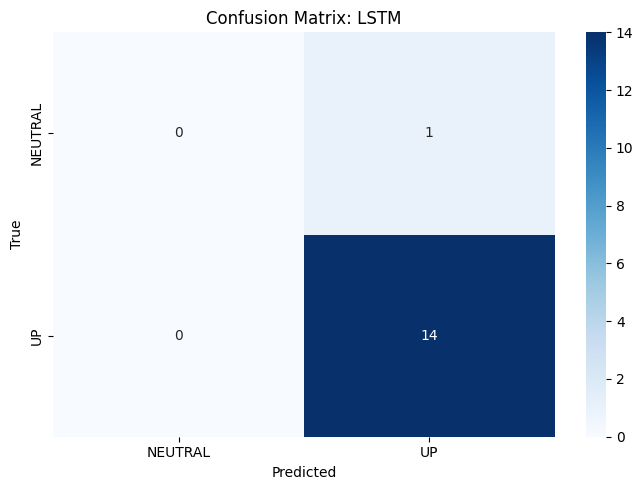

[GMRINFRA] Results DataFrame shape: (15, 26)
[GMRINFRA] Prediction dates: [Timestamp('2024-08-12 00:00:00'), Timestamp('2024-08-13 00:00:00'), Timestamp('2024-08-14 00:00:00'), Timestamp('2024-08-16 00:00:00'), Timestamp('2024-08-19 00:00:00'), Timestamp('2024-08-20 00:00:00'), Timestamp('2024-08-21 00:00:00'), Timestamp('2024-08-22 00:00:00'), Timestamp('2024-08-23 00:00:00'), Timestamp('2024-08-26 00:00:00'), Timestamp('2024-08-27 00:00:00'), Timestamp('2024-08-28 00:00:00'), Timestamp('2024-08-29 00:00:00'), Timestamp('2024-08-30 00:00:00'), Timestamp('2025-07-30 00:00:00')]
Excel report successfully generated: /content/output/GMRINFRA_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/GMRINFRA_results.xlsx
[GMRINFRA] 💾 Saved results to /content/output/GMRINFRA_results.xlsx
✅ Completed processing for GMRINFRA
[ESCORTS] ✅ Set DatetimeIndex. Index range: 2024-07-29 00:00:00 to 2024-08-30 00:00:00
Adding technical indicators... Initial shape: (24, 25)

Epoch 6: val_loss improved from 0.92077 to 0.89997, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0338 - val_accuracy: 1.0000 - val_loss: 0.8683 - learning_rate: 0.0010
Epoch 42/50
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[ESCORTS] ✅ Technical indicators added. Shape: (24, 73), Features: 73
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.1094 - val_accuracy: 1.0000 - val_loss: 0.7837 - learning_rate: 0.0010
Epoch 42/50

Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.8776 - val_accuracy: 1.0000 - val_loss: 0.9000 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 1.0000 - loss: 0.0734
Epoch 42: val_loss improved from 0.86833 to 0.86294, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5

Epoch 7: val_loss improved from 0.89997 to 0.87754, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5



Epoch 42: val_loss improved from 0.78366 to 0.78056, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.9788 - val_accuracy: 1.0000 - val_loss: 0.8775 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0282 - val_accuracy: 1.0000 - val_loss: 0.8629 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0734 - val_accuracy: 1.0000 - val_loss: 0.7806 - learning_rate: 0.0010
Epoch 43/50

Epoch 8: val_loss improved from 0.87754 to 0.86079, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5



Epoch 43: val_loss improved from 0.86294 to 0.85772, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.9208 - val_accuracy: 1.0000 - val_loss: 0.8608 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0330 - val_accuracy: 1.0000 - val_loss: 0.8577 - learning_rate: 0.0010
Epoch 44/50
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0796
Epoch 44: val_loss improved from 0.85772 to 0.85283, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 9: val_loss improved from 0.86079 to 0.83843, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5



Epoch 43: val_loss improved from 0.78056 to 0.77812, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0198 - val_accuracy: 1.0000 - val_loss: 0.8528 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7394 - val_accuracy: 1.0000 - val_loss: 0.8384 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0796 - val_accuracy: 1.0000 - val_loss: 0.7781 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.0669
Epoch 10: val_loss improved from 0.83843 to 0.81403, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5



Epoch 44: val_loss improved from 0.77812 to 0.77597, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.7876 - val_accuracy: 1.0000 - val_loss: 0.8140 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0669 - val_accuracy: 1.0000 - val_loss: 0.7760 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8182 - loss: 0.5506
Epoch 45: val_loss improved from 0.85283 to 0.84781, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 11: val_loss improved from 0.81403 to 0.78935, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5

Epoch 45: val_loss improved from 0.77597 to 0.77412, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0219 - val_accuracy: 1.0000 - val_loss: 0.8478 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1147 - val_accuracy: 1.0000 - val_loss: 0.7741 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5506 - val_accuracy: 1.0000 - val_loss: 0.7893 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.3876
Epoch 12: val_loss improved from 0.78935 to 0.76862, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step - accuracy: 1.0000 - loss: 0.3876 - val_accuracy: 1.0000 - val_loss: 0.7686 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0255
Epoch 13: val_loss improved from 0.76862 to 0.75142, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1645
Epoch 46: val_loss improved from 0.84781 to 0.84456, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 46: val_loss improved from 0.77412 to 0.77221, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.3423 - val_accuracy: 1.0000 - val_loss: 0.7514 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0255 - val_accuracy: 1.0000 - val_loss: 0.8446 - learning_rate: 0.0010
Epoch 47/50

Epoch 14: val_loss improved from 0.75142 to 0.73574, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.1645 - val_accuracy: 1.0000 - val_loss: 0.7722 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.6114 - val_accuracy: 1.0000 - val_loss: 0.7357 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0262
Epoch 15: val_loss improved from 0.73574 to 0.71696, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.9091 - loss: 0.1646
Epoch 47: val_loss improved from 0.84456 to 0.84150, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 47: val_loss improved from 0.77221 to 0.77078, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.6520 - val_accuracy: 1.0000 - val_loss: 0.7170 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0262 - val_accuracy: 1.0000 - val_loss: 0.8415 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1646 - val_accuracy: 1.0000 - val_loss: 0.7708 - learning_rate: 0.0010
Epoch 48/50

Epoch 1: val_loss improved from inf to 1.02605, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.2727 - loss: 2.0173 - val_accuracy: 1.0000 - val_loss: 1.0261 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.4784
Epoch 2: val_loss improved from 1.02605 to 1.01209, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5



Epoch 16: val_loss improved from 0.71696 to 0.70002, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1125
Epoch 48: val_loss improved from 0.84150 to 0.83755, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 48: val_loss improved from 0.77078 to 0.77055, saving model to /content/checkpoints/GAIL/GAIL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.4784 - val_accuracy: 1.0000 - val_loss: 0.7000 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1818 - loss: 1.4583 - val_accuracy: 1.0000 - val_loss: 1.0121 - learning_rate: 0.0010
Epoch 17/50
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0255 - val_accuracy: 1.0000 - val_loss: 0.8376 - learning_rate: 0.0010
Epoch 49/50

Epoch 17: val_loss improved from 0.70002 to 0.68500, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1125 - val_accuracy: 1.0000 - val_loss: 0.7706 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step - accuracy: 0.9091 - loss: 0.3723 - val_accuracy: 1.0000 - val_loss: 0.6850 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6364 - loss: 0.5853
Epoch 18: val_loss improved from 0.68500 to 0.66950, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.6364 - loss: 0.5853 - val_accuracy: 1.0000 - val_loss: 0.6695 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8182 - loss: 0.3310
Epoch 3: val_loss improved from 1.01209 to 0.99382, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5



Epoch 19: val_loss improved from 0.66950 to 0.65643, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0305

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0661
Epoch 49: val_loss improved from 0.83755 to 0.83403, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 49: val_loss did not improve from 0.77055
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.4337 - val_accuracy: 1.0000 - val_loss: 0.9938 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3310 - val_accuracy: 1.0000 - val_loss: 0.6564 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0661 - val_accuracy: 1.0000 - val_loss: 0.7713 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0305 - val_accuracy: 1.0000 - val_loss: 0.8340 - learning_rate: 0.0010
Epoch 50/50

Epoch 4: val_loss improved from 0.99382 to 0.98216, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 1.0000 - loss: 0.0690
Epoch 50: val_loss improved from 0.83403 to 0.83016, saving model to /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5



Epoch 50: val_loss did not improve from 0.77055
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.9429 - val_accuracy: 1.0000 - val_loss: 0.9822 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0235 - val_accuracy: 1.0000 - val_loss: 0.8302 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.

Epoch 5: val_loss improved from 0.98216 to 0.97501, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0690 - val_accuracy: 1.0000 - val_loss: 0.7736 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 48.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3502[APOLLOHOSP] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Epoch 20: val_loss improved from 0.65643 to 0.64210, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5



Prepared 14 samples. Input shape: (14, 10, 52)
[APOLLOHOSP] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[APOLLOHOSP] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 0 0 0 0 2 0 0 0 2 0 1]
[GAIL] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[GAIL] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[GAIL] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 2 2 2 2 2 0 2 2 2 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.8177 - val_accuracy: 1.0000 - val_loss: 0.9750 - learning_rate: 0.0010
Epoch 6/50


[APOLLOHOSP] ✅ Loaded best model from /content/checkpoints/APOLLOHOSP/APOLLOHOSP_lstm_model.h5
[APOLLOHOSP] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6364 - loss: 0.9315

[GAIL] ✅ Loaded best model from /content/checkpoints/GAIL/GAIL_lstm_model.h5
[GAIL] Predicting for 15 dates, including 30-07-2025

Epoch 6: val_loss improved from 0.97501 to 0.96948, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3502 - val_accuracy: 1.0000 - val_loss: 0.6421 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9091 - loss: 0.2925
Epoch 21: val_loss improved from 0.64210 to 0.63180, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


[APOLLOHOSP] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.9315 - val_accuracy: 1.0000 - val_loss: 0.9695 - learning_rate: 0.0010
Epoch 7/50

Classification Report for LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.3636 - loss: 1.1534              precision    recall  f1-score   support

        DOWN       0.80      1.00      0.89        12
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         2

    accuracy                           0.80        15
   macro avg       0.27      0.33      0.30        15
weighted avg       0.64      0.80      0.71        15

[GAIL] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2925 - val_accuracy: 1.0000 - val_loss: 0.6318 - learning_rate: 0.0010
Epoch 22/50

Epoch 7: val_loss improved from 0.96948 to 0.96401, saving model t

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9091 - loss: 0.3398
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         1
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.87      1.00      0.93        13

    accuracy                           0.87        15
   macro avg       0.29      0.33      0.31        15
weighted avg       0.75      0.87      0.80        15


Epoch 22: val_loss improved from 0.63180 to 0.62269, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


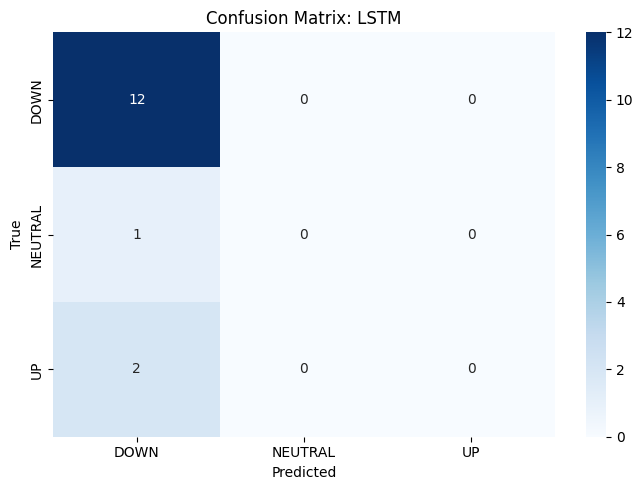

[APOLLOHOSP] Results DataFrame shape: (15, 27)
[APOLLOHOSP] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/APOLLOHOSP_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/APOLLOHOSP_results.xlsx
[APOLLOHOSP] 💾 Saved results to /content/output/APOLLOHOSP_results.xlsx
[EICHERMOT] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for APOLLOHOSP
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[EICHERMOT] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[EICHERMOT] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.1534 - val_accuracy: 1.0000 - val_loss: 0.9640 - learning_rate: 0.0010
Epoch 8/50
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)


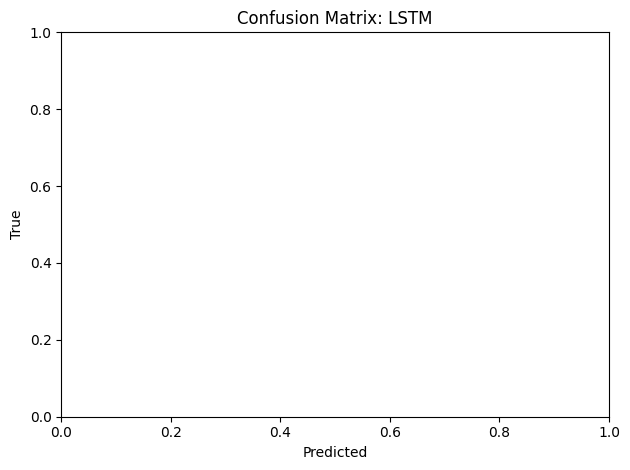

[GAIL] Results DataFrame shape: (15, 27)
[GAIL] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Excel report successfully generated: /content/output/GAIL_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/GAIL_results.xlsx
[GAIL] 💾 Saved results to /content/output/GAIL_results.xlsx
✅ Completed processing for GAIL
[TITAN] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3398 - val_accuracy: 1.0000 - val_loss: 0.6227 - learning_rate: 0.0010
Epoch 23/50
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8182 - loss: 0.4030Epoch 1/50
[TITAN] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[TITAN] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: 

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.8052
Epoch 8: val_loss improved from 0.96401 to 0.95870, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4030 - val_accuracy: 1.0000 - val_loss: 0.6144 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.8052 - val_accuracy: 1.0000 - val_loss: 0.9587 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2828
Epoch 24: val_loss improved from 0.61442 to 0.60799, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.6174
Epoch 9: val_loss improved from 0.95870 to 0.95341, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2828 - val_accuracy: 1.0000 - val_loss: 0.6080 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6174 - val_accuracy: 1.0000 - val_loss: 0.9534 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7273 - loss: 0.6331
Epoch 10: val_loss improved from 0.95341 to 0.94744, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3332
Epoch 25: val_loss improved from 0.60799 to 0.60088, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6331 - val_accuracy: 1.0000 - val_loss: 0.9474 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3332 - val_accuracy: 1.0000 - val_loss: 0.6009 - learning_rate: 0.0010
Epoch 26/50

Epoch 11: val_loss improved from 0.94744 to 0.93663, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6396 - val_accuracy: 1.0000 - val_loss: 0.9366 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2679
Epoch 12: val_loss improved from 0.93663 to 0.92733, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5



Epoch 26: val_loss improved from 0.60088 to 0.59007, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6562 - val_accuracy: 1.0000 - val_loss: 0.9273 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2679 - val_accuracy: 1.0000 - val_loss: 0.5901 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8182 - loss: 0.3272
Epoch 27: val_loss improved from 0.59007 to 0.57996, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3272 - val_accuracy: 1.0000 - val_loss: 0.5800 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9091 - loss: 0.2988
Epoch 13: val_loss improved from 0.92733 to 0.92074, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5



Epoch 28: val_loss improved from 0.57996 to 0.57247, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.3834 - val_accuracy: 1.0000 - val_loss: 0.9207 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2988 - val_accuracy: 1.0000 - val_loss: 0.5725 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.2742
Epoch 14: val_loss improved from 0.92074 to 0.91538, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5



Epoch 29: val_loss improved from 0.57247 to 0.56378, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.5477 - val_accuracy: 1.0000 - val_loss: 0.9154 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.2742 - val_accuracy: 1.0000 - val_loss: 0.5638 - learning_rate: 0.0010
Epoch 30/50

Epoch 1: val_loss improved from inf to 1.10592, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.12008, saving model to /content/checkpoints/TITAN/TITAN_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.4545 - loss: 1.3686 - val_accuracy: 0.0000e+00 - val_loss: 1.1059 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.1818 - loss: 1.6753 - val_accuracy: 0.0000e+00 - val_loss: 1.1201 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3636 - loss: 1.4851
Epoch 2: val_loss did not improve from 1.12008
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.3636 - loss: 1.4851 - val_accuracy: 0.0000e+00 - val_loss: 1.1212 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3636 - loss: 0.9673
Epoch 15: val_loss improved from 0.91538 to 0.90924, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3681
Epoch 3: val_loss improved from 1.12008 to 1.11900, saving model to /content/checkpoints/TITAN/TITAN_lstm_model.h5



Epoch 30: val_loss improved from 0.56378 to 0.55801, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.6016 - val_accuracy: 1.0000 - val_loss: 0.9092 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 0.9673 - val_accuracy: 0.0000e+00 - val_loss: 1.1190 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3681 - val_accuracy: 1.0000 - val_loss: 0.5580 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.6364 - loss: 0.7643
Epoch 16: val_loss improved from 0.90924 to 0.90211, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8182 - loss: 0.3198
Epoch 4: val_loss did not improve from 1.11900

Epoch 31: val_loss improved from 0.55801 to 0.55540, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.7643 - val_accuracy: 0.0000e+00 - val_loss: 1.1235 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4813 - val_accuracy: 1.0000 - val_loss: 0.9021 - learning_rate: 0.0010
Epoch 17/50

Epoch 2: val_loss improved from 1.10592 to 1.09096, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5



Epoch 5: val_loss did not improve from 1.11900
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3198 - val_accuracy: 1.0000 - val_loss: 0.5554 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step - accuracy: 0.6364 - loss: 0.7079 - val_accuracy: 0.0000e+00 - val_loss: 1.1291 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5455 - loss: 0.9898 - val_accuracy: 0.0000e+00 - val_loss: 1.0910 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5455 - loss: 1.1201
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_loss did not improve from 1.11900

Epoch 3: val_loss improved from 1.09096 to 1.06854, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step - accuracy: 0.7273 - loss: 0.5033 - val_accuracy: 0.0000e+00 - val_loss: 1.1287 - learning_rate: 0.0010
Epoch 7/50

Epoch 17: val_loss improved from 0.90211 to 0.89876, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8182 - loss: 0.4361
Epoch 32: val_loss improved from 0.55540 to 0.55323, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5



Epoch 7: val_loss did not improve from 1.11900
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.1201 - val_accuracy: 0.0000e+00 - val_loss: 1.0685 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.4737 - val_accuracy: 1.0000 - val_loss: 0.8988 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4361 - val_accuracy: 0.0000e+00 - val_loss: 1.1273 - learning_rate: 5.0000e-04
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2673 - val_accuracy: 1.0000 - val_loss: 0.5532 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9091 - loss: 0.3631Epoch 33/50

Epoch 8: val_loss did not improve from 1.11900
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9091 - loss: 0.3631 - val_accuracy: 0.0000e+00 - val_loss: 1.1264 - learning_rate: 5.0000e-04
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.


[TITAN] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[TITAN] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[TITAN] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 2 0 0 0 0 0 0 0 2 0 1]
[TITAN] ✅ Loaded best model from /content/checkpoints/TITAN/TITAN_lstm_model.h5
[TITAN] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.6839
Epoch 4: val_loss improved from 1.06854 to 1.05350, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.5634[TITAN] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 18: val_loss improved from 0.89876 to 0.89342, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6839 - val_accuracy: 0.0000e+00 - val_loss: 1.0535 - learning_rate: 0.0010
Epoch 5/50

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00      12.0
     NEUTRAL       0.00      0.00      0.00       1.0
          UP       0.00      0.00      0.00       2.0

    accuracy                           0.00      15.0
   macro avg       0.00      0.00      0.00      15.0
weighted avg       0.00      0.00      0.00      15.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9091 - loss: 0.5140
Epoch 33: val_loss improved from 0.55323 to 0.54797, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5



Epoch 5: val_loss improved from 1.05350 to 1.03522, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5634 - val_accuracy: 1.0000 - val_loss: 0.8934 - learning_rate: 0.0010
Epoch 19/50


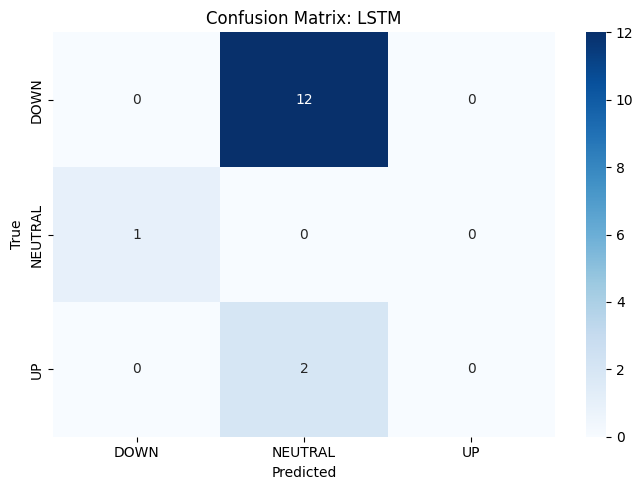

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7273 - loss: 0.4764[TITAN] Results DataFrame shape: (15, 27)
[TITAN] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/TITAN_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/TITAN_results.xlsx
[TITAN] 💾 Saved results to /content/output/TITAN_results.xlsx
[DRREDDY] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for TITAN
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.2708 - val_accuracy: 1.0000 - val_loss: 0.5480 - learning_rate: 0.0010
Epoch 34/50

Epoch 19: val_loss improved from 0.89342 to 0.88715, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[DRREDDY] ✅ Technical indicators added. Shape: (24, 73), Features: 73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9091 - loss: 0.3017[DRREDDY] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.5140 - val_accuracy: 0.0000e+00 - val_loss: 1.0352 - learning_rate: 0.0010
Epoch 6/50
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5455 - loss: 0.7792
Epoch 34: val_loss improved from 0.54797 to 0.54035, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5



✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 6: val_loss improved from 1.03522 to 1.01774, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.4764 - val_accuracy: 1.0000 - val_loss: 0.8871 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3017 - val_accuracy: 1.0000 - val_loss: 0.5404 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.7792 - val_accuracy: 0.0000e+00 - val_loss: 1.0177 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8182 - loss: 0.4919
Epoch 7: val_loss improved from 1.01774 to 1.00105, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step - accuracy: 0.8182 - loss: 0.4919 - val_accuracy: 0.0000e+00 - val_loss: 1.0011 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8182 - loss: 0.4889
Epoch 20: val_loss improved from 0.88715 to 0.87879, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2397
Epoch 8: val_loss improved from 1.00105 to 0.98669, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5



Epoch 35: val_loss improved from 0.54035 to 0.52854, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5580 - val_accuracy: 1.0000 - val_loss: 0.8788 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4889 - val_accuracy: 0.0000e+00 - val_loss: 0.9867 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2397 - val_accuracy: 1.0000 - val_loss: 0.5285 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.4341
Epoch 21: val_loss improved from 0.87879 to 0.87002, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.2465
Epoch 9: val_loss improved from 0.98669 to 0.97166, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5



Epoch 36: val_loss improved from 0.52854 to 0.52055, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.4341 - val_accuracy: 1.0000 - val_loss: 0.8700 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2765 - val_accuracy: 1.0000 - val_loss: 0.9717 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.2465 - val_accuracy: 1.0000 - val_loss: 0.5205 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3830
Epoch 22: val_loss improved from 0.87002 to 0.86084, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1698
Epoch 10: val_loss improved from 0.97166 to 0.95745, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5



Epoch 37: val_loss improved from 0.52055 to 0.51398, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4230 - val_accuracy: 1.0000 - val_loss: 0.8608 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3830 - val_accuracy: 1.0000 - val_loss: 0.9575 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1698 - val_accuracy: 1.0000 - val_loss: 0.5140 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9091 - loss: 0.2703
Epoch 11: val_loss improved from 0.95745 to 0.94219, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.9091 - loss: 0.3116
Epoch 1: val_loss improved from inf to 1.27183, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5



Epoch 23: val_loss improved from 0.86084 to 0.85348, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2703 - val_accuracy: 1.0000 - val_loss: 0.9422 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 1.0000 - loss: 0.1825
Epoch 38: val_loss improved from 0.51398 to 0.50523, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5



Epoch 12: val_loss improved from 0.94219 to 0.92818, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.1818 - loss: 1.5583 - val_accuracy: 0.0000e+00 - val_loss: 1.2718 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3116 - val_accuracy: 1.0000 - val_loss: 0.8535 - learning_rate: 0.0010
Epoch 24/50

Epoch 2: val_loss did not improve from 1.27183
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2143 - val_accuracy: 1.0000 - val_loss: 0.5052 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1825 - val_accuracy: 1.0000 - val_loss: 0.9282 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step - accuracy: 0.3636 - loss: 1.4775 - val_accuracy: 0.0000e+00 - val_loss: 1.2740 - learning_rate: 0.0010
Epoch 3/50

Epoch 13: val_loss improved from 0.92818 to 0.91637, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 1.0000 - loss: 0.2882 - val_accuracy: 1.0000 - val_loss: 0.9164 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 1.0000 - loss: 0.1840
Epoch 24: val_loss improved from 0.85348 to 0.84452, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5



Epoch 3: val_loss did not improve from 1.27183

Epoch 14: val_loss improved from 0.91637 to 0.90511, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1843
Epoch 39: val_loss improved from 0.50523 to 0.49754, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.1860 - val_accuracy: 0.0000e+00 - val_loss: 1.2742 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4989 - val_accuracy: 1.0000 - val_loss: 0.8445 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1840 - val_accuracy: 1.0000 - val_loss: 0.9051 - learning_rate: 0.0010
Epoch 15/50

Epoch 4: val_loss improved from 1.27183 to 1.27023, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5



Epoch 25: val_loss improved from 0.84452 to 0.83536, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1843 - val_accuracy: 1.0000 - val_loss: 0.4975 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9091 - loss: 0.1968
Epoch 40: val_loss improved from 0.49754 to 0.49014, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.0560 - val_accuracy: 0.0000e+00 - val_loss: 1.2702 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3791 - val_accuracy: 1.0000 - val_loss: 0.8354 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1659
Epoch 26: val_loss improved from 0.83536 to 0.82780, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1968 - val_accuracy: 1.0000 - val_loss: 0.4901 - learning_rate: 0.0010
Epoch 41/50

Epoch 5: val_loss improved from 1.27023 to 1.25979, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5



Epoch 15: val_loss improved from 0.90511 to 0.88986, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9091 - loss: 0.2341
Epoch 41: val_loss improved from 0.49014 to 0.48232, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3753 - val_accuracy: 1.0000 - val_loss: 0.8278 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.2453 - val_accuracy: 0.0000e+00 - val_loss: 1.2598 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1659 - val_accuracy: 1.0000 - val_loss: 0.8899 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6364 - loss: 0.7735
Epoch 6: val_loss improved from 1.25979 to 1.24125, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2341 - val_accuracy: 1.0000 - val_loss: 0.4823 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9091 - loss: 0.2190
Epoch 42: val_loss improved from 0.48232 to 0.47686, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step - accuracy: 0.6364 - loss: 0.7735 - val_accuracy: 0.0000e+00 - val_loss: 1.2413 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step - accuracy: 0.9091 - loss: 0.2190 - val_accuracy: 1.0000 - val_loss: 0.4769 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3684
Epoch 43: val_loss improved from 0.47686 to 0.47264, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5



Epoch 27: val_loss improved from 0.82780 to 0.82429, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2989
Epoch 7: val_loss improved from 1.24125 to 1.22617, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5

Epoch 16: val_loss improved from 0.88986 to 0.87542, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3058 - val_accuracy: 1.0000 - val_loss: 0.4726 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.3684 - val_accuracy: 1.0000 - val_loss: 0.8243 - learning_rate: 0.0010
Epoch 28/50

Epoch 44: val_loss improved from 0.47264 to 0.46658, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.9748 - val_accuracy: 0.0000e+00 - val_loss: 1.2262 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2989 - val_accuracy: 1.0000 - val_loss: 0.8754 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9091 - loss: 0.2138
Epoch 8: val_loss improved from 1.22617 to 1.20492, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5



Epoch 17: val_loss improved from 0.87542 to 0.86376, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1418 - val_accuracy: 1.0000 - val_loss: 0.4666 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.8279 - val_accuracy: 0.0000e+00 - val_loss: 1.2049 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2138 - val_accuracy: 1.0000 - val_loss: 0.8638 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8182 - loss: 0.5776
Epoch 45: val_loss improved from 0.46658 to 0.46194, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 0.1647
Epoch 28: val_loss improved from 0.82429 to 0.82381, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5



Epoch 9: val_loss improved from 1.20492 to 1.18524, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5



Epoch 18: val_loss improved from 0.86376 to 0.85372, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1262 - val_accuracy: 1.0000 - val_loss: 0.4619 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.4667 - val_accuracy: 1.0000 - val_loss: 0.8238 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5776 - val_accuracy: 0.0000e+00 - val_loss: 1.1852 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1647 - val_accuracy: 1.0000 - val_loss: 0.8537 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8182 - loss: 0.5098
Epoch 29: val_loss improved from 0.82381 to 0.82354, saving model to /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5



Epoch 10: val_loss improved from 1.18524 to 1.16724, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step - accuracy: 0.7273 - loss: 0.4772 - val_accuracy: 1.0000 - val_loss: 0.8235 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step - accuracy: 0.8182 - loss: 0.5098 - val_accuracy: 0.0000e+00 - val_loss: 1.1672 - learning_rate: 0.0010
Epoch 11/50

Epoch 46: val_loss improved from 0.46194 to 0.45489, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1862 - val_accuracy: 1.0000 - val_loss: 0.4549 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.6364 - loss: 0.7428
Epoch 30: val_loss did not improve from 0.82354

Epoch 19: val_loss improved from 0.85372 to 0.84341, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5



Epoch 11: val_loss improved from 1.16724 to 1.15029, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4470 - val_accuracy: 1.0000 - val_loss: 0.8244 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9091 - loss: 0.2773
Epoch 47: val_loss improved from 0.45489 to 0.44913, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0876 - val_accuracy: 1.0000 - val_loss: 0.8434 - learning_rate: 0.0010
Epoch 20/50

Epoch 31: val_loss did not improve from 0.82354
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7428 - val_accuracy: 0.0000e+00 - val_loss: 1.1503 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8182 - loss: 0.7625
Epoch 20: val_loss improved from 0.84341 to 0.83573, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5



Epoch 12: val_loss improved from 1.15029 to 1.13619, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2773 - val_accuracy: 1.0000 - val_loss: 0.8250 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1462 - val_accuracy: 1.0000 - val_loss: 0.4491 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1346 - val_accuracy: 1.0000 - val_loss: 0.8357 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.7625 - val_accuracy: 0.0000e+00 - val_loss: 1.1362 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7273 - loss: 0.5723
Epoch 13: val_loss improved from 1.13619 to 1.12718, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.7273 - loss: 0.5723 - val_accuracy: 0.0000e+00 - val_loss: 1.1272 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7273 - loss: 0.6708
Epoch 14: val_loss improved from 1.12718 to 1.11886, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.5671
Epoch 48: val_loss improved from 0.44913 to 0.44875, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5



Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 32: val_loss did not improve from 0.82354
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step - accuracy: 0.7273 - loss: 0.6708 - val_accuracy: 0.0000e+00 - val_loss: 1.1189 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1160
Epoch 21: val_loss improved from 0.83573 to 0.82822, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5671 - val_accuracy: 1.0000 - val_loss: 0.8249 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1399 - val_accuracy: 1.0000 - val_loss: 0.4487 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8182 - loss: 0.5457
Epoch 15: val_loss improved from 1.11886 to 1.11017, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5



Epoch 49: val_loss improved from 0.44875 to 0.44864, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1160 - val_accuracy: 1.0000 - val_loss: 0.8282 - learning_rate: 0.0010
Epoch 22/50

Epoch 33: val_loss did not improve from 0.82354
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 1.0000 - loss: 0.0726
Epoch 22: val_loss improved from 0.82822 to 0.81992, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7430 - val_accuracy: 0.0000e+00 - val_loss: 1.1102 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5457 - val_accuracy: 1.0000 - val_loss: 0.8237 - learning_rate: 5.0000e-04
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0705 - val_accuracy: 1.0000 - val_loss: 0.4486 - learning_rate: 0.0010
Epoch 50/50

Epoch 34: val_loss did not improve from 0.82354
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0726 - val_accuracy: 1.0000 - val_loss: 0.8199 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step - accuracy: 0.8182 - loss: 0.3889 - val_accuracy: 1.0000 - val_loss: 0.8237 - learning_rate: 5.0000e-04
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 29.
[ESCORTS] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Uniq


Epoch 23: val_loss improved from 0.81992 to 0.80799, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


[ESCORTS] ✅ Loaded best model from /content/checkpoints/ESCORTS/ESCORTS_lstm_model.h5
[ESCORTS] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1061
Epoch 16: val_loss improved from 1.11017 to 1.10182, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0951 - val_accuracy: 1.0000 - val_loss: 0.8080 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 0.0719
Epoch 50: val_loss improved from 0.44864 to 0.44724, saving model to /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5



Epoch 24: val_loss improved from 0.80799 to 0.79765, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


[ESCORTS] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.5425 - val_accuracy: 0.0000e+00 - val_loss: 1.1018 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7273 - loss: 0.5221
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.67      1.00      0.80        10
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         4

    accuracy                           0.67        15
   macro avg       0.22      0.33      0.27        15
weighted avg       0.44      0.67      0.53        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1061 - val_accuracy: 1.0000 - val_loss: 0.4472 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0719 - val_accuracy: 1.00

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 0.1041
Epoch 25: val_loss improved from 0.79765 to 0.78801, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


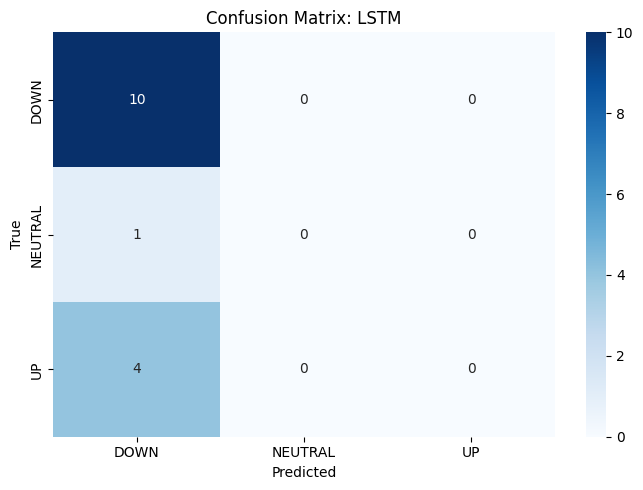

[ESCORTS] Results DataFrame shape: (15, 27)
[ESCORTS] Prediction dates: [Timestamp('2024-08-12 00:00:00'), Timestamp('2024-08-13 00:00:00'), Timestamp('2024-08-14 00:00:00'), Timestamp('2024-08-16 00:00:00'), Timestamp('2024-08-19 00:00:00'), Timestamp('2024-08-20 00:00:00'), Timestamp('2024-08-21 00:00:00'), Timestamp('2024-08-22 00:00:00'), Timestamp('2024-08-23 00:00:00'), Timestamp('2024-08-26 00:00:00'), Timestamp('2024-08-27 00:00:00'), Timestamp('2024-08-28 00:00:00'), Timestamp('2024-08-29 00:00:00'), Timestamp('2024-08-30 00:00:00'), Timestamp('2025-07-30 00:00:00')]
Excel report successfully generated: /content/output/ESCORTS_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/ESCORTS_results.xlsx
[ESCORTS] 💾 Saved results to /content/output/ESCORTS_results.xlsx
✅ Completed processing for ESCORTS
[DLF] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[DLF] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[DLF] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5221 - val_accuracy: 0.0000e+00 - val_loss: 1.0949 - learning_rate: 0.0010
Epoch 18/50
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8182 - loss: 0.5445[FEDERALBNK] ✅ LS

Model: "LSTM_Model"

Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[FEDERALBNK] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}

Epoch 18: val_loss improved from 1.09485 to 1.08911, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1041 - val_accuracy: 1.0000 - val_loss: 0.7880 - learning_rate: 0.0010
Epoch 26/50
[FEDERALBNK] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 0 2 0 2 2 2 2 2 2 2 2 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9091 - loss: 0.1347Epoch 1/50


[FEDERALBNK] ✅ Loaded best model from /content/checkpoints/FEDERALBNK/FEDERALBNK_lstm_model.h5
[FEDERALBNK] Predicting for 15 dates, including 30-07-2025

Epoch 26: val_loss improved from 0.78801 to 0.77774, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5445 - val_accuracy: 0.0000e+00 - val_loss: 1.0891 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1347 - val_accuracy: 1.0000 - val_loss: 0.7777 - learning_rate: 0.0010
Epoch 27/50
[FEDERALBNK] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         2
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.80      1.00      0.89        12

    accuracy                           0.80        15
   macro avg       0.27      0.33      0.30        15
weighted avg       0.64      0.80      0.71        15



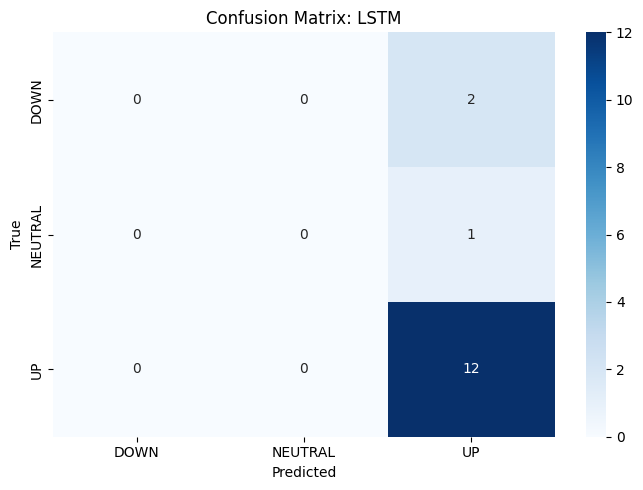

[FEDERALBNK] Results DataFrame shape: (15, 27)
[FEDERALBNK] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.4251Excel report successfully generated: /content/output/FEDERALBNK_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/FEDERALBNK_results.xlsx
[FEDERALBNK] 💾 Saved results to /content/output/FEDERALBNK_results.xlsx
[DIVISLAB] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for FEDERALBNK
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[DIVISLAB] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[DIVISLAB] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

Epoch 19: val_loss improved from 1.08911 to 1.08383, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0476
✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50

Epoch 27: val_loss improved from 0.77774 to 0.76790, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.4251 - val_accuracy: 0.0000e+00 - val_loss: 1.0838 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7273 - loss: 0.6466
Epoch 20: val_loss improved from 1.08383 to 1.07850, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0476 - val_accuracy: 1.0000 - val_loss: 0.7679 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 0.0451
Epoch 28: val_loss improved from 0.76790 to 0.75745, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6466 - val_accuracy: 0.0000e+00 - val_loss: 1.0785 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7273 - loss: 0.5304
Epoch 21: val_loss improved from 1.07850 to 1.07561, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0451 - val_accuracy: 1.0000 - val_loss: 0.7575 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5304 - val_accuracy: 0.0000e+00 - val_loss: 1.0756 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 1.0000 - loss: 0.0405
Epoch 22: val_loss improved from 1.07561 to 1.07186, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5



Epoch 29: val_loss improved from 0.75745 to 0.74769, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5167 - val_accuracy: 0.0000e+00 - val_loss: 1.0719 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0405 - val_accuracy: 1.0000 - val_loss: 0.7477 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - loss: 0.0366
Epoch 30: val_loss improved from 0.74769 to 0.73843, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0366 - val_accuracy: 1.0000 - val_loss: 0.7384 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0310
Epoch 23: val_loss improved from 1.07186 to 1.06840, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5



Epoch 31: val_loss improved from 0.73843 to 0.72739, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.4687 - val_accuracy: 0.0000e+00 - val_loss: 1.0684 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0310 - val_accuracy: 1.0000 - val_loss: 0.7274 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0841
Epoch 24: val_loss improved from 1.06840 to 1.06485, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5



Epoch 32: val_loss improved from 0.72739 to 0.71466, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4883 - val_accuracy: 0.0000e+00 - val_loss: 1.0648 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0841 - val_accuracy: 1.0000 - val_loss: 0.7147 - learning_rate: 0.0010
Epoch 33/50

Epoch 1: val_loss improved from inf to 0.99293, saving model to /content/checkpoints/DLF/DLF_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.2727 - loss: 1.3770 - val_accuracy: 1.0000 - val_loss: 0.9929 - learning_rate: 0.0010
Epoch 2/50

Epoch 25: val_loss improved from 1.06485 to 1.06213, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.1818 - loss: 1.6346
Epoch 33: val_loss improved from 0.71466 to 0.70248, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.5039 - val_accuracy: 0.0000e+00 - val_loss: 1.0621 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0348 - val_accuracy: 1.0000 - val_loss: 0.7025 - learning_rate: 0.0010
Epoch 34/50

Epoch 26: val_loss improved from 1.06213 to 1.05999, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 1.0000 - loss: 0.0432
Epoch 34: val_loss improved from 0.70248 to 0.69189, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.04699, saving model to /content/checkpoints/DIVISLAB/DIVISLAB_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4175 - val_accuracy: 0.0000e+00 - val_loss: 1.0600 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0432 - val_accuracy: 1.0000 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 35/50

Epoch 27: val_loss improved from 1.05999 to 1.05726, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0773
Epoch 2: val_loss did not improve from 0.99293

Epoch 35: val_loss improved from 0.69189 to 0.68091, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.1818 - loss: 1.6346 - val_accuracy: 1.0000 - val_loss: 1.0470 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4545 - loss: 1.4312 - val_accuracy: 1.0000 - val_loss: 0.9947 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4649 - val_accuracy: 0.0000e+00 - val_loss: 1.0573 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0773 - val_accuracy: 1.0000 - val_loss: 0.6809 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.4545 - loss: 1.1995
Epoch 3: val_loss improved from 0.99293 to 0.97272, saving model to /content/checkpoints/DLF/DLF_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9091 - loss: 0.1417
Epoch 36: val_loss improved from 0.68091 to 0.67134, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step - accuracy: 0.4545 - loss: 1.1995 - val_accuracy: 1.0000 - val_loss: 0.9727 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6364 - loss: 1.0668
Epoch 4: val_loss improved from 0.97272 to 0.96843, saving model to /content/checkpoints/DLF/DLF_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1417 - val_accuracy: 1.0000 - val_loss: 0.6713 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.4049
Epoch 37: val_loss improved from 0.67134 to 0.66137, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5



Epoch 28: val_loss improved from 1.05726 to 1.05547, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 1.0668 - val_accuracy: 1.0000 - val_loss: 0.9684 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5455 - loss: 0.8188
Epoch 2: val_loss did not improve from 1.04699

Epoch 5: val_loss improved from 0.96843 to 0.96355, saving model to /content/checkpoints/DLF/DLF_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0594 - val_accuracy: 1.0000 - val_loss: 0.6614 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.4049 - val_accuracy: 0.0000e+00 - val_loss: 1.0555 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 1.0000 - loss: 0.0374
Epoch 38: val_loss improved from 0.66137 to 0.65204, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5455 - loss: 0.9906 - val_accuracy: 1.0000 - val_loss: 1.0654 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.8188 - val_accuracy: 1.0000 - val_loss: 0.9635 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step - accuracy: 1.0000 - loss: 0.0374 - val_accuracy: 1.0000 - val_loss: 0.6520 - learning_rate: 0.0010
Epoch 39/50

Epoch 6: val_loss improved from 0.96355 to 0.95007, saving model to /content/checkpoints/DLF/DLF_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step - accuracy: 0.6364 - loss: 0.8112 - val_accuracy: 1.0000 - val_loss: 0.9501 - learning_rate: 0.0010
Epoch 7/50

Epoch 29: val_loss improved from 1.05547 to 1.05444, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7273 - loss: 1.0325
Epoch 39: val_loss improved from 0.65204 to 0.64374, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5



Epoch 7: val_loss improved from 0.95007 to 0.94289, saving model to /content/checkpoints/DLF/DLF_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.7931
Epoch 3: val_loss did not improve from 1.04699
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5144 - val_accuracy: 0.0000e+00 - val_loss: 1.0544 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0676 - val_accuracy: 1.0000 - val_loss: 0.6437 - learning_rate: 0.0010
Epoch 40/50

Epoch 30: val_loss improved from 1.05444 to 1.05341, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 1.0325 - val_accuracy: 1.0000 - val_loss: 0.9429 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.7931 - val_accuracy: 1.0000 - val_loss: 1.0700 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9091 - loss: 0.6079
Epoch 40: val_loss improved from 0.64374 to 0.63348, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.04699
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4827 - val_accuracy: 0.0000e+00 - val_loss: 1.0534 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0488 - val_accuracy: 1.0000 - val_loss: 0.6335 - learning_rate: 0.0010
Epoch 41/50

Epoch 31: val_loss improved from 1.05341 to 1.05148, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.6079 - val_accuracy: 1.0000 - val_loss: 1.0650 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.7273 - loss: 0.5865
Epoch 8: val_loss did not improve from 0.94289

Epoch 41: val_loss improved from 0.63348 to 0.62348, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5



Epoch 5: val_loss did not improve from 1.04699
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.3287 - val_accuracy: 0.0000e+00 - val_loss: 1.0515 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7890 - val_accuracy: 1.0000 - val_loss: 0.9483 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5865 - val_accuracy: 1.0000 - val_loss: 1.0595 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0468 - val_accuracy: 1.0000 - val_loss: 0.6235 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8182 - loss: 0.5803
Epoch 6: val_loss did not improve from 1.04699
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.8182 - loss: 0.5803 - val_accuracy: 1.0000 - val_loss: 1.0545 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


[DIVISLAB] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[DIVISLAB] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[DIVISLAB] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 0 0 0 0 0 0 0 0 2 0 1]
[DIVISLAB] ✅ Loaded best model from /content/checkpoints/DIVISLAB/DIVISLAB_lstm_model.h5
[DIVISLAB] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.4573
Epoch 32: val_loss improved from 1.05148 to 1.04831, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5


[DIVISLAB] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.8035
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.87      1.00      0.93        13
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         1

    accuracy                           0.87        15
   macro avg       0.29      0.33      0.31        15
weighted avg       0.75      0.87      0.80        15


Epoch 9: val_loss did not improve from 0.94289

Epoch 42: val_loss improved from 0.62348 to 0.61658, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.4573 - val_accuracy: 0.0000e+00 - val_loss: 1.0483 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.8035 - val_accuracy: 1.0000 - val_loss: 0.9617 - learning_rate: 0.0010
Epoch 10/50


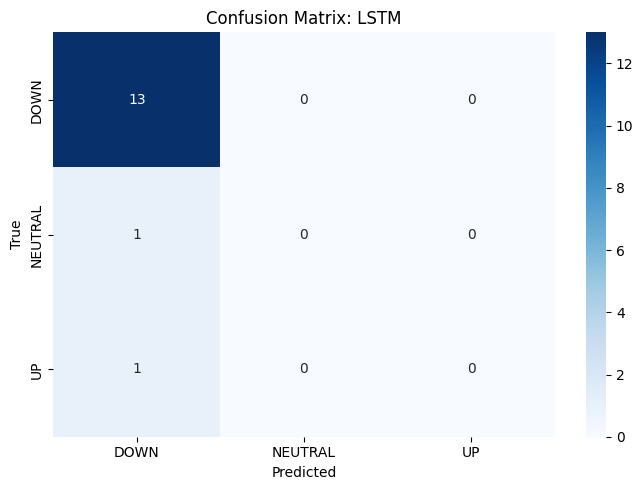

[DIVISLAB] Results DataFrame shape: (15, 27)
Epoch 33: val_loss improved from 1.04831 to 1.04560, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5



[DIVISLAB] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/DIVISLAB_results.xlsx


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8182 - loss: 0.5715

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/DIVISLAB_results.xlsx
[DIVISLAB] 💾 Saved results to /content/output/DIVISLAB_results.xlsx
[DABUR] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for DIVISLAB
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0318 - val_accuracy: 1.0000 - val_loss: 0.6166 - learning_rate: 0.0010
Epoch 43/50
Technical indicators successfully added. Shape: (24, 70), Features: 70

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: val_loss did not improve from 0.94289
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[DABUR] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[DABUR] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Pre

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3931 - val_accuracy: 0.0000e+00 - val_loss: 1.0456 - learning_rate: 0.0010
Epoch 34/50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5715 - val_accuracy: 1.0000 - val_loss: 0.9745 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6364 - loss: 0.8216
Epoch 11: val_loss did not improve from 0.94289
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 1.0000 - loss: 0.0651
Epoch 43: val_loss improved from 0.61658 to 0.60833, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step - accuracy: 0.6364 - loss: 0.8216 - val_accuracy: 0.0000e+00 - val_loss: 0.9796 - learning_rate: 5.0000e-04
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.5093
Epoch 12: val_loss did not improve from 0.94289

Epoch 34: val_loss improved from 1.04560 to 1.04415, saving model to /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0651 - val_accuracy: 1.0000 - val_loss: 0.6083 - learning_rate: 0.0010


Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5267 - val_accuracy: 0.0000e+00 - val_loss: 0.9858 - learning_rate: 5.0000e-04
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
[DLF] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[DLF] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[DLF] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 2 2 0 2 0 2 0 0 2 2 0 2 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.5093 - val_accuracy: 0.0000e+00 - val_loss: 1.0442 - learning_rate: 0.0010
Epoch 35/50


[DLF] ✅ Loaded best model from /content/checkpoints/DLF/DLF_lstm_model.h5
[DLF] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0265
Epoch 35: val_loss did not improve from 1.04415

Epoch 44: val_loss improved from 0.60833 to 0.60040, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.4310 - val_accuracy: 0.0000e+00 - val_loss: 1.0471 - learning_rate: 0.0010
Epoch 36/50
[DLF] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0265 - val_accuracy: 1.0000 - val_loss: 0.6004 - learning_rate: 0.0010
Epoch 45/50

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.50      1.00      0.67         6
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.67      0.25      0.36         8

    accuracy                           0.53        15
   macro avg       0.39      0.42      0.34        15
weighted avg       0.56      0.53      0.46        15



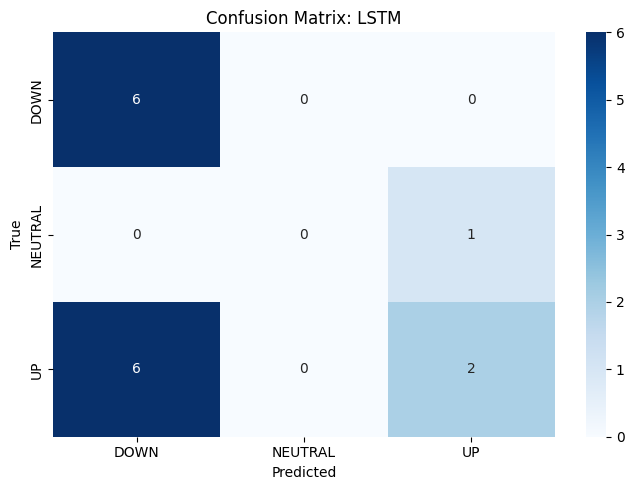

[DLF] Results DataFrame shape: (15, 27)
[DLF] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/DLF_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/DLF_results.xlsx
[DLF] 💾 Saved results to /content/output/DLF_results.xlsx
[TORNTPHARM] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for DLF
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[TORNTPHARM] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[TORNTPHARM] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.5119Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0425
Epoch 36: val_loss did not improve from 1.04415

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 45: val_loss improved from 0.60040 to 0.59092, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5119 - val_accuracy: 0.0000e+00 - val_loss: 1.0494 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8182 - loss: 0.4178
Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 37: val_loss did not improve from 1.04415
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0425 - val_accuracy: 1.0000 - val_loss: 0.5909 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4178 - val_accuracy: 0.0000e+00 - val_loss: 1.0519 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9091 - loss: 0.2304
Epoch 38: val_loss did not improve from 1.04415
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0350
Epoch 46: val_loss improved from 0.59092 to 0.58303, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2304 - val_accuracy: 0.0000e+00 - val_loss: 1.0532 - learning_rate: 5.0000e-04
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8182 - loss: 0.4197
Epoch 39: val_loss did not improve from 1.04415
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0350 - val_accuracy: 1.0000 - val_loss: 0.5830 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4197 - val_accuracy: 0.0000e+00 - val_loss: 1.0552 - learning_rate: 5.0000e-04
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 34.
[DRREDDY] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[DRREDDY] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[DRREDDY] Added sequence for 30-07-2025 prediction. X_future shape: (

[DRREDDY] ✅ Loaded best model from /content/checkpoints/DRREDDY/DRREDDY_lstm_model.h5
[DRREDDY] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0459
Epoch 47: val_loss improved from 0.58303 to 0.57883, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


[DRREDDY] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0459 - val_accuracy: 1.0000 - val_loss: 0.5788 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 0.0243
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.20      0.25      0.22         4
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.70      0.70      0.70        10

    accuracy                           0.53        15
   macro avg       0.30      0.32      0.31        15
weighted avg       0.52      0.53      0.53        15


Epoch 48: val_loss improved from 0.57883 to 0.57526, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.0909 - loss: 1.5548

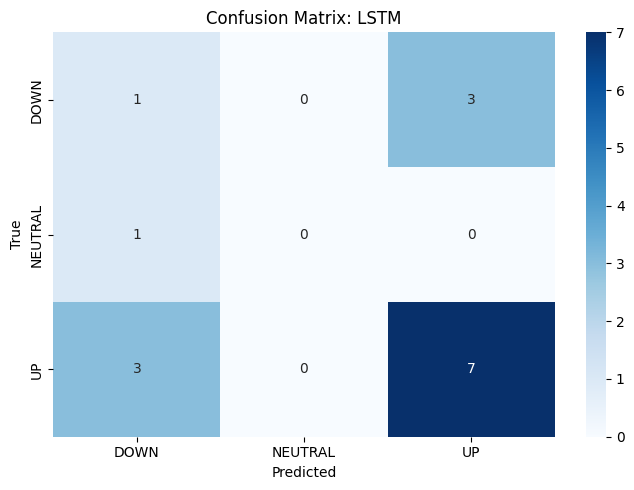

[DRREDDY] Results DataFrame shape: (15, 27)
[DRREDDY] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/DRREDDY_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/DRREDDY_results.xlsx
[DRREDDY] 💾 Saved results to /content/output/DRREDDY_results.xlsx
✅ Completed processing for DRREDDY
[CUMMINSIND] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[CUMMINSIND] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[CUMMINSIND] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0243 - val_accuracy: 1.0000 - val_loss: 0.5753 - learning_rate: 0.0010
Epoch 49/50
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0148
Epoch 1: val_loss improved from inf to 1.11231, saving model to /content/checkpoints/DABUR/DABUR_lstm_model.h5



Epoch 49: val_loss improved from 0.57526 to 0.57113, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 1.0000 - loss: 0.0148 - val_accuracy: 1.0000 - val_loss: 0.5711 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 1.0000 - loss: 0.0233
Epoch 50: val_loss improved from 0.57113 to 0.56711, saving model to /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.0909 - loss: 1.5548 - val_accuracy: 0.0000e+00 - val_loss: 1.1123 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0233 - val_accuracy: 1.0000 - val_loss: 0.5671 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.1818 - loss: 1.6613[EICHERMOT] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[EICHERMOT] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[EICHERMOT] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


[EICHERMOT] ✅ Loaded best model from /content/checkpoints/EICHERMOT/EICHERMOT_lstm_model.h5
[EICHERMOT] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3636 - loss: 1.1018
Epoch 2: val_loss improved from 1.11231 to 1.10604, saving model to /content/checkpoints/DABUR/DABUR_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.04132, saving model to /content/checkpoints/TORNTPHARM/TORNTPHARM_lstm_model.h5


[EICHERMOT] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.3636 - loss: 1.1018 - val_accuracy: 0.0000e+00 - val_loss: 1.1060 - learning_rate: 0.0010
Epoch 3/50

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.87      1.00      0.93        13
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         1

    accuracy                           0.87        15
   macro avg       0.29      0.33      0.31        15
weighted avg       0.75      0.87      0.80        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.4545 - loss: 1.3297
Epoch 3: val_loss improved from 1.10604 to 1.10241, saving model to /content/checkpoints/DABUR/DABUR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.1818 - loss: 1.6613 - val_accuracy: 1.0000 - val_loss: 1.0413 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.2727 - loss: 1.9746

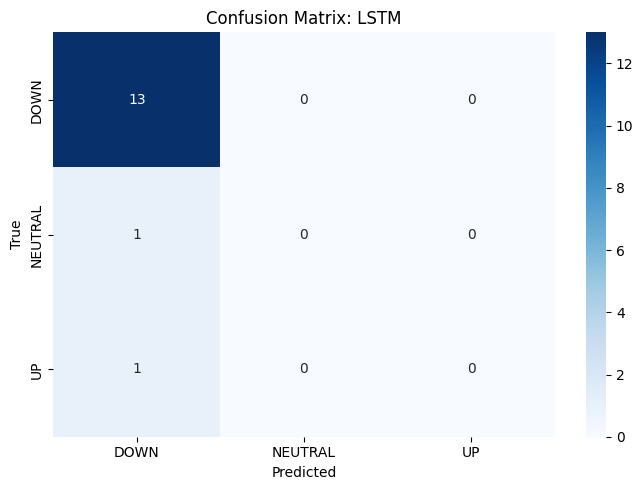


Epoch 2: val_loss did not improve from 1.04132
[EICHERMOT] Results DataFrame shape: (15, 27)
[EICHERMOT] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/EICHERMOT_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/EICHERMOT_results.xlsx
[EICHERMOT] 💾 Saved results to /content/output/EICHERMOT_results.xlsx
✅ Completed processing for EICHERMOT
[CONCOR] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[CONCOR] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[CONCOR] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.3297 - val_accuracy: 0.0000e+00 - val_loss: 1.1024 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.9746 - v

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.5455 - loss: 1.2653Epoch 1/50

Epoch 3: val_loss did not improve from 1.04132
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.2653 - val_accuracy: 0.0000e+00 - val_loss: 1.0808 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss improved from 1.10241 to 1.09101, saving model to /content/checkpoints/DABUR/DABUR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.4545 - loss: 1.0763
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 1.04132
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.2197 - val_accuracy: 0.0000e+00 - val_loss: 1.0910 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.0763 - val_accuracy: 0.0000e+00 - val_loss: 1.1006 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5455 - loss: 1.0278
Epoch 5: val_loss improved from 1.09101 to 1.07770, saving model to /content/checkpoints/DABUR/DABUR_lstm_model.h5



Epoch 5: val_loss did not improve from 1.04132
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.0278 - val_accuracy: 0.0000e+00 - val_loss: 1.1017 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.3303 - val_accuracy: 0.0000e+00 - val_loss: 1.0777 - learning_rate: 0.0010
Epoch 6/50

Epoch 6: val_loss did not improve from 1.04132
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.1366 - val_accuracy: 0.0000e+00 - val_loss: 1.1019 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 6: val_loss improved from 1.07770 to 1.06146, saving model to /content/checkpoints/DABUR/DABUR_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.09538, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5


[TORNTPHARM] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[TORNTPHARM] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[TORNTPHARM] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 0 2 0 0 0 2 0 2 0 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4545 - loss: 1.0732 - val_accuracy: 0.0000e+00 - val_loss: 1.0615 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6364 - loss: 0.8816

[TORNTPHARM] ✅ Loaded best model from /content/checkpoints/TORNTPHARM/TORNTPHARM_lstm_model.h5
[TORNTPHARM] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.4545 - loss: 1.4756 - val_accuracy: 0.0000e+00 - val_loss: 1.0954 - learning_rate: 0.0010
Epoch 2/50

Epoch 7: val_loss improved from 1.06146 to 1.04514, saving model to /content/checkpoints/DABUR/DABUR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.1818 - loss: 1.9587
Epoch 2: val_loss improved from 1.09538 to 1.05148, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.8816 - val_accuracy: 1.0000 - val_loss: 1.0451 - learning_rate: 0.0010
Epoch 8/50
[TORNTPHARM] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1818 - loss: 1.9587 - val_accuracy: 1.0000 - val_loss: 1.0515 - learning_rate: 0.0010
Epoch 3/50

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00        11
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.21      1.00      0.35         3

    accuracy                           0.20        15
   macro avg       0.07      0.33      0.12        15
weighted avg       0.04      0.20      0.07        15



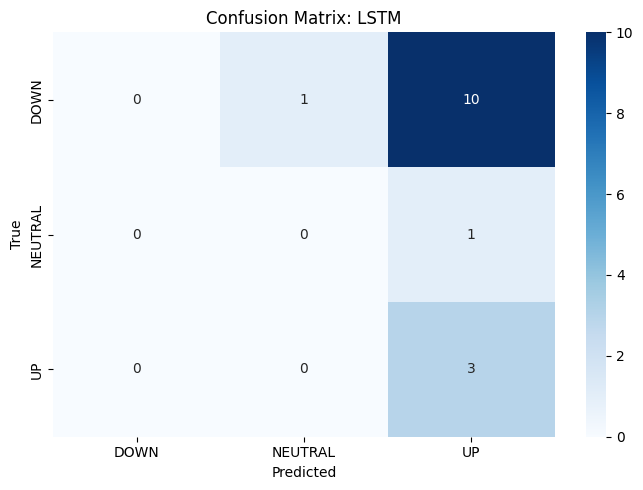

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.4545 - loss: 1.0139[TORNTPHARM] Results DataFrame shape: (15, 27)
[TORNTPHARM] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/TORNTPHARM_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/TORNTPHARM_results.xlsx
[TORNTPHARM] 💾 Saved results to /content/output/TORNTPHARM_results.xlsx
[COLPAL] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for TORNTPHARM
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[COLPAL] ✅ Technical indicators added. Shape: (24, 73), Features: 73

Epoch 8: val_loss improved from 1.04514 to 1.01769, saving model to /content/checkpoints/DABUR/DABUR_lstm_model.h5


[COLPAL] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3636 - loss: 1.0552
✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 3: val_loss improved from 1.05148 to 1.03279, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 1.0139 - val_accuracy: 1.0000 - val_loss: 1.0177 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.0552 - val_accuracy: 1.0000 - val_loss: 1.0328 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5455 - loss: 0.8748
Epoch 4: val_loss improved from 1.03279 to 1.01388, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.5572
Epoch 9: val_loss improved from 1.01769 to 0.99389, saving model to /content/checkpoints/DABUR/DABUR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.8748 - val_accuracy: 1.0000 - val_loss: 1.0139 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.5572 - val_accuracy: 1.0000 - val_loss: 0.9939 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9091 - loss: 0.5082
Epoch 10: val_loss improved from 0.99389 to 0.98188, saving model to /content/checkpoints/DABUR/DABUR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.9374
Epoch 5: val_loss improved from 1.01388 to 0.98026, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.5082 - val_accuracy: 1.0000 - val_loss: 0.9819 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.9374 - val_accuracy: 1.0000 - val_loss: 0.9803 - learning_rate: 0.0010
Epoch 6/50

Epoch 1: val_loss improved from inf to 1.15785, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.0000e+00 - loss: 1.3271 - val_accuracy: 0.0000e+00 - val_loss: 1.1578 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.4446
Epoch 11: val_loss improved from 0.98188 to 0.97001, saving model to /content/checkpoints/DABUR/DABUR_lstm_model.h5



Epoch 2: val_loss improved from 1.15785 to 1.13325, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.6936
Epoch 6: val_loss improved from 0.98026 to 0.95062, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.4446 - val_accuracy: 1.0000 - val_loss: 0.9700 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.3315 - val_accuracy: 0.0000e+00 - val_loss: 1.1333 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.6936 - val_accuracy: 1.0000 - val_loss: 0.9506 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4545 - loss: 1.0250
Epoch 7: val_loss improved from 0.95062 to 0.92441, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step - accuracy: 0.4545 - loss: 1.0250 - val_accuracy: 1.0000 - val_loss: 0.9244 - learning_rate: 0.0010
Epoch 8/50

Epoch 3: val_loss improved from 1.13325 to 1.10604, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5



Epoch 12: val_loss improved from 0.97001 to 0.96289, saving model to /content/checkpoints/DABUR/DABUR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9091 - loss: 0.5382
Epoch 8: val_loss improved from 0.92441 to 0.90181, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5455 - loss: 0.9183 - val_accuracy: 0.0000e+00 - val_loss: 1.1060 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.5064 - val_accuracy: 1.0000 - val_loss: 0.9629 - learning_rate: 0.0010
Epoch 13/50

Epoch 4: val_loss improved from 1.10604 to 1.07356, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.5382 - val_accuracy: 1.0000 - val_loss: 0.9018 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step - accuracy: 0.3636 - loss: 0.8646 - val_accuracy: 0.0000e+00 - val_loss: 1.0736 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6364 - loss: 0.9810
Epoch 5: val_loss improved from 1.07356 to 1.03405, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.3636 - loss: 1.4824
Epoch 13: val_loss improved from 0.96289 to 0.95418, saving model to /content/checkpoints/DABUR/DABUR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.6379
Epoch 9: val_loss improved from 0.90181 to 0.88273, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.9810 - val_accuracy: 0.0000e+00 - val_loss: 1.0341 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.4655 - val_accuracy: 1.0000 - val_loss: 0.9542 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.6379 - val_accuracy: 1.0000 - val_loss: 0.8827 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8182 - loss: 0.5351
Epoch 10: val_loss improved from 0.88273 to 0.86926, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.08821, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - accuracy: 0.8182 - loss: 0.5758
Epoch 6: val_loss improved from 1.03405 to 0.99192, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step - accuracy: 0.8182 - loss: 0.5351 - val_accuracy: 1.0000 - val_loss: 0.8693 - learning_rate: 0.0010
Epoch 11/50

Epoch 14: val_loss improved from 0.95418 to 0.95024, saving model to /content/checkpoints/DABUR/DABUR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.3636 - loss: 1.4824 - val_accuracy: 0.0000e+00 - val_loss: 1.0882 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5455 - loss: 1.2232
Epoch 11: val_loss improved from 0.86926 to 0.85631, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5



Epoch 2: val_loss improved from 1.08821 to 1.07955, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.8803 - val_accuracy: 0.0000e+00 - val_loss: 0.9919 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5758 - val_accuracy: 1.0000 - val_loss: 0.9502 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.7916 - val_accuracy: 1.0000 - val_loss: 0.8563 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.2232 - val_accuracy: 0.0000e+00 - val_loss: 1.0795 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.3636 - loss: 1.2757
Epoch 3: val_loss improved from 1.07955 to 1.06943, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.6529
Epoch 7: val_loss improved from 0.99192 to 0.96066, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step - accuracy: 0.3636 - loss: 1.2757 - val_accuracy: 0.0000e+00 - val_loss: 1.0694 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5455 - loss: 1.0534
Epoch 15: val_loss did not improve from 0.95024

Epoch 4: val_loss improved from 1.06943 to 1.06311, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6529 - val_accuracy: 1.0000 - val_loss: 0.9607 - learning_rate: 0.0010
Epoch 8/50

Epoch 12: val_loss improved from 0.85631 to 0.84411, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.6923 - val_accuracy: 1.0000 - val_loss: 0.9505 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9091 - loss: 0.4209
Epoch 8: val_loss improved from 0.96066 to 0.93384, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 1.0534 - val_accuracy: 0.0000e+00 - val_loss: 1.0631 - learning_rate: 0.0010
Epoch 5/50

Epoch 16: val_loss did not improve from 0.95024
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.5157 - val_accuracy: 1.0000 - val_loss: 0.8441 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.8192 - val_accuracy: 1.0000 - val_loss: 0.9338 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step - accuracy: 0.9091 - loss: 0.4209 - val_accuracy: 1.0000 - val_loss: 0.9552 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5455 - loss: 0.9874
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: val_loss did not improve from 0.95024

Epoch 9: val_loss improved from 0.93384 to 0.92568, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step - accuracy: 0.9091 - loss: 0.3878 - val_accuracy: 1.0000 - val_loss: 0.9629 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step - accuracy: 0.5455 - loss: 0.9874 - val_accuracy: 1.0000 - val_loss: 0.9257 - learning_rate: 0.0010
Epoch 10/50

Epoch 18: val_loss did not improve from 0.95024

Epoch 5: val_loss improved from 1.06311 to 1.04896, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6364 - loss: 0.8770
Epoch 13: val_loss improved from 0.84411 to 0.83040, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5



Epoch 10: val_loss improved from 0.92568 to 0.91952, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4837 - val_accuracy: 1.0000 - val_loss: 0.9725 - learning_rate: 5.0000e-04
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.7797 - val_accuracy: 0.0000e+00 - val_loss: 1.0490 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6364 - loss: 0.8591
Epoch 19: val_loss did not improve from 0.95024
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.5525 - val_accuracy: 1.0000 - val_loss: 0.8304 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.8770 - val_accuracy: 1.0000 - val_loss: 0.9195 - learning_rate: 0.0010
Epoch 11/50

Epoch 6: val_loss improved from 1.04896 to 1.03048, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step - accuracy: 1.0000 - loss: 0.3725 - val_accuracy: 1.0000 - val_loss: 0.9830 - learning_rate: 5.0000e-04
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 14.
[DABUR] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[DABUR] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[DABUR] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 0 2 2 2 0 2 2 0 2 2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step - accuracy: 0.6364 - loss: 0.8591 - val_accuracy: 1.0000 - val_loss: 1.0305 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7273 - loss: 0.7494

[DABUR] ✅ Loaded best model from /content/checkpoints/DABUR/DABUR_lstm_model.h5
[DABUR] Predicting for 15 dates, including 30-07-2025

Epoch 7: val_loss improved from 1.03048 to 1.01566, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.6280
Epoch 14: val_loss improved from 0.83040 to 0.82123, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5



Epoch 11: val_loss improved from 0.91952 to 0.91484, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.7494 - val_accuracy: 1.0000 - val_loss: 1.0157 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7273 - loss: 0.9321
Epoch 8: val_loss improved from 1.01566 to 1.00939, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


[DABUR] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3959 - val_accuracy: 1.0000 - val_loss: 0.8212 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.6280 - val_accuracy: 1.0000 - val_loss: 0.9148 - learning_rate: 0.0010
Epoch 12/50

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.30      1.00      0.46         3
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.80      0.36      0.50        11

    accuracy                           0.47        15
   macro avg       0.37      0.45      0.32        15
weighted avg       0.65      0.47      0.46        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9091 - loss: 0.3434
Epoch 15: val_loss improved from 0.82123 to 0.81308, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.9321 - val_accuracy: 1.0000 - val_loss: 1.0094 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6364 - loss: 0.6581

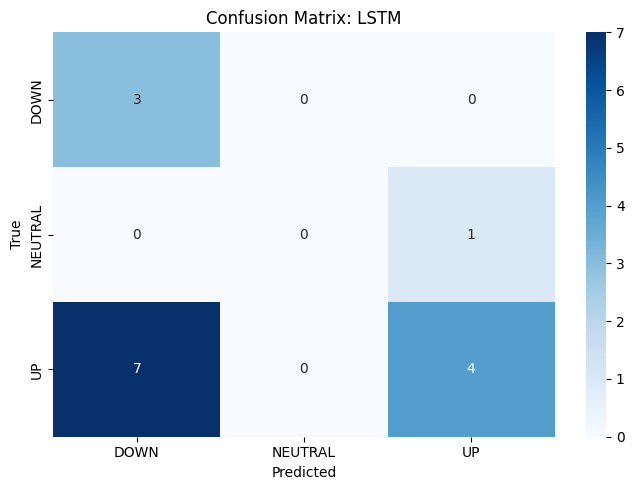

[DABUR] Results DataFrame shape: (15, 27)
[DABUR] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/DABUR_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/DABUR_results.xlsx
[DABUR] 💾 Saved results to /content/output/DABUR_results.xlsx
[TVSMOTOR] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for DABUR

Epoch 9: val_loss improved from 1.00939 to 0.99625, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[TVSMOTOR] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[TVSMOTOR] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3434 - val_accuracy: 1.0000 - val_loss: 0.8131 - learning_rate: 0.0010
Epoch 16/50
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9091 - loss: 0.2928
✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)


Epoch 12: val_loss improved from 0.91484 to 0.91069, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5



Epoch 16: val_loss improved from 0.81308 to 0.80342, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.6581 - val_accuracy: 1.0000 - val_loss: 0.9962 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.8097 - val_accuracy: 1.0000 - val_loss: 0.9107 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2928 - val_accuracy: 1.0000 - val_loss: 0.8034 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7273 - loss: 0.8417
Epoch 13: val_loss improved from 0.91069 to 0.90905, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.7800
Epoch 10: val_loss improved from 0.99625 to 0.97544, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.8417 - val_accuracy: 1.0000 - val_loss: 0.9091 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6364 - loss: 0.6671
Epoch 17: val_loss improved from 0.80342 to 0.79548, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.7800 - val_accuracy: 1.0000 - val_loss: 0.9754 - learning_rate: 0.0010
Epoch 11/50

Epoch 14: val_loss improved from 0.90905 to 0.90580, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6364 - loss: 0.6497
Epoch 11: val_loss improved from 0.97544 to 0.95637, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4182 - val_accuracy: 1.0000 - val_loss: 0.7955 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.6671 - val_accuracy: 1.0000 - val_loss: 0.9058 - learning_rate: 0.0010
Epoch 15/50

Epoch 18: val_loss improved from 0.79548 to 0.78953, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.6497 - val_accuracy: 1.0000 - val_loss: 0.9564 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6364 - loss: 0.5923
Epoch 12: val_loss improved from 0.95637 to 0.93605, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3260 - val_accuracy: 1.0000 - val_loss: 0.7895 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.7303
Epoch 19: val_loss improved from 0.78953 to 0.78751, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5



Epoch 15: val_loss improved from 0.90580 to 0.89271, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.5923 - val_accuracy: 1.0000 - val_loss: 0.9360 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8182 - loss: 0.4421
Epoch 13: val_loss improved from 0.93605 to 0.91553, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3525 - val_accuracy: 1.0000 - val_loss: 0.7875 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.7303 - val_accuracy: 1.0000 - val_loss: 0.8927 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8182 - loss: 0.3796
Epoch 20: val_loss improved from 0.78751 to 0.78391, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4421 - val_accuracy: 1.0000 - val_loss: 0.9155 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step - accuracy: 0.8182 - loss: 0.3796 - val_accuracy: 1.0000 - val_loss: 0.7839 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 1.0000 - loss: 0.2283
Epoch 16: val_loss improved from 0.89271 to 0.88278, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5



Epoch 21: val_loss improved from 0.78391 to 0.78108, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4244
Epoch 14: val_loss improved from 0.91553 to 0.89627, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6370 - val_accuracy: 1.0000 - val_loss: 0.8828 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2283 - val_accuracy: 1.0000 - val_loss: 0.7811 - learning_rate: 0.0010
Epoch 22/50

Epoch 17: val_loss improved from 0.88278 to 0.87230, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4244 - val_accuracy: 1.0000 - val_loss: 0.8963 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6047 - val_accuracy: 1.0000 - val_loss: 0.8723 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2284
Epoch 18: val_loss improved from 0.87230 to 0.85796, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5



Epoch 22: val_loss improved from 0.78108 to 0.78072, saving model to /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4486
Epoch 15: val_loss improved from 0.89627 to 0.87911, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.6792 - val_accuracy: 1.0000 - val_loss: 0.8580 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2284 - val_accuracy: 1.0000 - val_loss: 0.7807 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4486 - val_accuracy: 1.0000 - val_loss: 0.8791 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8182 - loss: 0.4995
Epoch 16: val_loss improved from 0.87911 to 0.86144, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5



Epoch 1: val_loss improved from inf to 0.96635, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step - accuracy: 0.8182 - loss: 0.4995 - val_accuracy: 1.0000 - val_loss: 0.8614 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1570
Epoch 19: val_loss improved from 0.85796 to 0.84844, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5



Epoch 23: val_loss did not improve from 0.78072

Epoch 17: val_loss improved from 0.86144 to 0.84449, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.5455 - loss: 1.1082 - val_accuracy: 1.0000 - val_loss: 0.9664 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1570 - val_accuracy: 1.0000 - val_loss: 0.7815 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5455 - loss: 0.7587 - val_accuracy: 1.0000 - val_loss: 0.8484 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4578 - val_accuracy: 1.0000 - val_loss: 0.8445 - learning_rate: 0.0010
Epoch 18/50

Epoch 24: val_loss did not improve from 0.78072
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step - accuracy: 1.0000 - loss: 0.1721 - val_accuracy: 1.0000 - val_loss: 0.7822 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9091 - loss: 0.3060
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 25: val_loss did not improve from 0.78072
1/1 ━━━━


Epoch 18: val_loss improved from 0.84449 to 0.83026, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step - accuracy: 0.9091 - loss: 0.2989 - val_accuracy: 1.0000 - val_loss: 0.7811 - learning_rate: 5.0000e-04
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4545 - loss: 1.0451
Epoch 27: val_loss did not improve from 0.78072
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4083 - val_accuracy: 1.0000 - val_loss: 0.8403 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.6372 - val_accuracy: 1.0000 - val_loss: 0.8303 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9091 - loss: 0.5871
Epoch 2: val_loss improved from 0.96635 to 0.96301, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5



Epoch 19: val_loss improved from 0.83026 to 0.81517, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step - accuracy: 0.9091 - loss: 0.3043 - val_accuracy: 1.0000 - val_loss: 0.7813 - learning_rate: 5.0000e-04
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 22.
[CUMMINSIND] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[CUMMINSIND] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[CUMMINSIND] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 2 0 0 0 0 0 2 0 0 0 0 0 0 1]


[CUMMINSIND] ✅ Loaded best model from /content/checkpoints/CUMMINSIND/CUMMINSIND_lstm_model.h5
[CUMMINSIND] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4545 - loss: 1.0451 - val_accuracy: 1.0000 - val_loss: 0.9630 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.5871 - val_accuracy: 1.0000 - val_loss: 0.8152 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5455 - loss: 0.7781Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.5834
Epoch 3: val_loss did not improve from 0.96301

Epoch 20: val_loss improved from 0.81517 to 0.80265, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5



Epoch 21: val_loss improved from 0.84026 to 0.82854, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.7781 - val_accuracy: 1.0000 - val_loss: 0.9671 - learning_rate: 0.0010
Epoch 4/50
[CUMMINSIND] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6255 - val_accuracy: 1.0000 - val_loss: 0.8027 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.5834 - val_accuracy: 1.0000 - val_loss: 0.8285 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9091 - loss: 0.3295
Epoch 4: val_loss improved from 0.96301 to 0.96124, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.80      1.00      0.89        12
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         2

    accuracy                           0.80        15
   macro avg       0.27      0.33      0.30        15
weighted avg       0.64      0.80      0.71        15


Epoch 21: val_loss improved from 0.80265 to 0.79535, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


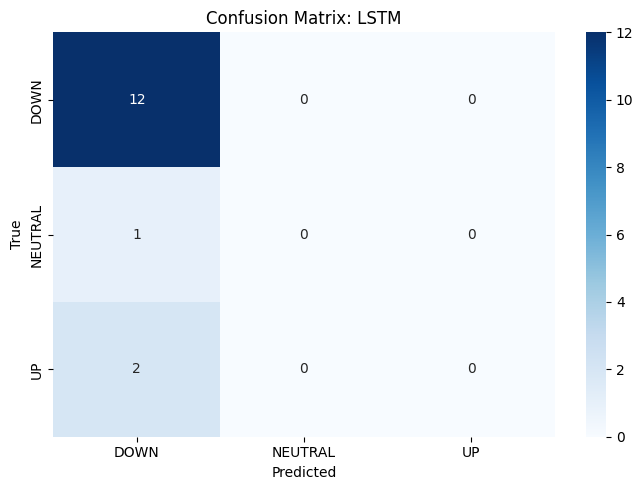

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5995 - val_accuracy: 1.0000 - val_loss: 0.9612 - learning_rate: 0.0010
Epoch 5/50
[CUMMINSIND] Results DataFrame shape: (15, 27)
[CUMMINSIND] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8182 - loss: 0.4395Excel report successfully generated: /content/output/CUMMINSIND_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/CUMMINSIND_results.xlsx
[CUMMINSIND] 💾 Saved results to /content/output/CUMMINSIND_results.xlsx
[EXIDEIND] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for CUMMINSIND
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3295 - val_accuracy: 1.0000 - val_loss: 0.7953 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8182 - loss: 0.3665Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[EXIDEIND] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[EXIDEIND] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 0.6843
Epoch 5: val

Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 22: val_loss improved from 0.79535 to 0.78953, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5



Epoch 22: val_loss improved from 0.82854 to 0.82027, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5



✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4395 - val_accuracy: 1.0000 - val_loss: 0.9564 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3665 - val_accuracy: 1.0000 - val_loss: 0.7895 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.6843 - val_accuracy: 1.0000 - val_loss: 0.8203 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6364 - loss: 0.5554
Epoch 6: val_loss improved from 0.95636 to 0.95132, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5



Epoch 23: val_loss improved from 0.82027 to 0.81448, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5



Epoch 23: val_loss improved from 0.78953 to 0.78193, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5040 - val_accuracy: 1.0000 - val_loss: 0.9513 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.5554 - val_accuracy: 1.0000 - val_loss: 0.8145 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4027 - val_accuracy: 1.0000 - val_loss: 0.7819 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.5455 - loss: 0.7894
Epoch 24: val_loss improved from 0.78193 to 0.77096, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5



Epoch 24: val_loss improved from 0.81448 to 0.80790, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4492 - val_accuracy: 1.0000 - val_loss: 0.7710 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.7894 - val_accuracy: 1.0000 - val_loss: 0.8079 - learning_rate: 0.0010
Epoch 25/50

Epoch 7: val_loss improved from 0.95132 to 0.94341, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8182 - loss: 0.3881
Epoch 25: val_loss improved from 0.77096 to 0.76176, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4954 - val_accuracy: 1.0000 - val_loss: 0.9434 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3881 - val_accuracy: 1.0000 - val_loss: 0.7618 - learning_rate: 0.0010
Epoch 26/50

Epoch 8: val_loss improved from 0.94341 to 0.93513, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9091 - loss: 0.4343
Epoch 25: val_loss improved from 0.80790 to 0.80323, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5

Epoch 26: val_loss improved from 0.76176 to 0.75258, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3568 - val_accuracy: 1.0000 - val_loss: 0.9351 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.4343 - val_accuracy: 1.0000 - val_loss: 0.7526 - learning_rate: 0.0010

Epoch 9: val_loss improved from 0.93513 to 0.92430, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5
Epoch 27/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.5947 - val_accuracy: 1.0000 - val_loss: 0.8032 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8182 - loss: 0.4809
Epoch 26: val_loss improved from 0.80323 to 0.80115, saving model to /content/checkpoints/CONCOR/CONCOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.4706 - val_accuracy: 1.0000 - val_loss: 0.9243 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8182 - loss: 0.3499
Epoch 27: val_loss improved from 0.75258 to 0.74337, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5



Epoch 10: val_loss improved from 0.92430 to 0.91096, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.4809 - val_accuracy: 1.0000 - val_loss: 0.8012 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2646 - val_accuracy: 1.0000 - val_loss: 0.7434 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3499 - val_accuracy: 1.0000 - val_loss: 0.9110 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9091 - loss: 0.2726
Epoch 28: val_loss improved from 0.74337 to 0.73564, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.6244
Epoch 27: val_loss did not improve from 0.80115
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2726 - val_accuracy: 1.0000 - val_loss: 0.7356 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6244 - val_accuracy: 1.0000 - val_loss: 0.8037 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3657
Epoch 28: val_loss did not improve from 0.80115

Epoch 11: val_loss improved from 0.91096 to 0.89924, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5



Epoch 29: val_loss improved from 0.73564 to 0.72991, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4725 - val_accuracy: 1.0000 - val_loss: 0.8074 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3594 - val_accuracy: 1.0000 - val_loss: 0.7299 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.3657 - val_accuracy: 1.0000 - val_loss: 0.8992 - learning_rate: 0.0010
Epoch 12/50

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 29: val_loss did not improve from 0.80115
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step - accuracy: 0.4545 - loss: 0.6830 - val_accuracy: 1.0000 - val_loss: 0.8092 - learning_rate: 0.0010
Epoch 30/50

Epoch 1: val_loss improved from inf to 1.16798, saving model to /content/checkpoints/EXIDEIND/EXIDEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.2651
Epoch 30: val_loss did not improve from 0.80115

Epoch 30: val_loss improved from 0.72991 to 0.72359, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5



Epoch 12: val_loss improved from 0.89924 to 0.88923, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.7273 - loss: 0.7227 - val_accuracy: 0.0000e+00 - val_loss: 1.1680 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6364 - loss: 0.6704
Epoch 2: val_loss improved from 1.16798 to 1.16345, saving model to /content/checkpoints/EXIDEIND/EXIDEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 0.7068 - val_accuracy: 1.0000 - val_loss: 0.8105 - learning_rate: 5.0000e-04
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2248 - val_accuracy: 1.0000 - val_loss: 0.7236 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2651 - val_accuracy: 1.0000 - val_loss: 0.8892 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9091 - loss: 0.2644
Epoch 31: val_loss improved from 0.72359 to 0.71301, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.6704 - val_accuracy: 0.0000e+00 - val_loss: 1.1635 - learning_rate: 0.0010
Epoch 3/50

Epoch 13: val_loss improved from 0.88923 to 0.87897, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7273 - loss: 0.5699
Epoch 3: val_loss improved from 1.16345 to 1.13611, saving model to /content/checkpoints/EXIDEIND/EXIDEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.3317 - val_accuracy: 1.0000 - val_loss: 0.7130 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2644 - val_accuracy: 1.0000 - val_loss: 0.8790 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8182 - loss: 0.3718
Epoch 31: val_loss did not improve from 0.80115

Epoch 14: val_loss improved from 0.87897 to 0.86814, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5



Epoch 32: val_loss improved from 0.71301 to 0.70289, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5699 - val_accuracy: 0.0000e+00 - val_loss: 1.1361 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 0.6570 - val_accuracy: 1.0000 - val_loss: 0.8110 - learning_rate: 5.0000e-04
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.

Epoch 4: val_loss improved from 1.13611 to 1.11168, saving model to /content/checkpoints/EXIDEIND/EXIDEIND_lstm_model.h5


[CONCOR] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[CONCOR] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[CONCOR] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 2 2 0 2 0 2 2 0 2 2 2 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2711 - val_accuracy: 1.0000 - val_loss: 0.8681 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3718 - val_accuracy: 1.0000 - val_loss: 0.7029 - learning_rate: 0.0010
Epoch 33/50


[CONCOR] ✅ Loaded best model from /content/checkpoints/CONCOR/CONCOR_lstm_model.h5
[CONCOR] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.3540 - val_accuracy: 0.0000e+00 - val_loss: 1.1117 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7273 - loss: 0.5682
Epoch 5: val_loss improved from 1.11168 to 1.09726, saving model to /content/checkpoints/EXIDEIND/EXIDEIND_lstm_model.h5


[CONCOR] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step - accuracy: 0.7273 - loss: 0.5682 - val_accuracy: 0.0000e+00 - val_loss: 1.0973 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9091 - loss: 0.4324
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         5
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.60      1.00      0.75         9

    accuracy                           0.60        15
   macro avg       0.20      0.33      0.25        15
weighted avg       0.36      0.60      0.45        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.3288
Epoch 6: val_loss improved from 1.09726 to 1.08429, saving model to /content/checkpoints/EXIDEIND/EXIDEIND_lstm_model.h5



Epoch 15: val_loss improved from 0.86814 to 0.85814, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5



Epoch 33: val_loss improved from 0.70289 to 0.69191, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


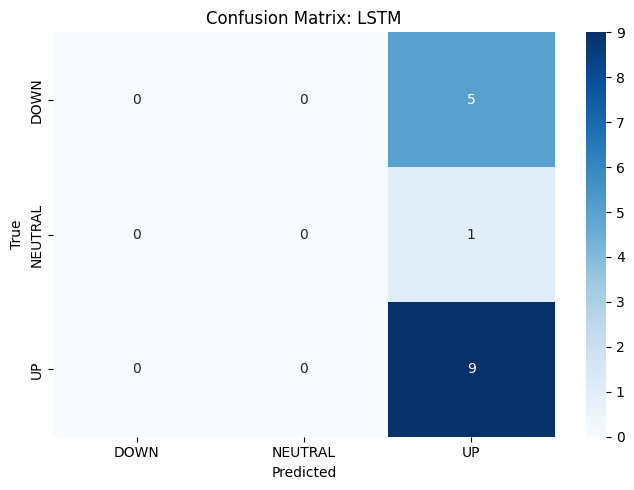

[CONCOR] Results DataFrame shape: (15, 27)
[CONCOR] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/CONCOR_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/CONCOR_results.xlsx
[CONCOR] 💾 Saved results to /content/output/CONCOR_results.xlsx
[RAMCOCEM] ✅ Set DatetimeIndex. Index range: 2024-07-29 00:00:00 to 2024-08-30 00:00:00
✅ Completed processing for CONCOR
Adding technical indicators... Initial shape: (24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4324 - val_accuracy: 0.0000e+00 - val_loss: 1.0843 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.2632 - val_accuracy: 1.0000 - val_loss: 0.8581 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8182 - loss: 0.3822Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.3288 - val_accuracy: 1.0000 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 34/50
[RAMCOCEM] ✅ Technical i


Epoch 16: val_loss improved from 0.85814 to 0.84712, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5



✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3822 - val_accuracy: 0.0000e+00 - val_loss: 1.0756 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1751 - val_accuracy: 1.0000 - val_loss: 0.8471 - learning_rate: 0.0010
Epoch 17/50

Epoch 34: val_loss improved from 0.69191 to 0.68003, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3287 - val_accuracy: 1.0000 - val_loss: 0.6800 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9091 - loss: 0.2441
Epoch 35: val_loss improved from 0.68003 to 0.66993, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1028
Epoch 8: val_loss improved from 1.07560 to 1.06470, saving model to /content/checkpoints/EXIDEIND/EXIDEIND_lstm_model.h5



Epoch 17: val_loss improved from 0.84712 to 0.83365, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2441 - val_accuracy: 1.0000 - val_loss: 0.6699 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1927 - val_accuracy: 1.0000 - val_loss: 1.0647 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1028 - val_accuracy: 1.0000 - val_loss: 0.8336 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3184
Epoch 36: val_loss improved from 0.66993 to 0.65910, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1935
Epoch 9: val_loss improved from 1.06470 to 1.05700, saving model to /content/checkpoints/EXIDEIND/EXIDEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3184 - val_accuracy: 1.0000 - val_loss: 0.6591 - learning_rate: 0.0010
Epoch 37/50

Epoch 18: val_loss improved from 0.83365 to 0.81676, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 1.0000 - loss: 0.1854
Epoch 37: val_loss improved from 0.65910 to 0.64764, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2779 - val_accuracy: 1.0000 - val_loss: 1.0570 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.1935 - val_accuracy: 1.0000 - val_loss: 0.8168 - learning_rate: 0.0010
Epoch 19/50

Epoch 10: val_loss improved from 1.05700 to 1.05363, saving model to /content/checkpoints/EXIDEIND/EXIDEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1854 - val_accuracy: 1.0000 - val_loss: 0.6476 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 0.1667
Epoch 38: val_loss improved from 0.64764 to 0.63609, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5881 - val_accuracy: 1.0000 - val_loss: 1.0536 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8182 - loss: 0.2691
Epoch 19: val_loss improved from 0.81676 to 0.80129, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5



Epoch 11: val_loss improved from 1.05363 to 1.05098, saving model to /content/checkpoints/EXIDEIND/EXIDEIND_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1667 - val_accuracy: 1.0000 - val_loss: 0.6361 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8182 - loss: 0.3538
Epoch 39: val_loss improved from 0.63609 to 0.62587, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1435 - val_accuracy: 1.0000 - val_loss: 0.8013 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.2691 - val_accuracy: 1.0000 - val_loss: 1.0510 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.3538 - val_accuracy: 1.0000 - val_loss: 0.6259 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.2072
Epoch 40: val_loss improved from 0.62587 to 0.61669, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step - accuracy: 1.0000 - loss: 0.2072 - val_accuracy: 1.0000 - val_loss: 0.6167 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8182 - loss: 0.3152
Epoch 20: val_loss improved from 0.80129 to 0.78627, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5



Epoch 12: val_loss improved from 1.05098 to 1.04990, saving model to /content/checkpoints/EXIDEIND/EXIDEIND_lstm_model.h5



Epoch 41: val_loss improved from 0.61669 to 0.60742, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2898 - val_accuracy: 1.0000 - val_loss: 1.0499 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1704 - val_accuracy: 1.0000 - val_loss: 0.7863 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3152 - val_accuracy: 1.0000 - val_loss: 0.6074 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9091 - loss: 0.2218
Epoch 42: val_loss improved from 0.60742 to 0.59677, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5



Epoch 1: val_loss improved from inf to 0.93312, saving model to /content/checkpoints/RAMCOCEM/RAMCOCEM_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step - accuracy: 0.9091 - loss: 0.2218 - val_accuracy: 1.0000 - val_loss: 0.5968 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9091 - loss: 0.2220
Epoch 43: val_loss improved from 0.59677 to 0.58638, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.5455 - loss: 1.0267 - val_accuracy: 1.0000 - val_loss: 0.9331 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4545 - loss: 1.0139
Epoch 21: val_loss improved from 0.78627 to 0.77264, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5



Epoch 13: val_loss did not improve from 1.04990

Epoch 2: val_loss did not improve from 0.93312
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2220 - val_accuracy: 1.0000 - val_loss: 0.5864 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3127 - val_accuracy: 1.0000 - val_loss: 1.0515 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.0139 - val_accuracy: 1.0000 - val_loss: 0.9509 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1500 - val_accuracy: 1.0000 - val_loss: 0.7726 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4545 - loss: 0.8068
Epoch 3: val_loss did not improve from 0.93312
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.4545 - loss: 0.8068 - val_accuracy: 1.0000 - val_loss: 0.9731 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - ac

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.3600
Epoch 14: val_loss did not improve from 1.04990

Epoch 22: val_loss improved from 0.77264 to 0.76022, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 0.8647 - val_accuracy: 1.0000 - val_loss: 0.9938 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2050 - val_accuracy: 1.0000 - val_loss: 0.5737 - learning_rate: 0.0010

Epoch 5: val_loss did not improve from 0.93312
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.3600 - val_accuracy: 1.0000 - val_loss: 1.0554 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1543 - val_accuracy: 1.0000 - val_loss: 0.7602 - learning_rate: 0.0010
Epoch 23/50

Epoch 45: val_loss improved from 0.57366 to 0.56301, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.8707 - val_accuracy: 1.0000 - val_loss: 1.0055 - learning_rate: 5.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step - accuracy: 0.9091 - loss: 0.1692 - val_accuracy: 1.0000 - val_loss: 0.5630 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.5455 - loss: 0.7828
Epoch 6: val_loss did not improve from 0.93312
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step - accuracy: 0.5455 - loss: 0.7828 - val_accuracy: 0.0000e+00 - val_loss: 1.0182 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 1.0000 - loss: 0.1157
Epoch 23: val_loss improved from 0.76022 to 0.74865, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


[RAMCOCEM] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: val_loss did not improve from 1.04990
[RAMCOCEM] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 2 2 0 0 2 2 0 2 0 0 2 0 0 1]



Epoch 46: val_loss improved from 0.56301 to 0.55224, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


[RAMCOCEM] ✅ Loaded best model from /content/checkpoints/RAMCOCEM/RAMCOCEM_lstm_model.h5
[RAMCOCEM] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1958 - val_accuracy: 1.0000 - val_loss: 1.0532 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1449 - val_accuracy: 1.0000 - val_loss: 0.7487 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.8182 - loss: 0.5944
Epoch 24: val_loss improved from 0.74865 to 0.73836, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5



Epoch 16: val_loss did not improve from 1.04990
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1157 - val_accuracy: 1.0000 - val_loss: 0.5522 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5944 - val_accuracy: 1.0000 - val_loss: 1.0532 - learning_rate: 5.0000e-04
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1253 - val_accuracy: 1.0000 - val_loss: 0.7384 - learning_rate: 0.0010
Epoch 25/50
[RAMCOCEM] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.1221
Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         8
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.40      1.00      0.57         6

    accuracy                           0.40        15
   macro avg       0.13      0.33      0.19       

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 987ms/step - accuracy: 1.0000 - loss: 0.1773
Epoch 17: val_loss did not improve from 1.04990

Epoch 47: val_loss improved from 0.55224 to 0.54351, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


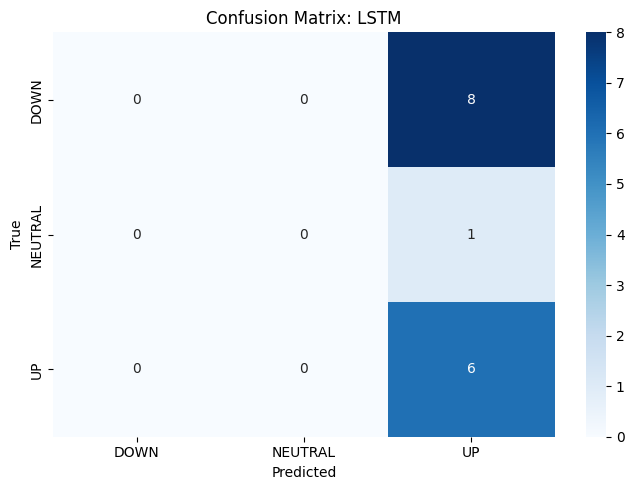

[RAMCOCEM] Results DataFrame shape: (15, 27)
[RAMCOCEM] Prediction dates: [Timestamp('2024-08-12 00:00:00'), Timestamp('2024-08-13 00:00:00'), Timestamp('2024-08-14 00:00:00'), Timestamp('2024-08-16 00:00:00'), Timestamp('2024-08-19 00:00:00'), Timestamp('2024-08-20 00:00:00'), Timestamp('2024-08-21 00:00:00'), Timestamp('2024-08-22 00:00:00'), Timestamp('2024-08-23 00:00:00'), Timestamp('2024-08-26 00:00:00'), Timestamp('2024-08-27 00:00:00'), Timestamp('2024-08-28 00:00:00'), Timestamp('2024-08-29 00:00:00'), Timestamp('2024-08-30 00:00:00'), Timestamp('2025-07-30 00:00:00')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1221 - val_accuracy: 1.0000 - val_loss: 0.7277 - learning_rate: 0.0010
Epoch 26/50
Excel report successfully generated: /content/output/RAMCOCEM_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/RAMCOCEM_results.xlsx
[RAMCOCEM] 💾 Saved results to /content/output/RAMCOCEM_results.xlsx
[ASIANPAINT] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for RAMCOCEM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 0.1111Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[ASIANPAINT] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[ASIANPAINT] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.3517 - val_accuracy: 1.0000 - val_loss: 1.0502 - learning_rate: 5.0000e-04
Epoc

[EXIDEIND] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[EXIDEIND] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[EXIDEIND] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 2 2 2 2 2 0 2 2 0 2 2 2 2 1]

✅ Built model: LSTM_Model | Output classes: 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1773 - val_accuracy: 1.0000 - val_loss: 0.5435 - learning_rate: 0.0010
Epoch 48/50


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50


[EXIDEIND] ✅ Loaded best model from /content/checkpoints/EXIDEIND/EXIDEIND_lstm_model.h5
[EXIDEIND] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1111 - val_accuracy: 1.0000 - val_loss: 0.7169 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 0.1164
Epoch 27: val_loss improved from 0.71690 to 0.70591, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.1941[EXIDEIND] Predictions generated. y_pred length: 15, dates_future length: 15

Epoch 48: val_loss improved from 0.54351 to 0.53742, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.50      1.00      0.67         2
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.91      0.83      0.87        12

    accuracy                           0.80        15
   macro avg       0.47      0.61      0.51        15
weighted avg       0.79      0.80      0.78        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1164 - val_accuracy: 1.0000 - val_loss: 0.7059 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.1941 - val_accuracy: 1.0000 - val_loss: 0.5374 - learning_rate: 0.0010
Epoch 49/50


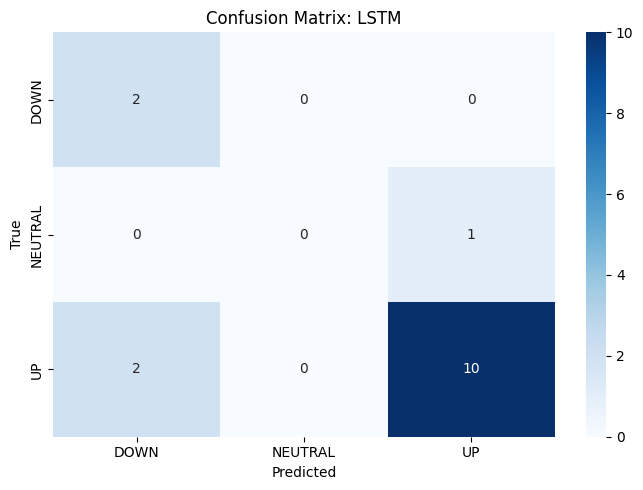


Epoch 28: val_loss improved from 0.70591 to 0.69352, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


[EXIDEIND] Results DataFrame shape: (15, 27)
[EXIDEIND] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/EXIDEIND_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/EXIDEIND_results.xlsx
[EXIDEIND] 💾 Saved results to /content/output/EXIDEIND_results.xlsx
[OFSS] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
✅ Completed processing for EXIDEIND
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[OFSS] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[OFSS] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1178 - val_accuracy: 1.0000 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 29/50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1699
Epoch 29: val_loss improved from 0.69352 to 0.68169, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5



Epoch 49: val_loss improved from 0.53742 to 0.53261, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0959 - val_accuracy: 1.0000 - val_loss: 0.6817 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1699 - val_accuracy: 1.0000 - val_loss: 0.5326 - learning_rate: 0.0010
Epoch 50/50

Epoch 30: val_loss improved from 0.68169 to 0.66989, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0833 - val_accuracy: 1.0000 - val_loss: 0.6699 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 1.0000 - loss: 0.0580
Epoch 31: val_loss improved from 0.66989 to 0.65888, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5



Epoch 50: val_loss improved from 0.53261 to 0.52960, saving model to /content/checkpoints/COLPAL/COLPAL_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0580 - val_accuracy: 1.0000 - val_loss: 0.6589 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1835 - val_accuracy: 1.0000 - val_loss: 0.5296 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 1.0000 - loss: 0.1544
Epoch 32: val_loss improved from 0.65888 to 0.64527, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


[COLPAL] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[COLPAL] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[COLPAL] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 0 2 2 0 0 0 0 2 2 0 0 0 1]


[COLPAL] ✅ Loaded best model from /content/checkpoints/COLPAL/COLPAL_lstm_model.h5
[COLPAL] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1544 - val_accuracy: 1.0000 - val_loss: 0.6453 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9091 - loss: 0.1168
Epoch 33: val_loss improved from 0.64527 to 0.63294, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


[COLPAL] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.60      1.00      0.75         9
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         5

    accuracy                           0.60        15
   macro avg       0.20      0.33      0.25        15
weighted avg       0.36      0.60      0.45        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.1168 - val_accuracy: 1.0000 - val_loss: 0.6329 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 1.0000 - loss: 0.0451
Epoch 34: val_loss improved from 0.63294 to 0.62194, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


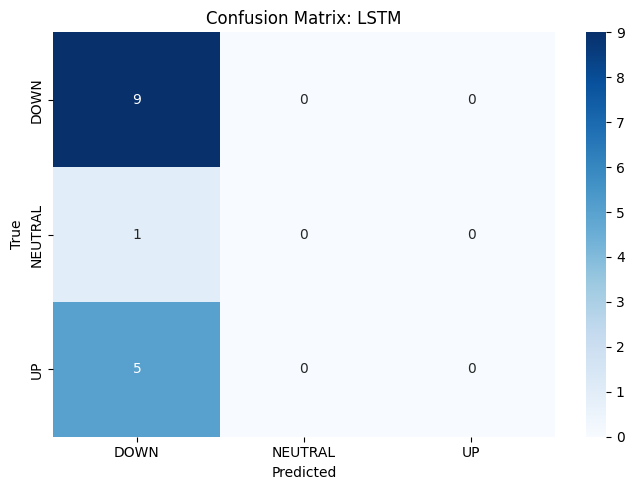

[COLPAL] Results DataFrame shape: (15, 27)
[COLPAL] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/COLPAL_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/COLPAL_results.xlsx
[COLPAL] 💾 Saved results to /content/output/COLPAL_results.xlsx
[MCX] ✅ Set DatetimeIndex. Index range: 2025-07-02 00:00:00 to 2025-08-04 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for COLPAL
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[MCX] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[MCX] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0451 - val_accuracy: 1.0000 - val_loss: 0.6219 - learning_rate: 0.0010
Epoch 35/50

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 0.0500

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50

Epoch 35: val_loss improved from 0.62194 to 0.61262, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0500 - val_accuracy: 1.0000 - val_loss: 0.6126 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 0.0537
Epoch 36: val_loss improved from 0.61262 to 0.60295, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0537 - val_accuracy: 1.0000 - val_loss: 0.6030 - learning_rate: 0.0010
Epoch 37/50

Epoch 1: val_loss improved from inf to 0.98664, saving model to /content/checkpoints/ASIANPAINT/ASIANPAINT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.1818 - loss: 1.4821 - val_accuracy: 1.0000 - val_loss: 0.9866 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.3636 - loss: 1.0892
Epoch 37: val_loss improved from 0.60295 to 0.59434, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5



Epoch 2: val_loss improved from 0.98664 to 0.97732, saving model to /content/checkpoints/ASIANPAINT/ASIANPAINT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0555 - val_accuracy: 1.0000 - val_loss: 0.5943 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.0892 - val_accuracy: 1.0000 - val_loss: 0.9773 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.3636 - loss: 1.0997
Epoch 3: val_loss improved from 0.97732 to 0.97112, saving model to /content/checkpoints/ASIANPAINT/ASIANPAINT_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.08257, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.0997 - val_accuracy: 1.0000 - val_loss: 0.9711 - learning_rate: 0.0010
Epoch 4/50

Epoch 38: val_loss improved from 0.59434 to 0.58643, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.0000e+00 - loss: 1.8839 - val_accuracy: 1.0000 - val_loss: 1.0826 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.1818 - loss: 1.5731
Epoch 2: val_loss improved from 1.08257 to 1.05523, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0536 - val_accuracy: 1.0000 - val_loss: 0.5864 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1818 - loss: 1.5731 - val_accuracy: 1.0000 - val_loss: 1.0552 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.1818 - loss: 1.6201
Epoch 4: val_loss improved from 0.97112 to 0.96513, saving model to /content/checkpoints/ASIANPAINT/ASIANPAINT_lstm_model.h5



Epoch 3: val_loss improved from 1.05523 to 1.04273, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0497
Epoch 39: val_loss improved from 0.58643 to 0.58001, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.8047 - val_accuracy: 1.0000 - val_loss: 0.9651 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1818 - loss: 1.6201 - val_accuracy: 1.0000 - val_loss: 1.0427 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7273 - loss: 0.8614
Epoch 5: val_loss improved from 0.96513 to 0.96428, saving model to /content/checkpoints/ASIANPAINT/ASIANPAINT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0497 - val_accuracy: 1.0000 - val_loss: 0.5800 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.8614 - val_accuracy: 1.0000 - val_loss: 0.9643 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3636 - loss: 1.1987
Epoch 6: val_loss improved from 0.96428 to 0.96278, saving model to /content/checkpoints/ASIANPAINT/ASIANPAINT_lstm_model.h5



Epoch 4: val_loss improved from 1.04273 to 1.03510, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 0.8255 - val_accuracy: 1.0000 - val_loss: 0.9628 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.1987 - val_accuracy: 1.0000 - val_loss: 1.0351 - learning_rate: 0.0010
Epoch 5/50

Epoch 40: val_loss improved from 0.58001 to 0.57577, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5



Epoch 7: val_loss improved from 0.96278 to 0.96130, saving model to /content/checkpoints/ASIANPAINT/ASIANPAINT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0634 - val_accuracy: 1.0000 - val_loss: 0.5758 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.6147 - val_accuracy: 1.0000 - val_loss: 0.9613 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7273 - loss: 0.7036
Epoch 8: val_loss improved from 0.96130 to 0.95872, saving model to /content/checkpoints/ASIANPAINT/ASIANPAINT_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.11124, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3636 - loss: 1.3022
Epoch 5: val_loss improved from 1.03510 to 1.02573, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step - accuracy: 0.7273 - loss: 0.7036 - val_accuracy: 1.0000 - val_loss: 0.9587 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.3636 - loss: 1.2846 - val_accuracy: 0.0000e+00 - val_loss: 1.1112 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0333
Epoch 9: val_loss improved from 0.95872 to 0.95808, saving model to /content/checkpoints/ASIANPAINT/ASIANPAINT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3636 - loss: 1.3022 - val_accuracy: 1.0000 - val_loss: 1.0257 - learning_rate: 0.0010
Epoch 6/50

Epoch 41: val_loss improved from 0.57577 to 0.57165, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5455 - loss: 0.8354
Epoch 2: val_loss improved from 1.11124 to 1.09259, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5



Epoch 6: val_loss improved from 1.02573 to 1.01755, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.7823 - val_accuracy: 1.0000 - val_loss: 0.9581 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0333 - val_accuracy: 1.0000 - val_loss: 0.5716 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 0.9254 - val_accuracy: 0.0000e+00 - val_loss: 1.0926 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.8354 - val_accuracy: 1.0000 - val_loss: 1.0175 - learning_rate: 0.0010
Epoch 7/50

Epoch 10: val_loss did not improve from 0.95808
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step - accuracy: 0.4545 - loss: 0.8581 - val_accuracy: 1.0000 - val_loss: 0.9592 - learning_rate: 0.0010

Epoch 3: val_loss improved from 1.09259 to 1.07766, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step - accuracy: 0.2727 - loss: 0.9729 - val_accuracy: 0.0000e+00 - val_loss: 1.0777 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9091 - loss: 0.7160
Epoch 4: val_loss improved from 1.07766 to 1.06621, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step - accuracy: 0.9091 - loss: 0.7160 - val_accuracy: 1.0000 - val_loss: 1.0662 - learning_rate: 0.0010
Epoch 5/50

Epoch 42: val_loss improved from 0.57165 to 0.56865, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5



Epoch 11: val_loss did not improve from 0.95808
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2727 - loss: 1.1025
Epoch 5: val_loss improved from 1.06621 to 1.05802, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5



Epoch 7: val_loss improved from 1.01755 to 1.00929, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.5399 - val_accuracy: 1.0000 - val_loss: 0.9619 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0408 - val_accuracy: 1.0000 - val_loss: 0.5687 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 0.0344
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: val_loss did not improve from 0.95808
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6688 - val_accuracy: 1.0000 - val_loss: 1.0580 - learning_rate: 0.0010
Epoch 6/50

Epoch 43: val_loss improved from 0.56865 to 0.56558, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2727 - loss: 1.1025 - val_accuracy: 1.0000 - val_loss: 1.0093 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7273 - loss: 0.8470
Epoch 6: val_loss improved from 1.05802 to 1.05212, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5



Epoch 8: val_loss improved from 1.00929 to 1.00261, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5702 - val_accuracy: 1.0000 - val_loss: 0.9648 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0344 - val_accuracy: 1.0000 - val_loss: 0.5656 - learning_rate: 0.0010
Epoch 44/50

Epoch 13: val_loss did not improve from 0.95808
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.4637 - val_accuracy: 1.0000 - val_loss: 1.0521 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.8470 - val_accuracy: 1.0000 - val_loss: 1.0026 - learning_rate: 0.0010
Epoch 7/50
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.6706 - val_accuracy: 1.0000 - val_loss: 0.9668 - learning_rate: 5.0000e-04
Epoch 14/50

Epoch 7: val_loss improved from 1.05212 to 1.04493, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5455 - loss: 0.6558
Epoch 9: val_loss improved from 1.00261 to 0.99037, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5



Epoch 14: val_loss did not improve from 0.95808
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0423
Epoch 44: val_loss improved from 0.56558 to 0.56303, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5252 - val_accuracy: 1.0000 - val_loss: 1.0449 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 0.7461 - val_accuracy: 1.0000 - val_loss: 0.9904 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5455 - loss: 0.6558 - val_accuracy: 1.0000 - val_loss: 0.9682 - learning_rate: 5.0000e-04
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.
[ASIANPAINT] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0423 - val_accuracy: 1.0000 - val_loss: 0.5630 - learning_rate: 0.0010
Epoch 45/50


Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[ASIANPAINT] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[ASIANPAINT] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 2 2 0 0 2 0 0 2 0 0 0 1]
[ASIANPAINT] ✅ Loaded best model from /content/checkpoints/ASIANPAINT/ASIANPAINT_lstm_model.h5
[ASIANPAINT] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 1.0000 - loss: 0.0340
Epoch 45: val_loss improved from 0.56303 to 0.56097, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


[ASIANPAINT] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4141
Epoch 8: val_loss improved from 1.04493 to 1.03926, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5



Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.67      1.00      0.80        10
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         4

    accuracy                           0.67        15
   macro avg       0.22      0.33      0.27        15
weighted avg       0.44      0.67      0.53        15


Epoch 10: val_loss improved from 0.99037 to 0.97870, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0340 - val_accuracy: 1.0000 - val_loss: 0.5610 - learning_rate: 0.0010
Epoch 46/50


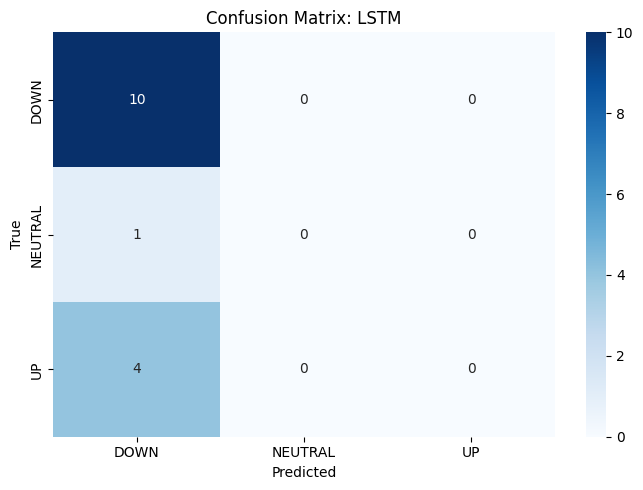

[ASIANPAINT] Results DataFrame shape: (15, 27)
[ASIANPAINT] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/ASIANPAINT_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/ASIANPAINT_results.xlsx
[ASIANPAINT] 💾 Saved results to /content/output/ASIANPAINT_results.xlsx
✅ Completed processing for ASIANPAINT
[BSOFT] ✅ Set DatetimeIndex. Index range: 2025-06-26 00:00:00 to 2025-07-29 00:00:00
Adding technical indicators... Initial shape: (24, 25)
Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[BSOFT] ✅ Technical indicators added. Shape: (24, 73), Features: 73
[BSOFT] ⚠️ NaN counts after technical indicators: {'AVWAP': 24}
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

✅ Built model: LSTM_Model | Output classes: 3



Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4141 - val_accuracy: 1.0000 - val_loss: 1.0393 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6364 - loss: 0.6675 - val_accuracy: 1.0000 - val_loss: 0.9787 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0262
Epoch 9: val_loss improved from 1.03926 to 1.03154, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5



Epoch 46: val_loss improved from 0.56097 to 0.55839, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.7273 - loss: 0.6512
Epoch 11: val_loss improved from 0.97870 to 0.96652, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2600 - val_accuracy: 1.0000 - val_loss: 1.0315 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0262 - val_accuracy: 1.0000 - val_loss: 0.5584 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0454
Epoch 47: val_loss improved from 0.55839 to 0.55465, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6512 - val_accuracy: 1.0000 - val_loss: 0.9665 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step - accuracy: 1.0000 - loss: 0.0454 - val_accuracy: 1.0000 - val_loss: 0.5547 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.3045
Epoch 48: val_loss improved from 0.55465 to 0.55058, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5

Epoch 10: val_loss improved from 1.03154 to 1.02316, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.5551
Epoch 12: val_loss improved from 0.96652 to 0.95622, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0348 - val_accuracy: 1.0000 - val_loss: 0.5506 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.3045 - val_accuracy: 1.0000 - val_loss: 1.0232 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.5551 - val_accuracy: 1.0000 - val_loss: 0.9562 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8182 - loss: 0.6182
Epoch 13: val_loss improved from 0.95622 to 0.94742, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step - accuracy: 0.8182 - loss: 0.6182 - val_accuracy: 1.0000 - val_loss: 0.9474 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 1.0000 - loss: 0.4176
Epoch 49: val_loss improved from 0.55058 to 0.54489, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5



Epoch 11: val_loss improved from 1.02316 to 1.01477, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5



Epoch 14: val_loss improved from 0.94742 to 0.93812, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0451 - val_accuracy: 1.0000 - val_loss: 0.5449 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9091 - loss: 0.2812 - val_accuracy: 1.0000 - val_loss: 1.0148 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.4176 - val_accuracy: 1.0000 - val_loss: 0.9381 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 0.0430
Epoch 50: val_loss improved from 0.54489 to 0.53990, saving model to /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step - accuracy: 1.0000 - loss: 0.0430 - val_accuracy: 1.0000 - val_loss: 0.5399 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9091 - loss: 0.4733[TVSMOTOR] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']

Epoch 12: val_loss improved from 1.01477 to 1.00714, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[TVSMOTOR] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[TVSMOTOR] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 2 0 0 0 0 0 0 0 2 2 1]

Epoch 15: val_loss improved from 0.93812 to 0.92736, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


[TVSMOTOR] ✅ Loaded best model from /content/checkpoints/TVSMOTOR/TVSMOTOR_lstm_model.h5
[TVSMOTOR] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2544 - val_accuracy: 1.0000 - val_loss: 1.0071 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.4733 - val_accuracy: 1.0000 - val_loss: 0.9274 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6364 - loss: 0.9149[TVSMOTOR] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.73      1.00      0.85        11
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         3

    accuracy                           0.73        15
   macro avg       0.24      0.33      0.28        15
weighted avg       0.54      0.73      0.62        15

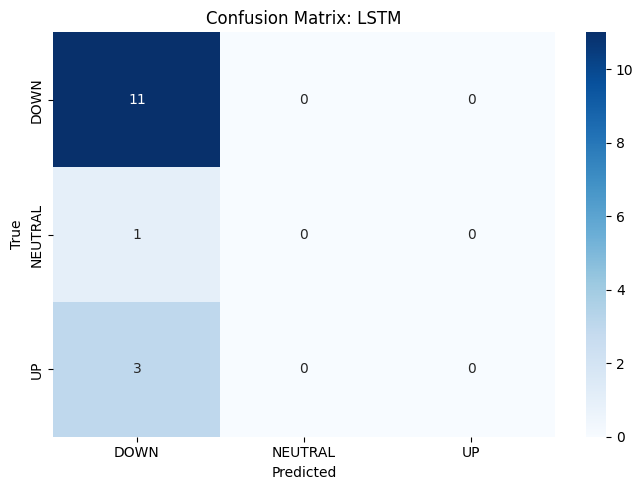

[TVSMOTOR] Results DataFrame shape: (15, 27)
[TVSMOTOR] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/TVSMOTOR_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/TVSMOTOR_results.xlsx
[TVSMOTOR] 💾 Saved results to /content/output/TVSMOTOR_results.xlsx
[INFY24OCTFUT] ✅ Set DatetimeIndex. Index range: 2024-09-11 00:00:00 to 2024-10-15 00:00:00
Adding technical indicators... Initial shape: (24, 25)
✅ Completed processing for TVSMOTOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.2514Technical indicators successfully added. Shape: (24, 70), Features: 70
Labeling target with threshold = 0.3000% | Binary: False | High/Low: False
[INFY24OCTFUT] ✅ Technical indicators added. Shape: (24, 73), Features: 73
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.2766Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 13: val_loss improved from 1.00714 to 0.99985, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5



Epoch 1: val_loss improved from inf to 0.92438, saving model to /content/checkpoints/BSOFT/BSOFT_lstm_model.h5



✅ Built model: LSTM_Model | Output classes: 3

Epoch 16: val_loss improved from 0.92736 to 0.91705, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10, 52)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 10, 128)        │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_1 (BatchNormalization)       │ (None, 10, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification (Dense)          │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,027 (566.51 KB)

 Trainable params: 144,643 (565.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2514 - val_accuracy: 1.0000 - val_loss: 0.9998 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.6364 - loss: 0.9149 - val_accuracy: 1.0000 - val_loss: 0.9244 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2766 - val_accuracy: 1.0000 - val_loss: 0.9170 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8182 - loss: 0.4451
Epoch 2: val_loss did not improve from 0.92438

Epoch 17: val_loss improved from 0.91705 to 0.90568, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.2486 - val_accuracy: 1.0000 - val_loss: 0.9277 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.4451 - val_accuracy: 1.0000 - val_loss: 0.9057 - learning_rate: 0.0010
Epoch 18/50

Epoch 14: val_loss improved from 0.99985 to 0.99285, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 0.2726
Epoch 18: val_loss improved from 0.90568 to 0.89492, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1653 - val_accuracy: 1.0000 - val_loss: 0.9928 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2726 - val_accuracy: 1.0000 - val_loss: 0.8949 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.2871
Epoch 3: val_loss improved from 0.92438 to 0.91653, saving model to /content/checkpoints/BSOFT/BSOFT_lstm_model.h5



Epoch 19: val_loss improved from 0.89492 to 0.88279, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1464
Epoch 15: val_loss improved from 0.99285 to 0.98599, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5455 - loss: 1.0455 - val_accuracy: 1.0000 - val_loss: 0.9165 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2871 - val_accuracy: 1.0000 - val_loss: 0.8828 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 0.2743
Epoch 20: val_loss improved from 0.88279 to 0.87085, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1464 - val_accuracy: 1.0000 - val_loss: 0.9860 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 0.1675
Epoch 16: val_loss improved from 0.98599 to 0.98013, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2743 - val_accuracy: 1.0000 - val_loss: 0.8709 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5455 - loss: 0.8735
Epoch 4: val_loss improved from 0.91653 to 0.90237, saving model to /content/checkpoints/BSOFT/BSOFT_lstm_model.h5



Epoch 21: val_loss improved from 0.87085 to 0.85979, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1675 - val_accuracy: 1.0000 - val_loss: 0.9801 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5455 - loss: 0.8735 - val_accuracy: 1.0000 - val_loss: 0.9024 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2582 - val_accuracy: 1.0000 - val_loss: 0.8598 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1323
Epoch 17: val_loss improved from 0.98013 to 0.97740, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8182 - loss: 0.4690
Epoch 22: val_loss improved from 0.85979 to 0.84873, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5



Epoch 5: val_loss improved from 0.90237 to 0.87875, saving model to /content/checkpoints/BSOFT/BSOFT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1323 - val_accuracy: 1.0000 - val_loss: 0.9774 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2650 - val_accuracy: 1.0000 - val_loss: 0.8487 - learning_rate: 0.0010
Epoch 23/50

Epoch 18: val_loss improved from 0.97740 to 0.97628, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.4690 - val_accuracy: 1.0000 - val_loss: 0.8788 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1707 - val_accuracy: 1.0000 - val_loss: 0.9763 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 0.2010
Epoch 19: val_loss improved from 0.97628 to 0.97342, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step - accuracy: 1.0000 - loss: 0.2010 - val_accuracy: 1.0000 - val_loss: 0.9734 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.0725
Epoch 23: val_loss improved from 0.84873 to 0.83991, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5



Epoch 6: val_loss improved from 0.87875 to 0.84381, saving model to /content/checkpoints/BSOFT/BSOFT_lstm_model.h5



Epoch 20: val_loss improved from 0.97342 to 0.97084, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5



Epoch 1: val_loss improved from inf to 1.00608, saving model to /content/checkpoints/INFY24OCTFUT/INFY24OCTFUT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.2018 - val_accuracy: 1.0000 - val_loss: 0.8399 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.7442 - val_accuracy: 1.0000 - val_loss: 0.8438 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0725 - val_accuracy: 1.0000 - val_loss: 0.9708 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.1818 - loss: 2.2469 - val_accuracy: 1.0000 - val_loss: 1.0061 - learning_rate: 0.0010
Epoch 2/50

Epoch 21: val_loss improved from 0.97084 to 0.96719, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step - accuracy: 1.0000 - loss: 0.0778 - val_accuracy: 1.0000 - val_loss: 0.9672 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.1051
Epoch 22: val_loss improved from 0.96719 to 0.96487, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 1.0000 - loss: 0.1051 - val_accuracy: 1.0000 - val_loss: 0.9649 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.1009
Epoch 23: val_loss improved from 0.96487 to 0.96270, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.7017
Epoch 7: val_loss improved from 0.84381 to 0.81253, saving model to /content/checkpoints/BSOFT/BSOFT_lstm_model.h5



Epoch 24: val_loss improved from 0.83991 to 0.82993, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step - accuracy: 1.0000 - loss: 0.1009 - val_accuracy: 1.0000 - val_loss: 0.9627 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.7017 - val_accuracy: 1.0000 - val_loss: 0.8125 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.2140 - val_accuracy: 1.0000 - val_loss: 0.8299 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.1347
Epoch 24: val_loss improved from 0.96270 to 0.95820, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.7273 - loss: 0.7208
Epoch 25: val_loss improved from 0.82993 to 0.82050, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5



Epoch 8: val_loss improved from 0.81253 to 0.79196, saving model to /content/checkpoints/BSOFT/BSOFT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1818 - loss: 2.1749
Epoch 2: val_loss improved from 1.00608 to 0.99323, saving model to /content/checkpoints/INFY24OCTFUT/INFY24OCTFUT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0721 - val_accuracy: 1.0000 - val_loss: 0.9582 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1347 - val_accuracy: 1.0000 - val_loss: 0.8205 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.7208 - val_accuracy: 1.0000 - val_loss: 0.7920 - learning_rate: 0.0010
Epoch 9/50

Epoch 25: val_loss improved from 0.95820 to 0.95340, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7273 - loss: 0.5137
Epoch 9: val_loss improved from 0.79196 to 0.77509, saving model to /content/checkpoints/BSOFT/BSOFT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1818 - loss: 2.1749 - val_accuracy: 1.0000 - val_loss: 0.9932 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0669 - val_accuracy: 1.0000 - val_loss: 0.9534 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5137 - val_accuracy: 1.0000 - val_loss: 0.7751 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8182 - loss: 0.5592
Epoch 10: val_loss improved from 0.77509 to 0.76531, saving model to /content/checkpoints/BSOFT/BSOFT_lstm_model.h5



Epoch 26: val_loss improved from 0.82050 to 0.81332, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.2727 - loss: 1.6365
Epoch 3: val_loss improved from 0.99323 to 0.98485, saving model to /content/checkpoints/INFY24OCTFUT/INFY24OCTFUT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5592 - val_accuracy: 1.0000 - val_loss: 0.7653 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1421 - val_accuracy: 1.0000 - val_loss: 0.8133 - learning_rate: 0.0010
Epoch 11/50
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.7273 - loss: 0.6248
Epoch 27: val_loss improved from 0.81332 to 0.80777, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5



Epoch 26: val_loss improved from 0.95340 to 0.94784, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2727 - loss: 1.6365 - val_accuracy: 1.0000 - val_loss: 0.9849 - learning_rate: 0.0010
Epoch 4/50

Epoch 11: val_loss improved from 0.76531 to 0.75751, saving model to /content/checkpoints/BSOFT/BSOFT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.3636 - loss: 1.4517
Epoch 4: val_loss did not improve from 0.98485
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0682 - val_accuracy: 1.0000 - val_loss: 0.9478 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1392 - val_accuracy: 1.0000 - val_loss: 0.8078 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.6248 - val_accuracy: 1.0000 - val_loss: 0.7575 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.4517 - val_accuracy: 1.0000 - val_loss: 0.9849 - learning_rate: 0.0010
Epoch 5/50

Epoch 27: val_loss improved from 0.94784 to 0.94260, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5



Epoch 28: val_loss improved from 0.80777 to 0.80332, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.3636 - loss: 1.1407
Epoch 5: val_loss improved from 0.98485 to 0.98244, saving model to /content/checkpoints/INFY24OCTFUT/INFY24OCTFUT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0696 - val_accuracy: 1.0000 - val_loss: 0.9426 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1485 - val_accuracy: 1.0000 - val_loss: 0.8033 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3636 - loss: 1.1407 - val_accuracy: 1.0000 - val_loss: 0.9824 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4545 - loss: 1.2066
Epoch 29: val_loss improved from 0.80332 to 0.79997, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5



Epoch 28: val_loss improved from 0.94260 to 0.93401, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5



Epoch 6: val_loss did not improve from 0.98244

Epoch 12: val_loss improved from 0.75751 to 0.75235, saving model to /content/checkpoints/BSOFT/BSOFT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.2066 - val_accuracy: 1.0000 - val_loss: 0.9856 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1074 - val_accuracy: 1.0000 - val_loss: 0.9340 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1403 - val_accuracy: 1.0000 - val_loss: 0.8000 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7273 - loss: 0.3981 - val_accuracy: 1.0000 - val_loss: 0.7523 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8182 - loss: 0.5505
Epoch 7: val_loss did not improve from 0.98244

Epoch 29: val_loss improved from 0.93401 to 0.92592, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5



Epoch 13: val_loss improved from 0.75235 to 0.74793, saving model to /content/checkpoints/BSOFT/BSOFT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step - accuracy: 0.4545 - loss: 1.1731 - val_accuracy: 1.0000 - val_loss: 0.9909 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1020 - val_accuracy: 1.0000 - val_loss: 0.9259 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0411
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: val_loss did not improve from 0.98244
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8182 - loss: 0.5505 - val_accuracy: 1.0000 - val_loss: 0.7479 - learning_rate: 0.0010
Epoch 14/50

Epoch 30: val_loss improved from 0.79997 to 0.79782, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7273 - loss: 0.5207
Epoch 30: val_loss improved from 0.92592 to 0.91781, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5



Epoch 14: val_loss improved from 0.74793 to 0.74556, saving model to /content/checkpoints/BSOFT/BSOFT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 0.9675 - val_accuracy: 1.0000 - val_loss: 0.9938 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1129 - val_accuracy: 1.0000 - val_loss: 0.7978 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0411 - val_accuracy: 1.0000 - val_loss: 0.9178 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7273 - loss: 0.5207 - val_accuracy: 1.0000 - val_loss: 0.7456 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7273 - loss: 0.3918
Epoch 31: val_loss improved from 0.91781 to 0.91208, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5



Epoch 15: val_loss improved from 0.74556 to 0.74371, saving model to /content/checkpoints/BSOFT/BSOFT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step - accuracy: 1.0000 - loss: 0.0552 - val_accuracy: 1.0000 - val_loss: 0.9121 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step - accuracy: 0.7273 - loss: 0.3918 - val_accuracy: 1.0000 - val_loss: 0.7437 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0311
Epoch 32: val_loss improved from 0.91208 to 0.90712, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.1436
Epoch 9: val_loss did not improve from 0.98244

Epoch 31: val_loss improved from 0.79782 to 0.79567, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step - accuracy: 1.0000 - loss: 0.0311 - val_accuracy: 1.0000 - val_loss: 0.9071 - learning_rate: 0.0010
Epoch 33/50

Epoch 16: val_loss improved from 0.74371 to 0.73955, saving model to /content/checkpoints/BSOFT/BSOFT_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4545 - loss: 0.9658 - val_accuracy: 1.0000 - val_loss: 0.9939 - learning_rate: 5.0000e-04
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1436 - val_accuracy: 1.0000 - val_loss: 0.7957 - learning_rate: 0.0010
Epoch 32/50

Epoch 10: val_loss did not improve from 0.98244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 0.0672
Epoch 33: val_loss improved from 0.90712 to 0.90391, saving model to /content/checkpoints/MCX/MCX_lstm_model.h5



Epoch 32: val_loss improved from 0.79567 to 0.79351, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.3538 - val_accuracy: 1.0000 - val_loss: 0.7395 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 1.0461 - val_accuracy: 1.0000 - val_loss: 0.9946 - learning_rate: 5.0000e-04
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0260 - val_accuracy: 1.0000 - val_loss: 0.9039 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0672 - val_accuracy: 1.0000 - val_loss: 0.7935 - learning_rate: 0.0010
Epoch 33/50

Epoch 34: val_loss did not improve from 0.90391
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0963
Epoch 33: val_loss improved from 0.79351 to 0.79179, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step - accuracy: 1.0000 - loss: 0.0527 - val_accuracy: 1.0000 - val_loss: 0.9049 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 0.0291
Epoch 17: val_loss did not improve from 0.73955
[INFY24OCTFUT] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)

Epoch 35: val_loss did not improve from 0.90391
[INFY24OCTFUT] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 2 0 2 2 0 2 0 0 0 0 0 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0963 - val_accuracy: 1.0000 - val_loss: 0.7918 - learning_rate: 0.0010
Epoch 34/50


[INFY24OCTFUT] ✅ Loaded best model from /content/checkpoints/INFY24OCTFUT/INFY24OCTFUT_lstm_model.h5
[INFY24OCTFUT] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.5025 - val_accuracy: 1.0000 - val_loss: 0.7396 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0291 - val_accuracy: 1.0000 - val_loss: 0.9067 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 0.0383
Epoch 18: val_loss did not improve from 0.73955

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 36: val_loss did not improve from 0.90391
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9091 - loss: 0.2775 - val_accuracy: 1.0000 - val_loss: 0.7415 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7273 - loss: 0.5081
Epoch 34: val_loss improved from 0.79179 to 0.79029, saving model to /cont

[INFY24OCTFUT] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0383 - val_accuracy: 1.0000 - val_loss: 0.9093 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 1.0000 - loss: 0.0270
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 19: val_loss did not improve from 0.73955

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.88      0.78      0.82         9
     NEUTRAL       0.14      1.00      0.25         1
          UP       0.00      0.00      0.00         5

    accuracy                           0.53        15
   macro avg       0.34      0.59      0.36        15
weighted avg       0.53      0.53      0.51        15


Epoch 37: val_loss did not improve from 0.90391
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0669 - val_accuracy: 1.0000 - val_loss: 0.79

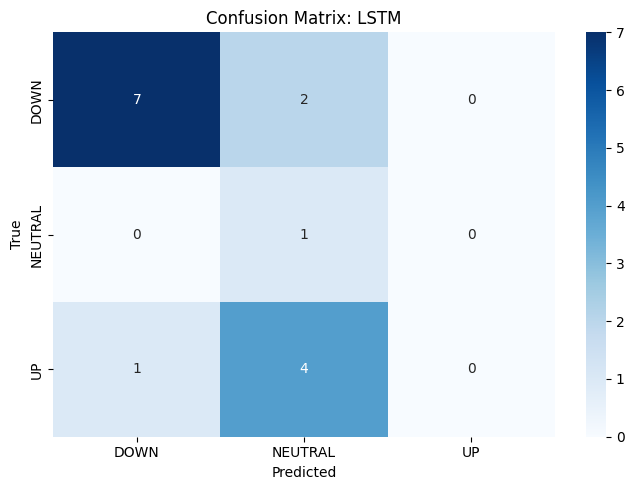

[INFY24OCTFUT] Results DataFrame shape: (15, 27)
[INFY24OCTFUT] Prediction dates: [Timestamp('2024-09-25 00:00:00'), Timestamp('2024-09-26 00:00:00'), Timestamp('2024-09-27 00:00:00'), Timestamp('2024-09-30 00:00:00'), Timestamp('2024-10-01 00:00:00'), Timestamp('2024-10-03 00:00:00'), Timestamp('2024-10-04 00:00:00'), Timestamp('2024-10-07 00:00:00'), Timestamp('2024-10-08 00:00:00'), Timestamp('2024-10-09 00:00:00'), Timestamp('2024-10-10 00:00:00'), Timestamp('2024-10-11 00:00:00'), Timestamp('2024-10-14 00:00:00'), Timestamp('2024-10-15 00:00:00'), Timestamp('2025-07-30 00:00:00')]
Excel report successfully generated: /content/output/INFY24OCTFUT_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/INFY24OCTFUT_results.xlsx
[INFY24OCTFUT] 💾 Saved results to /content/output/INFY24OCTFUT_results.xlsx
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.0286✅ Completed processing for INFY24OCTFUT

Epoch 38: val_loss did not improve from 0.90391
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 1.0000 - loss: 0.0286 - val_accuracy: 1.0000 - val_loss: 0.9142 - learning_rate: 5.0000e-04
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 33.


[MCX] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[MCX] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[MCX] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 0 0 2 0 0 0 0 0 0 2 1]
[MCX] ✅ Loaded best model from /content/checkpoints/MCX/MCX_lstm_model.h5
[MCX] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0483[MCX] Predictions generated. y_pred length: 15, dates_future length: 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.4546
Epoch 35: val_loss improved from 0.79029 to 0.78811, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5



Epoch 20: val_loss did not improve from 0.73955

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.80      1.00      0.89        12
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.00      0.00      0.00         2

    accuracy                           0.80        15
   macro avg       0.27      0.33      0.30        15
weighted avg       0.64      0.80      0.71        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0483 - val_accuracy: 1.0000 - val_loss: 0.7881 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.4546 - val_accuracy: 1.0000 - val_loss: 0.7478 - learning_rate: 5.0000e-04
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8182 - loss: 0.4486

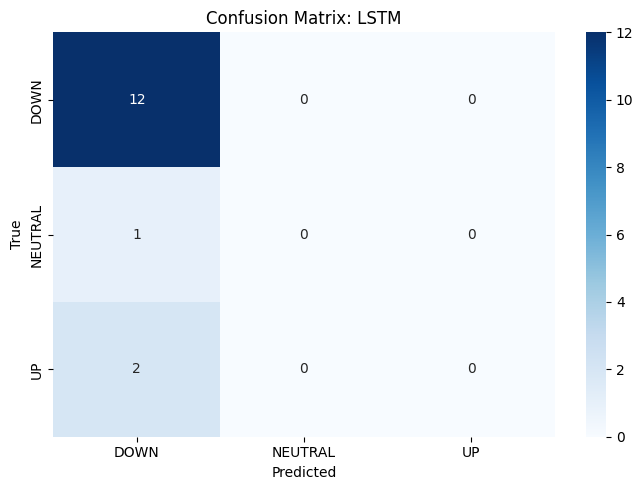

[MCX] Results DataFrame shape: (15, 27)
[MCX] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/MCX_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/MCX_results.xlsx
[MCX] 💾 Saved results to /content/output/MCX_results.xlsx
✅ Completed processing for MCX

Epoch 21: val_loss did not improve from 0.73955
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 1.0000 - loss: 0.0934
Epoch 36: val_loss improved from 0.78811 to 0.78642, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step - accuracy: 0.8182 - loss: 0.4486 - val_accuracy: 1.0000 - val_loss: 0.7487 - learning_rate: 5.0000e-04
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 16.
[BSOFT] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[BSOFT] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[BSOFT] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [2 0 2 2 0 2 0 0 2 2 2 2 0 2 1]


[BSOFT] ✅ Loaded best model from /content/checkpoints/BSOFT/BSOFT_lstm_model.h5
[BSOFT] Predicting for 15 dates, including 30-07-2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0934 - val_accuracy: 1.0000 - val_loss: 0.7864 - learning_rate: 0.0010
Epoch 37/50
[BSOFT] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00         5
     NEUTRAL       0.00      0.00      0.00         1
          UP       0.60      1.00      0.75         9

    accuracy                           0.60        15
   macro avg       0.20      0.33      0.25        15
weighted avg       0.36      0.60      0.45        15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 1.0000 - loss: 0.0855
Epoch 37: val_loss improved from 0.78642 to 0.78505, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


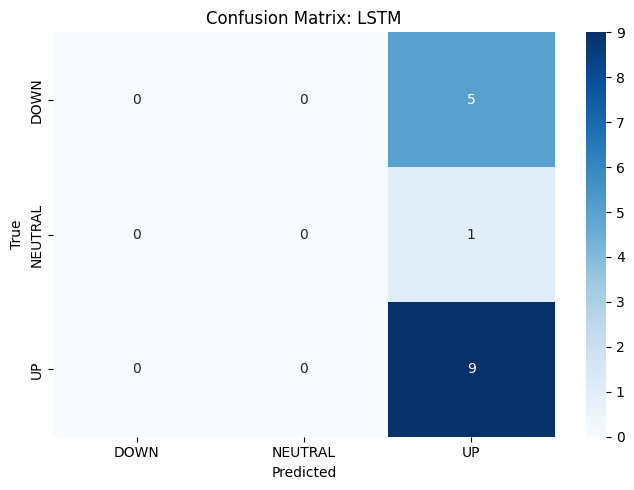

[BSOFT] Results DataFrame shape: (15, 27)
[BSOFT] Prediction dates: [Timestamp('2025-07-10 00:00:00'), Timestamp('2025-07-11 00:00:00'), Timestamp('2025-07-14 00:00:00'), Timestamp('2025-07-15 00:00:00'), Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00')]
Excel report successfully generated: /content/output/BSOFT_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/BSOFT_results.xlsx
[BSOFT] 💾 Saved results to /content/output/BSOFT_results.xlsx
✅ Completed processing for BSOFT
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0855 - val_accuracy: 1.0000 - val_loss: 0.7851 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 1.0000 - loss: 0.0540
Epoch 38: val_loss improved from 0.78505 to 0.78463, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0540 - val_accuracy: 1.0000 - val_loss: 0.7846 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0951
Epoch 39: val_loss improved from 0.78463 to 0.78328, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 1.0000 - loss: 0.0951 - val_accuracy: 1.0000 - val_loss: 0.7833 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0410
Epoch 40: val_loss improved from 0.78328 to 0.78178, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 1.0000 - loss: 0.0410 - val_accuracy: 1.0000 - val_loss: 0.7818 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 1.0000 - loss: 0.0622
Epoch 41: val_loss improved from 0.78178 to 0.78099, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step - accuracy: 1.0000 - loss: 0.0622 - val_accuracy: 1.0000 - val_loss: 0.7810 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0514
Epoch 42: val_loss improved from 0.78099 to 0.77904, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 1.0000 - loss: 0.0514 - val_accuracy: 1.0000 - val_loss: 0.7790 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0372
Epoch 43: val_loss improved from 0.77904 to 0.77630, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 1.0000 - loss: 0.0372 - val_accuracy: 1.0000 - val_loss: 0.7763 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0473
Epoch 44: val_loss improved from 0.77630 to 0.77355, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 1.0000 - loss: 0.0473 - val_accuracy: 1.0000 - val_loss: 0.7736 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0442
Epoch 45: val_loss improved from 0.77355 to 0.77066, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 1.0000 - loss: 0.0442 - val_accuracy: 1.0000 - val_loss: 0.7707 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.0447
Epoch 46: val_loss improved from 0.77066 to 0.76802, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 1.0000 - loss: 0.0447 - val_accuracy: 1.0000 - val_loss: 0.7680 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0571
Epoch 47: val_loss improved from 0.76802 to 0.76362, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 1.0000 - loss: 0.0571 - val_accuracy: 1.0000 - val_loss: 0.7636 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 1.0000 - loss: 0.0600
Epoch 48: val_loss improved from 0.76362 to 0.75893, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step - accuracy: 1.0000 - loss: 0.0600 - val_accuracy: 1.0000 - val_loss: 0.7589 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0548
Epoch 49: val_loss improved from 0.75893 to 0.75411, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step - accuracy: 1.0000 - loss: 0.0548 - val_accuracy: 1.0000 - val_loss: 0.7541 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 1.0000 - loss: 0.0498
Epoch 50: val_loss improved from 0.75411 to 0.74872, saving model to /content/checkpoints/OFSS/OFSS_lstm_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step - accuracy: 1.0000 - loss: 0.0498 - val_accuracy: 1.0000 - val_loss: 0.7487 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.
[OFSS] ✅ LSTM model trained
Ignoring missing features: ['High_Low_Range_5', 'High_Low_Range_10', 'Avg_Daily_Range']
Unique classes: ['DOWN' 'NEUTRAL' 'UP']
Prepared 14 samples. Input shape: (14, 10, 52)
[OFSS] ⚠️ NaN counts in last sequence for 30-07-2025: {'AVWAP': 10}
[OFSS] Added sequence for 30-07-2025 prediction. X_future shape: (15, 10, 52), y_future_cls: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


[OFSS] ✅ Loaded best model from /content/checkpoints/OFSS/OFSS_lstm_model.h5
[OFSS] Predicting for 15 dates, including 30-07-2025
[OFSS] Predictions generated. y_pred length: 15, dates_future length: 15

Classification Report for LSTM:
              precision    recall  f1-score   support

        DOWN       0.93      1.00      0.97        14
     NEUTRAL       0.00      0.00      0.00         1

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15



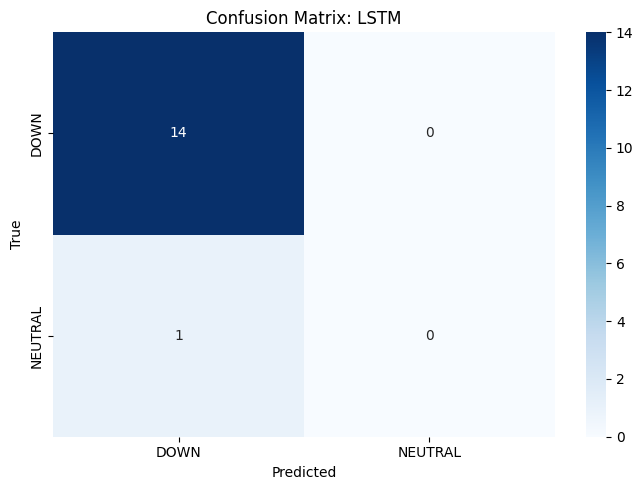

[OFSS] Results DataFrame shape: (15, 26)
[OFSS] Prediction dates: [Timestamp('2025-07-16 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-18 00:00:00'), Timestamp('2025-07-21 00:00:00'), Timestamp('2025-07-22 00:00:00'), Timestamp('2025-07-23 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-07-25 00:00:00'), Timestamp('2025-07-28 00:00:00'), Timestamp('2025-07-29 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-30 00:00:00'), Timestamp('2025-07-31 00:00:00'), Timestamp('2025-08-01 00:00:00'), Timestamp('2025-08-04 00:00:00')]
Excel report successfully generated: /content/output/OFSS_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine: /content/output/OFSS_results.xlsx
[OFSS] 💾 Saved results to /content/output/OFSS_results.xlsx
✅ Completed processing for OFSS

✅ Future Predictions:
📊 Total future predictions: 1799
📈 Unique stocks: 120


STOCK   Datetime  Confidence Risk_Level Prediction    UP_Prob  \
1306     PAGEIND 2025-07-17   84.400002        Low       DOWN        NaN   
1305     PAGEIND 2025-07-16   84.169998        Low       DOWN        NaN   
1307     PAGEIND 2025-07-18   83.959999        Low       DOWN        NaN   
1308     PAGEIND 2025-07-21   82.690002        Low       DOWN        NaN   
1309     PAGEIND 2025-07-22   80.059998        Low       DOWN        NaN   
645     GMRINFRA 2024-08-12   78.800003     Medium         UP  78.800003   
201   BALKRISIND 2025-07-18   78.470001     Medium       DOWN  10.730000   
646     GMRINFRA 2024-08-13   78.239998     Medium         UP  78.239998   
202   BALKRISIND 2025-07-21   78.040001     Medium       DOWN  10.990000   
203   BALKRISIND 2025-07-22   78.019997     Medium       DOWN  11.090000   

      DOWN_Prob  NEUTRAL_Prob  Predicted_Open_Price  Predicted_Close_Price  
1306  84.400002          5.56              46581.15               46407.30  
1305  84.169998          5.67              48230.89               48051.78  
1307  83.959999          5.70              46817.03               46644.06  
1308  82.690002          6.18              46458.18               46291.37  
1309  80.059998          7.16              46448.23               46291.46  
645         NaN          8.93                100.05                 100.38  
201   78.470001         10.81               2744.17                2734.85  
646         NaN          9.12                 98.72                  99.05  
202   78.040001         10.96               2747.06                2737.82  
203   78.019997         10.89               2768.60                2759.31

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📥 Download triggered: /content/output/future_stock_prediction_results_20250922_143259.xlsx


In [ ]:
import numpy as np
import pandas as pd
import os
import datetime
from typing import Optional
from joblib import Parallel, delayed
from google.colab import files

def main(
    time_steps: int = 10,
    model_type: str = 'lstm',
    test_size: float = 0.2,
    val_size: float = 0.5,
    epochs: int = 50,
    batch_size: int = 32,
    verbose: bool = True,
    output_dir: Optional[str] = "/content/output",
    checkpoint_dir: Optional[str] = "/content/checkpoints",
    tensorboard_log_dir: Optional[str] = "/content/tensorboard",
    monitor_metric: str = 'val_loss',
    patience: int = 5,
    reduce_lr_factor: float = 0.5,
    reduce_lr_patience: int = 3,
    min_lr: float = 1e-6,
    max_workers: int = 4,
    future_prediction: bool = True
):
    """
    Main function to process stock data in Google Colab, handling both historical evaluation
    and future predictions using the LSTM model.

    Args:
        time_steps: Number of time steps for LSTM input
        model_type: Model type (fixed to 'lstm')
        test_size: Proportion of data for testing
        val_size: Proportion of test data for validation
        epochs: Number of training epochs
        batch_size: Batch size for training
        verbose: Whether to print progress
        output_dir: Directory to save Excel results
        checkpoint_dir: Directory to save model weights
        tensorboard_log_dir: Directory for TensorBoard logs
        monitor_metric: Metric to monitor for callbacks
        patience: Patience for early stopping
        reduce_lr_factor: Factor for learning rate reduction
        reduce_lr_patience: Patience for learning rate reduction
        min_lr: Minimum learning rate
        max_workers: Maximum number of parallel workers
        future_prediction: If True, train on historical data and predict on recent sequences
    """
    print("📤 Upload your Excel file containing stock data:")
    uploaded = files.upload()

    if not uploaded:
        print("\n No file uploaded. Exiting...")
        return

    uploaded_filename = list(uploaded.keys())[0]
    file_path = os.path.join('/content', uploaded_filename)

    try:
        print("\n Loading and processing dataset...")
        df_all, df_for_prediction = load_excel_dataset(file_path)
        print(f"✅ Successfully loaded data with {len(df_all)} rows for training/testing")
        print(f"✅ Future prediction data: {len(df_for_prediction)} rows")
    except Exception as e:
        print(f"\n❌ Failed to load Excel file: {e}")
        raise

    # Historical evaluation (if not future_prediction only)
    final_df = pd.DataFrame()
    if not future_prediction:
        stock_names = df_all['STOCK_NAME'].unique().tolist()
        stock_data_dict = {stock: df_all[df_all['STOCK_NAME'] == stock].copy() for stock in stock_names}

        print(f"\n🔍 Found {len(stock_names)} stocks to process for historical evaluation")
        print(f"\n⚡ Starting parallel processing with future_prediction=False...")
        final_df = run_pipeline_parallel(
            stock_data_dict=stock_data_dict,
            model_type=model_type,
            time_steps=time_steps,
            test_size=test_size,
            val_size=val_size,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose,
            output_dir=output_dir,
            max_workers=max_workers,
            monitor_metric=monitor_metric,
            patience=patience,
            reduce_lr_factor=reduce_lr_factor,
            reduce_lr_patience=reduce_lr_patience,
            min_lr=min_lr,
            tensorboard_log_dir=tensorboard_log_dir,
            checkpoint_dir=checkpoint_dir,
            future_prediction=False
        )

        if not final_df.empty:
            # Post-process historical results
            if 'Max_Confidence_PCT' in final_df.columns:
                def assess_risk(conf):
                    if conf >= 80:
                        return 'Low'
                    elif conf >= 60:
                        return 'Medium'
                    else:
                        return 'High'
                final_df['Risk_Level'] = final_df['Max_Confidence_PCT'].apply(assess_risk)

            column_mapping = {
                'Stock': 'STOCK',
                'Date': 'Datetime',
                'Max_Confidence_PCT': 'Confidence',
                'Predicted_Label': 'Prediction',
                'UP_PCT': 'UP_Prob',
                'DOWN_PCT': 'DOWN_Prob',
                'NEUTRAL_PCT': 'NEUTRAL_Prob',
                'Target_Open_Price': 'Actual_Open',
                'Target_Close_Price': 'Actual_Close',
                'Target_High_Price': 'Actual_High',
                'Target_Low_Price': 'Actual_Low'
            }
            final_df = final_df.rename(columns={k: v for k, v in column_mapping.items() if k in final_df.columns})

            final_columns = [
                'STOCK', 'Datetime', 'Confidence', 'Risk_Level', 'Prediction',
                'Actual_Open', 'Actual_Close', 'Actual_High', 'Actual_Low',
                'UP_Prob', 'DOWN_Prob', 'NEUTRAL_Prob'
            ]
            final_columns = [col for col in final_columns if col in final_df.columns]
            final_df = final_df[final_columns]

            print("\n\n✅ Historical Predictions:")
            print(f"📊 Total predictions: {len(final_df)}")
            print(f"📈 Unique stocks: {final_df['STOCK'].nunique()}")

            try:
                from IPython.display import display
                display(final_df.sort_values('Confidence', ascending=False).head(10))
            except:
                print(final_df.sort_values('Confidence', ascending=False).head(10))

            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            output_file = f"{output_dir}/stock_prediction_results_{timestamp}.xlsx"
            os.makedirs(output_dir, exist_ok=True)
            final_df.to_excel(output_file, index=False)

            try:
                files.download(output_file)
                print(f"\n📥 Download triggered: {output_file}")
            except Exception as e:
                print(f"\n⚠️ Download failed: {e}")
                print(f"🔗 You can manually download from here: {output_file}")
        else:
            print("\n⚠️ No valid historical predictions generated.")

    # Future predictions
    if not df_for_prediction.empty and future_prediction:
        stock_names_future = df_for_prediction['STOCK_NAME'].unique().tolist()
        stock_data_dict_future = {stock: df_for_prediction[df_for_prediction['STOCK_NAME'] == stock].copy() for stock in stock_names_future}

        print(f"\n🔍 Found {len(stock_names_future)} stocks to process for future predictions")
        print(f"\n⚡ Starting parallel processing with future_prediction=True...")
        future_df = run_pipeline_parallel(
            stock_data_dict=stock_data_dict_future,
            model_type=model_type,
            time_steps=time_steps,
            test_size=test_size,
            val_size=val_size,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose,
            output_dir=output_dir,
            max_workers=max_workers,
            monitor_metric=monitor_metric,
            patience=patience,
            reduce_lr_factor=reduce_lr_factor,
            reduce_lr_patience=reduce_lr_patience,
            min_lr=min_lr,
            tensorboard_log_dir=tensorboard_log_dir,
            checkpoint_dir=checkpoint_dir,
            future_prediction=True
        )

        if not future_df.empty:
            # Post-process future predictions
            if 'Max_Confidence_PCT' in future_df.columns:
                def assess_risk(conf):
                    if conf >= 80:
                        return 'Low'
                    elif conf >= 60:
                        return 'Medium'
                    else:
                        return 'High'
                future_df['Risk_Level'] = future_df['Max_Confidence_PCT'].apply(assess_risk)

            column_mapping = {
                'Stock': 'STOCK',
                'Date': 'Datetime',
                'Max_Confidence_PCT': 'Confidence',
                'Predicted_Label': 'Prediction',
                'UP_PCT': 'UP_Prob',
                'DOWN_PCT': 'DOWN_Prob',
                'NEUTRAL_PCT': 'NEUTRAL_Prob'
            }
            future_df = future_df.rename(columns={k: v for k, v in column_mapping.items() if k in future_df.columns})

            final_columns = [
                'STOCK', 'Datetime', 'Confidence', 'Risk_Level', 'Prediction',
                'UP_Prob', 'DOWN_Prob', 'NEUTRAL_Prob','Predicted_Open_Price','Predicted_Close_Price'
            ]
            final_columns = [col for col in final_columns if col in future_df.columns]
            future_df = future_df[final_columns]

            print("\n✅ Future Predictions:")
            print(f"📊 Total future predictions: {len(future_df)}")
            print(f"📈 Unique stocks: {future_df['STOCK'].nunique()}")

            try:
                from IPython.display import display
                display(future_df.sort_values('Confidence', ascending=False).head(10))
            except:
                print(future_df.sort_values('Confidence', ascending=False).head(10))

            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            future_output_file = f"{output_dir}/future_stock_prediction_results_{timestamp}.xlsx"
            os.makedirs(output_dir, exist_ok=True)
            future_df.to_excel(future_output_file, index=False)

            try:
                files.download(future_output_file)
                print(f"\n📥 Download triggered: {future_output_file}")
            except Exception as e:
                print(f"\n⚠️ Download failed: {e}")
                print(f"🔗 You can manually download from here: {future_output_file}")
        else:
            print("\n⚠️ No valid future predictions generated.")

if __name__ == "__main__":
    main()